In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (MobileNet)

2024-02-24 13:26:07.994006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 13:26:07.994103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 13:26:08.125932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(MobileNet(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("MobileNet"+s+".keras")
    

    # save model to disk
    filename = "MobileNet" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 mobilenet_1.00_176 (Functi  (None, 4)                 3232964   


 onal)                                                           


Total params: 3232964 (12.33 MB)


Trainable params: 3211076 (12.25 MB)


Non-trainable params: 21888 (85.50 KB)


_________________________________________________________________


Epoch 1/30


2024-02-24 13:26:34.730472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/mobilenet_1.00_176/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


I0000 00:00:1708781197.694858      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 33:21 - loss: 1.6162 - accuracy: 0.0312

  2/140 [..............................] - ETA: 16s - loss: 1.3874 - accuracy: 0.2500  

  3/140 [..............................] - ETA: 15s - loss: 1.3214 - accuracy: 0.3021

  4/140 [..............................] - ETA: 14s - loss: 1.2528 - accuracy: 0.3125

  5/140 [>.............................] - ETA: 14s - loss: 1.1485 - accuracy: 0.3938

  6/140 [>.............................] - ETA: 14s - loss: 1.1105 - accuracy: 0.4271

  7/140 [>.............................] - ETA: 14s - loss: 1.1642 - accuracy: 0.4375

  8/140 [>.............................] - ETA: 14s - loss: 1.2262 - accuracy: 0.4297

  9/140 [>.............................] - ETA: 14s - loss: 1.2102 - accuracy: 0.4514

 10/140 [=>............................] - ETA: 14s - loss: 1.2147 - accuracy: 0.4531

 11/140 [=>............................] - ETA: 13s - loss: 1.2187 - accuracy: 0.4517

 12/140 [=>............................] - ETA: 13s - loss: 1.2347 - accuracy: 0.4609

 13/140 [=>............................] - ETA: 13s - loss: 1.2374 - accuracy: 0.4567

 14/140 [==>...........................] - ETA: 13s - loss: 1.2208 - accuracy: 0.4643

 15/140 [==>...........................] - ETA: 13s - loss: 1.2128 - accuracy: 0.4646

 16/140 [==>...........................] - ETA: 13s - loss: 1.2039 - accuracy: 0.4648

 17/140 [==>...........................] - ETA: 13s - loss: 1.1943 - accuracy: 0.4669

 18/140 [==>...........................] - ETA: 13s - loss: 1.1874 - accuracy: 0.4740

 19/140 [===>..........................] - ETA: 12s - loss: 1.1910 - accuracy: 0.4720

 20/140 [===>..........................] - ETA: 12s - loss: 1.1949 - accuracy: 0.4688

 21/140 [===>..........................] - ETA: 12s - loss: 1.1846 - accuracy: 0.4747

 22/140 [===>..........................] - ETA: 12s - loss: 1.1924 - accuracy: 0.4659

 23/140 [===>..........................] - ETA: 12s - loss: 1.1926 - accuracy: 0.4606

 24/140 [====>.........................] - ETA: 12s - loss: 1.1912 - accuracy: 0.4583

 25/140 [====>.........................] - ETA: 12s - loss: 1.1947 - accuracy: 0.4538

 26/140 [====>.........................] - ETA: 12s - loss: 1.1993 - accuracy: 0.4459

 27/140 [====>.........................] - ETA: 12s - loss: 1.1958 - accuracy: 0.4468

 28/140 [=====>........................] - ETA: 12s - loss: 1.1906 - accuracy: 0.4475

 29/140 [=====>........................] - ETA: 11s - loss: 1.1883 - accuracy: 0.4483

 30/140 [=====>........................] - ETA: 11s - loss: 1.1815 - accuracy: 0.4531

 31/140 [=====>........................] - ETA: 11s - loss: 1.1732 - accuracy: 0.4577

 32/140 [=====>........................] - ETA: 11s - loss: 1.1735 - accuracy: 0.4541

 33/140 [======>.......................] - ETA: 11s - loss: 1.1760 - accuracy: 0.4527

 34/140 [======>.......................] - ETA: 11s - loss: 1.1803 - accuracy: 0.4531

 35/140 [======>.......................] - ETA: 11s - loss: 1.1771 - accuracy: 0.4571

 36/140 [======>.......................] - ETA: 11s - loss: 1.1697 - accuracy: 0.4592

 37/140 [======>.......................] - ETA: 11s - loss: 1.1713 - accuracy: 0.4603

 38/140 [=======>......................] - ETA: 10s - loss: 1.1709 - accuracy: 0.4613

 39/140 [=======>......................] - ETA: 10s - loss: 1.1805 - accuracy: 0.4599

 40/140 [=======>......................] - ETA: 10s - loss: 1.1776 - accuracy: 0.4602

 41/140 [=======>......................] - ETA: 10s - loss: 1.1758 - accuracy: 0.4611

 42/140 [========>.....................] - ETA: 10s - loss: 1.1684 - accuracy: 0.4635

 43/140 [========>.....................] - ETA: 10s - loss: 1.1656 - accuracy: 0.4608

 44/140 [========>.....................] - ETA: 10s - loss: 1.1598 - accuracy: 0.4616

 45/140 [========>.....................] - ETA: 10s - loss: 1.1616 - accuracy: 0.4611

 46/140 [========>.....................] - ETA: 10s - loss: 1.1660 - accuracy: 0.4592

 47/140 [=========>....................] - ETA: 9s - loss: 1.1669 - accuracy: 0.4594 

 48/140 [=========>....................] - ETA: 9s - loss: 1.1627 - accuracy: 0.4603

 49/140 [=========>....................] - ETA: 9s - loss: 1.1618 - accuracy: 0.4598

 50/140 [=========>....................] - ETA: 9s - loss: 1.1576 - accuracy: 0.4613

 51/140 [=========>....................] - ETA: 9s - loss: 1.1543 - accuracy: 0.4638

 52/140 [==========>...................] - ETA: 9s - loss: 1.1482 - accuracy: 0.4663

 53/140 [==========>...................] - ETA: 9s - loss: 1.1422 - accuracy: 0.4676

 54/140 [==========>...................] - ETA: 9s - loss: 1.1408 - accuracy: 0.4688

 55/140 [==========>...................] - ETA: 9s - loss: 1.1418 - accuracy: 0.4665

 56/140 [===========>..................] - ETA: 8s - loss: 1.1367 - accuracy: 0.4699

 57/140 [===========>..................] - ETA: 8s - loss: 1.1316 - accuracy: 0.4720

 58/140 [===========>..................] - ETA: 8s - loss: 1.1292 - accuracy: 0.4714

 59/140 [===========>..................] - ETA: 8s - loss: 1.1347 - accuracy: 0.4688

 60/140 [===========>..................] - ETA: 8s - loss: 1.1332 - accuracy: 0.4693

 61/140 [============>.................] - ETA: 8s - loss: 1.1286 - accuracy: 0.4713

 62/140 [============>.................] - ETA: 8s - loss: 1.1262 - accuracy: 0.4723

 63/140 [============>.................] - ETA: 8s - loss: 1.1232 - accuracy: 0.4747

 64/140 [============>.................] - ETA: 8s - loss: 1.1197 - accuracy: 0.4751

 65/140 [============>.................] - ETA: 7s - loss: 1.1212 - accuracy: 0.4750

 66/140 [=============>................] - ETA: 7s - loss: 1.1178 - accuracy: 0.4773

 67/140 [=============>................] - ETA: 7s - loss: 1.1186 - accuracy: 0.4776

 68/140 [=============>................] - ETA: 7s - loss: 1.1265 - accuracy: 0.4761

 69/140 [=============>................] - ETA: 7s - loss: 1.1252 - accuracy: 0.4769

 70/140 [==============>...............] - ETA: 7s - loss: 1.1257 - accuracy: 0.4759

 71/140 [==============>...............] - ETA: 7s - loss: 1.1243 - accuracy: 0.4749

 72/140 [==============>...............] - ETA: 7s - loss: 1.1225 - accuracy: 0.4753

 73/140 [==============>...............] - ETA: 7s - loss: 1.1172 - accuracy: 0.4786

 74/140 [==============>...............] - ETA: 7s - loss: 1.1147 - accuracy: 0.4797

 75/140 [===============>..............] - ETA: 6s - loss: 1.1138 - accuracy: 0.4792

 76/140 [===============>..............] - ETA: 6s - loss: 1.1127 - accuracy: 0.4799

 77/140 [===============>..............] - ETA: 6s - loss: 1.1106 - accuracy: 0.4801

 78/140 [===============>..............] - ETA: 6s - loss: 1.1098 - accuracy: 0.4812

 79/140 [===============>..............] - ETA: 6s - loss: 1.1122 - accuracy: 0.4798

 80/140 [================>.............] - ETA: 6s - loss: 1.1091 - accuracy: 0.4816

 81/140 [================>.............] - ETA: 6s - loss: 1.1046 - accuracy: 0.4842

 82/140 [================>.............] - ETA: 6s - loss: 1.1016 - accuracy: 0.4840

 83/140 [================>.............] - ETA: 6s - loss: 1.1013 - accuracy: 0.4846

 84/140 [=================>............] - ETA: 5s - loss: 1.1054 - accuracy: 0.4844

 85/140 [=================>............] - ETA: 5s - loss: 1.1043 - accuracy: 0.4849

 86/140 [=================>............] - ETA: 5s - loss: 1.1026 - accuracy: 0.4858

 87/140 [=================>............] - ETA: 5s - loss: 1.1003 - accuracy: 0.4864

 88/140 [=================>............] - ETA: 5s - loss: 1.0995 - accuracy: 0.4876

 89/140 [==================>...........] - ETA: 5s - loss: 1.1000 - accuracy: 0.4870

 90/140 [==================>...........] - ETA: 5s - loss: 1.0986 - accuracy: 0.4868

 91/140 [==================>...........] - ETA: 5s - loss: 1.0954 - accuracy: 0.4883

 92/140 [==================>...........] - ETA: 5s - loss: 1.0932 - accuracy: 0.4881

 93/140 [==================>...........] - ETA: 4s - loss: 1.0915 - accuracy: 0.4882

 94/140 [===================>..........] - ETA: 4s - loss: 1.0900 - accuracy: 0.4884

 95/140 [===================>..........] - ETA: 4s - loss: 1.0892 - accuracy: 0.4888

 96/140 [===================>..........] - ETA: 4s - loss: 1.0864 - accuracy: 0.4893

 97/140 [===================>..........] - ETA: 4s - loss: 1.0865 - accuracy: 0.4900

 98/140 [====================>.........] - ETA: 4s - loss: 1.0878 - accuracy: 0.4892

 99/140 [====================>.........] - ETA: 4s - loss: 1.0845 - accuracy: 0.4905

100/140 [====================>.........] - ETA: 4s - loss: 1.0839 - accuracy: 0.4906

101/140 [====================>.........] - ETA: 4s - loss: 1.0825 - accuracy: 0.4910

102/140 [====================>.........] - ETA: 4s - loss: 1.0807 - accuracy: 0.4908

103/140 [=====================>........] - ETA: 3s - loss: 1.0795 - accuracy: 0.4897

104/140 [=====================>........] - ETA: 3s - loss: 1.0775 - accuracy: 0.4916

105/140 [=====================>........] - ETA: 3s - loss: 1.0782 - accuracy: 0.4908

106/140 [=====================>........] - ETA: 3s - loss: 1.0760 - accuracy: 0.4920

107/140 [=====================>........] - ETA: 3s - loss: 1.0733 - accuracy: 0.4930

108/140 [======================>.......] - ETA: 3s - loss: 1.0731 - accuracy: 0.4922

109/140 [======================>.......] - ETA: 3s - loss: 1.0720 - accuracy: 0.4934

110/140 [======================>.......] - ETA: 3s - loss: 1.0722 - accuracy: 0.4932

111/140 [======================>.......] - ETA: 3s - loss: 1.0718 - accuracy: 0.4927

112/140 [=======================>......] - ETA: 2s - loss: 1.0705 - accuracy: 0.4930

113/140 [=======================>......] - ETA: 2s - loss: 1.0684 - accuracy: 0.4934

114/140 [=======================>......] - ETA: 2s - loss: 1.0683 - accuracy: 0.4937

115/140 [=======================>......] - ETA: 2s - loss: 1.0670 - accuracy: 0.4940

116/140 [=======================>......] - ETA: 2s - loss: 1.0654 - accuracy: 0.4941

117/140 [========================>.....] - ETA: 2s - loss: 1.0660 - accuracy: 0.4939

118/140 [========================>.....] - ETA: 2s - loss: 1.0642 - accuracy: 0.4944

119/140 [========================>.....] - ETA: 2s - loss: 1.0630 - accuracy: 0.4937

120/140 [========================>.....] - ETA: 2s - loss: 1.0637 - accuracy: 0.4935

121/140 [========================>.....] - ETA: 2s - loss: 1.0622 - accuracy: 0.4938

122/140 [=========================>....] - ETA: 1s - loss: 1.0606 - accuracy: 0.4949

123/140 [=========================>....] - ETA: 1s - loss: 1.0590 - accuracy: 0.4959

124/140 [=========================>....] - ETA: 1s - loss: 1.0592 - accuracy: 0.4957

125/140 [=========================>....] - ETA: 1s - loss: 1.0587 - accuracy: 0.4947

126/140 [==========================>...] - ETA: 1s - loss: 1.0574 - accuracy: 0.4953

127/140 [==========================>...] - ETA: 1s - loss: 1.0579 - accuracy: 0.4953

128/140 [==========================>...] - ETA: 1s - loss: 1.0570 - accuracy: 0.4951

129/140 [==========================>...] - ETA: 1s - loss: 1.0554 - accuracy: 0.4954

130/140 [==========================>...] - ETA: 1s - loss: 1.0555 - accuracy: 0.4954

131/140 [===========================>..] - ETA: 0s - loss: 1.0557 - accuracy: 0.4950

132/140 [===========================>..] - ETA: 0s - loss: 1.0566 - accuracy: 0.4948

133/140 [===========================>..] - ETA: 0s - loss: 1.0554 - accuracy: 0.4960

134/140 [===========================>..] - ETA: 0s - loss: 1.0540 - accuracy: 0.4958

135/140 [===========================>..] - ETA: 0s - loss: 1.0521 - accuracy: 0.4965

136/140 [============================>.] - ETA: 0s - loss: 1.0528 - accuracy: 0.4959

137/140 [============================>.] - ETA: 0s - loss: 1.0518 - accuracy: 0.4954

138/140 [============================>.] - ETA: 0s - loss: 1.0506 - accuracy: 0.4955

139/140 [============================>.] - ETA: 0s - loss: 1.0503 - accuracy: 0.4957

140/140 [==============================] - ETA: 0s - loss: 1.0504 - accuracy: 0.4955

140/140 [==============================] - 33s 133ms/step - loss: 1.0504 - accuracy: 0.4955 - val_loss: 1.0442 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 35s - loss: 0.8539 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 0.9077 - accuracy: 0.5156

  3/140 [..............................] - ETA: 14s - loss: 0.9089 - accuracy: 0.5000

  4/140 [..............................] - ETA: 14s - loss: 0.9191 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 14s - loss: 0.9573 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 13s - loss: 1.0088 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 13s - loss: 1.0111 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 13s - loss: 0.9825 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 13s - loss: 0.9707 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 13s - loss: 0.9958 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 13s - loss: 0.9876 - accuracy: 0.5085

 12/140 [=>............................] - ETA: 13s - loss: 0.9670 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 13s - loss: 0.9846 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 13s - loss: 0.9925 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 12s - loss: 0.9845 - accuracy: 0.5063

 16/140 [==>...........................] - ETA: 12s - loss: 0.9729 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 12s - loss: 0.9688 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 12s - loss: 0.9741 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 12s - loss: 0.9827 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 12s - loss: 0.9840 - accuracy: 0.5063

 21/140 [===>..........................] - ETA: 12s - loss: 0.9774 - accuracy: 0.5119

 22/140 [===>..........................] - ETA: 12s - loss: 0.9723 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 12s - loss: 0.9743 - accuracy: 0.5122

 24/140 [====>.........................] - ETA: 12s - loss: 0.9670 - accuracy: 0.5169

 25/140 [====>.........................] - ETA: 11s - loss: 0.9702 - accuracy: 0.5150

 26/140 [====>.........................] - ETA: 11s - loss: 0.9693 - accuracy: 0.5156

 27/140 [====>.........................] - ETA: 11s - loss: 0.9697 - accuracy: 0.5150

 28/140 [=====>........................] - ETA: 11s - loss: 0.9653 - accuracy: 0.5212

 29/140 [=====>........................] - ETA: 11s - loss: 0.9696 - accuracy: 0.5205

 30/140 [=====>........................] - ETA: 11s - loss: 0.9796 - accuracy: 0.5146

 31/140 [=====>........................] - ETA: 11s - loss: 0.9784 - accuracy: 0.5171

 32/140 [=====>........................] - ETA: 11s - loss: 0.9775 - accuracy: 0.5166

 33/140 [======>.......................] - ETA: 11s - loss: 0.9726 - accuracy: 0.5208

 34/140 [======>.......................] - ETA: 11s - loss: 0.9749 - accuracy: 0.5193

 35/140 [======>.......................] - ETA: 10s - loss: 0.9735 - accuracy: 0.5179

 36/140 [======>.......................] - ETA: 10s - loss: 0.9743 - accuracy: 0.5191

 37/140 [======>.......................] - ETA: 10s - loss: 0.9716 - accuracy: 0.5203

 38/140 [=======>......................] - ETA: 10s - loss: 0.9699 - accuracy: 0.5206

 39/140 [=======>......................] - ETA: 10s - loss: 0.9702 - accuracy: 0.5216

 40/140 [=======>......................] - ETA: 10s - loss: 0.9677 - accuracy: 0.5242

 41/140 [=======>......................] - ETA: 10s - loss: 0.9634 - accuracy: 0.5259

 42/140 [========>.....................] - ETA: 10s - loss: 0.9658 - accuracy: 0.5231

 43/140 [========>.....................] - ETA: 10s - loss: 0.9654 - accuracy: 0.5225

 44/140 [========>.....................] - ETA: 9s - loss: 0.9590 - accuracy: 0.5270 

 45/140 [========>.....................] - ETA: 9s - loss: 0.9645 - accuracy: 0.5278

 46/140 [========>.....................] - ETA: 9s - loss: 0.9639 - accuracy: 0.5272

 47/140 [=========>....................] - ETA: 9s - loss: 0.9664 - accuracy: 0.5293

 48/140 [=========>....................] - ETA: 9s - loss: 0.9702 - accuracy: 0.5319

 49/140 [=========>....................] - ETA: 9s - loss: 0.9680 - accuracy: 0.5319

 50/140 [=========>....................] - ETA: 9s - loss: 0.9645 - accuracy: 0.5344

 51/140 [=========>....................] - ETA: 9s - loss: 0.9662 - accuracy: 0.5331

 52/140 [==========>...................] - ETA: 9s - loss: 0.9644 - accuracy: 0.5349

 53/140 [==========>...................] - ETA: 8s - loss: 0.9611 - accuracy: 0.5371

 54/140 [==========>...................] - ETA: 8s - loss: 0.9579 - accuracy: 0.5394

 55/140 [==========>...................] - ETA: 8s - loss: 0.9587 - accuracy: 0.5381

 56/140 [===========>..................] - ETA: 8s - loss: 0.9569 - accuracy: 0.5379

 57/140 [===========>..................] - ETA: 8s - loss: 0.9584 - accuracy: 0.5378

 58/140 [===========>..................] - ETA: 8s - loss: 0.9568 - accuracy: 0.5377

 59/140 [===========>..................] - ETA: 8s - loss: 0.9572 - accuracy: 0.5392

 60/140 [===========>..................] - ETA: 8s - loss: 0.9564 - accuracy: 0.5406

 61/140 [============>.................] - ETA: 8s - loss: 0.9562 - accuracy: 0.5410

 62/140 [============>.................] - ETA: 8s - loss: 0.9537 - accuracy: 0.5408

 63/140 [============>.................] - ETA: 7s - loss: 0.9570 - accuracy: 0.5392

 64/140 [============>.................] - ETA: 7s - loss: 0.9556 - accuracy: 0.5396

 65/140 [============>.................] - ETA: 7s - loss: 0.9615 - accuracy: 0.5380

 66/140 [=============>................] - ETA: 7s - loss: 0.9669 - accuracy: 0.5369

 67/140 [=============>................] - ETA: 7s - loss: 0.9686 - accuracy: 0.5354

 68/140 [=============>................] - ETA: 7s - loss: 0.9673 - accuracy: 0.5363

 69/140 [=============>................] - ETA: 7s - loss: 0.9652 - accuracy: 0.5376

 70/140 [==============>...............] - ETA: 7s - loss: 0.9625 - accuracy: 0.5393

 71/140 [==============>...............] - ETA: 7s - loss: 0.9589 - accuracy: 0.5409

 72/140 [==============>...............] - ETA: 7s - loss: 0.9557 - accuracy: 0.5447

 73/140 [==============>...............] - ETA: 6s - loss: 0.9556 - accuracy: 0.5458

 74/140 [==============>...............] - ETA: 6s - loss: 0.9548 - accuracy: 0.5452

 75/140 [===============>..............] - ETA: 6s - loss: 0.9575 - accuracy: 0.5437

 76/140 [===============>..............] - ETA: 6s - loss: 0.9541 - accuracy: 0.5456

 77/140 [===============>..............] - ETA: 6s - loss: 0.9514 - accuracy: 0.5467

 78/140 [===============>..............] - ETA: 6s - loss: 0.9504 - accuracy: 0.5465

 79/140 [===============>..............] - ETA: 6s - loss: 0.9497 - accuracy: 0.5471

 80/140 [================>.............] - ETA: 6s - loss: 0.9519 - accuracy: 0.5465

 81/140 [================>.............] - ETA: 6s - loss: 0.9495 - accuracy: 0.5482

 82/140 [================>.............] - ETA: 6s - loss: 0.9469 - accuracy: 0.5503

 83/140 [================>.............] - ETA: 5s - loss: 0.9441 - accuracy: 0.5523

 84/140 [=================>............] - ETA: 5s - loss: 0.9425 - accuracy: 0.5532

 85/140 [=================>............] - ETA: 5s - loss: 0.9436 - accuracy: 0.5533

 86/140 [=================>............] - ETA: 5s - loss: 0.9442 - accuracy: 0.5531

 87/140 [=================>............] - ETA: 5s - loss: 0.9414 - accuracy: 0.5553

 88/140 [=================>............] - ETA: 5s - loss: 0.9377 - accuracy: 0.5582

 89/140 [==================>...........] - ETA: 5s - loss: 0.9392 - accuracy: 0.5579

 90/140 [==================>...........] - ETA: 5s - loss: 0.9374 - accuracy: 0.5590

 91/140 [==================>...........] - ETA: 5s - loss: 0.9379 - accuracy: 0.5580

 92/140 [==================>...........] - ETA: 4s - loss: 0.9350 - accuracy: 0.5594

 93/140 [==================>...........] - ETA: 4s - loss: 0.9353 - accuracy: 0.5598

 94/140 [===================>..........] - ETA: 4s - loss: 0.9350 - accuracy: 0.5598

 95/140 [===================>..........] - ETA: 4s - loss: 0.9347 - accuracy: 0.5602

 96/140 [===================>..........] - ETA: 4s - loss: 0.9311 - accuracy: 0.5625

 97/140 [===================>..........] - ETA: 4s - loss: 0.9307 - accuracy: 0.5625

 98/140 [====================>.........] - ETA: 4s - loss: 0.9288 - accuracy: 0.5628

 99/140 [====================>.........] - ETA: 4s - loss: 0.9288 - accuracy: 0.5622

100/140 [====================>.........] - ETA: 4s - loss: 0.9284 - accuracy: 0.5616

101/140 [====================>.........] - ETA: 4s - loss: 0.9287 - accuracy: 0.5616

102/140 [====================>.........] - ETA: 3s - loss: 0.9282 - accuracy: 0.5613

103/140 [=====================>........] - ETA: 3s - loss: 0.9295 - accuracy: 0.5595

104/140 [=====================>........] - ETA: 3s - loss: 0.9273 - accuracy: 0.5604

105/140 [=====================>........] - ETA: 3s - loss: 0.9282 - accuracy: 0.5601

106/140 [=====================>........] - ETA: 3s - loss: 0.9265 - accuracy: 0.5604

107/140 [=====================>........] - ETA: 3s - loss: 0.9251 - accuracy: 0.5616

108/140 [======================>.......] - ETA: 3s - loss: 0.9240 - accuracy: 0.5622

109/140 [======================>.......] - ETA: 3s - loss: 0.9248 - accuracy: 0.5628

110/140 [======================>.......] - ETA: 3s - loss: 0.9236 - accuracy: 0.5639

111/140 [======================>.......] - ETA: 3s - loss: 0.9281 - accuracy: 0.5622

112/140 [=======================>......] - ETA: 2s - loss: 0.9273 - accuracy: 0.5619

113/140 [=======================>......] - ETA: 2s - loss: 0.9277 - accuracy: 0.5611

114/140 [=======================>......] - ETA: 2s - loss: 0.9281 - accuracy: 0.5611

115/140 [=======================>......] - ETA: 2s - loss: 0.9278 - accuracy: 0.5617

116/140 [=======================>......] - ETA: 2s - loss: 0.9278 - accuracy: 0.5612

117/140 [========================>.....] - ETA: 2s - loss: 0.9299 - accuracy: 0.5604

118/140 [========================>.....] - ETA: 2s - loss: 0.9289 - accuracy: 0.5601

119/140 [========================>.....] - ETA: 2s - loss: 0.9291 - accuracy: 0.5591

120/140 [========================>.....] - ETA: 2s - loss: 0.9277 - accuracy: 0.5599

121/140 [========================>.....] - ETA: 1s - loss: 0.9274 - accuracy: 0.5599

122/140 [=========================>....] - ETA: 1s - loss: 0.9285 - accuracy: 0.5599

123/140 [=========================>....] - ETA: 1s - loss: 0.9276 - accuracy: 0.5600

124/140 [=========================>....] - ETA: 1s - loss: 0.9284 - accuracy: 0.5610

125/140 [=========================>....] - ETA: 1s - loss: 0.9281 - accuracy: 0.5608

126/140 [==========================>...] - ETA: 1s - loss: 0.9302 - accuracy: 0.5595

127/140 [==========================>...] - ETA: 1s - loss: 0.9288 - accuracy: 0.5600

128/140 [==========================>...] - ETA: 1s - loss: 0.9283 - accuracy: 0.5603

129/140 [==========================>...] - ETA: 1s - loss: 0.9276 - accuracy: 0.5608

130/140 [==========================>...] - ETA: 1s - loss: 0.9269 - accuracy: 0.5608

131/140 [===========================>..] - ETA: 0s - loss: 0.9269 - accuracy: 0.5613

132/140 [===========================>..] - ETA: 0s - loss: 0.9260 - accuracy: 0.5618

133/140 [===========================>..] - ETA: 0s - loss: 0.9260 - accuracy: 0.5620

134/140 [===========================>..] - ETA: 0s - loss: 0.9246 - accuracy: 0.5625

135/140 [===========================>..] - ETA: 0s - loss: 0.9232 - accuracy: 0.5637

136/140 [============================>.] - ETA: 0s - loss: 0.9232 - accuracy: 0.5632

137/140 [============================>.] - ETA: 0s - loss: 0.9238 - accuracy: 0.5630

138/140 [============================>.] - ETA: 0s - loss: 0.9234 - accuracy: 0.5625

139/140 [============================>.] - ETA: 0s - loss: 0.9224 - accuracy: 0.5627

140/140 [==============================] - 15s 110ms/step - loss: 0.9225 - accuracy: 0.5631 - val_loss: 1.0580 - val_accuracy: 0.3503


Epoch 3/30


  1/140 [..............................] - ETA: 33s - loss: 0.6865 - accuracy: 0.7500

  2/140 [..............................] - ETA: 15s - loss: 0.7040 - accuracy: 0.7500

  3/140 [..............................] - ETA: 14s - loss: 0.7935 - accuracy: 0.6771

  4/140 [..............................] - ETA: 14s - loss: 0.7919 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 14s - loss: 0.8062 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 14s - loss: 0.8483 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 14s - loss: 0.8922 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 13s - loss: 0.9263 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 13s - loss: 0.8958 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 13s - loss: 0.8715 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 13s - loss: 0.8897 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 13s - loss: 0.8996 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 13s - loss: 0.8936 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 13s - loss: 0.8912 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 13s - loss: 0.8965 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 12s - loss: 0.8963 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 12s - loss: 0.8936 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 12s - loss: 0.8832 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 12s - loss: 0.8802 - accuracy: 0.5970

 20/140 [===>..........................] - ETA: 12s - loss: 0.8771 - accuracy: 0.5984

 21/140 [===>..........................] - ETA: 12s - loss: 0.8791 - accuracy: 0.5967

 22/140 [===>..........................] - ETA: 12s - loss: 0.8802 - accuracy: 0.5980

 23/140 [===>..........................] - ETA: 12s - loss: 0.8835 - accuracy: 0.5938

 24/140 [====>.........................] - ETA: 12s - loss: 0.8773 - accuracy: 0.5977

 25/140 [====>.........................] - ETA: 12s - loss: 0.8808 - accuracy: 0.5950

 26/140 [====>.........................] - ETA: 11s - loss: 0.8851 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 11s - loss: 0.8852 - accuracy: 0.5972

 28/140 [=====>........................] - ETA: 11s - loss: 0.8787 - accuracy: 0.6016

 29/140 [=====>........................] - ETA: 11s - loss: 0.8725 - accuracy: 0.6045

 30/140 [=====>........................] - ETA: 11s - loss: 0.8720 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 11s - loss: 0.8761 - accuracy: 0.6008

 32/140 [=====>........................] - ETA: 11s - loss: 0.8813 - accuracy: 0.5947

 33/140 [======>.......................] - ETA: 11s - loss: 0.8801 - accuracy: 0.5928

 34/140 [======>.......................] - ETA: 11s - loss: 0.8756 - accuracy: 0.5919

 35/140 [======>.......................] - ETA: 10s - loss: 0.8786 - accuracy: 0.5902

 36/140 [======>.......................] - ETA: 10s - loss: 0.8837 - accuracy: 0.5911

 37/140 [======>.......................] - ETA: 10s - loss: 0.8831 - accuracy: 0.5912

 38/140 [=======>......................] - ETA: 10s - loss: 0.8809 - accuracy: 0.5938

 39/140 [=======>......................] - ETA: 10s - loss: 0.8760 - accuracy: 0.5978

 40/140 [=======>......................] - ETA: 10s - loss: 0.8743 - accuracy: 0.6008

 41/140 [=======>......................] - ETA: 10s - loss: 0.8778 - accuracy: 0.5991

 42/140 [========>.....................] - ETA: 10s - loss: 0.8740 - accuracy: 0.5997

 43/140 [========>.....................] - ETA: 10s - loss: 0.8724 - accuracy: 0.5981

 44/140 [========>.....................] - ETA: 10s - loss: 0.8718 - accuracy: 0.5966

 45/140 [========>.....................] - ETA: 9s - loss: 0.8660 - accuracy: 0.6000 

 46/140 [========>.....................] - ETA: 9s - loss: 0.8665 - accuracy: 0.5992

 47/140 [=========>....................] - ETA: 9s - loss: 0.8688 - accuracy: 0.5964

 48/140 [=========>....................] - ETA: 9s - loss: 0.8732 - accuracy: 0.5931

 49/140 [=========>....................] - ETA: 9s - loss: 0.8700 - accuracy: 0.5938

 50/140 [=========>....................] - ETA: 9s - loss: 0.8683 - accuracy: 0.5956

 51/140 [=========>....................] - ETA: 9s - loss: 0.8650 - accuracy: 0.5980

 52/140 [==========>...................] - ETA: 9s - loss: 0.8680 - accuracy: 0.5968

 53/140 [==========>...................] - ETA: 9s - loss: 0.8696 - accuracy: 0.5955

 54/140 [==========>...................] - ETA: 9s - loss: 0.8690 - accuracy: 0.5955

 55/140 [==========>...................] - ETA: 8s - loss: 0.8674 - accuracy: 0.5960

 56/140 [===========>..................] - ETA: 8s - loss: 0.8653 - accuracy: 0.5965

 57/140 [===========>..................] - ETA: 8s - loss: 0.8664 - accuracy: 0.5954

 58/140 [===========>..................] - ETA: 8s - loss: 0.8638 - accuracy: 0.5954

 59/140 [===========>..................] - ETA: 8s - loss: 0.8671 - accuracy: 0.5953

 60/140 [===========>..................] - ETA: 8s - loss: 0.8689 - accuracy: 0.5943

 61/140 [============>.................] - ETA: 8s - loss: 0.8674 - accuracy: 0.5938

 62/140 [============>.................] - ETA: 8s - loss: 0.8706 - accuracy: 0.5927

 63/140 [============>.................] - ETA: 8s - loss: 0.8746 - accuracy: 0.5908

 64/140 [============>.................] - ETA: 7s - loss: 0.8764 - accuracy: 0.5923

 65/140 [============>.................] - ETA: 7s - loss: 0.8740 - accuracy: 0.5942

 66/140 [=============>................] - ETA: 7s - loss: 0.8720 - accuracy: 0.5961

 67/140 [=============>................] - ETA: 7s - loss: 0.8706 - accuracy: 0.5970

 68/140 [=============>................] - ETA: 7s - loss: 0.8709 - accuracy: 0.5960

 69/140 [=============>................] - ETA: 7s - loss: 0.8690 - accuracy: 0.5983

 70/140 [==============>...............] - ETA: 7s - loss: 0.8686 - accuracy: 0.5996

 71/140 [==============>...............] - ETA: 7s - loss: 0.8682 - accuracy: 0.5999

 72/140 [==============>...............] - ETA: 7s - loss: 0.8677 - accuracy: 0.5998

 73/140 [==============>...............] - ETA: 7s - loss: 0.8643 - accuracy: 0.6019

 74/140 [==============>...............] - ETA: 6s - loss: 0.8639 - accuracy: 0.6018

 75/140 [===============>..............] - ETA: 6s - loss: 0.8615 - accuracy: 0.6033

 76/140 [===============>..............] - ETA: 6s - loss: 0.8608 - accuracy: 0.6049

 77/140 [===============>..............] - ETA: 6s - loss: 0.8638 - accuracy: 0.6039

 78/140 [===============>..............] - ETA: 6s - loss: 0.8653 - accuracy: 0.6022

 79/140 [===============>..............] - ETA: 6s - loss: 0.8631 - accuracy: 0.6032

 80/140 [================>.............] - ETA: 6s - loss: 0.8663 - accuracy: 0.6012

 81/140 [================>.............] - ETA: 6s - loss: 0.8657 - accuracy: 0.6007

 82/140 [================>.............] - ETA: 6s - loss: 0.8646 - accuracy: 0.6006

 83/140 [================>.............] - ETA: 5s - loss: 0.8617 - accuracy: 0.6020

 84/140 [=================>............] - ETA: 5s - loss: 0.8626 - accuracy: 0.6012

 85/140 [=================>............] - ETA: 5s - loss: 0.8614 - accuracy: 0.6026

 86/140 [=================>............] - ETA: 5s - loss: 0.8581 - accuracy: 0.6050

 87/140 [=================>............] - ETA: 5s - loss: 0.8590 - accuracy: 0.6042

 88/140 [=================>............] - ETA: 5s - loss: 0.8587 - accuracy: 0.6033

 89/140 [==================>...........] - ETA: 5s - loss: 0.8571 - accuracy: 0.6039

 90/140 [==================>...........] - ETA: 5s - loss: 0.8580 - accuracy: 0.6035

 91/140 [==================>...........] - ETA: 5s - loss: 0.8583 - accuracy: 0.6034

 92/140 [==================>...........] - ETA: 5s - loss: 0.8591 - accuracy: 0.6026

 93/140 [==================>...........] - ETA: 4s - loss: 0.8573 - accuracy: 0.6028

 94/140 [===================>..........] - ETA: 4s - loss: 0.8576 - accuracy: 0.6027

 95/140 [===================>..........] - ETA: 4s - loss: 0.8574 - accuracy: 0.6036

 96/140 [===================>..........] - ETA: 4s - loss: 0.8585 - accuracy: 0.6038

 97/140 [===================>..........] - ETA: 4s - loss: 0.8558 - accuracy: 0.6066

 98/140 [====================>.........] - ETA: 4s - loss: 0.8547 - accuracy: 0.6059

 99/140 [====================>.........] - ETA: 4s - loss: 0.8542 - accuracy: 0.6057

100/140 [====================>.........] - ETA: 4s - loss: 0.8522 - accuracy: 0.6066

101/140 [====================>.........] - ETA: 4s - loss: 0.8504 - accuracy: 0.6071

102/140 [====================>.........] - ETA: 3s - loss: 0.8516 - accuracy: 0.6066

103/140 [=====================>........] - ETA: 3s - loss: 0.8523 - accuracy: 0.6059

104/140 [=====================>........] - ETA: 3s - loss: 0.8500 - accuracy: 0.6079

105/140 [=====================>........] - ETA: 3s - loss: 0.8476 - accuracy: 0.6092

106/140 [=====================>........] - ETA: 3s - loss: 0.8476 - accuracy: 0.6100

107/140 [=====================>........] - ETA: 3s - loss: 0.8456 - accuracy: 0.6110

108/140 [======================>.......] - ETA: 3s - loss: 0.8465 - accuracy: 0.6111

109/140 [======================>.......] - ETA: 3s - loss: 0.8446 - accuracy: 0.6115

110/140 [======================>.......] - ETA: 3s - loss: 0.8424 - accuracy: 0.6134

111/140 [======================>.......] - ETA: 3s - loss: 0.8412 - accuracy: 0.6137

112/140 [=======================>......] - ETA: 2s - loss: 0.8433 - accuracy: 0.6136

113/140 [=======================>......] - ETA: 2s - loss: 0.8425 - accuracy: 0.6142

114/140 [=======================>......] - ETA: 2s - loss: 0.8414 - accuracy: 0.6149

115/140 [=======================>......] - ETA: 2s - loss: 0.8429 - accuracy: 0.6141

116/140 [=======================>......] - ETA: 2s - loss: 0.8414 - accuracy: 0.6145

117/140 [========================>.....] - ETA: 2s - loss: 0.8409 - accuracy: 0.6149

118/140 [========================>.....] - ETA: 2s - loss: 0.8397 - accuracy: 0.6155

119/140 [========================>.....] - ETA: 2s - loss: 0.8405 - accuracy: 0.6148

120/140 [========================>.....] - ETA: 2s - loss: 0.8433 - accuracy: 0.6141

121/140 [========================>.....] - ETA: 1s - loss: 0.8425 - accuracy: 0.6147

122/140 [=========================>....] - ETA: 1s - loss: 0.8414 - accuracy: 0.6155

123/140 [=========================>....] - ETA: 1s - loss: 0.8416 - accuracy: 0.6151

124/140 [=========================>....] - ETA: 1s - loss: 0.8418 - accuracy: 0.6154

125/140 [=========================>....] - ETA: 1s - loss: 0.8408 - accuracy: 0.6160

126/140 [==========================>...] - ETA: 1s - loss: 0.8407 - accuracy: 0.6166

127/140 [==========================>...] - ETA: 1s - loss: 0.8408 - accuracy: 0.6161

128/140 [==========================>...] - ETA: 1s - loss: 0.8419 - accuracy: 0.6160

129/140 [==========================>...] - ETA: 1s - loss: 0.8420 - accuracy: 0.6160

130/140 [==========================>...] - ETA: 1s - loss: 0.8418 - accuracy: 0.6166

131/140 [===========================>..] - ETA: 0s - loss: 0.8406 - accuracy: 0.6169

132/140 [===========================>..] - ETA: 0s - loss: 0.8396 - accuracy: 0.6177

133/140 [===========================>..] - ETA: 0s - loss: 0.8385 - accuracy: 0.6182

134/140 [===========================>..] - ETA: 0s - loss: 0.8385 - accuracy: 0.6178

135/140 [===========================>..] - ETA: 0s - loss: 0.8377 - accuracy: 0.6176

136/140 [============================>.] - ETA: 0s - loss: 0.8373 - accuracy: 0.6181

137/140 [============================>.] - ETA: 0s - loss: 0.8361 - accuracy: 0.6191

138/140 [============================>.] - ETA: 0s - loss: 0.8359 - accuracy: 0.6191

139/140 [============================>.] - ETA: 0s - loss: 0.8359 - accuracy: 0.6196

140/140 [==============================] - 16s 111ms/step - loss: 0.8375 - accuracy: 0.6189 - val_loss: 1.0449 - val_accuracy: 0.5004


Epoch 4/30


  1/140 [..............................] - ETA: 31s - loss: 0.7917 - accuracy: 0.5312

  2/140 [..............................] - ETA: 14s - loss: 0.6907 - accuracy: 0.6406

  3/140 [..............................] - ETA: 14s - loss: 0.8172 - accuracy: 0.6146

  4/140 [..............................] - ETA: 14s - loss: 0.8042 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 14s - loss: 0.8185 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 13s - loss: 0.8301 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 13s - loss: 0.8319 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 13s - loss: 0.8268 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 13s - loss: 0.8193 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 13s - loss: 0.8346 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 13s - loss: 0.8257 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 13s - loss: 0.8274 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 13s - loss: 0.8212 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 13s - loss: 0.8168 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 13s - loss: 0.8195 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 12s - loss: 0.8098 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 12s - loss: 0.8124 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 12s - loss: 0.8104 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 12s - loss: 0.8292 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 12s - loss: 0.8274 - accuracy: 0.5938

 21/140 [===>..........................] - ETA: 12s - loss: 0.8333 - accuracy: 0.5938

 22/140 [===>..........................] - ETA: 12s - loss: 0.8355 - accuracy: 0.5966

 23/140 [===>..........................] - ETA: 12s - loss: 0.8424 - accuracy: 0.5951

 24/140 [====>.........................] - ETA: 12s - loss: 0.8426 - accuracy: 0.5938

 25/140 [====>.........................] - ETA: 12s - loss: 0.8360 - accuracy: 0.5987

 26/140 [====>.........................] - ETA: 12s - loss: 0.8240 - accuracy: 0.6106

 27/140 [====>.........................] - ETA: 11s - loss: 0.8232 - accuracy: 0.6123

 28/140 [=====>........................] - ETA: 11s - loss: 0.8300 - accuracy: 0.6127

 29/140 [=====>........................] - ETA: 11s - loss: 0.8311 - accuracy: 0.6131

 30/140 [=====>........................] - ETA: 11s - loss: 0.8332 - accuracy: 0.6135

 31/140 [=====>........................] - ETA: 11s - loss: 0.8405 - accuracy: 0.6099

 32/140 [=====>........................] - ETA: 11s - loss: 0.8459 - accuracy: 0.6045

 33/140 [======>.......................] - ETA: 11s - loss: 0.8429 - accuracy: 0.6042

 34/140 [======>.......................] - ETA: 11s - loss: 0.8399 - accuracy: 0.6057

 35/140 [======>.......................] - ETA: 11s - loss: 0.8389 - accuracy: 0.6089

 36/140 [======>.......................] - ETA: 10s - loss: 0.8362 - accuracy: 0.6102

 37/140 [======>.......................] - ETA: 10s - loss: 0.8356 - accuracy: 0.6115

 38/140 [=======>......................] - ETA: 10s - loss: 0.8424 - accuracy: 0.6086

 39/140 [=======>......................] - ETA: 10s - loss: 0.8389 - accuracy: 0.6090

 40/140 [=======>......................] - ETA: 10s - loss: 0.8437 - accuracy: 0.6055

 41/140 [=======>......................] - ETA: 10s - loss: 0.8407 - accuracy: 0.6059

 42/140 [========>.....................] - ETA: 10s - loss: 0.8352 - accuracy: 0.6101

 43/140 [========>.....................] - ETA: 10s - loss: 0.8320 - accuracy: 0.6105

 44/140 [========>.....................] - ETA: 10s - loss: 0.8269 - accuracy: 0.6108

 45/140 [========>.....................] - ETA: 10s - loss: 0.8304 - accuracy: 0.6083

 46/140 [========>.....................] - ETA: 9s - loss: 0.8337 - accuracy: 0.6107 

 47/140 [=========>....................] - ETA: 9s - loss: 0.8286 - accuracy: 0.6144

 48/140 [=========>....................] - ETA: 9s - loss: 0.8282 - accuracy: 0.6146

 49/140 [=========>....................] - ETA: 9s - loss: 0.8275 - accuracy: 0.6148

 50/140 [=========>....................] - ETA: 9s - loss: 0.8320 - accuracy: 0.6137

 51/140 [=========>....................] - ETA: 9s - loss: 0.8289 - accuracy: 0.6158

 52/140 [==========>...................] - ETA: 9s - loss: 0.8267 - accuracy: 0.6160

 53/140 [==========>...................] - ETA: 9s - loss: 0.8248 - accuracy: 0.6162

 54/140 [==========>...................] - ETA: 9s - loss: 0.8228 - accuracy: 0.6175

 55/140 [==========>...................] - ETA: 8s - loss: 0.8184 - accuracy: 0.6193

 56/140 [===========>..................] - ETA: 8s - loss: 0.8147 - accuracy: 0.6205

 57/140 [===========>..................] - ETA: 8s - loss: 0.8129 - accuracy: 0.6212

 58/140 [===========>..................] - ETA: 8s - loss: 0.8080 - accuracy: 0.6234

 59/140 [===========>..................] - ETA: 8s - loss: 0.8060 - accuracy: 0.6239

 60/140 [===========>..................] - ETA: 8s - loss: 0.8039 - accuracy: 0.6245

 61/140 [============>.................] - ETA: 8s - loss: 0.8019 - accuracy: 0.6245

 62/140 [============>.................] - ETA: 8s - loss: 0.8055 - accuracy: 0.6240

 63/140 [============>.................] - ETA: 8s - loss: 0.8053 - accuracy: 0.6245

 64/140 [============>.................] - ETA: 8s - loss: 0.8023 - accuracy: 0.6270

 65/140 [============>.................] - ETA: 7s - loss: 0.8006 - accuracy: 0.6274

 66/140 [=============>................] - ETA: 7s - loss: 0.7995 - accuracy: 0.6293

 67/140 [=============>................] - ETA: 7s - loss: 0.7956 - accuracy: 0.6325

 68/140 [=============>................] - ETA: 7s - loss: 0.7991 - accuracy: 0.6319

 69/140 [=============>................] - ETA: 7s - loss: 0.8023 - accuracy: 0.6318

 70/140 [==============>...............] - ETA: 7s - loss: 0.8027 - accuracy: 0.6299

 71/140 [==============>...............] - ETA: 7s - loss: 0.8053 - accuracy: 0.6290

 72/140 [==============>...............] - ETA: 7s - loss: 0.8024 - accuracy: 0.6315

 73/140 [==============>...............] - ETA: 7s - loss: 0.8014 - accuracy: 0.6327

 74/140 [==============>...............] - ETA: 6s - loss: 0.8017 - accuracy: 0.6339

 75/140 [===============>..............] - ETA: 6s - loss: 0.8038 - accuracy: 0.6321

 76/140 [===============>..............] - ETA: 6s - loss: 0.8001 - accuracy: 0.6349

 77/140 [===============>..............] - ETA: 6s - loss: 0.8000 - accuracy: 0.6347

 78/140 [===============>..............] - ETA: 6s - loss: 0.8004 - accuracy: 0.6334

 79/140 [===============>..............] - ETA: 6s - loss: 0.7971 - accuracy: 0.6341

 80/140 [================>.............] - ETA: 6s - loss: 0.7955 - accuracy: 0.6359

 81/140 [================>.............] - ETA: 6s - loss: 0.7998 - accuracy: 0.6354

 82/140 [================>.............] - ETA: 6s - loss: 0.7981 - accuracy: 0.6353

 83/140 [================>.............] - ETA: 6s - loss: 0.7993 - accuracy: 0.6348

 84/140 [=================>............] - ETA: 5s - loss: 0.7969 - accuracy: 0.6362

 85/140 [=================>............] - ETA: 5s - loss: 0.7946 - accuracy: 0.6364

 86/140 [=================>............] - ETA: 5s - loss: 0.7927 - accuracy: 0.6370

 87/140 [=================>............] - ETA: 5s - loss: 0.7898 - accuracy: 0.6386

 88/140 [=================>............] - ETA: 5s - loss: 0.7884 - accuracy: 0.6388

 89/140 [==================>...........] - ETA: 5s - loss: 0.7869 - accuracy: 0.6397

 90/140 [==================>...........] - ETA: 5s - loss: 0.7859 - accuracy: 0.6396

 91/140 [==================>...........] - ETA: 5s - loss: 0.7843 - accuracy: 0.6405

 92/140 [==================>...........] - ETA: 5s - loss: 0.7834 - accuracy: 0.6416

 93/140 [==================>...........] - ETA: 4s - loss: 0.7861 - accuracy: 0.6418

 94/140 [===================>..........] - ETA: 4s - loss: 0.7851 - accuracy: 0.6423

 95/140 [===================>..........] - ETA: 4s - loss: 0.7850 - accuracy: 0.6424

 96/140 [===================>..........] - ETA: 4s - loss: 0.7859 - accuracy: 0.6426

 97/140 [===================>..........] - ETA: 4s - loss: 0.7836 - accuracy: 0.6434

 98/140 [====================>.........] - ETA: 4s - loss: 0.7825 - accuracy: 0.6438

 99/140 [====================>.........] - ETA: 4s - loss: 0.7822 - accuracy: 0.6443

100/140 [====================>.........] - ETA: 4s - loss: 0.7817 - accuracy: 0.6450

101/140 [====================>.........] - ETA: 4s - loss: 0.7849 - accuracy: 0.6433

102/140 [====================>.........] - ETA: 4s - loss: 0.7829 - accuracy: 0.6443

103/140 [=====================>........] - ETA: 3s - loss: 0.7816 - accuracy: 0.6453

104/140 [=====================>........] - ETA: 3s - loss: 0.7801 - accuracy: 0.6460

105/140 [=====================>........] - ETA: 3s - loss: 0.7791 - accuracy: 0.6458

106/140 [=====================>........] - ETA: 3s - loss: 0.7770 - accuracy: 0.6471

107/140 [=====================>........] - ETA: 3s - loss: 0.7773 - accuracy: 0.6472

108/140 [======================>.......] - ETA: 3s - loss: 0.7775 - accuracy: 0.6461

109/140 [======================>.......] - ETA: 3s - loss: 0.7758 - accuracy: 0.6476

110/140 [======================>.......] - ETA: 3s - loss: 0.7761 - accuracy: 0.6477

111/140 [======================>.......] - ETA: 3s - loss: 0.7748 - accuracy: 0.6484

112/140 [=======================>......] - ETA: 2s - loss: 0.7718 - accuracy: 0.6496

113/140 [=======================>......] - ETA: 2s - loss: 0.7718 - accuracy: 0.6496

114/140 [=======================>......] - ETA: 2s - loss: 0.7714 - accuracy: 0.6499

115/140 [=======================>......] - ETA: 2s - loss: 0.7711 - accuracy: 0.6500

116/140 [=======================>......] - ETA: 2s - loss: 0.7722 - accuracy: 0.6503

117/140 [========================>.....] - ETA: 2s - loss: 0.7711 - accuracy: 0.6506

118/140 [========================>.....] - ETA: 2s - loss: 0.7727 - accuracy: 0.6504

119/140 [========================>.....] - ETA: 2s - loss: 0.7701 - accuracy: 0.6518

120/140 [========================>.....] - ETA: 2s - loss: 0.7693 - accuracy: 0.6521

121/140 [========================>.....] - ETA: 2s - loss: 0.7688 - accuracy: 0.6524

122/140 [=========================>....] - ETA: 1s - loss: 0.7693 - accuracy: 0.6522

123/140 [=========================>....] - ETA: 1s - loss: 0.7683 - accuracy: 0.6535

124/140 [=========================>....] - ETA: 1s - loss: 0.7655 - accuracy: 0.6552

125/140 [=========================>....] - ETA: 1s - loss: 0.7641 - accuracy: 0.6562

126/140 [==========================>...] - ETA: 1s - loss: 0.7645 - accuracy: 0.6555

127/140 [==========================>...] - ETA: 1s - loss: 0.7653 - accuracy: 0.6560

128/140 [==========================>...] - ETA: 1s - loss: 0.7632 - accuracy: 0.6562

129/140 [==========================>...] - ETA: 1s - loss: 0.7615 - accuracy: 0.6570

130/140 [==========================>...] - ETA: 1s - loss: 0.7625 - accuracy: 0.6560

131/140 [===========================>..] - ETA: 0s - loss: 0.7612 - accuracy: 0.6572

132/140 [===========================>..] - ETA: 0s - loss: 0.7603 - accuracy: 0.6574

133/140 [===========================>..] - ETA: 0s - loss: 0.7591 - accuracy: 0.6581

134/140 [===========================>..] - ETA: 0s - loss: 0.7572 - accuracy: 0.6588

135/140 [===========================>..] - ETA: 0s - loss: 0.7550 - accuracy: 0.6600

136/140 [============================>.] - ETA: 0s - loss: 0.7531 - accuracy: 0.6611

137/140 [============================>.] - ETA: 0s - loss: 0.7534 - accuracy: 0.6615

138/140 [============================>.] - ETA: 0s - loss: 0.7538 - accuracy: 0.6610

139/140 [============================>.] - ETA: 0s - loss: 0.7520 - accuracy: 0.6621

140/140 [==============================] - 16s 111ms/step - loss: 0.7520 - accuracy: 0.6620 - val_loss: 1.5241 - val_accuracy: 0.1400


Epoch 5/30


  1/140 [..............................] - ETA: 35s - loss: 0.6409 - accuracy: 0.7812

  2/140 [..............................] - ETA: 14s - loss: 0.6100 - accuracy: 0.7344

  3/140 [..............................] - ETA: 14s - loss: 0.6361 - accuracy: 0.7500

  4/140 [..............................] - ETA: 14s - loss: 0.7014 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 14s - loss: 0.7467 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 14s - loss: 0.7257 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 14s - loss: 0.7322 - accuracy: 0.7098

  8/140 [>.............................] - ETA: 14s - loss: 0.7312 - accuracy: 0.7031

  9/140 [>.............................] - ETA: 14s - loss: 0.7163 - accuracy: 0.7049

 10/140 [=>............................] - ETA: 13s - loss: 0.7052 - accuracy: 0.7063

 11/140 [=>............................] - ETA: 13s - loss: 0.6985 - accuracy: 0.6989

 12/140 [=>............................] - ETA: 13s - loss: 0.6984 - accuracy: 0.7031

 13/140 [=>............................] - ETA: 13s - loss: 0.6901 - accuracy: 0.7067

 14/140 [==>...........................] - ETA: 13s - loss: 0.6760 - accuracy: 0.7098

 15/140 [==>...........................] - ETA: 13s - loss: 0.6766 - accuracy: 0.7146

 16/140 [==>...........................] - ETA: 13s - loss: 0.6674 - accuracy: 0.7188

 17/140 [==>...........................] - ETA: 13s - loss: 0.6721 - accuracy: 0.7169

 18/140 [==>...........................] - ETA: 12s - loss: 0.6642 - accuracy: 0.7188

 19/140 [===>..........................] - ETA: 12s - loss: 0.6686 - accuracy: 0.7171

 20/140 [===>..........................] - ETA: 12s - loss: 0.6687 - accuracy: 0.7141

 21/140 [===>..........................] - ETA: 12s - loss: 0.6667 - accuracy: 0.7143

 22/140 [===>..........................] - ETA: 12s - loss: 0.6784 - accuracy: 0.7074

 23/140 [===>..........................] - ETA: 12s - loss: 0.6706 - accuracy: 0.7106

 24/140 [====>.........................] - ETA: 12s - loss: 0.6755 - accuracy: 0.7083

 25/140 [====>.........................] - ETA: 12s - loss: 0.6713 - accuracy: 0.7138

 26/140 [====>.........................] - ETA: 12s - loss: 0.6734 - accuracy: 0.7139

 27/140 [====>.........................] - ETA: 11s - loss: 0.6716 - accuracy: 0.7164

 28/140 [=====>........................] - ETA: 11s - loss: 0.6714 - accuracy: 0.7165

 29/140 [=====>........................] - ETA: 11s - loss: 0.6663 - accuracy: 0.7209

 30/140 [=====>........................] - ETA: 11s - loss: 0.6620 - accuracy: 0.7229

 31/140 [=====>........................] - ETA: 11s - loss: 0.6617 - accuracy: 0.7218

 32/140 [=====>........................] - ETA: 11s - loss: 0.6584 - accuracy: 0.7246

 33/140 [======>.......................] - ETA: 11s - loss: 0.6584 - accuracy: 0.7197

 34/140 [======>.......................] - ETA: 11s - loss: 0.6588 - accuracy: 0.7188

 35/140 [======>.......................] - ETA: 11s - loss: 0.6549 - accuracy: 0.7214

 36/140 [======>.......................] - ETA: 11s - loss: 0.6609 - accuracy: 0.7170

 37/140 [======>.......................] - ETA: 10s - loss: 0.6575 - accuracy: 0.7188

 38/140 [=======>......................] - ETA: 10s - loss: 0.6594 - accuracy: 0.7196

 39/140 [=======>......................] - ETA: 10s - loss: 0.6611 - accuracy: 0.7163

 40/140 [=======>......................] - ETA: 10s - loss: 0.6559 - accuracy: 0.7203

 41/140 [=======>......................] - ETA: 10s - loss: 0.6554 - accuracy: 0.7195

 42/140 [========>.....................] - ETA: 10s - loss: 0.6516 - accuracy: 0.7217

 43/140 [========>.....................] - ETA: 10s - loss: 0.6487 - accuracy: 0.7231

 44/140 [========>.....................] - ETA: 10s - loss: 0.6532 - accuracy: 0.7223

 45/140 [========>.....................] - ETA: 10s - loss: 0.6520 - accuracy: 0.7222

 46/140 [========>.....................] - ETA: 9s - loss: 0.6533 - accuracy: 0.7208 

 47/140 [=========>....................] - ETA: 9s - loss: 0.6544 - accuracy: 0.7207

 48/140 [=========>....................] - ETA: 9s - loss: 0.6546 - accuracy: 0.7220

 49/140 [=========>....................] - ETA: 9s - loss: 0.6510 - accuracy: 0.7232

 50/140 [=========>....................] - ETA: 9s - loss: 0.6506 - accuracy: 0.7231

 51/140 [=========>....................] - ETA: 9s - loss: 0.6500 - accuracy: 0.7230

 52/140 [==========>...................] - ETA: 9s - loss: 0.6491 - accuracy: 0.7242

 53/140 [==========>...................] - ETA: 9s - loss: 0.6440 - accuracy: 0.7264

 54/140 [==========>...................] - ETA: 9s - loss: 0.6412 - accuracy: 0.7280

 55/140 [==========>...................] - ETA: 8s - loss: 0.6386 - accuracy: 0.7295

 56/140 [===========>..................] - ETA: 8s - loss: 0.6378 - accuracy: 0.7316

 57/140 [===========>..................] - ETA: 8s - loss: 0.6362 - accuracy: 0.7330

 58/140 [===========>..................] - ETA: 8s - loss: 0.6385 - accuracy: 0.7311

 59/140 [===========>..................] - ETA: 8s - loss: 0.6389 - accuracy: 0.7309

 60/140 [===========>..................] - ETA: 8s - loss: 0.6353 - accuracy: 0.7339

 61/140 [============>.................] - ETA: 8s - loss: 0.6345 - accuracy: 0.7341

 62/140 [============>.................] - ETA: 8s - loss: 0.6327 - accuracy: 0.7354

 63/140 [============>.................] - ETA: 8s - loss: 0.6350 - accuracy: 0.7356

 64/140 [============>.................] - ETA: 7s - loss: 0.6320 - accuracy: 0.7373

 65/140 [============>.................] - ETA: 7s - loss: 0.6341 - accuracy: 0.7361

 66/140 [=============>................] - ETA: 7s - loss: 0.6320 - accuracy: 0.7367

 67/140 [=============>................] - ETA: 7s - loss: 0.6340 - accuracy: 0.7355

 68/140 [=============>................] - ETA: 7s - loss: 0.6314 - accuracy: 0.7371

 69/140 [=============>................] - ETA: 7s - loss: 0.6291 - accuracy: 0.7378

 70/140 [==============>...............] - ETA: 7s - loss: 0.6254 - accuracy: 0.7384

 71/140 [==============>...............] - ETA: 7s - loss: 0.6241 - accuracy: 0.7394

 72/140 [==============>...............] - ETA: 7s - loss: 0.6249 - accuracy: 0.7387

 73/140 [==============>...............] - ETA: 7s - loss: 0.6304 - accuracy: 0.7359

 74/140 [==============>...............] - ETA: 6s - loss: 0.6251 - accuracy: 0.7386

 75/140 [===============>..............] - ETA: 6s - loss: 0.6236 - accuracy: 0.7392

 76/140 [===============>..............] - ETA: 6s - loss: 0.6207 - accuracy: 0.7397

 77/140 [===============>..............] - ETA: 6s - loss: 0.6215 - accuracy: 0.7394

 78/140 [===============>..............] - ETA: 6s - loss: 0.6221 - accuracy: 0.7392

 79/140 [===============>..............] - ETA: 6s - loss: 0.6234 - accuracy: 0.7389

 80/140 [================>.............] - ETA: 6s - loss: 0.6235 - accuracy: 0.7395

 81/140 [================>.............] - ETA: 6s - loss: 0.6225 - accuracy: 0.7404

 82/140 [================>.............] - ETA: 6s - loss: 0.6199 - accuracy: 0.7416

 83/140 [================>.............] - ETA: 6s - loss: 0.6175 - accuracy: 0.7432

 84/140 [=================>............] - ETA: 5s - loss: 0.6172 - accuracy: 0.7440

 85/140 [=================>............] - ETA: 5s - loss: 0.6146 - accuracy: 0.7456

 86/140 [=================>............] - ETA: 5s - loss: 0.6141 - accuracy: 0.7453

 87/140 [=================>............] - ETA: 5s - loss: 0.6126 - accuracy: 0.7457

 88/140 [=================>............] - ETA: 5s - loss: 0.6144 - accuracy: 0.7447

 89/140 [==================>...........] - ETA: 5s - loss: 0.6129 - accuracy: 0.7458

 90/140 [==================>...........] - ETA: 5s - loss: 0.6144 - accuracy: 0.7451

 91/140 [==================>...........] - ETA: 5s - loss: 0.6118 - accuracy: 0.7466

 92/140 [==================>...........] - ETA: 5s - loss: 0.6103 - accuracy: 0.7473

 93/140 [==================>...........] - ETA: 4s - loss: 0.6087 - accuracy: 0.7483

 94/140 [===================>..........] - ETA: 4s - loss: 0.6060 - accuracy: 0.7493

 95/140 [===================>..........] - ETA: 4s - loss: 0.6043 - accuracy: 0.7503

 96/140 [===================>..........] - ETA: 4s - loss: 0.6040 - accuracy: 0.7500

 97/140 [===================>..........] - ETA: 4s - loss: 0.6029 - accuracy: 0.7497

 98/140 [====================>.........] - ETA: 4s - loss: 0.6005 - accuracy: 0.7503

 99/140 [====================>.........] - ETA: 4s - loss: 0.5989 - accuracy: 0.7513

100/140 [====================>.........] - ETA: 4s - loss: 0.5984 - accuracy: 0.7516

101/140 [====================>.........] - ETA: 4s - loss: 0.5975 - accuracy: 0.7525

102/140 [====================>.........] - ETA: 4s - loss: 0.5965 - accuracy: 0.7531

103/140 [=====================>........] - ETA: 3s - loss: 0.5941 - accuracy: 0.7549

104/140 [=====================>........] - ETA: 3s - loss: 0.5936 - accuracy: 0.7545

105/140 [=====================>........] - ETA: 3s - loss: 0.5925 - accuracy: 0.7554

106/140 [=====================>........] - ETA: 3s - loss: 0.5924 - accuracy: 0.7553

107/140 [=====================>........] - ETA: 3s - loss: 0.5950 - accuracy: 0.7550

108/140 [======================>.......] - ETA: 3s - loss: 0.5932 - accuracy: 0.7558

109/140 [======================>.......] - ETA: 3s - loss: 0.5934 - accuracy: 0.7557

110/140 [======================>.......] - ETA: 3s - loss: 0.5928 - accuracy: 0.7557

111/140 [======================>.......] - ETA: 3s - loss: 0.5952 - accuracy: 0.7539

112/140 [=======================>......] - ETA: 2s - loss: 0.5941 - accuracy: 0.7539

113/140 [=======================>......] - ETA: 2s - loss: 0.5982 - accuracy: 0.7530

114/140 [=======================>......] - ETA: 2s - loss: 0.5972 - accuracy: 0.7541

115/140 [=======================>......] - ETA: 2s - loss: 0.5963 - accuracy: 0.7538

116/140 [=======================>......] - ETA: 2s - loss: 0.5942 - accuracy: 0.7546

117/140 [========================>.....] - ETA: 2s - loss: 0.5928 - accuracy: 0.7553

118/140 [========================>.....] - ETA: 2s - loss: 0.5914 - accuracy: 0.7561

119/140 [========================>.....] - ETA: 2s - loss: 0.5910 - accuracy: 0.7560

120/140 [========================>.....] - ETA: 2s - loss: 0.5898 - accuracy: 0.7568

121/140 [========================>.....] - ETA: 2s - loss: 0.5902 - accuracy: 0.7570

122/140 [=========================>....] - ETA: 1s - loss: 0.5881 - accuracy: 0.7577

123/140 [=========================>....] - ETA: 1s - loss: 0.5880 - accuracy: 0.7569

124/140 [=========================>....] - ETA: 1s - loss: 0.5875 - accuracy: 0.7571

125/140 [=========================>....] - ETA: 1s - loss: 0.5878 - accuracy: 0.7570

126/140 [==========================>...] - ETA: 1s - loss: 0.5858 - accuracy: 0.7579

127/140 [==========================>...] - ETA: 1s - loss: 0.5853 - accuracy: 0.7579

128/140 [==========================>...] - ETA: 1s - loss: 0.5832 - accuracy: 0.7588

129/140 [==========================>...] - ETA: 1s - loss: 0.5805 - accuracy: 0.7597

130/140 [==========================>...] - ETA: 1s - loss: 0.5810 - accuracy: 0.7606

131/140 [===========================>..] - ETA: 0s - loss: 0.5802 - accuracy: 0.7610

132/140 [===========================>..] - ETA: 0s - loss: 0.5792 - accuracy: 0.7614

133/140 [===========================>..] - ETA: 0s - loss: 0.5795 - accuracy: 0.7613

134/140 [===========================>..] - ETA: 0s - loss: 0.5781 - accuracy: 0.7621

135/140 [===========================>..] - ETA: 0s - loss: 0.5775 - accuracy: 0.7623

136/140 [============================>.] - ETA: 0s - loss: 0.5769 - accuracy: 0.7626

137/140 [============================>.] - ETA: 0s - loss: 0.5752 - accuracy: 0.7635

138/140 [============================>.] - ETA: 0s - loss: 0.5740 - accuracy: 0.7643

139/140 [============================>.] - ETA: 0s - loss: 0.5727 - accuracy: 0.7644

140/140 [==============================] - 16s 111ms/step - loss: 0.5731 - accuracy: 0.7644 - val_loss: 2.7071 - val_accuracy: 0.3722


Epoch 6/30


  1/140 [..............................] - ETA: 35s - loss: 0.4333 - accuracy: 0.8750

  2/140 [..............................] - ETA: 14s - loss: 0.4318 - accuracy: 0.8281

  3/140 [..............................] - ETA: 14s - loss: 0.4333 - accuracy: 0.8229

  4/140 [..............................] - ETA: 14s - loss: 0.4692 - accuracy: 0.8125

  5/140 [>.............................] - ETA: 14s - loss: 0.4366 - accuracy: 0.8313

  6/140 [>.............................] - ETA: 14s - loss: 0.4359 - accuracy: 0.8333

  7/140 [>.............................] - ETA: 14s - loss: 0.4128 - accuracy: 0.8393

  8/140 [>.............................] - ETA: 14s - loss: 0.4182 - accuracy: 0.8359

  9/140 [>.............................] - ETA: 14s - loss: 0.4100 - accuracy: 0.8403

 10/140 [=>............................] - ETA: 13s - loss: 0.4247 - accuracy: 0.8375

 11/140 [=>............................] - ETA: 13s - loss: 0.4338 - accuracy: 0.8267

 12/140 [=>............................] - ETA: 13s - loss: 0.4280 - accuracy: 0.8281

 13/140 [=>............................] - ETA: 13s - loss: 0.4488 - accuracy: 0.8149

 14/140 [==>...........................] - ETA: 13s - loss: 0.4361 - accuracy: 0.8214

 15/140 [==>...........................] - ETA: 13s - loss: 0.4307 - accuracy: 0.8229

 16/140 [==>...........................] - ETA: 13s - loss: 0.4280 - accuracy: 0.8223

 17/140 [==>...........................] - ETA: 13s - loss: 0.4361 - accuracy: 0.8143

 18/140 [==>...........................] - ETA: 12s - loss: 0.4484 - accuracy: 0.8038

 19/140 [===>..........................] - ETA: 12s - loss: 0.4403 - accuracy: 0.8076

 20/140 [===>..........................] - ETA: 12s - loss: 0.4327 - accuracy: 0.8125

 21/140 [===>..........................] - ETA: 12s - loss: 0.4339 - accuracy: 0.8125

 22/140 [===>..........................] - ETA: 12s - loss: 0.4345 - accuracy: 0.8139

 23/140 [===>..........................] - ETA: 12s - loss: 0.4361 - accuracy: 0.8111

 24/140 [====>.........................] - ETA: 12s - loss: 0.4345 - accuracy: 0.8112

 25/140 [====>.........................] - ETA: 12s - loss: 0.4350 - accuracy: 0.8112

 26/140 [====>.........................] - ETA: 12s - loss: 0.4352 - accuracy: 0.8125

 27/140 [====>.........................] - ETA: 12s - loss: 0.4343 - accuracy: 0.8148

 28/140 [=====>........................] - ETA: 11s - loss: 0.4301 - accuracy: 0.8158

 29/140 [=====>........................] - ETA: 11s - loss: 0.4271 - accuracy: 0.8179

 30/140 [=====>........................] - ETA: 11s - loss: 0.4249 - accuracy: 0.8198

 31/140 [=====>........................] - ETA: 11s - loss: 0.4216 - accuracy: 0.8206

 32/140 [=====>........................] - ETA: 11s - loss: 0.4184 - accuracy: 0.8223

 33/140 [======>.......................] - ETA: 11s - loss: 0.4144 - accuracy: 0.8267

 34/140 [======>.......................] - ETA: 11s - loss: 0.4194 - accuracy: 0.8244

 35/140 [======>.......................] - ETA: 11s - loss: 0.4155 - accuracy: 0.8259

 36/140 [======>.......................] - ETA: 11s - loss: 0.4181 - accuracy: 0.8247

 37/140 [======>.......................] - ETA: 11s - loss: 0.4240 - accuracy: 0.8218

 38/140 [=======>......................] - ETA: 10s - loss: 0.4242 - accuracy: 0.8224

 39/140 [=======>......................] - ETA: 10s - loss: 0.4192 - accuracy: 0.8245

 40/140 [=======>......................] - ETA: 10s - loss: 0.4258 - accuracy: 0.8234

 41/140 [=======>......................] - ETA: 10s - loss: 0.4282 - accuracy: 0.8232

 42/140 [========>.....................] - ETA: 10s - loss: 0.4362 - accuracy: 0.8222

 43/140 [========>.....................] - ETA: 10s - loss: 0.4393 - accuracy: 0.8212

 44/140 [========>.....................] - ETA: 10s - loss: 0.4424 - accuracy: 0.8189

 45/140 [========>.....................] - ETA: 10s - loss: 0.4440 - accuracy: 0.8194

 46/140 [========>.....................] - ETA: 9s - loss: 0.4417 - accuracy: 0.8207 

 47/140 [=========>....................] - ETA: 9s - loss: 0.4449 - accuracy: 0.8191

 48/140 [=========>....................] - ETA: 9s - loss: 0.4476 - accuracy: 0.8190

 49/140 [=========>....................] - ETA: 9s - loss: 0.4448 - accuracy: 0.8195

 50/140 [=========>....................] - ETA: 9s - loss: 0.4445 - accuracy: 0.8194

 51/140 [=========>....................] - ETA: 9s - loss: 0.4447 - accuracy: 0.8192

 52/140 [==========>...................] - ETA: 9s - loss: 0.4473 - accuracy: 0.8167

 53/140 [==========>...................] - ETA: 9s - loss: 0.4480 - accuracy: 0.8154

 54/140 [==========>...................] - ETA: 9s - loss: 0.4511 - accuracy: 0.8142

 55/140 [==========>...................] - ETA: 9s - loss: 0.4527 - accuracy: 0.8131

 56/140 [===========>..................] - ETA: 8s - loss: 0.4535 - accuracy: 0.8119

 57/140 [===========>..................] - ETA: 8s - loss: 0.4521 - accuracy: 0.8109

 58/140 [===========>..................] - ETA: 8s - loss: 0.4498 - accuracy: 0.8120

 59/140 [===========>..................] - ETA: 8s - loss: 0.4491 - accuracy: 0.8120

 60/140 [===========>..................] - ETA: 8s - loss: 0.4464 - accuracy: 0.8135

 61/140 [============>.................] - ETA: 8s - loss: 0.4456 - accuracy: 0.8135

 62/140 [============>.................] - ETA: 8s - loss: 0.4443 - accuracy: 0.8145

 63/140 [============>.................] - ETA: 8s - loss: 0.4425 - accuracy: 0.8155

 64/140 [============>.................] - ETA: 8s - loss: 0.4424 - accuracy: 0.8159

 65/140 [============>.................] - ETA: 7s - loss: 0.4425 - accuracy: 0.8154

 66/140 [=============>................] - ETA: 7s - loss: 0.4460 - accuracy: 0.8153

 67/140 [=============>................] - ETA: 7s - loss: 0.4471 - accuracy: 0.8139

 68/140 [=============>................] - ETA: 7s - loss: 0.4465 - accuracy: 0.8148

 69/140 [=============>................] - ETA: 7s - loss: 0.4478 - accuracy: 0.8139

 70/140 [==============>...............] - ETA: 7s - loss: 0.4480 - accuracy: 0.8134

 71/140 [==============>...............] - ETA: 7s - loss: 0.4468 - accuracy: 0.8138

 72/140 [==============>...............] - ETA: 7s - loss: 0.4450 - accuracy: 0.8151

 73/140 [==============>...............] - ETA: 7s - loss: 0.4444 - accuracy: 0.8159

 74/140 [==============>...............] - ETA: 7s - loss: 0.4420 - accuracy: 0.8167

 75/140 [===============>..............] - ETA: 6s - loss: 0.4423 - accuracy: 0.8167

 76/140 [===============>..............] - ETA: 6s - loss: 0.4428 - accuracy: 0.8158

 77/140 [===============>..............] - ETA: 6s - loss: 0.4418 - accuracy: 0.8170

 78/140 [===============>..............] - ETA: 6s - loss: 0.4407 - accuracy: 0.8177

 79/140 [===============>..............] - ETA: 6s - loss: 0.4425 - accuracy: 0.8161

 80/140 [================>.............] - ETA: 6s - loss: 0.4418 - accuracy: 0.8160

 81/140 [================>.............] - ETA: 6s - loss: 0.4402 - accuracy: 0.8167

 82/140 [================>.............] - ETA: 6s - loss: 0.4384 - accuracy: 0.8178

 83/140 [================>.............] - ETA: 6s - loss: 0.4366 - accuracy: 0.8185

 84/140 [=================>............] - ETA: 5s - loss: 0.4359 - accuracy: 0.8181

 85/140 [=================>............] - ETA: 5s - loss: 0.4342 - accuracy: 0.8188

 86/140 [=================>............] - ETA: 5s - loss: 0.4317 - accuracy: 0.8205

 87/140 [=================>............] - ETA: 5s - loss: 0.4320 - accuracy: 0.8200

 88/140 [=================>............] - ETA: 5s - loss: 0.4304 - accuracy: 0.8207

 89/140 [==================>...........] - ETA: 5s - loss: 0.4303 - accuracy: 0.8206

 90/140 [==================>...........] - ETA: 5s - loss: 0.4283 - accuracy: 0.8215

 91/140 [==================>...........] - ETA: 5s - loss: 0.4278 - accuracy: 0.8214

 92/140 [==================>...........] - ETA: 5s - loss: 0.4259 - accuracy: 0.8224

 93/140 [==================>...........] - ETA: 4s - loss: 0.4270 - accuracy: 0.8219

 94/140 [===================>..........] - ETA: 4s - loss: 0.4259 - accuracy: 0.8225

 95/140 [===================>..........] - ETA: 4s - loss: 0.4257 - accuracy: 0.8220

 96/140 [===================>..........] - ETA: 4s - loss: 0.4243 - accuracy: 0.8223

 97/140 [===================>..........] - ETA: 4s - loss: 0.4247 - accuracy: 0.8218

 98/140 [====================>.........] - ETA: 4s - loss: 0.4254 - accuracy: 0.8208

 99/140 [====================>.........] - ETA: 4s - loss: 0.4228 - accuracy: 0.8220

100/140 [====================>.........] - ETA: 4s - loss: 0.4237 - accuracy: 0.8222

101/140 [====================>.........] - ETA: 4s - loss: 0.4248 - accuracy: 0.8215

102/140 [====================>.........] - ETA: 4s - loss: 0.4240 - accuracy: 0.8217

103/140 [=====================>........] - ETA: 3s - loss: 0.4240 - accuracy: 0.8222

104/140 [=====================>........] - ETA: 3s - loss: 0.4231 - accuracy: 0.8230

105/140 [=====================>........] - ETA: 3s - loss: 0.4232 - accuracy: 0.8232

106/140 [=====================>........] - ETA: 3s - loss: 0.4226 - accuracy: 0.8237

107/140 [=====================>........] - ETA: 3s - loss: 0.4221 - accuracy: 0.8239

108/140 [======================>.......] - ETA: 3s - loss: 0.4212 - accuracy: 0.8247

109/140 [======================>.......] - ETA: 3s - loss: 0.4188 - accuracy: 0.8257

110/140 [======================>.......] - ETA: 3s - loss: 0.4180 - accuracy: 0.8264

111/140 [======================>.......] - ETA: 3s - loss: 0.4158 - accuracy: 0.8274

112/140 [=======================>......] - ETA: 2s - loss: 0.4185 - accuracy: 0.8267

113/140 [=======================>......] - ETA: 2s - loss: 0.4180 - accuracy: 0.8269

114/140 [=======================>......] - ETA: 2s - loss: 0.4179 - accuracy: 0.8262

115/140 [=======================>......] - ETA: 2s - loss: 0.4209 - accuracy: 0.8245

116/140 [=======================>......] - ETA: 2s - loss: 0.4187 - accuracy: 0.8257

117/140 [========================>.....] - ETA: 2s - loss: 0.4176 - accuracy: 0.8264

118/140 [========================>.....] - ETA: 2s - loss: 0.4174 - accuracy: 0.8265

119/140 [========================>.....] - ETA: 2s - loss: 0.4162 - accuracy: 0.8267

120/140 [========================>.....] - ETA: 2s - loss: 0.4157 - accuracy: 0.8268

121/140 [========================>.....] - ETA: 2s - loss: 0.4146 - accuracy: 0.8275

122/140 [=========================>....] - ETA: 1s - loss: 0.4165 - accuracy: 0.8271

123/140 [=========================>....] - ETA: 1s - loss: 0.4149 - accuracy: 0.8277

124/140 [=========================>....] - ETA: 1s - loss: 0.4169 - accuracy: 0.8279

125/140 [=========================>....] - ETA: 1s - loss: 0.4171 - accuracy: 0.8280

126/140 [==========================>...] - ETA: 1s - loss: 0.4161 - accuracy: 0.8286

127/140 [==========================>...] - ETA: 1s - loss: 0.4154 - accuracy: 0.8285

128/140 [==========================>...] - ETA: 1s - loss: 0.4154 - accuracy: 0.8284

129/140 [==========================>...] - ETA: 1s - loss: 0.4153 - accuracy: 0.8285

130/140 [==========================>...] - ETA: 1s - loss: 0.4142 - accuracy: 0.8293

131/140 [===========================>..] - ETA: 0s - loss: 0.4138 - accuracy: 0.8294

132/140 [===========================>..] - ETA: 0s - loss: 0.4134 - accuracy: 0.8298

133/140 [===========================>..] - ETA: 0s - loss: 0.4125 - accuracy: 0.8301

134/140 [===========================>..] - ETA: 0s - loss: 0.4113 - accuracy: 0.8307

135/140 [===========================>..] - ETA: 0s - loss: 0.4103 - accuracy: 0.8313

136/140 [============================>.] - ETA: 0s - loss: 0.4098 - accuracy: 0.8313

137/140 [============================>.] - ETA: 0s - loss: 0.4092 - accuracy: 0.8317

138/140 [============================>.] - ETA: 0s - loss: 0.4086 - accuracy: 0.8320

139/140 [============================>.] - ETA: 0s - loss: 0.4070 - accuracy: 0.8330

140/140 [==============================] - 16s 112ms/step - loss: 0.4068 - accuracy: 0.8330 - val_loss: 5.4288 - val_accuracy: 0.0665


Epoch 7/30


  1/140 [..............................] - ETA: 34s - loss: 0.2894 - accuracy: 0.9062

  2/140 [..............................] - ETA: 15s - loss: 0.3859 - accuracy: 0.8594

  3/140 [..............................] - ETA: 15s - loss: 0.3688 - accuracy: 0.8646

  4/140 [..............................] - ETA: 14s - loss: 0.3624 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 14s - loss: 0.3460 - accuracy: 0.8562

  6/140 [>.............................] - ETA: 14s - loss: 0.3746 - accuracy: 0.8542

  7/140 [>.............................] - ETA: 14s - loss: 0.3553 - accuracy: 0.8616

  8/140 [>.............................] - ETA: 14s - loss: 0.3507 - accuracy: 0.8594

  9/140 [>.............................] - ETA: 13s - loss: 0.3775 - accuracy: 0.8438

 10/140 [=>............................] - ETA: 13s - loss: 0.3538 - accuracy: 0.8531

 11/140 [=>............................] - ETA: 13s - loss: 0.3432 - accuracy: 0.8580

 12/140 [=>............................] - ETA: 13s - loss: 0.3470 - accuracy: 0.8594

 13/140 [=>............................] - ETA: 13s - loss: 0.3384 - accuracy: 0.8654

 14/140 [==>...........................] - ETA: 13s - loss: 0.3302 - accuracy: 0.8683

 15/140 [==>...........................] - ETA: 12s - loss: 0.3282 - accuracy: 0.8667

 16/140 [==>...........................] - ETA: 12s - loss: 0.3391 - accuracy: 0.8652

 17/140 [==>...........................] - ETA: 12s - loss: 0.3385 - accuracy: 0.8676

 18/140 [==>...........................] - ETA: 12s - loss: 0.3320 - accuracy: 0.8715

 19/140 [===>..........................] - ETA: 12s - loss: 0.3394 - accuracy: 0.8701

 20/140 [===>..........................] - ETA: 12s - loss: 0.3462 - accuracy: 0.8656

 21/140 [===>..........................] - ETA: 12s - loss: 0.3360 - accuracy: 0.8690

 22/140 [===>..........................] - ETA: 12s - loss: 0.3341 - accuracy: 0.8679

 23/140 [===>..........................] - ETA: 12s - loss: 0.3315 - accuracy: 0.8682

 24/140 [====>.........................] - ETA: 11s - loss: 0.3333 - accuracy: 0.8685

 25/140 [====>.........................] - ETA: 11s - loss: 0.3265 - accuracy: 0.8700

 26/140 [====>.........................] - ETA: 11s - loss: 0.3223 - accuracy: 0.8714

 27/140 [====>.........................] - ETA: 11s - loss: 0.3229 - accuracy: 0.8727

 28/140 [=====>........................] - ETA: 11s - loss: 0.3204 - accuracy: 0.8750

 29/140 [=====>........................] - ETA: 11s - loss: 0.3184 - accuracy: 0.8761

 30/140 [=====>........................] - ETA: 11s - loss: 0.3246 - accuracy: 0.8729

 31/140 [=====>........................] - ETA: 11s - loss: 0.3217 - accuracy: 0.8730

 32/140 [=====>........................] - ETA: 11s - loss: 0.3259 - accuracy: 0.8721

 33/140 [======>.......................] - ETA: 11s - loss: 0.3233 - accuracy: 0.8731

 34/140 [======>.......................] - ETA: 11s - loss: 0.3369 - accuracy: 0.8676

 35/140 [======>.......................] - ETA: 10s - loss: 0.3363 - accuracy: 0.8687

 36/140 [======>.......................] - ETA: 10s - loss: 0.3464 - accuracy: 0.8646

 37/140 [======>.......................] - ETA: 10s - loss: 0.3451 - accuracy: 0.8640

 38/140 [=======>......................] - ETA: 10s - loss: 0.3445 - accuracy: 0.8635

 39/140 [=======>......................] - ETA: 10s - loss: 0.3425 - accuracy: 0.8638

 40/140 [=======>......................] - ETA: 10s - loss: 0.3368 - accuracy: 0.8664

 41/140 [=======>......................] - ETA: 10s - loss: 0.3348 - accuracy: 0.8666

 42/140 [========>.....................] - ETA: 10s - loss: 0.3411 - accuracy: 0.8653

 43/140 [========>.....................] - ETA: 10s - loss: 0.3377 - accuracy: 0.8670

 44/140 [========>.....................] - ETA: 10s - loss: 0.3362 - accuracy: 0.8672

 45/140 [========>.....................] - ETA: 9s - loss: 0.3393 - accuracy: 0.8646 

 46/140 [========>.....................] - ETA: 9s - loss: 0.3396 - accuracy: 0.8648

 47/140 [=========>....................] - ETA: 9s - loss: 0.3407 - accuracy: 0.8637

 48/140 [=========>....................] - ETA: 9s - loss: 0.3384 - accuracy: 0.8652

 49/140 [=========>....................] - ETA: 9s - loss: 0.3372 - accuracy: 0.8654

 50/140 [=========>....................] - ETA: 9s - loss: 0.3415 - accuracy: 0.8637

 51/140 [=========>....................] - ETA: 9s - loss: 0.3433 - accuracy: 0.8615

 52/140 [==========>...................] - ETA: 9s - loss: 0.3413 - accuracy: 0.8624

 53/140 [==========>...................] - ETA: 9s - loss: 0.3411 - accuracy: 0.8632

 54/140 [==========>...................] - ETA: 9s - loss: 0.3371 - accuracy: 0.8652

 55/140 [==========>...................] - ETA: 8s - loss: 0.3355 - accuracy: 0.8665

 56/140 [===========>..................] - ETA: 8s - loss: 0.3325 - accuracy: 0.8677

 57/140 [===========>..................] - ETA: 8s - loss: 0.3304 - accuracy: 0.8695

 58/140 [===========>..................] - ETA: 8s - loss: 0.3308 - accuracy: 0.8685

 59/140 [===========>..................] - ETA: 8s - loss: 0.3299 - accuracy: 0.8697

 60/140 [===========>..................] - ETA: 8s - loss: 0.3268 - accuracy: 0.8714

 61/140 [============>.................] - ETA: 8s - loss: 0.3298 - accuracy: 0.8699

 62/140 [============>.................] - ETA: 8s - loss: 0.3288 - accuracy: 0.8705

 63/140 [============>.................] - ETA: 8s - loss: 0.3289 - accuracy: 0.8695

 64/140 [============>.................] - ETA: 7s - loss: 0.3308 - accuracy: 0.8682

 65/140 [============>.................] - ETA: 7s - loss: 0.3294 - accuracy: 0.8692

 66/140 [=============>................] - ETA: 7s - loss: 0.3302 - accuracy: 0.8688

 67/140 [=============>................] - ETA: 7s - loss: 0.3277 - accuracy: 0.8694

 68/140 [=============>................] - ETA: 7s - loss: 0.3241 - accuracy: 0.8713

 69/140 [=============>................] - ETA: 7s - loss: 0.3240 - accuracy: 0.8718

 70/140 [==============>...............] - ETA: 7s - loss: 0.3267 - accuracy: 0.8705

 71/140 [==============>...............] - ETA: 7s - loss: 0.3268 - accuracy: 0.8697

 72/140 [==============>...............] - ETA: 7s - loss: 0.3247 - accuracy: 0.8715

 73/140 [==============>...............] - ETA: 7s - loss: 0.3232 - accuracy: 0.8720

 74/140 [==============>...............] - ETA: 6s - loss: 0.3239 - accuracy: 0.8716

 75/140 [===============>..............] - ETA: 6s - loss: 0.3240 - accuracy: 0.8712

 76/140 [===============>..............] - ETA: 6s - loss: 0.3231 - accuracy: 0.8709

 77/140 [===============>..............] - ETA: 6s - loss: 0.3219 - accuracy: 0.8709

 78/140 [===============>..............] - ETA: 6s - loss: 0.3218 - accuracy: 0.8714

 79/140 [===============>..............] - ETA: 6s - loss: 0.3248 - accuracy: 0.8718

 80/140 [================>.............] - ETA: 6s - loss: 0.3244 - accuracy: 0.8719

 81/140 [================>.............] - ETA: 6s - loss: 0.3259 - accuracy: 0.8723

 82/140 [================>.............] - ETA: 6s - loss: 0.3249 - accuracy: 0.8731

 83/140 [================>.............] - ETA: 5s - loss: 0.3242 - accuracy: 0.8739

 84/140 [=================>............] - ETA: 5s - loss: 0.3251 - accuracy: 0.8720

 85/140 [=================>............] - ETA: 5s - loss: 0.3229 - accuracy: 0.8728

 86/140 [=================>............] - ETA: 5s - loss: 0.3233 - accuracy: 0.8732

 87/140 [=================>............] - ETA: 5s - loss: 0.3251 - accuracy: 0.8728

 88/140 [=================>............] - ETA: 5s - loss: 0.3235 - accuracy: 0.8739

 89/140 [==================>...........] - ETA: 5s - loss: 0.3226 - accuracy: 0.8739

 90/140 [==================>...........] - ETA: 5s - loss: 0.3210 - accuracy: 0.8740

 91/140 [==================>...........] - ETA: 5s - loss: 0.3191 - accuracy: 0.8747

 92/140 [==================>...........] - ETA: 5s - loss: 0.3176 - accuracy: 0.8747

 93/140 [==================>...........] - ETA: 4s - loss: 0.3183 - accuracy: 0.8750

 94/140 [===================>..........] - ETA: 4s - loss: 0.3167 - accuracy: 0.8757

 95/140 [===================>..........] - ETA: 4s - loss: 0.3149 - accuracy: 0.8766

 96/140 [===================>..........] - ETA: 4s - loss: 0.3128 - accuracy: 0.8776

 97/140 [===================>..........] - ETA: 4s - loss: 0.3125 - accuracy: 0.8782

 98/140 [====================>.........] - ETA: 4s - loss: 0.3139 - accuracy: 0.8785

 99/140 [====================>.........] - ETA: 4s - loss: 0.3138 - accuracy: 0.8785

100/140 [====================>.........] - ETA: 4s - loss: 0.3170 - accuracy: 0.8769

101/140 [====================>.........] - ETA: 4s - loss: 0.3153 - accuracy: 0.8778

102/140 [====================>.........] - ETA: 3s - loss: 0.3136 - accuracy: 0.8790

103/140 [=====================>........] - ETA: 3s - loss: 0.3117 - accuracy: 0.8799

104/140 [=====================>........] - ETA: 3s - loss: 0.3095 - accuracy: 0.8810

105/140 [=====================>........] - ETA: 3s - loss: 0.3074 - accuracy: 0.8818

106/140 [=====================>........] - ETA: 3s - loss: 0.3083 - accuracy: 0.8815

107/140 [=====================>........] - ETA: 3s - loss: 0.3079 - accuracy: 0.8814

108/140 [======================>.......] - ETA: 3s - loss: 0.3073 - accuracy: 0.8817

109/140 [======================>.......] - ETA: 3s - loss: 0.3079 - accuracy: 0.8810

110/140 [======================>.......] - ETA: 3s - loss: 0.3072 - accuracy: 0.8815

111/140 [======================>.......] - ETA: 3s - loss: 0.3054 - accuracy: 0.8823

112/140 [=======================>......] - ETA: 2s - loss: 0.3044 - accuracy: 0.8825

113/140 [=======================>......] - ETA: 2s - loss: 0.3032 - accuracy: 0.8825

114/140 [=======================>......] - ETA: 2s - loss: 0.3018 - accuracy: 0.8829

115/140 [=======================>......] - ETA: 2s - loss: 0.3010 - accuracy: 0.8832

116/140 [=======================>......] - ETA: 2s - loss: 0.2993 - accuracy: 0.8836

117/140 [========================>.....] - ETA: 2s - loss: 0.2985 - accuracy: 0.8835

118/140 [========================>.....] - ETA: 2s - loss: 0.2974 - accuracy: 0.8840

119/140 [========================>.....] - ETA: 2s - loss: 0.2975 - accuracy: 0.8839

120/140 [========================>.....] - ETA: 2s - loss: 0.2966 - accuracy: 0.8841

121/140 [========================>.....] - ETA: 1s - loss: 0.2956 - accuracy: 0.8846

122/140 [=========================>....] - ETA: 1s - loss: 0.2946 - accuracy: 0.8852

123/140 [=========================>....] - ETA: 1s - loss: 0.2949 - accuracy: 0.8849

124/140 [=========================>....] - ETA: 1s - loss: 0.2958 - accuracy: 0.8846

125/140 [=========================>....] - ETA: 1s - loss: 0.2943 - accuracy: 0.8852

126/140 [==========================>...] - ETA: 1s - loss: 0.2946 - accuracy: 0.8854

127/140 [==========================>...] - ETA: 1s - loss: 0.2975 - accuracy: 0.8846

128/140 [==========================>...] - ETA: 1s - loss: 0.2972 - accuracy: 0.8845

129/140 [==========================>...] - ETA: 1s - loss: 0.2960 - accuracy: 0.8852

130/140 [==========================>...] - ETA: 1s - loss: 0.2951 - accuracy: 0.8851

131/140 [===========================>..] - ETA: 0s - loss: 0.2945 - accuracy: 0.8853

132/140 [===========================>..] - ETA: 0s - loss: 0.2942 - accuracy: 0.8854

133/140 [===========================>..] - ETA: 0s - loss: 0.2945 - accuracy: 0.8858

134/140 [===========================>..] - ETA: 0s - loss: 0.2936 - accuracy: 0.8860

135/140 [===========================>..] - ETA: 0s - loss: 0.2935 - accuracy: 0.8861

136/140 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.8865

137/140 [============================>.] - ETA: 0s - loss: 0.2923 - accuracy: 0.8869

138/140 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.8875

139/140 [============================>.] - ETA: 0s - loss: 0.2914 - accuracy: 0.8871

140/140 [==============================] - 16s 110ms/step - loss: 0.2921 - accuracy: 0.8867 - val_loss: 4.4959 - val_accuracy: 0.4840


Epoch 8/30


  1/140 [..............................] - ETA: 33s - loss: 0.1453 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.1763 - accuracy: 0.9375

  3/140 [..............................] - ETA: 14s - loss: 0.1573 - accuracy: 0.9375

  4/140 [..............................] - ETA: 14s - loss: 0.1495 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 14s - loss: 0.1841 - accuracy: 0.9250

  6/140 [>.............................] - ETA: 14s - loss: 0.2154 - accuracy: 0.9167

  7/140 [>.............................] - ETA: 14s - loss: 0.2276 - accuracy: 0.9152

  8/140 [>.............................] - ETA: 13s - loss: 0.2397 - accuracy: 0.9141

  9/140 [>.............................] - ETA: 13s - loss: 0.2509 - accuracy: 0.9167

 10/140 [=>............................] - ETA: 13s - loss: 0.2621 - accuracy: 0.9125

 11/140 [=>............................] - ETA: 13s - loss: 0.2507 - accuracy: 0.9176

 12/140 [=>............................] - ETA: 13s - loss: 0.2499 - accuracy: 0.9167

 13/140 [=>............................] - ETA: 13s - loss: 0.2471 - accuracy: 0.9159

 14/140 [==>...........................] - ETA: 13s - loss: 0.2371 - accuracy: 0.9174

 15/140 [==>...........................] - ETA: 13s - loss: 0.2414 - accuracy: 0.9104

 16/140 [==>...........................] - ETA: 13s - loss: 0.2351 - accuracy: 0.9121

 17/140 [==>...........................] - ETA: 12s - loss: 0.2344 - accuracy: 0.9099

 18/140 [==>...........................] - ETA: 12s - loss: 0.2388 - accuracy: 0.9115

 19/140 [===>..........................] - ETA: 12s - loss: 0.2524 - accuracy: 0.9046

 20/140 [===>..........................] - ETA: 12s - loss: 0.2664 - accuracy: 0.8984

 21/140 [===>..........................] - ETA: 12s - loss: 0.2571 - accuracy: 0.9033

 22/140 [===>..........................] - ETA: 12s - loss: 0.2517 - accuracy: 0.9048

 23/140 [===>..........................] - ETA: 12s - loss: 0.2449 - accuracy: 0.9076

 24/140 [====>.........................] - ETA: 12s - loss: 0.2416 - accuracy: 0.9076

 25/140 [====>.........................] - ETA: 12s - loss: 0.2431 - accuracy: 0.9075

 26/140 [====>.........................] - ETA: 12s - loss: 0.2477 - accuracy: 0.9075

 27/140 [====>.........................] - ETA: 11s - loss: 0.2570 - accuracy: 0.9051

 28/140 [=====>........................] - ETA: 11s - loss: 0.2513 - accuracy: 0.9062

 29/140 [=====>........................] - ETA: 11s - loss: 0.2540 - accuracy: 0.9030

 30/140 [=====>........................] - ETA: 11s - loss: 0.2494 - accuracy: 0.9042

 31/140 [=====>........................] - ETA: 11s - loss: 0.2443 - accuracy: 0.9052

 32/140 [=====>........................] - ETA: 11s - loss: 0.2420 - accuracy: 0.9062

 33/140 [======>.......................] - ETA: 11s - loss: 0.2410 - accuracy: 0.9062

 34/140 [======>.......................] - ETA: 11s - loss: 0.2370 - accuracy: 0.9081

 35/140 [======>.......................] - ETA: 11s - loss: 0.2349 - accuracy: 0.9089

 36/140 [======>.......................] - ETA: 10s - loss: 0.2359 - accuracy: 0.9089

 37/140 [======>.......................] - ETA: 10s - loss: 0.2373 - accuracy: 0.9071

 38/140 [=======>......................] - ETA: 10s - loss: 0.2442 - accuracy: 0.9062

 39/140 [=======>......................] - ETA: 10s - loss: 0.2444 - accuracy: 0.9062

 40/140 [=======>......................] - ETA: 10s - loss: 0.2410 - accuracy: 0.9070

 41/140 [=======>......................] - ETA: 10s - loss: 0.2401 - accuracy: 0.9062

 42/140 [========>.....................] - ETA: 10s - loss: 0.2370 - accuracy: 0.9070

 43/140 [========>.....................] - ETA: 10s - loss: 0.2347 - accuracy: 0.9084

 44/140 [========>.....................] - ETA: 10s - loss: 0.2367 - accuracy: 0.9077

 45/140 [========>.....................] - ETA: 10s - loss: 0.2367 - accuracy: 0.9076

 46/140 [========>.....................] - ETA: 9s - loss: 0.2358 - accuracy: 0.9083 

 47/140 [=========>....................] - ETA: 9s - loss: 0.2359 - accuracy: 0.9082

 48/140 [=========>....................] - ETA: 9s - loss: 0.2359 - accuracy: 0.9076

 49/140 [=========>....................] - ETA: 9s - loss: 0.2342 - accuracy: 0.9088

 50/140 [=========>....................] - ETA: 9s - loss: 0.2366 - accuracy: 0.9087

 51/140 [=========>....................] - ETA: 9s - loss: 0.2418 - accuracy: 0.9069

 52/140 [==========>...................] - ETA: 9s - loss: 0.2463 - accuracy: 0.9056

 53/140 [==========>...................] - ETA: 9s - loss: 0.2463 - accuracy: 0.9057

 54/140 [==========>...................] - ETA: 9s - loss: 0.2444 - accuracy: 0.9057

 55/140 [==========>...................] - ETA: 8s - loss: 0.2437 - accuracy: 0.9057

 56/140 [===========>..................] - ETA: 8s - loss: 0.2429 - accuracy: 0.9062

 57/140 [===========>..................] - ETA: 8s - loss: 0.2440 - accuracy: 0.9057

 58/140 [===========>..................] - ETA: 8s - loss: 0.2455 - accuracy: 0.9062

 59/140 [===========>..................] - ETA: 8s - loss: 0.2441 - accuracy: 0.9073

 60/140 [===========>..................] - ETA: 8s - loss: 0.2451 - accuracy: 0.9068

 61/140 [============>.................] - ETA: 8s - loss: 0.2469 - accuracy: 0.9068

 62/140 [============>.................] - ETA: 8s - loss: 0.2489 - accuracy: 0.9052

 63/140 [============>.................] - ETA: 8s - loss: 0.2466 - accuracy: 0.9062

 64/140 [============>.................] - ETA: 8s - loss: 0.2490 - accuracy: 0.9062

 65/140 [============>.................] - ETA: 7s - loss: 0.2507 - accuracy: 0.9048

 66/140 [=============>................] - ETA: 7s - loss: 0.2499 - accuracy: 0.9044

 67/140 [=============>................] - ETA: 7s - loss: 0.2506 - accuracy: 0.9039

 68/140 [=============>................] - ETA: 7s - loss: 0.2499 - accuracy: 0.9040

 69/140 [=============>................] - ETA: 7s - loss: 0.2503 - accuracy: 0.9040

 70/140 [==============>...............] - ETA: 7s - loss: 0.2505 - accuracy: 0.9040

 71/140 [==============>...............] - ETA: 7s - loss: 0.2492 - accuracy: 0.9049

 72/140 [==============>...............] - ETA: 7s - loss: 0.2481 - accuracy: 0.9058

 73/140 [==============>...............] - ETA: 7s - loss: 0.2501 - accuracy: 0.9050

 74/140 [==============>...............] - ETA: 6s - loss: 0.2484 - accuracy: 0.9058

 75/140 [===============>..............] - ETA: 6s - loss: 0.2484 - accuracy: 0.9062

 76/140 [===============>..............] - ETA: 6s - loss: 0.2470 - accuracy: 0.9067

 77/140 [===============>..............] - ETA: 6s - loss: 0.2456 - accuracy: 0.9071

 78/140 [===============>..............] - ETA: 6s - loss: 0.2465 - accuracy: 0.9062

 79/140 [===============>..............] - ETA: 6s - loss: 0.2446 - accuracy: 0.9070

 80/140 [================>.............] - ETA: 6s - loss: 0.2446 - accuracy: 0.9066

 81/140 [================>.............] - ETA: 6s - loss: 0.2435 - accuracy: 0.9070

 82/140 [================>.............] - ETA: 6s - loss: 0.2504 - accuracy: 0.9055

 83/140 [================>.............] - ETA: 6s - loss: 0.2501 - accuracy: 0.9059

 84/140 [=================>............] - ETA: 5s - loss: 0.2478 - accuracy: 0.9070

 85/140 [=================>............] - ETA: 5s - loss: 0.2482 - accuracy: 0.9070

 86/140 [=================>............] - ETA: 5s - loss: 0.2475 - accuracy: 0.9073

 87/140 [=================>............] - ETA: 5s - loss: 0.2480 - accuracy: 0.9073

 88/140 [=================>............] - ETA: 5s - loss: 0.2466 - accuracy: 0.9080

 89/140 [==================>...........] - ETA: 5s - loss: 0.2455 - accuracy: 0.9087

 90/140 [==================>...........] - ETA: 5s - loss: 0.2472 - accuracy: 0.9076

 91/140 [==================>...........] - ETA: 5s - loss: 0.2480 - accuracy: 0.9076

 92/140 [==================>...........] - ETA: 5s - loss: 0.2461 - accuracy: 0.9086

 93/140 [==================>...........] - ETA: 4s - loss: 0.2442 - accuracy: 0.9093

 94/140 [===================>..........] - ETA: 4s - loss: 0.2430 - accuracy: 0.9099

 95/140 [===================>..........] - ETA: 4s - loss: 0.2429 - accuracy: 0.9092

 96/140 [===================>..........] - ETA: 4s - loss: 0.2415 - accuracy: 0.9098

 97/140 [===================>..........] - ETA: 4s - loss: 0.2398 - accuracy: 0.9104

 98/140 [====================>.........] - ETA: 4s - loss: 0.2380 - accuracy: 0.9114

 99/140 [====================>.........] - ETA: 4s - loss: 0.2372 - accuracy: 0.9119

100/140 [====================>.........] - ETA: 4s - loss: 0.2380 - accuracy: 0.9119

101/140 [====================>.........] - ETA: 4s - loss: 0.2383 - accuracy: 0.9112

102/140 [====================>.........] - ETA: 3s - loss: 0.2400 - accuracy: 0.9112

103/140 [=====================>........] - ETA: 3s - loss: 0.2390 - accuracy: 0.9117

104/140 [=====================>........] - ETA: 3s - loss: 0.2385 - accuracy: 0.9123

105/140 [=====================>........] - ETA: 3s - loss: 0.2392 - accuracy: 0.9119

106/140 [=====================>........] - ETA: 3s - loss: 0.2384 - accuracy: 0.9121

107/140 [=====================>........] - ETA: 3s - loss: 0.2386 - accuracy: 0.9121

108/140 [======================>.......] - ETA: 3s - loss: 0.2369 - accuracy: 0.9129

109/140 [======================>.......] - ETA: 3s - loss: 0.2373 - accuracy: 0.9128

110/140 [======================>.......] - ETA: 3s - loss: 0.2370 - accuracy: 0.9131

111/140 [======================>.......] - ETA: 3s - loss: 0.2360 - accuracy: 0.9136

112/140 [=======================>......] - ETA: 2s - loss: 0.2351 - accuracy: 0.9135

113/140 [=======================>......] - ETA: 2s - loss: 0.2352 - accuracy: 0.9134

114/140 [=======================>......] - ETA: 2s - loss: 0.2378 - accuracy: 0.9131

115/140 [=======================>......] - ETA: 2s - loss: 0.2360 - accuracy: 0.9139

116/140 [=======================>......] - ETA: 2s - loss: 0.2359 - accuracy: 0.9138

117/140 [========================>.....] - ETA: 2s - loss: 0.2353 - accuracy: 0.9140

118/140 [========================>.....] - ETA: 2s - loss: 0.2344 - accuracy: 0.9139

119/140 [========================>.....] - ETA: 2s - loss: 0.2331 - accuracy: 0.9144

120/140 [========================>.....] - ETA: 2s - loss: 0.2344 - accuracy: 0.9143

121/140 [========================>.....] - ETA: 1s - loss: 0.2345 - accuracy: 0.9137

122/140 [=========================>....] - ETA: 1s - loss: 0.2337 - accuracy: 0.9139

123/140 [=========================>....] - ETA: 1s - loss: 0.2342 - accuracy: 0.9139

124/140 [=========================>....] - ETA: 1s - loss: 0.2331 - accuracy: 0.9143

125/140 [=========================>....] - ETA: 1s - loss: 0.2339 - accuracy: 0.9143

126/140 [==========================>...] - ETA: 1s - loss: 0.2337 - accuracy: 0.9142

127/140 [==========================>...] - ETA: 1s - loss: 0.2323 - accuracy: 0.9149

128/140 [==========================>...] - ETA: 1s - loss: 0.2318 - accuracy: 0.9150

129/140 [==========================>...] - ETA: 1s - loss: 0.2315 - accuracy: 0.9152

130/140 [==========================>...] - ETA: 1s - loss: 0.2307 - accuracy: 0.9156

131/140 [===========================>..] - ETA: 0s - loss: 0.2300 - accuracy: 0.9156

132/140 [===========================>..] - ETA: 0s - loss: 0.2293 - accuracy: 0.9157

133/140 [===========================>..] - ETA: 0s - loss: 0.2304 - accuracy: 0.9154

134/140 [===========================>..] - ETA: 0s - loss: 0.2302 - accuracy: 0.9156

135/140 [===========================>..] - ETA: 0s - loss: 0.2304 - accuracy: 0.9153

136/140 [============================>.] - ETA: 0s - loss: 0.2301 - accuracy: 0.9152

137/140 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.9156

138/140 [============================>.] - ETA: 0s - loss: 0.2280 - accuracy: 0.9162

139/140 [============================>.] - ETA: 0s - loss: 0.2273 - accuracy: 0.9166

140/140 [==============================] - 16s 111ms/step - loss: 0.2272 - accuracy: 0.9165 - val_loss: 3.1932 - val_accuracy: 0.3034


Epoch 9/30


  1/140 [..............................] - ETA: 33s - loss: 0.1596 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.1096 - accuracy: 0.9531

  3/140 [..............................] - ETA: 14s - loss: 0.1992 - accuracy: 0.9375

  4/140 [..............................] - ETA: 14s - loss: 0.1967 - accuracy: 0.9297

  5/140 [>.............................] - ETA: 14s - loss: 0.2047 - accuracy: 0.9312

  6/140 [>.............................] - ETA: 14s - loss: 0.2136 - accuracy: 0.9323

  7/140 [>.............................] - ETA: 14s - loss: 0.1999 - accuracy: 0.9330

  8/140 [>.............................] - ETA: 13s - loss: 0.1982 - accuracy: 0.9297

  9/140 [>.............................] - ETA: 13s - loss: 0.1969 - accuracy: 0.9340

 10/140 [=>............................] - ETA: 13s - loss: 0.2239 - accuracy: 0.9187

 11/140 [=>............................] - ETA: 13s - loss: 0.2171 - accuracy: 0.9205

 12/140 [=>............................] - ETA: 13s - loss: 0.2168 - accuracy: 0.9219

 13/140 [=>............................] - ETA: 13s - loss: 0.2107 - accuracy: 0.9231

 14/140 [==>...........................] - ETA: 13s - loss: 0.1999 - accuracy: 0.9286

 15/140 [==>...........................] - ETA: 13s - loss: 0.1989 - accuracy: 0.9292

 16/140 [==>...........................] - ETA: 13s - loss: 0.1949 - accuracy: 0.9297

 17/140 [==>...........................] - ETA: 12s - loss: 0.1897 - accuracy: 0.9301

 18/140 [==>...........................] - ETA: 12s - loss: 0.1879 - accuracy: 0.9288

 19/140 [===>..........................] - ETA: 12s - loss: 0.1897 - accuracy: 0.9276

 20/140 [===>..........................] - ETA: 12s - loss: 0.1930 - accuracy: 0.9281

 21/140 [===>..........................] - ETA: 12s - loss: 0.1905 - accuracy: 0.9301

 22/140 [===>..........................] - ETA: 12s - loss: 0.1882 - accuracy: 0.9304

 23/140 [===>..........................] - ETA: 12s - loss: 0.1953 - accuracy: 0.9280

 24/140 [====>.........................] - ETA: 12s - loss: 0.1906 - accuracy: 0.9297

 25/140 [====>.........................] - ETA: 12s - loss: 0.1870 - accuracy: 0.9300

 26/140 [====>.........................] - ETA: 12s - loss: 0.1868 - accuracy: 0.9279

 27/140 [====>.........................] - ETA: 11s - loss: 0.1877 - accuracy: 0.9271

 28/140 [=====>........................] - ETA: 11s - loss: 0.1870 - accuracy: 0.9275

 29/140 [=====>........................] - ETA: 11s - loss: 0.1909 - accuracy: 0.9278

 30/140 [=====>........................] - ETA: 11s - loss: 0.1878 - accuracy: 0.9292

 31/140 [=====>........................] - ETA: 11s - loss: 0.1852 - accuracy: 0.9304

 32/140 [=====>........................] - ETA: 11s - loss: 0.1829 - accuracy: 0.9307

 33/140 [======>.......................] - ETA: 11s - loss: 0.1822 - accuracy: 0.9299

 34/140 [======>.......................] - ETA: 11s - loss: 0.1783 - accuracy: 0.9320

 35/140 [======>.......................] - ETA: 11s - loss: 0.1767 - accuracy: 0.9321

 36/140 [======>.......................] - ETA: 10s - loss: 0.1751 - accuracy: 0.9323

 37/140 [======>.......................] - ETA: 10s - loss: 0.1770 - accuracy: 0.9307

 38/140 [=======>......................] - ETA: 10s - loss: 0.1740 - accuracy: 0.9326

 39/140 [=======>......................] - ETA: 10s - loss: 0.1728 - accuracy: 0.9327

 40/140 [=======>......................] - ETA: 10s - loss: 0.1701 - accuracy: 0.9336

 41/140 [=======>......................] - ETA: 10s - loss: 0.1745 - accuracy: 0.9314

 42/140 [========>.....................] - ETA: 10s - loss: 0.1751 - accuracy: 0.9315

 43/140 [========>.....................] - ETA: 10s - loss: 0.1730 - accuracy: 0.9324

 44/140 [========>.....................] - ETA: 10s - loss: 0.1711 - accuracy: 0.9332

 45/140 [========>.....................] - ETA: 10s - loss: 0.1701 - accuracy: 0.9333

 46/140 [========>.....................] - ETA: 9s - loss: 0.1704 - accuracy: 0.9327 

 47/140 [=========>....................] - ETA: 9s - loss: 0.1693 - accuracy: 0.9328

 48/140 [=========>....................] - ETA: 9s - loss: 0.1678 - accuracy: 0.9336

 49/140 [=========>....................] - ETA: 9s - loss: 0.1679 - accuracy: 0.9337

 50/140 [=========>....................] - ETA: 9s - loss: 0.1651 - accuracy: 0.9350

 51/140 [=========>....................] - ETA: 9s - loss: 0.1644 - accuracy: 0.9350

 52/140 [==========>...................] - ETA: 9s - loss: 0.1636 - accuracy: 0.9357

 53/140 [==========>...................] - ETA: 9s - loss: 0.1634 - accuracy: 0.9351

 54/140 [==========>...................] - ETA: 9s - loss: 0.1622 - accuracy: 0.9358

 55/140 [==========>...................] - ETA: 8s - loss: 0.1617 - accuracy: 0.9358

 56/140 [===========>..................] - ETA: 8s - loss: 0.1685 - accuracy: 0.9336

 57/140 [===========>..................] - ETA: 8s - loss: 0.1678 - accuracy: 0.9331

 58/140 [===========>..................] - ETA: 8s - loss: 0.1661 - accuracy: 0.9343

 59/140 [===========>..................] - ETA: 8s - loss: 0.1656 - accuracy: 0.9338

 60/140 [===========>..................] - ETA: 8s - loss: 0.1646 - accuracy: 0.9344

 61/140 [============>.................] - ETA: 8s - loss: 0.1628 - accuracy: 0.9349

 62/140 [============>.................] - ETA: 8s - loss: 0.1636 - accuracy: 0.9345

 63/140 [============>.................] - ETA: 8s - loss: 0.1632 - accuracy: 0.9345

 64/140 [============>.................] - ETA: 8s - loss: 0.1617 - accuracy: 0.9351

 65/140 [============>.................] - ETA: 7s - loss: 0.1640 - accuracy: 0.9346

 66/140 [=============>................] - ETA: 7s - loss: 0.1644 - accuracy: 0.9347

 67/140 [=============>................] - ETA: 7s - loss: 0.1627 - accuracy: 0.9352

 68/140 [=============>................] - ETA: 7s - loss: 0.1613 - accuracy: 0.9361

 69/140 [=============>................] - ETA: 7s - loss: 0.1619 - accuracy: 0.9357

 70/140 [==============>...............] - ETA: 7s - loss: 0.1604 - accuracy: 0.9366

 71/140 [==============>...............] - ETA: 7s - loss: 0.1597 - accuracy: 0.9371

 72/140 [==============>...............] - ETA: 7s - loss: 0.1580 - accuracy: 0.9379

 73/140 [==============>...............] - ETA: 7s - loss: 0.1597 - accuracy: 0.9375

 74/140 [==============>...............] - ETA: 6s - loss: 0.1596 - accuracy: 0.9375

 75/140 [===============>..............] - ETA: 6s - loss: 0.1603 - accuracy: 0.9371

 76/140 [===============>..............] - ETA: 6s - loss: 0.1603 - accuracy: 0.9367

 77/140 [===============>..............] - ETA: 6s - loss: 0.1626 - accuracy: 0.9355

 78/140 [===============>..............] - ETA: 6s - loss: 0.1623 - accuracy: 0.9359

 79/140 [===============>..............] - ETA: 6s - loss: 0.1607 - accuracy: 0.9367

 80/140 [================>.............] - ETA: 6s - loss: 0.1601 - accuracy: 0.9367

 81/140 [================>.............] - ETA: 6s - loss: 0.1606 - accuracy: 0.9371

 82/140 [================>.............] - ETA: 6s - loss: 0.1606 - accuracy: 0.9367

 83/140 [================>.............] - ETA: 6s - loss: 0.1632 - accuracy: 0.9356

 84/140 [=================>............] - ETA: 5s - loss: 0.1631 - accuracy: 0.9360

 85/140 [=================>............] - ETA: 5s - loss: 0.1641 - accuracy: 0.9360

 86/140 [=================>............] - ETA: 5s - loss: 0.1630 - accuracy: 0.9364

 87/140 [=================>............] - ETA: 5s - loss: 0.1626 - accuracy: 0.9364

 88/140 [=================>............] - ETA: 5s - loss: 0.1614 - accuracy: 0.9371

 89/140 [==================>...........] - ETA: 5s - loss: 0.1641 - accuracy: 0.9364

 90/140 [==================>...........] - ETA: 5s - loss: 0.1637 - accuracy: 0.9365

 91/140 [==================>...........] - ETA: 5s - loss: 0.1630 - accuracy: 0.9368

 92/140 [==================>...........] - ETA: 5s - loss: 0.1636 - accuracy: 0.9368

 93/140 [==================>...........] - ETA: 4s - loss: 0.1642 - accuracy: 0.9368

 94/140 [===================>..........] - ETA: 4s - loss: 0.1663 - accuracy: 0.9362

 95/140 [===================>..........] - ETA: 4s - loss: 0.1659 - accuracy: 0.9368

 96/140 [===================>..........] - ETA: 4s - loss: 0.1652 - accuracy: 0.9372

 97/140 [===================>..........] - ETA: 4s - loss: 0.1645 - accuracy: 0.9375

 98/140 [====================>.........] - ETA: 4s - loss: 0.1649 - accuracy: 0.9369

 99/140 [====================>.........] - ETA: 4s - loss: 0.1646 - accuracy: 0.9372

100/140 [====================>.........] - ETA: 4s - loss: 0.1637 - accuracy: 0.9378

101/140 [====================>.........] - ETA: 4s - loss: 0.1637 - accuracy: 0.9375

102/140 [====================>.........] - ETA: 4s - loss: 0.1637 - accuracy: 0.9378

103/140 [=====================>........] - ETA: 3s - loss: 0.1624 - accuracy: 0.9384

104/140 [=====================>........] - ETA: 3s - loss: 0.1628 - accuracy: 0.9384

105/140 [=====================>........] - ETA: 3s - loss: 0.1618 - accuracy: 0.9390

106/140 [=====================>........] - ETA: 3s - loss: 0.1617 - accuracy: 0.9390

107/140 [=====================>........] - ETA: 3s - loss: 0.1618 - accuracy: 0.9390

108/140 [======================>.......] - ETA: 3s - loss: 0.1638 - accuracy: 0.9384

109/140 [======================>.......] - ETA: 3s - loss: 0.1632 - accuracy: 0.9386

110/140 [======================>.......] - ETA: 3s - loss: 0.1626 - accuracy: 0.9389

111/140 [======================>.......] - ETA: 3s - loss: 0.1642 - accuracy: 0.9383

112/140 [=======================>......] - ETA: 2s - loss: 0.1643 - accuracy: 0.9383

113/140 [=======================>......] - ETA: 2s - loss: 0.1631 - accuracy: 0.9389

114/140 [=======================>......] - ETA: 2s - loss: 0.1630 - accuracy: 0.9386

115/140 [=======================>......] - ETA: 2s - loss: 0.1623 - accuracy: 0.9389

116/140 [=======================>......] - ETA: 2s - loss: 0.1627 - accuracy: 0.9386

117/140 [========================>.....] - ETA: 2s - loss: 0.1629 - accuracy: 0.9386

118/140 [========================>.....] - ETA: 2s - loss: 0.1628 - accuracy: 0.9386

119/140 [========================>.....] - ETA: 2s - loss: 0.1626 - accuracy: 0.9383

120/140 [========================>.....] - ETA: 2s - loss: 0.1635 - accuracy: 0.9380

121/140 [========================>.....] - ETA: 2s - loss: 0.1643 - accuracy: 0.9380

122/140 [=========================>....] - ETA: 1s - loss: 0.1642 - accuracy: 0.9383

123/140 [=========================>....] - ETA: 1s - loss: 0.1640 - accuracy: 0.9383

124/140 [=========================>....] - ETA: 1s - loss: 0.1643 - accuracy: 0.9383

125/140 [=========================>....] - ETA: 1s - loss: 0.1641 - accuracy: 0.9380

126/140 [==========================>...] - ETA: 1s - loss: 0.1643 - accuracy: 0.9377

127/140 [==========================>...] - ETA: 1s - loss: 0.1639 - accuracy: 0.9377

128/140 [==========================>...] - ETA: 1s - loss: 0.1645 - accuracy: 0.9373

129/140 [==========================>...] - ETA: 1s - loss: 0.1634 - accuracy: 0.9377

130/140 [==========================>...] - ETA: 1s - loss: 0.1625 - accuracy: 0.9382

131/140 [===========================>..] - ETA: 0s - loss: 0.1619 - accuracy: 0.9385

132/140 [===========================>..] - ETA: 0s - loss: 0.1608 - accuracy: 0.9389

133/140 [===========================>..] - ETA: 0s - loss: 0.1604 - accuracy: 0.9389

134/140 [===========================>..] - ETA: 0s - loss: 0.1610 - accuracy: 0.9387

135/140 [===========================>..] - ETA: 0s - loss: 0.1606 - accuracy: 0.9389

136/140 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9384

137/140 [============================>.] - ETA: 0s - loss: 0.1614 - accuracy: 0.9386

138/140 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9391

139/140 [============================>.] - ETA: 0s - loss: 0.1605 - accuracy: 0.9388

140/140 [==============================] - 16s 111ms/step - loss: 0.1609 - accuracy: 0.9387 - val_loss: 7.1197 - val_accuracy: 0.0649


Epoch 10/30


  1/140 [..............................] - ETA: 33s - loss: 0.2610 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.1666 - accuracy: 0.9375

  3/140 [..............................] - ETA: 14s - loss: 0.1947 - accuracy: 0.9167

  4/140 [..............................] - ETA: 14s - loss: 0.1758 - accuracy: 0.9219

  5/140 [>.............................] - ETA: 14s - loss: 0.2039 - accuracy: 0.9187

  6/140 [>.............................] - ETA: 14s - loss: 0.1816 - accuracy: 0.9271

  7/140 [>.............................] - ETA: 14s - loss: 0.1770 - accuracy: 0.9286

  8/140 [>.............................] - ETA: 14s - loss: 0.1722 - accuracy: 0.9297

  9/140 [>.............................] - ETA: 14s - loss: 0.1706 - accuracy: 0.9271

 10/140 [=>............................] - ETA: 14s - loss: 0.1687 - accuracy: 0.9312

 11/140 [=>............................] - ETA: 13s - loss: 0.1691 - accuracy: 0.9318

 12/140 [=>............................] - ETA: 13s - loss: 0.1615 - accuracy: 0.9349

 13/140 [=>............................] - ETA: 13s - loss: 0.1694 - accuracy: 0.9303

 14/140 [==>...........................] - ETA: 13s - loss: 0.1634 - accuracy: 0.9308

 15/140 [==>...........................] - ETA: 13s - loss: 0.1671 - accuracy: 0.9292

 16/140 [==>...........................] - ETA: 13s - loss: 0.1663 - accuracy: 0.9297

 17/140 [==>...........................] - ETA: 13s - loss: 0.1591 - accuracy: 0.9338

 18/140 [==>...........................] - ETA: 12s - loss: 0.1572 - accuracy: 0.9340

 19/140 [===>..........................] - ETA: 12s - loss: 0.1610 - accuracy: 0.9293

 20/140 [===>..........................] - ETA: 12s - loss: 0.1573 - accuracy: 0.9312

 21/140 [===>..........................] - ETA: 12s - loss: 0.1512 - accuracy: 0.9345

 22/140 [===>..........................] - ETA: 12s - loss: 0.1470 - accuracy: 0.9375

 23/140 [===>..........................] - ETA: 12s - loss: 0.1566 - accuracy: 0.9348

 24/140 [====>.........................] - ETA: 12s - loss: 0.1663 - accuracy: 0.9297

 25/140 [====>.........................] - ETA: 12s - loss: 0.1634 - accuracy: 0.9300

 26/140 [====>.........................] - ETA: 11s - loss: 0.1588 - accuracy: 0.9327

 27/140 [====>.........................] - ETA: 11s - loss: 0.1602 - accuracy: 0.9317

 28/140 [=====>........................] - ETA: 11s - loss: 0.1568 - accuracy: 0.9342

 29/140 [=====>........................] - ETA: 11s - loss: 0.1580 - accuracy: 0.9343

 30/140 [=====>........................] - ETA: 11s - loss: 0.1577 - accuracy: 0.9333

 31/140 [=====>........................] - ETA: 11s - loss: 0.1540 - accuracy: 0.9345

 32/140 [=====>........................] - ETA: 11s - loss: 0.1521 - accuracy: 0.9355

 33/140 [======>.......................] - ETA: 11s - loss: 0.1517 - accuracy: 0.9366

 34/140 [======>.......................] - ETA: 11s - loss: 0.1532 - accuracy: 0.9357

 35/140 [======>.......................] - ETA: 11s - loss: 0.1536 - accuracy: 0.9357

 36/140 [======>.......................] - ETA: 10s - loss: 0.1524 - accuracy: 0.9358

 37/140 [======>.......................] - ETA: 10s - loss: 0.1502 - accuracy: 0.9367

 38/140 [=======>......................] - ETA: 10s - loss: 0.1560 - accuracy: 0.9350

 39/140 [=======>......................] - ETA: 10s - loss: 0.1598 - accuracy: 0.9351

 40/140 [=======>......................] - ETA: 10s - loss: 0.1576 - accuracy: 0.9359

 41/140 [=======>......................] - ETA: 10s - loss: 0.1576 - accuracy: 0.9360

 42/140 [========>.....................] - ETA: 10s - loss: 0.1553 - accuracy: 0.9368

 43/140 [========>.....................] - ETA: 10s - loss: 0.1564 - accuracy: 0.9368

 44/140 [========>.....................] - ETA: 10s - loss: 0.1558 - accuracy: 0.9361

 45/140 [========>.....................] - ETA: 9s - loss: 0.1555 - accuracy: 0.9361 

 46/140 [========>.....................] - ETA: 9s - loss: 0.1537 - accuracy: 0.9375

 47/140 [=========>....................] - ETA: 9s - loss: 0.1535 - accuracy: 0.9375

 48/140 [=========>....................] - ETA: 9s - loss: 0.1529 - accuracy: 0.9368

 49/140 [=========>....................] - ETA: 9s - loss: 0.1538 - accuracy: 0.9362

 50/140 [=========>....................] - ETA: 9s - loss: 0.1562 - accuracy: 0.9356

 51/140 [=========>....................] - ETA: 9s - loss: 0.1578 - accuracy: 0.9344

 52/140 [==========>...................] - ETA: 9s - loss: 0.1553 - accuracy: 0.9357

 53/140 [==========>...................] - ETA: 9s - loss: 0.1559 - accuracy: 0.9357

 54/140 [==========>...................] - ETA: 9s - loss: 0.1555 - accuracy: 0.9358

 55/140 [==========>...................] - ETA: 8s - loss: 0.1570 - accuracy: 0.9358

 56/140 [===========>..................] - ETA: 8s - loss: 0.1564 - accuracy: 0.9358

 57/140 [===========>..................] - ETA: 8s - loss: 0.1592 - accuracy: 0.9348

 58/140 [===========>..................] - ETA: 8s - loss: 0.1644 - accuracy: 0.9332

 59/140 [===========>..................] - ETA: 8s - loss: 0.1643 - accuracy: 0.9327

 60/140 [===========>..................] - ETA: 8s - loss: 0.1650 - accuracy: 0.9312

 61/140 [============>.................] - ETA: 8s - loss: 0.1660 - accuracy: 0.9314

 62/140 [============>.................] - ETA: 8s - loss: 0.1680 - accuracy: 0.9309

 63/140 [============>.................] - ETA: 8s - loss: 0.1681 - accuracy: 0.9311

 64/140 [============>.................] - ETA: 7s - loss: 0.1686 - accuracy: 0.9316

 65/140 [============>.................] - ETA: 7s - loss: 0.1672 - accuracy: 0.9322

 66/140 [=============>................] - ETA: 7s - loss: 0.1691 - accuracy: 0.9313

 67/140 [=============>................] - ETA: 7s - loss: 0.1680 - accuracy: 0.9319

 68/140 [=============>................] - ETA: 7s - loss: 0.1675 - accuracy: 0.9324

 69/140 [=============>................] - ETA: 7s - loss: 0.1679 - accuracy: 0.9316

 70/140 [==============>...............] - ETA: 7s - loss: 0.1674 - accuracy: 0.9321

 71/140 [==============>...............] - ETA: 7s - loss: 0.1686 - accuracy: 0.9313

 72/140 [==============>...............] - ETA: 7s - loss: 0.1687 - accuracy: 0.9314

 73/140 [==============>...............] - ETA: 7s - loss: 0.1671 - accuracy: 0.9324

 74/140 [==============>...............] - ETA: 6s - loss: 0.1669 - accuracy: 0.9324

 75/140 [===============>..............] - ETA: 6s - loss: 0.1671 - accuracy: 0.9325

 76/140 [===============>..............] - ETA: 6s - loss: 0.1672 - accuracy: 0.9322

 77/140 [===============>..............] - ETA: 6s - loss: 0.1663 - accuracy: 0.9326

 78/140 [===============>..............] - ETA: 6s - loss: 0.1667 - accuracy: 0.9323

 79/140 [===============>..............] - ETA: 6s - loss: 0.1655 - accuracy: 0.9328

 80/140 [================>.............] - ETA: 6s - loss: 0.1678 - accuracy: 0.9316

 81/140 [================>.............] - ETA: 6s - loss: 0.1665 - accuracy: 0.9325

 82/140 [================>.............] - ETA: 6s - loss: 0.1652 - accuracy: 0.9329

 83/140 [================>.............] - ETA: 5s - loss: 0.1643 - accuracy: 0.9337

 84/140 [=================>............] - ETA: 5s - loss: 0.1650 - accuracy: 0.9338

 85/140 [=================>............] - ETA: 5s - loss: 0.1655 - accuracy: 0.9335

 86/140 [=================>............] - ETA: 5s - loss: 0.1642 - accuracy: 0.9339

 87/140 [=================>............] - ETA: 5s - loss: 0.1631 - accuracy: 0.9343

 88/140 [=================>............] - ETA: 5s - loss: 0.1629 - accuracy: 0.9343

 89/140 [==================>...........] - ETA: 5s - loss: 0.1633 - accuracy: 0.9343

 90/140 [==================>...........] - ETA: 5s - loss: 0.1632 - accuracy: 0.9344

 91/140 [==================>...........] - ETA: 5s - loss: 0.1616 - accuracy: 0.9351

 92/140 [==================>...........] - ETA: 5s - loss: 0.1612 - accuracy: 0.9348

 93/140 [==================>...........] - ETA: 4s - loss: 0.1614 - accuracy: 0.9345

 94/140 [===================>..........] - ETA: 4s - loss: 0.1616 - accuracy: 0.9342

 95/140 [===================>..........] - ETA: 4s - loss: 0.1612 - accuracy: 0.9342

 96/140 [===================>..........] - ETA: 4s - loss: 0.1597 - accuracy: 0.9349

 97/140 [===================>..........] - ETA: 4s - loss: 0.1589 - accuracy: 0.9352

 98/140 [====================>.........] - ETA: 4s - loss: 0.1575 - accuracy: 0.9359

 99/140 [====================>.........] - ETA: 4s - loss: 0.1563 - accuracy: 0.9366

100/140 [====================>.........] - ETA: 4s - loss: 0.1561 - accuracy: 0.9369

101/140 [====================>.........] - ETA: 4s - loss: 0.1558 - accuracy: 0.9369

102/140 [====================>.........] - ETA: 4s - loss: 0.1565 - accuracy: 0.9363

103/140 [=====================>........] - ETA: 3s - loss: 0.1557 - accuracy: 0.9366

104/140 [=====================>........] - ETA: 3s - loss: 0.1547 - accuracy: 0.9372

105/140 [=====================>........] - ETA: 3s - loss: 0.1554 - accuracy: 0.9369

106/140 [=====================>........] - ETA: 3s - loss: 0.1571 - accuracy: 0.9360

107/140 [=====================>........] - ETA: 3s - loss: 0.1569 - accuracy: 0.9360

108/140 [======================>.......] - ETA: 3s - loss: 0.1565 - accuracy: 0.9363

109/140 [======================>.......] - ETA: 3s - loss: 0.1554 - accuracy: 0.9369

110/140 [======================>.......] - ETA: 3s - loss: 0.1542 - accuracy: 0.9375

111/140 [======================>.......] - ETA: 3s - loss: 0.1538 - accuracy: 0.9375

112/140 [=======================>......] - ETA: 2s - loss: 0.1532 - accuracy: 0.9378

113/140 [=======================>......] - ETA: 2s - loss: 0.1528 - accuracy: 0.9378

114/140 [=======================>......] - ETA: 2s - loss: 0.1525 - accuracy: 0.9378

115/140 [=======================>......] - ETA: 2s - loss: 0.1525 - accuracy: 0.9380

116/140 [=======================>......] - ETA: 2s - loss: 0.1517 - accuracy: 0.9386

117/140 [========================>.....] - ETA: 2s - loss: 0.1516 - accuracy: 0.9388

118/140 [========================>.....] - ETA: 2s - loss: 0.1520 - accuracy: 0.9388

119/140 [========================>.....] - ETA: 2s - loss: 0.1518 - accuracy: 0.9388

120/140 [========================>.....] - ETA: 2s - loss: 0.1514 - accuracy: 0.9391

121/140 [========================>.....] - ETA: 2s - loss: 0.1511 - accuracy: 0.9390

122/140 [=========================>....] - ETA: 1s - loss: 0.1513 - accuracy: 0.9388

123/140 [=========================>....] - ETA: 1s - loss: 0.1507 - accuracy: 0.9390

124/140 [=========================>....] - ETA: 1s - loss: 0.1498 - accuracy: 0.9393

125/140 [=========================>....] - ETA: 1s - loss: 0.1509 - accuracy: 0.9390

126/140 [==========================>...] - ETA: 1s - loss: 0.1509 - accuracy: 0.9392

127/140 [==========================>...] - ETA: 1s - loss: 0.1506 - accuracy: 0.9392

128/140 [==========================>...] - ETA: 1s - loss: 0.1501 - accuracy: 0.9395

129/140 [==========================>...] - ETA: 1s - loss: 0.1493 - accuracy: 0.9399

130/140 [==========================>...] - ETA: 1s - loss: 0.1484 - accuracy: 0.9404

131/140 [===========================>..] - ETA: 0s - loss: 0.1480 - accuracy: 0.9406

132/140 [===========================>..] - ETA: 0s - loss: 0.1472 - accuracy: 0.9411

133/140 [===========================>..] - ETA: 0s - loss: 0.1469 - accuracy: 0.9413

134/140 [===========================>..] - ETA: 0s - loss: 0.1466 - accuracy: 0.9415

135/140 [===========================>..] - ETA: 0s - loss: 0.1458 - accuracy: 0.9419

136/140 [============================>.] - ETA: 0s - loss: 0.1449 - accuracy: 0.9421

137/140 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9423

138/140 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9420

139/140 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9420

140/140 [==============================] - 16s 111ms/step - loss: 0.1448 - accuracy: 0.9419 - val_loss: 2.8610 - val_accuracy: 0.4941


Epoch 11/30


  1/140 [..............................] - ETA: 29s - loss: 0.0371 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0919 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.0824 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.0717 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 14s - loss: 0.0669 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 14s - loss: 0.0921 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 14s - loss: 0.0991 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 14s - loss: 0.0942 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 13s - loss: 0.0941 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 13s - loss: 0.0992 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 13s - loss: 0.1131 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 13s - loss: 0.1060 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 13s - loss: 0.0998 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 13s - loss: 0.1100 - accuracy: 0.9621

 15/140 [==>...........................] - ETA: 13s - loss: 0.1095 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 13s - loss: 0.1343 - accuracy: 0.9570

 17/140 [==>...........................] - ETA: 13s - loss: 0.1275 - accuracy: 0.9596

 18/140 [==>...........................] - ETA: 13s - loss: 0.1285 - accuracy: 0.9601

 19/140 [===>..........................] - ETA: 12s - loss: 0.1236 - accuracy: 0.9622

 20/140 [===>..........................] - ETA: 12s - loss: 0.1209 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 12s - loss: 0.1161 - accuracy: 0.9643

 22/140 [===>..........................] - ETA: 12s - loss: 0.1344 - accuracy: 0.9588

 23/140 [===>..........................] - ETA: 12s - loss: 0.1370 - accuracy: 0.9565

 24/140 [====>.........................] - ETA: 12s - loss: 0.1326 - accuracy: 0.9583

 25/140 [====>.........................] - ETA: 12s - loss: 0.1276 - accuracy: 0.9600

 26/140 [====>.........................] - ETA: 12s - loss: 0.1244 - accuracy: 0.9615

 27/140 [====>.........................] - ETA: 11s - loss: 0.1219 - accuracy: 0.9618

 28/140 [=====>........................] - ETA: 11s - loss: 0.1181 - accuracy: 0.9632

 29/140 [=====>........................] - ETA: 11s - loss: 0.1156 - accuracy: 0.9634

 30/140 [=====>........................] - ETA: 11s - loss: 0.1138 - accuracy: 0.9635

 31/140 [=====>........................] - ETA: 11s - loss: 0.1172 - accuracy: 0.9617

 32/140 [=====>........................] - ETA: 11s - loss: 0.1168 - accuracy: 0.9619

 33/140 [======>.......................] - ETA: 11s - loss: 0.1162 - accuracy: 0.9621

 34/140 [======>.......................] - ETA: 11s - loss: 0.1154 - accuracy: 0.9614

 35/140 [======>.......................] - ETA: 11s - loss: 0.1139 - accuracy: 0.9616

 36/140 [======>.......................] - ETA: 11s - loss: 0.1186 - accuracy: 0.9601

 37/140 [======>.......................] - ETA: 10s - loss: 0.1205 - accuracy: 0.9586

 38/140 [=======>......................] - ETA: 10s - loss: 0.1252 - accuracy: 0.9572

 39/140 [=======>......................] - ETA: 10s - loss: 0.1252 - accuracy: 0.9567

 40/140 [=======>......................] - ETA: 10s - loss: 0.1224 - accuracy: 0.9578

 41/140 [=======>......................] - ETA: 10s - loss: 0.1224 - accuracy: 0.9573

 42/140 [========>.....................] - ETA: 10s - loss: 0.1216 - accuracy: 0.9576

 43/140 [========>.....................] - ETA: 10s - loss: 0.1250 - accuracy: 0.9571

 44/140 [========>.....................] - ETA: 10s - loss: 0.1255 - accuracy: 0.9560

 45/140 [========>.....................] - ETA: 10s - loss: 0.1272 - accuracy: 0.9549

 46/140 [========>.....................] - ETA: 9s - loss: 0.1269 - accuracy: 0.9545 

 47/140 [=========>....................] - ETA: 9s - loss: 0.1247 - accuracy: 0.9555

 48/140 [=========>....................] - ETA: 9s - loss: 0.1250 - accuracy: 0.9551

 49/140 [=========>....................] - ETA: 9s - loss: 0.1242 - accuracy: 0.9554

 50/140 [=========>....................] - ETA: 9s - loss: 0.1228 - accuracy: 0.9556

 51/140 [=========>....................] - ETA: 9s - loss: 0.1230 - accuracy: 0.9559

 52/140 [==========>...................] - ETA: 9s - loss: 0.1216 - accuracy: 0.9561

 53/140 [==========>...................] - ETA: 9s - loss: 0.1212 - accuracy: 0.9564

 54/140 [==========>...................] - ETA: 9s - loss: 0.1227 - accuracy: 0.9554

 55/140 [==========>...................] - ETA: 8s - loss: 0.1221 - accuracy: 0.9557

 56/140 [===========>..................] - ETA: 8s - loss: 0.1208 - accuracy: 0.9565

 57/140 [===========>..................] - ETA: 8s - loss: 0.1190 - accuracy: 0.9572

 58/140 [===========>..................] - ETA: 8s - loss: 0.1181 - accuracy: 0.9574

 59/140 [===========>..................] - ETA: 8s - loss: 0.1188 - accuracy: 0.9560

 60/140 [===========>..................] - ETA: 8s - loss: 0.1176 - accuracy: 0.9568

 61/140 [============>.................] - ETA: 8s - loss: 0.1161 - accuracy: 0.9575

 62/140 [============>.................] - ETA: 8s - loss: 0.1154 - accuracy: 0.9577

 63/140 [============>.................] - ETA: 8s - loss: 0.1159 - accuracy: 0.9568

 64/140 [============>.................] - ETA: 8s - loss: 0.1147 - accuracy: 0.9575

 65/140 [============>.................] - ETA: 7s - loss: 0.1141 - accuracy: 0.9582

 66/140 [=============>................] - ETA: 7s - loss: 0.1145 - accuracy: 0.9579

 67/140 [=============>................] - ETA: 7s - loss: 0.1137 - accuracy: 0.9580

 68/140 [=============>................] - ETA: 7s - loss: 0.1159 - accuracy: 0.9568

 69/140 [=============>................] - ETA: 7s - loss: 0.1151 - accuracy: 0.9570

 70/140 [==============>...............] - ETA: 7s - loss: 0.1142 - accuracy: 0.9576

 71/140 [==============>...............] - ETA: 7s - loss: 0.1138 - accuracy: 0.9577

 72/140 [==============>...............] - ETA: 7s - loss: 0.1128 - accuracy: 0.9579

 73/140 [==============>...............] - ETA: 7s - loss: 0.1127 - accuracy: 0.9576

 74/140 [==============>...............] - ETA: 6s - loss: 0.1138 - accuracy: 0.9569

 75/140 [===============>..............] - ETA: 6s - loss: 0.1151 - accuracy: 0.9558

 76/140 [===============>..............] - ETA: 6s - loss: 0.1140 - accuracy: 0.9564

 77/140 [===============>..............] - ETA: 6s - loss: 0.1144 - accuracy: 0.9558

 78/140 [===============>..............] - ETA: 6s - loss: 0.1161 - accuracy: 0.9551

 79/140 [===============>..............] - ETA: 6s - loss: 0.1154 - accuracy: 0.9557

 80/140 [================>.............] - ETA: 6s - loss: 0.1173 - accuracy: 0.9547

 81/140 [================>.............] - ETA: 6s - loss: 0.1201 - accuracy: 0.9541

 82/140 [================>.............] - ETA: 6s - loss: 0.1191 - accuracy: 0.9546

 83/140 [================>.............] - ETA: 6s - loss: 0.1179 - accuracy: 0.9552

 84/140 [=================>............] - ETA: 5s - loss: 0.1172 - accuracy: 0.9554

 85/140 [=================>............] - ETA: 5s - loss: 0.1180 - accuracy: 0.9551

 86/140 [=================>............] - ETA: 5s - loss: 0.1195 - accuracy: 0.9546

 87/140 [=================>............] - ETA: 5s - loss: 0.1186 - accuracy: 0.9551

 88/140 [=================>............] - ETA: 5s - loss: 0.1188 - accuracy: 0.9553

 89/140 [==================>...........] - ETA: 5s - loss: 0.1199 - accuracy: 0.9551

 90/140 [==================>...........] - ETA: 5s - loss: 0.1188 - accuracy: 0.9556

 91/140 [==================>...........] - ETA: 5s - loss: 0.1179 - accuracy: 0.9560

 92/140 [==================>...........] - ETA: 5s - loss: 0.1175 - accuracy: 0.9558

 93/140 [==================>...........] - ETA: 4s - loss: 0.1191 - accuracy: 0.9550

 94/140 [===================>..........] - ETA: 4s - loss: 0.1179 - accuracy: 0.9555

 95/140 [===================>..........] - ETA: 4s - loss: 0.1170 - accuracy: 0.9559

 96/140 [===================>..........] - ETA: 4s - loss: 0.1162 - accuracy: 0.9561

 97/140 [===================>..........] - ETA: 4s - loss: 0.1151 - accuracy: 0.9565

 98/140 [====================>.........] - ETA: 4s - loss: 0.1141 - accuracy: 0.9570

 99/140 [====================>.........] - ETA: 4s - loss: 0.1148 - accuracy: 0.9564

100/140 [====================>.........] - ETA: 4s - loss: 0.1241 - accuracy: 0.9541

101/140 [====================>.........] - ETA: 4s - loss: 0.1241 - accuracy: 0.9539

102/140 [====================>.........] - ETA: 4s - loss: 0.1240 - accuracy: 0.9537

103/140 [=====================>........] - ETA: 3s - loss: 0.1237 - accuracy: 0.9539

104/140 [=====================>........] - ETA: 3s - loss: 0.1232 - accuracy: 0.9543

105/140 [=====================>........] - ETA: 3s - loss: 0.1244 - accuracy: 0.9542

106/140 [=====================>........] - ETA: 3s - loss: 0.1241 - accuracy: 0.9543

107/140 [=====================>........] - ETA: 3s - loss: 0.1231 - accuracy: 0.9547

108/140 [======================>.......] - ETA: 3s - loss: 0.1225 - accuracy: 0.9549

109/140 [======================>.......] - ETA: 3s - loss: 0.1229 - accuracy: 0.9547

110/140 [======================>.......] - ETA: 3s - loss: 0.1224 - accuracy: 0.9548

111/140 [======================>.......] - ETA: 3s - loss: 0.1248 - accuracy: 0.9544

112/140 [=======================>......] - ETA: 2s - loss: 0.1250 - accuracy: 0.9542

113/140 [=======================>......] - ETA: 2s - loss: 0.1252 - accuracy: 0.9541

114/140 [=======================>......] - ETA: 2s - loss: 0.1254 - accuracy: 0.9542

115/140 [=======================>......] - ETA: 2s - loss: 0.1248 - accuracy: 0.9546

116/140 [=======================>......] - ETA: 2s - loss: 0.1245 - accuracy: 0.9547

117/140 [========================>.....] - ETA: 2s - loss: 0.1240 - accuracy: 0.9549

118/140 [========================>.....] - ETA: 2s - loss: 0.1239 - accuracy: 0.9550

119/140 [========================>.....] - ETA: 2s - loss: 0.1236 - accuracy: 0.9551

120/140 [========================>.....] - ETA: 2s - loss: 0.1232 - accuracy: 0.9552

121/140 [========================>.....] - ETA: 2s - loss: 0.1227 - accuracy: 0.9556

122/140 [=========================>....] - ETA: 1s - loss: 0.1227 - accuracy: 0.9557

123/140 [=========================>....] - ETA: 1s - loss: 0.1238 - accuracy: 0.9555

124/140 [=========================>....] - ETA: 1s - loss: 0.1246 - accuracy: 0.9556

125/140 [=========================>....] - ETA: 1s - loss: 0.1243 - accuracy: 0.9557

126/140 [==========================>...] - ETA: 1s - loss: 0.1238 - accuracy: 0.9559

127/140 [==========================>...] - ETA: 1s - loss: 0.1240 - accuracy: 0.9560

128/140 [==========================>...] - ETA: 1s - loss: 0.1262 - accuracy: 0.9553

129/140 [==========================>...] - ETA: 1s - loss: 0.1257 - accuracy: 0.9554

130/140 [==========================>...] - ETA: 1s - loss: 0.1252 - accuracy: 0.9555

131/140 [===========================>..] - ETA: 0s - loss: 0.1245 - accuracy: 0.9556

132/140 [===========================>..] - ETA: 0s - loss: 0.1239 - accuracy: 0.9560

133/140 [===========================>..] - ETA: 0s - loss: 0.1234 - accuracy: 0.9561

134/140 [===========================>..] - ETA: 0s - loss: 0.1227 - accuracy: 0.9564

135/140 [===========================>..] - ETA: 0s - loss: 0.1223 - accuracy: 0.9567

136/140 [============================>.] - ETA: 0s - loss: 0.1216 - accuracy: 0.9570

137/140 [============================>.] - ETA: 0s - loss: 0.1219 - accuracy: 0.9569

138/140 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9572

139/140 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9571

140/140 [==============================] - 16s 112ms/step - loss: 0.1227 - accuracy: 0.9569 - val_loss: 5.3133 - val_accuracy: 0.3299


Epoch 12/30


  1/140 [..............................] - ETA: 31s - loss: 0.1099 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0944 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.0729 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.0627 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 14s - loss: 0.0859 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 14s - loss: 0.0744 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 14s - loss: 0.0696 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 13s - loss: 0.0678 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 13s - loss: 0.0656 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 13s - loss: 0.0711 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 13s - loss: 0.0654 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 13s - loss: 0.0625 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 13s - loss: 0.0645 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 13s - loss: 0.0606 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 13s - loss: 0.0662 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 13s - loss: 0.0749 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 12s - loss: 0.0850 - accuracy: 0.9761

 18/140 [==>...........................] - ETA: 12s - loss: 0.0821 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 12s - loss: 0.0800 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 12s - loss: 0.0772 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 12s - loss: 0.0787 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 12s - loss: 0.0784 - accuracy: 0.9744

 23/140 [===>..........................] - ETA: 12s - loss: 0.0790 - accuracy: 0.9742

 24/140 [====>.........................] - ETA: 12s - loss: 0.0784 - accuracy: 0.9727

 25/140 [====>.........................] - ETA: 12s - loss: 0.0767 - accuracy: 0.9737

 26/140 [====>.........................] - ETA: 12s - loss: 0.0781 - accuracy: 0.9736

 27/140 [====>.........................] - ETA: 11s - loss: 0.0777 - accuracy: 0.9734

 28/140 [=====>........................] - ETA: 11s - loss: 0.0774 - accuracy: 0.9732

 29/140 [=====>........................] - ETA: 11s - loss: 0.0787 - accuracy: 0.9731

 30/140 [=====>........................] - ETA: 11s - loss: 0.0787 - accuracy: 0.9729

 31/140 [=====>........................] - ETA: 11s - loss: 0.0771 - accuracy: 0.9738

 32/140 [=====>........................] - ETA: 11s - loss: 0.0753 - accuracy: 0.9746

 33/140 [======>.......................] - ETA: 11s - loss: 0.0801 - accuracy: 0.9725

 34/140 [======>.......................] - ETA: 11s - loss: 0.0799 - accuracy: 0.9724

 35/140 [======>.......................] - ETA: 11s - loss: 0.0779 - accuracy: 0.9732

 36/140 [======>.......................] - ETA: 10s - loss: 0.0763 - accuracy: 0.9740

 37/140 [======>.......................] - ETA: 10s - loss: 0.0765 - accuracy: 0.9747

 38/140 [=======>......................] - ETA: 10s - loss: 0.0767 - accuracy: 0.9745

 39/140 [=======>......................] - ETA: 10s - loss: 0.0757 - accuracy: 0.9752

 40/140 [=======>......................] - ETA: 10s - loss: 0.0766 - accuracy: 0.9742

 41/140 [=======>......................] - ETA: 10s - loss: 0.0766 - accuracy: 0.9748

 42/140 [========>.....................] - ETA: 10s - loss: 0.0760 - accuracy: 0.9747

 43/140 [========>.....................] - ETA: 10s - loss: 0.0748 - accuracy: 0.9753

 44/140 [========>.....................] - ETA: 10s - loss: 0.0731 - accuracy: 0.9759

 45/140 [========>.....................] - ETA: 10s - loss: 0.0728 - accuracy: 0.9764

 46/140 [========>.....................] - ETA: 9s - loss: 0.0723 - accuracy: 0.9769 

 47/140 [=========>....................] - ETA: 9s - loss: 0.0726 - accuracy: 0.9761

 48/140 [=========>....................] - ETA: 9s - loss: 0.0714 - accuracy: 0.9766

 49/140 [=========>....................] - ETA: 9s - loss: 0.0703 - accuracy: 0.9770

 50/140 [=========>....................] - ETA: 9s - loss: 0.0692 - accuracy: 0.9775

 51/140 [=========>....................] - ETA: 9s - loss: 0.0704 - accuracy: 0.9767

 52/140 [==========>...................] - ETA: 9s - loss: 0.0722 - accuracy: 0.9760

 53/140 [==========>...................] - ETA: 9s - loss: 0.0752 - accuracy: 0.9746

 54/140 [==========>...................] - ETA: 9s - loss: 0.0744 - accuracy: 0.9745

 55/140 [==========>...................] - ETA: 8s - loss: 0.0734 - accuracy: 0.9750

 56/140 [===========>..................] - ETA: 8s - loss: 0.0726 - accuracy: 0.9754

 57/140 [===========>..................] - ETA: 8s - loss: 0.0721 - accuracy: 0.9759

 58/140 [===========>..................] - ETA: 8s - loss: 0.0727 - accuracy: 0.9758

 59/140 [===========>..................] - ETA: 8s - loss: 0.0744 - accuracy: 0.9751

 60/140 [===========>..................] - ETA: 8s - loss: 0.0735 - accuracy: 0.9755

 61/140 [============>.................] - ETA: 8s - loss: 0.0739 - accuracy: 0.9749

 62/140 [============>.................] - ETA: 8s - loss: 0.0735 - accuracy: 0.9748

 63/140 [============>.................] - ETA: 8s - loss: 0.0750 - accuracy: 0.9747

 64/140 [============>.................] - ETA: 8s - loss: 0.0740 - accuracy: 0.9751

 65/140 [============>.................] - ETA: 7s - loss: 0.0736 - accuracy: 0.9750

 66/140 [=============>................] - ETA: 7s - loss: 0.0766 - accuracy: 0.9744

 67/140 [=============>................] - ETA: 7s - loss: 0.0762 - accuracy: 0.9748

 68/140 [=============>................] - ETA: 7s - loss: 0.0771 - accuracy: 0.9743

 69/140 [=============>................] - ETA: 7s - loss: 0.0764 - accuracy: 0.9746

 70/140 [==============>...............] - ETA: 7s - loss: 0.0756 - accuracy: 0.9750

 71/140 [==============>...............] - ETA: 7s - loss: 0.0759 - accuracy: 0.9749

 72/140 [==============>...............] - ETA: 7s - loss: 0.0749 - accuracy: 0.9753

 73/140 [==============>...............] - ETA: 7s - loss: 0.0750 - accuracy: 0.9752

 74/140 [==============>...............] - ETA: 6s - loss: 0.0745 - accuracy: 0.9751

 75/140 [===============>..............] - ETA: 6s - loss: 0.0752 - accuracy: 0.9750

 76/140 [===============>..............] - ETA: 6s - loss: 0.0750 - accuracy: 0.9749

 77/140 [===============>..............] - ETA: 6s - loss: 0.0742 - accuracy: 0.9752

 78/140 [===============>..............] - ETA: 6s - loss: 0.0736 - accuracy: 0.9756

 79/140 [===============>..............] - ETA: 6s - loss: 0.0739 - accuracy: 0.9755

 80/140 [================>.............] - ETA: 6s - loss: 0.0738 - accuracy: 0.9750

 81/140 [================>.............] - ETA: 6s - loss: 0.0731 - accuracy: 0.9753

 82/140 [================>.............] - ETA: 6s - loss: 0.0738 - accuracy: 0.9752

 83/140 [================>.............] - ETA: 6s - loss: 0.0734 - accuracy: 0.9752

 84/140 [=================>............] - ETA: 5s - loss: 0.0740 - accuracy: 0.9747

 85/140 [=================>............] - ETA: 5s - loss: 0.0739 - accuracy: 0.9746

 86/140 [=================>............] - ETA: 5s - loss: 0.0733 - accuracy: 0.9749

 87/140 [=================>............] - ETA: 5s - loss: 0.0761 - accuracy: 0.9741

 88/140 [=================>............] - ETA: 5s - loss: 0.0756 - accuracy: 0.9741

 89/140 [==================>...........] - ETA: 5s - loss: 0.0767 - accuracy: 0.9737

 90/140 [==================>...........] - ETA: 5s - loss: 0.0768 - accuracy: 0.9736

 91/140 [==================>...........] - ETA: 5s - loss: 0.0761 - accuracy: 0.9739

 92/140 [==================>...........] - ETA: 5s - loss: 0.0759 - accuracy: 0.9738

 93/140 [==================>...........] - ETA: 4s - loss: 0.0759 - accuracy: 0.9741

 94/140 [===================>..........] - ETA: 4s - loss: 0.0758 - accuracy: 0.9741

 95/140 [===================>..........] - ETA: 4s - loss: 0.0777 - accuracy: 0.9737

 96/140 [===================>..........] - ETA: 4s - loss: 0.0770 - accuracy: 0.9740

 97/140 [===================>..........] - ETA: 4s - loss: 0.0783 - accuracy: 0.9733

 98/140 [====================>.........] - ETA: 4s - loss: 0.0776 - accuracy: 0.9735

 99/140 [====================>.........] - ETA: 4s - loss: 0.0772 - accuracy: 0.9738

100/140 [====================>.........] - ETA: 4s - loss: 0.0776 - accuracy: 0.9737

101/140 [====================>.........] - ETA: 4s - loss: 0.0797 - accuracy: 0.9731

102/140 [====================>.........] - ETA: 4s - loss: 0.0819 - accuracy: 0.9718

103/140 [=====================>........] - ETA: 3s - loss: 0.0813 - accuracy: 0.9721

104/140 [=====================>........] - ETA: 3s - loss: 0.0821 - accuracy: 0.9715

105/140 [=====================>........] - ETA: 3s - loss: 0.0816 - accuracy: 0.9717

106/140 [=====================>........] - ETA: 3s - loss: 0.0814 - accuracy: 0.9717

107/140 [=====================>........] - ETA: 3s - loss: 0.0809 - accuracy: 0.9720

108/140 [======================>.......] - ETA: 3s - loss: 0.0817 - accuracy: 0.9716

109/140 [======================>.......] - ETA: 3s - loss: 0.0813 - accuracy: 0.9719

110/140 [======================>.......] - ETA: 3s - loss: 0.0807 - accuracy: 0.9722

111/140 [======================>.......] - ETA: 3s - loss: 0.0817 - accuracy: 0.9721

112/140 [=======================>......] - ETA: 2s - loss: 0.0816 - accuracy: 0.9721

113/140 [=======================>......] - ETA: 2s - loss: 0.0822 - accuracy: 0.9715

114/140 [=======================>......] - ETA: 2s - loss: 0.0817 - accuracy: 0.9715

115/140 [=======================>......] - ETA: 2s - loss: 0.0818 - accuracy: 0.9712

116/140 [=======================>......] - ETA: 2s - loss: 0.0818 - accuracy: 0.9712

117/140 [========================>.....] - ETA: 2s - loss: 0.0818 - accuracy: 0.9709

118/140 [========================>.....] - ETA: 2s - loss: 0.0830 - accuracy: 0.9698

119/140 [========================>.....] - ETA: 2s - loss: 0.0824 - accuracy: 0.9701

120/140 [========================>.....] - ETA: 2s - loss: 0.0823 - accuracy: 0.9701

121/140 [========================>.....] - ETA: 2s - loss: 0.0833 - accuracy: 0.9698

122/140 [=========================>....] - ETA: 1s - loss: 0.0834 - accuracy: 0.9698

123/140 [=========================>....] - ETA: 1s - loss: 0.0829 - accuracy: 0.9700

124/140 [=========================>....] - ETA: 1s - loss: 0.0824 - accuracy: 0.9703

125/140 [=========================>....] - ETA: 1s - loss: 0.0818 - accuracy: 0.9705

126/140 [==========================>...] - ETA: 1s - loss: 0.0816 - accuracy: 0.9705

127/140 [==========================>...] - ETA: 1s - loss: 0.0834 - accuracy: 0.9702

128/140 [==========================>...] - ETA: 1s - loss: 0.0837 - accuracy: 0.9700

129/140 [==========================>...] - ETA: 1s - loss: 0.0840 - accuracy: 0.9695

130/140 [==========================>...] - ETA: 1s - loss: 0.0836 - accuracy: 0.9697

131/140 [===========================>..] - ETA: 0s - loss: 0.0860 - accuracy: 0.9683

132/140 [===========================>..] - ETA: 0s - loss: 0.0858 - accuracy: 0.9683

133/140 [===========================>..] - ETA: 0s - loss: 0.0855 - accuracy: 0.9685

134/140 [===========================>..] - ETA: 0s - loss: 0.0858 - accuracy: 0.9683

135/140 [===========================>..] - ETA: 0s - loss: 0.0860 - accuracy: 0.9683

136/140 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9683

137/140 [============================>.] - ETA: 0s - loss: 0.0878 - accuracy: 0.9678

138/140 [============================>.] - ETA: 0s - loss: 0.0886 - accuracy: 0.9676

139/140 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9674

140/140 [==============================] - 16s 111ms/step - loss: 0.0890 - accuracy: 0.9672 - val_loss: 3.1395 - val_accuracy: 0.5582


Epoch 13/30


  1/140 [..............................] - ETA: 31s - loss: 0.0478 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0573 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.0566 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.0528 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 14s - loss: 0.0512 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 14s - loss: 0.0481 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 14s - loss: 0.0468 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 14s - loss: 0.0516 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 13s - loss: 0.0502 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 13s - loss: 0.1131 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 13s - loss: 0.1071 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 13s - loss: 0.1103 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 13s - loss: 0.1088 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 13s - loss: 0.1031 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 13s - loss: 0.1081 - accuracy: 0.9625

 16/140 [==>...........................] - ETA: 13s - loss: 0.1090 - accuracy: 0.9629

 17/140 [==>...........................] - ETA: 13s - loss: 0.1031 - accuracy: 0.9651

 18/140 [==>...........................] - ETA: 12s - loss: 0.1028 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 12s - loss: 0.1003 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 12s - loss: 0.0982 - accuracy: 0.9656

 21/140 [===>..........................] - ETA: 12s - loss: 0.0956 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 12s - loss: 0.0918 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 12s - loss: 0.0917 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 12s - loss: 0.0952 - accuracy: 0.9661

 25/140 [====>.........................] - ETA: 12s - loss: 0.0955 - accuracy: 0.9650

 26/140 [====>.........................] - ETA: 12s - loss: 0.0967 - accuracy: 0.9651

 27/140 [====>.........................] - ETA: 11s - loss: 0.0965 - accuracy: 0.9653

 28/140 [=====>........................] - ETA: 11s - loss: 0.0963 - accuracy: 0.9643

 29/140 [=====>........................] - ETA: 11s - loss: 0.0936 - accuracy: 0.9655

 30/140 [=====>........................] - ETA: 11s - loss: 0.0920 - accuracy: 0.9667

 31/140 [=====>........................] - ETA: 11s - loss: 0.0922 - accuracy: 0.9657

 32/140 [=====>........................] - ETA: 11s - loss: 0.1020 - accuracy: 0.9619

 33/140 [======>.......................] - ETA: 11s - loss: 0.1005 - accuracy: 0.9631

 34/140 [======>.......................] - ETA: 11s - loss: 0.1000 - accuracy: 0.9632

 35/140 [======>.......................] - ETA: 11s - loss: 0.0984 - accuracy: 0.9634

 36/140 [======>.......................] - ETA: 10s - loss: 0.0983 - accuracy: 0.9635

 37/140 [======>.......................] - ETA: 10s - loss: 0.0999 - accuracy: 0.9637

 38/140 [=======>......................] - ETA: 10s - loss: 0.1047 - accuracy: 0.9622

 39/140 [=======>......................] - ETA: 10s - loss: 0.1105 - accuracy: 0.9615

 40/140 [=======>......................] - ETA: 10s - loss: 0.1128 - accuracy: 0.9609

 41/140 [=======>......................] - ETA: 10s - loss: 0.1134 - accuracy: 0.9611

 42/140 [========>.....................] - ETA: 10s - loss: 0.1130 - accuracy: 0.9613

 43/140 [========>.....................] - ETA: 10s - loss: 0.1138 - accuracy: 0.9608

 44/140 [========>.....................] - ETA: 10s - loss: 0.1141 - accuracy: 0.9609

 45/140 [========>.....................] - ETA: 9s - loss: 0.1166 - accuracy: 0.9604 

 46/140 [========>.....................] - ETA: 9s - loss: 0.1169 - accuracy: 0.9599

 47/140 [=========>....................] - ETA: 9s - loss: 0.1154 - accuracy: 0.9601

 48/140 [=========>....................] - ETA: 9s - loss: 0.1178 - accuracy: 0.9590

 49/140 [=========>....................] - ETA: 9s - loss: 0.1193 - accuracy: 0.9585

 50/140 [=========>....................] - ETA: 9s - loss: 0.1193 - accuracy: 0.9581

 51/140 [=========>....................] - ETA: 9s - loss: 0.1177 - accuracy: 0.9589

 52/140 [==========>...................] - ETA: 9s - loss: 0.1158 - accuracy: 0.9597

 53/140 [==========>...................] - ETA: 9s - loss: 0.1142 - accuracy: 0.9605

 54/140 [==========>...................] - ETA: 9s - loss: 0.1141 - accuracy: 0.9601

 55/140 [==========>...................] - ETA: 8s - loss: 0.1138 - accuracy: 0.9602

 56/140 [===========>..................] - ETA: 8s - loss: 0.1126 - accuracy: 0.9609

 57/140 [===========>..................] - ETA: 8s - loss: 0.1118 - accuracy: 0.9611

 58/140 [===========>..................] - ETA: 8s - loss: 0.1102 - accuracy: 0.9617

 59/140 [===========>..................] - ETA: 8s - loss: 0.1091 - accuracy: 0.9624

 60/140 [===========>..................] - ETA: 8s - loss: 0.1078 - accuracy: 0.9630

 61/140 [============>.................] - ETA: 8s - loss: 0.1066 - accuracy: 0.9636

 62/140 [============>.................] - ETA: 8s - loss: 0.1073 - accuracy: 0.9627

 63/140 [============>.................] - ETA: 8s - loss: 0.1068 - accuracy: 0.9628

 64/140 [============>.................] - ETA: 7s - loss: 0.1067 - accuracy: 0.9629

 65/140 [============>.................] - ETA: 7s - loss: 0.1066 - accuracy: 0.9630

 66/140 [=============>................] - ETA: 7s - loss: 0.1060 - accuracy: 0.9631

 67/140 [=============>................] - ETA: 7s - loss: 0.1053 - accuracy: 0.9632

 68/140 [=============>................] - ETA: 7s - loss: 0.1040 - accuracy: 0.9637

 69/140 [=============>................] - ETA: 7s - loss: 0.1041 - accuracy: 0.9638

 70/140 [==============>...............] - ETA: 7s - loss: 0.1035 - accuracy: 0.9638

 71/140 [==============>...............] - ETA: 7s - loss: 0.1026 - accuracy: 0.9643

 72/140 [==============>...............] - ETA: 7s - loss: 0.1034 - accuracy: 0.9635

 73/140 [==============>...............] - ETA: 7s - loss: 0.1030 - accuracy: 0.9636

 74/140 [==============>...............] - ETA: 6s - loss: 0.1040 - accuracy: 0.9633

 75/140 [===============>..............] - ETA: 6s - loss: 0.1032 - accuracy: 0.9633

 76/140 [===============>..............] - ETA: 6s - loss: 0.1028 - accuracy: 0.9634

 77/140 [===============>..............] - ETA: 6s - loss: 0.1037 - accuracy: 0.9631

 78/140 [===============>..............] - ETA: 6s - loss: 0.1025 - accuracy: 0.9635

 79/140 [===============>..............] - ETA: 6s - loss: 0.1047 - accuracy: 0.9628

 80/140 [================>.............] - ETA: 6s - loss: 0.1039 - accuracy: 0.9629

 81/140 [================>.............] - ETA: 6s - loss: 0.1027 - accuracy: 0.9633

 82/140 [================>.............] - ETA: 6s - loss: 0.1017 - accuracy: 0.9638

 83/140 [================>.............] - ETA: 6s - loss: 0.1009 - accuracy: 0.9642

 84/140 [=================>............] - ETA: 5s - loss: 0.0997 - accuracy: 0.9647

 85/140 [=================>............] - ETA: 5s - loss: 0.1000 - accuracy: 0.9643

 86/140 [=================>............] - ETA: 5s - loss: 0.0990 - accuracy: 0.9648

 87/140 [=================>............] - ETA: 5s - loss: 0.0982 - accuracy: 0.9652

 88/140 [=================>............] - ETA: 5s - loss: 0.0975 - accuracy: 0.9656

 89/140 [==================>...........] - ETA: 5s - loss: 0.0974 - accuracy: 0.9656

 90/140 [==================>...........] - ETA: 5s - loss: 0.0965 - accuracy: 0.9660

 91/140 [==================>...........] - ETA: 5s - loss: 0.0957 - accuracy: 0.9663

 92/140 [==================>...........] - ETA: 5s - loss: 0.0985 - accuracy: 0.9657

 93/140 [==================>...........] - ETA: 4s - loss: 0.0977 - accuracy: 0.9661

 94/140 [===================>..........] - ETA: 4s - loss: 0.0970 - accuracy: 0.9664

 95/140 [===================>..........] - ETA: 4s - loss: 0.0961 - accuracy: 0.9668

 96/140 [===================>..........] - ETA: 4s - loss: 0.0965 - accuracy: 0.9661

 97/140 [===================>..........] - ETA: 4s - loss: 0.0956 - accuracy: 0.9665

 98/140 [====================>.........] - ETA: 4s - loss: 0.0955 - accuracy: 0.9665

 99/140 [====================>.........] - ETA: 4s - loss: 0.0952 - accuracy: 0.9665

100/140 [====================>.........] - ETA: 4s - loss: 0.0948 - accuracy: 0.9669

101/140 [====================>.........] - ETA: 4s - loss: 0.0946 - accuracy: 0.9669

102/140 [====================>.........] - ETA: 4s - loss: 0.0943 - accuracy: 0.9669

103/140 [=====================>........] - ETA: 3s - loss: 0.0936 - accuracy: 0.9672

104/140 [=====================>........] - ETA: 3s - loss: 0.0934 - accuracy: 0.9672

105/140 [=====================>........] - ETA: 3s - loss: 0.0931 - accuracy: 0.9673

106/140 [=====================>........] - ETA: 3s - loss: 0.0935 - accuracy: 0.9667

107/140 [=====================>........] - ETA: 3s - loss: 0.0928 - accuracy: 0.9670

108/140 [======================>.......] - ETA: 3s - loss: 0.0925 - accuracy: 0.9670

109/140 [======================>.......] - ETA: 3s - loss: 0.0926 - accuracy: 0.9665

110/140 [======================>.......] - ETA: 3s - loss: 0.0918 - accuracy: 0.9668

111/140 [======================>.......] - ETA: 3s - loss: 0.0912 - accuracy: 0.9671

112/140 [=======================>......] - ETA: 2s - loss: 0.0907 - accuracy: 0.9671

113/140 [=======================>......] - ETA: 2s - loss: 0.0905 - accuracy: 0.9671

114/140 [=======================>......] - ETA: 2s - loss: 0.0910 - accuracy: 0.9668

115/140 [=======================>......] - ETA: 2s - loss: 0.0914 - accuracy: 0.9666

116/140 [=======================>......] - ETA: 2s - loss: 0.0909 - accuracy: 0.9669

117/140 [========================>.....] - ETA: 2s - loss: 0.0901 - accuracy: 0.9671

118/140 [========================>.....] - ETA: 2s - loss: 0.0899 - accuracy: 0.9672

119/140 [========================>.....] - ETA: 2s - loss: 0.0895 - accuracy: 0.9674

120/140 [========================>.....] - ETA: 2s - loss: 0.0889 - accuracy: 0.9677

121/140 [========================>.....] - ETA: 2s - loss: 0.0882 - accuracy: 0.9680

122/140 [=========================>....] - ETA: 1s - loss: 0.0882 - accuracy: 0.9680

123/140 [=========================>....] - ETA: 1s - loss: 0.0891 - accuracy: 0.9677

124/140 [=========================>....] - ETA: 1s - loss: 0.0892 - accuracy: 0.9677

125/140 [=========================>....] - ETA: 1s - loss: 0.0909 - accuracy: 0.9675

126/140 [==========================>...] - ETA: 1s - loss: 0.0905 - accuracy: 0.9678

127/140 [==========================>...] - ETA: 1s - loss: 0.0900 - accuracy: 0.9680

128/140 [==========================>...] - ETA: 1s - loss: 0.0900 - accuracy: 0.9680

129/140 [==========================>...] - ETA: 1s - loss: 0.0900 - accuracy: 0.9680

130/140 [==========================>...] - ETA: 1s - loss: 0.0894 - accuracy: 0.9683

131/140 [===========================>..] - ETA: 0s - loss: 0.0887 - accuracy: 0.9685

132/140 [===========================>..] - ETA: 0s - loss: 0.0881 - accuracy: 0.9688

133/140 [===========================>..] - ETA: 0s - loss: 0.0875 - accuracy: 0.9690

134/140 [===========================>..] - ETA: 0s - loss: 0.0871 - accuracy: 0.9692

135/140 [===========================>..] - ETA: 0s - loss: 0.0865 - accuracy: 0.9694

136/140 [============================>.] - ETA: 0s - loss: 0.0862 - accuracy: 0.9694

137/140 [============================>.] - ETA: 0s - loss: 0.0857 - accuracy: 0.9697

138/140 [============================>.] - ETA: 0s - loss: 0.0855 - accuracy: 0.9697

139/140 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9696

140/140 [==============================] - 16s 111ms/step - loss: 0.0852 - accuracy: 0.9697 - val_loss: 3.3249 - val_accuracy: 0.5324


Epoch 14/30


  1/140 [..............................] - ETA: 31s - loss: 0.0337 - accuracy: 1.0000

  2/140 [..............................] - ETA: 13s - loss: 0.0221 - accuracy: 1.0000

  3/140 [..............................] - ETA: 14s - loss: 0.0226 - accuracy: 1.0000

  4/140 [..............................] - ETA: 13s - loss: 0.0417 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 14s - loss: 0.0654 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 13s - loss: 0.0572 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 13s - loss: 0.0622 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 13s - loss: 0.0862 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 13s - loss: 0.0801 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 13s - loss: 0.0763 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 13s - loss: 0.0718 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 13s - loss: 0.0718 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 13s - loss: 0.0818 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 13s - loss: 0.0776 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 13s - loss: 0.0740 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 12s - loss: 0.0718 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 12s - loss: 0.0713 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 12s - loss: 0.0754 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 12s - loss: 0.0774 - accuracy: 0.9737

 20/140 [===>..........................] - ETA: 12s - loss: 0.0784 - accuracy: 0.9719

 21/140 [===>..........................] - ETA: 12s - loss: 0.0860 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 12s - loss: 0.0826 - accuracy: 0.9702

 23/140 [===>..........................] - ETA: 12s - loss: 0.0828 - accuracy: 0.9688

 24/140 [====>.........................] - ETA: 12s - loss: 0.0822 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 12s - loss: 0.0843 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 11s - loss: 0.0847 - accuracy: 0.9688

 27/140 [====>.........................] - ETA: 11s - loss: 0.0835 - accuracy: 0.9699

 28/140 [=====>........................] - ETA: 11s - loss: 0.0809 - accuracy: 0.9710

 29/140 [=====>........................] - ETA: 11s - loss: 0.0805 - accuracy: 0.9709

 30/140 [=====>........................] - ETA: 11s - loss: 0.0799 - accuracy: 0.9708

 31/140 [=====>........................] - ETA: 11s - loss: 0.0778 - accuracy: 0.9718

 32/140 [=====>........................] - ETA: 11s - loss: 0.0865 - accuracy: 0.9707

 33/140 [======>.......................] - ETA: 11s - loss: 0.0844 - accuracy: 0.9716

 34/140 [======>.......................] - ETA: 11s - loss: 0.0858 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 11s - loss: 0.0879 - accuracy: 0.9688

 36/140 [======>.......................] - ETA: 10s - loss: 0.0865 - accuracy: 0.9688

 37/140 [======>.......................] - ETA: 10s - loss: 0.0843 - accuracy: 0.9696

 38/140 [=======>......................] - ETA: 10s - loss: 0.0833 - accuracy: 0.9696

 39/140 [=======>......................] - ETA: 10s - loss: 0.0859 - accuracy: 0.9679

 40/140 [=======>......................] - ETA: 10s - loss: 0.0863 - accuracy: 0.9680

 41/140 [=======>......................] - ETA: 10s - loss: 0.0896 - accuracy: 0.9665

 42/140 [========>.....................] - ETA: 10s - loss: 0.0885 - accuracy: 0.9673

 43/140 [========>.....................] - ETA: 10s - loss: 0.0870 - accuracy: 0.9680

 44/140 [========>.....................] - ETA: 10s - loss: 0.0871 - accuracy: 0.9673

 45/140 [========>.....................] - ETA: 10s - loss: 0.0872 - accuracy: 0.9674

 46/140 [========>.....................] - ETA: 9s - loss: 0.0855 - accuracy: 0.9681 

 47/140 [=========>....................] - ETA: 9s - loss: 0.0838 - accuracy: 0.9688

 48/140 [=========>....................] - ETA: 9s - loss: 0.0837 - accuracy: 0.9688

 49/140 [=========>....................] - ETA: 9s - loss: 0.0869 - accuracy: 0.9681

 50/140 [=========>....................] - ETA: 9s - loss: 0.0864 - accuracy: 0.9681

 51/140 [=========>....................] - ETA: 9s - loss: 0.0858 - accuracy: 0.9681

 52/140 [==========>...................] - ETA: 9s - loss: 0.0879 - accuracy: 0.9675

 53/140 [==========>...................] - ETA: 9s - loss: 0.0880 - accuracy: 0.9670

 54/140 [==========>...................] - ETA: 9s - loss: 0.0897 - accuracy: 0.9664

 55/140 [==========>...................] - ETA: 8s - loss: 0.0915 - accuracy: 0.9653

 56/140 [===========>..................] - ETA: 8s - loss: 0.0906 - accuracy: 0.9660

 57/140 [===========>..................] - ETA: 8s - loss: 0.0896 - accuracy: 0.9660

 58/140 [===========>..................] - ETA: 8s - loss: 0.0886 - accuracy: 0.9666

 59/140 [===========>..................] - ETA: 8s - loss: 0.0872 - accuracy: 0.9672

 60/140 [===========>..................] - ETA: 8s - loss: 0.0861 - accuracy: 0.9677

 61/140 [============>.................] - ETA: 8s - loss: 0.0850 - accuracy: 0.9682

 62/140 [============>.................] - ETA: 8s - loss: 0.0871 - accuracy: 0.9677

 63/140 [============>.................] - ETA: 8s - loss: 0.0862 - accuracy: 0.9683

 64/140 [============>.................] - ETA: 8s - loss: 0.0871 - accuracy: 0.9678

 65/140 [============>.................] - ETA: 7s - loss: 0.0879 - accuracy: 0.9673

 66/140 [=============>................] - ETA: 7s - loss: 0.0881 - accuracy: 0.9673

 67/140 [=============>................] - ETA: 7s - loss: 0.0873 - accuracy: 0.9678

 68/140 [=============>................] - ETA: 7s - loss: 0.0879 - accuracy: 0.9674

 69/140 [=============>................] - ETA: 7s - loss: 0.0869 - accuracy: 0.9678

 70/140 [==============>...............] - ETA: 7s - loss: 0.0888 - accuracy: 0.9674

 71/140 [==============>...............] - ETA: 7s - loss: 0.0887 - accuracy: 0.9674

 72/140 [==============>...............] - ETA: 7s - loss: 0.0885 - accuracy: 0.9670

 73/140 [==============>...............] - ETA: 7s - loss: 0.0879 - accuracy: 0.9670

 74/140 [==============>...............] - ETA: 6s - loss: 0.0876 - accuracy: 0.9671

 75/140 [===============>..............] - ETA: 6s - loss: 0.0890 - accuracy: 0.9663

 76/140 [===============>..............] - ETA: 6s - loss: 0.0914 - accuracy: 0.9659

 77/140 [===============>..............] - ETA: 6s - loss: 0.0905 - accuracy: 0.9663

 78/140 [===============>..............] - ETA: 6s - loss: 0.0903 - accuracy: 0.9663

 79/140 [===============>..............] - ETA: 6s - loss: 0.0900 - accuracy: 0.9664

 80/140 [================>.............] - ETA: 6s - loss: 0.0894 - accuracy: 0.9668

 81/140 [================>.............] - ETA: 6s - loss: 0.0912 - accuracy: 0.9657

 82/140 [================>.............] - ETA: 6s - loss: 0.0914 - accuracy: 0.9649

 83/140 [================>.............] - ETA: 6s - loss: 0.0909 - accuracy: 0.9650

 84/140 [=================>............] - ETA: 5s - loss: 0.0932 - accuracy: 0.9643

 85/140 [=================>............] - ETA: 5s - loss: 0.0926 - accuracy: 0.9647

 86/140 [=================>............] - ETA: 5s - loss: 0.0925 - accuracy: 0.9648

 87/140 [=================>............] - ETA: 5s - loss: 0.0925 - accuracy: 0.9648

 88/140 [=================>............] - ETA: 5s - loss: 0.0921 - accuracy: 0.9648

 89/140 [==================>...........] - ETA: 5s - loss: 0.0919 - accuracy: 0.9649

 90/140 [==================>...........] - ETA: 5s - loss: 0.0917 - accuracy: 0.9653

 91/140 [==================>...........] - ETA: 5s - loss: 0.0919 - accuracy: 0.9650

 92/140 [==================>...........] - ETA: 5s - loss: 0.0937 - accuracy: 0.9640

 93/140 [==================>...........] - ETA: 4s - loss: 0.0934 - accuracy: 0.9644

 94/140 [===================>..........] - ETA: 4s - loss: 0.0929 - accuracy: 0.9644

 95/140 [===================>..........] - ETA: 4s - loss: 0.0934 - accuracy: 0.9645

 96/140 [===================>..........] - ETA: 4s - loss: 0.0935 - accuracy: 0.9645

 97/140 [===================>..........] - ETA: 4s - loss: 0.0934 - accuracy: 0.9642

 98/140 [====================>.........] - ETA: 4s - loss: 0.0929 - accuracy: 0.9646

 99/140 [====================>.........] - ETA: 4s - loss: 0.0923 - accuracy: 0.9650

100/140 [====================>.........] - ETA: 4s - loss: 0.0916 - accuracy: 0.9653

101/140 [====================>.........] - ETA: 4s - loss: 0.0908 - accuracy: 0.9657

102/140 [====================>.........] - ETA: 4s - loss: 0.0916 - accuracy: 0.9651

103/140 [=====================>........] - ETA: 3s - loss: 0.0912 - accuracy: 0.9651

104/140 [=====================>........] - ETA: 3s - loss: 0.0924 - accuracy: 0.9645

105/140 [=====================>........] - ETA: 3s - loss: 0.0926 - accuracy: 0.9646

106/140 [=====================>........] - ETA: 3s - loss: 0.0929 - accuracy: 0.9646

107/140 [=====================>........] - ETA: 3s - loss: 0.0931 - accuracy: 0.9647

108/140 [======================>.......] - ETA: 3s - loss: 0.0924 - accuracy: 0.9650

109/140 [======================>.......] - ETA: 3s - loss: 0.0919 - accuracy: 0.9653

110/140 [======================>.......] - ETA: 3s - loss: 0.0916 - accuracy: 0.9651

111/140 [======================>.......] - ETA: 3s - loss: 0.0911 - accuracy: 0.9654

112/140 [=======================>......] - ETA: 2s - loss: 0.0913 - accuracy: 0.9651

113/140 [=======================>......] - ETA: 2s - loss: 0.0906 - accuracy: 0.9654

114/140 [=======================>......] - ETA: 2s - loss: 0.0901 - accuracy: 0.9657

115/140 [=======================>......] - ETA: 2s - loss: 0.0896 - accuracy: 0.9660

116/140 [=======================>......] - ETA: 2s - loss: 0.0890 - accuracy: 0.9663

117/140 [========================>.....] - ETA: 2s - loss: 0.0888 - accuracy: 0.9663

118/140 [========================>.....] - ETA: 2s - loss: 0.0888 - accuracy: 0.9664

119/140 [========================>.....] - ETA: 2s - loss: 0.0885 - accuracy: 0.9666

120/140 [========================>.....] - ETA: 2s - loss: 0.0891 - accuracy: 0.9664

121/140 [========================>.....] - ETA: 2s - loss: 0.0903 - accuracy: 0.9662

122/140 [=========================>....] - ETA: 1s - loss: 0.0902 - accuracy: 0.9662

123/140 [=========================>....] - ETA: 1s - loss: 0.0907 - accuracy: 0.9657

124/140 [=========================>....] - ETA: 1s - loss: 0.0915 - accuracy: 0.9655

125/140 [=========================>....] - ETA: 1s - loss: 0.0913 - accuracy: 0.9655

126/140 [==========================>...] - ETA: 1s - loss: 0.0908 - accuracy: 0.9658

127/140 [==========================>...] - ETA: 1s - loss: 0.0905 - accuracy: 0.9658

128/140 [==========================>...] - ETA: 1s - loss: 0.0899 - accuracy: 0.9661

129/140 [==========================>...] - ETA: 1s - loss: 0.0898 - accuracy: 0.9661

130/140 [==========================>...] - ETA: 1s - loss: 0.0906 - accuracy: 0.9656

131/140 [===========================>..] - ETA: 0s - loss: 0.0920 - accuracy: 0.9654

132/140 [===========================>..] - ETA: 0s - loss: 0.0914 - accuracy: 0.9657

133/140 [===========================>..] - ETA: 0s - loss: 0.0918 - accuracy: 0.9657

134/140 [===========================>..] - ETA: 0s - loss: 0.0918 - accuracy: 0.9657

135/140 [===========================>..] - ETA: 0s - loss: 0.0932 - accuracy: 0.9650

136/140 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9651

137/140 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9653

138/140 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9656

139/140 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9656

140/140 [==============================] - 16s 111ms/step - loss: 0.0923 - accuracy: 0.9654 - val_loss: 2.9411 - val_accuracy: 0.5606


Epoch 15/30


  1/140 [..............................] - ETA: 31s - loss: 0.0127 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.2298 - accuracy: 0.9375

  3/140 [..............................] - ETA: 14s - loss: 0.1699 - accuracy: 0.9479

  4/140 [..............................] - ETA: 14s - loss: 0.1918 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 14s - loss: 0.2111 - accuracy: 0.9312

  6/140 [>.............................] - ETA: 14s - loss: 0.2461 - accuracy: 0.9115

  7/140 [>.............................] - ETA: 13s - loss: 0.2199 - accuracy: 0.9241

  8/140 [>.............................] - ETA: 13s - loss: 0.2395 - accuracy: 0.9180

  9/140 [>.............................] - ETA: 13s - loss: 0.2274 - accuracy: 0.9236

 10/140 [=>............................] - ETA: 13s - loss: 0.2102 - accuracy: 0.9281

 11/140 [=>............................] - ETA: 13s - loss: 0.2014 - accuracy: 0.9318

 12/140 [=>............................] - ETA: 13s - loss: 0.2011 - accuracy: 0.9323

 13/140 [=>............................] - ETA: 13s - loss: 0.2002 - accuracy: 0.9327

 14/140 [==>...........................] - ETA: 13s - loss: 0.1926 - accuracy: 0.9353

 15/140 [==>...........................] - ETA: 13s - loss: 0.1875 - accuracy: 0.9375

 16/140 [==>...........................] - ETA: 12s - loss: 0.1802 - accuracy: 0.9395

 17/140 [==>...........................] - ETA: 12s - loss: 0.1773 - accuracy: 0.9412

 18/140 [==>...........................] - ETA: 12s - loss: 0.1690 - accuracy: 0.9444

 19/140 [===>..........................] - ETA: 12s - loss: 0.1743 - accuracy: 0.9441

 20/140 [===>..........................] - ETA: 12s - loss: 0.1691 - accuracy: 0.9469

 21/140 [===>..........................] - ETA: 12s - loss: 0.1636 - accuracy: 0.9479

 22/140 [===>..........................] - ETA: 12s - loss: 0.1606 - accuracy: 0.9489

 23/140 [===>..........................] - ETA: 12s - loss: 0.1568 - accuracy: 0.9497

 24/140 [====>.........................] - ETA: 12s - loss: 0.1539 - accuracy: 0.9505

 25/140 [====>.........................] - ETA: 12s - loss: 0.1569 - accuracy: 0.9500

 26/140 [====>.........................] - ETA: 11s - loss: 0.1560 - accuracy: 0.9495

 27/140 [====>.........................] - ETA: 11s - loss: 0.1519 - accuracy: 0.9502

 28/140 [=====>........................] - ETA: 11s - loss: 0.1508 - accuracy: 0.9498

 29/140 [=====>........................] - ETA: 11s - loss: 0.1494 - accuracy: 0.9504

 30/140 [=====>........................] - ETA: 11s - loss: 0.1475 - accuracy: 0.9500

 31/140 [=====>........................] - ETA: 11s - loss: 0.1481 - accuracy: 0.9506

 32/140 [=====>........................] - ETA: 11s - loss: 0.1452 - accuracy: 0.9512

 33/140 [======>.......................] - ETA: 11s - loss: 0.1482 - accuracy: 0.9498

 34/140 [======>.......................] - ETA: 11s - loss: 0.1455 - accuracy: 0.9504

 35/140 [======>.......................] - ETA: 11s - loss: 0.1460 - accuracy: 0.9491

 36/140 [======>.......................] - ETA: 10s - loss: 0.1430 - accuracy: 0.9505

 37/140 [======>.......................] - ETA: 10s - loss: 0.1425 - accuracy: 0.9502

 38/140 [=======>......................] - ETA: 10s - loss: 0.1432 - accuracy: 0.9498

 39/140 [=======>......................] - ETA: 10s - loss: 0.1402 - accuracy: 0.9511

 40/140 [=======>......................] - ETA: 10s - loss: 0.1387 - accuracy: 0.9508

 41/140 [=======>......................] - ETA: 10s - loss: 0.1362 - accuracy: 0.9512

 42/140 [========>.....................] - ETA: 10s - loss: 0.1350 - accuracy: 0.9516

 43/140 [========>.....................] - ETA: 10s - loss: 0.1360 - accuracy: 0.9513

 44/140 [========>.....................] - ETA: 10s - loss: 0.1346 - accuracy: 0.9517

 45/140 [========>.....................] - ETA: 9s - loss: 0.1342 - accuracy: 0.9514 

 46/140 [========>.....................] - ETA: 9s - loss: 0.1322 - accuracy: 0.9524

 47/140 [=========>....................] - ETA: 9s - loss: 0.1358 - accuracy: 0.9508

 48/140 [=========>....................] - ETA: 9s - loss: 0.1334 - accuracy: 0.9518

 49/140 [=========>....................] - ETA: 9s - loss: 0.1340 - accuracy: 0.9515

 50/140 [=========>....................] - ETA: 9s - loss: 0.1322 - accuracy: 0.9519

 51/140 [=========>....................] - ETA: 9s - loss: 0.1309 - accuracy: 0.9522

 52/140 [==========>...................] - ETA: 9s - loss: 0.1302 - accuracy: 0.9519

 53/140 [==========>...................] - ETA: 9s - loss: 0.1279 - accuracy: 0.9528

 54/140 [==========>...................] - ETA: 9s - loss: 0.1264 - accuracy: 0.9531

 55/140 [==========>...................] - ETA: 8s - loss: 0.1249 - accuracy: 0.9534

 56/140 [===========>..................] - ETA: 8s - loss: 0.1230 - accuracy: 0.9542

 57/140 [===========>..................] - ETA: 8s - loss: 0.1238 - accuracy: 0.9545

 58/140 [===========>..................] - ETA: 8s - loss: 0.1227 - accuracy: 0.9547

 59/140 [===========>..................] - ETA: 8s - loss: 0.1251 - accuracy: 0.9539

 60/140 [===========>..................] - ETA: 8s - loss: 0.1233 - accuracy: 0.9547

 61/140 [============>.................] - ETA: 8s - loss: 0.1246 - accuracy: 0.9544

 62/140 [============>.................] - ETA: 8s - loss: 0.1243 - accuracy: 0.9546

 63/140 [============>.................] - ETA: 8s - loss: 0.1249 - accuracy: 0.9544

 64/140 [============>.................] - ETA: 7s - loss: 0.1244 - accuracy: 0.9546

 65/140 [============>.................] - ETA: 7s - loss: 0.1246 - accuracy: 0.9538

 66/140 [=============>................] - ETA: 7s - loss: 0.1255 - accuracy: 0.9536

 67/140 [=============>................] - ETA: 7s - loss: 0.1242 - accuracy: 0.9538

 68/140 [=============>................] - ETA: 7s - loss: 0.1231 - accuracy: 0.9545

 69/140 [=============>................] - ETA: 7s - loss: 0.1231 - accuracy: 0.9547

 70/140 [==============>...............] - ETA: 7s - loss: 0.1231 - accuracy: 0.9549

 71/140 [==============>...............] - ETA: 7s - loss: 0.1237 - accuracy: 0.9547

 72/140 [==============>...............] - ETA: 7s - loss: 0.1247 - accuracy: 0.9549

 73/140 [==============>...............] - ETA: 7s - loss: 0.1247 - accuracy: 0.9551

 74/140 [==============>...............] - ETA: 6s - loss: 0.1251 - accuracy: 0.9548

 75/140 [===============>..............] - ETA: 6s - loss: 0.1243 - accuracy: 0.9550

 76/140 [===============>..............] - ETA: 6s - loss: 0.1229 - accuracy: 0.9556

 77/140 [===============>..............] - ETA: 6s - loss: 0.1216 - accuracy: 0.9562

 78/140 [===============>..............] - ETA: 6s - loss: 0.1206 - accuracy: 0.9567

 79/140 [===============>..............] - ETA: 6s - loss: 0.1208 - accuracy: 0.9565

 80/140 [================>.............] - ETA: 6s - loss: 0.1212 - accuracy: 0.9555

 81/140 [================>.............] - ETA: 6s - loss: 0.1225 - accuracy: 0.9552

 82/140 [================>.............] - ETA: 6s - loss: 0.1212 - accuracy: 0.9558

 83/140 [================>.............] - ETA: 5s - loss: 0.1201 - accuracy: 0.9563

 84/140 [=================>............] - ETA: 5s - loss: 0.1195 - accuracy: 0.9568

 85/140 [=================>............] - ETA: 5s - loss: 0.1188 - accuracy: 0.9570

 86/140 [=================>............] - ETA: 5s - loss: 0.1178 - accuracy: 0.9575

 87/140 [=================>............] - ETA: 5s - loss: 0.1181 - accuracy: 0.9573

 88/140 [=================>............] - ETA: 5s - loss: 0.1172 - accuracy: 0.9577

 89/140 [==================>...........] - ETA: 5s - loss: 0.1169 - accuracy: 0.9575

 90/140 [==================>...........] - ETA: 5s - loss: 0.1157 - accuracy: 0.9580

 91/140 [==================>...........] - ETA: 5s - loss: 0.1152 - accuracy: 0.9581

 92/140 [==================>...........] - ETA: 5s - loss: 0.1147 - accuracy: 0.9582

 93/140 [==================>...........] - ETA: 4s - loss: 0.1155 - accuracy: 0.9580

 94/140 [===================>..........] - ETA: 4s - loss: 0.1161 - accuracy: 0.9581

 95/140 [===================>..........] - ETA: 4s - loss: 0.1154 - accuracy: 0.9582

 96/140 [===================>..........] - ETA: 4s - loss: 0.1149 - accuracy: 0.9583

 97/140 [===================>..........] - ETA: 4s - loss: 0.1142 - accuracy: 0.9588

 98/140 [====================>.........] - ETA: 4s - loss: 0.1140 - accuracy: 0.9585

 99/140 [====================>.........] - ETA: 4s - loss: 0.1144 - accuracy: 0.9586

100/140 [====================>.........] - ETA: 4s - loss: 0.1137 - accuracy: 0.9591

101/140 [====================>.........] - ETA: 4s - loss: 0.1134 - accuracy: 0.9592

102/140 [====================>.........] - ETA: 3s - loss: 0.1124 - accuracy: 0.9596

103/140 [=====================>........] - ETA: 3s - loss: 0.1116 - accuracy: 0.9596

104/140 [=====================>........] - ETA: 3s - loss: 0.1109 - accuracy: 0.9600

105/140 [=====================>........] - ETA: 3s - loss: 0.1108 - accuracy: 0.9601

106/140 [=====================>........] - ETA: 3s - loss: 0.1139 - accuracy: 0.9593

107/140 [=====================>........] - ETA: 3s - loss: 0.1131 - accuracy: 0.9597

108/140 [======================>.......] - ETA: 3s - loss: 0.1133 - accuracy: 0.9595

109/140 [======================>.......] - ETA: 3s - loss: 0.1126 - accuracy: 0.9596

110/140 [======================>.......] - ETA: 3s - loss: 0.1141 - accuracy: 0.9591

111/140 [======================>.......] - ETA: 3s - loss: 0.1142 - accuracy: 0.9592

112/140 [=======================>......] - ETA: 2s - loss: 0.1133 - accuracy: 0.9595

113/140 [=======================>......] - ETA: 2s - loss: 0.1141 - accuracy: 0.9588

114/140 [=======================>......] - ETA: 2s - loss: 0.1136 - accuracy: 0.9589

115/140 [=======================>......] - ETA: 2s - loss: 0.1145 - accuracy: 0.9590

116/140 [=======================>......] - ETA: 2s - loss: 0.1153 - accuracy: 0.9585

117/140 [========================>.....] - ETA: 2s - loss: 0.1154 - accuracy: 0.9586

118/140 [========================>.....] - ETA: 2s - loss: 0.1158 - accuracy: 0.9587

119/140 [========================>.....] - ETA: 2s - loss: 0.1154 - accuracy: 0.9588

120/140 [========================>.....] - ETA: 2s - loss: 0.1154 - accuracy: 0.9586

121/140 [========================>.....] - ETA: 1s - loss: 0.1147 - accuracy: 0.9589

122/140 [=========================>....] - ETA: 1s - loss: 0.1145 - accuracy: 0.9590

123/140 [=========================>....] - ETA: 1s - loss: 0.1137 - accuracy: 0.9593

124/140 [=========================>....] - ETA: 1s - loss: 0.1129 - accuracy: 0.9597

125/140 [=========================>....] - ETA: 1s - loss: 0.1140 - accuracy: 0.9592

126/140 [==========================>...] - ETA: 1s - loss: 0.1136 - accuracy: 0.9593

127/140 [==========================>...] - ETA: 1s - loss: 0.1130 - accuracy: 0.9596

128/140 [==========================>...] - ETA: 1s - loss: 0.1140 - accuracy: 0.9592

129/140 [==========================>...] - ETA: 1s - loss: 0.1132 - accuracy: 0.9595

130/140 [==========================>...] - ETA: 1s - loss: 0.1124 - accuracy: 0.9599

131/140 [===========================>..] - ETA: 0s - loss: 0.1120 - accuracy: 0.9599

132/140 [===========================>..] - ETA: 0s - loss: 0.1115 - accuracy: 0.9600

133/140 [===========================>..] - ETA: 0s - loss: 0.1126 - accuracy: 0.9598

134/140 [===========================>..] - ETA: 0s - loss: 0.1124 - accuracy: 0.9599

135/140 [===========================>..] - ETA: 0s - loss: 0.1125 - accuracy: 0.9597

136/140 [============================>.] - ETA: 0s - loss: 0.1117 - accuracy: 0.9600

137/140 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9603

138/140 [============================>.] - ETA: 0s - loss: 0.1106 - accuracy: 0.9604

139/140 [============================>.] - ETA: 0s - loss: 0.1099 - accuracy: 0.9607

140/140 [==============================] - 16s 111ms/step - loss: 0.1103 - accuracy: 0.9603 - val_loss: 4.0733 - val_accuracy: 0.2737


Epoch 16/30


  1/140 [..............................] - ETA: 34s - loss: 0.0705 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.0868 - accuracy: 0.9375

  3/140 [..............................] - ETA: 14s - loss: 0.1393 - accuracy: 0.9271

  4/140 [..............................] - ETA: 14s - loss: 0.1275 - accuracy: 0.9297

  5/140 [>.............................] - ETA: 13s - loss: 0.1197 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 13s - loss: 0.1172 - accuracy: 0.9427

  7/140 [>.............................] - ETA: 13s - loss: 0.1234 - accuracy: 0.9420

  8/140 [>.............................] - ETA: 13s - loss: 0.1109 - accuracy: 0.9492

  9/140 [>.............................] - ETA: 13s - loss: 0.1058 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 13s - loss: 0.0974 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 13s - loss: 0.0943 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 13s - loss: 0.1021 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 13s - loss: 0.0999 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 12s - loss: 0.0957 - accuracy: 0.9598

 15/140 [==>...........................] - ETA: 12s - loss: 0.0905 - accuracy: 0.9625

 16/140 [==>...........................] - ETA: 12s - loss: 0.0904 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 12s - loss: 0.0864 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 12s - loss: 0.0924 - accuracy: 0.9601

 19/140 [===>..........................] - ETA: 12s - loss: 0.0928 - accuracy: 0.9605

 20/140 [===>..........................] - ETA: 12s - loss: 0.0940 - accuracy: 0.9594

 21/140 [===>..........................] - ETA: 12s - loss: 0.0961 - accuracy: 0.9583

 22/140 [===>..........................] - ETA: 12s - loss: 0.0927 - accuracy: 0.9602

 23/140 [===>..........................] - ETA: 12s - loss: 0.0907 - accuracy: 0.9620

 24/140 [====>.........................] - ETA: 12s - loss: 0.0917 - accuracy: 0.9622

 25/140 [====>.........................] - ETA: 11s - loss: 0.0903 - accuracy: 0.9638

 26/140 [====>.........................] - ETA: 11s - loss: 0.0914 - accuracy: 0.9627

 27/140 [====>.........................] - ETA: 11s - loss: 0.0941 - accuracy: 0.9618

 28/140 [=====>........................] - ETA: 11s - loss: 0.0919 - accuracy: 0.9621

 29/140 [=====>........................] - ETA: 11s - loss: 0.0968 - accuracy: 0.9612

 30/140 [=====>........................] - ETA: 11s - loss: 0.0951 - accuracy: 0.9625

 31/140 [=====>........................] - ETA: 11s - loss: 0.0931 - accuracy: 0.9637

 32/140 [=====>........................] - ETA: 11s - loss: 0.0982 - accuracy: 0.9619

 33/140 [======>.......................] - ETA: 11s - loss: 0.0968 - accuracy: 0.9631

 34/140 [======>.......................] - ETA: 11s - loss: 0.0995 - accuracy: 0.9623

 35/140 [======>.......................] - ETA: 10s - loss: 0.1023 - accuracy: 0.9616

 36/140 [======>.......................] - ETA: 10s - loss: 0.1022 - accuracy: 0.9609

 37/140 [======>.......................] - ETA: 10s - loss: 0.1047 - accuracy: 0.9603

 38/140 [=======>......................] - ETA: 10s - loss: 0.1074 - accuracy: 0.9572

 39/140 [=======>......................] - ETA: 10s - loss: 0.1057 - accuracy: 0.9583

 40/140 [=======>......................] - ETA: 10s - loss: 0.1055 - accuracy: 0.9586

 41/140 [=======>......................] - ETA: 10s - loss: 0.1038 - accuracy: 0.9588

 42/140 [========>.....................] - ETA: 10s - loss: 0.1032 - accuracy: 0.9591

 43/140 [========>.....................] - ETA: 10s - loss: 0.1014 - accuracy: 0.9600

 44/140 [========>.....................] - ETA: 9s - loss: 0.1044 - accuracy: 0.9595 

 45/140 [========>.....................] - ETA: 9s - loss: 0.1044 - accuracy: 0.9597

 46/140 [========>.....................] - ETA: 9s - loss: 0.1025 - accuracy: 0.9606

 47/140 [=========>....................] - ETA: 9s - loss: 0.1008 - accuracy: 0.9614

 48/140 [=========>....................] - ETA: 9s - loss: 0.0992 - accuracy: 0.9622

 49/140 [=========>....................] - ETA: 9s - loss: 0.0985 - accuracy: 0.9624

 50/140 [=========>....................] - ETA: 9s - loss: 0.0967 - accuracy: 0.9631

 51/140 [=========>....................] - ETA: 9s - loss: 0.0973 - accuracy: 0.9632

 52/140 [==========>...................] - ETA: 9s - loss: 0.0979 - accuracy: 0.9633

 53/140 [==========>...................] - ETA: 9s - loss: 0.0999 - accuracy: 0.9629

 54/140 [==========>...................] - ETA: 8s - loss: 0.1027 - accuracy: 0.9612

 55/140 [==========>...................] - ETA: 8s - loss: 0.1017 - accuracy: 0.9619

 56/140 [===========>..................] - ETA: 8s - loss: 0.1000 - accuracy: 0.9626

 57/140 [===========>..................] - ETA: 8s - loss: 0.0986 - accuracy: 0.9633

 58/140 [===========>..................] - ETA: 8s - loss: 0.0975 - accuracy: 0.9634

 59/140 [===========>..................] - ETA: 8s - loss: 0.0975 - accuracy: 0.9629

 60/140 [===========>..................] - ETA: 8s - loss: 0.0975 - accuracy: 0.9630

 61/140 [============>.................] - ETA: 8s - loss: 0.0963 - accuracy: 0.9636

 62/140 [============>.................] - ETA: 8s - loss: 0.0966 - accuracy: 0.9637

 63/140 [============>.................] - ETA: 8s - loss: 0.0973 - accuracy: 0.9628

 64/140 [============>.................] - ETA: 7s - loss: 0.0964 - accuracy: 0.9629

 65/140 [============>.................] - ETA: 7s - loss: 0.0989 - accuracy: 0.9615

 66/140 [=============>................] - ETA: 7s - loss: 0.0994 - accuracy: 0.9607

 67/140 [=============>................] - ETA: 7s - loss: 0.1015 - accuracy: 0.9604

 68/140 [=============>................] - ETA: 7s - loss: 0.1008 - accuracy: 0.9609

 69/140 [=============>................] - ETA: 7s - loss: 0.1008 - accuracy: 0.9606

 70/140 [==============>...............] - ETA: 7s - loss: 0.0995 - accuracy: 0.9612

 71/140 [==============>...............] - ETA: 7s - loss: 0.0999 - accuracy: 0.9608

 72/140 [==============>...............] - ETA: 7s - loss: 0.1018 - accuracy: 0.9605

 73/140 [==============>...............] - ETA: 7s - loss: 0.1026 - accuracy: 0.9606

 74/140 [==============>...............] - ETA: 6s - loss: 0.1023 - accuracy: 0.9603

 75/140 [===============>..............] - ETA: 6s - loss: 0.1014 - accuracy: 0.9608

 76/140 [===============>..............] - ETA: 6s - loss: 0.1027 - accuracy: 0.9609

 77/140 [===============>..............] - ETA: 6s - loss: 0.1015 - accuracy: 0.9614

 78/140 [===============>..............] - ETA: 6s - loss: 0.1011 - accuracy: 0.9615

 79/140 [===============>..............] - ETA: 6s - loss: 0.1022 - accuracy: 0.9608

 80/140 [================>.............] - ETA: 6s - loss: 0.1014 - accuracy: 0.9613

 81/140 [================>.............] - ETA: 6s - loss: 0.1014 - accuracy: 0.9610

 82/140 [================>.............] - ETA: 6s - loss: 0.1006 - accuracy: 0.9615

 83/140 [================>.............] - ETA: 5s - loss: 0.0996 - accuracy: 0.9620

 84/140 [=================>............] - ETA: 5s - loss: 0.0986 - accuracy: 0.9624

 85/140 [=================>............] - ETA: 5s - loss: 0.0991 - accuracy: 0.9621

 86/140 [=================>............] - ETA: 5s - loss: 0.0982 - accuracy: 0.9626

 87/140 [=================>............] - ETA: 5s - loss: 0.0975 - accuracy: 0.9630

 88/140 [=================>............] - ETA: 5s - loss: 0.0973 - accuracy: 0.9631

 89/140 [==================>...........] - ETA: 5s - loss: 0.0966 - accuracy: 0.9635

 90/140 [==================>...........] - ETA: 5s - loss: 0.0976 - accuracy: 0.9628

 91/140 [==================>...........] - ETA: 5s - loss: 0.0985 - accuracy: 0.9626

 92/140 [==================>...........] - ETA: 5s - loss: 0.0983 - accuracy: 0.9623

 93/140 [==================>...........] - ETA: 4s - loss: 0.0976 - accuracy: 0.9627

 94/140 [===================>..........] - ETA: 4s - loss: 0.0988 - accuracy: 0.9621

 95/140 [===================>..........] - ETA: 4s - loss: 0.0979 - accuracy: 0.9625

 96/140 [===================>..........] - ETA: 4s - loss: 0.0971 - accuracy: 0.9629

 97/140 [===================>..........] - ETA: 4s - loss: 0.0971 - accuracy: 0.9630

 98/140 [====================>.........] - ETA: 4s - loss: 0.0963 - accuracy: 0.9633

 99/140 [====================>.........] - ETA: 4s - loss: 0.0965 - accuracy: 0.9631

100/140 [====================>.........] - ETA: 4s - loss: 0.0968 - accuracy: 0.9628

101/140 [====================>.........] - ETA: 4s - loss: 0.0993 - accuracy: 0.9619

102/140 [====================>.........] - ETA: 3s - loss: 0.1017 - accuracy: 0.9614

103/140 [=====================>........] - ETA: 3s - loss: 0.1021 - accuracy: 0.9612

104/140 [=====================>........] - ETA: 3s - loss: 0.1023 - accuracy: 0.9609

105/140 [=====================>........] - ETA: 3s - loss: 0.1021 - accuracy: 0.9610

106/140 [=====================>........] - ETA: 3s - loss: 0.1027 - accuracy: 0.9608

107/140 [=====================>........] - ETA: 3s - loss: 0.1027 - accuracy: 0.9606

108/140 [======================>.......] - ETA: 3s - loss: 0.1021 - accuracy: 0.9609

109/140 [======================>.......] - ETA: 3s - loss: 0.1026 - accuracy: 0.9607

110/140 [======================>.......] - ETA: 3s - loss: 0.1030 - accuracy: 0.9608

111/140 [======================>.......] - ETA: 3s - loss: 0.1043 - accuracy: 0.9600

112/140 [=======================>......] - ETA: 2s - loss: 0.1035 - accuracy: 0.9604

113/140 [=======================>......] - ETA: 2s - loss: 0.1049 - accuracy: 0.9599

114/140 [=======================>......] - ETA: 2s - loss: 0.1044 - accuracy: 0.9600

115/140 [=======================>......] - ETA: 2s - loss: 0.1042 - accuracy: 0.9601

116/140 [=======================>......] - ETA: 2s - loss: 0.1034 - accuracy: 0.9604

117/140 [========================>.....] - ETA: 2s - loss: 0.1030 - accuracy: 0.9607

118/140 [========================>.....] - ETA: 2s - loss: 0.1025 - accuracy: 0.9611

119/140 [========================>.....] - ETA: 2s - loss: 0.1025 - accuracy: 0.9611

120/140 [========================>.....] - ETA: 2s - loss: 0.1019 - accuracy: 0.9615

121/140 [========================>.....] - ETA: 1s - loss: 0.1021 - accuracy: 0.9615

122/140 [=========================>....] - ETA: 1s - loss: 0.1022 - accuracy: 0.9613

123/140 [=========================>....] - ETA: 1s - loss: 0.1018 - accuracy: 0.9614

124/140 [=========================>....] - ETA: 1s - loss: 0.1012 - accuracy: 0.9617

125/140 [=========================>....] - ETA: 1s - loss: 0.1013 - accuracy: 0.9617

126/140 [==========================>...] - ETA: 1s - loss: 0.1015 - accuracy: 0.9618

127/140 [==========================>...] - ETA: 1s - loss: 0.1008 - accuracy: 0.9621

128/140 [==========================>...] - ETA: 1s - loss: 0.1008 - accuracy: 0.9619

129/140 [==========================>...] - ETA: 1s - loss: 0.1002 - accuracy: 0.9622

130/140 [==========================>...] - ETA: 1s - loss: 0.0998 - accuracy: 0.9625

131/140 [===========================>..] - ETA: 0s - loss: 0.0991 - accuracy: 0.9628

132/140 [===========================>..] - ETA: 0s - loss: 0.0994 - accuracy: 0.9628

133/140 [===========================>..] - ETA: 0s - loss: 0.0990 - accuracy: 0.9631

134/140 [===========================>..] - ETA: 0s - loss: 0.0983 - accuracy: 0.9634

135/140 [===========================>..] - ETA: 0s - loss: 0.0981 - accuracy: 0.9637

136/140 [============================>.] - ETA: 0s - loss: 0.0984 - accuracy: 0.9632

137/140 [============================>.] - ETA: 0s - loss: 0.0984 - accuracy: 0.9633

138/140 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.9633

139/140 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9634

140/140 [==============================] - 16s 110ms/step - loss: 0.0975 - accuracy: 0.9634 - val_loss: 2.5888 - val_accuracy: 0.4519


Epoch 17/30


  1/140 [..............................] - ETA: 32s - loss: 0.0447 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0763 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.0688 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.0632 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0650 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 14s - loss: 0.0947 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 14s - loss: 0.0832 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 14s - loss: 0.0789 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 14s - loss: 0.0814 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 13s - loss: 0.0844 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 13s - loss: 0.0897 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 13s - loss: 0.0829 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 13s - loss: 0.0898 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 13s - loss: 0.0853 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 13s - loss: 0.0868 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 13s - loss: 0.0824 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 13s - loss: 0.0853 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 13s - loss: 0.0828 - accuracy: 0.9722

 19/140 [===>..........................] - ETA: 12s - loss: 0.0792 - accuracy: 0.9737

 20/140 [===>..........................] - ETA: 12s - loss: 0.0759 - accuracy: 0.9750

 21/140 [===>..........................] - ETA: 12s - loss: 0.0739 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 12s - loss: 0.0760 - accuracy: 0.9759

 23/140 [===>..........................] - ETA: 12s - loss: 0.0750 - accuracy: 0.9769

 24/140 [====>.........................] - ETA: 12s - loss: 0.0723 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 12s - loss: 0.0695 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 12s - loss: 0.0678 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 11s - loss: 0.0662 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 11s - loss: 0.0650 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 11s - loss: 0.0642 - accuracy: 0.9806

 30/140 [=====>........................] - ETA: 11s - loss: 0.0651 - accuracy: 0.9802

 31/140 [=====>........................] - ETA: 11s - loss: 0.0652 - accuracy: 0.9798

 32/140 [=====>........................] - ETA: 11s - loss: 0.0634 - accuracy: 0.9805

 33/140 [======>.......................] - ETA: 11s - loss: 0.0624 - accuracy: 0.9801

 34/140 [======>.......................] - ETA: 11s - loss: 0.0608 - accuracy: 0.9807

 35/140 [======>.......................] - ETA: 11s - loss: 0.0626 - accuracy: 0.9795

 36/140 [======>.......................] - ETA: 10s - loss: 0.0620 - accuracy: 0.9792

 37/140 [======>.......................] - ETA: 10s - loss: 0.0642 - accuracy: 0.9764

 38/140 [=======>......................] - ETA: 10s - loss: 0.0629 - accuracy: 0.9770

 39/140 [=======>......................] - ETA: 10s - loss: 0.0619 - accuracy: 0.9776

 40/140 [=======>......................] - ETA: 10s - loss: 0.0636 - accuracy: 0.9766

 41/140 [=======>......................] - ETA: 10s - loss: 0.0638 - accuracy: 0.9764

 42/140 [========>.....................] - ETA: 10s - loss: 0.0625 - accuracy: 0.9769

 43/140 [========>.....................] - ETA: 10s - loss: 0.0612 - accuracy: 0.9775

 44/140 [========>.....................] - ETA: 10s - loss: 0.0599 - accuracy: 0.9780

 45/140 [========>.....................] - ETA: 10s - loss: 0.0596 - accuracy: 0.9778

 46/140 [========>.....................] - ETA: 9s - loss: 0.0591 - accuracy: 0.9776 

 47/140 [=========>....................] - ETA: 9s - loss: 0.0613 - accuracy: 0.9761

 48/140 [=========>....................] - ETA: 9s - loss: 0.0614 - accuracy: 0.9759

 49/140 [=========>....................] - ETA: 9s - loss: 0.0620 - accuracy: 0.9758

 50/140 [=========>....................] - ETA: 9s - loss: 0.0670 - accuracy: 0.9750

 51/140 [=========>....................] - ETA: 9s - loss: 0.0670 - accuracy: 0.9749

 52/140 [==========>...................] - ETA: 9s - loss: 0.0671 - accuracy: 0.9748

 53/140 [==========>...................] - ETA: 9s - loss: 0.0664 - accuracy: 0.9752

 54/140 [==========>...................] - ETA: 9s - loss: 0.0659 - accuracy: 0.9757

 55/140 [==========>...................] - ETA: 8s - loss: 0.0651 - accuracy: 0.9761

 56/140 [===========>..................] - ETA: 8s - loss: 0.0641 - accuracy: 0.9766

 57/140 [===========>..................] - ETA: 8s - loss: 0.0631 - accuracy: 0.9770

 58/140 [===========>..................] - ETA: 8s - loss: 0.0632 - accuracy: 0.9763

 59/140 [===========>..................] - ETA: 8s - loss: 0.0647 - accuracy: 0.9756

 60/140 [===========>..................] - ETA: 8s - loss: 0.0641 - accuracy: 0.9760

 61/140 [============>.................] - ETA: 8s - loss: 0.0636 - accuracy: 0.9759

 62/140 [============>.................] - ETA: 8s - loss: 0.0631 - accuracy: 0.9758

 63/140 [============>.................] - ETA: 8s - loss: 0.0623 - accuracy: 0.9762

 64/140 [============>.................] - ETA: 8s - loss: 0.0614 - accuracy: 0.9766

 65/140 [============>.................] - ETA: 7s - loss: 0.0609 - accuracy: 0.9769

 66/140 [=============>................] - ETA: 7s - loss: 0.0604 - accuracy: 0.9773

 67/140 [=============>................] - ETA: 7s - loss: 0.0595 - accuracy: 0.9776

 68/140 [=============>................] - ETA: 7s - loss: 0.0590 - accuracy: 0.9779

 69/140 [=============>................] - ETA: 7s - loss: 0.0591 - accuracy: 0.9778

 70/140 [==============>...............] - ETA: 7s - loss: 0.0592 - accuracy: 0.9777

 71/140 [==============>...............] - ETA: 7s - loss: 0.0594 - accuracy: 0.9776

 72/140 [==============>...............] - ETA: 7s - loss: 0.0591 - accuracy: 0.9774

 73/140 [==============>...............] - ETA: 7s - loss: 0.0585 - accuracy: 0.9777

 74/140 [==============>...............] - ETA: 6s - loss: 0.0594 - accuracy: 0.9772

 75/140 [===============>..............] - ETA: 6s - loss: 0.0592 - accuracy: 0.9775

 76/140 [===============>..............] - ETA: 6s - loss: 0.0595 - accuracy: 0.9774

 77/140 [===============>..............] - ETA: 6s - loss: 0.0587 - accuracy: 0.9777

 78/140 [===============>..............] - ETA: 6s - loss: 0.0582 - accuracy: 0.9780

 79/140 [===============>..............] - ETA: 6s - loss: 0.0583 - accuracy: 0.9778

 80/140 [================>.............] - ETA: 6s - loss: 0.0594 - accuracy: 0.9777

 81/140 [================>.............] - ETA: 6s - loss: 0.0601 - accuracy: 0.9769

 82/140 [================>.............] - ETA: 6s - loss: 0.0599 - accuracy: 0.9768

 83/140 [================>.............] - ETA: 6s - loss: 0.0593 - accuracy: 0.9770

 84/140 [=================>............] - ETA: 5s - loss: 0.0600 - accuracy: 0.9769

 85/140 [=================>............] - ETA: 5s - loss: 0.0594 - accuracy: 0.9772

 86/140 [=================>............] - ETA: 5s - loss: 0.0589 - accuracy: 0.9775

 87/140 [=================>............] - ETA: 5s - loss: 0.0586 - accuracy: 0.9777

 88/140 [=================>............] - ETA: 5s - loss: 0.0582 - accuracy: 0.9780

 89/140 [==================>...........] - ETA: 5s - loss: 0.0580 - accuracy: 0.9779

 90/140 [==================>...........] - ETA: 5s - loss: 0.0574 - accuracy: 0.9781

 91/140 [==================>...........] - ETA: 5s - loss: 0.0568 - accuracy: 0.9784

 92/140 [==================>...........] - ETA: 5s - loss: 0.0574 - accuracy: 0.9783

 93/140 [==================>...........] - ETA: 4s - loss: 0.0569 - accuracy: 0.9785

 94/140 [===================>..........] - ETA: 4s - loss: 0.0572 - accuracy: 0.9784

 95/140 [===================>..........] - ETA: 4s - loss: 0.0567 - accuracy: 0.9786

 96/140 [===================>..........] - ETA: 4s - loss: 0.0568 - accuracy: 0.9785

 97/140 [===================>..........] - ETA: 4s - loss: 0.0564 - accuracy: 0.9787

 98/140 [====================>.........] - ETA: 4s - loss: 0.0559 - accuracy: 0.9790

 99/140 [====================>.........] - ETA: 4s - loss: 0.0556 - accuracy: 0.9789

100/140 [====================>.........] - ETA: 4s - loss: 0.0552 - accuracy: 0.9791

101/140 [====================>.........] - ETA: 4s - loss: 0.0547 - accuracy: 0.9793

102/140 [====================>.........] - ETA: 4s - loss: 0.0564 - accuracy: 0.9786

103/140 [=====================>........] - ETA: 3s - loss: 0.0576 - accuracy: 0.9782

104/140 [=====================>........] - ETA: 3s - loss: 0.0573 - accuracy: 0.9781

105/140 [=====================>........] - ETA: 3s - loss: 0.0569 - accuracy: 0.9783

106/140 [=====================>........] - ETA: 3s - loss: 0.0568 - accuracy: 0.9782

107/140 [=====================>........] - ETA: 3s - loss: 0.0563 - accuracy: 0.9784

108/140 [======================>.......] - ETA: 3s - loss: 0.0562 - accuracy: 0.9783

109/140 [======================>.......] - ETA: 3s - loss: 0.0560 - accuracy: 0.9782

110/140 [======================>.......] - ETA: 3s - loss: 0.0557 - accuracy: 0.9784

111/140 [======================>.......] - ETA: 3s - loss: 0.0555 - accuracy: 0.9786

112/140 [=======================>......] - ETA: 2s - loss: 0.0573 - accuracy: 0.9780

113/140 [=======================>......] - ETA: 2s - loss: 0.0569 - accuracy: 0.9782

114/140 [=======================>......] - ETA: 2s - loss: 0.0571 - accuracy: 0.9781

115/140 [=======================>......] - ETA: 2s - loss: 0.0576 - accuracy: 0.9777

116/140 [=======================>......] - ETA: 2s - loss: 0.0576 - accuracy: 0.9776

117/140 [========================>.....] - ETA: 2s - loss: 0.0574 - accuracy: 0.9778

118/140 [========================>.....] - ETA: 2s - loss: 0.0570 - accuracy: 0.9780

119/140 [========================>.....] - ETA: 2s - loss: 0.0566 - accuracy: 0.9782

120/140 [========================>.....] - ETA: 2s - loss: 0.0564 - accuracy: 0.9781

121/140 [========================>.....] - ETA: 2s - loss: 0.0568 - accuracy: 0.9778

122/140 [=========================>....] - ETA: 1s - loss: 0.0566 - accuracy: 0.9777

123/140 [=========================>....] - ETA: 1s - loss: 0.0566 - accuracy: 0.9776

124/140 [=========================>....] - ETA: 1s - loss: 0.0563 - accuracy: 0.9778

125/140 [=========================>....] - ETA: 1s - loss: 0.0560 - accuracy: 0.9780

126/140 [==========================>...] - ETA: 1s - loss: 0.0562 - accuracy: 0.9779

127/140 [==========================>...] - ETA: 1s - loss: 0.0565 - accuracy: 0.9779

128/140 [==========================>...] - ETA: 1s - loss: 0.0572 - accuracy: 0.9778

129/140 [==========================>...] - ETA: 1s - loss: 0.0574 - accuracy: 0.9777

130/140 [==========================>...] - ETA: 1s - loss: 0.0571 - accuracy: 0.9779

131/140 [===========================>..] - ETA: 0s - loss: 0.0574 - accuracy: 0.9778

132/140 [===========================>..] - ETA: 0s - loss: 0.0578 - accuracy: 0.9777

133/140 [===========================>..] - ETA: 0s - loss: 0.0579 - accuracy: 0.9777

134/140 [===========================>..] - ETA: 0s - loss: 0.0576 - accuracy: 0.9778

135/140 [===========================>..] - ETA: 0s - loss: 0.0572 - accuracy: 0.9780

136/140 [============================>.] - ETA: 0s - loss: 0.0572 - accuracy: 0.9779

137/140 [============================>.] - ETA: 0s - loss: 0.0571 - accuracy: 0.9779

138/140 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9776

139/140 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9775

140/140 [==============================] - 16s 111ms/step - loss: 0.0582 - accuracy: 0.9773 - val_loss: 2.9176 - val_accuracy: 0.5692


Epoch 18/30


  1/140 [..............................] - ETA: 33s - loss: 0.3664 - accuracy: 0.9062

  2/140 [..............................] - ETA: 14s - loss: 0.2779 - accuracy: 0.9062

  3/140 [..............................] - ETA: 14s - loss: 0.2026 - accuracy: 0.9271

  4/140 [..............................] - ETA: 14s - loss: 0.1954 - accuracy: 0.9297

  5/140 [>.............................] - ETA: 14s - loss: 0.2274 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 14s - loss: 0.2605 - accuracy: 0.9010

  7/140 [>.............................] - ETA: 14s - loss: 0.2303 - accuracy: 0.9107

  8/140 [>.............................] - ETA: 13s - loss: 0.2259 - accuracy: 0.9102

  9/140 [>.............................] - ETA: 13s - loss: 0.2279 - accuracy: 0.9062

 10/140 [=>............................] - ETA: 13s - loss: 0.2271 - accuracy: 0.9062

 11/140 [=>............................] - ETA: 13s - loss: 0.2087 - accuracy: 0.9148

 12/140 [=>............................] - ETA: 13s - loss: 0.1916 - accuracy: 0.9219

 13/140 [=>............................] - ETA: 13s - loss: 0.1801 - accuracy: 0.9279

 14/140 [==>...........................] - ETA: 13s - loss: 0.1718 - accuracy: 0.9308

 15/140 [==>...........................] - ETA: 13s - loss: 0.1638 - accuracy: 0.9333

 16/140 [==>...........................] - ETA: 13s - loss: 0.1557 - accuracy: 0.9375

 17/140 [==>...........................] - ETA: 13s - loss: 0.1490 - accuracy: 0.9412

 18/140 [==>...........................] - ETA: 12s - loss: 0.1469 - accuracy: 0.9410

 19/140 [===>..........................] - ETA: 12s - loss: 0.1496 - accuracy: 0.9424

 20/140 [===>..........................] - ETA: 12s - loss: 0.1499 - accuracy: 0.9422

 21/140 [===>..........................] - ETA: 12s - loss: 0.1455 - accuracy: 0.9435

 22/140 [===>..........................] - ETA: 12s - loss: 0.1400 - accuracy: 0.9460

 23/140 [===>..........................] - ETA: 12s - loss: 0.1406 - accuracy: 0.9443

 24/140 [====>.........................] - ETA: 12s - loss: 0.1532 - accuracy: 0.9414

 25/140 [====>.........................] - ETA: 12s - loss: 0.1499 - accuracy: 0.9438

 26/140 [====>.........................] - ETA: 12s - loss: 0.1474 - accuracy: 0.9447

 27/140 [====>.........................] - ETA: 12s - loss: 0.1442 - accuracy: 0.9456

 28/140 [=====>........................] - ETA: 11s - loss: 0.1480 - accuracy: 0.9442

 29/140 [=====>........................] - ETA: 11s - loss: 0.1436 - accuracy: 0.9461

 30/140 [=====>........................] - ETA: 11s - loss: 0.1519 - accuracy: 0.9427

 31/140 [=====>........................] - ETA: 11s - loss: 0.1483 - accuracy: 0.9435

 32/140 [=====>........................] - ETA: 11s - loss: 0.1472 - accuracy: 0.9443

 33/140 [======>.......................] - ETA: 11s - loss: 0.1476 - accuracy: 0.9441

 34/140 [======>.......................] - ETA: 11s - loss: 0.1459 - accuracy: 0.9449

 35/140 [======>.......................] - ETA: 11s - loss: 0.1425 - accuracy: 0.9464

 36/140 [======>.......................] - ETA: 11s - loss: 0.1458 - accuracy: 0.9453

 37/140 [======>.......................] - ETA: 10s - loss: 0.1474 - accuracy: 0.9451

 38/140 [=======>......................] - ETA: 10s - loss: 0.1446 - accuracy: 0.9465

 39/140 [=======>......................] - ETA: 10s - loss: 0.1427 - accuracy: 0.9471

 40/140 [=======>......................] - ETA: 10s - loss: 0.1419 - accuracy: 0.9477

 41/140 [=======>......................] - ETA: 10s - loss: 0.1395 - accuracy: 0.9489

 42/140 [========>.....................] - ETA: 10s - loss: 0.1380 - accuracy: 0.9494

 43/140 [========>.....................] - ETA: 10s - loss: 0.1381 - accuracy: 0.9491

 44/140 [========>.....................] - ETA: 10s - loss: 0.1357 - accuracy: 0.9503

 45/140 [========>.....................] - ETA: 10s - loss: 0.1372 - accuracy: 0.9500

 46/140 [========>.....................] - ETA: 9s - loss: 0.1393 - accuracy: 0.9497 

 47/140 [=========>....................] - ETA: 9s - loss: 0.1393 - accuracy: 0.9501

 48/140 [=========>....................] - ETA: 9s - loss: 0.1370 - accuracy: 0.9505

 49/140 [=========>....................] - ETA: 9s - loss: 0.1366 - accuracy: 0.9509

 50/140 [=========>....................] - ETA: 9s - loss: 0.1366 - accuracy: 0.9513

 51/140 [=========>....................] - ETA: 9s - loss: 0.1411 - accuracy: 0.9491

 52/140 [==========>...................] - ETA: 9s - loss: 0.1410 - accuracy: 0.9495

 53/140 [==========>...................] - ETA: 9s - loss: 0.1392 - accuracy: 0.9499

 54/140 [==========>...................] - ETA: 9s - loss: 0.1389 - accuracy: 0.9497

 55/140 [==========>...................] - ETA: 9s - loss: 0.1375 - accuracy: 0.9506

 56/140 [===========>..................] - ETA: 8s - loss: 0.1352 - accuracy: 0.9515

 57/140 [===========>..................] - ETA: 8s - loss: 0.1336 - accuracy: 0.9523

 58/140 [===========>..................] - ETA: 8s - loss: 0.1330 - accuracy: 0.9526

 59/140 [===========>..................] - ETA: 8s - loss: 0.1325 - accuracy: 0.9529

 60/140 [===========>..................] - ETA: 8s - loss: 0.1311 - accuracy: 0.9531

 61/140 [============>.................] - ETA: 8s - loss: 0.1298 - accuracy: 0.9534

 62/140 [============>.................] - ETA: 8s - loss: 0.1291 - accuracy: 0.9536

 63/140 [============>.................] - ETA: 8s - loss: 0.1291 - accuracy: 0.9534

 64/140 [============>.................] - ETA: 8s - loss: 0.1290 - accuracy: 0.9531

 65/140 [============>.................] - ETA: 7s - loss: 0.1285 - accuracy: 0.9534

 66/140 [=============>................] - ETA: 7s - loss: 0.1284 - accuracy: 0.9531

 67/140 [=============>................] - ETA: 7s - loss: 0.1282 - accuracy: 0.9534

 68/140 [=============>................] - ETA: 7s - loss: 0.1269 - accuracy: 0.9540

 69/140 [=============>................] - ETA: 7s - loss: 0.1258 - accuracy: 0.9543

 70/140 [==============>...............] - ETA: 7s - loss: 0.1250 - accuracy: 0.9545

 71/140 [==============>...............] - ETA: 7s - loss: 0.1256 - accuracy: 0.9547

 72/140 [==============>...............] - ETA: 7s - loss: 0.1260 - accuracy: 0.9549

 73/140 [==============>...............] - ETA: 7s - loss: 0.1249 - accuracy: 0.9551

 74/140 [==============>...............] - ETA: 7s - loss: 0.1239 - accuracy: 0.9557

 75/140 [===============>..............] - ETA: 6s - loss: 0.1224 - accuracy: 0.9563

 76/140 [===============>..............] - ETA: 6s - loss: 0.1214 - accuracy: 0.9564

 77/140 [===============>..............] - ETA: 6s - loss: 0.1200 - accuracy: 0.9570

 78/140 [===============>..............] - ETA: 6s - loss: 0.1197 - accuracy: 0.9571

 79/140 [===============>..............] - ETA: 6s - loss: 0.1193 - accuracy: 0.9573

 80/140 [================>.............] - ETA: 6s - loss: 0.1208 - accuracy: 0.9570

 81/140 [================>.............] - ETA: 6s - loss: 0.1213 - accuracy: 0.9564

 82/140 [================>.............] - ETA: 6s - loss: 0.1229 - accuracy: 0.9550

 83/140 [================>.............] - ETA: 6s - loss: 0.1220 - accuracy: 0.9556

 84/140 [=================>............] - ETA: 5s - loss: 0.1210 - accuracy: 0.9561

 85/140 [=================>............] - ETA: 5s - loss: 0.1206 - accuracy: 0.9559

 86/140 [=================>............] - ETA: 5s - loss: 0.1211 - accuracy: 0.9557

 87/140 [=================>............] - ETA: 5s - loss: 0.1219 - accuracy: 0.9551

 88/140 [=================>............] - ETA: 5s - loss: 0.1238 - accuracy: 0.9549

 89/140 [==================>...........] - ETA: 5s - loss: 0.1249 - accuracy: 0.9547

 90/140 [==================>...........] - ETA: 5s - loss: 0.1257 - accuracy: 0.9549

 91/140 [==================>...........] - ETA: 5s - loss: 0.1251 - accuracy: 0.9550

 92/140 [==================>...........] - ETA: 5s - loss: 0.1246 - accuracy: 0.9552

 93/140 [==================>...........] - ETA: 4s - loss: 0.1249 - accuracy: 0.9550

 94/140 [===================>..........] - ETA: 4s - loss: 0.1242 - accuracy: 0.9551

 95/140 [===================>..........] - ETA: 4s - loss: 0.1241 - accuracy: 0.9549

 96/140 [===================>..........] - ETA: 4s - loss: 0.1229 - accuracy: 0.9554

 97/140 [===================>..........] - ETA: 4s - loss: 0.1226 - accuracy: 0.9555

 98/140 [====================>.........] - ETA: 4s - loss: 0.1221 - accuracy: 0.9557

 99/140 [====================>.........] - ETA: 4s - loss: 0.1222 - accuracy: 0.9555

100/140 [====================>.........] - ETA: 4s - loss: 0.1217 - accuracy: 0.9556

101/140 [====================>.........] - ETA: 4s - loss: 0.1208 - accuracy: 0.9561

102/140 [====================>.........] - ETA: 4s - loss: 0.1200 - accuracy: 0.9562

103/140 [=====================>........] - ETA: 3s - loss: 0.1206 - accuracy: 0.9560

104/140 [=====================>........] - ETA: 3s - loss: 0.1198 - accuracy: 0.9564

105/140 [=====================>........] - ETA: 3s - loss: 0.1190 - accuracy: 0.9568

106/140 [=====================>........] - ETA: 3s - loss: 0.1188 - accuracy: 0.9570

107/140 [=====================>........] - ETA: 3s - loss: 0.1202 - accuracy: 0.9562

108/140 [======================>.......] - ETA: 3s - loss: 0.1195 - accuracy: 0.9566

109/140 [======================>.......] - ETA: 3s - loss: 0.1186 - accuracy: 0.9570

110/140 [======================>.......] - ETA: 3s - loss: 0.1185 - accuracy: 0.9568

111/140 [======================>.......] - ETA: 3s - loss: 0.1175 - accuracy: 0.9572

112/140 [=======================>......] - ETA: 2s - loss: 0.1167 - accuracy: 0.9576

113/140 [=======================>......] - ETA: 2s - loss: 0.1168 - accuracy: 0.9577

114/140 [=======================>......] - ETA: 2s - loss: 0.1161 - accuracy: 0.9581

115/140 [=======================>......] - ETA: 2s - loss: 0.1160 - accuracy: 0.9579

116/140 [=======================>......] - ETA: 2s - loss: 0.1168 - accuracy: 0.9574

117/140 [========================>.....] - ETA: 2s - loss: 0.1167 - accuracy: 0.9573

118/140 [========================>.....] - ETA: 2s - loss: 0.1175 - accuracy: 0.9568

119/140 [========================>.....] - ETA: 2s - loss: 0.1188 - accuracy: 0.9569

120/140 [========================>.....] - ETA: 2s - loss: 0.1194 - accuracy: 0.9568

121/140 [========================>.....] - ETA: 2s - loss: 0.1186 - accuracy: 0.9571

122/140 [=========================>....] - ETA: 1s - loss: 0.1182 - accuracy: 0.9572

123/140 [=========================>....] - ETA: 1s - loss: 0.1183 - accuracy: 0.9571

124/140 [=========================>....] - ETA: 1s - loss: 0.1182 - accuracy: 0.9569

125/140 [=========================>....] - ETA: 1s - loss: 0.1179 - accuracy: 0.9570

126/140 [==========================>...] - ETA: 1s - loss: 0.1173 - accuracy: 0.9573

127/140 [==========================>...] - ETA: 1s - loss: 0.1170 - accuracy: 0.9572

128/140 [==========================>...] - ETA: 1s - loss: 0.1163 - accuracy: 0.9575

129/140 [==========================>...] - ETA: 1s - loss: 0.1170 - accuracy: 0.9571

130/140 [==========================>...] - ETA: 1s - loss: 0.1175 - accuracy: 0.9570

131/140 [===========================>..] - ETA: 0s - loss: 0.1168 - accuracy: 0.9573

132/140 [===========================>..] - ETA: 0s - loss: 0.1167 - accuracy: 0.9571

133/140 [===========================>..] - ETA: 0s - loss: 0.1166 - accuracy: 0.9570

134/140 [===========================>..] - ETA: 0s - loss: 0.1159 - accuracy: 0.9573

135/140 [===========================>..] - ETA: 0s - loss: 0.1157 - accuracy: 0.9574

136/140 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9563

137/140 [============================>.] - ETA: 0s - loss: 0.1187 - accuracy: 0.9564

138/140 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.9567

139/140 [============================>.] - ETA: 0s - loss: 0.1189 - accuracy: 0.9566

140/140 [==============================] - 16s 111ms/step - loss: 0.1187 - accuracy: 0.9567 - val_loss: 2.3299 - val_accuracy: 0.6052


Epoch 19/30


  1/140 [..............................] - ETA: 31s - loss: 0.2588 - accuracy: 0.9375

  2/140 [..............................] - ETA: 15s - loss: 0.1491 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.1209 - accuracy: 0.9688

  4/140 [..............................] - ETA: 14s - loss: 0.1036 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 14s - loss: 0.1007 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 14s - loss: 0.0867 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 14s - loss: 0.0763 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 14s - loss: 0.0734 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 14s - loss: 0.0769 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 13s - loss: 0.0826 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 13s - loss: 0.0829 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 13s - loss: 0.0837 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 13s - loss: 0.0813 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 13s - loss: 0.0793 - accuracy: 0.9621

 15/140 [==>...........................] - ETA: 13s - loss: 0.0757 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 13s - loss: 0.0757 - accuracy: 0.9629

 17/140 [==>...........................] - ETA: 13s - loss: 0.0766 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 13s - loss: 0.0776 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 12s - loss: 0.0936 - accuracy: 0.9589

 20/140 [===>..........................] - ETA: 12s - loss: 0.0897 - accuracy: 0.9609

 21/140 [===>..........................] - ETA: 12s - loss: 0.0949 - accuracy: 0.9583

 22/140 [===>..........................] - ETA: 12s - loss: 0.0922 - accuracy: 0.9602

 23/140 [===>..........................] - ETA: 12s - loss: 0.0888 - accuracy: 0.9620

 24/140 [====>.........................] - ETA: 12s - loss: 0.0869 - accuracy: 0.9622

 25/140 [====>.........................] - ETA: 12s - loss: 0.0842 - accuracy: 0.9638

 26/140 [====>.........................] - ETA: 12s - loss: 0.0818 - accuracy: 0.9651

 27/140 [====>.........................] - ETA: 12s - loss: 0.0796 - accuracy: 0.9664

 28/140 [=====>........................] - ETA: 12s - loss: 0.0781 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 11s - loss: 0.0761 - accuracy: 0.9688

 30/140 [=====>........................] - ETA: 11s - loss: 0.0827 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 11s - loss: 0.0827 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 11s - loss: 0.0819 - accuracy: 0.9678

 33/140 [======>.......................] - ETA: 11s - loss: 0.0797 - accuracy: 0.9688

 34/140 [======>.......................] - ETA: 11s - loss: 0.0779 - accuracy: 0.9697

 35/140 [======>.......................] - ETA: 11s - loss: 0.0765 - accuracy: 0.9705

 36/140 [======>.......................] - ETA: 11s - loss: 0.0750 - accuracy: 0.9714

 37/140 [======>.......................] - ETA: 11s - loss: 0.0763 - accuracy: 0.9696

 38/140 [=======>......................] - ETA: 10s - loss: 0.0781 - accuracy: 0.9679

 39/140 [=======>......................] - ETA: 10s - loss: 0.0774 - accuracy: 0.9679

 40/140 [=======>......................] - ETA: 10s - loss: 0.0772 - accuracy: 0.9680

 41/140 [=======>......................] - ETA: 10s - loss: 0.0760 - accuracy: 0.9688

 42/140 [========>.....................] - ETA: 10s - loss: 0.0747 - accuracy: 0.9695

 43/140 [========>.....................] - ETA: 10s - loss: 0.0731 - accuracy: 0.9702

 44/140 [========>.....................] - ETA: 10s - loss: 0.0718 - accuracy: 0.9709

 45/140 [========>.....................] - ETA: 10s - loss: 0.0721 - accuracy: 0.9708

 46/140 [========>.....................] - ETA: 10s - loss: 0.0716 - accuracy: 0.9715

 47/140 [=========>....................] - ETA: 9s - loss: 0.0703 - accuracy: 0.9721 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0692 - accuracy: 0.9727

 49/140 [=========>....................] - ETA: 9s - loss: 0.0683 - accuracy: 0.9732

 50/140 [=========>....................] - ETA: 9s - loss: 0.0683 - accuracy: 0.9731

 51/140 [=========>....................] - ETA: 9s - loss: 0.0672 - accuracy: 0.9737

 52/140 [==========>...................] - ETA: 9s - loss: 0.0673 - accuracy: 0.9736

 53/140 [==========>...................] - ETA: 9s - loss: 0.0666 - accuracy: 0.9741

 54/140 [==========>...................] - ETA: 9s - loss: 0.0684 - accuracy: 0.9740

 55/140 [==========>...................] - ETA: 9s - loss: 0.0682 - accuracy: 0.9739

 56/140 [===========>..................] - ETA: 9s - loss: 0.0681 - accuracy: 0.9738

 57/140 [===========>..................] - ETA: 8s - loss: 0.0670 - accuracy: 0.9742

 58/140 [===========>..................] - ETA: 8s - loss: 0.0660 - accuracy: 0.9747

 59/140 [===========>..................] - ETA: 8s - loss: 0.0653 - accuracy: 0.9751

 60/140 [===========>..................] - ETA: 8s - loss: 0.0652 - accuracy: 0.9750

 61/140 [============>.................] - ETA: 8s - loss: 0.0645 - accuracy: 0.9754

 62/140 [============>.................] - ETA: 8s - loss: 0.0643 - accuracy: 0.9758

 63/140 [============>.................] - ETA: 8s - loss: 0.0652 - accuracy: 0.9757

 64/140 [============>.................] - ETA: 8s - loss: 0.0654 - accuracy: 0.9756

 65/140 [============>.................] - ETA: 8s - loss: 0.0645 - accuracy: 0.9760

 66/140 [=============>................] - ETA: 7s - loss: 0.0639 - accuracy: 0.9763

 67/140 [=============>................] - ETA: 7s - loss: 0.0648 - accuracy: 0.9762

 68/140 [=============>................] - ETA: 7s - loss: 0.0641 - accuracy: 0.9766

 69/140 [=============>................] - ETA: 7s - loss: 0.0633 - accuracy: 0.9769

 70/140 [==============>...............] - ETA: 7s - loss: 0.0635 - accuracy: 0.9768

 71/140 [==============>...............] - ETA: 7s - loss: 0.0633 - accuracy: 0.9767

 72/140 [==============>...............] - ETA: 7s - loss: 0.0627 - accuracy: 0.9770

 73/140 [==============>...............] - ETA: 7s - loss: 0.0621 - accuracy: 0.9773

 74/140 [==============>...............] - ETA: 7s - loss: 0.0617 - accuracy: 0.9772

 75/140 [===============>..............] - ETA: 6s - loss: 0.0612 - accuracy: 0.9771

 76/140 [===============>..............] - ETA: 6s - loss: 0.0606 - accuracy: 0.9774

 77/140 [===============>..............] - ETA: 6s - loss: 0.0606 - accuracy: 0.9773

 78/140 [===============>..............] - ETA: 6s - loss: 0.0603 - accuracy: 0.9776

 79/140 [===============>..............] - ETA: 6s - loss: 0.0598 - accuracy: 0.9778

 80/140 [================>.............] - ETA: 6s - loss: 0.0597 - accuracy: 0.9781

 81/140 [================>.............] - ETA: 6s - loss: 0.0589 - accuracy: 0.9784

 82/140 [================>.............] - ETA: 6s - loss: 0.0587 - accuracy: 0.9783

 83/140 [================>.............] - ETA: 6s - loss: 0.0580 - accuracy: 0.9785

 84/140 [=================>............] - ETA: 6s - loss: 0.0576 - accuracy: 0.9788

 85/140 [=================>............] - ETA: 5s - loss: 0.0577 - accuracy: 0.9787

 86/140 [=================>............] - ETA: 5s - loss: 0.0572 - accuracy: 0.9789

 87/140 [=================>............] - ETA: 5s - loss: 0.0566 - accuracy: 0.9792

 88/140 [=================>............] - ETA: 5s - loss: 0.0563 - accuracy: 0.9794

 89/140 [==================>...........] - ETA: 5s - loss: 0.0557 - accuracy: 0.9796

 90/140 [==================>...........] - ETA: 5s - loss: 0.0552 - accuracy: 0.9799

 91/140 [==================>...........] - ETA: 5s - loss: 0.0553 - accuracy: 0.9797

 92/140 [==================>...........] - ETA: 5s - loss: 0.0547 - accuracy: 0.9800

 93/140 [==================>...........] - ETA: 5s - loss: 0.0542 - accuracy: 0.9802

 94/140 [===================>..........] - ETA: 4s - loss: 0.0540 - accuracy: 0.9804

 95/140 [===================>..........] - ETA: 4s - loss: 0.0539 - accuracy: 0.9803

 96/140 [===================>..........] - ETA: 4s - loss: 0.0536 - accuracy: 0.9801

 97/140 [===================>..........] - ETA: 4s - loss: 0.0532 - accuracy: 0.9803

 98/140 [====================>.........] - ETA: 4s - loss: 0.0536 - accuracy: 0.9799

 99/140 [====================>.........] - ETA: 4s - loss: 0.0531 - accuracy: 0.9801

100/140 [====================>.........] - ETA: 4s - loss: 0.0529 - accuracy: 0.9800

101/140 [====================>.........] - ETA: 4s - loss: 0.0532 - accuracy: 0.9799

102/140 [====================>.........] - ETA: 4s - loss: 0.0528 - accuracy: 0.9801

103/140 [=====================>........] - ETA: 3s - loss: 0.0524 - accuracy: 0.9803

104/140 [=====================>........] - ETA: 3s - loss: 0.0521 - accuracy: 0.9805

105/140 [=====================>........] - ETA: 3s - loss: 0.0517 - accuracy: 0.9807

106/140 [=====================>........] - ETA: 3s - loss: 0.0515 - accuracy: 0.9805

107/140 [=====================>........] - ETA: 3s - loss: 0.0510 - accuracy: 0.9807

108/140 [======================>.......] - ETA: 3s - loss: 0.0507 - accuracy: 0.9809

109/140 [======================>.......] - ETA: 3s - loss: 0.0502 - accuracy: 0.9811

110/140 [======================>.......] - ETA: 3s - loss: 0.0504 - accuracy: 0.9807

111/140 [======================>.......] - ETA: 3s - loss: 0.0502 - accuracy: 0.9809

112/140 [=======================>......] - ETA: 2s - loss: 0.0501 - accuracy: 0.9810

113/140 [=======================>......] - ETA: 2s - loss: 0.0497 - accuracy: 0.9812

114/140 [=======================>......] - ETA: 2s - loss: 0.0493 - accuracy: 0.9814

115/140 [=======================>......] - ETA: 2s - loss: 0.0493 - accuracy: 0.9812

116/140 [=======================>......] - ETA: 2s - loss: 0.0490 - accuracy: 0.9814

117/140 [========================>.....] - ETA: 2s - loss: 0.0496 - accuracy: 0.9813

118/140 [========================>.....] - ETA: 2s - loss: 0.0492 - accuracy: 0.9815

119/140 [========================>.....] - ETA: 2s - loss: 0.0493 - accuracy: 0.9814

120/140 [========================>.....] - ETA: 2s - loss: 0.0490 - accuracy: 0.9815

121/140 [========================>.....] - ETA: 2s - loss: 0.0488 - accuracy: 0.9817

122/140 [=========================>....] - ETA: 1s - loss: 0.0496 - accuracy: 0.9813

123/140 [=========================>....] - ETA: 1s - loss: 0.0493 - accuracy: 0.9815

124/140 [=========================>....] - ETA: 1s - loss: 0.0490 - accuracy: 0.9816

125/140 [=========================>....] - ETA: 1s - loss: 0.0486 - accuracy: 0.9818

126/140 [==========================>...] - ETA: 1s - loss: 0.0486 - accuracy: 0.9816

127/140 [==========================>...] - ETA: 1s - loss: 0.0482 - accuracy: 0.9818

128/140 [==========================>...] - ETA: 1s - loss: 0.0480 - accuracy: 0.9819

129/140 [==========================>...] - ETA: 1s - loss: 0.0476 - accuracy: 0.9821

130/140 [==========================>...] - ETA: 1s - loss: 0.0475 - accuracy: 0.9822

131/140 [===========================>..] - ETA: 0s - loss: 0.0479 - accuracy: 0.9821

132/140 [===========================>..] - ETA: 0s - loss: 0.0476 - accuracy: 0.9822

133/140 [===========================>..] - ETA: 0s - loss: 0.0474 - accuracy: 0.9824

134/140 [===========================>..] - ETA: 0s - loss: 0.0477 - accuracy: 0.9820

135/140 [===========================>..] - ETA: 0s - loss: 0.0475 - accuracy: 0.9822

136/140 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.9823

137/140 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.9822

138/140 [============================>.] - ETA: 0s - loss: 0.0480 - accuracy: 0.9821

139/140 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9822

140/140 [==============================] - 16s 112ms/step - loss: 0.0476 - accuracy: 0.9823 - val_loss: 2.5470 - val_accuracy: 0.5997


Epoch 20/30


  1/140 [..............................] - ETA: 33s - loss: 0.0085 - accuracy: 1.0000

  2/140 [..............................] - ETA: 15s - loss: 0.0369 - accuracy: 0.9844

  3/140 [..............................] - ETA: 15s - loss: 0.0270 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.0296 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 14s - loss: 0.0253 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 14s - loss: 0.0215 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 14s - loss: 0.0195 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 14s - loss: 0.0204 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 14s - loss: 0.0361 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 13s - loss: 0.0327 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 13s - loss: 0.0324 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 13s - loss: 0.0336 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 13s - loss: 0.0326 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 13s - loss: 0.0353 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 13s - loss: 0.0396 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 13s - loss: 0.0437 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 13s - loss: 0.0419 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 12s - loss: 0.0401 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 12s - loss: 0.0388 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 12s - loss: 0.0377 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 12s - loss: 0.0365 - accuracy: 0.9911

 22/140 [===>..........................] - ETA: 12s - loss: 0.0355 - accuracy: 0.9915

 23/140 [===>..........................] - ETA: 12s - loss: 0.0368 - accuracy: 0.9891

 24/140 [====>.........................] - ETA: 12s - loss: 0.0356 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 12s - loss: 0.0359 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 12s - loss: 0.0388 - accuracy: 0.9880

 27/140 [====>.........................] - ETA: 11s - loss: 0.0375 - accuracy: 0.9884

 28/140 [=====>........................] - ETA: 11s - loss: 0.0363 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 11s - loss: 0.0352 - accuracy: 0.9892

 30/140 [=====>........................] - ETA: 11s - loss: 0.0347 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 11s - loss: 0.0342 - accuracy: 0.9899

 32/140 [=====>........................] - ETA: 11s - loss: 0.0332 - accuracy: 0.9902

 33/140 [======>.......................] - ETA: 11s - loss: 0.0322 - accuracy: 0.9905

 34/140 [======>.......................] - ETA: 11s - loss: 0.0314 - accuracy: 0.9908

 35/140 [======>.......................] - ETA: 11s - loss: 0.0310 - accuracy: 0.9911

 36/140 [======>.......................] - ETA: 11s - loss: 0.0304 - accuracy: 0.9913

 37/140 [======>.......................] - ETA: 10s - loss: 0.0304 - accuracy: 0.9907

 38/140 [=======>......................] - ETA: 10s - loss: 0.0297 - accuracy: 0.9910

 39/140 [=======>......................] - ETA: 10s - loss: 0.0292 - accuracy: 0.9912

 40/140 [=======>......................] - ETA: 10s - loss: 0.0296 - accuracy: 0.9906

 41/140 [=======>......................] - ETA: 10s - loss: 0.0310 - accuracy: 0.9901

 42/140 [========>.....................] - ETA: 10s - loss: 0.0303 - accuracy: 0.9903

 43/140 [========>.....................] - ETA: 10s - loss: 0.0297 - accuracy: 0.9906

 44/140 [========>.....................] - ETA: 10s - loss: 0.0295 - accuracy: 0.9908

 45/140 [========>.....................] - ETA: 10s - loss: 0.0290 - accuracy: 0.9910

 46/140 [========>.....................] - ETA: 9s - loss: 0.0300 - accuracy: 0.9905 

 47/140 [=========>....................] - ETA: 9s - loss: 0.0294 - accuracy: 0.9907

 48/140 [=========>....................] - ETA: 9s - loss: 0.0293 - accuracy: 0.9909

 49/140 [=========>....................] - ETA: 9s - loss: 0.0288 - accuracy: 0.9911

 50/140 [=========>....................] - ETA: 9s - loss: 0.0287 - accuracy: 0.9912

 51/140 [=========>....................] - ETA: 9s - loss: 0.0324 - accuracy: 0.9890

 52/140 [==========>...................] - ETA: 9s - loss: 0.0318 - accuracy: 0.9892

 53/140 [==========>...................] - ETA: 9s - loss: 0.0314 - accuracy: 0.9894

 54/140 [==========>...................] - ETA: 9s - loss: 0.0309 - accuracy: 0.9896

 55/140 [==========>...................] - ETA: 8s - loss: 0.0304 - accuracy: 0.9898

 56/140 [===========>..................] - ETA: 8s - loss: 0.0320 - accuracy: 0.9894

 57/140 [===========>..................] - ETA: 8s - loss: 0.0317 - accuracy: 0.9896

 58/140 [===========>..................] - ETA: 8s - loss: 0.0329 - accuracy: 0.9892

 59/140 [===========>..................] - ETA: 8s - loss: 0.0323 - accuracy: 0.9894

 60/140 [===========>..................] - ETA: 8s - loss: 0.0329 - accuracy: 0.9891

 61/140 [============>.................] - ETA: 8s - loss: 0.0325 - accuracy: 0.9892

 62/140 [============>.................] - ETA: 8s - loss: 0.0321 - accuracy: 0.9894

 63/140 [============>.................] - ETA: 8s - loss: 0.0316 - accuracy: 0.9896

 64/140 [============>.................] - ETA: 8s - loss: 0.0313 - accuracy: 0.9897

 65/140 [============>.................] - ETA: 7s - loss: 0.0319 - accuracy: 0.9894

 66/140 [=============>................] - ETA: 7s - loss: 0.0317 - accuracy: 0.9896

 67/140 [=============>................] - ETA: 7s - loss: 0.0322 - accuracy: 0.9893

 68/140 [=============>................] - ETA: 7s - loss: 0.0337 - accuracy: 0.9885

 69/140 [=============>................] - ETA: 7s - loss: 0.0334 - accuracy: 0.9887

 70/140 [==============>...............] - ETA: 7s - loss: 0.0329 - accuracy: 0.9888

 71/140 [==============>...............] - ETA: 7s - loss: 0.0327 - accuracy: 0.9890

 72/140 [==============>...............] - ETA: 7s - loss: 0.0336 - accuracy: 0.9887

 73/140 [==============>...............] - ETA: 7s - loss: 0.0336 - accuracy: 0.9884

 74/140 [==============>...............] - ETA: 6s - loss: 0.0333 - accuracy: 0.9886

 75/140 [===============>..............] - ETA: 6s - loss: 0.0329 - accuracy: 0.9887

 76/140 [===============>..............] - ETA: 6s - loss: 0.0325 - accuracy: 0.9889

 77/140 [===============>..............] - ETA: 6s - loss: 0.0322 - accuracy: 0.9890

 78/140 [===============>..............] - ETA: 6s - loss: 0.0330 - accuracy: 0.9884

 79/140 [===============>..............] - ETA: 6s - loss: 0.0330 - accuracy: 0.9881

 80/140 [================>.............] - ETA: 6s - loss: 0.0337 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 6s - loss: 0.0351 - accuracy: 0.9869

 82/140 [================>.............] - ETA: 6s - loss: 0.0350 - accuracy: 0.9870

 83/140 [================>.............] - ETA: 6s - loss: 0.0348 - accuracy: 0.9872

 84/140 [=================>............] - ETA: 5s - loss: 0.0345 - accuracy: 0.9874

 85/140 [=================>............] - ETA: 5s - loss: 0.0347 - accuracy: 0.9871

 86/140 [=================>............] - ETA: 5s - loss: 0.0344 - accuracy: 0.9873

 87/140 [=================>............] - ETA: 5s - loss: 0.0341 - accuracy: 0.9874

 88/140 [=================>............] - ETA: 5s - loss: 0.0338 - accuracy: 0.9876

 89/140 [==================>...........] - ETA: 5s - loss: 0.0336 - accuracy: 0.9877

 90/140 [==================>...........] - ETA: 5s - loss: 0.0333 - accuracy: 0.9878

 91/140 [==================>...........] - ETA: 5s - loss: 0.0330 - accuracy: 0.9880

 92/140 [==================>...........] - ETA: 5s - loss: 0.0333 - accuracy: 0.9878

 93/140 [==================>...........] - ETA: 4s - loss: 0.0334 - accuracy: 0.9876

 94/140 [===================>..........] - ETA: 4s - loss: 0.0332 - accuracy: 0.9877

 95/140 [===================>..........] - ETA: 4s - loss: 0.0336 - accuracy: 0.9872

 96/140 [===================>..........] - ETA: 4s - loss: 0.0339 - accuracy: 0.9870

 97/140 [===================>..........] - ETA: 4s - loss: 0.0343 - accuracy: 0.9868

 98/140 [====================>.........] - ETA: 4s - loss: 0.0340 - accuracy: 0.9869

 99/140 [====================>.........] - ETA: 4s - loss: 0.0336 - accuracy: 0.9871

100/140 [====================>.........] - ETA: 4s - loss: 0.0339 - accuracy: 0.9869

101/140 [====================>.........] - ETA: 4s - loss: 0.0349 - accuracy: 0.9867

102/140 [====================>.........] - ETA: 4s - loss: 0.0346 - accuracy: 0.9868

103/140 [=====================>........] - ETA: 3s - loss: 0.0347 - accuracy: 0.9867

104/140 [=====================>........] - ETA: 3s - loss: 0.0354 - accuracy: 0.9865

105/140 [=====================>........] - ETA: 3s - loss: 0.0354 - accuracy: 0.9863

106/140 [=====================>........] - ETA: 3s - loss: 0.0352 - accuracy: 0.9864

107/140 [=====================>........] - ETA: 3s - loss: 0.0356 - accuracy: 0.9863

108/140 [======================>.......] - ETA: 3s - loss: 0.0353 - accuracy: 0.9864

109/140 [======================>.......] - ETA: 3s - loss: 0.0350 - accuracy: 0.9865

110/140 [======================>.......] - ETA: 3s - loss: 0.0350 - accuracy: 0.9864

111/140 [======================>.......] - ETA: 3s - loss: 0.0359 - accuracy: 0.9859

112/140 [=======================>......] - ETA: 2s - loss: 0.0356 - accuracy: 0.9860

113/140 [=======================>......] - ETA: 2s - loss: 0.0364 - accuracy: 0.9859

114/140 [=======================>......] - ETA: 2s - loss: 0.0361 - accuracy: 0.9860

115/140 [=======================>......] - ETA: 2s - loss: 0.0363 - accuracy: 0.9861

116/140 [=======================>......] - ETA: 2s - loss: 0.0361 - accuracy: 0.9863

117/140 [========================>.....] - ETA: 2s - loss: 0.0360 - accuracy: 0.9864

118/140 [========================>.....] - ETA: 2s - loss: 0.0361 - accuracy: 0.9862

119/140 [========================>.....] - ETA: 2s - loss: 0.0358 - accuracy: 0.9863

120/140 [========================>.....] - ETA: 2s - loss: 0.0358 - accuracy: 0.9862

121/140 [========================>.....] - ETA: 2s - loss: 0.0356 - accuracy: 0.9863

122/140 [=========================>....] - ETA: 1s - loss: 0.0359 - accuracy: 0.9862

123/140 [=========================>....] - ETA: 1s - loss: 0.0359 - accuracy: 0.9863

124/140 [=========================>....] - ETA: 1s - loss: 0.0356 - accuracy: 0.9864

125/140 [=========================>....] - ETA: 1s - loss: 0.0356 - accuracy: 0.9865

126/140 [==========================>...] - ETA: 1s - loss: 0.0362 - accuracy: 0.9864

127/140 [==========================>...] - ETA: 1s - loss: 0.0370 - accuracy: 0.9860

128/140 [==========================>...] - ETA: 1s - loss: 0.0370 - accuracy: 0.9858

129/140 [==========================>...] - ETA: 1s - loss: 0.0369 - accuracy: 0.9859

130/140 [==========================>...] - ETA: 1s - loss: 0.0366 - accuracy: 0.9861

131/140 [===========================>..] - ETA: 0s - loss: 0.0372 - accuracy: 0.9859

132/140 [===========================>..] - ETA: 0s - loss: 0.0371 - accuracy: 0.9860

133/140 [===========================>..] - ETA: 0s - loss: 0.0368 - accuracy: 0.9861

134/140 [===========================>..] - ETA: 0s - loss: 0.0374 - accuracy: 0.9860

135/140 [===========================>..] - ETA: 0s - loss: 0.0372 - accuracy: 0.9861

136/140 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9862

137/140 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9863

138/140 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9862

139/140 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9863

140/140 [==============================] - 16s 111ms/step - loss: 0.0369 - accuracy: 0.9863 - val_loss: 1.7703 - val_accuracy: 0.6200


Epoch 21/30


  1/140 [..............................] - ETA: 32s - loss: 0.0101 - accuracy: 1.0000

  2/140 [..............................] - ETA: 15s - loss: 0.0202 - accuracy: 1.0000

  3/140 [..............................] - ETA: 14s - loss: 0.0349 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.0265 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 14s - loss: 0.0248 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 14s - loss: 0.0519 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 13s - loss: 0.0459 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 13s - loss: 0.0416 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 13s - loss: 0.0391 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 13s - loss: 0.0373 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 13s - loss: 0.0350 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 13s - loss: 0.0438 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 13s - loss: 0.0411 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 13s - loss: 0.0397 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 13s - loss: 0.0370 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 13s - loss: 0.0445 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 12s - loss: 0.0423 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 12s - loss: 0.0452 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 12s - loss: 0.0486 - accuracy: 0.9868

 20/140 [===>..........................] - ETA: 12s - loss: 0.0467 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 12s - loss: 0.0497 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 12s - loss: 0.0482 - accuracy: 0.9858

 23/140 [===>..........................] - ETA: 12s - loss: 0.0463 - accuracy: 0.9864

 24/140 [====>.........................] - ETA: 12s - loss: 0.0447 - accuracy: 0.9870

 25/140 [====>.........................] - ETA: 12s - loss: 0.0481 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 11s - loss: 0.0465 - accuracy: 0.9868

 27/140 [====>.........................] - ETA: 11s - loss: 0.0459 - accuracy: 0.9873

 28/140 [=====>........................] - ETA: 11s - loss: 0.0447 - accuracy: 0.9877

 29/140 [=====>........................] - ETA: 11s - loss: 0.0443 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 11s - loss: 0.0455 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 11s - loss: 0.0441 - accuracy: 0.9869

 32/140 [=====>........................] - ETA: 11s - loss: 0.0455 - accuracy: 0.9863

 33/140 [======>.......................] - ETA: 11s - loss: 0.0443 - accuracy: 0.9867

 34/140 [======>.......................] - ETA: 11s - loss: 0.0526 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 10s - loss: 0.0522 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 10s - loss: 0.0518 - accuracy: 0.9818

 37/140 [======>.......................] - ETA: 10s - loss: 0.0525 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 10s - loss: 0.0521 - accuracy: 0.9811

 39/140 [=======>......................] - ETA: 10s - loss: 0.0561 - accuracy: 0.9808

 40/140 [=======>......................] - ETA: 10s - loss: 0.0551 - accuracy: 0.9812

 41/140 [=======>......................] - ETA: 10s - loss: 0.0545 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 10s - loss: 0.0558 - accuracy: 0.9814

 43/140 [========>.....................] - ETA: 10s - loss: 0.0577 - accuracy: 0.9811

 44/140 [========>.....................] - ETA: 10s - loss: 0.0594 - accuracy: 0.9808

 45/140 [========>.....................] - ETA: 9s - loss: 0.0587 - accuracy: 0.9812 

 46/140 [========>.....................] - ETA: 9s - loss: 0.0610 - accuracy: 0.9803

 47/140 [=========>....................] - ETA: 9s - loss: 0.0631 - accuracy: 0.9787

 48/140 [=========>....................] - ETA: 9s - loss: 0.0620 - accuracy: 0.9792

 49/140 [=========>....................] - ETA: 9s - loss: 0.0636 - accuracy: 0.9790

 50/140 [=========>....................] - ETA: 9s - loss: 0.0631 - accuracy: 0.9787

 51/140 [=========>....................] - ETA: 9s - loss: 0.0621 - accuracy: 0.9792

 52/140 [==========>...................] - ETA: 9s - loss: 0.0622 - accuracy: 0.9790

 53/140 [==========>...................] - ETA: 9s - loss: 0.0627 - accuracy: 0.9788

 54/140 [==========>...................] - ETA: 9s - loss: 0.0657 - accuracy: 0.9774

 55/140 [==========>...................] - ETA: 8s - loss: 0.0658 - accuracy: 0.9767

 56/140 [===========>..................] - ETA: 8s - loss: 0.0658 - accuracy: 0.9766

 57/140 [===========>..................] - ETA: 8s - loss: 0.0648 - accuracy: 0.9770

 58/140 [===========>..................] - ETA: 8s - loss: 0.0650 - accuracy: 0.9768

 59/140 [===========>..................] - ETA: 8s - loss: 0.0643 - accuracy: 0.9772

 60/140 [===========>..................] - ETA: 8s - loss: 0.0644 - accuracy: 0.9766

 61/140 [============>.................] - ETA: 8s - loss: 0.0637 - accuracy: 0.9769

 62/140 [============>.................] - ETA: 8s - loss: 0.0637 - accuracy: 0.9768

 63/140 [============>.................] - ETA: 8s - loss: 0.0654 - accuracy: 0.9762

 64/140 [============>.................] - ETA: 8s - loss: 0.0647 - accuracy: 0.9766

 65/140 [============>.................] - ETA: 7s - loss: 0.0639 - accuracy: 0.9769

 66/140 [=============>................] - ETA: 7s - loss: 0.0642 - accuracy: 0.9768

 67/140 [=============>................] - ETA: 7s - loss: 0.0636 - accuracy: 0.9771

 68/140 [=============>................] - ETA: 7s - loss: 0.0658 - accuracy: 0.9766

 69/140 [=============>................] - ETA: 7s - loss: 0.0651 - accuracy: 0.9769

 70/140 [==============>...............] - ETA: 7s - loss: 0.0649 - accuracy: 0.9768

 71/140 [==============>...............] - ETA: 7s - loss: 0.0640 - accuracy: 0.9771

 72/140 [==============>...............] - ETA: 7s - loss: 0.0646 - accuracy: 0.9770

 73/140 [==============>...............] - ETA: 7s - loss: 0.0641 - accuracy: 0.9773

 74/140 [==============>...............] - ETA: 6s - loss: 0.0652 - accuracy: 0.9768

 75/140 [===============>..............] - ETA: 6s - loss: 0.0646 - accuracy: 0.9771

 76/140 [===============>..............] - ETA: 6s - loss: 0.0645 - accuracy: 0.9770

 77/140 [===============>..............] - ETA: 6s - loss: 0.0637 - accuracy: 0.9773

 78/140 [===============>..............] - ETA: 6s - loss: 0.0642 - accuracy: 0.9768

 79/140 [===============>..............] - ETA: 6s - loss: 0.0635 - accuracy: 0.9771

 80/140 [================>.............] - ETA: 6s - loss: 0.0629 - accuracy: 0.9773

 81/140 [================>.............] - ETA: 6s - loss: 0.0629 - accuracy: 0.9772

 82/140 [================>.............] - ETA: 6s - loss: 0.0632 - accuracy: 0.9768

 83/140 [================>.............] - ETA: 6s - loss: 0.0640 - accuracy: 0.9763

 84/140 [=================>............] - ETA: 5s - loss: 0.0633 - accuracy: 0.9766

 85/140 [=================>............] - ETA: 5s - loss: 0.0630 - accuracy: 0.9768

 86/140 [=================>............] - ETA: 5s - loss: 0.0635 - accuracy: 0.9767

 87/140 [=================>............] - ETA: 5s - loss: 0.0628 - accuracy: 0.9770

 88/140 [=================>............] - ETA: 5s - loss: 0.0622 - accuracy: 0.9773

 89/140 [==================>...........] - ETA: 5s - loss: 0.0631 - accuracy: 0.9772

 90/140 [==================>...........] - ETA: 5s - loss: 0.0627 - accuracy: 0.9771

 91/140 [==================>...........] - ETA: 5s - loss: 0.0621 - accuracy: 0.9773

 92/140 [==================>...........] - ETA: 5s - loss: 0.0615 - accuracy: 0.9776

 93/140 [==================>...........] - ETA: 4s - loss: 0.0611 - accuracy: 0.9778

 94/140 [===================>..........] - ETA: 4s - loss: 0.0606 - accuracy: 0.9781

 95/140 [===================>..........] - ETA: 4s - loss: 0.0600 - accuracy: 0.9783

 96/140 [===================>..........] - ETA: 4s - loss: 0.0603 - accuracy: 0.9782

 97/140 [===================>..........] - ETA: 4s - loss: 0.0597 - accuracy: 0.9784

 98/140 [====================>.........] - ETA: 4s - loss: 0.0602 - accuracy: 0.9783

 99/140 [====================>.........] - ETA: 4s - loss: 0.0603 - accuracy: 0.9782

100/140 [====================>.........] - ETA: 4s - loss: 0.0599 - accuracy: 0.9784

101/140 [====================>.........] - ETA: 4s - loss: 0.0610 - accuracy: 0.9783

102/140 [====================>.........] - ETA: 4s - loss: 0.0616 - accuracy: 0.9779

103/140 [=====================>........] - ETA: 3s - loss: 0.0613 - accuracy: 0.9782

104/140 [=====================>........] - ETA: 3s - loss: 0.0615 - accuracy: 0.9781

105/140 [=====================>........] - ETA: 3s - loss: 0.0612 - accuracy: 0.9783

106/140 [=====================>........] - ETA: 3s - loss: 0.0607 - accuracy: 0.9785

107/140 [=====================>........] - ETA: 3s - loss: 0.0618 - accuracy: 0.9784

108/140 [======================>.......] - ETA: 3s - loss: 0.0615 - accuracy: 0.9786

109/140 [======================>.......] - ETA: 3s - loss: 0.0611 - accuracy: 0.9788

110/140 [======================>.......] - ETA: 3s - loss: 0.0608 - accuracy: 0.9790

111/140 [======================>.......] - ETA: 3s - loss: 0.0621 - accuracy: 0.9786

112/140 [=======================>......] - ETA: 2s - loss: 0.0645 - accuracy: 0.9782

113/140 [=======================>......] - ETA: 2s - loss: 0.0652 - accuracy: 0.9779

114/140 [=======================>......] - ETA: 2s - loss: 0.0658 - accuracy: 0.9778

115/140 [=======================>......] - ETA: 2s - loss: 0.0662 - accuracy: 0.9774

116/140 [=======================>......] - ETA: 2s - loss: 0.0657 - accuracy: 0.9776

117/140 [========================>.....] - ETA: 2s - loss: 0.0652 - accuracy: 0.9778

118/140 [========================>.....] - ETA: 2s - loss: 0.0653 - accuracy: 0.9778

119/140 [========================>.....] - ETA: 2s - loss: 0.0648 - accuracy: 0.9779

120/140 [========================>.....] - ETA: 2s - loss: 0.0644 - accuracy: 0.9781

121/140 [========================>.....] - ETA: 2s - loss: 0.0641 - accuracy: 0.9783

122/140 [=========================>....] - ETA: 1s - loss: 0.0641 - accuracy: 0.9782

123/140 [=========================>....] - ETA: 1s - loss: 0.0638 - accuracy: 0.9784

124/140 [=========================>....] - ETA: 1s - loss: 0.0634 - accuracy: 0.9786

125/140 [=========================>....] - ETA: 1s - loss: 0.0633 - accuracy: 0.9785

126/140 [==========================>...] - ETA: 1s - loss: 0.0630 - accuracy: 0.9784

127/140 [==========================>...] - ETA: 1s - loss: 0.0633 - accuracy: 0.9783

128/140 [==========================>...] - ETA: 1s - loss: 0.0632 - accuracy: 0.9783

129/140 [==========================>...] - ETA: 1s - loss: 0.0640 - accuracy: 0.9777

130/140 [==========================>...] - ETA: 1s - loss: 0.0642 - accuracy: 0.9776

131/140 [===========================>..] - ETA: 0s - loss: 0.0640 - accuracy: 0.9776

132/140 [===========================>..] - ETA: 0s - loss: 0.0641 - accuracy: 0.9775

133/140 [===========================>..] - ETA: 0s - loss: 0.0638 - accuracy: 0.9777

134/140 [===========================>..] - ETA: 0s - loss: 0.0634 - accuracy: 0.9778

135/140 [===========================>..] - ETA: 0s - loss: 0.0630 - accuracy: 0.9780

136/140 [============================>.] - ETA: 0s - loss: 0.0634 - accuracy: 0.9777

137/140 [============================>.] - ETA: 0s - loss: 0.0630 - accuracy: 0.9779

138/140 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.9780

139/140 [============================>.] - ETA: 0s - loss: 0.0634 - accuracy: 0.9777

140/140 [==============================] - 16s 111ms/step - loss: 0.0633 - accuracy: 0.9778 - val_loss: 3.7275 - val_accuracy: 0.3964


Epoch 22/30


  1/140 [..............................] - ETA: 35s - loss: 0.2973 - accuracy: 0.9375

  2/140 [..............................] - ETA: 14s - loss: 0.1752 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.1181 - accuracy: 0.9792

  4/140 [..............................] - ETA: 14s - loss: 0.1149 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 14s - loss: 0.1094 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 14s - loss: 0.1090 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 14s - loss: 0.1004 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 14s - loss: 0.0968 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 13s - loss: 0.0925 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 13s - loss: 0.0896 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 13s - loss: 0.0826 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 13s - loss: 0.0868 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 13s - loss: 0.0842 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 13s - loss: 0.0925 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 13s - loss: 0.0871 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 13s - loss: 0.0861 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 12s - loss: 0.0856 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 12s - loss: 0.0850 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 12s - loss: 0.0821 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 12s - loss: 0.0787 - accuracy: 0.9719

 21/140 [===>..........................] - ETA: 12s - loss: 0.0792 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 12s - loss: 0.0791 - accuracy: 0.9716

 23/140 [===>..........................] - ETA: 12s - loss: 0.0858 - accuracy: 0.9688

 24/140 [====>.........................] - ETA: 12s - loss: 0.0832 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 12s - loss: 0.0809 - accuracy: 0.9712

 26/140 [====>.........................] - ETA: 11s - loss: 0.0783 - accuracy: 0.9724

 27/140 [====>.........................] - ETA: 11s - loss: 0.0780 - accuracy: 0.9722

 28/140 [=====>........................] - ETA: 11s - loss: 0.0754 - accuracy: 0.9732

 29/140 [=====>........................] - ETA: 11s - loss: 0.0753 - accuracy: 0.9720

 30/140 [=====>........................] - ETA: 11s - loss: 0.0732 - accuracy: 0.9729

 31/140 [=====>........................] - ETA: 11s - loss: 0.0747 - accuracy: 0.9718

 32/140 [=====>........................] - ETA: 11s - loss: 0.0780 - accuracy: 0.9717

 33/140 [======>.......................] - ETA: 11s - loss: 0.0772 - accuracy: 0.9716

 34/140 [======>.......................] - ETA: 11s - loss: 0.0765 - accuracy: 0.9715

 35/140 [======>.......................] - ETA: 10s - loss: 0.0792 - accuracy: 0.9696

 36/140 [======>.......................] - ETA: 10s - loss: 0.0781 - accuracy: 0.9705

 37/140 [======>.......................] - ETA: 10s - loss: 0.0765 - accuracy: 0.9713

 38/140 [=======>......................] - ETA: 10s - loss: 0.0781 - accuracy: 0.9704

 39/140 [=======>......................] - ETA: 10s - loss: 0.0776 - accuracy: 0.9696

 40/140 [=======>......................] - ETA: 10s - loss: 0.0766 - accuracy: 0.9695

 41/140 [=======>......................] - ETA: 10s - loss: 0.0828 - accuracy: 0.9680

 42/140 [========>.....................] - ETA: 10s - loss: 0.0816 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 10s - loss: 0.0802 - accuracy: 0.9695

 44/140 [========>.....................] - ETA: 10s - loss: 0.0835 - accuracy: 0.9673

 45/140 [========>.....................] - ETA: 9s - loss: 0.0944 - accuracy: 0.9618 

 46/140 [========>.....................] - ETA: 9s - loss: 0.1015 - accuracy: 0.9586

 47/140 [=========>....................] - ETA: 9s - loss: 0.1019 - accuracy: 0.9588

 48/140 [=========>....................] - ETA: 9s - loss: 0.1038 - accuracy: 0.9590

 49/140 [=========>....................] - ETA: 9s - loss: 0.1041 - accuracy: 0.9585

 50/140 [=========>....................] - ETA: 9s - loss: 0.1035 - accuracy: 0.9588

 51/140 [=========>....................] - ETA: 9s - loss: 0.1077 - accuracy: 0.9583

 52/140 [==========>...................] - ETA: 9s - loss: 0.1078 - accuracy: 0.9579

 53/140 [==========>...................] - ETA: 9s - loss: 0.1090 - accuracy: 0.9575

 54/140 [==========>...................] - ETA: 9s - loss: 0.1138 - accuracy: 0.9543

 55/140 [==========>...................] - ETA: 8s - loss: 0.1122 - accuracy: 0.9551

 56/140 [===========>..................] - ETA: 8s - loss: 0.1171 - accuracy: 0.9537

 57/140 [===========>..................] - ETA: 8s - loss: 0.1205 - accuracy: 0.9534

 58/140 [===========>..................] - ETA: 8s - loss: 0.1192 - accuracy: 0.9537

 59/140 [===========>..................] - ETA: 8s - loss: 0.1181 - accuracy: 0.9544

 60/140 [===========>..................] - ETA: 8s - loss: 0.1179 - accuracy: 0.9542

 61/140 [============>.................] - ETA: 8s - loss: 0.1181 - accuracy: 0.9544

 62/140 [============>.................] - ETA: 8s - loss: 0.1166 - accuracy: 0.9551

 63/140 [============>.................] - ETA: 8s - loss: 0.1155 - accuracy: 0.9554

 64/140 [============>.................] - ETA: 7s - loss: 0.1152 - accuracy: 0.9556

 65/140 [============>.................] - ETA: 7s - loss: 0.1138 - accuracy: 0.9563

 66/140 [=============>................] - ETA: 7s - loss: 0.1124 - accuracy: 0.9569

 67/140 [=============>................] - ETA: 7s - loss: 0.1156 - accuracy: 0.9562

 68/140 [=============>................] - ETA: 7s - loss: 0.1175 - accuracy: 0.9554

 69/140 [=============>................] - ETA: 7s - loss: 0.1174 - accuracy: 0.9552

 70/140 [==============>...............] - ETA: 7s - loss: 0.1169 - accuracy: 0.9554

 71/140 [==============>...............] - ETA: 7s - loss: 0.1169 - accuracy: 0.9547

 72/140 [==============>...............] - ETA: 7s - loss: 0.1165 - accuracy: 0.9549

 73/140 [==============>...............] - ETA: 7s - loss: 0.1157 - accuracy: 0.9551

 74/140 [==============>...............] - ETA: 6s - loss: 0.1143 - accuracy: 0.9557

 75/140 [===============>..............] - ETA: 6s - loss: 0.1135 - accuracy: 0.9558

 76/140 [===============>..............] - ETA: 6s - loss: 0.1145 - accuracy: 0.9560

 77/140 [===============>..............] - ETA: 6s - loss: 0.1136 - accuracy: 0.9566

 78/140 [===============>..............] - ETA: 6s - loss: 0.1162 - accuracy: 0.9559

 79/140 [===============>..............] - ETA: 6s - loss: 0.1153 - accuracy: 0.9561

 80/140 [================>.............] - ETA: 6s - loss: 0.1166 - accuracy: 0.9555

 81/140 [================>.............] - ETA: 6s - loss: 0.1163 - accuracy: 0.9552

 82/140 [================>.............] - ETA: 6s - loss: 0.1171 - accuracy: 0.9546

 83/140 [================>.............] - ETA: 5s - loss: 0.1166 - accuracy: 0.9548

 84/140 [=================>............] - ETA: 5s - loss: 0.1164 - accuracy: 0.9546

 85/140 [=================>............] - ETA: 5s - loss: 0.1166 - accuracy: 0.9544

 86/140 [=================>............] - ETA: 5s - loss: 0.1158 - accuracy: 0.9546

 87/140 [=================>............] - ETA: 5s - loss: 0.1164 - accuracy: 0.9544

 88/140 [=================>............] - ETA: 5s - loss: 0.1178 - accuracy: 0.9538

 89/140 [==================>...........] - ETA: 5s - loss: 0.1186 - accuracy: 0.9537

 90/140 [==================>...........] - ETA: 5s - loss: 0.1173 - accuracy: 0.9542

 91/140 [==================>...........] - ETA: 5s - loss: 0.1186 - accuracy: 0.9536

 92/140 [==================>...........] - ETA: 5s - loss: 0.1179 - accuracy: 0.9538

 93/140 [==================>...........] - ETA: 4s - loss: 0.1170 - accuracy: 0.9543

 94/140 [===================>..........] - ETA: 4s - loss: 0.1159 - accuracy: 0.9548

 95/140 [===================>..........] - ETA: 4s - loss: 0.1153 - accuracy: 0.9549

 96/140 [===================>..........] - ETA: 4s - loss: 0.1145 - accuracy: 0.9551

 97/140 [===================>..........] - ETA: 4s - loss: 0.1141 - accuracy: 0.9552

 98/140 [====================>.........] - ETA: 4s - loss: 0.1132 - accuracy: 0.9557

 99/140 [====================>.........] - ETA: 4s - loss: 0.1126 - accuracy: 0.9558

100/140 [====================>.........] - ETA: 4s - loss: 0.1136 - accuracy: 0.9559

101/140 [====================>.........] - ETA: 4s - loss: 0.1140 - accuracy: 0.9558

102/140 [====================>.........] - ETA: 4s - loss: 0.1151 - accuracy: 0.9553

103/140 [=====================>........] - ETA: 3s - loss: 0.1142 - accuracy: 0.9557

104/140 [=====================>........] - ETA: 3s - loss: 0.1133 - accuracy: 0.9561

105/140 [=====================>........] - ETA: 3s - loss: 0.1124 - accuracy: 0.9565

106/140 [=====================>........] - ETA: 3s - loss: 0.1122 - accuracy: 0.9567

107/140 [=====================>........] - ETA: 3s - loss: 0.1116 - accuracy: 0.9571

108/140 [======================>.......] - ETA: 3s - loss: 0.1119 - accuracy: 0.9572

109/140 [======================>.......] - ETA: 3s - loss: 0.1113 - accuracy: 0.9576

110/140 [======================>.......] - ETA: 3s - loss: 0.1104 - accuracy: 0.9580

111/140 [======================>.......] - ETA: 3s - loss: 0.1105 - accuracy: 0.9578

112/140 [=======================>......] - ETA: 2s - loss: 0.1097 - accuracy: 0.9581

113/140 [=======================>......] - ETA: 2s - loss: 0.1089 - accuracy: 0.9585

114/140 [=======================>......] - ETA: 2s - loss: 0.1084 - accuracy: 0.9589

115/140 [=======================>......] - ETA: 2s - loss: 0.1079 - accuracy: 0.9592

116/140 [=======================>......] - ETA: 2s - loss: 0.1101 - accuracy: 0.9582

117/140 [========================>.....] - ETA: 2s - loss: 0.1102 - accuracy: 0.9578

118/140 [========================>.....] - ETA: 2s - loss: 0.1093 - accuracy: 0.9582

119/140 [========================>.....] - ETA: 2s - loss: 0.1092 - accuracy: 0.9582

120/140 [========================>.....] - ETA: 2s - loss: 0.1084 - accuracy: 0.9586

121/140 [========================>.....] - ETA: 2s - loss: 0.1077 - accuracy: 0.9589

122/140 [=========================>....] - ETA: 1s - loss: 0.1092 - accuracy: 0.9585

123/140 [=========================>....] - ETA: 1s - loss: 0.1086 - accuracy: 0.9586

124/140 [=========================>....] - ETA: 1s - loss: 0.1080 - accuracy: 0.9589

125/140 [=========================>....] - ETA: 1s - loss: 0.1075 - accuracy: 0.9592

126/140 [==========================>...] - ETA: 1s - loss: 0.1081 - accuracy: 0.9591

127/140 [==========================>...] - ETA: 1s - loss: 0.1076 - accuracy: 0.9594

128/140 [==========================>...] - ETA: 1s - loss: 0.1108 - accuracy: 0.9580

129/140 [==========================>...] - ETA: 1s - loss: 0.1102 - accuracy: 0.9583

130/140 [==========================>...] - ETA: 1s - loss: 0.1095 - accuracy: 0.9587

131/140 [===========================>..] - ETA: 0s - loss: 0.1095 - accuracy: 0.9585

132/140 [===========================>..] - ETA: 0s - loss: 0.1089 - accuracy: 0.9588

133/140 [===========================>..] - ETA: 0s - loss: 0.1084 - accuracy: 0.9589

134/140 [===========================>..] - ETA: 0s - loss: 0.1081 - accuracy: 0.9590

135/140 [===========================>..] - ETA: 0s - loss: 0.1078 - accuracy: 0.9590

136/140 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9586

137/140 [============================>.] - ETA: 0s - loss: 0.1084 - accuracy: 0.9587

138/140 [============================>.] - ETA: 0s - loss: 0.1076 - accuracy: 0.9590

139/140 [============================>.] - ETA: 0s - loss: 0.1071 - accuracy: 0.9593

140/140 [==============================] - 16s 111ms/step - loss: 0.1069 - accuracy: 0.9594 - val_loss: 2.4001 - val_accuracy: 0.5582


Epoch 23/30


  1/140 [..............................] - ETA: 37s - loss: 0.1167 - accuracy: 0.9375

  2/140 [..............................] - ETA: 13s - loss: 0.1307 - accuracy: 0.9531

  3/140 [..............................] - ETA: 14s - loss: 0.1069 - accuracy: 0.9583

  4/140 [..............................] - ETA: 14s - loss: 0.0852 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 14s - loss: 0.0709 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 14s - loss: 0.0612 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 14s - loss: 0.0597 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 13s - loss: 0.0586 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 13s - loss: 0.0608 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 13s - loss: 0.0553 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 13s - loss: 0.0592 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 13s - loss: 0.0547 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 13s - loss: 0.0657 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 13s - loss: 0.0628 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 13s - loss: 0.0865 - accuracy: 0.9688

 16/140 [==>...........................] - ETA: 13s - loss: 0.0819 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 13s - loss: 0.0808 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 12s - loss: 0.0766 - accuracy: 0.9722

 19/140 [===>..........................] - ETA: 12s - loss: 0.0779 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 12s - loss: 0.0988 - accuracy: 0.9641

 21/140 [===>..........................] - ETA: 12s - loss: 0.1008 - accuracy: 0.9613

 22/140 [===>..........................] - ETA: 12s - loss: 0.1034 - accuracy: 0.9602

 23/140 [===>..........................] - ETA: 12s - loss: 0.1046 - accuracy: 0.9592

 24/140 [====>.........................] - ETA: 12s - loss: 0.1032 - accuracy: 0.9596

 25/140 [====>.........................] - ETA: 12s - loss: 0.1038 - accuracy: 0.9588

 26/140 [====>.........................] - ETA: 12s - loss: 0.1001 - accuracy: 0.9603

 27/140 [====>.........................] - ETA: 11s - loss: 0.1010 - accuracy: 0.9595

 28/140 [=====>........................] - ETA: 11s - loss: 0.1002 - accuracy: 0.9598

 29/140 [=====>........................] - ETA: 11s - loss: 0.0980 - accuracy: 0.9612

 30/140 [=====>........................] - ETA: 11s - loss: 0.0957 - accuracy: 0.9625

 31/140 [=====>........................] - ETA: 11s - loss: 0.0940 - accuracy: 0.9627

 32/140 [=====>........................] - ETA: 11s - loss: 0.0932 - accuracy: 0.9639

 33/140 [======>.......................] - ETA: 11s - loss: 0.0910 - accuracy: 0.9650

 34/140 [======>.......................] - ETA: 11s - loss: 0.0889 - accuracy: 0.9660

 35/140 [======>.......................] - ETA: 11s - loss: 0.0871 - accuracy: 0.9670

 36/140 [======>.......................] - ETA: 10s - loss: 0.0851 - accuracy: 0.9679

 37/140 [======>.......................] - ETA: 10s - loss: 0.0853 - accuracy: 0.9679

 38/140 [=======>......................] - ETA: 10s - loss: 0.0840 - accuracy: 0.9688

 39/140 [=======>......................] - ETA: 10s - loss: 0.0821 - accuracy: 0.9696

 40/140 [=======>......................] - ETA: 10s - loss: 0.0813 - accuracy: 0.9695

 41/140 [=======>......................] - ETA: 10s - loss: 0.0796 - accuracy: 0.9703

 42/140 [========>.....................] - ETA: 10s - loss: 0.0794 - accuracy: 0.9695

 43/140 [========>.....................] - ETA: 10s - loss: 0.0781 - accuracy: 0.9702

 44/140 [========>.....................] - ETA: 10s - loss: 0.0785 - accuracy: 0.9702

 45/140 [========>.....................] - ETA: 10s - loss: 0.0804 - accuracy: 0.9694

 46/140 [========>.....................] - ETA: 9s - loss: 0.0788 - accuracy: 0.9701 

 47/140 [=========>....................] - ETA: 9s - loss: 0.0782 - accuracy: 0.9701

 48/140 [=========>....................] - ETA: 9s - loss: 0.0769 - accuracy: 0.9707

 49/140 [=========>....................] - ETA: 9s - loss: 0.0763 - accuracy: 0.9707

 50/140 [=========>....................] - ETA: 9s - loss: 0.0761 - accuracy: 0.9700

 51/140 [=========>....................] - ETA: 9s - loss: 0.0756 - accuracy: 0.9700

 52/140 [==========>...................] - ETA: 9s - loss: 0.0767 - accuracy: 0.9700

 53/140 [==========>...................] - ETA: 9s - loss: 0.0769 - accuracy: 0.9693

 54/140 [==========>...................] - ETA: 9s - loss: 0.0761 - accuracy: 0.9693

 55/140 [==========>...................] - ETA: 8s - loss: 0.0766 - accuracy: 0.9682

 56/140 [===========>..................] - ETA: 8s - loss: 0.0756 - accuracy: 0.9688

 57/140 [===========>..................] - ETA: 8s - loss: 0.0762 - accuracy: 0.9677

 58/140 [===========>..................] - ETA: 8s - loss: 0.0776 - accuracy: 0.9677

 59/140 [===========>..................] - ETA: 8s - loss: 0.0767 - accuracy: 0.9682

 60/140 [===========>..................] - ETA: 8s - loss: 0.0766 - accuracy: 0.9677

 61/140 [============>.................] - ETA: 8s - loss: 0.0754 - accuracy: 0.9682

 62/140 [============>.................] - ETA: 8s - loss: 0.0747 - accuracy: 0.9688

 63/140 [============>.................] - ETA: 8s - loss: 0.0738 - accuracy: 0.9692

 64/140 [============>.................] - ETA: 8s - loss: 0.0751 - accuracy: 0.9688

 65/140 [============>.................] - ETA: 7s - loss: 0.0755 - accuracy: 0.9688

 66/140 [=============>................] - ETA: 7s - loss: 0.0748 - accuracy: 0.9692

 67/140 [=============>................] - ETA: 7s - loss: 0.0752 - accuracy: 0.9692

 68/140 [=============>................] - ETA: 7s - loss: 0.0755 - accuracy: 0.9692

 69/140 [=============>................] - ETA: 7s - loss: 0.0747 - accuracy: 0.9697

 70/140 [==============>...............] - ETA: 7s - loss: 0.0741 - accuracy: 0.9696

 71/140 [==============>...............] - ETA: 7s - loss: 0.0738 - accuracy: 0.9696

 72/140 [==============>...............] - ETA: 7s - loss: 0.0730 - accuracy: 0.9701

 73/140 [==============>...............] - ETA: 7s - loss: 0.0737 - accuracy: 0.9700

 74/140 [==============>...............] - ETA: 6s - loss: 0.0728 - accuracy: 0.9704

 75/140 [===============>..............] - ETA: 6s - loss: 0.0719 - accuracy: 0.9708

 76/140 [===============>..............] - ETA: 6s - loss: 0.0721 - accuracy: 0.9708

 77/140 [===============>..............] - ETA: 6s - loss: 0.0747 - accuracy: 0.9700

 78/140 [===============>..............] - ETA: 6s - loss: 0.0748 - accuracy: 0.9696

 79/140 [===============>..............] - ETA: 6s - loss: 0.0746 - accuracy: 0.9695

 80/140 [================>.............] - ETA: 6s - loss: 0.0738 - accuracy: 0.9699

 81/140 [================>.............] - ETA: 6s - loss: 0.0739 - accuracy: 0.9699

 82/140 [================>.............] - ETA: 6s - loss: 0.0738 - accuracy: 0.9699

 83/140 [================>.............] - ETA: 6s - loss: 0.0736 - accuracy: 0.9703

 84/140 [=================>............] - ETA: 5s - loss: 0.0730 - accuracy: 0.9702

 85/140 [=================>............] - ETA: 5s - loss: 0.0729 - accuracy: 0.9702

 86/140 [=================>............] - ETA: 5s - loss: 0.0730 - accuracy: 0.9702

 87/140 [=================>............] - ETA: 5s - loss: 0.0728 - accuracy: 0.9702

 88/140 [=================>............] - ETA: 5s - loss: 0.0739 - accuracy: 0.9702

 89/140 [==================>...........] - ETA: 5s - loss: 0.0733 - accuracy: 0.9705

 90/140 [==================>...........] - ETA: 5s - loss: 0.0730 - accuracy: 0.9705

 91/140 [==================>...........] - ETA: 5s - loss: 0.0726 - accuracy: 0.9705

 92/140 [==================>...........] - ETA: 5s - loss: 0.0718 - accuracy: 0.9708

 93/140 [==================>...........] - ETA: 4s - loss: 0.0712 - accuracy: 0.9711

 94/140 [===================>..........] - ETA: 4s - loss: 0.0708 - accuracy: 0.9711

 95/140 [===================>..........] - ETA: 4s - loss: 0.0704 - accuracy: 0.9714

 96/140 [===================>..........] - ETA: 4s - loss: 0.0701 - accuracy: 0.9714

 97/140 [===================>..........] - ETA: 4s - loss: 0.0696 - accuracy: 0.9716

 98/140 [====================>.........] - ETA: 4s - loss: 0.0697 - accuracy: 0.9713

 99/140 [====================>.........] - ETA: 4s - loss: 0.0690 - accuracy: 0.9716

100/140 [====================>.........] - ETA: 4s - loss: 0.0685 - accuracy: 0.9719

101/140 [====================>.........] - ETA: 4s - loss: 0.0688 - accuracy: 0.9718

102/140 [====================>.........] - ETA: 4s - loss: 0.0688 - accuracy: 0.9718

103/140 [=====================>........] - ETA: 3s - loss: 0.0685 - accuracy: 0.9718

104/140 [=====================>........] - ETA: 3s - loss: 0.0680 - accuracy: 0.9721

105/140 [=====================>........] - ETA: 3s - loss: 0.0675 - accuracy: 0.9723

106/140 [=====================>........] - ETA: 3s - loss: 0.0670 - accuracy: 0.9726

107/140 [=====================>........] - ETA: 3s - loss: 0.0670 - accuracy: 0.9725

108/140 [======================>.......] - ETA: 3s - loss: 0.0667 - accuracy: 0.9725

109/140 [======================>.......] - ETA: 3s - loss: 0.0675 - accuracy: 0.9719

110/140 [======================>.......] - ETA: 3s - loss: 0.0671 - accuracy: 0.9722

111/140 [======================>.......] - ETA: 3s - loss: 0.0673 - accuracy: 0.9718

112/140 [=======================>......] - ETA: 2s - loss: 0.0669 - accuracy: 0.9721

113/140 [=======================>......] - ETA: 2s - loss: 0.0663 - accuracy: 0.9723

114/140 [=======================>......] - ETA: 2s - loss: 0.0665 - accuracy: 0.9723

115/140 [=======================>......] - ETA: 2s - loss: 0.0662 - accuracy: 0.9726

116/140 [=======================>......] - ETA: 2s - loss: 0.0661 - accuracy: 0.9725

117/140 [========================>.....] - ETA: 2s - loss: 0.0662 - accuracy: 0.9725

118/140 [========================>.....] - ETA: 2s - loss: 0.0668 - accuracy: 0.9719

119/140 [========================>.....] - ETA: 2s - loss: 0.0663 - accuracy: 0.9722

120/140 [========================>.....] - ETA: 2s - loss: 0.0658 - accuracy: 0.9724

121/140 [========================>.....] - ETA: 2s - loss: 0.0674 - accuracy: 0.9721

122/140 [=========================>....] - ETA: 1s - loss: 0.0669 - accuracy: 0.9723

123/140 [=========================>....] - ETA: 1s - loss: 0.0665 - accuracy: 0.9726

124/140 [=========================>....] - ETA: 1s - loss: 0.0660 - accuracy: 0.9728

125/140 [=========================>....] - ETA: 1s - loss: 0.0659 - accuracy: 0.9728

126/140 [==========================>...] - ETA: 1s - loss: 0.0654 - accuracy: 0.9730

127/140 [==========================>...] - ETA: 1s - loss: 0.0650 - accuracy: 0.9732

128/140 [==========================>...] - ETA: 1s - loss: 0.0646 - accuracy: 0.9734

129/140 [==========================>...] - ETA: 1s - loss: 0.0651 - accuracy: 0.9731

130/140 [==========================>...] - ETA: 1s - loss: 0.0646 - accuracy: 0.9733

131/140 [===========================>..] - ETA: 0s - loss: 0.0641 - accuracy: 0.9735

132/140 [===========================>..] - ETA: 0s - loss: 0.0638 - accuracy: 0.9737

133/140 [===========================>..] - ETA: 0s - loss: 0.0635 - accuracy: 0.9739

134/140 [===========================>..] - ETA: 0s - loss: 0.0630 - accuracy: 0.9741

135/140 [===========================>..] - ETA: 0s - loss: 0.0628 - accuracy: 0.9741

136/140 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9743

137/140 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9742

138/140 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9744

139/140 [============================>.] - ETA: 0s - loss: 0.0627 - accuracy: 0.9741

140/140 [==============================] - 16s 111ms/step - loss: 0.0626 - accuracy: 0.9742 - val_loss: 2.2606 - val_accuracy: 0.5981


Epoch 24/30


  1/140 [..............................] - ETA: 34s - loss: 0.0188 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0439 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.1145 - accuracy: 0.9688

  4/140 [..............................] - ETA: 14s - loss: 0.0888 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0950 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 14s - loss: 0.0836 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 13s - loss: 0.0763 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 13s - loss: 0.0712 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 13s - loss: 0.0668 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 13s - loss: 0.0651 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 13s - loss: 0.0603 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 13s - loss: 0.0780 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 13s - loss: 0.0751 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 13s - loss: 0.0699 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 13s - loss: 0.0670 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 13s - loss: 0.0730 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 13s - loss: 0.0693 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 13s - loss: 0.0693 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 12s - loss: 0.0683 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 12s - loss: 0.0650 - accuracy: 0.9812

 21/140 [===>..........................] - ETA: 12s - loss: 0.0665 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 12s - loss: 0.0645 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 12s - loss: 0.0624 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 12s - loss: 0.0599 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 12s - loss: 0.0579 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 12s - loss: 0.0560 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 12s - loss: 0.0642 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 11s - loss: 0.0620 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 11s - loss: 0.0611 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 11s - loss: 0.0685 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 11s - loss: 0.0693 - accuracy: 0.9798

 32/140 [=====>........................] - ETA: 11s - loss: 0.0680 - accuracy: 0.9795

 33/140 [======>.......................] - ETA: 11s - loss: 0.0666 - accuracy: 0.9801

 34/140 [======>.......................] - ETA: 11s - loss: 0.0654 - accuracy: 0.9807

 35/140 [======>.......................] - ETA: 11s - loss: 0.0666 - accuracy: 0.9804

 36/140 [======>.......................] - ETA: 11s - loss: 0.0655 - accuracy: 0.9809

 37/140 [======>.......................] - ETA: 10s - loss: 0.0662 - accuracy: 0.9806

 38/140 [=======>......................] - ETA: 10s - loss: 0.0650 - accuracy: 0.9811

 39/140 [=======>......................] - ETA: 10s - loss: 0.0637 - accuracy: 0.9816

 40/140 [=======>......................] - ETA: 10s - loss: 0.0626 - accuracy: 0.9820

 41/140 [=======>......................] - ETA: 10s - loss: 0.0621 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 10s - loss: 0.0624 - accuracy: 0.9814

 43/140 [========>.....................] - ETA: 10s - loss: 0.0628 - accuracy: 0.9811

 44/140 [========>.....................] - ETA: 10s - loss: 0.0616 - accuracy: 0.9815

 45/140 [========>.....................] - ETA: 10s - loss: 0.0603 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 9s - loss: 0.0592 - accuracy: 0.9823 

 47/140 [=========>....................] - ETA: 9s - loss: 0.0591 - accuracy: 0.9814

 48/140 [=========>....................] - ETA: 9s - loss: 0.0580 - accuracy: 0.9818

 49/140 [=========>....................] - ETA: 9s - loss: 0.0586 - accuracy: 0.9809

 50/140 [=========>....................] - ETA: 9s - loss: 0.0580 - accuracy: 0.9812

 51/140 [=========>....................] - ETA: 9s - loss: 0.0570 - accuracy: 0.9816

 52/140 [==========>...................] - ETA: 9s - loss: 0.0569 - accuracy: 0.9814

 53/140 [==========>...................] - ETA: 9s - loss: 0.0575 - accuracy: 0.9811

 54/140 [==========>...................] - ETA: 9s - loss: 0.0568 - accuracy: 0.9815

 55/140 [==========>...................] - ETA: 9s - loss: 0.0577 - accuracy: 0.9812

 56/140 [===========>..................] - ETA: 8s - loss: 0.0581 - accuracy: 0.9810

 57/140 [===========>..................] - ETA: 8s - loss: 0.0573 - accuracy: 0.9814

 58/140 [===========>..................] - ETA: 8s - loss: 0.0566 - accuracy: 0.9817

 59/140 [===========>..................] - ETA: 8s - loss: 0.0560 - accuracy: 0.9820

 60/140 [===========>..................] - ETA: 8s - loss: 0.0562 - accuracy: 0.9818

 61/140 [============>.................] - ETA: 8s - loss: 0.0554 - accuracy: 0.9821

 62/140 [============>.................] - ETA: 8s - loss: 0.0545 - accuracy: 0.9824

 63/140 [============>.................] - ETA: 8s - loss: 0.0541 - accuracy: 0.9826

 64/140 [============>.................] - ETA: 8s - loss: 0.0534 - accuracy: 0.9829

 65/140 [============>.................] - ETA: 7s - loss: 0.0526 - accuracy: 0.9832

 66/140 [=============>................] - ETA: 7s - loss: 0.0545 - accuracy: 0.9830

 67/140 [=============>................] - ETA: 7s - loss: 0.0541 - accuracy: 0.9832

 68/140 [=============>................] - ETA: 7s - loss: 0.0550 - accuracy: 0.9830

 69/140 [=============>................] - ETA: 7s - loss: 0.0544 - accuracy: 0.9832

 70/140 [==============>...............] - ETA: 7s - loss: 0.0542 - accuracy: 0.9830

 71/140 [==============>...............] - ETA: 7s - loss: 0.0535 - accuracy: 0.9833

 72/140 [==============>...............] - ETA: 7s - loss: 0.0530 - accuracy: 0.9835

 73/140 [==============>...............] - ETA: 7s - loss: 0.0547 - accuracy: 0.9833

 74/140 [==============>...............] - ETA: 7s - loss: 0.0540 - accuracy: 0.9835

 75/140 [===============>..............] - ETA: 6s - loss: 0.0543 - accuracy: 0.9833

 76/140 [===============>..............] - ETA: 6s - loss: 0.0536 - accuracy: 0.9836

 77/140 [===============>..............] - ETA: 6s - loss: 0.0533 - accuracy: 0.9838

 78/140 [===============>..............] - ETA: 6s - loss: 0.0526 - accuracy: 0.9840

 79/140 [===============>..............] - ETA: 6s - loss: 0.0522 - accuracy: 0.9842

 80/140 [================>.............] - ETA: 6s - loss: 0.0516 - accuracy: 0.9844

 81/140 [================>.............] - ETA: 6s - loss: 0.0513 - accuracy: 0.9846

 82/140 [================>.............] - ETA: 6s - loss: 0.0508 - accuracy: 0.9848

 83/140 [================>.............] - ETA: 6s - loss: 0.0502 - accuracy: 0.9849

 84/140 [=================>............] - ETA: 5s - loss: 0.0497 - accuracy: 0.9851

 85/140 [=================>............] - ETA: 5s - loss: 0.0493 - accuracy: 0.9853

 86/140 [=================>............] - ETA: 5s - loss: 0.0488 - accuracy: 0.9855

 87/140 [=================>............] - ETA: 5s - loss: 0.0486 - accuracy: 0.9853

 88/140 [=================>............] - ETA: 5s - loss: 0.0500 - accuracy: 0.9847

 89/140 [==================>...........] - ETA: 5s - loss: 0.0495 - accuracy: 0.9849

 90/140 [==================>...........] - ETA: 5s - loss: 0.0490 - accuracy: 0.9851

 91/140 [==================>...........] - ETA: 5s - loss: 0.0485 - accuracy: 0.9852

 92/140 [==================>...........] - ETA: 5s - loss: 0.0490 - accuracy: 0.9851

 93/140 [==================>...........] - ETA: 5s - loss: 0.0492 - accuracy: 0.9849

 94/140 [===================>..........] - ETA: 4s - loss: 0.0487 - accuracy: 0.9850

 95/140 [===================>..........] - ETA: 4s - loss: 0.0488 - accuracy: 0.9849

 96/140 [===================>..........] - ETA: 4s - loss: 0.0486 - accuracy: 0.9850

 97/140 [===================>..........] - ETA: 4s - loss: 0.0482 - accuracy: 0.9852

 98/140 [====================>.........] - ETA: 4s - loss: 0.0477 - accuracy: 0.9853

 99/140 [====================>.........] - ETA: 4s - loss: 0.0474 - accuracy: 0.9855

100/140 [====================>.........] - ETA: 4s - loss: 0.0470 - accuracy: 0.9856

101/140 [====================>.........] - ETA: 4s - loss: 0.0467 - accuracy: 0.9858

102/140 [====================>.........] - ETA: 4s - loss: 0.0465 - accuracy: 0.9859

103/140 [=====================>........] - ETA: 3s - loss: 0.0467 - accuracy: 0.9857

104/140 [=====================>........] - ETA: 3s - loss: 0.0468 - accuracy: 0.9856

105/140 [=====================>........] - ETA: 3s - loss: 0.0465 - accuracy: 0.9857

106/140 [=====================>........] - ETA: 3s - loss: 0.0466 - accuracy: 0.9856

107/140 [=====================>........] - ETA: 3s - loss: 0.0463 - accuracy: 0.9857

108/140 [======================>.......] - ETA: 3s - loss: 0.0459 - accuracy: 0.9858

109/140 [======================>.......] - ETA: 3s - loss: 0.0455 - accuracy: 0.9860

110/140 [======================>.......] - ETA: 3s - loss: 0.0452 - accuracy: 0.9861

111/140 [======================>.......] - ETA: 3s - loss: 0.0449 - accuracy: 0.9862

112/140 [=======================>......] - ETA: 2s - loss: 0.0446 - accuracy: 0.9863

113/140 [=======================>......] - ETA: 2s - loss: 0.0450 - accuracy: 0.9862

114/140 [=======================>......] - ETA: 2s - loss: 0.0446 - accuracy: 0.9863

115/140 [=======================>......] - ETA: 2s - loss: 0.0443 - accuracy: 0.9864

116/140 [=======================>......] - ETA: 2s - loss: 0.0444 - accuracy: 0.9863

117/140 [========================>.....] - ETA: 2s - loss: 0.0445 - accuracy: 0.9861

118/140 [========================>.....] - ETA: 2s - loss: 0.0443 - accuracy: 0.9862

119/140 [========================>.....] - ETA: 2s - loss: 0.0440 - accuracy: 0.9863

120/140 [========================>.....] - ETA: 2s - loss: 0.0437 - accuracy: 0.9865

121/140 [========================>.....] - ETA: 2s - loss: 0.0435 - accuracy: 0.9866

122/140 [=========================>....] - ETA: 1s - loss: 0.0437 - accuracy: 0.9862

123/140 [=========================>....] - ETA: 1s - loss: 0.0434 - accuracy: 0.9863

124/140 [=========================>....] - ETA: 1s - loss: 0.0433 - accuracy: 0.9864

125/140 [=========================>....] - ETA: 1s - loss: 0.0435 - accuracy: 0.9862

126/140 [==========================>...] - ETA: 1s - loss: 0.0432 - accuracy: 0.9864

127/140 [==========================>...] - ETA: 1s - loss: 0.0429 - accuracy: 0.9865

128/140 [==========================>...] - ETA: 1s - loss: 0.0426 - accuracy: 0.9866

129/140 [==========================>...] - ETA: 1s - loss: 0.0428 - accuracy: 0.9864

130/140 [==========================>...] - ETA: 1s - loss: 0.0425 - accuracy: 0.9865

131/140 [===========================>..] - ETA: 0s - loss: 0.0421 - accuracy: 0.9866

132/140 [===========================>..] - ETA: 0s - loss: 0.0419 - accuracy: 0.9867

133/140 [===========================>..] - ETA: 0s - loss: 0.0416 - accuracy: 0.9868

134/140 [===========================>..] - ETA: 0s - loss: 0.0414 - accuracy: 0.9869

135/140 [===========================>..] - ETA: 0s - loss: 0.0413 - accuracy: 0.9868

136/140 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.9869

137/140 [============================>.] - ETA: 0s - loss: 0.0409 - accuracy: 0.9870

138/140 [============================>.] - ETA: 0s - loss: 0.0406 - accuracy: 0.9871

139/140 [============================>.] - ETA: 0s - loss: 0.0404 - accuracy: 0.9872

140/140 [==============================] - 16s 112ms/step - loss: 0.0403 - accuracy: 0.9872 - val_loss: 2.3098 - val_accuracy: 0.5841


Epoch 25/30


  1/140 [..............................] - ETA: 32s - loss: 0.0041 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0214 - accuracy: 1.0000

  3/140 [..............................] - ETA: 14s - loss: 0.0181 - accuracy: 1.0000

  4/140 [..............................] - ETA: 14s - loss: 0.0206 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 14s - loss: 0.0179 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 14s - loss: 0.0203 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 14s - loss: 0.0178 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 14s - loss: 0.0232 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 13s - loss: 0.0215 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 13s - loss: 0.0206 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 13s - loss: 0.0198 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 13s - loss: 0.0198 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 13s - loss: 0.0200 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 13s - loss: 0.0190 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 13s - loss: 0.0191 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 13s - loss: 0.0189 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 12s - loss: 0.0216 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 12s - loss: 0.0212 - accuracy: 0.9965

 19/140 [===>..........................] - ETA: 12s - loss: 0.0209 - accuracy: 0.9967

 20/140 [===>..........................] - ETA: 12s - loss: 0.0240 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 12s - loss: 0.0229 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 12s - loss: 0.0226 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 12s - loss: 0.0216 - accuracy: 0.9959

 24/140 [====>.........................] - ETA: 12s - loss: 0.0215 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 12s - loss: 0.0211 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 11s - loss: 0.0207 - accuracy: 0.9964

 27/140 [====>.........................] - ETA: 11s - loss: 0.0200 - accuracy: 0.9965

 28/140 [=====>........................] - ETA: 11s - loss: 0.0195 - accuracy: 0.9967

 29/140 [=====>........................] - ETA: 11s - loss: 0.0205 - accuracy: 0.9957

 30/140 [=====>........................] - ETA: 11s - loss: 0.0199 - accuracy: 0.9958

 31/140 [=====>........................] - ETA: 11s - loss: 0.0195 - accuracy: 0.9960

 32/140 [=====>........................] - ETA: 11s - loss: 0.0196 - accuracy: 0.9961

 33/140 [======>.......................] - ETA: 11s - loss: 0.0191 - accuracy: 0.9962

 34/140 [======>.......................] - ETA: 11s - loss: 0.0199 - accuracy: 0.9954

 35/140 [======>.......................] - ETA: 11s - loss: 0.0194 - accuracy: 0.9955

 36/140 [======>.......................] - ETA: 10s - loss: 0.0191 - accuracy: 0.9957

 37/140 [======>.......................] - ETA: 10s - loss: 0.0209 - accuracy: 0.9949

 38/140 [=======>......................] - ETA: 10s - loss: 0.0205 - accuracy: 0.9951

 39/140 [=======>......................] - ETA: 10s - loss: 0.0201 - accuracy: 0.9952

 40/140 [=======>......................] - ETA: 10s - loss: 0.0196 - accuracy: 0.9953

 41/140 [=======>......................] - ETA: 10s - loss: 0.0195 - accuracy: 0.9954

 42/140 [========>.....................] - ETA: 10s - loss: 0.0193 - accuracy: 0.9955

 43/140 [========>.....................] - ETA: 10s - loss: 0.0189 - accuracy: 0.9956

 44/140 [========>.....................] - ETA: 10s - loss: 0.0217 - accuracy: 0.9950

 45/140 [========>.....................] - ETA: 10s - loss: 0.0215 - accuracy: 0.9951

 46/140 [========>.....................] - ETA: 9s - loss: 0.0217 - accuracy: 0.9946 

 47/140 [=========>....................] - ETA: 9s - loss: 0.0213 - accuracy: 0.9947

 48/140 [=========>....................] - ETA: 9s - loss: 0.0209 - accuracy: 0.9948

 49/140 [=========>....................] - ETA: 9s - loss: 0.0217 - accuracy: 0.9943

 50/140 [=========>....................] - ETA: 9s - loss: 0.0217 - accuracy: 0.9944

 51/140 [=========>....................] - ETA: 9s - loss: 0.0214 - accuracy: 0.9945

 52/140 [==========>...................] - ETA: 9s - loss: 0.0210 - accuracy: 0.9946

 53/140 [==========>...................] - ETA: 9s - loss: 0.0224 - accuracy: 0.9941

 54/140 [==========>...................] - ETA: 9s - loss: 0.0220 - accuracy: 0.9942

 55/140 [==========>...................] - ETA: 8s - loss: 0.0216 - accuracy: 0.9943

 56/140 [===========>..................] - ETA: 8s - loss: 0.0213 - accuracy: 0.9944

 57/140 [===========>..................] - ETA: 8s - loss: 0.0210 - accuracy: 0.9945

 58/140 [===========>..................] - ETA: 8s - loss: 0.0207 - accuracy: 0.9946

 59/140 [===========>..................] - ETA: 8s - loss: 0.0215 - accuracy: 0.9942

 60/140 [===========>..................] - ETA: 8s - loss: 0.0213 - accuracy: 0.9943

 61/140 [============>.................] - ETA: 8s - loss: 0.0210 - accuracy: 0.9944

 62/140 [============>.................] - ETA: 8s - loss: 0.0235 - accuracy: 0.9940

 63/140 [============>.................] - ETA: 8s - loss: 0.0237 - accuracy: 0.9936

 64/140 [============>.................] - ETA: 7s - loss: 0.0241 - accuracy: 0.9932

 65/140 [============>.................] - ETA: 7s - loss: 0.0245 - accuracy: 0.9928

 66/140 [=============>................] - ETA: 7s - loss: 0.0250 - accuracy: 0.9924

 67/140 [=============>................] - ETA: 7s - loss: 0.0247 - accuracy: 0.9925

 68/140 [=============>................] - ETA: 7s - loss: 0.0244 - accuracy: 0.9926

 69/140 [=============>................] - ETA: 7s - loss: 0.0259 - accuracy: 0.9923

 70/140 [==============>...............] - ETA: 7s - loss: 0.0256 - accuracy: 0.9924

 71/140 [==============>...............] - ETA: 7s - loss: 0.0253 - accuracy: 0.9925

 72/140 [==============>...............] - ETA: 7s - loss: 0.0254 - accuracy: 0.9922

 73/140 [==============>...............] - ETA: 7s - loss: 0.0257 - accuracy: 0.9914

 74/140 [==============>...............] - ETA: 6s - loss: 0.0254 - accuracy: 0.9916

 75/140 [===============>..............] - ETA: 6s - loss: 0.0252 - accuracy: 0.9917

 76/140 [===============>..............] - ETA: 6s - loss: 0.0275 - accuracy: 0.9910

 77/140 [===============>..............] - ETA: 6s - loss: 0.0274 - accuracy: 0.9911

 78/140 [===============>..............] - ETA: 6s - loss: 0.0272 - accuracy: 0.9912

 79/140 [===============>..............] - ETA: 6s - loss: 0.0269 - accuracy: 0.9913

 80/140 [================>.............] - ETA: 6s - loss: 0.0266 - accuracy: 0.9914

 81/140 [================>.............] - ETA: 6s - loss: 0.0264 - accuracy: 0.9915

 82/140 [================>.............] - ETA: 6s - loss: 0.0268 - accuracy: 0.9912

 83/140 [================>.............] - ETA: 6s - loss: 0.0265 - accuracy: 0.9913

 84/140 [=================>............] - ETA: 5s - loss: 0.0262 - accuracy: 0.9914

 85/140 [=================>............] - ETA: 5s - loss: 0.0276 - accuracy: 0.9912

 86/140 [=================>............] - ETA: 5s - loss: 0.0274 - accuracy: 0.9913

 87/140 [=================>............] - ETA: 5s - loss: 0.0274 - accuracy: 0.9914

 88/140 [=================>............] - ETA: 5s - loss: 0.0273 - accuracy: 0.9915

 89/140 [==================>...........] - ETA: 5s - loss: 0.0271 - accuracy: 0.9916

 90/140 [==================>...........] - ETA: 5s - loss: 0.0268 - accuracy: 0.9917

 91/140 [==================>...........] - ETA: 5s - loss: 0.0267 - accuracy: 0.9918

 92/140 [==================>...........] - ETA: 5s - loss: 0.0266 - accuracy: 0.9918

 93/140 [==================>...........] - ETA: 4s - loss: 0.0263 - accuracy: 0.9919

 94/140 [===================>..........] - ETA: 4s - loss: 0.0260 - accuracy: 0.9920

 95/140 [===================>..........] - ETA: 4s - loss: 0.0269 - accuracy: 0.9918

 96/140 [===================>..........] - ETA: 4s - loss: 0.0284 - accuracy: 0.9915

 97/140 [===================>..........] - ETA: 4s - loss: 0.0284 - accuracy: 0.9916

 98/140 [====================>.........] - ETA: 4s - loss: 0.0283 - accuracy: 0.9917

 99/140 [====================>.........] - ETA: 4s - loss: 0.0283 - accuracy: 0.9915

100/140 [====================>.........] - ETA: 4s - loss: 0.0280 - accuracy: 0.9916

101/140 [====================>.........] - ETA: 4s - loss: 0.0282 - accuracy: 0.9913

102/140 [====================>.........] - ETA: 4s - loss: 0.0286 - accuracy: 0.9911

103/140 [=====================>........] - ETA: 3s - loss: 0.0287 - accuracy: 0.9909

104/140 [=====================>........] - ETA: 3s - loss: 0.0285 - accuracy: 0.9910

105/140 [=====================>........] - ETA: 3s - loss: 0.0283 - accuracy: 0.9911

106/140 [=====================>........] - ETA: 3s - loss: 0.0282 - accuracy: 0.9912

107/140 [=====================>........] - ETA: 3s - loss: 0.0281 - accuracy: 0.9912

108/140 [======================>.......] - ETA: 3s - loss: 0.0282 - accuracy: 0.9913

109/140 [======================>.......] - ETA: 3s - loss: 0.0281 - accuracy: 0.9914

110/140 [======================>.......] - ETA: 3s - loss: 0.0278 - accuracy: 0.9915

111/140 [======================>.......] - ETA: 3s - loss: 0.0276 - accuracy: 0.9916

112/140 [=======================>......] - ETA: 2s - loss: 0.0275 - accuracy: 0.9916

113/140 [=======================>......] - ETA: 2s - loss: 0.0274 - accuracy: 0.9917

114/140 [=======================>......] - ETA: 2s - loss: 0.0272 - accuracy: 0.9918

115/140 [=======================>......] - ETA: 2s - loss: 0.0269 - accuracy: 0.9918

116/140 [=======================>......] - ETA: 2s - loss: 0.0268 - accuracy: 0.9919

117/140 [========================>.....] - ETA: 2s - loss: 0.0266 - accuracy: 0.9920

118/140 [========================>.....] - ETA: 2s - loss: 0.0266 - accuracy: 0.9918

119/140 [========================>.....] - ETA: 2s - loss: 0.0265 - accuracy: 0.9919

120/140 [========================>.....] - ETA: 2s - loss: 0.0264 - accuracy: 0.9919

121/140 [========================>.....] - ETA: 2s - loss: 0.0262 - accuracy: 0.9920

122/140 [=========================>....] - ETA: 1s - loss: 0.0260 - accuracy: 0.9921

123/140 [=========================>....] - ETA: 1s - loss: 0.0258 - accuracy: 0.9921

124/140 [=========================>....] - ETA: 1s - loss: 0.0265 - accuracy: 0.9919

125/140 [=========================>....] - ETA: 1s - loss: 0.0265 - accuracy: 0.9920

126/140 [==========================>...] - ETA: 1s - loss: 0.0263 - accuracy: 0.9921

127/140 [==========================>...] - ETA: 1s - loss: 0.0261 - accuracy: 0.9921

128/140 [==========================>...] - ETA: 1s - loss: 0.0259 - accuracy: 0.9922

129/140 [==========================>...] - ETA: 1s - loss: 0.0257 - accuracy: 0.9922

130/140 [==========================>...] - ETA: 1s - loss: 0.0257 - accuracy: 0.9923

131/140 [===========================>..] - ETA: 0s - loss: 0.0257 - accuracy: 0.9924

132/140 [===========================>..] - ETA: 0s - loss: 0.0256 - accuracy: 0.9924

133/140 [===========================>..] - ETA: 0s - loss: 0.0254 - accuracy: 0.9925

134/140 [===========================>..] - ETA: 0s - loss: 0.0261 - accuracy: 0.9921

135/140 [===========================>..] - ETA: 0s - loss: 0.0270 - accuracy: 0.9919

136/140 [============================>.] - ETA: 0s - loss: 0.0271 - accuracy: 0.9917

137/140 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9918

138/140 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9918

139/140 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.9917

140/140 [==============================] - 16s 111ms/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 2.4849 - val_accuracy: 0.6263


Epoch 26/30


  1/140 [..............................] - ETA: 32s - loss: 0.0390 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0210 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.0173 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.0191 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 14s - loss: 0.0192 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 14s - loss: 0.0167 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 14s - loss: 0.0148 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 13s - loss: 0.0193 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 13s - loss: 0.0177 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 13s - loss: 0.0173 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 13s - loss: 0.0165 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 13s - loss: 0.0144 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 13s - loss: 0.0130 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 13s - loss: 0.0125 - accuracy: 0.9961

 17/140 [==>...........................] - ETA: 12s - loss: 0.0123 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 12s - loss: 0.0131 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 12s - loss: 0.0149 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 12s - loss: 0.0168 - accuracy: 0.9922

 21/140 [===>..........................] - ETA: 12s - loss: 0.0166 - accuracy: 0.9926

 22/140 [===>..........................] - ETA: 12s - loss: 0.0162 - accuracy: 0.9929

 23/140 [===>..........................] - ETA: 12s - loss: 0.0163 - accuracy: 0.9932

 24/140 [====>.........................] - ETA: 12s - loss: 0.0166 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 12s - loss: 0.0160 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 11s - loss: 0.0155 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 11s - loss: 0.0166 - accuracy: 0.9931

 28/140 [=====>........................] - ETA: 11s - loss: 0.0161 - accuracy: 0.9933

 29/140 [=====>........................] - ETA: 11s - loss: 0.0165 - accuracy: 0.9935

 30/140 [=====>........................] - ETA: 11s - loss: 0.0161 - accuracy: 0.9937

 31/140 [=====>........................] - ETA: 11s - loss: 0.0163 - accuracy: 0.9940

 32/140 [=====>........................] - ETA: 11s - loss: 0.0163 - accuracy: 0.9941

 33/140 [======>.......................] - ETA: 11s - loss: 0.0220 - accuracy: 0.9924

 34/140 [======>.......................] - ETA: 11s - loss: 0.0229 - accuracy: 0.9917

 35/140 [======>.......................] - ETA: 10s - loss: 0.0229 - accuracy: 0.9911

 36/140 [======>.......................] - ETA: 10s - loss: 0.0224 - accuracy: 0.9913

 37/140 [======>.......................] - ETA: 10s - loss: 0.0218 - accuracy: 0.9916

 38/140 [=======>......................] - ETA: 10s - loss: 0.0231 - accuracy: 0.9901

 39/140 [=======>......................] - ETA: 10s - loss: 0.0227 - accuracy: 0.9904

 40/140 [=======>......................] - ETA: 10s - loss: 0.0222 - accuracy: 0.9906

 41/140 [=======>......................] - ETA: 10s - loss: 0.0229 - accuracy: 0.9901

 42/140 [========>.....................] - ETA: 10s - loss: 0.0225 - accuracy: 0.9903

 43/140 [========>.....................] - ETA: 10s - loss: 0.0225 - accuracy: 0.9898

 44/140 [========>.....................] - ETA: 10s - loss: 0.0221 - accuracy: 0.9901

 45/140 [========>.....................] - ETA: 9s - loss: 0.0216 - accuracy: 0.9903 

 46/140 [========>.....................] - ETA: 9s - loss: 0.0215 - accuracy: 0.9905

 47/140 [=========>....................] - ETA: 9s - loss: 0.0222 - accuracy: 0.9900

 48/140 [=========>....................] - ETA: 9s - loss: 0.0218 - accuracy: 0.9902

 49/140 [=========>....................] - ETA: 9s - loss: 0.0217 - accuracy: 0.9904

 50/140 [=========>....................] - ETA: 9s - loss: 0.0275 - accuracy: 0.9887

 51/140 [=========>....................] - ETA: 9s - loss: 0.0270 - accuracy: 0.9890

 52/140 [==========>...................] - ETA: 9s - loss: 0.0268 - accuracy: 0.9892

 53/140 [==========>...................] - ETA: 9s - loss: 0.0263 - accuracy: 0.9894

 54/140 [==========>...................] - ETA: 9s - loss: 0.0261 - accuracy: 0.9896

 55/140 [==========>...................] - ETA: 8s - loss: 0.0272 - accuracy: 0.9886

 56/140 [===========>..................] - ETA: 8s - loss: 0.0304 - accuracy: 0.9883

 57/140 [===========>..................] - ETA: 8s - loss: 0.0322 - accuracy: 0.9874

 58/140 [===========>..................] - ETA: 8s - loss: 0.0316 - accuracy: 0.9876

 59/140 [===========>..................] - ETA: 8s - loss: 0.0311 - accuracy: 0.9878

 60/140 [===========>..................] - ETA: 8s - loss: 0.0315 - accuracy: 0.9875

 61/140 [============>.................] - ETA: 8s - loss: 0.0314 - accuracy: 0.9877

 62/140 [============>.................] - ETA: 8s - loss: 0.0313 - accuracy: 0.9879

 63/140 [============>.................] - ETA: 8s - loss: 0.0312 - accuracy: 0.9881

 64/140 [============>.................] - ETA: 7s - loss: 0.0328 - accuracy: 0.9878

 65/140 [============>.................] - ETA: 7s - loss: 0.0324 - accuracy: 0.9880

 66/140 [=============>................] - ETA: 7s - loss: 0.0355 - accuracy: 0.9872

 67/140 [=============>................] - ETA: 7s - loss: 0.0350 - accuracy: 0.9874

 68/140 [=============>................] - ETA: 7s - loss: 0.0349 - accuracy: 0.9876

 69/140 [=============>................] - ETA: 7s - loss: 0.0348 - accuracy: 0.9873

 70/140 [==============>...............] - ETA: 7s - loss: 0.0350 - accuracy: 0.9871

 71/140 [==============>...............] - ETA: 7s - loss: 0.0346 - accuracy: 0.9872

 72/140 [==============>...............] - ETA: 7s - loss: 0.0342 - accuracy: 0.9874

 73/140 [==============>...............] - ETA: 7s - loss: 0.0339 - accuracy: 0.9876

 74/140 [==============>...............] - ETA: 6s - loss: 0.0335 - accuracy: 0.9878

 75/140 [===============>..............] - ETA: 6s - loss: 0.0331 - accuracy: 0.9879

 76/140 [===============>..............] - ETA: 6s - loss: 0.0327 - accuracy: 0.9881

 77/140 [===============>..............] - ETA: 6s - loss: 0.0330 - accuracy: 0.9878

 78/140 [===============>..............] - ETA: 6s - loss: 0.0397 - accuracy: 0.9856

 79/140 [===============>..............] - ETA: 6s - loss: 0.0393 - accuracy: 0.9858

 80/140 [================>.............] - ETA: 6s - loss: 0.0392 - accuracy: 0.9859

 81/140 [================>.............] - ETA: 6s - loss: 0.0388 - accuracy: 0.9861

 82/140 [================>.............] - ETA: 6s - loss: 0.0390 - accuracy: 0.9855

 83/140 [================>.............] - ETA: 5s - loss: 0.0397 - accuracy: 0.9853

 84/140 [=================>............] - ETA: 5s - loss: 0.0400 - accuracy: 0.9851

 85/140 [=================>............] - ETA: 5s - loss: 0.0398 - accuracy: 0.9849

 86/140 [=================>............] - ETA: 5s - loss: 0.0393 - accuracy: 0.9851

 87/140 [=================>............] - ETA: 5s - loss: 0.0393 - accuracy: 0.9849

 88/140 [=================>............] - ETA: 5s - loss: 0.0389 - accuracy: 0.9851

 89/140 [==================>...........] - ETA: 5s - loss: 0.0385 - accuracy: 0.9853

 90/140 [==================>...........] - ETA: 5s - loss: 0.0390 - accuracy: 0.9847

 91/140 [==================>...........] - ETA: 5s - loss: 0.0404 - accuracy: 0.9839

 92/140 [==================>...........] - ETA: 5s - loss: 0.0426 - accuracy: 0.9830

 93/140 [==================>...........] - ETA: 4s - loss: 0.0424 - accuracy: 0.9829

 94/140 [===================>..........] - ETA: 4s - loss: 0.0432 - accuracy: 0.9820

 95/140 [===================>..........] - ETA: 4s - loss: 0.0429 - accuracy: 0.9822

 96/140 [===================>..........] - ETA: 4s - loss: 0.0427 - accuracy: 0.9824

 97/140 [===================>..........] - ETA: 4s - loss: 0.0423 - accuracy: 0.9826

 98/140 [====================>.........] - ETA: 4s - loss: 0.0420 - accuracy: 0.9828

 99/140 [====================>.........] - ETA: 4s - loss: 0.0433 - accuracy: 0.9826

100/140 [====================>.........] - ETA: 4s - loss: 0.0440 - accuracy: 0.9825

101/140 [====================>.........] - ETA: 4s - loss: 0.0463 - accuracy: 0.9814

102/140 [====================>.........] - ETA: 4s - loss: 0.0459 - accuracy: 0.9816

103/140 [=====================>........] - ETA: 3s - loss: 0.0456 - accuracy: 0.9818

104/140 [=====================>........] - ETA: 3s - loss: 0.0456 - accuracy: 0.9817

105/140 [=====================>........] - ETA: 3s - loss: 0.0467 - accuracy: 0.9815

106/140 [=====================>........] - ETA: 3s - loss: 0.0464 - accuracy: 0.9817

107/140 [=====================>........] - ETA: 3s - loss: 0.0460 - accuracy: 0.9819

108/140 [======================>.......] - ETA: 3s - loss: 0.0466 - accuracy: 0.9815

109/140 [======================>.......] - ETA: 3s - loss: 0.0477 - accuracy: 0.9814

110/140 [======================>.......] - ETA: 3s - loss: 0.0481 - accuracy: 0.9810

111/140 [======================>.......] - ETA: 3s - loss: 0.0481 - accuracy: 0.9809

112/140 [=======================>......] - ETA: 2s - loss: 0.0499 - accuracy: 0.9796

113/140 [=======================>......] - ETA: 2s - loss: 0.0495 - accuracy: 0.9798

114/140 [=======================>......] - ETA: 2s - loss: 0.0496 - accuracy: 0.9797

115/140 [=======================>......] - ETA: 2s - loss: 0.0495 - accuracy: 0.9796

116/140 [=======================>......] - ETA: 2s - loss: 0.0492 - accuracy: 0.9798

117/140 [========================>.....] - ETA: 2s - loss: 0.0488 - accuracy: 0.9800

118/140 [========================>.....] - ETA: 2s - loss: 0.0484 - accuracy: 0.9801

119/140 [========================>.....] - ETA: 2s - loss: 0.0482 - accuracy: 0.9803

120/140 [========================>.....] - ETA: 2s - loss: 0.0481 - accuracy: 0.9802

121/140 [========================>.....] - ETA: 1s - loss: 0.0489 - accuracy: 0.9799

122/140 [=========================>....] - ETA: 1s - loss: 0.0491 - accuracy: 0.9795

123/140 [=========================>....] - ETA: 1s - loss: 0.0493 - accuracy: 0.9792

124/140 [=========================>....] - ETA: 1s - loss: 0.0501 - accuracy: 0.9791

125/140 [=========================>....] - ETA: 1s - loss: 0.0501 - accuracy: 0.9790

126/140 [==========================>...] - ETA: 1s - loss: 0.0504 - accuracy: 0.9789

127/140 [==========================>...] - ETA: 1s - loss: 0.0502 - accuracy: 0.9791

128/140 [==========================>...] - ETA: 1s - loss: 0.0500 - accuracy: 0.9792

129/140 [==========================>...] - ETA: 1s - loss: 0.0505 - accuracy: 0.9789

130/140 [==========================>...] - ETA: 1s - loss: 0.0502 - accuracy: 0.9791

131/140 [===========================>..] - ETA: 0s - loss: 0.0502 - accuracy: 0.9790

132/140 [===========================>..] - ETA: 0s - loss: 0.0499 - accuracy: 0.9792

133/140 [===========================>..] - ETA: 0s - loss: 0.0499 - accuracy: 0.9789

134/140 [===========================>..] - ETA: 0s - loss: 0.0503 - accuracy: 0.9788

135/140 [===========================>..] - ETA: 0s - loss: 0.0503 - accuracy: 0.9787

136/140 [============================>.] - ETA: 0s - loss: 0.0502 - accuracy: 0.9789

137/140 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9788

138/140 [============================>.] - ETA: 0s - loss: 0.0506 - accuracy: 0.9785

139/140 [============================>.] - ETA: 0s - loss: 0.0505 - accuracy: 0.9786

140/140 [==============================] - 16s 111ms/step - loss: 0.0512 - accuracy: 0.9785 - val_loss: 2.5551 - val_accuracy: 0.5801


Epoch 27/30


  1/140 [..............................] - ETA: 30s - loss: 0.1634 - accuracy: 0.9375

  2/140 [..............................] - ETA: 15s - loss: 0.0959 - accuracy: 0.9688

  3/140 [..............................] - ETA: 14s - loss: 0.1070 - accuracy: 0.9583

  4/140 [..............................] - ETA: 14s - loss: 0.0885 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 14s - loss: 0.0940 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 14s - loss: 0.1179 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 14s - loss: 0.1107 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 14s - loss: 0.1051 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 13s - loss: 0.0975 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 13s - loss: 0.1039 - accuracy: 0.9531

 11/140 [=>............................] - ETA: 13s - loss: 0.0987 - accuracy: 0.9545

 12/140 [=>............................] - ETA: 13s - loss: 0.0991 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 13s - loss: 0.0942 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 13s - loss: 0.1020 - accuracy: 0.9554

 15/140 [==>...........................] - ETA: 13s - loss: 0.0985 - accuracy: 0.9563

 16/140 [==>...........................] - ETA: 13s - loss: 0.0956 - accuracy: 0.9570

 17/140 [==>...........................] - ETA: 13s - loss: 0.0941 - accuracy: 0.9577

 18/140 [==>...........................] - ETA: 12s - loss: 0.0912 - accuracy: 0.9583

 19/140 [===>..........................] - ETA: 12s - loss: 0.0883 - accuracy: 0.9605

 20/140 [===>..........................] - ETA: 12s - loss: 0.0885 - accuracy: 0.9594

 21/140 [===>..........................] - ETA: 12s - loss: 0.0891 - accuracy: 0.9598

 22/140 [===>..........................] - ETA: 12s - loss: 0.0943 - accuracy: 0.9560

 23/140 [===>..........................] - ETA: 12s - loss: 0.0914 - accuracy: 0.9579

 24/140 [====>.........................] - ETA: 12s - loss: 0.0900 - accuracy: 0.9583

 25/140 [====>.........................] - ETA: 12s - loss: 0.0929 - accuracy: 0.9588

 26/140 [====>.........................] - ETA: 11s - loss: 0.0902 - accuracy: 0.9603

 27/140 [====>.........................] - ETA: 11s - loss: 0.0968 - accuracy: 0.9583

 28/140 [=====>........................] - ETA: 11s - loss: 0.0936 - accuracy: 0.9598

 29/140 [=====>........................] - ETA: 11s - loss: 0.0908 - accuracy: 0.9612

 30/140 [=====>........................] - ETA: 11s - loss: 0.0931 - accuracy: 0.9583

 31/140 [=====>........................] - ETA: 11s - loss: 0.0907 - accuracy: 0.9597

 32/140 [=====>........................] - ETA: 11s - loss: 0.0881 - accuracy: 0.9609

 33/140 [======>.......................] - ETA: 11s - loss: 0.0937 - accuracy: 0.9583

 34/140 [======>.......................] - ETA: 11s - loss: 0.0924 - accuracy: 0.9586

 35/140 [======>.......................] - ETA: 11s - loss: 0.0953 - accuracy: 0.9580

 36/140 [======>.......................] - ETA: 10s - loss: 0.0940 - accuracy: 0.9583

 37/140 [======>.......................] - ETA: 10s - loss: 0.0971 - accuracy: 0.9569

 38/140 [=======>......................] - ETA: 10s - loss: 0.0985 - accuracy: 0.9564

 39/140 [=======>......................] - ETA: 10s - loss: 0.0976 - accuracy: 0.9567

 40/140 [=======>......................] - ETA: 10s - loss: 0.1005 - accuracy: 0.9555

 41/140 [=======>......................] - ETA: 10s - loss: 0.0998 - accuracy: 0.9558

 42/140 [========>.....................] - ETA: 10s - loss: 0.1020 - accuracy: 0.9554

 43/140 [========>.....................] - ETA: 10s - loss: 0.1050 - accuracy: 0.9542

 44/140 [========>.....................] - ETA: 10s - loss: 0.1038 - accuracy: 0.9553

 45/140 [========>.....................] - ETA: 10s - loss: 0.1062 - accuracy: 0.9549

 46/140 [========>.....................] - ETA: 9s - loss: 0.1099 - accuracy: 0.9531 

 47/140 [=========>....................] - ETA: 9s - loss: 0.1078 - accuracy: 0.9541

 48/140 [=========>....................] - ETA: 9s - loss: 0.1063 - accuracy: 0.9551

 49/140 [=========>....................] - ETA: 9s - loss: 0.1063 - accuracy: 0.9554

 50/140 [=========>....................] - ETA: 9s - loss: 0.1043 - accuracy: 0.9563

 51/140 [=========>....................] - ETA: 9s - loss: 0.1044 - accuracy: 0.9559

 52/140 [==========>...................] - ETA: 9s - loss: 0.1029 - accuracy: 0.9567

 53/140 [==========>...................] - ETA: 9s - loss: 0.1012 - accuracy: 0.9575

 54/140 [==========>...................] - ETA: 9s - loss: 0.1027 - accuracy: 0.9572

 55/140 [==========>...................] - ETA: 8s - loss: 0.1019 - accuracy: 0.9574

 56/140 [===========>..................] - ETA: 8s - loss: 0.1008 - accuracy: 0.9581

 57/140 [===========>..................] - ETA: 8s - loss: 0.1006 - accuracy: 0.9583

 58/140 [===========>..................] - ETA: 8s - loss: 0.0992 - accuracy: 0.9591

 59/140 [===========>..................] - ETA: 8s - loss: 0.1051 - accuracy: 0.9571

 60/140 [===========>..................] - ETA: 8s - loss: 0.1078 - accuracy: 0.9563

 61/140 [============>.................] - ETA: 8s - loss: 0.1074 - accuracy: 0.9565

 62/140 [============>.................] - ETA: 8s - loss: 0.1105 - accuracy: 0.9561

 63/140 [============>.................] - ETA: 8s - loss: 0.1097 - accuracy: 0.9563

 64/140 [============>.................] - ETA: 7s - loss: 0.1139 - accuracy: 0.9556

 65/140 [============>.................] - ETA: 7s - loss: 0.1209 - accuracy: 0.9534

 66/140 [=============>................] - ETA: 7s - loss: 0.1198 - accuracy: 0.9536

 67/140 [=============>................] - ETA: 7s - loss: 0.1184 - accuracy: 0.9543

 68/140 [=============>................] - ETA: 7s - loss: 0.1190 - accuracy: 0.9536

 69/140 [=============>................] - ETA: 7s - loss: 0.1177 - accuracy: 0.9543

 70/140 [==============>...............] - ETA: 7s - loss: 0.1180 - accuracy: 0.9536

 71/140 [==============>...............] - ETA: 7s - loss: 0.1170 - accuracy: 0.9542

 72/140 [==============>...............] - ETA: 7s - loss: 0.1162 - accuracy: 0.9549

 73/140 [==============>...............] - ETA: 7s - loss: 0.1178 - accuracy: 0.9546

 74/140 [==============>...............] - ETA: 6s - loss: 0.1190 - accuracy: 0.9540

 75/140 [===============>..............] - ETA: 6s - loss: 0.1179 - accuracy: 0.9542

 76/140 [===============>..............] - ETA: 6s - loss: 0.1166 - accuracy: 0.9548

 77/140 [===============>..............] - ETA: 6s - loss: 0.1177 - accuracy: 0.9545

 78/140 [===============>..............] - ETA: 6s - loss: 0.1167 - accuracy: 0.9547

 79/140 [===============>..............] - ETA: 6s - loss: 0.1156 - accuracy: 0.9549

 80/140 [================>.............] - ETA: 6s - loss: 0.1176 - accuracy: 0.9539

 81/140 [================>.............] - ETA: 6s - loss: 0.1176 - accuracy: 0.9541

 82/140 [================>.............] - ETA: 6s - loss: 0.1196 - accuracy: 0.9535

 83/140 [================>.............] - ETA: 5s - loss: 0.1191 - accuracy: 0.9537

 84/140 [=================>............] - ETA: 5s - loss: 0.1221 - accuracy: 0.9535

 85/140 [=================>............] - ETA: 5s - loss: 0.1239 - accuracy: 0.9533

 86/140 [=================>............] - ETA: 5s - loss: 0.1234 - accuracy: 0.9535

 87/140 [=================>............] - ETA: 5s - loss: 0.1235 - accuracy: 0.9537

 88/140 [=================>............] - ETA: 5s - loss: 0.1232 - accuracy: 0.9538

 89/140 [==================>...........] - ETA: 5s - loss: 0.1274 - accuracy: 0.9526

 90/140 [==================>...........] - ETA: 5s - loss: 0.1265 - accuracy: 0.9531

 91/140 [==================>...........] - ETA: 5s - loss: 0.1252 - accuracy: 0.9536

 92/140 [==================>...........] - ETA: 5s - loss: 0.1255 - accuracy: 0.9538

 93/140 [==================>...........] - ETA: 4s - loss: 0.1246 - accuracy: 0.9540

 94/140 [===================>..........] - ETA: 4s - loss: 0.1236 - accuracy: 0.9545

 95/140 [===================>..........] - ETA: 4s - loss: 0.1228 - accuracy: 0.9546

 96/140 [===================>..........] - ETA: 4s - loss: 0.1218 - accuracy: 0.9551

 97/140 [===================>..........] - ETA: 4s - loss: 0.1208 - accuracy: 0.9555

 98/140 [====================>.........] - ETA: 4s - loss: 0.1201 - accuracy: 0.9557

 99/140 [====================>.........] - ETA: 4s - loss: 0.1206 - accuracy: 0.9555

100/140 [====================>.........] - ETA: 4s - loss: 0.1212 - accuracy: 0.9556

101/140 [====================>.........] - ETA: 4s - loss: 0.1209 - accuracy: 0.9554

102/140 [====================>.........] - ETA: 3s - loss: 0.1198 - accuracy: 0.9559

103/140 [=====================>........] - ETA: 3s - loss: 0.1192 - accuracy: 0.9560

104/140 [=====================>........] - ETA: 3s - loss: 0.1188 - accuracy: 0.9558

105/140 [=====================>........] - ETA: 3s - loss: 0.1179 - accuracy: 0.9563

106/140 [=====================>........] - ETA: 3s - loss: 0.1190 - accuracy: 0.9561

107/140 [=====================>........] - ETA: 3s - loss: 0.1204 - accuracy: 0.9559

108/140 [======================>.......] - ETA: 3s - loss: 0.1221 - accuracy: 0.9552

109/140 [======================>.......] - ETA: 3s - loss: 0.1217 - accuracy: 0.9550

110/140 [======================>.......] - ETA: 3s - loss: 0.1209 - accuracy: 0.9554

111/140 [======================>.......] - ETA: 3s - loss: 0.1224 - accuracy: 0.9552

112/140 [=======================>......] - ETA: 2s - loss: 0.1225 - accuracy: 0.9554

113/140 [=======================>......] - ETA: 2s - loss: 0.1217 - accuracy: 0.9558

114/140 [=======================>......] - ETA: 2s - loss: 0.1212 - accuracy: 0.9561

115/140 [=======================>......] - ETA: 2s - loss: 0.1216 - accuracy: 0.9560

116/140 [=======================>......] - ETA: 2s - loss: 0.1214 - accuracy: 0.9558

117/140 [========================>.....] - ETA: 2s - loss: 0.1215 - accuracy: 0.9559

118/140 [========================>.....] - ETA: 2s - loss: 0.1222 - accuracy: 0.9558

119/140 [========================>.....] - ETA: 2s - loss: 0.1219 - accuracy: 0.9556

120/140 [========================>.....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9560

121/140 [========================>.....] - ETA: 1s - loss: 0.1217 - accuracy: 0.9558

122/140 [=========================>....] - ETA: 1s - loss: 0.1220 - accuracy: 0.9559

123/140 [=========================>....] - ETA: 1s - loss: 0.1212 - accuracy: 0.9563

124/140 [=========================>....] - ETA: 1s - loss: 0.1219 - accuracy: 0.9564

125/140 [=========================>....] - ETA: 1s - loss: 0.1226 - accuracy: 0.9560

126/140 [==========================>...] - ETA: 1s - loss: 0.1225 - accuracy: 0.9556

127/140 [==========================>...] - ETA: 1s - loss: 0.1218 - accuracy: 0.9560

128/140 [==========================>...] - ETA: 1s - loss: 0.1211 - accuracy: 0.9563

129/140 [==========================>...] - ETA: 1s - loss: 0.1209 - accuracy: 0.9564

130/140 [==========================>...] - ETA: 1s - loss: 0.1202 - accuracy: 0.9567

131/140 [===========================>..] - ETA: 0s - loss: 0.1197 - accuracy: 0.9568

132/140 [===========================>..] - ETA: 0s - loss: 0.1190 - accuracy: 0.9569

133/140 [===========================>..] - ETA: 0s - loss: 0.1191 - accuracy: 0.9570

134/140 [===========================>..] - ETA: 0s - loss: 0.1197 - accuracy: 0.9569

135/140 [===========================>..] - ETA: 0s - loss: 0.1194 - accuracy: 0.9569

136/140 [============================>.] - ETA: 0s - loss: 0.1189 - accuracy: 0.9570

137/140 [============================>.] - ETA: 0s - loss: 0.1181 - accuracy: 0.9573

138/140 [============================>.] - ETA: 0s - loss: 0.1176 - accuracy: 0.9574

139/140 [============================>.] - ETA: 0s - loss: 0.1173 - accuracy: 0.9575

140/140 [==============================] - 16s 111ms/step - loss: 0.1171 - accuracy: 0.9576 - val_loss: 3.3095 - val_accuracy: 0.5270


Epoch 28/30


  1/140 [..............................] - ETA: 39s - loss: 0.1272 - accuracy: 0.9375

  2/140 [..............................] - ETA: 13s - loss: 0.0792 - accuracy: 0.9688

  3/140 [..............................] - ETA: 13s - loss: 0.0785 - accuracy: 0.9688

  4/140 [..............................] - ETA: 14s - loss: 0.0810 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 14s - loss: 0.1449 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 14s - loss: 0.1242 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 14s - loss: 0.1481 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 14s - loss: 0.1369 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 13s - loss: 0.1510 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 13s - loss: 0.1368 - accuracy: 0.9531

 11/140 [=>............................] - ETA: 13s - loss: 0.1282 - accuracy: 0.9545

 12/140 [=>............................] - ETA: 13s - loss: 0.1234 - accuracy: 0.9531

 13/140 [=>............................] - ETA: 13s - loss: 0.1151 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 13s - loss: 0.1180 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 13s - loss: 0.1205 - accuracy: 0.9583

 16/140 [==>...........................] - ETA: 13s - loss: 0.1240 - accuracy: 0.9590

 17/140 [==>...........................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9596

 18/140 [==>...........................] - ETA: 12s - loss: 0.1239 - accuracy: 0.9583

 19/140 [===>..........................] - ETA: 12s - loss: 0.1336 - accuracy: 0.9556

 20/140 [===>..........................] - ETA: 12s - loss: 0.1372 - accuracy: 0.9516

 21/140 [===>..........................] - ETA: 12s - loss: 0.1379 - accuracy: 0.9509

 22/140 [===>..........................] - ETA: 12s - loss: 0.1531 - accuracy: 0.9489

 23/140 [===>..........................] - ETA: 12s - loss: 0.1575 - accuracy: 0.9497

 24/140 [====>.........................] - ETA: 12s - loss: 0.1566 - accuracy: 0.9505

 25/140 [====>.........................] - ETA: 12s - loss: 0.1527 - accuracy: 0.9513

 26/140 [====>.........................] - ETA: 12s - loss: 0.1524 - accuracy: 0.9519

 27/140 [====>.........................] - ETA: 12s - loss: 0.1494 - accuracy: 0.9525

 28/140 [=====>........................] - ETA: 11s - loss: 0.1489 - accuracy: 0.9520

 29/140 [=====>........................] - ETA: 11s - loss: 0.1444 - accuracy: 0.9537

 30/140 [=====>........................] - ETA: 11s - loss: 0.1469 - accuracy: 0.9521

 31/140 [=====>........................] - ETA: 11s - loss: 0.1437 - accuracy: 0.9526

 32/140 [=====>........................] - ETA: 11s - loss: 0.1410 - accuracy: 0.9541

 33/140 [======>.......................] - ETA: 11s - loss: 0.1384 - accuracy: 0.9555

 34/140 [======>.......................] - ETA: 11s - loss: 0.1362 - accuracy: 0.9559

 35/140 [======>.......................] - ETA: 11s - loss: 0.1328 - accuracy: 0.9571

 36/140 [======>.......................] - ETA: 11s - loss: 0.1357 - accuracy: 0.9566

 37/140 [======>.......................] - ETA: 10s - loss: 0.1450 - accuracy: 0.9544

 38/140 [=======>......................] - ETA: 10s - loss: 0.1418 - accuracy: 0.9556

 39/140 [=======>......................] - ETA: 10s - loss: 0.1390 - accuracy: 0.9567

 40/140 [=======>......................] - ETA: 10s - loss: 0.1359 - accuracy: 0.9578

 41/140 [=======>......................] - ETA: 10s - loss: 0.1364 - accuracy: 0.9573

 42/140 [========>.....................] - ETA: 10s - loss: 0.1359 - accuracy: 0.9576

 43/140 [========>.....................] - ETA: 10s - loss: 0.1331 - accuracy: 0.9586

 44/140 [========>.....................] - ETA: 10s - loss: 0.1311 - accuracy: 0.9588

 45/140 [========>.....................] - ETA: 10s - loss: 0.1296 - accuracy: 0.9597

 46/140 [========>.....................] - ETA: 9s - loss: 0.1282 - accuracy: 0.9599 

 47/140 [=========>....................] - ETA: 9s - loss: 0.1306 - accuracy: 0.9588

 48/140 [=========>....................] - ETA: 9s - loss: 0.1373 - accuracy: 0.9564

 49/140 [=========>....................] - ETA: 9s - loss: 0.1357 - accuracy: 0.9566

 50/140 [=========>....................] - ETA: 9s - loss: 0.1357 - accuracy: 0.9563

 51/140 [=========>....................] - ETA: 9s - loss: 0.1348 - accuracy: 0.9565

 52/140 [==========>...................] - ETA: 9s - loss: 0.1328 - accuracy: 0.9573

 53/140 [==========>...................] - ETA: 9s - loss: 0.1324 - accuracy: 0.9570

 54/140 [==========>...................] - ETA: 9s - loss: 0.1318 - accuracy: 0.9572

 55/140 [==========>...................] - ETA: 9s - loss: 0.1322 - accuracy: 0.9568

 56/140 [===========>..................] - ETA: 8s - loss: 0.1311 - accuracy: 0.9570

 57/140 [===========>..................] - ETA: 8s - loss: 0.1291 - accuracy: 0.9578

 58/140 [===========>..................] - ETA: 8s - loss: 0.1273 - accuracy: 0.9585

 59/140 [===========>..................] - ETA: 8s - loss: 0.1270 - accuracy: 0.9587

 60/140 [===========>..................] - ETA: 8s - loss: 0.1254 - accuracy: 0.9594

 61/140 [============>.................] - ETA: 8s - loss: 0.1267 - accuracy: 0.9590

 62/140 [============>.................] - ETA: 8s - loss: 0.1252 - accuracy: 0.9597

 63/140 [============>.................] - ETA: 8s - loss: 0.1235 - accuracy: 0.9603

 64/140 [============>.................] - ETA: 8s - loss: 0.1226 - accuracy: 0.9600

 65/140 [============>.................] - ETA: 7s - loss: 0.1220 - accuracy: 0.9596

 66/140 [=============>................] - ETA: 7s - loss: 0.1220 - accuracy: 0.9598

 67/140 [=============>................] - ETA: 7s - loss: 0.1203 - accuracy: 0.9604

 68/140 [=============>................] - ETA: 7s - loss: 0.1190 - accuracy: 0.9609

 69/140 [=============>................] - ETA: 7s - loss: 0.1212 - accuracy: 0.9601

 70/140 [==============>...............] - ETA: 7s - loss: 0.1201 - accuracy: 0.9603

 71/140 [==============>...............] - ETA: 7s - loss: 0.1187 - accuracy: 0.9608

 72/140 [==============>...............] - ETA: 7s - loss: 0.1172 - accuracy: 0.9614

 73/140 [==============>...............] - ETA: 7s - loss: 0.1156 - accuracy: 0.9619

 74/140 [==============>...............] - ETA: 7s - loss: 0.1148 - accuracy: 0.9624

 75/140 [===============>..............] - ETA: 6s - loss: 0.1135 - accuracy: 0.9629

 76/140 [===============>..............] - ETA: 6s - loss: 0.1122 - accuracy: 0.9634

 77/140 [===============>..............] - ETA: 6s - loss: 0.1108 - accuracy: 0.9639

 78/140 [===============>..............] - ETA: 6s - loss: 0.1099 - accuracy: 0.9643

 79/140 [===============>..............] - ETA: 6s - loss: 0.1086 - accuracy: 0.9648

 80/140 [================>.............] - ETA: 6s - loss: 0.1075 - accuracy: 0.9652

 81/140 [================>.............] - ETA: 6s - loss: 0.1065 - accuracy: 0.9657

 82/140 [================>.............] - ETA: 6s - loss: 0.1060 - accuracy: 0.9657

 83/140 [================>.............] - ETA: 6s - loss: 0.1050 - accuracy: 0.9657

 84/140 [=================>............] - ETA: 5s - loss: 0.1061 - accuracy: 0.9658

 85/140 [=================>............] - ETA: 5s - loss: 0.1054 - accuracy: 0.9658

 86/140 [=================>............] - ETA: 5s - loss: 0.1043 - accuracy: 0.9662

 87/140 [=================>............] - ETA: 5s - loss: 0.1034 - accuracy: 0.9666

 88/140 [=================>............] - ETA: 5s - loss: 0.1024 - accuracy: 0.9670

 89/140 [==================>...........] - ETA: 5s - loss: 0.1018 - accuracy: 0.9670

 90/140 [==================>...........] - ETA: 5s - loss: 0.1010 - accuracy: 0.9674

 91/140 [==================>...........] - ETA: 5s - loss: 0.1018 - accuracy: 0.9670

 92/140 [==================>...........] - ETA: 5s - loss: 0.1019 - accuracy: 0.9667

 93/140 [==================>...........] - ETA: 4s - loss: 0.1010 - accuracy: 0.9671

 94/140 [===================>..........] - ETA: 4s - loss: 0.0999 - accuracy: 0.9674

 95/140 [===================>..........] - ETA: 4s - loss: 0.0996 - accuracy: 0.9674

 96/140 [===================>..........] - ETA: 4s - loss: 0.0987 - accuracy: 0.9678

 97/140 [===================>..........] - ETA: 4s - loss: 0.0990 - accuracy: 0.9675

 98/140 [====================>.........] - ETA: 4s - loss: 0.0982 - accuracy: 0.9678

 99/140 [====================>.........] - ETA: 4s - loss: 0.0978 - accuracy: 0.9678

100/140 [====================>.........] - ETA: 4s - loss: 0.0973 - accuracy: 0.9678

101/140 [====================>.........] - ETA: 4s - loss: 0.0964 - accuracy: 0.9681

102/140 [====================>.........] - ETA: 4s - loss: 0.0976 - accuracy: 0.9675

103/140 [=====================>........] - ETA: 3s - loss: 0.0969 - accuracy: 0.9678

104/140 [=====================>........] - ETA: 3s - loss: 0.0960 - accuracy: 0.9681

105/140 [=====================>........] - ETA: 3s - loss: 0.0951 - accuracy: 0.9685

106/140 [=====================>........] - ETA: 3s - loss: 0.0943 - accuracy: 0.9688

107/140 [=====================>........] - ETA: 3s - loss: 0.0938 - accuracy: 0.9690

108/140 [======================>.......] - ETA: 3s - loss: 0.0930 - accuracy: 0.9693

109/140 [======================>.......] - ETA: 3s - loss: 0.0928 - accuracy: 0.9693

110/140 [======================>.......] - ETA: 3s - loss: 0.0921 - accuracy: 0.9696

111/140 [======================>.......] - ETA: 3s - loss: 0.0918 - accuracy: 0.9696

112/140 [=======================>......] - ETA: 2s - loss: 0.0915 - accuracy: 0.9696

113/140 [=======================>......] - ETA: 2s - loss: 0.0911 - accuracy: 0.9696

114/140 [=======================>......] - ETA: 2s - loss: 0.0908 - accuracy: 0.9696

115/140 [=======================>......] - ETA: 2s - loss: 0.0901 - accuracy: 0.9698

116/140 [=======================>......] - ETA: 2s - loss: 0.0896 - accuracy: 0.9701

117/140 [========================>.....] - ETA: 2s - loss: 0.0889 - accuracy: 0.9704

118/140 [========================>.....] - ETA: 2s - loss: 0.0882 - accuracy: 0.9706

119/140 [========================>.....] - ETA: 2s - loss: 0.0875 - accuracy: 0.9709

120/140 [========================>.....] - ETA: 2s - loss: 0.0869 - accuracy: 0.9711

121/140 [========================>.....] - ETA: 2s - loss: 0.0863 - accuracy: 0.9713

122/140 [=========================>....] - ETA: 1s - loss: 0.0863 - accuracy: 0.9713

123/140 [=========================>....] - ETA: 1s - loss: 0.0859 - accuracy: 0.9713

124/140 [=========================>....] - ETA: 1s - loss: 0.0853 - accuracy: 0.9715

125/140 [=========================>....] - ETA: 1s - loss: 0.0849 - accuracy: 0.9718

126/140 [==========================>...] - ETA: 1s - loss: 0.0843 - accuracy: 0.9720

127/140 [==========================>...] - ETA: 1s - loss: 0.0838 - accuracy: 0.9722

128/140 [==========================>...] - ETA: 1s - loss: 0.0838 - accuracy: 0.9722

129/140 [==========================>...] - ETA: 1s - loss: 0.0832 - accuracy: 0.9724

130/140 [==========================>...] - ETA: 1s - loss: 0.0832 - accuracy: 0.9721

131/140 [===========================>..] - ETA: 0s - loss: 0.0826 - accuracy: 0.9723

132/140 [===========================>..] - ETA: 0s - loss: 0.0824 - accuracy: 0.9723

133/140 [===========================>..] - ETA: 0s - loss: 0.0823 - accuracy: 0.9720

134/140 [===========================>..] - ETA: 0s - loss: 0.0819 - accuracy: 0.9722

135/140 [===========================>..] - ETA: 0s - loss: 0.0816 - accuracy: 0.9722

136/140 [============================>.] - ETA: 0s - loss: 0.0814 - accuracy: 0.9722

137/140 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9724

138/140 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9724

139/140 [============================>.] - ETA: 0s - loss: 0.0806 - accuracy: 0.9726

140/140 [==============================] - 16s 112ms/step - loss: 0.0805 - accuracy: 0.9726 - val_loss: 3.1811 - val_accuracy: 0.5895


Epoch 29/30


  1/140 [..............................] - ETA: 34s - loss: 0.0352 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.1216 - accuracy: 0.9531

  3/140 [..............................] - ETA: 14s - loss: 0.0961 - accuracy: 0.9688

  4/140 [..............................] - ETA: 14s - loss: 0.0768 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 14s - loss: 0.0699 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 14s - loss: 0.0705 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 14s - loss: 0.0649 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 14s - loss: 0.0583 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 14s - loss: 0.0538 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 13s - loss: 0.0572 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 13s - loss: 0.0529 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 13s - loss: 0.0530 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 13s - loss: 0.0586 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 13s - loss: 0.0549 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 13s - loss: 0.0517 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 13s - loss: 0.0493 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 13s - loss: 0.0471 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 12s - loss: 0.0502 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 12s - loss: 0.0477 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 12s - loss: 0.0454 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 12s - loss: 0.0476 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 12s - loss: 0.0458 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 12s - loss: 0.0439 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 12s - loss: 0.0433 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 12s - loss: 0.0419 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 12s - loss: 0.0425 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 12s - loss: 0.0416 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 11s - loss: 0.0415 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 11s - loss: 0.0468 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 11s - loss: 0.0499 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 11s - loss: 0.0491 - accuracy: 0.9829

 32/140 [=====>........................] - ETA: 11s - loss: 0.0476 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 11s - loss: 0.0473 - accuracy: 0.9830

 34/140 [======>.......................] - ETA: 11s - loss: 0.0487 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 11s - loss: 0.0482 - accuracy: 0.9830

 36/140 [======>.......................] - ETA: 11s - loss: 0.0469 - accuracy: 0.9835

 37/140 [======>.......................] - ETA: 10s - loss: 0.0463 - accuracy: 0.9840

 38/140 [=======>......................] - ETA: 10s - loss: 0.0451 - accuracy: 0.9844

 39/140 [=======>......................] - ETA: 10s - loss: 0.0445 - accuracy: 0.9848

 40/140 [=======>......................] - ETA: 10s - loss: 0.0437 - accuracy: 0.9852

 41/140 [=======>......................] - ETA: 10s - loss: 0.0436 - accuracy: 0.9855

 42/140 [========>.....................] - ETA: 10s - loss: 0.0428 - accuracy: 0.9859

 43/140 [========>.....................] - ETA: 10s - loss: 0.0421 - accuracy: 0.9862

 44/140 [========>.....................] - ETA: 10s - loss: 0.0414 - accuracy: 0.9865

 45/140 [========>.....................] - ETA: 10s - loss: 0.0450 - accuracy: 0.9854

 46/140 [========>.....................] - ETA: 9s - loss: 0.0444 - accuracy: 0.9857 

 47/140 [=========>....................] - ETA: 9s - loss: 0.0439 - accuracy: 0.9860

 48/140 [=========>....................] - ETA: 9s - loss: 0.0452 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 9s - loss: 0.0455 - accuracy: 0.9847

 50/140 [=========>....................] - ETA: 9s - loss: 0.0451 - accuracy: 0.9844

 51/140 [=========>....................] - ETA: 9s - loss: 0.0443 - accuracy: 0.9847

 52/140 [==========>...................] - ETA: 9s - loss: 0.0435 - accuracy: 0.9850

 53/140 [==========>...................] - ETA: 9s - loss: 0.0431 - accuracy: 0.9853

 54/140 [==========>...................] - ETA: 9s - loss: 0.0428 - accuracy: 0.9855

 55/140 [==========>...................] - ETA: 9s - loss: 0.0424 - accuracy: 0.9858

 56/140 [===========>..................] - ETA: 8s - loss: 0.0426 - accuracy: 0.9855

 57/140 [===========>..................] - ETA: 8s - loss: 0.0420 - accuracy: 0.9857

 58/140 [===========>..................] - ETA: 8s - loss: 0.0413 - accuracy: 0.9860

 59/140 [===========>..................] - ETA: 8s - loss: 0.0407 - accuracy: 0.9862

 60/140 [===========>..................] - ETA: 8s - loss: 0.0406 - accuracy: 0.9865

 61/140 [============>.................] - ETA: 8s - loss: 0.0400 - accuracy: 0.9867

 62/140 [============>.................] - ETA: 8s - loss: 0.0399 - accuracy: 0.9869

 63/140 [============>.................] - ETA: 8s - loss: 0.0402 - accuracy: 0.9866

 64/140 [============>.................] - ETA: 8s - loss: 0.0421 - accuracy: 0.9863

 65/140 [============>.................] - ETA: 7s - loss: 0.0419 - accuracy: 0.9861

 66/140 [=============>................] - ETA: 7s - loss: 0.0417 - accuracy: 0.9863

 67/140 [=============>................] - ETA: 7s - loss: 0.0412 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 7s - loss: 0.0407 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 7s - loss: 0.0403 - accuracy: 0.9869

 70/140 [==============>...............] - ETA: 7s - loss: 0.0398 - accuracy: 0.9871

 71/140 [==============>...............] - ETA: 7s - loss: 0.0393 - accuracy: 0.9872

 72/140 [==============>...............] - ETA: 7s - loss: 0.0390 - accuracy: 0.9874

 73/140 [==============>...............] - ETA: 7s - loss: 0.0389 - accuracy: 0.9876

 74/140 [==============>...............] - ETA: 7s - loss: 0.0389 - accuracy: 0.9873

 75/140 [===============>..............] - ETA: 6s - loss: 0.0423 - accuracy: 0.9862

 76/140 [===============>..............] - ETA: 6s - loss: 0.0420 - accuracy: 0.9864

 77/140 [===============>..............] - ETA: 6s - loss: 0.0418 - accuracy: 0.9866

 78/140 [===============>..............] - ETA: 6s - loss: 0.0415 - accuracy: 0.9868

 79/140 [===============>..............] - ETA: 6s - loss: 0.0412 - accuracy: 0.9869

 80/140 [================>.............] - ETA: 6s - loss: 0.0418 - accuracy: 0.9863

 81/140 [================>.............] - ETA: 6s - loss: 0.0415 - accuracy: 0.9865

 82/140 [================>.............] - ETA: 6s - loss: 0.0412 - accuracy: 0.9867

 83/140 [================>.............] - ETA: 6s - loss: 0.0407 - accuracy: 0.9868

 84/140 [=================>............] - ETA: 5s - loss: 0.0405 - accuracy: 0.9870

 85/140 [=================>............] - ETA: 5s - loss: 0.0405 - accuracy: 0.9868

 86/140 [=================>............] - ETA: 5s - loss: 0.0401 - accuracy: 0.9869

 87/140 [=================>............] - ETA: 5s - loss: 0.0409 - accuracy: 0.9864

 88/140 [=================>............] - ETA: 5s - loss: 0.0405 - accuracy: 0.9865

 89/140 [==================>...........] - ETA: 5s - loss: 0.0401 - accuracy: 0.9867

 90/140 [==================>...........] - ETA: 5s - loss: 0.0397 - accuracy: 0.9868

 91/140 [==================>...........] - ETA: 5s - loss: 0.0393 - accuracy: 0.9870

 92/140 [==================>...........] - ETA: 5s - loss: 0.0389 - accuracy: 0.9871

 93/140 [==================>...........] - ETA: 5s - loss: 0.0414 - accuracy: 0.9866

 94/140 [===================>..........] - ETA: 4s - loss: 0.0410 - accuracy: 0.9867

 95/140 [===================>..........] - ETA: 4s - loss: 0.0409 - accuracy: 0.9868

 96/140 [===================>..........] - ETA: 4s - loss: 0.0405 - accuracy: 0.9870

 97/140 [===================>..........] - ETA: 4s - loss: 0.0401 - accuracy: 0.9871

 98/140 [====================>.........] - ETA: 4s - loss: 0.0408 - accuracy: 0.9869

 99/140 [====================>.........] - ETA: 4s - loss: 0.0405 - accuracy: 0.9871

100/140 [====================>.........] - ETA: 4s - loss: 0.0401 - accuracy: 0.9872

101/140 [====================>.........] - ETA: 4s - loss: 0.0398 - accuracy: 0.9873

102/140 [====================>.........] - ETA: 4s - loss: 0.0397 - accuracy: 0.9874

103/140 [=====================>........] - ETA: 3s - loss: 0.0394 - accuracy: 0.9876

104/140 [=====================>........] - ETA: 3s - loss: 0.0391 - accuracy: 0.9877

105/140 [=====================>........] - ETA: 3s - loss: 0.0387 - accuracy: 0.9878

106/140 [=====================>........] - ETA: 3s - loss: 0.0394 - accuracy: 0.9876

107/140 [=====================>........] - ETA: 3s - loss: 0.0390 - accuracy: 0.9877

108/140 [======================>.......] - ETA: 3s - loss: 0.0389 - accuracy: 0.9878

109/140 [======================>.......] - ETA: 3s - loss: 0.0386 - accuracy: 0.9880

110/140 [======================>.......] - ETA: 3s - loss: 0.0382 - accuracy: 0.9881

111/140 [======================>.......] - ETA: 3s - loss: 0.0387 - accuracy: 0.9879

112/140 [=======================>......] - ETA: 2s - loss: 0.0399 - accuracy: 0.9874

113/140 [=======================>......] - ETA: 2s - loss: 0.0398 - accuracy: 0.9873

114/140 [=======================>......] - ETA: 2s - loss: 0.0395 - accuracy: 0.9874

115/140 [=======================>......] - ETA: 2s - loss: 0.0397 - accuracy: 0.9875

116/140 [=======================>......] - ETA: 2s - loss: 0.0395 - accuracy: 0.9876

117/140 [========================>.....] - ETA: 2s - loss: 0.0392 - accuracy: 0.9877

118/140 [========================>.....] - ETA: 2s - loss: 0.0389 - accuracy: 0.9878

119/140 [========================>.....] - ETA: 2s - loss: 0.0386 - accuracy: 0.9879

120/140 [========================>.....] - ETA: 2s - loss: 0.0384 - accuracy: 0.9880

121/140 [========================>.....] - ETA: 2s - loss: 0.0382 - accuracy: 0.9881

122/140 [=========================>....] - ETA: 1s - loss: 0.0405 - accuracy: 0.9869

123/140 [=========================>....] - ETA: 1s - loss: 0.0402 - accuracy: 0.9870

124/140 [=========================>....] - ETA: 1s - loss: 0.0399 - accuracy: 0.9871

125/140 [=========================>....] - ETA: 1s - loss: 0.0396 - accuracy: 0.9872

126/140 [==========================>...] - ETA: 1s - loss: 0.0398 - accuracy: 0.9871

127/140 [==========================>...] - ETA: 1s - loss: 0.0397 - accuracy: 0.9872

128/140 [==========================>...] - ETA: 1s - loss: 0.0395 - accuracy: 0.9873

129/140 [==========================>...] - ETA: 1s - loss: 0.0396 - accuracy: 0.9872

130/140 [==========================>...] - ETA: 1s - loss: 0.0410 - accuracy: 0.9870

131/140 [===========================>..] - ETA: 0s - loss: 0.0408 - accuracy: 0.9871

132/140 [===========================>..] - ETA: 0s - loss: 0.0406 - accuracy: 0.9872

133/140 [===========================>..] - ETA: 0s - loss: 0.0403 - accuracy: 0.9873

134/140 [===========================>..] - ETA: 0s - loss: 0.0409 - accuracy: 0.9867

135/140 [===========================>..] - ETA: 0s - loss: 0.0410 - accuracy: 0.9866

136/140 [============================>.] - ETA: 0s - loss: 0.0408 - accuracy: 0.9867

137/140 [============================>.] - ETA: 0s - loss: 0.0406 - accuracy: 0.9868

138/140 [============================>.] - ETA: 0s - loss: 0.0404 - accuracy: 0.9869

139/140 [============================>.] - ETA: 0s - loss: 0.0404 - accuracy: 0.9867

140/140 [==============================] - 16s 112ms/step - loss: 0.0403 - accuracy: 0.9868 - val_loss: 1.6955 - val_accuracy: 0.5880


Epoch 30/30


  1/140 [..............................] - ETA: 39s - loss: 0.0495 - accuracy: 0.9688

  2/140 [..............................] - ETA: 14s - loss: 0.0362 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.0254 - accuracy: 0.9896

  4/140 [..............................] - ETA: 14s - loss: 0.0195 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 14s - loss: 0.0374 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 14s - loss: 0.0316 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 14s - loss: 0.0444 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 14s - loss: 0.0428 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 14s - loss: 0.0532 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 13s - loss: 0.0481 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 13s - loss: 0.0445 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 13s - loss: 0.0411 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 13s - loss: 0.0394 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 13s - loss: 0.0369 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 13s - loss: 0.0354 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 13s - loss: 0.0350 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 13s - loss: 0.0334 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 13s - loss: 0.0362 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 12s - loss: 0.0345 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 12s - loss: 0.0345 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 12s - loss: 0.0335 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 12s - loss: 0.0333 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 12s - loss: 0.0338 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 12s - loss: 0.0335 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 12s - loss: 0.0328 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 12s - loss: 0.0334 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 12s - loss: 0.0325 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 12s - loss: 0.0315 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 11s - loss: 0.0304 - accuracy: 0.9860

 30/140 [=====>........................] - ETA: 11s - loss: 0.0298 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 11s - loss: 0.0332 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 11s - loss: 0.0322 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 11s - loss: 0.0322 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 11s - loss: 0.0313 - accuracy: 0.9862

 35/140 [======>.......................] - ETA: 11s - loss: 0.0304 - accuracy: 0.9866

 36/140 [======>.......................] - ETA: 11s - loss: 0.0312 - accuracy: 0.9861

 37/140 [======>.......................] - ETA: 10s - loss: 0.0311 - accuracy: 0.9865

 38/140 [=======>......................] - ETA: 10s - loss: 0.0325 - accuracy: 0.9860

 39/140 [=======>......................] - ETA: 10s - loss: 0.0355 - accuracy: 0.9856

 40/140 [=======>......................] - ETA: 10s - loss: 0.0357 - accuracy: 0.9852

 41/140 [=======>......................] - ETA: 10s - loss: 0.0349 - accuracy: 0.9855

 42/140 [========>.....................] - ETA: 10s - loss: 0.0341 - accuracy: 0.9859

 43/140 [========>.....................] - ETA: 10s - loss: 0.0334 - accuracy: 0.9862

 44/140 [========>.....................] - ETA: 10s - loss: 0.0326 - accuracy: 0.9865

 45/140 [========>.....................] - ETA: 10s - loss: 0.0319 - accuracy: 0.9868

 46/140 [========>.....................] - ETA: 9s - loss: 0.0312 - accuracy: 0.9871 

 47/140 [=========>....................] - ETA: 9s - loss: 0.0307 - accuracy: 0.9874

 48/140 [=========>....................] - ETA: 9s - loss: 0.0301 - accuracy: 0.9876

 49/140 [=========>....................] - ETA: 9s - loss: 0.0329 - accuracy: 0.9872

 50/140 [=========>....................] - ETA: 9s - loss: 0.0324 - accuracy: 0.9875

 51/140 [=========>....................] - ETA: 9s - loss: 0.0319 - accuracy: 0.9877

 52/140 [==========>...................] - ETA: 9s - loss: 0.0355 - accuracy: 0.9868

 53/140 [==========>...................] - ETA: 9s - loss: 0.0354 - accuracy: 0.9870

 54/140 [==========>...................] - ETA: 9s - loss: 0.0361 - accuracy: 0.9867

 55/140 [==========>...................] - ETA: 9s - loss: 0.0357 - accuracy: 0.9869

 56/140 [===========>..................] - ETA: 8s - loss: 0.0351 - accuracy: 0.9872

 57/140 [===========>..................] - ETA: 8s - loss: 0.0350 - accuracy: 0.9874

 58/140 [===========>..................] - ETA: 8s - loss: 0.0347 - accuracy: 0.9876

 59/140 [===========>..................] - ETA: 8s - loss: 0.0345 - accuracy: 0.9873

 60/140 [===========>..................] - ETA: 8s - loss: 0.0339 - accuracy: 0.9875

 61/140 [============>.................] - ETA: 8s - loss: 0.0336 - accuracy: 0.9877

 62/140 [============>.................] - ETA: 8s - loss: 0.0331 - accuracy: 0.9879

 63/140 [============>.................] - ETA: 8s - loss: 0.0326 - accuracy: 0.9881

 64/140 [============>.................] - ETA: 8s - loss: 0.0327 - accuracy: 0.9878

 65/140 [============>.................] - ETA: 7s - loss: 0.0323 - accuracy: 0.9880

 66/140 [=============>................] - ETA: 7s - loss: 0.0345 - accuracy: 0.9867

 67/140 [=============>................] - ETA: 7s - loss: 0.0340 - accuracy: 0.9869

 68/140 [=============>................] - ETA: 7s - loss: 0.0336 - accuracy: 0.9871

 69/140 [=============>................] - ETA: 7s - loss: 0.0341 - accuracy: 0.9869

 70/140 [==============>...............] - ETA: 7s - loss: 0.0336 - accuracy: 0.9871

 71/140 [==============>...............] - ETA: 7s - loss: 0.0332 - accuracy: 0.9872

 72/140 [==============>...............] - ETA: 7s - loss: 0.0331 - accuracy: 0.9874

 73/140 [==============>...............] - ETA: 7s - loss: 0.0327 - accuracy: 0.9876

 74/140 [==============>...............] - ETA: 7s - loss: 0.0323 - accuracy: 0.9878

 75/140 [===============>..............] - ETA: 6s - loss: 0.0323 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 6s - loss: 0.0324 - accuracy: 0.9873

 77/140 [===============>..............] - ETA: 6s - loss: 0.0320 - accuracy: 0.9874

 78/140 [===============>..............] - ETA: 6s - loss: 0.0322 - accuracy: 0.9872

 79/140 [===============>..............] - ETA: 6s - loss: 0.0318 - accuracy: 0.9873

 80/140 [================>.............] - ETA: 6s - loss: 0.0315 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 6s - loss: 0.0311 - accuracy: 0.9877

 82/140 [================>.............] - ETA: 6s - loss: 0.0308 - accuracy: 0.9878

 83/140 [================>.............] - ETA: 6s - loss: 0.0305 - accuracy: 0.9880

 84/140 [=================>............] - ETA: 5s - loss: 0.0303 - accuracy: 0.9881

 85/140 [=================>............] - ETA: 5s - loss: 0.0301 - accuracy: 0.9882

 86/140 [=================>............] - ETA: 5s - loss: 0.0301 - accuracy: 0.9884

 87/140 [=================>............] - ETA: 5s - loss: 0.0299 - accuracy: 0.9885

 88/140 [=================>............] - ETA: 5s - loss: 0.0297 - accuracy: 0.9886

 89/140 [==================>...........] - ETA: 5s - loss: 0.0297 - accuracy: 0.9884

 90/140 [==================>...........] - ETA: 5s - loss: 0.0294 - accuracy: 0.9885

 91/140 [==================>...........] - ETA: 5s - loss: 0.0291 - accuracy: 0.9887

 92/140 [==================>...........] - ETA: 5s - loss: 0.0288 - accuracy: 0.9888

 93/140 [==================>...........] - ETA: 5s - loss: 0.0286 - accuracy: 0.9889

 94/140 [===================>..........] - ETA: 4s - loss: 0.0284 - accuracy: 0.9890

 95/140 [===================>..........] - ETA: 4s - loss: 0.0282 - accuracy: 0.9891

 96/140 [===================>..........] - ETA: 4s - loss: 0.0283 - accuracy: 0.9893

 97/140 [===================>..........] - ETA: 4s - loss: 0.0283 - accuracy: 0.9890

 98/140 [====================>.........] - ETA: 4s - loss: 0.0283 - accuracy: 0.9892

 99/140 [====================>.........] - ETA: 4s - loss: 0.0281 - accuracy: 0.9893

100/140 [====================>.........] - ETA: 4s - loss: 0.0279 - accuracy: 0.9894

101/140 [====================>.........] - ETA: 4s - loss: 0.0277 - accuracy: 0.9895

102/140 [====================>.........] - ETA: 4s - loss: 0.0278 - accuracy: 0.9896

103/140 [=====================>........] - ETA: 3s - loss: 0.0279 - accuracy: 0.9894

104/140 [=====================>........] - ETA: 3s - loss: 0.0277 - accuracy: 0.9895

105/140 [=====================>........] - ETA: 3s - loss: 0.0279 - accuracy: 0.9893

106/140 [=====================>........] - ETA: 3s - loss: 0.0277 - accuracy: 0.9894

107/140 [=====================>........] - ETA: 3s - loss: 0.0279 - accuracy: 0.9892

108/140 [======================>.......] - ETA: 3s - loss: 0.0277 - accuracy: 0.9893

109/140 [======================>.......] - ETA: 3s - loss: 0.0276 - accuracy: 0.9894

110/140 [======================>.......] - ETA: 3s - loss: 0.0274 - accuracy: 0.9895

111/140 [======================>.......] - ETA: 3s - loss: 0.0274 - accuracy: 0.9896

112/140 [=======================>......] - ETA: 2s - loss: 0.0273 - accuracy: 0.9897

113/140 [=======================>......] - ETA: 2s - loss: 0.0271 - accuracy: 0.9898

114/140 [=======================>......] - ETA: 2s - loss: 0.0269 - accuracy: 0.9899

115/140 [=======================>......] - ETA: 2s - loss: 0.0273 - accuracy: 0.9897

116/140 [=======================>......] - ETA: 2s - loss: 0.0275 - accuracy: 0.9895

117/140 [========================>.....] - ETA: 2s - loss: 0.0276 - accuracy: 0.9893

118/140 [========================>.....] - ETA: 2s - loss: 0.0280 - accuracy: 0.9891

119/140 [========================>.....] - ETA: 2s - loss: 0.0278 - accuracy: 0.9892

120/140 [========================>.....] - ETA: 2s - loss: 0.0276 - accuracy: 0.9893

121/140 [========================>.....] - ETA: 2s - loss: 0.0280 - accuracy: 0.9889

122/140 [=========================>....] - ETA: 1s - loss: 0.0278 - accuracy: 0.9890

123/140 [=========================>....] - ETA: 1s - loss: 0.0276 - accuracy: 0.9891

124/140 [=========================>....] - ETA: 1s - loss: 0.0274 - accuracy: 0.9892

125/140 [=========================>....] - ETA: 1s - loss: 0.0273 - accuracy: 0.9893

126/140 [==========================>...] - ETA: 1s - loss: 0.0271 - accuracy: 0.9893

127/140 [==========================>...] - ETA: 1s - loss: 0.0274 - accuracy: 0.9892

128/140 [==========================>...] - ETA: 1s - loss: 0.0272 - accuracy: 0.9893

129/140 [==========================>...] - ETA: 1s - loss: 0.0271 - accuracy: 0.9893

130/140 [==========================>...] - ETA: 1s - loss: 0.0269 - accuracy: 0.9894

131/140 [===========================>..] - ETA: 0s - loss: 0.0281 - accuracy: 0.9885

132/140 [===========================>..] - ETA: 0s - loss: 0.0279 - accuracy: 0.9886

133/140 [===========================>..] - ETA: 0s - loss: 0.0278 - accuracy: 0.9887

134/140 [===========================>..] - ETA: 0s - loss: 0.0276 - accuracy: 0.9888

135/140 [===========================>..] - ETA: 0s - loss: 0.0284 - accuracy: 0.9887

136/140 [============================>.] - ETA: 0s - loss: 0.0282 - accuracy: 0.9887

137/140 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.9886

138/140 [============================>.] - ETA: 0s - loss: 0.0283 - accuracy: 0.9887

139/140 [============================>.] - ETA: 0s - loss: 0.0282 - accuracy: 0.9888

140/140 [==============================] - 16s 111ms/step - loss: 0.0281 - accuracy: 0.9888 - val_loss: 1.8384 - val_accuracy: 0.6317


Accuracy | Precision | Recall | F1 score
0.9353383458646617 0.8110112002566889 0.9063896700039002 0.8299614418497077
(0.8110112002566889, 0.9063896700039002, 0.8299614418497077, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.97      0.86      0.91        87
 Moderate_Demented       0.36      0.89      0.52         9
      Non_Demented       0.95      0.98      0.97       347
Very_Mild_Demented       0.96      0.89      0.92       222

          accuracy                           0.94       665
         macro avg       0.81      0.91      0.83       665
      weighted avg       0.95      0.94      0.94       665



  1/140 [..............................] - ETA: 21s - loss: 0.0036 - accuracy: 1.0000

  4/140 [..............................] - ETA: 2s - loss: 0.0067 - accuracy: 1.0000 

  6/140 [>.............................] - ETA: 3s - loss: 0.0123 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 2s - loss: 0.0232 - accuracy: 0.9931

 12/140 [=>............................] - ETA: 2s - loss: 0.0267 - accuracy: 0.9896

 15/140 [==>...........................] - ETA: 2s - loss: 0.0299 - accuracy: 0.9896

 18/140 [==>...........................] - ETA: 2s - loss: 0.0421 - accuracy: 0.9826

 21/140 [===>..........................] - ETA: 2s - loss: 0.0406 - accuracy: 0.9821

 24/140 [====>.........................] - ETA: 2s - loss: 0.0394 - accuracy: 0.9831

 27/140 [====>.........................] - ETA: 2s - loss: 0.0381 - accuracy: 0.9838

 30/140 [=====>........................] - ETA: 2s - loss: 0.0391 - accuracy: 0.9844

 33/140 [======>.......................] - ETA: 2s - loss: 0.0377 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 2s - loss: 0.0413 - accuracy: 0.9835

 39/140 [=======>......................] - ETA: 2s - loss: 0.0418 - accuracy: 0.9824

 42/140 [========>.....................] - ETA: 2s - loss: 0.0395 - accuracy: 0.9836

 45/140 [========>.....................] - ETA: 1s - loss: 0.0379 - accuracy: 0.9847

 48/140 [=========>....................] - ETA: 1s - loss: 0.0364 - accuracy: 0.9857

 51/140 [=========>....................] - ETA: 1s - loss: 0.0357 - accuracy: 0.9865

 54/140 [==========>...................] - ETA: 1s - loss: 0.0356 - accuracy: 0.9873

 57/140 [===========>..................] - ETA: 1s - loss: 0.0350 - accuracy: 0.9874

 60/140 [===========>..................] - ETA: 1s - loss: 0.0349 - accuracy: 0.9875

 63/140 [============>.................] - ETA: 1s - loss: 0.0388 - accuracy: 0.9856

 66/140 [=============>................] - ETA: 1s - loss: 0.0382 - accuracy: 0.9858

 69/140 [=============>................] - ETA: 1s - loss: 0.0373 - accuracy: 0.9864

 72/140 [==============>...............] - ETA: 1s - loss: 0.0362 - accuracy: 0.9870

 75/140 [===============>..............] - ETA: 1s - loss: 0.0349 - accuracy: 0.9875

 78/140 [===============>..............] - ETA: 1s - loss: 0.0338 - accuracy: 0.9880

 81/140 [================>.............] - ETA: 1s - loss: 0.0344 - accuracy: 0.9877

 84/140 [=================>............] - ETA: 1s - loss: 0.0338 - accuracy: 0.9881

 87/140 [=================>............] - ETA: 1s - loss: 0.0331 - accuracy: 0.9885

 90/140 [==================>...........] - ETA: 1s - loss: 0.0325 - accuracy: 0.9885

 93/140 [==================>...........] - ETA: 0s - loss: 0.0322 - accuracy: 0.9886

 96/140 [===================>..........] - ETA: 0s - loss: 0.0315 - accuracy: 0.9889

 99/140 [====================>.........] - ETA: 0s - loss: 0.0316 - accuracy: 0.9886

102/140 [====================>.........] - ETA: 0s - loss: 0.0312 - accuracy: 0.9887

105/140 [=====================>........] - ETA: 0s - loss: 0.0324 - accuracy: 0.9884

108/140 [======================>.......] - ETA: 0s - loss: 0.0322 - accuracy: 0.9887

111/140 [======================>.......] - ETA: 0s - loss: 0.0326 - accuracy: 0.9887

114/140 [=======================>......] - ETA: 0s - loss: 0.0326 - accuracy: 0.9885

117/140 [========================>.....] - ETA: 0s - loss: 0.0325 - accuracy: 0.9885

120/140 [========================>.....] - ETA: 0s - loss: 0.0325 - accuracy: 0.9883

123/140 [=========================>....] - ETA: 0s - loss: 0.0321 - accuracy: 0.9886

126/140 [==========================>...] - ETA: 0s - loss: 0.0316 - accuracy: 0.9888

129/140 [==========================>...] - ETA: 0s - loss: 0.0312 - accuracy: 0.9891

132/140 [===========================>..] - ETA: 0s - loss: 0.0307 - accuracy: 0.9893

135/140 [===========================>..] - ETA: 0s - loss: 0.0304 - accuracy: 0.9894

138/140 [============================>.] - ETA: 0s - loss: 0.0304 - accuracy: 0.9894

140/140 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9895

140/140 [==============================] - 3s 23ms/step - loss: 0.0303 - accuracy: 0.9895


 1/40 [..............................] - ETA: 2s - loss: 1.3242 - accuracy: 0.5938

 3/40 [=>............................] - ETA: 1s - loss: 2.8505 - accuracy: 0.3438

 5/40 [==>...........................] - ETA: 0s - loss: 4.1301 - accuracy: 0.2625

 8/40 [=====>........................] - ETA: 0s - loss: 3.3110 - accuracy: 0.4258

11/40 [=======>......................] - ETA: 0s - loss: 2.4573 - accuracy: 0.5625

14/40 [=========>....................] - ETA: 0s - loss: 1.9832 - accuracy: 0.6384

17/40 [===========>..................] - ETA: 0s - loss: 1.6803 - accuracy: 0.6875

20/40 [==============>...............] - ETA: 0s - loss: 1.4929 - accuracy: 0.7125

23/40 [================>.............] - ETA: 0s - loss: 1.3607 - accuracy: 0.7296

26/40 [==================>...........] - ETA: 0s - loss: 1.2594 - accuracy: 0.7440

29/40 [====================>.........] - ETA: 0s - loss: 1.2466 - accuracy: 0.7381

32/40 [=======================>......] - ETA: 0s - loss: 1.3852 - accuracy: 0.7070

35/40 [=========================>....] - ETA: 0s - loss: 1.5693 - accuracy: 0.6741

38/40 [===========================>..] - ETA: 0s - loss: 1.7697 - accuracy: 0.6439

40/40 [==============================] - 1s 22ms/step - loss: 1.8384 - accuracy: 0.6317


 1/21 [>.............................] - ETA: 3s - loss: 0.2466 - accuracy: 0.9375

 3/21 [===>..........................] - ETA: 0s - loss: 0.1207 - accuracy: 0.9583

 5/21 [======>.......................] - ETA: 0s - loss: 0.1904 - accuracy: 0.9500

 8/21 [==========>...................] - ETA: 0s - loss: 0.2335 - accuracy: 0.9297

11/21 [==============>...............] - ETA: 0s - loss: 0.2192 - accuracy: 0.9347

14/21 [===================>..........] - ETA: 0s - loss: 0.2129 - accuracy: 0.9375

17/21 [=======================>......] - ETA: 0s - loss: 0.2087 - accuracy: 0.9375

20/21 [===========================>..] - ETA: 0s - loss: 0.2228 - accuracy: 0.9344

21/21 [==============================] - 1s 22ms/step - loss: 0.2161 - accuracy: 0.9353


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 mobilenet_1.00_176 (Functi  (None, 4)                 3232964   


 onal)                                                           


Total params: 3232964 (12.33 MB)


Trainable params: 3211076 (12.25 MB)


Non-trainable params: 21888 (85.50 KB)


_________________________________________________________________


Epoch 1/30


2024-02-24 13:34:58.305882: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/mobilenet_1.00_176/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 25:40 - loss: 1.0531 - accuracy: 0.3750

  2/140 [..............................] - ETA: 14s - loss: 1.0998 - accuracy: 0.4531  

  3/140 [..............................] - ETA: 14s - loss: 1.1192 - accuracy: 0.4583

  4/140 [..............................] - ETA: 14s - loss: 1.1181 - accuracy: 0.4609

  5/140 [>.............................] - ETA: 14s - loss: 1.1558 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 14s - loss: 1.1601 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 14s - loss: 1.2453 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 14s - loss: 1.2266 - accuracy: 0.4453

  9/140 [>.............................] - ETA: 14s - loss: 1.1997 - accuracy: 0.4479

 10/140 [=>............................] - ETA: 13s - loss: 1.1947 - accuracy: 0.4437

 11/140 [=>............................] - ETA: 13s - loss: 1.1864 - accuracy: 0.4432

 12/140 [=>............................] - ETA: 13s - loss: 1.1702 - accuracy: 0.4375

 13/140 [=>............................] - ETA: 13s - loss: 1.1605 - accuracy: 0.4447

 14/140 [==>...........................] - ETA: 13s - loss: 1.1476 - accuracy: 0.4420

 15/140 [==>...........................] - ETA: 13s - loss: 1.1573 - accuracy: 0.4375

 16/140 [==>...........................] - ETA: 13s - loss: 1.1662 - accuracy: 0.4336

 17/140 [==>...........................] - ETA: 13s - loss: 1.1733 - accuracy: 0.4320

 18/140 [==>...........................] - ETA: 13s - loss: 1.1739 - accuracy: 0.4323

 19/140 [===>..........................] - ETA: 12s - loss: 1.1608 - accuracy: 0.4391

 20/140 [===>..........................] - ETA: 12s - loss: 1.1709 - accuracy: 0.4313

 21/140 [===>..........................] - ETA: 12s - loss: 1.1679 - accuracy: 0.4375

 22/140 [===>..........................] - ETA: 12s - loss: 1.1691 - accuracy: 0.4375

 23/140 [===>..........................] - ETA: 12s - loss: 1.1631 - accuracy: 0.4389

 24/140 [====>.........................] - ETA: 12s - loss: 1.1589 - accuracy: 0.4427

 25/140 [====>.........................] - ETA: 12s - loss: 1.1520 - accuracy: 0.4425

 26/140 [====>.........................] - ETA: 12s - loss: 1.1573 - accuracy: 0.4375

 27/140 [====>.........................] - ETA: 12s - loss: 1.1583 - accuracy: 0.4329

 28/140 [=====>........................] - ETA: 12s - loss: 1.1528 - accuracy: 0.4364

 29/140 [=====>........................] - ETA: 11s - loss: 1.1527 - accuracy: 0.4364

 30/140 [=====>........................] - ETA: 11s - loss: 1.1559 - accuracy: 0.4344

 31/140 [=====>........................] - ETA: 11s - loss: 1.1596 - accuracy: 0.4335

 32/140 [=====>........................] - ETA: 11s - loss: 1.1636 - accuracy: 0.4316

 33/140 [======>.......................] - ETA: 11s - loss: 1.1641 - accuracy: 0.4309

 34/140 [======>.......................] - ETA: 11s - loss: 1.1654 - accuracy: 0.4311

 35/140 [======>.......................] - ETA: 11s - loss: 1.1618 - accuracy: 0.4313

 36/140 [======>.......................] - ETA: 11s - loss: 1.1610 - accuracy: 0.4288

 37/140 [======>.......................] - ETA: 11s - loss: 1.1587 - accuracy: 0.4291

 38/140 [=======>......................] - ETA: 10s - loss: 1.1546 - accuracy: 0.4309

 39/140 [=======>......................] - ETA: 10s - loss: 1.1501 - accuracy: 0.4327

 40/140 [=======>......................] - ETA: 10s - loss: 1.1434 - accuracy: 0.4359

 41/140 [=======>......................] - ETA: 10s - loss: 1.1410 - accuracy: 0.4360

 42/140 [========>.....................] - ETA: 10s - loss: 1.1431 - accuracy: 0.4368

 43/140 [========>.....................] - ETA: 10s - loss: 1.1356 - accuracy: 0.4411

 44/140 [========>.....................] - ETA: 10s - loss: 1.1268 - accuracy: 0.4482

 45/140 [========>.....................] - ETA: 10s - loss: 1.1253 - accuracy: 0.4493

 46/140 [========>.....................] - ETA: 10s - loss: 1.1257 - accuracy: 0.4518

 47/140 [=========>....................] - ETA: 9s - loss: 1.1220 - accuracy: 0.4515 

 48/140 [=========>....................] - ETA: 9s - loss: 1.1255 - accuracy: 0.4512

 49/140 [=========>....................] - ETA: 9s - loss: 1.1216 - accuracy: 0.4528

 50/140 [=========>....................] - ETA: 9s - loss: 1.1227 - accuracy: 0.4538

 51/140 [=========>....................] - ETA: 9s - loss: 1.1195 - accuracy: 0.4559

 52/140 [==========>...................] - ETA: 9s - loss: 1.1184 - accuracy: 0.4561

 53/140 [==========>...................] - ETA: 9s - loss: 1.1197 - accuracy: 0.4558

 54/140 [==========>...................] - ETA: 9s - loss: 1.1182 - accuracy: 0.4531

 55/140 [==========>...................] - ETA: 9s - loss: 1.1195 - accuracy: 0.4523

 56/140 [===========>..................] - ETA: 8s - loss: 1.1177 - accuracy: 0.4542

 57/140 [===========>..................] - ETA: 8s - loss: 1.1163 - accuracy: 0.4550

 58/140 [===========>..................] - ETA: 8s - loss: 1.1171 - accuracy: 0.4542

 59/140 [===========>..................] - ETA: 8s - loss: 1.1177 - accuracy: 0.4539

 60/140 [===========>..................] - ETA: 8s - loss: 1.1185 - accuracy: 0.4516

 61/140 [============>.................] - ETA: 8s - loss: 1.1158 - accuracy: 0.4534

 62/140 [============>.................] - ETA: 8s - loss: 1.1198 - accuracy: 0.4526

 63/140 [============>.................] - ETA: 8s - loss: 1.1192 - accuracy: 0.4514

 64/140 [============>.................] - ETA: 8s - loss: 1.1200 - accuracy: 0.4507

 65/140 [============>.................] - ETA: 7s - loss: 1.1168 - accuracy: 0.4534

 66/140 [=============>................] - ETA: 7s - loss: 1.1186 - accuracy: 0.4531

 67/140 [=============>................] - ETA: 7s - loss: 1.1177 - accuracy: 0.4529

 68/140 [=============>................] - ETA: 7s - loss: 1.1162 - accuracy: 0.4545

 69/140 [=============>................] - ETA: 7s - loss: 1.1147 - accuracy: 0.4556

 70/140 [==============>...............] - ETA: 7s - loss: 1.1103 - accuracy: 0.4594

 71/140 [==============>...............] - ETA: 7s - loss: 1.1088 - accuracy: 0.4591

 72/140 [==============>...............] - ETA: 7s - loss: 1.1080 - accuracy: 0.4609

 73/140 [==============>...............] - ETA: 7s - loss: 1.1084 - accuracy: 0.4593

 74/140 [==============>...............] - ETA: 7s - loss: 1.1093 - accuracy: 0.4578

 75/140 [===============>..............] - ETA: 6s - loss: 1.1095 - accuracy: 0.4558

 76/140 [===============>..............] - ETA: 6s - loss: 1.1098 - accuracy: 0.4564

 77/140 [===============>..............] - ETA: 6s - loss: 1.1079 - accuracy: 0.4570

 78/140 [===============>..............] - ETA: 6s - loss: 1.1092 - accuracy: 0.4575

 79/140 [===============>..............] - ETA: 6s - loss: 1.1075 - accuracy: 0.4569

 80/140 [================>.............] - ETA: 6s - loss: 1.1064 - accuracy: 0.4566

 81/140 [================>.............] - ETA: 6s - loss: 1.1033 - accuracy: 0.4587

 82/140 [================>.............] - ETA: 6s - loss: 1.1029 - accuracy: 0.4596

 83/140 [================>.............] - ETA: 6s - loss: 1.1003 - accuracy: 0.4612

 84/140 [=================>............] - ETA: 5s - loss: 1.0989 - accuracy: 0.4624

 85/140 [=================>............] - ETA: 5s - loss: 1.0979 - accuracy: 0.4625

 86/140 [=================>............] - ETA: 5s - loss: 1.0943 - accuracy: 0.4644

 87/140 [=================>............] - ETA: 5s - loss: 1.0932 - accuracy: 0.4644

 88/140 [=================>............] - ETA: 5s - loss: 1.0923 - accuracy: 0.4652

 89/140 [==================>...........] - ETA: 5s - loss: 1.0915 - accuracy: 0.4670

 90/140 [==================>...........] - ETA: 5s - loss: 1.0916 - accuracy: 0.4677

 91/140 [==================>...........] - ETA: 5s - loss: 1.0886 - accuracy: 0.4698

 92/140 [==================>...........] - ETA: 5s - loss: 1.0884 - accuracy: 0.4698

 93/140 [==================>...........] - ETA: 5s - loss: 1.0868 - accuracy: 0.4704

 94/140 [===================>..........] - ETA: 4s - loss: 1.0856 - accuracy: 0.4711

 95/140 [===================>..........] - ETA: 4s - loss: 1.0881 - accuracy: 0.4704

 96/140 [===================>..........] - ETA: 4s - loss: 1.0880 - accuracy: 0.4707

 97/140 [===================>..........] - ETA: 4s - loss: 1.0858 - accuracy: 0.4713

 98/140 [====================>.........] - ETA: 4s - loss: 1.0828 - accuracy: 0.4729

 99/140 [====================>.........] - ETA: 4s - loss: 1.0806 - accuracy: 0.4741

100/140 [====================>.........] - ETA: 4s - loss: 1.0795 - accuracy: 0.4753

101/140 [====================>.........] - ETA: 4s - loss: 1.0780 - accuracy: 0.4762

102/140 [====================>.........] - ETA: 4s - loss: 1.0774 - accuracy: 0.4758

103/140 [=====================>........] - ETA: 3s - loss: 1.0742 - accuracy: 0.4772

104/140 [=====================>........] - ETA: 3s - loss: 1.0726 - accuracy: 0.4790

105/140 [=====================>........] - ETA: 3s - loss: 1.0720 - accuracy: 0.4789

106/140 [=====================>........] - ETA: 3s - loss: 1.0719 - accuracy: 0.4782

107/140 [=====================>........] - ETA: 3s - loss: 1.0702 - accuracy: 0.4801

108/140 [======================>.......] - ETA: 3s - loss: 1.0716 - accuracy: 0.4803

109/140 [======================>.......] - ETA: 3s - loss: 1.0706 - accuracy: 0.4817

110/140 [======================>.......] - ETA: 3s - loss: 1.0681 - accuracy: 0.4830

111/140 [======================>.......] - ETA: 3s - loss: 1.0691 - accuracy: 0.4837

112/140 [=======================>......] - ETA: 2s - loss: 1.0711 - accuracy: 0.4827

113/140 [=======================>......] - ETA: 2s - loss: 1.0707 - accuracy: 0.4829

114/140 [=======================>......] - ETA: 2s - loss: 1.0700 - accuracy: 0.4825

115/140 [=======================>......] - ETA: 2s - loss: 1.0701 - accuracy: 0.4826

116/140 [=======================>......] - ETA: 2s - loss: 1.0689 - accuracy: 0.4828

117/140 [========================>.....] - ETA: 2s - loss: 1.0691 - accuracy: 0.4829

118/140 [========================>.....] - ETA: 2s - loss: 1.0700 - accuracy: 0.4817

119/140 [========================>.....] - ETA: 2s - loss: 1.0698 - accuracy: 0.4811

120/140 [========================>.....] - ETA: 2s - loss: 1.0704 - accuracy: 0.4807

121/140 [========================>.....] - ETA: 2s - loss: 1.0707 - accuracy: 0.4814

122/140 [=========================>....] - ETA: 1s - loss: 1.0707 - accuracy: 0.4810

123/140 [=========================>....] - ETA: 1s - loss: 1.0706 - accuracy: 0.4812

124/140 [=========================>....] - ETA: 1s - loss: 1.0711 - accuracy: 0.4816

125/140 [=========================>....] - ETA: 1s - loss: 1.0712 - accuracy: 0.4818

126/140 [==========================>...] - ETA: 1s - loss: 1.0693 - accuracy: 0.4826

127/140 [==========================>...] - ETA: 1s - loss: 1.0688 - accuracy: 0.4833

128/140 [==========================>...] - ETA: 1s - loss: 1.0687 - accuracy: 0.4834

129/140 [==========================>...] - ETA: 1s - loss: 1.0681 - accuracy: 0.4833

130/140 [==========================>...] - ETA: 1s - loss: 1.0655 - accuracy: 0.4846

131/140 [===========================>..] - ETA: 0s - loss: 1.0651 - accuracy: 0.4838

132/140 [===========================>..] - ETA: 0s - loss: 1.0643 - accuracy: 0.4848

133/140 [===========================>..] - ETA: 0s - loss: 1.0650 - accuracy: 0.4847

134/140 [===========================>..] - ETA: 0s - loss: 1.0652 - accuracy: 0.4848

135/140 [===========================>..] - ETA: 0s - loss: 1.0637 - accuracy: 0.4861

136/140 [============================>.] - ETA: 0s - loss: 1.0648 - accuracy: 0.4858

137/140 [============================>.] - ETA: 0s - loss: 1.0656 - accuracy: 0.4847

138/140 [============================>.] - ETA: 0s - loss: 1.0665 - accuracy: 0.4846

139/140 [============================>.] - ETA: 0s - loss: 1.0662 - accuracy: 0.4852

140/140 [==============================] - 27s 116ms/step - loss: 1.0660 - accuracy: 0.4850 - val_loss: 1.1168 - val_accuracy: 0.3503


Epoch 2/30


  1/140 [..............................] - ETA: 34s - loss: 0.7718 - accuracy: 0.6875

  2/140 [..............................] - ETA: 14s - loss: 0.9900 - accuracy: 0.5625

  3/140 [..............................] - ETA: 14s - loss: 1.0321 - accuracy: 0.5625

  4/140 [..............................] - ETA: 14s - loss: 1.0279 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 14s - loss: 1.0191 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 14s - loss: 1.0468 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 14s - loss: 1.0468 - accuracy: 0.4732

  8/140 [>.............................] - ETA: 14s - loss: 1.0395 - accuracy: 0.4766

  9/140 [>.............................] - ETA: 13s - loss: 1.0201 - accuracy: 0.4896

 10/140 [=>............................] - ETA: 13s - loss: 1.0021 - accuracy: 0.4906

 11/140 [=>............................] - ETA: 13s - loss: 1.0161 - accuracy: 0.4744

 12/140 [=>............................] - ETA: 13s - loss: 1.0111 - accuracy: 0.4766

 13/140 [=>............................] - ETA: 13s - loss: 0.9983 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 13s - loss: 0.9839 - accuracy: 0.4888

 15/140 [==>...........................] - ETA: 13s - loss: 0.9943 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 13s - loss: 1.0039 - accuracy: 0.4863

 17/140 [==>...........................] - ETA: 13s - loss: 1.0057 - accuracy: 0.4853

 18/140 [==>...........................] - ETA: 12s - loss: 1.0202 - accuracy: 0.4809

 19/140 [===>..........................] - ETA: 12s - loss: 1.0239 - accuracy: 0.4836

 20/140 [===>..........................] - ETA: 12s - loss: 1.0172 - accuracy: 0.4859

 21/140 [===>..........................] - ETA: 12s - loss: 1.0097 - accuracy: 0.4911

 22/140 [===>..........................] - ETA: 12s - loss: 1.0151 - accuracy: 0.4915

 23/140 [===>..........................] - ETA: 12s - loss: 1.0120 - accuracy: 0.4932

 24/140 [====>.........................] - ETA: 12s - loss: 1.0044 - accuracy: 0.4948

 25/140 [====>.........................] - ETA: 12s - loss: 1.0105 - accuracy: 0.4938

 26/140 [====>.........................] - ETA: 12s - loss: 1.0137 - accuracy: 0.4916

 27/140 [====>.........................] - ETA: 11s - loss: 1.0058 - accuracy: 0.4954

 28/140 [=====>........................] - ETA: 11s - loss: 1.0073 - accuracy: 0.4911

 29/140 [=====>........................] - ETA: 11s - loss: 1.0010 - accuracy: 0.4946

 30/140 [=====>........................] - ETA: 11s - loss: 1.0011 - accuracy: 0.4906

 31/140 [=====>........................] - ETA: 11s - loss: 1.0014 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 11s - loss: 1.0008 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 11s - loss: 0.9968 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 11s - loss: 0.9913 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 11s - loss: 0.9857 - accuracy: 0.5018

 36/140 [======>.......................] - ETA: 11s - loss: 0.9929 - accuracy: 0.4991

 37/140 [======>.......................] - ETA: 11s - loss: 0.9923 - accuracy: 0.4992

 38/140 [=======>......................] - ETA: 10s - loss: 0.9886 - accuracy: 0.5016

 39/140 [=======>......................] - ETA: 10s - loss: 0.9868 - accuracy: 0.5008

 40/140 [=======>......................] - ETA: 10s - loss: 0.9893 - accuracy: 0.5023

 41/140 [=======>......................] - ETA: 10s - loss: 0.9903 - accuracy: 0.5023

 42/140 [========>.....................] - ETA: 10s - loss: 0.9934 - accuracy: 0.4993

 43/140 [========>.....................] - ETA: 10s - loss: 1.0027 - accuracy: 0.4971

 44/140 [========>.....................] - ETA: 10s - loss: 1.0022 - accuracy: 0.4972

 45/140 [========>.....................] - ETA: 10s - loss: 1.0038 - accuracy: 0.4986

 46/140 [========>.....................] - ETA: 10s - loss: 0.9997 - accuracy: 0.4973

 47/140 [=========>....................] - ETA: 9s - loss: 1.0034 - accuracy: 0.4980 

 48/140 [=========>....................] - ETA: 9s - loss: 1.0025 - accuracy: 0.4967

 49/140 [=========>....................] - ETA: 9s - loss: 1.0030 - accuracy: 0.4949

 50/140 [=========>....................] - ETA: 9s - loss: 0.9996 - accuracy: 0.4956

 51/140 [=========>....................] - ETA: 9s - loss: 1.0001 - accuracy: 0.4933

 52/140 [==========>...................] - ETA: 9s - loss: 0.9979 - accuracy: 0.4952

 53/140 [==========>...................] - ETA: 9s - loss: 0.9942 - accuracy: 0.4976

 54/140 [==========>...................] - ETA: 9s - loss: 0.9958 - accuracy: 0.4954

 55/140 [==========>...................] - ETA: 9s - loss: 0.9958 - accuracy: 0.4955

 56/140 [===========>..................] - ETA: 9s - loss: 0.9954 - accuracy: 0.4950

 57/140 [===========>..................] - ETA: 8s - loss: 1.0010 - accuracy: 0.4940

 58/140 [===========>..................] - ETA: 8s - loss: 0.9990 - accuracy: 0.4935

 59/140 [===========>..................] - ETA: 8s - loss: 0.9978 - accuracy: 0.4952

 60/140 [===========>..................] - ETA: 8s - loss: 0.9949 - accuracy: 0.4995

 61/140 [============>.................] - ETA: 8s - loss: 0.9942 - accuracy: 0.5000

 62/140 [============>.................] - ETA: 8s - loss: 0.9951 - accuracy: 0.4990

 63/140 [============>.................] - ETA: 8s - loss: 0.9953 - accuracy: 0.5010

 64/140 [============>.................] - ETA: 8s - loss: 0.9948 - accuracy: 0.5020

 65/140 [============>.................] - ETA: 8s - loss: 0.9934 - accuracy: 0.5034

 66/140 [=============>................] - ETA: 7s - loss: 0.9936 - accuracy: 0.5038

 67/140 [=============>................] - ETA: 7s - loss: 0.9927 - accuracy: 0.5028

 68/140 [=============>................] - ETA: 7s - loss: 0.9923 - accuracy: 0.5037

 69/140 [=============>................] - ETA: 7s - loss: 0.9885 - accuracy: 0.5054

 70/140 [==============>...............] - ETA: 7s - loss: 0.9892 - accuracy: 0.5058

 71/140 [==============>...............] - ETA: 7s - loss: 0.9903 - accuracy: 0.5048

 72/140 [==============>...............] - ETA: 7s - loss: 0.9919 - accuracy: 0.5061

 73/140 [==============>...............] - ETA: 7s - loss: 0.9904 - accuracy: 0.5064

 74/140 [==============>...............] - ETA: 7s - loss: 0.9885 - accuracy: 0.5080

 75/140 [===============>..............] - ETA: 6s - loss: 0.9905 - accuracy: 0.5067

 76/140 [===============>..............] - ETA: 6s - loss: 0.9909 - accuracy: 0.5062

 77/140 [===============>..............] - ETA: 6s - loss: 0.9962 - accuracy: 0.5028

 78/140 [===============>..............] - ETA: 6s - loss: 0.9931 - accuracy: 0.5044

 79/140 [===============>..............] - ETA: 6s - loss: 0.9973 - accuracy: 0.5024

 80/140 [================>.............] - ETA: 6s - loss: 0.9955 - accuracy: 0.5035

 81/140 [================>.............] - ETA: 6s - loss: 0.9936 - accuracy: 0.5042

 82/140 [================>.............] - ETA: 6s - loss: 0.9954 - accuracy: 0.5034

 83/140 [================>.............] - ETA: 6s - loss: 0.9923 - accuracy: 0.5053

 84/140 [=================>............] - ETA: 5s - loss: 0.9890 - accuracy: 0.5082

 85/140 [=================>............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5085

 86/140 [=================>............] - ETA: 5s - loss: 0.9891 - accuracy: 0.5076

 87/140 [=================>............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5086

 88/140 [=================>............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5082

 89/140 [==================>...........] - ETA: 5s - loss: 0.9879 - accuracy: 0.5088

 90/140 [==================>...........] - ETA: 5s - loss: 0.9877 - accuracy: 0.5090

 91/140 [==================>...........] - ETA: 5s - loss: 0.9857 - accuracy: 0.5096

 92/140 [==================>...........] - ETA: 5s - loss: 0.9878 - accuracy: 0.5095

 93/140 [==================>...........] - ETA: 5s - loss: 0.9874 - accuracy: 0.5091

 94/140 [===================>..........] - ETA: 4s - loss: 0.9870 - accuracy: 0.5090

 95/140 [===================>..........] - ETA: 4s - loss: 0.9885 - accuracy: 0.5079

 96/140 [===================>..........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5085

 97/140 [===================>..........] - ETA: 4s - loss: 0.9895 - accuracy: 0.5081

 98/140 [====================>.........] - ETA: 4s - loss: 0.9878 - accuracy: 0.5089

 99/140 [====================>.........] - ETA: 4s - loss: 0.9860 - accuracy: 0.5101

100/140 [====================>.........] - ETA: 4s - loss: 0.9856 - accuracy: 0.5100

101/140 [====================>.........] - ETA: 4s - loss: 0.9863 - accuracy: 0.5105

102/140 [====================>.........] - ETA: 4s - loss: 0.9868 - accuracy: 0.5098

103/140 [=====================>........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5100

104/140 [=====================>........] - ETA: 3s - loss: 0.9864 - accuracy: 0.5102

105/140 [=====================>........] - ETA: 3s - loss: 0.9848 - accuracy: 0.5122

106/140 [=====================>........] - ETA: 3s - loss: 0.9857 - accuracy: 0.5109

107/140 [=====================>........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5102

108/140 [======================>.......] - ETA: 3s - loss: 0.9853 - accuracy: 0.5113

109/140 [======================>.......] - ETA: 3s - loss: 0.9837 - accuracy: 0.5115

110/140 [======================>.......] - ETA: 3s - loss: 0.9818 - accuracy: 0.5119

111/140 [======================>.......] - ETA: 3s - loss: 0.9847 - accuracy: 0.5121

112/140 [=======================>......] - ETA: 2s - loss: 0.9884 - accuracy: 0.5100

113/140 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5105

114/140 [=======================>......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5104

115/140 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5106

116/140 [=======================>......] - ETA: 2s - loss: 0.9851 - accuracy: 0.5116

117/140 [========================>.....] - ETA: 2s - loss: 0.9858 - accuracy: 0.5101

118/140 [========================>.....] - ETA: 2s - loss: 0.9868 - accuracy: 0.5090

119/140 [========================>.....] - ETA: 2s - loss: 0.9858 - accuracy: 0.5089

120/140 [========================>.....] - ETA: 2s - loss: 0.9860 - accuracy: 0.5086

121/140 [========================>.....] - ETA: 2s - loss: 0.9854 - accuracy: 0.5090

122/140 [=========================>....] - ETA: 1s - loss: 0.9855 - accuracy: 0.5087

123/140 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5084

124/140 [=========================>....] - ETA: 1s - loss: 0.9851 - accuracy: 0.5093

125/140 [=========================>....] - ETA: 1s - loss: 0.9841 - accuracy: 0.5095

126/140 [==========================>...] - ETA: 1s - loss: 0.9834 - accuracy: 0.5099

127/140 [==========================>...] - ETA: 1s - loss: 0.9820 - accuracy: 0.5106

128/140 [==========================>...] - ETA: 1s - loss: 0.9824 - accuracy: 0.5095

129/140 [==========================>...] - ETA: 1s - loss: 0.9838 - accuracy: 0.5092

130/140 [==========================>...] - ETA: 1s - loss: 0.9837 - accuracy: 0.5091

131/140 [===========================>..] - ETA: 0s - loss: 0.9835 - accuracy: 0.5095

132/140 [===========================>..] - ETA: 0s - loss: 0.9820 - accuracy: 0.5095

133/140 [===========================>..] - ETA: 0s - loss: 0.9807 - accuracy: 0.5106

134/140 [===========================>..] - ETA: 0s - loss: 0.9804 - accuracy: 0.5110

135/140 [===========================>..] - ETA: 0s - loss: 0.9801 - accuracy: 0.5109

136/140 [============================>.] - ETA: 0s - loss: 0.9782 - accuracy: 0.5115

137/140 [============================>.] - ETA: 0s - loss: 0.9776 - accuracy: 0.5116

138/140 [============================>.] - ETA: 0s - loss: 0.9769 - accuracy: 0.5120

139/140 [============================>.] - ETA: 0s - loss: 0.9780 - accuracy: 0.5117

140/140 [==============================] - 16s 113ms/step - loss: 0.9794 - accuracy: 0.5110 - val_loss: 1.2700 - val_accuracy: 0.1400


Epoch 3/30


  1/140 [..............................] - ETA: 32s - loss: 0.8812 - accuracy: 0.5938

  2/140 [..............................] - ETA: 15s - loss: 0.9761 - accuracy: 0.5469

  3/140 [..............................] - ETA: 15s - loss: 0.9187 - accuracy: 0.5833

  4/140 [..............................] - ETA: 15s - loss: 0.9539 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 14s - loss: 0.9087 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 14s - loss: 0.8933 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 14s - loss: 0.9044 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 14s - loss: 0.9213 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 14s - loss: 0.9542 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 14s - loss: 0.9526 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 13s - loss: 0.9438 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 13s - loss: 0.9482 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 13s - loss: 0.9456 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 13s - loss: 0.9431 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 13s - loss: 0.9454 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 13s - loss: 0.9417 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 13s - loss: 0.9354 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 13s - loss: 0.9437 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 13s - loss: 0.9463 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 13s - loss: 0.9437 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 13s - loss: 0.9524 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 12s - loss: 0.9520 - accuracy: 0.5199

 23/140 [===>..........................] - ETA: 12s - loss: 0.9470 - accuracy: 0.5245

 24/140 [====>.........................] - ETA: 12s - loss: 0.9522 - accuracy: 0.5234

 25/140 [====>.........................] - ETA: 12s - loss: 0.9518 - accuracy: 0.5250

 26/140 [====>.........................] - ETA: 12s - loss: 0.9569 - accuracy: 0.5228

 27/140 [====>.........................] - ETA: 12s - loss: 0.9605 - accuracy: 0.5231

 28/140 [=====>........................] - ETA: 12s - loss: 0.9679 - accuracy: 0.5201

 29/140 [=====>........................] - ETA: 12s - loss: 0.9684 - accuracy: 0.5183

 30/140 [=====>........................] - ETA: 12s - loss: 0.9629 - accuracy: 0.5208

 31/140 [=====>........................] - ETA: 11s - loss: 0.9626 - accuracy: 0.5222

 32/140 [=====>........................] - ETA: 11s - loss: 0.9601 - accuracy: 0.5215

 33/140 [======>.......................] - ETA: 11s - loss: 0.9582 - accuracy: 0.5208

 34/140 [======>.......................] - ETA: 11s - loss: 0.9573 - accuracy: 0.5184

 35/140 [======>.......................] - ETA: 11s - loss: 0.9592 - accuracy: 0.5179

 36/140 [======>.......................] - ETA: 11s - loss: 0.9647 - accuracy: 0.5148

 37/140 [======>.......................] - ETA: 11s - loss: 0.9615 - accuracy: 0.5144

 38/140 [=======>......................] - ETA: 11s - loss: 0.9610 - accuracy: 0.5156

 39/140 [=======>......................] - ETA: 11s - loss: 0.9598 - accuracy: 0.5192

 40/140 [=======>......................] - ETA: 10s - loss: 0.9536 - accuracy: 0.5242

 41/140 [=======>......................] - ETA: 10s - loss: 0.9504 - accuracy: 0.5244

 42/140 [========>.....................] - ETA: 10s - loss: 0.9479 - accuracy: 0.5246

 43/140 [========>.....................] - ETA: 10s - loss: 0.9437 - accuracy: 0.5283

 44/140 [========>.....................] - ETA: 10s - loss: 0.9402 - accuracy: 0.5298

 45/140 [========>.....................] - ETA: 10s - loss: 0.9395 - accuracy: 0.5306

 46/140 [========>.....................] - ETA: 10s - loss: 0.9371 - accuracy: 0.5306

 47/140 [=========>....................] - ETA: 10s - loss: 0.9400 - accuracy: 0.5326

 48/140 [=========>....................] - ETA: 10s - loss: 0.9435 - accuracy: 0.5326

 49/140 [=========>....................] - ETA: 9s - loss: 0.9413 - accuracy: 0.5312 

 50/140 [=========>....................] - ETA: 9s - loss: 0.9401 - accuracy: 0.5344

 51/140 [=========>....................] - ETA: 9s - loss: 0.9405 - accuracy: 0.5355

 52/140 [==========>...................] - ETA: 9s - loss: 0.9413 - accuracy: 0.5349

 53/140 [==========>...................] - ETA: 9s - loss: 0.9409 - accuracy: 0.5354

 54/140 [==========>...................] - ETA: 9s - loss: 0.9440 - accuracy: 0.5336

 55/140 [==========>...................] - ETA: 9s - loss: 0.9439 - accuracy: 0.5330

 56/140 [===========>..................] - ETA: 9s - loss: 0.9424 - accuracy: 0.5335

 57/140 [===========>..................] - ETA: 9s - loss: 0.9469 - accuracy: 0.5329

 58/140 [===========>..................] - ETA: 8s - loss: 0.9470 - accuracy: 0.5339

 59/140 [===========>..................] - ETA: 8s - loss: 0.9480 - accuracy: 0.5344

 60/140 [===========>..................] - ETA: 8s - loss: 0.9459 - accuracy: 0.5359

 61/140 [============>.................] - ETA: 8s - loss: 0.9441 - accuracy: 0.5364

 62/140 [============>.................] - ETA: 8s - loss: 0.9407 - accuracy: 0.5383

 63/140 [============>.................] - ETA: 8s - loss: 0.9389 - accuracy: 0.5362

 64/140 [============>.................] - ETA: 8s - loss: 0.9426 - accuracy: 0.5342

 65/140 [============>.................] - ETA: 8s - loss: 0.9442 - accuracy: 0.5351

 66/140 [=============>................] - ETA: 8s - loss: 0.9430 - accuracy: 0.5355

 67/140 [=============>................] - ETA: 7s - loss: 0.9403 - accuracy: 0.5364

 68/140 [=============>................] - ETA: 7s - loss: 0.9388 - accuracy: 0.5372

 69/140 [=============>................] - ETA: 7s - loss: 0.9395 - accuracy: 0.5349

 70/140 [==============>...............] - ETA: 7s - loss: 0.9402 - accuracy: 0.5353

 71/140 [==============>...............] - ETA: 7s - loss: 0.9380 - accuracy: 0.5361

 72/140 [==============>...............] - ETA: 7s - loss: 0.9374 - accuracy: 0.5356

 73/140 [==============>...............] - ETA: 7s - loss: 0.9352 - accuracy: 0.5381

 74/140 [==============>...............] - ETA: 7s - loss: 0.9361 - accuracy: 0.5376

 75/140 [===============>..............] - ETA: 7s - loss: 0.9372 - accuracy: 0.5375

 76/140 [===============>..............] - ETA: 7s - loss: 0.9347 - accuracy: 0.5395

 77/140 [===============>..............] - ETA: 6s - loss: 0.9332 - accuracy: 0.5390

 78/140 [===============>..............] - ETA: 6s - loss: 0.9327 - accuracy: 0.5389

 79/140 [===============>..............] - ETA: 6s - loss: 0.9341 - accuracy: 0.5384

 80/140 [================>.............] - ETA: 6s - loss: 0.9341 - accuracy: 0.5387

 81/140 [================>.............] - ETA: 6s - loss: 0.9369 - accuracy: 0.5374

 82/140 [================>.............] - ETA: 6s - loss: 0.9347 - accuracy: 0.5385

 83/140 [================>.............] - ETA: 6s - loss: 0.9353 - accuracy: 0.5388

 84/140 [=================>............] - ETA: 6s - loss: 0.9336 - accuracy: 0.5394

 85/140 [=================>............] - ETA: 6s - loss: 0.9307 - accuracy: 0.5412

 86/140 [=================>............] - ETA: 5s - loss: 0.9293 - accuracy: 0.5422

 87/140 [=================>............] - ETA: 5s - loss: 0.9286 - accuracy: 0.5413

 88/140 [=================>............] - ETA: 5s - loss: 0.9307 - accuracy: 0.5405

 89/140 [==================>...........] - ETA: 5s - loss: 0.9310 - accuracy: 0.5414

 90/140 [==================>...........] - ETA: 5s - loss: 0.9313 - accuracy: 0.5413

 91/140 [==================>...........] - ETA: 5s - loss: 0.9330 - accuracy: 0.5409

 92/140 [==================>...........] - ETA: 5s - loss: 0.9324 - accuracy: 0.5414

 93/140 [==================>...........] - ETA: 5s - loss: 0.9346 - accuracy: 0.5413

 94/140 [===================>..........] - ETA: 5s - loss: 0.9330 - accuracy: 0.5419

 95/140 [===================>..........] - ETA: 4s - loss: 0.9322 - accuracy: 0.5434

 96/140 [===================>..........] - ETA: 4s - loss: 0.9309 - accuracy: 0.5443

 97/140 [===================>..........] - ETA: 4s - loss: 0.9302 - accuracy: 0.5445

 98/140 [====================>.........] - ETA: 4s - loss: 0.9276 - accuracy: 0.5459

 99/140 [====================>.........] - ETA: 4s - loss: 0.9280 - accuracy: 0.5448

100/140 [====================>.........] - ETA: 4s - loss: 0.9310 - accuracy: 0.5441

101/140 [====================>.........] - ETA: 4s - loss: 0.9310 - accuracy: 0.5446

102/140 [====================>.........] - ETA: 4s - loss: 0.9308 - accuracy: 0.5441

103/140 [=====================>........] - ETA: 4s - loss: 0.9316 - accuracy: 0.5434

104/140 [=====================>........] - ETA: 3s - loss: 0.9319 - accuracy: 0.5424

105/140 [=====================>........] - ETA: 3s - loss: 0.9311 - accuracy: 0.5420

106/140 [=====================>........] - ETA: 3s - loss: 0.9324 - accuracy: 0.5413

107/140 [=====================>........] - ETA: 3s - loss: 0.9326 - accuracy: 0.5415

108/140 [======================>.......] - ETA: 3s - loss: 0.9331 - accuracy: 0.5408

109/140 [======================>.......] - ETA: 3s - loss: 0.9329 - accuracy: 0.5407

110/140 [======================>.......] - ETA: 3s - loss: 0.9341 - accuracy: 0.5389

111/140 [======================>.......] - ETA: 3s - loss: 0.9343 - accuracy: 0.5380

112/140 [=======================>......] - ETA: 3s - loss: 0.9344 - accuracy: 0.5374

113/140 [=======================>......] - ETA: 2s - loss: 0.9355 - accuracy: 0.5365

114/140 [=======================>......] - ETA: 2s - loss: 0.9347 - accuracy: 0.5362

115/140 [=======================>......] - ETA: 2s - loss: 0.9351 - accuracy: 0.5348

116/140 [=======================>......] - ETA: 2s - loss: 0.9355 - accuracy: 0.5339

117/140 [========================>.....] - ETA: 2s - loss: 0.9382 - accuracy: 0.5321

118/140 [========================>.....] - ETA: 2s - loss: 0.9387 - accuracy: 0.5318

119/140 [========================>.....] - ETA: 2s - loss: 0.9389 - accuracy: 0.5315

120/140 [========================>.....] - ETA: 2s - loss: 0.9389 - accuracy: 0.5312

121/140 [========================>.....] - ETA: 2s - loss: 0.9380 - accuracy: 0.5320

122/140 [=========================>....] - ETA: 1s - loss: 0.9389 - accuracy: 0.5310

123/140 [=========================>....] - ETA: 1s - loss: 0.9386 - accuracy: 0.5307

124/140 [=========================>....] - ETA: 1s - loss: 0.9379 - accuracy: 0.5312

125/140 [=========================>....] - ETA: 1s - loss: 0.9376 - accuracy: 0.5310

126/140 [==========================>...] - ETA: 1s - loss: 0.9360 - accuracy: 0.5317

127/140 [==========================>...] - ETA: 1s - loss: 0.9352 - accuracy: 0.5320

128/140 [==========================>...] - ETA: 1s - loss: 0.9367 - accuracy: 0.5305

129/140 [==========================>...] - ETA: 1s - loss: 0.9373 - accuracy: 0.5308

130/140 [==========================>...] - ETA: 1s - loss: 0.9387 - accuracy: 0.5303

131/140 [===========================>..] - ETA: 0s - loss: 0.9390 - accuracy: 0.5308

132/140 [===========================>..] - ETA: 0s - loss: 0.9393 - accuracy: 0.5312

133/140 [===========================>..] - ETA: 0s - loss: 0.9386 - accuracy: 0.5308

134/140 [===========================>..] - ETA: 0s - loss: 0.9392 - accuracy: 0.5308

135/140 [===========================>..] - ETA: 0s - loss: 0.9384 - accuracy: 0.5315

136/140 [============================>.] - ETA: 0s - loss: 0.9389 - accuracy: 0.5306

137/140 [============================>.] - ETA: 0s - loss: 0.9382 - accuracy: 0.5310

138/140 [============================>.] - ETA: 0s - loss: 0.9386 - accuracy: 0.5301

139/140 [============================>.] - ETA: 0s - loss: 0.9391 - accuracy: 0.5297

140/140 [==============================] - 16s 115ms/step - loss: 0.9391 - accuracy: 0.5294 - val_loss: 1.2664 - val_accuracy: 0.1400


Epoch 4/30


  1/140 [..............................] - ETA: 33s - loss: 0.9841 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 0.9101 - accuracy: 0.5469

  3/140 [..............................] - ETA: 14s - loss: 0.8823 - accuracy: 0.5417

  4/140 [..............................] - ETA: 14s - loss: 0.9496 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 14s - loss: 0.9555 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 14s - loss: 0.9580 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 14s - loss: 0.9672 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 14s - loss: 0.9555 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 14s - loss: 0.9373 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 13s - loss: 0.9464 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 13s - loss: 0.9521 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 13s - loss: 0.9457 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 13s - loss: 0.9436 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 13s - loss: 0.9320 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 13s - loss: 0.9266 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 13s - loss: 0.9394 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 13s - loss: 0.9365 - accuracy: 0.5239

 18/140 [==>...........................] - ETA: 13s - loss: 0.9399 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 12s - loss: 0.9418 - accuracy: 0.5181

 20/140 [===>..........................] - ETA: 12s - loss: 0.9398 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 12s - loss: 0.9369 - accuracy: 0.5193

 22/140 [===>..........................] - ETA: 12s - loss: 0.9407 - accuracy: 0.5142

 23/140 [===>..........................] - ETA: 12s - loss: 0.9367 - accuracy: 0.5190

 24/140 [====>.........................] - ETA: 12s - loss: 0.9335 - accuracy: 0.5208

 25/140 [====>.........................] - ETA: 12s - loss: 0.9332 - accuracy: 0.5188

 26/140 [====>.........................] - ETA: 12s - loss: 0.9328 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 12s - loss: 0.9335 - accuracy: 0.5208

 28/140 [=====>........................] - ETA: 11s - loss: 0.9404 - accuracy: 0.5167

 29/140 [=====>........................] - ETA: 11s - loss: 0.9429 - accuracy: 0.5183

 30/140 [=====>........................] - ETA: 11s - loss: 0.9388 - accuracy: 0.5219

 31/140 [=====>........................] - ETA: 11s - loss: 0.9370 - accuracy: 0.5232

 32/140 [=====>........................] - ETA: 11s - loss: 0.9344 - accuracy: 0.5244

 33/140 [======>.......................] - ETA: 11s - loss: 0.9343 - accuracy: 0.5227

 34/140 [======>.......................] - ETA: 11s - loss: 0.9349 - accuracy: 0.5230

 35/140 [======>.......................] - ETA: 11s - loss: 0.9351 - accuracy: 0.5205

 36/140 [======>.......................] - ETA: 11s - loss: 0.9312 - accuracy: 0.5208

 37/140 [======>.......................] - ETA: 10s - loss: 0.9291 - accuracy: 0.5211

 38/140 [=======>......................] - ETA: 10s - loss: 0.9223 - accuracy: 0.5255

 39/140 [=======>......................] - ETA: 10s - loss: 0.9250 - accuracy: 0.5208

 40/140 [=======>......................] - ETA: 10s - loss: 0.9334 - accuracy: 0.5172

 41/140 [=======>......................] - ETA: 10s - loss: 0.9273 - accuracy: 0.5198

 42/140 [========>.....................] - ETA: 10s - loss: 0.9328 - accuracy: 0.5179

 43/140 [========>.....................] - ETA: 10s - loss: 0.9267 - accuracy: 0.5211

 44/140 [========>.....................] - ETA: 10s - loss: 0.9286 - accuracy: 0.5213

 45/140 [========>.....................] - ETA: 10s - loss: 0.9319 - accuracy: 0.5194

 46/140 [========>.....................] - ETA: 9s - loss: 0.9321 - accuracy: 0.5224 

 47/140 [=========>....................] - ETA: 9s - loss: 0.9365 - accuracy: 0.5206

 48/140 [=========>....................] - ETA: 9s - loss: 0.9355 - accuracy: 0.5221

 49/140 [=========>....................] - ETA: 9s - loss: 0.9329 - accuracy: 0.5230

 50/140 [=========>....................] - ETA: 9s - loss: 0.9334 - accuracy: 0.5225

 51/140 [=========>....................] - ETA: 9s - loss: 0.9359 - accuracy: 0.5227

 52/140 [==========>...................] - ETA: 9s - loss: 0.9335 - accuracy: 0.5246

 53/140 [==========>...................] - ETA: 9s - loss: 0.9349 - accuracy: 0.5230

 54/140 [==========>...................] - ETA: 9s - loss: 0.9337 - accuracy: 0.5231

 55/140 [==========>...................] - ETA: 8s - loss: 0.9358 - accuracy: 0.5233

 56/140 [===========>..................] - ETA: 8s - loss: 0.9348 - accuracy: 0.5257

 57/140 [===========>..................] - ETA: 8s - loss: 0.9331 - accuracy: 0.5263

 58/140 [===========>..................] - ETA: 8s - loss: 0.9331 - accuracy: 0.5242

 59/140 [===========>..................] - ETA: 8s - loss: 0.9346 - accuracy: 0.5222

 60/140 [===========>..................] - ETA: 8s - loss: 0.9362 - accuracy: 0.5214

 61/140 [============>.................] - ETA: 8s - loss: 0.9331 - accuracy: 0.5225

 62/140 [============>.................] - ETA: 8s - loss: 0.9366 - accuracy: 0.5237

 63/140 [============>.................] - ETA: 8s - loss: 0.9352 - accuracy: 0.5248

 64/140 [============>.................] - ETA: 8s - loss: 0.9337 - accuracy: 0.5249

 65/140 [============>.................] - ETA: 7s - loss: 0.9309 - accuracy: 0.5284

 66/140 [=============>................] - ETA: 7s - loss: 0.9302 - accuracy: 0.5284

 67/140 [=============>................] - ETA: 7s - loss: 0.9257 - accuracy: 0.5317

 68/140 [=============>................] - ETA: 7s - loss: 0.9247 - accuracy: 0.5317

 69/140 [=============>................] - ETA: 7s - loss: 0.9244 - accuracy: 0.5331

 70/140 [==============>...............] - ETA: 7s - loss: 0.9236 - accuracy: 0.5312

 71/140 [==============>...............] - ETA: 7s - loss: 0.9217 - accuracy: 0.5321

 72/140 [==============>...............] - ETA: 7s - loss: 0.9196 - accuracy: 0.5343

 73/140 [==============>...............] - ETA: 7s - loss: 0.9179 - accuracy: 0.5355

 74/140 [==============>...............] - ETA: 7s - loss: 0.9231 - accuracy: 0.5317

 75/140 [===============>..............] - ETA: 6s - loss: 0.9204 - accuracy: 0.5333

 76/140 [===============>..............] - ETA: 6s - loss: 0.9200 - accuracy: 0.5345

 77/140 [===============>..............] - ETA: 6s - loss: 0.9192 - accuracy: 0.5349

 78/140 [===============>..............] - ETA: 6s - loss: 0.9224 - accuracy: 0.5337

 79/140 [===============>..............] - ETA: 6s - loss: 0.9247 - accuracy: 0.5340

 80/140 [================>.............] - ETA: 6s - loss: 0.9253 - accuracy: 0.5332

 81/140 [================>.............] - ETA: 6s - loss: 0.9244 - accuracy: 0.5340

 82/140 [================>.............] - ETA: 6s - loss: 0.9260 - accuracy: 0.5339

 83/140 [================>.............] - ETA: 6s - loss: 0.9238 - accuracy: 0.5350

 84/140 [=================>............] - ETA: 5s - loss: 0.9230 - accuracy: 0.5357

 85/140 [=================>............] - ETA: 5s - loss: 0.9216 - accuracy: 0.5371

 86/140 [=================>............] - ETA: 5s - loss: 0.9213 - accuracy: 0.5367

 87/140 [=================>............] - ETA: 5s - loss: 0.9203 - accuracy: 0.5384

 88/140 [=================>............] - ETA: 5s - loss: 0.9207 - accuracy: 0.5384

 89/140 [==================>...........] - ETA: 5s - loss: 0.9199 - accuracy: 0.5376

 90/140 [==================>...........] - ETA: 5s - loss: 0.9226 - accuracy: 0.5392

 91/140 [==================>...........] - ETA: 5s - loss: 0.9209 - accuracy: 0.5402

 92/140 [==================>...........] - ETA: 5s - loss: 0.9187 - accuracy: 0.5418

 93/140 [==================>...........] - ETA: 5s - loss: 0.9174 - accuracy: 0.5423

 94/140 [===================>..........] - ETA: 4s - loss: 0.9168 - accuracy: 0.5422

 95/140 [===================>..........] - ETA: 4s - loss: 0.9177 - accuracy: 0.5414

 96/140 [===================>..........] - ETA: 4s - loss: 0.9177 - accuracy: 0.5413

 97/140 [===================>..........] - ETA: 4s - loss: 0.9198 - accuracy: 0.5396

 98/140 [====================>.........] - ETA: 4s - loss: 0.9207 - accuracy: 0.5389

 99/140 [====================>.........] - ETA: 4s - loss: 0.9218 - accuracy: 0.5376

100/140 [====================>.........] - ETA: 4s - loss: 0.9212 - accuracy: 0.5384

101/140 [====================>.........] - ETA: 4s - loss: 0.9209 - accuracy: 0.5384

102/140 [====================>.........] - ETA: 4s - loss: 0.9203 - accuracy: 0.5383

103/140 [=====================>........] - ETA: 3s - loss: 0.9194 - accuracy: 0.5388

104/140 [=====================>........] - ETA: 3s - loss: 0.9187 - accuracy: 0.5391

105/140 [=====================>........] - ETA: 3s - loss: 0.9199 - accuracy: 0.5399

106/140 [=====================>........] - ETA: 3s - loss: 0.9209 - accuracy: 0.5398

107/140 [=====================>........] - ETA: 3s - loss: 0.9218 - accuracy: 0.5397

108/140 [======================>.......] - ETA: 3s - loss: 0.9222 - accuracy: 0.5391

109/140 [======================>.......] - ETA: 3s - loss: 0.9224 - accuracy: 0.5390

110/140 [======================>.......] - ETA: 3s - loss: 0.9236 - accuracy: 0.5384

111/140 [======================>.......] - ETA: 3s - loss: 0.9260 - accuracy: 0.5374

112/140 [=======================>......] - ETA: 2s - loss: 0.9263 - accuracy: 0.5374

113/140 [=======================>......] - ETA: 2s - loss: 0.9256 - accuracy: 0.5373

114/140 [=======================>......] - ETA: 2s - loss: 0.9252 - accuracy: 0.5373

115/140 [=======================>......] - ETA: 2s - loss: 0.9248 - accuracy: 0.5378

116/140 [=======================>......] - ETA: 2s - loss: 0.9255 - accuracy: 0.5372

117/140 [========================>.....] - ETA: 2s - loss: 0.9259 - accuracy: 0.5371

118/140 [========================>.....] - ETA: 2s - loss: 0.9275 - accuracy: 0.5355

119/140 [========================>.....] - ETA: 2s - loss: 0.9287 - accuracy: 0.5365

120/140 [========================>.....] - ETA: 2s - loss: 0.9287 - accuracy: 0.5362

121/140 [========================>.....] - ETA: 2s - loss: 0.9296 - accuracy: 0.5351

122/140 [=========================>....] - ETA: 1s - loss: 0.9297 - accuracy: 0.5351

123/140 [=========================>....] - ETA: 1s - loss: 0.9312 - accuracy: 0.5343

124/140 [=========================>....] - ETA: 1s - loss: 0.9310 - accuracy: 0.5335

125/140 [=========================>....] - ETA: 1s - loss: 0.9296 - accuracy: 0.5343

126/140 [==========================>...] - ETA: 1s - loss: 0.9292 - accuracy: 0.5335

127/140 [==========================>...] - ETA: 1s - loss: 0.9303 - accuracy: 0.5320

128/140 [==========================>...] - ETA: 1s - loss: 0.9322 - accuracy: 0.5308

129/140 [==========================>...] - ETA: 1s - loss: 0.9317 - accuracy: 0.5320

130/140 [==========================>...] - ETA: 1s - loss: 0.9309 - accuracy: 0.5320

131/140 [===========================>..] - ETA: 0s - loss: 0.9312 - accuracy: 0.5322

132/140 [===========================>..] - ETA: 0s - loss: 0.9307 - accuracy: 0.5324

133/140 [===========================>..] - ETA: 0s - loss: 0.9309 - accuracy: 0.5322

134/140 [===========================>..] - ETA: 0s - loss: 0.9302 - accuracy: 0.5324

135/140 [===========================>..] - ETA: 0s - loss: 0.9299 - accuracy: 0.5322

136/140 [============================>.] - ETA: 0s - loss: 0.9295 - accuracy: 0.5322

137/140 [============================>.] - ETA: 0s - loss: 0.9305 - accuracy: 0.5317

138/140 [============================>.] - ETA: 0s - loss: 0.9296 - accuracy: 0.5324

139/140 [============================>.] - ETA: 0s - loss: 0.9292 - accuracy: 0.5330

140/140 [==============================] - 16s 112ms/step - loss: 0.9288 - accuracy: 0.5334 - val_loss: 1.1329 - val_accuracy: 0.3503


Epoch 5/30


  1/140 [..............................] - ETA: 34s - loss: 0.8481 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 0.8681 - accuracy: 0.5000

  3/140 [..............................] - ETA: 14s - loss: 0.9211 - accuracy: 0.4792

  4/140 [..............................] - ETA: 14s - loss: 0.9619 - accuracy: 0.4531

  5/140 [>.............................] - ETA: 14s - loss: 0.9432 - accuracy: 0.4688

  6/140 [>.............................] - ETA: 14s - loss: 0.9475 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 13s - loss: 0.9459 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 13s - loss: 0.9128 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 13s - loss: 0.8797 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 13s - loss: 0.8762 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 13s - loss: 0.8722 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 13s - loss: 0.8825 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 13s - loss: 0.9067 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 13s - loss: 0.8987 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 13s - loss: 0.8879 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 13s - loss: 0.8877 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 13s - loss: 0.8946 - accuracy: 0.5368

 18/140 [==>...........................] - ETA: 12s - loss: 0.9035 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 12s - loss: 0.9204 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 12s - loss: 0.9194 - accuracy: 0.5234

 21/140 [===>..........................] - ETA: 12s - loss: 0.9200 - accuracy: 0.5268

 22/140 [===>..........................] - ETA: 12s - loss: 0.9283 - accuracy: 0.5256

 23/140 [===>..........................] - ETA: 12s - loss: 0.9342 - accuracy: 0.5245

 24/140 [====>.........................] - ETA: 12s - loss: 0.9402 - accuracy: 0.5208

 25/140 [====>.........................] - ETA: 12s - loss: 0.9411 - accuracy: 0.5188

 26/140 [====>.........................] - ETA: 12s - loss: 0.9417 - accuracy: 0.5180

 27/140 [====>.........................] - ETA: 11s - loss: 0.9367 - accuracy: 0.5220

 28/140 [=====>........................] - ETA: 11s - loss: 0.9391 - accuracy: 0.5212

 29/140 [=====>........................] - ETA: 11s - loss: 0.9342 - accuracy: 0.5205

 30/140 [=====>........................] - ETA: 11s - loss: 0.9344 - accuracy: 0.5198

 31/140 [=====>........................] - ETA: 11s - loss: 0.9358 - accuracy: 0.5171

 32/140 [=====>........................] - ETA: 11s - loss: 0.9353 - accuracy: 0.5195

 33/140 [======>.......................] - ETA: 11s - loss: 0.9314 - accuracy: 0.5227

 34/140 [======>.......................] - ETA: 11s - loss: 0.9416 - accuracy: 0.5239

 35/140 [======>.......................] - ETA: 11s - loss: 0.9418 - accuracy: 0.5223

 36/140 [======>.......................] - ETA: 11s - loss: 0.9415 - accuracy: 0.5234

 37/140 [======>.......................] - ETA: 10s - loss: 0.9409 - accuracy: 0.5253

 38/140 [=======>......................] - ETA: 10s - loss: 0.9423 - accuracy: 0.5255

 39/140 [=======>......................] - ETA: 10s - loss: 0.9377 - accuracy: 0.5280

 40/140 [=======>......................] - ETA: 10s - loss: 0.9342 - accuracy: 0.5312

 41/140 [=======>......................] - ETA: 10s - loss: 0.9303 - accuracy: 0.5366

 42/140 [========>.....................] - ETA: 10s - loss: 0.9296 - accuracy: 0.5342

 43/140 [========>.....................] - ETA: 10s - loss: 0.9327 - accuracy: 0.5349

 44/140 [========>.....................] - ETA: 10s - loss: 0.9287 - accuracy: 0.5348

 45/140 [========>.....................] - ETA: 10s - loss: 0.9257 - accuracy: 0.5368

 46/140 [========>.....................] - ETA: 9s - loss: 0.9242 - accuracy: 0.5387 

 47/140 [=========>....................] - ETA: 9s - loss: 0.9216 - accuracy: 0.5399

 48/140 [=========>....................] - ETA: 9s - loss: 0.9178 - accuracy: 0.5417

 49/140 [=========>....................] - ETA: 9s - loss: 0.9148 - accuracy: 0.5427

 50/140 [=========>....................] - ETA: 9s - loss: 0.9102 - accuracy: 0.5450

 51/140 [=========>....................] - ETA: 9s - loss: 0.9101 - accuracy: 0.5466

 52/140 [==========>...................] - ETA: 9s - loss: 0.9111 - accuracy: 0.5475

 53/140 [==========>...................] - ETA: 9s - loss: 0.9111 - accuracy: 0.5466

 54/140 [==========>...................] - ETA: 9s - loss: 0.9165 - accuracy: 0.5446

 55/140 [==========>...................] - ETA: 9s - loss: 0.9144 - accuracy: 0.5460

 56/140 [===========>..................] - ETA: 8s - loss: 0.9118 - accuracy: 0.5474

 57/140 [===========>..................] - ETA: 8s - loss: 0.9128 - accuracy: 0.5477

 58/140 [===========>..................] - ETA: 8s - loss: 0.9093 - accuracy: 0.5496

 59/140 [===========>..................] - ETA: 8s - loss: 0.9111 - accuracy: 0.5498

 60/140 [===========>..................] - ETA: 8s - loss: 0.9108 - accuracy: 0.5490

 61/140 [============>.................] - ETA: 8s - loss: 0.9111 - accuracy: 0.5482

 62/140 [============>.................] - ETA: 8s - loss: 0.9142 - accuracy: 0.5464

 63/140 [============>.................] - ETA: 8s - loss: 0.9141 - accuracy: 0.5476

 64/140 [============>.................] - ETA: 8s - loss: 0.9172 - accuracy: 0.5469

 65/140 [============>.................] - ETA: 7s - loss: 0.9167 - accuracy: 0.5466

 66/140 [=============>................] - ETA: 7s - loss: 0.9162 - accuracy: 0.5464

 67/140 [=============>................] - ETA: 7s - loss: 0.9144 - accuracy: 0.5471

 68/140 [=============>................] - ETA: 7s - loss: 0.9158 - accuracy: 0.5460

 69/140 [=============>................] - ETA: 7s - loss: 0.9147 - accuracy: 0.5471

 70/140 [==============>...............] - ETA: 7s - loss: 0.9141 - accuracy: 0.5473

 71/140 [==============>...............] - ETA: 7s - loss: 0.9127 - accuracy: 0.5471

 72/140 [==============>...............] - ETA: 7s - loss: 0.9109 - accuracy: 0.5469

 73/140 [==============>...............] - ETA: 7s - loss: 0.9091 - accuracy: 0.5471

 74/140 [==============>...............] - ETA: 7s - loss: 0.9104 - accuracy: 0.5465

 75/140 [===============>..............] - ETA: 6s - loss: 0.9104 - accuracy: 0.5471

 76/140 [===============>..............] - ETA: 6s - loss: 0.9086 - accuracy: 0.5489

 77/140 [===============>..............] - ETA: 6s - loss: 0.9080 - accuracy: 0.5507

 78/140 [===============>..............] - ETA: 6s - loss: 0.9136 - accuracy: 0.5505

 79/140 [===============>..............] - ETA: 6s - loss: 0.9133 - accuracy: 0.5514

 80/140 [================>.............] - ETA: 6s - loss: 0.9131 - accuracy: 0.5520

 81/140 [================>.............] - ETA: 6s - loss: 0.9123 - accuracy: 0.5529

 82/140 [================>.............] - ETA: 6s - loss: 0.9144 - accuracy: 0.5518

 83/140 [================>.............] - ETA: 6s - loss: 0.9134 - accuracy: 0.5508

 84/140 [=================>............] - ETA: 5s - loss: 0.9158 - accuracy: 0.5502

 85/140 [=================>............] - ETA: 5s - loss: 0.9160 - accuracy: 0.5500

 86/140 [=================>............] - ETA: 5s - loss: 0.9138 - accuracy: 0.5505

 87/140 [=================>............] - ETA: 5s - loss: 0.9142 - accuracy: 0.5503

 88/140 [=================>............] - ETA: 5s - loss: 0.9140 - accuracy: 0.5501

 89/140 [==================>...........] - ETA: 5s - loss: 0.9188 - accuracy: 0.5474

 90/140 [==================>...........] - ETA: 5s - loss: 0.9209 - accuracy: 0.5462

 91/140 [==================>...........] - ETA: 5s - loss: 0.9211 - accuracy: 0.5467

 92/140 [==================>...........] - ETA: 5s - loss: 0.9200 - accuracy: 0.5469

 93/140 [==================>...........] - ETA: 5s - loss: 0.9208 - accuracy: 0.5454

 94/140 [===================>..........] - ETA: 4s - loss: 0.9203 - accuracy: 0.5452

 95/140 [===================>..........] - ETA: 4s - loss: 0.9239 - accuracy: 0.5434

 96/140 [===================>..........] - ETA: 4s - loss: 0.9236 - accuracy: 0.5430

 97/140 [===================>..........] - ETA: 4s - loss: 0.9243 - accuracy: 0.5425

 98/140 [====================>.........] - ETA: 4s - loss: 0.9241 - accuracy: 0.5434

 99/140 [====================>.........] - ETA: 4s - loss: 0.9253 - accuracy: 0.5420

100/140 [====================>.........] - ETA: 4s - loss: 0.9248 - accuracy: 0.5409

101/140 [====================>.........] - ETA: 4s - loss: 0.9250 - accuracy: 0.5418

102/140 [====================>.........] - ETA: 4s - loss: 0.9248 - accuracy: 0.5426

103/140 [=====================>........] - ETA: 3s - loss: 0.9235 - accuracy: 0.5419

104/140 [=====================>........] - ETA: 3s - loss: 0.9230 - accuracy: 0.5415

105/140 [=====================>........] - ETA: 3s - loss: 0.9228 - accuracy: 0.5402

106/140 [=====================>........] - ETA: 3s - loss: 0.9211 - accuracy: 0.5407

107/140 [=====================>........] - ETA: 3s - loss: 0.9203 - accuracy: 0.5412

108/140 [======================>.......] - ETA: 3s - loss: 0.9215 - accuracy: 0.5414

109/140 [======================>.......] - ETA: 3s - loss: 0.9213 - accuracy: 0.5407

110/140 [======================>.......] - ETA: 3s - loss: 0.9213 - accuracy: 0.5401

111/140 [======================>.......] - ETA: 3s - loss: 0.9209 - accuracy: 0.5405

112/140 [=======================>......] - ETA: 2s - loss: 0.9202 - accuracy: 0.5410

113/140 [=======================>......] - ETA: 2s - loss: 0.9192 - accuracy: 0.5415

114/140 [=======================>......] - ETA: 2s - loss: 0.9211 - accuracy: 0.5411

115/140 [=======================>......] - ETA: 2s - loss: 0.9201 - accuracy: 0.5413

116/140 [=======================>......] - ETA: 2s - loss: 0.9217 - accuracy: 0.5409

117/140 [========================>.....] - ETA: 2s - loss: 0.9216 - accuracy: 0.5409

118/140 [========================>.....] - ETA: 2s - loss: 0.9236 - accuracy: 0.5408

119/140 [========================>.....] - ETA: 2s - loss: 0.9247 - accuracy: 0.5404

120/140 [========================>.....] - ETA: 2s - loss: 0.9247 - accuracy: 0.5401

121/140 [========================>.....] - ETA: 2s - loss: 0.9240 - accuracy: 0.5405

122/140 [=========================>....] - ETA: 1s - loss: 0.9235 - accuracy: 0.5415

123/140 [=========================>....] - ETA: 1s - loss: 0.9217 - accuracy: 0.5429

124/140 [=========================>....] - ETA: 1s - loss: 0.9212 - accuracy: 0.5423

125/140 [=========================>....] - ETA: 1s - loss: 0.9216 - accuracy: 0.5428

126/140 [==========================>...] - ETA: 1s - loss: 0.9220 - accuracy: 0.5424

127/140 [==========================>...] - ETA: 1s - loss: 0.9222 - accuracy: 0.5423

128/140 [==========================>...] - ETA: 1s - loss: 0.9215 - accuracy: 0.5420

129/140 [==========================>...] - ETA: 1s - loss: 0.9213 - accuracy: 0.5419

130/140 [==========================>...] - ETA: 1s - loss: 0.9214 - accuracy: 0.5418

131/140 [===========================>..] - ETA: 0s - loss: 0.9208 - accuracy: 0.5427

132/140 [===========================>..] - ETA: 0s - loss: 0.9205 - accuracy: 0.5431

133/140 [===========================>..] - ETA: 0s - loss: 0.9193 - accuracy: 0.5444

134/140 [===========================>..] - ETA: 0s - loss: 0.9187 - accuracy: 0.5441

135/140 [===========================>..] - ETA: 0s - loss: 0.9186 - accuracy: 0.5435

136/140 [============================>.] - ETA: 0s - loss: 0.9187 - accuracy: 0.5434

137/140 [============================>.] - ETA: 0s - loss: 0.9183 - accuracy: 0.5440

138/140 [============================>.] - ETA: 0s - loss: 0.9178 - accuracy: 0.5437

139/140 [============================>.] - ETA: 0s - loss: 0.9175 - accuracy: 0.5429

140/140 [==============================] - 16s 112ms/step - loss: 0.9175 - accuracy: 0.5431 - val_loss: 0.9642 - val_accuracy: 0.5262


Epoch 6/30


  1/140 [..............................] - ETA: 33s - loss: 0.7272 - accuracy: 0.6250

  2/140 [..............................] - ETA: 15s - loss: 0.8095 - accuracy: 0.5469

  3/140 [..............................] - ETA: 15s - loss: 0.8529 - accuracy: 0.5521

  4/140 [..............................] - ETA: 14s - loss: 0.8707 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 14s - loss: 0.9089 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 14s - loss: 0.9080 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 14s - loss: 0.8991 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 13s - loss: 0.8971 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 13s - loss: 0.8919 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 13s - loss: 0.9082 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 13s - loss: 0.9197 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 13s - loss: 0.9200 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 13s - loss: 0.9100 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 13s - loss: 0.9044 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 13s - loss: 0.8984 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 13s - loss: 0.9019 - accuracy: 0.5312

 17/140 [==>...........................] - ETA: 13s - loss: 0.9128 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 12s - loss: 0.9147 - accuracy: 0.5226

 19/140 [===>..........................] - ETA: 12s - loss: 0.9111 - accuracy: 0.5230

 20/140 [===>..........................] - ETA: 12s - loss: 0.9137 - accuracy: 0.5203

 21/140 [===>..........................] - ETA: 12s - loss: 0.9085 - accuracy: 0.5179

 22/140 [===>..........................] - ETA: 12s - loss: 0.9053 - accuracy: 0.5199

 23/140 [===>..........................] - ETA: 12s - loss: 0.9011 - accuracy: 0.5272

 24/140 [====>.........................] - ETA: 12s - loss: 0.8942 - accuracy: 0.5352

 25/140 [====>.........................] - ETA: 12s - loss: 0.8941 - accuracy: 0.5375

 26/140 [====>.........................] - ETA: 12s - loss: 0.8916 - accuracy: 0.5397

 27/140 [====>.........................] - ETA: 11s - loss: 0.8822 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 11s - loss: 0.8844 - accuracy: 0.5480

 29/140 [=====>........................] - ETA: 11s - loss: 0.8855 - accuracy: 0.5453

 30/140 [=====>........................] - ETA: 11s - loss: 0.8881 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 11s - loss: 0.8952 - accuracy: 0.5373

 32/140 [=====>........................] - ETA: 11s - loss: 0.8930 - accuracy: 0.5371

 33/140 [======>.......................] - ETA: 11s - loss: 0.8893 - accuracy: 0.5398

 34/140 [======>.......................] - ETA: 11s - loss: 0.8911 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 11s - loss: 0.8914 - accuracy: 0.5420

 36/140 [======>.......................] - ETA: 11s - loss: 0.8920 - accuracy: 0.5417

 37/140 [======>.......................] - ETA: 10s - loss: 0.8909 - accuracy: 0.5456

 38/140 [=======>......................] - ETA: 10s - loss: 0.8927 - accuracy: 0.5461

 39/140 [=======>......................] - ETA: 10s - loss: 0.8917 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 10s - loss: 0.8881 - accuracy: 0.5492

 41/140 [=======>......................] - ETA: 10s - loss: 0.8905 - accuracy: 0.5473

 42/140 [========>.....................] - ETA: 10s - loss: 0.8922 - accuracy: 0.5484

 43/140 [========>.....................] - ETA: 10s - loss: 0.8954 - accuracy: 0.5494

 44/140 [========>.....................] - ETA: 10s - loss: 0.8983 - accuracy: 0.5476

 45/140 [========>.....................] - ETA: 10s - loss: 0.8972 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 9s - loss: 0.8918 - accuracy: 0.5516 

 47/140 [=========>....................] - ETA: 9s - loss: 0.8909 - accuracy: 0.5505

 48/140 [=========>....................] - ETA: 9s - loss: 0.8856 - accuracy: 0.5514

 49/140 [=========>....................] - ETA: 9s - loss: 0.8864 - accuracy: 0.5510

 50/140 [=========>....................] - ETA: 9s - loss: 0.8897 - accuracy: 0.5519

 51/140 [=========>....................] - ETA: 9s - loss: 0.8920 - accuracy: 0.5527

 52/140 [==========>...................] - ETA: 9s - loss: 0.8906 - accuracy: 0.5553

 53/140 [==========>...................] - ETA: 9s - loss: 0.8891 - accuracy: 0.5554

 54/140 [==========>...................] - ETA: 9s - loss: 0.8880 - accuracy: 0.5573

 55/140 [==========>...................] - ETA: 9s - loss: 0.8871 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 8s - loss: 0.8944 - accuracy: 0.5564

 57/140 [===========>..................] - ETA: 8s - loss: 0.8951 - accuracy: 0.5576

 58/140 [===========>..................] - ETA: 8s - loss: 0.8942 - accuracy: 0.5587

 59/140 [===========>..................] - ETA: 8s - loss: 0.8935 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 8s - loss: 0.8959 - accuracy: 0.5589

 61/140 [============>.................] - ETA: 8s - loss: 0.8934 - accuracy: 0.5615

 62/140 [============>.................] - ETA: 8s - loss: 0.8932 - accuracy: 0.5620

 63/140 [============>.................] - ETA: 8s - loss: 0.8933 - accuracy: 0.5620

 64/140 [============>.................] - ETA: 8s - loss: 0.8946 - accuracy: 0.5605

 65/140 [============>.................] - ETA: 7s - loss: 0.8944 - accuracy: 0.5601

 66/140 [=============>................] - ETA: 7s - loss: 0.8930 - accuracy: 0.5601

 67/140 [=============>................] - ETA: 7s - loss: 0.8914 - accuracy: 0.5625

 68/140 [=============>................] - ETA: 7s - loss: 0.8931 - accuracy: 0.5620

 69/140 [=============>................] - ETA: 7s - loss: 0.8943 - accuracy: 0.5611

 70/140 [==============>...............] - ETA: 7s - loss: 0.8960 - accuracy: 0.5612

 71/140 [==============>...............] - ETA: 7s - loss: 0.8971 - accuracy: 0.5625

 72/140 [==============>...............] - ETA: 7s - loss: 0.8964 - accuracy: 0.5625

 73/140 [==============>...............] - ETA: 7s - loss: 0.8973 - accuracy: 0.5621

 74/140 [==============>...............] - ETA: 7s - loss: 0.8949 - accuracy: 0.5642

 75/140 [===============>..............] - ETA: 6s - loss: 0.8945 - accuracy: 0.5642

 76/140 [===============>..............] - ETA: 6s - loss: 0.8949 - accuracy: 0.5641

 77/140 [===============>..............] - ETA: 6s - loss: 0.8930 - accuracy: 0.5657

 78/140 [===============>..............] - ETA: 6s - loss: 0.8936 - accuracy: 0.5645

 79/140 [===============>..............] - ETA: 6s - loss: 0.8916 - accuracy: 0.5669

 80/140 [================>.............] - ETA: 6s - loss: 0.8900 - accuracy: 0.5676

 81/140 [================>.............] - ETA: 6s - loss: 0.8874 - accuracy: 0.5698

 82/140 [================>.............] - ETA: 6s - loss: 0.8882 - accuracy: 0.5694

 83/140 [================>.............] - ETA: 6s - loss: 0.8874 - accuracy: 0.5693

 84/140 [=================>............] - ETA: 5s - loss: 0.8886 - accuracy: 0.5681

 85/140 [=================>............] - ETA: 5s - loss: 0.8906 - accuracy: 0.5662

 86/140 [=================>............] - ETA: 5s - loss: 0.8896 - accuracy: 0.5669

 87/140 [=================>............] - ETA: 5s - loss: 0.8870 - accuracy: 0.5682

 88/140 [=================>............] - ETA: 5s - loss: 0.8876 - accuracy: 0.5675

 89/140 [==================>...........] - ETA: 5s - loss: 0.8860 - accuracy: 0.5688

 90/140 [==================>...........] - ETA: 5s - loss: 0.8864 - accuracy: 0.5694

 91/140 [==================>...........] - ETA: 5s - loss: 0.8861 - accuracy: 0.5697

 92/140 [==================>...........] - ETA: 5s - loss: 0.8868 - accuracy: 0.5696

 93/140 [==================>...........] - ETA: 4s - loss: 0.8879 - accuracy: 0.5699

 94/140 [===================>..........] - ETA: 4s - loss: 0.8859 - accuracy: 0.5711

 95/140 [===================>..........] - ETA: 4s - loss: 0.8862 - accuracy: 0.5711

 96/140 [===================>..........] - ETA: 4s - loss: 0.8910 - accuracy: 0.5674

 97/140 [===================>..........] - ETA: 4s - loss: 0.8896 - accuracy: 0.5683

 98/140 [====================>.........] - ETA: 4s - loss: 0.8894 - accuracy: 0.5686

 99/140 [====================>.........] - ETA: 4s - loss: 0.8899 - accuracy: 0.5685

100/140 [====================>.........] - ETA: 4s - loss: 0.8903 - accuracy: 0.5675

101/140 [====================>.........] - ETA: 4s - loss: 0.8920 - accuracy: 0.5668

102/140 [====================>.........] - ETA: 4s - loss: 0.8923 - accuracy: 0.5665

103/140 [=====================>........] - ETA: 3s - loss: 0.8922 - accuracy: 0.5667

104/140 [=====================>........] - ETA: 3s - loss: 0.8932 - accuracy: 0.5658

105/140 [=====================>........] - ETA: 3s - loss: 0.8927 - accuracy: 0.5655

106/140 [=====================>........] - ETA: 3s - loss: 0.8911 - accuracy: 0.5675

107/140 [=====================>........] - ETA: 3s - loss: 0.8913 - accuracy: 0.5675

108/140 [======================>.......] - ETA: 3s - loss: 0.8927 - accuracy: 0.5668

109/140 [======================>.......] - ETA: 3s - loss: 0.8917 - accuracy: 0.5682

110/140 [======================>.......] - ETA: 3s - loss: 0.8911 - accuracy: 0.5676

111/140 [======================>.......] - ETA: 3s - loss: 0.8935 - accuracy: 0.5662

112/140 [=======================>......] - ETA: 2s - loss: 0.8938 - accuracy: 0.5661

113/140 [=======================>......] - ETA: 2s - loss: 0.8939 - accuracy: 0.5653

114/140 [=======================>......] - ETA: 2s - loss: 0.8942 - accuracy: 0.5661

115/140 [=======================>......] - ETA: 2s - loss: 0.8929 - accuracy: 0.5674

116/140 [=======================>......] - ETA: 2s - loss: 0.8939 - accuracy: 0.5663

117/140 [========================>.....] - ETA: 2s - loss: 0.8953 - accuracy: 0.5649

118/140 [========================>.....] - ETA: 2s - loss: 0.8955 - accuracy: 0.5646

119/140 [========================>.....] - ETA: 2s - loss: 0.8953 - accuracy: 0.5651

120/140 [========================>.....] - ETA: 2s - loss: 0.8957 - accuracy: 0.5646

121/140 [========================>.....] - ETA: 2s - loss: 0.8954 - accuracy: 0.5646

122/140 [=========================>....] - ETA: 1s - loss: 0.8961 - accuracy: 0.5635

123/140 [=========================>....] - ETA: 1s - loss: 0.8956 - accuracy: 0.5633

124/140 [=========================>....] - ETA: 1s - loss: 0.8954 - accuracy: 0.5630

125/140 [=========================>....] - ETA: 1s - loss: 0.8945 - accuracy: 0.5640

126/140 [==========================>...] - ETA: 1s - loss: 0.8945 - accuracy: 0.5642

127/140 [==========================>...] - ETA: 1s - loss: 0.8951 - accuracy: 0.5642

128/140 [==========================>...] - ETA: 1s - loss: 0.8975 - accuracy: 0.5637

129/140 [==========================>...] - ETA: 1s - loss: 0.8976 - accuracy: 0.5637

130/140 [==========================>...] - ETA: 1s - loss: 0.8971 - accuracy: 0.5647

131/140 [===========================>..] - ETA: 0s - loss: 0.8963 - accuracy: 0.5646

132/140 [===========================>..] - ETA: 0s - loss: 0.8971 - accuracy: 0.5644

133/140 [===========================>..] - ETA: 0s - loss: 0.8967 - accuracy: 0.5648

134/140 [===========================>..] - ETA: 0s - loss: 0.8967 - accuracy: 0.5653

135/140 [===========================>..] - ETA: 0s - loss: 0.8965 - accuracy: 0.5653

136/140 [============================>.] - ETA: 0s - loss: 0.8969 - accuracy: 0.5653

137/140 [============================>.] - ETA: 0s - loss: 0.8959 - accuracy: 0.5655

138/140 [============================>.] - ETA: 0s - loss: 0.8951 - accuracy: 0.5663

139/140 [============================>.] - ETA: 0s - loss: 0.8947 - accuracy: 0.5668

140/140 [==============================] - 16s 111ms/step - loss: 0.8948 - accuracy: 0.5667 - val_loss: 1.7910 - val_accuracy: 0.5254


Epoch 7/30


  1/140 [..............................] - ETA: 38s - loss: 0.8804 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 0.8132 - accuracy: 0.7188

  3/140 [..............................] - ETA: 14s - loss: 0.8783 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 0.8973 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 14s - loss: 0.8769 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 13s - loss: 0.8847 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 13s - loss: 0.8774 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 13s - loss: 0.8517 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 13s - loss: 0.8511 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 13s - loss: 0.8795 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 13s - loss: 0.9031 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 13s - loss: 0.8991 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 13s - loss: 0.8928 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 13s - loss: 0.8930 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 13s - loss: 0.8898 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 12s - loss: 0.8945 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 12s - loss: 0.8944 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 12s - loss: 0.9025 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 12s - loss: 0.8985 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 12s - loss: 0.9042 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 12s - loss: 0.9087 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 12s - loss: 0.9110 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 12s - loss: 0.9106 - accuracy: 0.5421

 24/140 [====>.........................] - ETA: 12s - loss: 0.9062 - accuracy: 0.5430

 25/140 [====>.........................] - ETA: 12s - loss: 0.9036 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 11s - loss: 0.8989 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 11s - loss: 0.8972 - accuracy: 0.5417

 28/140 [=====>........................] - ETA: 11s - loss: 0.8962 - accuracy: 0.5402

 29/140 [=====>........................] - ETA: 11s - loss: 0.8915 - accuracy: 0.5442

 30/140 [=====>........................] - ETA: 11s - loss: 0.8923 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 11s - loss: 0.8894 - accuracy: 0.5464

 32/140 [=====>........................] - ETA: 11s - loss: 0.8883 - accuracy: 0.5459

 33/140 [======>.......................] - ETA: 11s - loss: 0.8887 - accuracy: 0.5426

 34/140 [======>.......................] - ETA: 11s - loss: 0.8837 - accuracy: 0.5487

 35/140 [======>.......................] - ETA: 11s - loss: 0.8823 - accuracy: 0.5482

 36/140 [======>.......................] - ETA: 10s - loss: 0.8865 - accuracy: 0.5434

 37/140 [======>.......................] - ETA: 10s - loss: 0.8829 - accuracy: 0.5456

 38/140 [=======>......................] - ETA: 10s - loss: 0.8804 - accuracy: 0.5452

 39/140 [=======>......................] - ETA: 10s - loss: 0.8780 - accuracy: 0.5441

 40/140 [=======>......................] - ETA: 10s - loss: 0.8805 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 10s - loss: 0.8778 - accuracy: 0.5488

 42/140 [========>.....................] - ETA: 10s - loss: 0.8799 - accuracy: 0.5484

 43/140 [========>.....................] - ETA: 10s - loss: 0.8797 - accuracy: 0.5487

 44/140 [========>.....................] - ETA: 10s - loss: 0.8752 - accuracy: 0.5504

 45/140 [========>.....................] - ETA: 10s - loss: 0.8742 - accuracy: 0.5528

 46/140 [========>.....................] - ETA: 9s - loss: 0.8717 - accuracy: 0.5550 

 47/140 [=========>....................] - ETA: 9s - loss: 0.8767 - accuracy: 0.5545

 48/140 [=========>....................] - ETA: 9s - loss: 0.8757 - accuracy: 0.5566

 49/140 [=========>....................] - ETA: 9s - loss: 0.8807 - accuracy: 0.5561

 50/140 [=========>....................] - ETA: 9s - loss: 0.8821 - accuracy: 0.5556

 51/140 [=========>....................] - ETA: 9s - loss: 0.8796 - accuracy: 0.5570

 52/140 [==========>...................] - ETA: 9s - loss: 0.8802 - accuracy: 0.5577

 53/140 [==========>...................] - ETA: 9s - loss: 0.8827 - accuracy: 0.5554

 54/140 [==========>...................] - ETA: 9s - loss: 0.8858 - accuracy: 0.5521

 55/140 [==========>...................] - ETA: 8s - loss: 0.8883 - accuracy: 0.5506

 56/140 [===========>..................] - ETA: 8s - loss: 0.8877 - accuracy: 0.5502

 57/140 [===========>..................] - ETA: 8s - loss: 0.8875 - accuracy: 0.5521

 58/140 [===========>..................] - ETA: 8s - loss: 0.8876 - accuracy: 0.5528

 59/140 [===========>..................] - ETA: 8s - loss: 0.8863 - accuracy: 0.5530

 60/140 [===========>..................] - ETA: 8s - loss: 0.8840 - accuracy: 0.5552

 61/140 [============>.................] - ETA: 8s - loss: 0.8828 - accuracy: 0.5558

 62/140 [============>.................] - ETA: 8s - loss: 0.8830 - accuracy: 0.5549

 63/140 [============>.................] - ETA: 8s - loss: 0.8836 - accuracy: 0.5546

 64/140 [============>.................] - ETA: 8s - loss: 0.8870 - accuracy: 0.5513

 65/140 [============>.................] - ETA: 7s - loss: 0.8874 - accuracy: 0.5519

 66/140 [=============>................] - ETA: 7s - loss: 0.8863 - accuracy: 0.5521

 67/140 [=============>................] - ETA: 7s - loss: 0.8892 - accuracy: 0.5508

 68/140 [=============>................] - ETA: 7s - loss: 0.8884 - accuracy: 0.5533

 69/140 [=============>................] - ETA: 7s - loss: 0.8879 - accuracy: 0.5525

 70/140 [==============>...............] - ETA: 7s - loss: 0.8866 - accuracy: 0.5527

 71/140 [==============>...............] - ETA: 7s - loss: 0.8850 - accuracy: 0.5537

 72/140 [==============>...............] - ETA: 7s - loss: 0.8840 - accuracy: 0.5525

 73/140 [==============>...............] - ETA: 7s - loss: 0.8846 - accuracy: 0.5505

 74/140 [==============>...............] - ETA: 6s - loss: 0.8840 - accuracy: 0.5515

 75/140 [===============>..............] - ETA: 6s - loss: 0.8823 - accuracy: 0.5521

 76/140 [===============>..............] - ETA: 6s - loss: 0.8833 - accuracy: 0.5522

 77/140 [===============>..............] - ETA: 6s - loss: 0.8824 - accuracy: 0.5536

 78/140 [===============>..............] - ETA: 6s - loss: 0.8835 - accuracy: 0.5533

 79/140 [===============>..............] - ETA: 6s - loss: 0.8827 - accuracy: 0.5542

 80/140 [================>.............] - ETA: 6s - loss: 0.8832 - accuracy: 0.5539

 81/140 [================>.............] - ETA: 6s - loss: 0.8832 - accuracy: 0.5536

 82/140 [================>.............] - ETA: 6s - loss: 0.8849 - accuracy: 0.5537

 83/140 [================>.............] - ETA: 6s - loss: 0.8847 - accuracy: 0.5535

 84/140 [=================>............] - ETA: 5s - loss: 0.8865 - accuracy: 0.5521

 85/140 [=================>............] - ETA: 5s - loss: 0.8876 - accuracy: 0.5518

 86/140 [=================>............] - ETA: 5s - loss: 0.8859 - accuracy: 0.5523

 87/140 [=================>............] - ETA: 5s - loss: 0.8852 - accuracy: 0.5528

 88/140 [=================>............] - ETA: 5s - loss: 0.8839 - accuracy: 0.5526

 89/140 [==================>...........] - ETA: 5s - loss: 0.8829 - accuracy: 0.5537

 90/140 [==================>...........] - ETA: 5s - loss: 0.8830 - accuracy: 0.5538

 91/140 [==================>...........] - ETA: 5s - loss: 0.8816 - accuracy: 0.5556

 92/140 [==================>...........] - ETA: 5s - loss: 0.8799 - accuracy: 0.5571

 93/140 [==================>...........] - ETA: 4s - loss: 0.8801 - accuracy: 0.5565

 94/140 [===================>..........] - ETA: 4s - loss: 0.8819 - accuracy: 0.5568

 95/140 [===================>..........] - ETA: 4s - loss: 0.8816 - accuracy: 0.5569

 96/140 [===================>..........] - ETA: 4s - loss: 0.8803 - accuracy: 0.5576

 97/140 [===================>..........] - ETA: 4s - loss: 0.8808 - accuracy: 0.5586

 98/140 [====================>.........] - ETA: 4s - loss: 0.8817 - accuracy: 0.5577

 99/140 [====================>.........] - ETA: 4s - loss: 0.8819 - accuracy: 0.5574

100/140 [====================>.........] - ETA: 4s - loss: 0.8819 - accuracy: 0.5581

101/140 [====================>.........] - ETA: 4s - loss: 0.8807 - accuracy: 0.5600

102/140 [====================>.........] - ETA: 4s - loss: 0.8816 - accuracy: 0.5597

103/140 [=====================>........] - ETA: 3s - loss: 0.8815 - accuracy: 0.5607

104/140 [=====================>........] - ETA: 3s - loss: 0.8807 - accuracy: 0.5616

105/140 [=====================>........] - ETA: 3s - loss: 0.8814 - accuracy: 0.5610

106/140 [=====================>........] - ETA: 3s - loss: 0.8829 - accuracy: 0.5601

107/140 [=====================>........] - ETA: 3s - loss: 0.8826 - accuracy: 0.5602

108/140 [======================>.......] - ETA: 3s - loss: 0.8828 - accuracy: 0.5596

109/140 [======================>.......] - ETA: 3s - loss: 0.8824 - accuracy: 0.5591

110/140 [======================>.......] - ETA: 3s - loss: 0.8825 - accuracy: 0.5582

111/140 [======================>.......] - ETA: 3s - loss: 0.8827 - accuracy: 0.5574

112/140 [=======================>......] - ETA: 2s - loss: 0.8832 - accuracy: 0.5569

113/140 [=======================>......] - ETA: 2s - loss: 0.8831 - accuracy: 0.5567

114/140 [=======================>......] - ETA: 2s - loss: 0.8814 - accuracy: 0.5584

115/140 [=======================>......] - ETA: 2s - loss: 0.8812 - accuracy: 0.5576

116/140 [=======================>......] - ETA: 2s - loss: 0.8853 - accuracy: 0.5563

117/140 [========================>.....] - ETA: 2s - loss: 0.8858 - accuracy: 0.5569

118/140 [========================>.....] - ETA: 2s - loss: 0.8859 - accuracy: 0.5564

119/140 [========================>.....] - ETA: 2s - loss: 0.8883 - accuracy: 0.5546

120/140 [========================>.....] - ETA: 2s - loss: 0.8876 - accuracy: 0.5549

121/140 [========================>.....] - ETA: 2s - loss: 0.8894 - accuracy: 0.5537

122/140 [=========================>....] - ETA: 1s - loss: 0.8909 - accuracy: 0.5520

123/140 [=========================>....] - ETA: 1s - loss: 0.8909 - accuracy: 0.5516

124/140 [=========================>....] - ETA: 1s - loss: 0.8907 - accuracy: 0.5514

125/140 [=========================>....] - ETA: 1s - loss: 0.8919 - accuracy: 0.5510

126/140 [==========================>...] - ETA: 1s - loss: 0.8924 - accuracy: 0.5506

127/140 [==========================>...] - ETA: 1s - loss: 0.8927 - accuracy: 0.5500

128/140 [==========================>...] - ETA: 1s - loss: 0.8921 - accuracy: 0.5508

129/140 [==========================>...] - ETA: 1s - loss: 0.8915 - accuracy: 0.5516

130/140 [==========================>...] - ETA: 1s - loss: 0.8907 - accuracy: 0.5522

131/140 [===========================>..] - ETA: 0s - loss: 0.8908 - accuracy: 0.5510

132/140 [===========================>..] - ETA: 0s - loss: 0.8895 - accuracy: 0.5516

133/140 [===========================>..] - ETA: 0s - loss: 0.8900 - accuracy: 0.5510

134/140 [===========================>..] - ETA: 0s - loss: 0.8898 - accuracy: 0.5511

135/140 [===========================>..] - ETA: 0s - loss: 0.8880 - accuracy: 0.5516

136/140 [============================>.] - ETA: 0s - loss: 0.8898 - accuracy: 0.5512

137/140 [============================>.] - ETA: 0s - loss: 0.8918 - accuracy: 0.5511

138/140 [============================>.] - ETA: 0s - loss: 0.8919 - accuracy: 0.5510

139/140 [============================>.] - ETA: 0s - loss: 0.8907 - accuracy: 0.5515

140/140 [==============================] - 16s 111ms/step - loss: 0.8909 - accuracy: 0.5512 - val_loss: 1.6915 - val_accuracy: 0.5262


Epoch 8/30


  1/140 [..............................] - ETA: 33s - loss: 0.8195 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 0.8597 - accuracy: 0.5625

  3/140 [..............................] - ETA: 15s - loss: 0.9250 - accuracy: 0.5312

  4/140 [..............................] - ETA: 14s - loss: 0.9512 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 14s - loss: 0.9489 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 14s - loss: 0.9375 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 14s - loss: 0.9458 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 14s - loss: 0.9474 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 14s - loss: 0.9518 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 14s - loss: 0.9339 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 14s - loss: 0.9225 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 13s - loss: 0.9125 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 13s - loss: 0.9007 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 13s - loss: 0.9061 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 13s - loss: 0.9090 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 13s - loss: 0.8987 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 13s - loss: 0.8883 - accuracy: 0.5368

 18/140 [==>...........................] - ETA: 13s - loss: 0.8785 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 12s - loss: 0.8774 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 12s - loss: 0.8744 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 12s - loss: 0.8908 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 12s - loss: 0.8908 - accuracy: 0.5369

 23/140 [===>..........................] - ETA: 12s - loss: 0.8928 - accuracy: 0.5353

 24/140 [====>.........................] - ETA: 12s - loss: 0.8947 - accuracy: 0.5299

 25/140 [====>.........................] - ETA: 12s - loss: 0.8935 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 12s - loss: 0.8913 - accuracy: 0.5264

 27/140 [====>.........................] - ETA: 12s - loss: 0.8962 - accuracy: 0.5220

 28/140 [=====>........................] - ETA: 12s - loss: 0.8981 - accuracy: 0.5212

 29/140 [=====>........................] - ETA: 11s - loss: 0.8959 - accuracy: 0.5205

 30/140 [=====>........................] - ETA: 11s - loss: 0.8917 - accuracy: 0.5240

 31/140 [=====>........................] - ETA: 11s - loss: 0.8872 - accuracy: 0.5252

 32/140 [=====>........................] - ETA: 11s - loss: 0.8890 - accuracy: 0.5195

 33/140 [======>.......................] - ETA: 11s - loss: 0.8878 - accuracy: 0.5180

 34/140 [======>.......................] - ETA: 11s - loss: 0.8842 - accuracy: 0.5211

 35/140 [======>.......................] - ETA: 11s - loss: 0.8884 - accuracy: 0.5223

 36/140 [======>.......................] - ETA: 11s - loss: 0.8870 - accuracy: 0.5217

 37/140 [======>.......................] - ETA: 11s - loss: 0.8862 - accuracy: 0.5220

 38/140 [=======>......................] - ETA: 10s - loss: 0.8893 - accuracy: 0.5181

 39/140 [=======>......................] - ETA: 10s - loss: 0.8896 - accuracy: 0.5200

 40/140 [=======>......................] - ETA: 10s - loss: 0.8880 - accuracy: 0.5211

 41/140 [=======>......................] - ETA: 10s - loss: 0.8894 - accuracy: 0.5198

 42/140 [========>.....................] - ETA: 10s - loss: 0.8929 - accuracy: 0.5179

 43/140 [========>.....................] - ETA: 10s - loss: 0.8934 - accuracy: 0.5160

 44/140 [========>.....................] - ETA: 10s - loss: 0.8878 - accuracy: 0.5213

 45/140 [========>.....................] - ETA: 10s - loss: 0.8864 - accuracy: 0.5243

 46/140 [========>.....................] - ETA: 10s - loss: 0.8873 - accuracy: 0.5224

 47/140 [=========>....................] - ETA: 9s - loss: 0.8877 - accuracy: 0.5239 

 48/140 [=========>....................] - ETA: 9s - loss: 0.8849 - accuracy: 0.5273

 49/140 [=========>....................] - ETA: 9s - loss: 0.8868 - accuracy: 0.5293

 50/140 [=========>....................] - ETA: 9s - loss: 0.8869 - accuracy: 0.5312

 51/140 [=========>....................] - ETA: 9s - loss: 0.8861 - accuracy: 0.5343

 52/140 [==========>...................] - ETA: 9s - loss: 0.8867 - accuracy: 0.5331

 53/140 [==========>...................] - ETA: 9s - loss: 0.8830 - accuracy: 0.5354

 54/140 [==========>...................] - ETA: 9s - loss: 0.8866 - accuracy: 0.5347

 55/140 [==========>...................] - ETA: 9s - loss: 0.8882 - accuracy: 0.5341

 56/140 [===========>..................] - ETA: 8s - loss: 0.8868 - accuracy: 0.5363

 57/140 [===========>..................] - ETA: 8s - loss: 0.8855 - accuracy: 0.5367

 58/140 [===========>..................] - ETA: 8s - loss: 0.8823 - accuracy: 0.5404

 59/140 [===========>..................] - ETA: 8s - loss: 0.8806 - accuracy: 0.5424

 60/140 [===========>..................] - ETA: 8s - loss: 0.8792 - accuracy: 0.5417

 61/140 [============>.................] - ETA: 8s - loss: 0.8784 - accuracy: 0.5425

 62/140 [============>.................] - ETA: 8s - loss: 0.8771 - accuracy: 0.5418

 63/140 [============>.................] - ETA: 8s - loss: 0.8781 - accuracy: 0.5422

 64/140 [============>.................] - ETA: 8s - loss: 0.8798 - accuracy: 0.5425

 65/140 [============>.................] - ETA: 8s - loss: 0.8806 - accuracy: 0.5423

 66/140 [=============>................] - ETA: 7s - loss: 0.8822 - accuracy: 0.5421

 67/140 [=============>................] - ETA: 7s - loss: 0.8808 - accuracy: 0.5429

 68/140 [=============>................] - ETA: 7s - loss: 0.8815 - accuracy: 0.5432

 69/140 [=============>................] - ETA: 7s - loss: 0.8779 - accuracy: 0.5466

 70/140 [==============>...............] - ETA: 7s - loss: 0.8763 - accuracy: 0.5482

 71/140 [==============>...............] - ETA: 7s - loss: 0.8773 - accuracy: 0.5480

 72/140 [==============>...............] - ETA: 7s - loss: 0.8743 - accuracy: 0.5503

 73/140 [==============>...............] - ETA: 7s - loss: 0.8745 - accuracy: 0.5505

 74/140 [==============>...............] - ETA: 7s - loss: 0.8735 - accuracy: 0.5511

 75/140 [===============>..............] - ETA: 6s - loss: 0.8733 - accuracy: 0.5504

 76/140 [===============>..............] - ETA: 6s - loss: 0.8743 - accuracy: 0.5489

 77/140 [===============>..............] - ETA: 6s - loss: 0.8741 - accuracy: 0.5483

 78/140 [===============>..............] - ETA: 6s - loss: 0.8764 - accuracy: 0.5473

 79/140 [===============>..............] - ETA: 6s - loss: 0.8771 - accuracy: 0.5471

 80/140 [================>.............] - ETA: 6s - loss: 0.8776 - accuracy: 0.5469

 81/140 [================>.............] - ETA: 6s - loss: 0.8798 - accuracy: 0.5451

 82/140 [================>.............] - ETA: 6s - loss: 0.8806 - accuracy: 0.5446

 83/140 [================>.............] - ETA: 6s - loss: 0.8805 - accuracy: 0.5456

 84/140 [=================>............] - ETA: 5s - loss: 0.8795 - accuracy: 0.5446

 85/140 [=================>............] - ETA: 5s - loss: 0.8825 - accuracy: 0.5441

 86/140 [=================>............] - ETA: 5s - loss: 0.8833 - accuracy: 0.5436

 87/140 [=================>............] - ETA: 5s - loss: 0.8841 - accuracy: 0.5438

 88/140 [=================>............] - ETA: 5s - loss: 0.8843 - accuracy: 0.5430

 89/140 [==================>...........] - ETA: 5s - loss: 0.8878 - accuracy: 0.5421

 90/140 [==================>...........] - ETA: 5s - loss: 0.8867 - accuracy: 0.5427

 91/140 [==================>...........] - ETA: 5s - loss: 0.8849 - accuracy: 0.5433

 92/140 [==================>...........] - ETA: 5s - loss: 0.8833 - accuracy: 0.5448

 93/140 [==================>...........] - ETA: 5s - loss: 0.8826 - accuracy: 0.5454

 94/140 [===================>..........] - ETA: 4s - loss: 0.8863 - accuracy: 0.5439

 95/140 [===================>..........] - ETA: 4s - loss: 0.8891 - accuracy: 0.5428

 96/140 [===================>..........] - ETA: 4s - loss: 0.8880 - accuracy: 0.5433

 97/140 [===================>..........] - ETA: 4s - loss: 0.8862 - accuracy: 0.5432

 98/140 [====================>.........] - ETA: 4s - loss: 0.8873 - accuracy: 0.5424

 99/140 [====================>.........] - ETA: 4s - loss: 0.8863 - accuracy: 0.5426

100/140 [====================>.........] - ETA: 4s - loss: 0.8853 - accuracy: 0.5425

101/140 [====================>.........] - ETA: 4s - loss: 0.8842 - accuracy: 0.5430

102/140 [====================>.........] - ETA: 4s - loss: 0.8837 - accuracy: 0.5435

103/140 [=====================>........] - ETA: 3s - loss: 0.8832 - accuracy: 0.5428

104/140 [=====================>........] - ETA: 3s - loss: 0.8827 - accuracy: 0.5433

105/140 [=====================>........] - ETA: 3s - loss: 0.8816 - accuracy: 0.5437

106/140 [=====================>........] - ETA: 3s - loss: 0.8794 - accuracy: 0.5463

107/140 [=====================>........] - ETA: 3s - loss: 0.8791 - accuracy: 0.5470

108/140 [======================>.......] - ETA: 3s - loss: 0.8821 - accuracy: 0.5457

109/140 [======================>.......] - ETA: 3s - loss: 0.8839 - accuracy: 0.5444

110/140 [======================>.......] - ETA: 3s - loss: 0.8852 - accuracy: 0.5432

111/140 [======================>.......] - ETA: 3s - loss: 0.8859 - accuracy: 0.5428

112/140 [=======================>......] - ETA: 2s - loss: 0.8860 - accuracy: 0.5421

113/140 [=======================>......] - ETA: 2s - loss: 0.8853 - accuracy: 0.5423

114/140 [=======================>......] - ETA: 2s - loss: 0.8854 - accuracy: 0.5436

115/140 [=======================>......] - ETA: 2s - loss: 0.8867 - accuracy: 0.5435

116/140 [=======================>......] - ETA: 2s - loss: 0.8867 - accuracy: 0.5431

117/140 [========================>.....] - ETA: 2s - loss: 0.8852 - accuracy: 0.5435

118/140 [========================>.....] - ETA: 2s - loss: 0.8870 - accuracy: 0.5421

119/140 [========================>.....] - ETA: 2s - loss: 0.8898 - accuracy: 0.5415

120/140 [========================>.....] - ETA: 2s - loss: 0.8892 - accuracy: 0.5432

121/140 [========================>.....] - ETA: 2s - loss: 0.8901 - accuracy: 0.5421

122/140 [=========================>....] - ETA: 1s - loss: 0.8912 - accuracy: 0.5420

123/140 [=========================>....] - ETA: 1s - loss: 0.8925 - accuracy: 0.5409

124/140 [=========================>....] - ETA: 1s - loss: 0.8935 - accuracy: 0.5403

125/140 [=========================>....] - ETA: 1s - loss: 0.8934 - accuracy: 0.5395

126/140 [==========================>...] - ETA: 1s - loss: 0.8932 - accuracy: 0.5397

127/140 [==========================>...] - ETA: 1s - loss: 0.8925 - accuracy: 0.5401

128/140 [==========================>...] - ETA: 1s - loss: 0.8932 - accuracy: 0.5393

129/140 [==========================>...] - ETA: 1s - loss: 0.8934 - accuracy: 0.5392

130/140 [==========================>...] - ETA: 1s - loss: 0.8947 - accuracy: 0.5382

131/140 [===========================>..] - ETA: 0s - loss: 0.8957 - accuracy: 0.5375

132/140 [===========================>..] - ETA: 0s - loss: 0.8976 - accuracy: 0.5360

133/140 [===========================>..] - ETA: 0s - loss: 0.8983 - accuracy: 0.5357

134/140 [===========================>..] - ETA: 0s - loss: 0.8977 - accuracy: 0.5359

135/140 [===========================>..] - ETA: 0s - loss: 0.8967 - accuracy: 0.5363

136/140 [============================>.] - ETA: 0s - loss: 0.8976 - accuracy: 0.5361

137/140 [============================>.] - ETA: 0s - loss: 0.8986 - accuracy: 0.5358

138/140 [============================>.] - ETA: 0s - loss: 0.8980 - accuracy: 0.5358

139/140 [============================>.] - ETA: 0s - loss: 0.8981 - accuracy: 0.5355

140/140 [==============================] - 16s 112ms/step - loss: 0.8989 - accuracy: 0.5352 - val_loss: 2.6813 - val_accuracy: 0.5285


Epoch 9/30


  1/140 [..............................] - ETA: 30s - loss: 0.9079 - accuracy: 0.6250

  2/140 [..............................] - ETA: 15s - loss: 0.9070 - accuracy: 0.6094

  3/140 [..............................] - ETA: 15s - loss: 0.8844 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 0.9095 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 14s - loss: 0.9255 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 14s - loss: 0.9356 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 14s - loss: 0.9282 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 14s - loss: 0.9306 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 14s - loss: 0.9325 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 14s - loss: 0.9426 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 13s - loss: 0.9340 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 13s - loss: 0.9267 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 13s - loss: 0.9101 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 13s - loss: 0.9043 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 13s - loss: 0.9042 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 13s - loss: 0.9051 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 13s - loss: 0.9144 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 13s - loss: 0.9062 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 12s - loss: 0.8997 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 12s - loss: 0.8971 - accuracy: 0.5406

 21/140 [===>..........................] - ETA: 12s - loss: 0.9053 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 12s - loss: 0.8967 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 12s - loss: 0.8913 - accuracy: 0.5380

 24/140 [====>.........................] - ETA: 12s - loss: 0.8821 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 12s - loss: 0.8806 - accuracy: 0.5475

 26/140 [====>.........................] - ETA: 12s - loss: 0.8798 - accuracy: 0.5481

 27/140 [====>.........................] - ETA: 12s - loss: 0.8726 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 11s - loss: 0.8718 - accuracy: 0.5513

 29/140 [=====>........................] - ETA: 11s - loss: 0.8736 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 11s - loss: 0.8826 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 11s - loss: 0.8843 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 11s - loss: 0.8816 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 11s - loss: 0.8803 - accuracy: 0.5530

 34/140 [======>.......................] - ETA: 11s - loss: 0.8753 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 11s - loss: 0.8703 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 11s - loss: 0.8704 - accuracy: 0.5564

 37/140 [======>.......................] - ETA: 10s - loss: 0.8739 - accuracy: 0.5549

 38/140 [=======>......................] - ETA: 10s - loss: 0.8723 - accuracy: 0.5543

 39/140 [=======>......................] - ETA: 10s - loss: 0.8678 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 10s - loss: 0.8640 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 10s - loss: 0.8645 - accuracy: 0.5572

 42/140 [========>.....................] - ETA: 10s - loss: 0.8673 - accuracy: 0.5588

 43/140 [========>.....................] - ETA: 10s - loss: 0.8700 - accuracy: 0.5589

 44/140 [========>.....................] - ETA: 10s - loss: 0.8675 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 10s - loss: 0.8688 - accuracy: 0.5583

 46/140 [========>.....................] - ETA: 10s - loss: 0.8694 - accuracy: 0.5591

 47/140 [=========>....................] - ETA: 9s - loss: 0.8694 - accuracy: 0.5585 

 48/140 [=========>....................] - ETA: 9s - loss: 0.8666 - accuracy: 0.5618

 49/140 [=========>....................] - ETA: 9s - loss: 0.8673 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 9s - loss: 0.8657 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 9s - loss: 0.8634 - accuracy: 0.5650

 52/140 [==========>...................] - ETA: 9s - loss: 0.8613 - accuracy: 0.5679

 53/140 [==========>...................] - ETA: 9s - loss: 0.8585 - accuracy: 0.5702

 54/140 [==========>...................] - ETA: 9s - loss: 0.8602 - accuracy: 0.5706

 55/140 [==========>...................] - ETA: 9s - loss: 0.8588 - accuracy: 0.5688

 56/140 [===========>..................] - ETA: 8s - loss: 0.8578 - accuracy: 0.5681

 57/140 [===========>..................] - ETA: 8s - loss: 0.8583 - accuracy: 0.5663

 58/140 [===========>..................] - ETA: 8s - loss: 0.8612 - accuracy: 0.5652

 59/140 [===========>..................] - ETA: 8s - loss: 0.8592 - accuracy: 0.5667

 60/140 [===========>..................] - ETA: 8s - loss: 0.8577 - accuracy: 0.5651

 61/140 [============>.................] - ETA: 8s - loss: 0.8565 - accuracy: 0.5671

 62/140 [============>.................] - ETA: 8s - loss: 0.8565 - accuracy: 0.5675

 63/140 [============>.................] - ETA: 8s - loss: 0.8571 - accuracy: 0.5685

 64/140 [============>.................] - ETA: 8s - loss: 0.8593 - accuracy: 0.5674

 65/140 [============>.................] - ETA: 7s - loss: 0.8636 - accuracy: 0.5659

 66/140 [=============>................] - ETA: 7s - loss: 0.8640 - accuracy: 0.5649

 67/140 [=============>................] - ETA: 7s - loss: 0.8636 - accuracy: 0.5672

 68/140 [=============>................] - ETA: 7s - loss: 0.8627 - accuracy: 0.5666

 69/140 [=============>................] - ETA: 7s - loss: 0.8624 - accuracy: 0.5666

 70/140 [==============>...............] - ETA: 7s - loss: 0.8612 - accuracy: 0.5665

 71/140 [==============>...............] - ETA: 7s - loss: 0.8626 - accuracy: 0.5660

 72/140 [==============>...............] - ETA: 7s - loss: 0.8622 - accuracy: 0.5673

 73/140 [==============>...............] - ETA: 7s - loss: 0.8640 - accuracy: 0.5664

 74/140 [==============>...............] - ETA: 6s - loss: 0.8644 - accuracy: 0.5650

 75/140 [===============>..............] - ETA: 6s - loss: 0.8648 - accuracy: 0.5663

 76/140 [===============>..............] - ETA: 6s - loss: 0.8641 - accuracy: 0.5654

 77/140 [===============>..............] - ETA: 6s - loss: 0.8629 - accuracy: 0.5653

 78/140 [===============>..............] - ETA: 6s - loss: 0.8611 - accuracy: 0.5661

 79/140 [===============>..............] - ETA: 6s - loss: 0.8610 - accuracy: 0.5661

 80/140 [================>.............] - ETA: 6s - loss: 0.8610 - accuracy: 0.5648

 81/140 [================>.............] - ETA: 6s - loss: 0.8618 - accuracy: 0.5637

 82/140 [================>.............] - ETA: 6s - loss: 0.8640 - accuracy: 0.5629

 83/140 [================>.............] - ETA: 6s - loss: 0.8647 - accuracy: 0.5621

 84/140 [=================>............] - ETA: 5s - loss: 0.8675 - accuracy: 0.5621

 85/140 [=================>............] - ETA: 5s - loss: 0.8707 - accuracy: 0.5618

 86/140 [=================>............] - ETA: 5s - loss: 0.8696 - accuracy: 0.5621

 87/140 [=================>............] - ETA: 5s - loss: 0.8679 - accuracy: 0.5629

 88/140 [=================>............] - ETA: 5s - loss: 0.8663 - accuracy: 0.5643

 89/140 [==================>...........] - ETA: 5s - loss: 0.8678 - accuracy: 0.5636

 90/140 [==================>...........] - ETA: 5s - loss: 0.8678 - accuracy: 0.5625

 91/140 [==================>...........] - ETA: 5s - loss: 0.8671 - accuracy: 0.5639

 92/140 [==================>...........] - ETA: 5s - loss: 0.8653 - accuracy: 0.5649

 93/140 [==================>...........] - ETA: 4s - loss: 0.8658 - accuracy: 0.5655

 94/140 [===================>..........] - ETA: 4s - loss: 0.8652 - accuracy: 0.5655

 95/140 [===================>..........] - ETA: 4s - loss: 0.8644 - accuracy: 0.5664

 96/140 [===================>..........] - ETA: 4s - loss: 0.8628 - accuracy: 0.5684

 97/140 [===================>..........] - ETA: 4s - loss: 0.8623 - accuracy: 0.5677

 98/140 [====================>.........] - ETA: 4s - loss: 0.8636 - accuracy: 0.5676

 99/140 [====================>.........] - ETA: 4s - loss: 0.8643 - accuracy: 0.5676

100/140 [====================>.........] - ETA: 4s - loss: 0.8632 - accuracy: 0.5684

101/140 [====================>.........] - ETA: 4s - loss: 0.8623 - accuracy: 0.5699

102/140 [====================>.........] - ETA: 4s - loss: 0.8636 - accuracy: 0.5686

103/140 [=====================>........] - ETA: 3s - loss: 0.8650 - accuracy: 0.5683

104/140 [=====================>........] - ETA: 3s - loss: 0.8652 - accuracy: 0.5682

105/140 [=====================>........] - ETA: 3s - loss: 0.8647 - accuracy: 0.5679

106/140 [=====================>........] - ETA: 3s - loss: 0.8649 - accuracy: 0.5681

107/140 [=====================>........] - ETA: 3s - loss: 0.8659 - accuracy: 0.5672

108/140 [======================>.......] - ETA: 3s - loss: 0.8653 - accuracy: 0.5674

109/140 [======================>.......] - ETA: 3s - loss: 0.8667 - accuracy: 0.5682

110/140 [======================>.......] - ETA: 3s - loss: 0.8672 - accuracy: 0.5682

111/140 [======================>.......] - ETA: 3s - loss: 0.8673 - accuracy: 0.5693

112/140 [=======================>......] - ETA: 2s - loss: 0.8708 - accuracy: 0.5678

113/140 [=======================>......] - ETA: 2s - loss: 0.8709 - accuracy: 0.5678

114/140 [=======================>......] - ETA: 2s - loss: 0.8698 - accuracy: 0.5683

115/140 [=======================>......] - ETA: 2s - loss: 0.8713 - accuracy: 0.5668

116/140 [=======================>......] - ETA: 2s - loss: 0.8711 - accuracy: 0.5663

117/140 [========================>.....] - ETA: 2s - loss: 0.8698 - accuracy: 0.5681

118/140 [========================>.....] - ETA: 2s - loss: 0.8692 - accuracy: 0.5683

119/140 [========================>.....] - ETA: 2s - loss: 0.8691 - accuracy: 0.5685

120/140 [========================>.....] - ETA: 2s - loss: 0.8703 - accuracy: 0.5669

121/140 [========================>.....] - ETA: 2s - loss: 0.8731 - accuracy: 0.5664

122/140 [=========================>....] - ETA: 1s - loss: 0.8738 - accuracy: 0.5653

123/140 [=========================>....] - ETA: 1s - loss: 0.8739 - accuracy: 0.5645

124/140 [=========================>....] - ETA: 1s - loss: 0.8740 - accuracy: 0.5638

125/140 [=========================>....] - ETA: 1s - loss: 0.8732 - accuracy: 0.5648

126/140 [==========================>...] - ETA: 1s - loss: 0.8730 - accuracy: 0.5650

127/140 [==========================>...] - ETA: 1s - loss: 0.8726 - accuracy: 0.5652

128/140 [==========================>...] - ETA: 1s - loss: 0.8734 - accuracy: 0.5647

129/140 [==========================>...] - ETA: 1s - loss: 0.8719 - accuracy: 0.5656

130/140 [==========================>...] - ETA: 1s - loss: 0.8722 - accuracy: 0.5659

131/140 [===========================>..] - ETA: 0s - loss: 0.8736 - accuracy: 0.5646

132/140 [===========================>..] - ETA: 0s - loss: 0.8729 - accuracy: 0.5653

133/140 [===========================>..] - ETA: 0s - loss: 0.8737 - accuracy: 0.5644

134/140 [===========================>..] - ETA: 0s - loss: 0.8739 - accuracy: 0.5646

135/140 [===========================>..] - ETA: 0s - loss: 0.8750 - accuracy: 0.5641

136/140 [============================>.] - ETA: 0s - loss: 0.8740 - accuracy: 0.5650

137/140 [============================>.] - ETA: 0s - loss: 0.8734 - accuracy: 0.5659

138/140 [============================>.] - ETA: 0s - loss: 0.8725 - accuracy: 0.5663

139/140 [============================>.] - ETA: 0s - loss: 0.8741 - accuracy: 0.5654

140/140 [==============================] - 16s 112ms/step - loss: 0.8743 - accuracy: 0.5651 - val_loss: 1.4823 - val_accuracy: 0.5309


Epoch 10/30


  1/140 [..............................] - ETA: 34s - loss: 0.8890 - accuracy: 0.6875

  2/140 [..............................] - ETA: 14s - loss: 0.8322 - accuracy: 0.6719

  3/140 [..............................] - ETA: 14s - loss: 0.9010 - accuracy: 0.5833

  4/140 [..............................] - ETA: 14s - loss: 0.8720 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 14s - loss: 0.8721 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 14s - loss: 0.8590 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 14s - loss: 0.8765 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 14s - loss: 0.8733 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 14s - loss: 0.8741 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 13s - loss: 0.8562 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 13s - loss: 0.8444 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 13s - loss: 0.8442 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 13s - loss: 0.8418 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 13s - loss: 0.8486 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 13s - loss: 0.8523 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 13s - loss: 0.8495 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 13s - loss: 0.8531 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 13s - loss: 0.8612 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 12s - loss: 0.8513 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 12s - loss: 0.8530 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 12s - loss: 0.8479 - accuracy: 0.5744

 22/140 [===>..........................] - ETA: 12s - loss: 0.8494 - accuracy: 0.5710

 23/140 [===>..........................] - ETA: 12s - loss: 0.8433 - accuracy: 0.5734

 24/140 [====>.........................] - ETA: 12s - loss: 0.8526 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 12s - loss: 0.8540 - accuracy: 0.5700

 26/140 [====>.........................] - ETA: 12s - loss: 0.8585 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 12s - loss: 0.8600 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 12s - loss: 0.8621 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 11s - loss: 0.8659 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 11s - loss: 0.8614 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 11s - loss: 0.8597 - accuracy: 0.5655

 32/140 [=====>........................] - ETA: 11s - loss: 0.8663 - accuracy: 0.5586

 33/140 [======>.......................] - ETA: 11s - loss: 0.8650 - accuracy: 0.5606

 34/140 [======>.......................] - ETA: 11s - loss: 0.8642 - accuracy: 0.5597

 35/140 [======>.......................] - ETA: 11s - loss: 0.8628 - accuracy: 0.5607

 36/140 [======>.......................] - ETA: 11s - loss: 0.8642 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 11s - loss: 0.8641 - accuracy: 0.5600

 38/140 [=======>......................] - ETA: 10s - loss: 0.8613 - accuracy: 0.5633

 39/140 [=======>......................] - ETA: 10s - loss: 0.8621 - accuracy: 0.5641

 40/140 [=======>......................] - ETA: 10s - loss: 0.8663 - accuracy: 0.5625

 41/140 [=======>......................] - ETA: 10s - loss: 0.8670 - accuracy: 0.5633

 42/140 [========>.....................] - ETA: 10s - loss: 0.8640 - accuracy: 0.5670

 43/140 [========>.....................] - ETA: 10s - loss: 0.8610 - accuracy: 0.5690

 44/140 [========>.....................] - ETA: 10s - loss: 0.8629 - accuracy: 0.5668

 45/140 [========>.....................] - ETA: 10s - loss: 0.8658 - accuracy: 0.5653

 46/140 [========>.....................] - ETA: 10s - loss: 0.8635 - accuracy: 0.5686

 47/140 [=========>....................] - ETA: 9s - loss: 0.8591 - accuracy: 0.5718 

 48/140 [=========>....................] - ETA: 9s - loss: 0.8592 - accuracy: 0.5710

 49/140 [=========>....................] - ETA: 9s - loss: 0.8610 - accuracy: 0.5689

 50/140 [=========>....................] - ETA: 9s - loss: 0.8607 - accuracy: 0.5675

 51/140 [=========>....................] - ETA: 9s - loss: 0.8655 - accuracy: 0.5674

 52/140 [==========>...................] - ETA: 9s - loss: 0.8646 - accuracy: 0.5673

 53/140 [==========>...................] - ETA: 9s - loss: 0.8643 - accuracy: 0.5684

 54/140 [==========>...................] - ETA: 9s - loss: 0.8634 - accuracy: 0.5666

 55/140 [==========>...................] - ETA: 9s - loss: 0.8602 - accuracy: 0.5682

 56/140 [===========>..................] - ETA: 9s - loss: 0.8583 - accuracy: 0.5714

 57/140 [===========>..................] - ETA: 8s - loss: 0.8584 - accuracy: 0.5696

 58/140 [===========>..................] - ETA: 8s - loss: 0.8567 - accuracy: 0.5706

 59/140 [===========>..................] - ETA: 8s - loss: 0.8544 - accuracy: 0.5720

 60/140 [===========>..................] - ETA: 8s - loss: 0.8590 - accuracy: 0.5698

 61/140 [============>.................] - ETA: 8s - loss: 0.8587 - accuracy: 0.5702

 62/140 [============>.................] - ETA: 8s - loss: 0.8577 - accuracy: 0.5680

 63/140 [============>.................] - ETA: 8s - loss: 0.8581 - accuracy: 0.5680

 64/140 [============>.................] - ETA: 8s - loss: 0.8586 - accuracy: 0.5674

 65/140 [============>.................] - ETA: 8s - loss: 0.8579 - accuracy: 0.5688

 66/140 [=============>................] - ETA: 7s - loss: 0.8614 - accuracy: 0.5653

 67/140 [=============>................] - ETA: 7s - loss: 0.8606 - accuracy: 0.5667

 68/140 [=============>................] - ETA: 7s - loss: 0.8625 - accuracy: 0.5648

 69/140 [=============>................] - ETA: 7s - loss: 0.8610 - accuracy: 0.5661

 70/140 [==============>...............] - ETA: 7s - loss: 0.8598 - accuracy: 0.5674

 71/140 [==============>...............] - ETA: 7s - loss: 0.8630 - accuracy: 0.5678

 72/140 [==============>...............] - ETA: 7s - loss: 0.8629 - accuracy: 0.5660

 73/140 [==============>...............] - ETA: 7s - loss: 0.8626 - accuracy: 0.5659

 74/140 [==============>...............] - ETA: 7s - loss: 0.8613 - accuracy: 0.5676

 75/140 [===============>..............] - ETA: 6s - loss: 0.8632 - accuracy: 0.5675

 76/140 [===============>..............] - ETA: 6s - loss: 0.8612 - accuracy: 0.5691

 77/140 [===============>..............] - ETA: 6s - loss: 0.8626 - accuracy: 0.5686

 78/140 [===============>..............] - ETA: 6s - loss: 0.8632 - accuracy: 0.5673

 79/140 [===============>..............] - ETA: 6s - loss: 0.8627 - accuracy: 0.5676

 80/140 [================>.............] - ETA: 6s - loss: 0.8639 - accuracy: 0.5664

 81/140 [================>.............] - ETA: 6s - loss: 0.8644 - accuracy: 0.5660

 82/140 [================>.............] - ETA: 6s - loss: 0.8620 - accuracy: 0.5675

 83/140 [================>.............] - ETA: 6s - loss: 0.8602 - accuracy: 0.5689

 84/140 [=================>............] - ETA: 5s - loss: 0.8614 - accuracy: 0.5670

 85/140 [=================>............] - ETA: 5s - loss: 0.8609 - accuracy: 0.5676

 86/140 [=================>............] - ETA: 5s - loss: 0.8612 - accuracy: 0.5672

 87/140 [=================>............] - ETA: 5s - loss: 0.8588 - accuracy: 0.5690

 88/140 [=================>............] - ETA: 5s - loss: 0.8591 - accuracy: 0.5703

 89/140 [==================>...........] - ETA: 5s - loss: 0.8578 - accuracy: 0.5713

 90/140 [==================>...........] - ETA: 5s - loss: 0.8574 - accuracy: 0.5712

 91/140 [==================>...........] - ETA: 5s - loss: 0.8599 - accuracy: 0.5707

 92/140 [==================>...........] - ETA: 5s - loss: 0.8581 - accuracy: 0.5710

 93/140 [==================>...........] - ETA: 5s - loss: 0.8585 - accuracy: 0.5699

 94/140 [===================>..........] - ETA: 4s - loss: 0.8608 - accuracy: 0.5685

 95/140 [===================>..........] - ETA: 4s - loss: 0.8625 - accuracy: 0.5678

 96/140 [===================>..........] - ETA: 4s - loss: 0.8637 - accuracy: 0.5674

 97/140 [===================>..........] - ETA: 4s - loss: 0.8632 - accuracy: 0.5670

 98/140 [====================>.........] - ETA: 4s - loss: 0.8653 - accuracy: 0.5657

 99/140 [====================>.........] - ETA: 4s - loss: 0.8644 - accuracy: 0.5672

100/140 [====================>.........] - ETA: 4s - loss: 0.8634 - accuracy: 0.5678

101/140 [====================>.........] - ETA: 4s - loss: 0.8641 - accuracy: 0.5671

102/140 [====================>.........] - ETA: 4s - loss: 0.8631 - accuracy: 0.5677

103/140 [=====================>........] - ETA: 3s - loss: 0.8628 - accuracy: 0.5686

104/140 [=====================>........] - ETA: 3s - loss: 0.8629 - accuracy: 0.5682

105/140 [=====================>........] - ETA: 3s - loss: 0.8625 - accuracy: 0.5688

106/140 [=====================>........] - ETA: 3s - loss: 0.8611 - accuracy: 0.5705

107/140 [=====================>........] - ETA: 3s - loss: 0.8608 - accuracy: 0.5704

108/140 [======================>.......] - ETA: 3s - loss: 0.8606 - accuracy: 0.5700

109/140 [======================>.......] - ETA: 3s - loss: 0.8619 - accuracy: 0.5700

110/140 [======================>.......] - ETA: 3s - loss: 0.8615 - accuracy: 0.5693

111/140 [======================>.......] - ETA: 3s - loss: 0.8615 - accuracy: 0.5690

112/140 [=======================>......] - ETA: 2s - loss: 0.8607 - accuracy: 0.5689

113/140 [=======================>......] - ETA: 2s - loss: 0.8622 - accuracy: 0.5675

114/140 [=======================>......] - ETA: 2s - loss: 0.8615 - accuracy: 0.5674

115/140 [=======================>......] - ETA: 2s - loss: 0.8620 - accuracy: 0.5679

116/140 [=======================>......] - ETA: 2s - loss: 0.8625 - accuracy: 0.5665

117/140 [========================>.....] - ETA: 2s - loss: 0.8615 - accuracy: 0.5670

118/140 [========================>.....] - ETA: 2s - loss: 0.8615 - accuracy: 0.5678

119/140 [========================>.....] - ETA: 2s - loss: 0.8613 - accuracy: 0.5675

120/140 [========================>.....] - ETA: 2s - loss: 0.8609 - accuracy: 0.5674

121/140 [========================>.....] - ETA: 2s - loss: 0.8618 - accuracy: 0.5666

122/140 [=========================>....] - ETA: 1s - loss: 0.8612 - accuracy: 0.5674

123/140 [=========================>....] - ETA: 1s - loss: 0.8616 - accuracy: 0.5658

124/140 [=========================>....] - ETA: 1s - loss: 0.8616 - accuracy: 0.5653

125/140 [=========================>....] - ETA: 1s - loss: 0.8610 - accuracy: 0.5655

126/140 [==========================>...] - ETA: 1s - loss: 0.8617 - accuracy: 0.5657

127/140 [==========================>...] - ETA: 1s - loss: 0.8622 - accuracy: 0.5647

128/140 [==========================>...] - ETA: 1s - loss: 0.8614 - accuracy: 0.5654

129/140 [==========================>...] - ETA: 1s - loss: 0.8618 - accuracy: 0.5652

130/140 [==========================>...] - ETA: 1s - loss: 0.8620 - accuracy: 0.5649

131/140 [===========================>..] - ETA: 0s - loss: 0.8622 - accuracy: 0.5642

132/140 [===========================>..] - ETA: 0s - loss: 0.8626 - accuracy: 0.5639

133/140 [===========================>..] - ETA: 0s - loss: 0.8639 - accuracy: 0.5634

134/140 [===========================>..] - ETA: 0s - loss: 0.8633 - accuracy: 0.5637

135/140 [===========================>..] - ETA: 0s - loss: 0.8630 - accuracy: 0.5634

136/140 [============================>.] - ETA: 0s - loss: 0.8624 - accuracy: 0.5639

137/140 [============================>.] - ETA: 0s - loss: 0.8618 - accuracy: 0.5646

138/140 [============================>.] - ETA: 0s - loss: 0.8631 - accuracy: 0.5641

139/140 [============================>.] - ETA: 0s - loss: 0.8629 - accuracy: 0.5632

140/140 [==============================] - 16s 112ms/step - loss: 0.8626 - accuracy: 0.5635 - val_loss: 1.0653 - val_accuracy: 0.5215


Epoch 11/30


  1/140 [..............................] - ETA: 33s - loss: 0.8923 - accuracy: 0.5312

  2/140 [..............................] - ETA: 14s - loss: 0.8354 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 0.8740 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 0.8746 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 14s - loss: 0.8720 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 14s - loss: 0.8583 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 14s - loss: 0.8564 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 14s - loss: 0.8703 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 14s - loss: 0.8878 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 13s - loss: 0.8794 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 13s - loss: 0.8907 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 13s - loss: 0.8905 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 13s - loss: 0.8830 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 13s - loss: 0.8854 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 13s - loss: 0.8818 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 13s - loss: 0.8731 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 13s - loss: 0.8712 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 13s - loss: 0.8666 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 13s - loss: 0.8630 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 12s - loss: 0.8563 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 12s - loss: 0.8655 - accuracy: 0.5685

 22/140 [===>..........................] - ETA: 12s - loss: 0.8641 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 12s - loss: 0.8571 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 12s - loss: 0.8582 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 12s - loss: 0.8645 - accuracy: 0.5713

 26/140 [====>.........................] - ETA: 12s - loss: 0.8636 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 12s - loss: 0.8643 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 12s - loss: 0.8653 - accuracy: 0.5692

 29/140 [=====>........................] - ETA: 11s - loss: 0.8641 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 11s - loss: 0.8692 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 11s - loss: 0.8700 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 11s - loss: 0.8693 - accuracy: 0.5576

 33/140 [======>.......................] - ETA: 11s - loss: 0.8767 - accuracy: 0.5578

 34/140 [======>.......................] - ETA: 11s - loss: 0.8738 - accuracy: 0.5570

 35/140 [======>.......................] - ETA: 11s - loss: 0.8705 - accuracy: 0.5598

 36/140 [======>.......................] - ETA: 11s - loss: 0.8673 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 11s - loss: 0.8656 - accuracy: 0.5617

 38/140 [=======>......................] - ETA: 10s - loss: 0.8621 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 10s - loss: 0.8710 - accuracy: 0.5633

 40/140 [=======>......................] - ETA: 10s - loss: 0.8728 - accuracy: 0.5625

 41/140 [=======>......................] - ETA: 10s - loss: 0.8679 - accuracy: 0.5671

 42/140 [========>.....................] - ETA: 10s - loss: 0.8627 - accuracy: 0.5699

 43/140 [========>.....................] - ETA: 10s - loss: 0.8591 - accuracy: 0.5727

 44/140 [========>.....................] - ETA: 10s - loss: 0.8604 - accuracy: 0.5717

 45/140 [========>.....................] - ETA: 10s - loss: 0.8603 - accuracy: 0.5729

 46/140 [========>.....................] - ETA: 10s - loss: 0.8591 - accuracy: 0.5734

 47/140 [=========>....................] - ETA: 9s - loss: 0.8642 - accuracy: 0.5711 

 48/140 [=========>....................] - ETA: 9s - loss: 0.8636 - accuracy: 0.5716

 49/140 [=========>....................] - ETA: 9s - loss: 0.8598 - accuracy: 0.5733

 50/140 [=========>....................] - ETA: 9s - loss: 0.8662 - accuracy: 0.5725

 51/140 [=========>....................] - ETA: 9s - loss: 0.8657 - accuracy: 0.5723

 52/140 [==========>...................] - ETA: 9s - loss: 0.8667 - accuracy: 0.5703

 53/140 [==========>...................] - ETA: 9s - loss: 0.8644 - accuracy: 0.5713

 54/140 [==========>...................] - ETA: 9s - loss: 0.8651 - accuracy: 0.5706

 55/140 [==========>...................] - ETA: 9s - loss: 0.8682 - accuracy: 0.5676

 56/140 [===========>..................] - ETA: 8s - loss: 0.8656 - accuracy: 0.5703

 57/140 [===========>..................] - ETA: 8s - loss: 0.8648 - accuracy: 0.5713

 58/140 [===========>..................] - ETA: 8s - loss: 0.8619 - accuracy: 0.5727

 59/140 [===========>..................] - ETA: 8s - loss: 0.8612 - accuracy: 0.5736

 60/140 [===========>..................] - ETA: 8s - loss: 0.8615 - accuracy: 0.5734

 61/140 [============>.................] - ETA: 8s - loss: 0.8598 - accuracy: 0.5753

 62/140 [============>.................] - ETA: 8s - loss: 0.8592 - accuracy: 0.5761

 63/140 [============>.................] - ETA: 8s - loss: 0.8593 - accuracy: 0.5749

 64/140 [============>.................] - ETA: 8s - loss: 0.8574 - accuracy: 0.5752

 65/140 [============>.................] - ETA: 8s - loss: 0.8615 - accuracy: 0.5736

 66/140 [=============>................] - ETA: 7s - loss: 0.8614 - accuracy: 0.5739

 67/140 [=============>................] - ETA: 7s - loss: 0.8593 - accuracy: 0.5746

 68/140 [=============>................] - ETA: 7s - loss: 0.8604 - accuracy: 0.5754

 69/140 [=============>................] - ETA: 7s - loss: 0.8620 - accuracy: 0.5756

 70/140 [==============>...............] - ETA: 7s - loss: 0.8595 - accuracy: 0.5781

 71/140 [==============>...............] - ETA: 7s - loss: 0.8575 - accuracy: 0.5792

 72/140 [==============>...............] - ETA: 7s - loss: 0.8578 - accuracy: 0.5794

 73/140 [==============>...............] - ETA: 7s - loss: 0.8569 - accuracy: 0.5788

 74/140 [==============>...............] - ETA: 7s - loss: 0.8565 - accuracy: 0.5785

 75/140 [===============>..............] - ETA: 6s - loss: 0.8610 - accuracy: 0.5746

 76/140 [===============>..............] - ETA: 6s - loss: 0.8597 - accuracy: 0.5757

 77/140 [===============>..............] - ETA: 6s - loss: 0.8578 - accuracy: 0.5759

 78/140 [===============>..............] - ETA: 6s - loss: 0.8570 - accuracy: 0.5757

 79/140 [===============>..............] - ETA: 6s - loss: 0.8564 - accuracy: 0.5763

 80/140 [================>.............] - ETA: 6s - loss: 0.8549 - accuracy: 0.5758

 81/140 [================>.............] - ETA: 6s - loss: 0.8575 - accuracy: 0.5737

 82/140 [================>.............] - ETA: 6s - loss: 0.8556 - accuracy: 0.5755

 83/140 [================>.............] - ETA: 6s - loss: 0.8568 - accuracy: 0.5757

 84/140 [=================>............] - ETA: 6s - loss: 0.8565 - accuracy: 0.5759

 85/140 [=================>............] - ETA: 5s - loss: 0.8553 - accuracy: 0.5776

 86/140 [=================>............] - ETA: 5s - loss: 0.8556 - accuracy: 0.5789

 87/140 [=================>............] - ETA: 5s - loss: 0.8584 - accuracy: 0.5779

 88/140 [=================>............] - ETA: 5s - loss: 0.8588 - accuracy: 0.5767

 89/140 [==================>...........] - ETA: 5s - loss: 0.8582 - accuracy: 0.5776

 90/140 [==================>...........] - ETA: 5s - loss: 0.8583 - accuracy: 0.5778

 91/140 [==================>...........] - ETA: 5s - loss: 0.8571 - accuracy: 0.5780

 92/140 [==================>...........] - ETA: 5s - loss: 0.8599 - accuracy: 0.5785

 93/140 [==================>...........] - ETA: 5s - loss: 0.8595 - accuracy: 0.5776

 94/140 [===================>..........] - ETA: 4s - loss: 0.8603 - accuracy: 0.5768

 95/140 [===================>..........] - ETA: 4s - loss: 0.8588 - accuracy: 0.5770

 96/140 [===================>..........] - ETA: 4s - loss: 0.8582 - accuracy: 0.5778

 97/140 [===================>..........] - ETA: 4s - loss: 0.8594 - accuracy: 0.5776

 98/140 [====================>.........] - ETA: 4s - loss: 0.8585 - accuracy: 0.5784

 99/140 [====================>.........] - ETA: 4s - loss: 0.8575 - accuracy: 0.5789

100/140 [====================>.........] - ETA: 4s - loss: 0.8570 - accuracy: 0.5788

101/140 [====================>.........] - ETA: 4s - loss: 0.8589 - accuracy: 0.5780

102/140 [====================>.........] - ETA: 4s - loss: 0.8577 - accuracy: 0.5794

103/140 [=====================>........] - ETA: 3s - loss: 0.8562 - accuracy: 0.5795

104/140 [=====================>........] - ETA: 3s - loss: 0.8566 - accuracy: 0.5793

105/140 [=====================>........] - ETA: 3s - loss: 0.8574 - accuracy: 0.5786

106/140 [=====================>........] - ETA: 3s - loss: 0.8570 - accuracy: 0.5796

107/140 [=====================>........] - ETA: 3s - loss: 0.8563 - accuracy: 0.5794

108/140 [======================>.......] - ETA: 3s - loss: 0.8549 - accuracy: 0.5807

109/140 [======================>.......] - ETA: 3s - loss: 0.8559 - accuracy: 0.5800

110/140 [======================>.......] - ETA: 3s - loss: 0.8560 - accuracy: 0.5801

111/140 [======================>.......] - ETA: 3s - loss: 0.8548 - accuracy: 0.5800

112/140 [=======================>......] - ETA: 3s - loss: 0.8542 - accuracy: 0.5798

113/140 [=======================>......] - ETA: 2s - loss: 0.8556 - accuracy: 0.5791

114/140 [=======================>......] - ETA: 2s - loss: 0.8562 - accuracy: 0.5792

115/140 [=======================>......] - ETA: 2s - loss: 0.8552 - accuracy: 0.5796

116/140 [=======================>......] - ETA: 2s - loss: 0.8552 - accuracy: 0.5803

117/140 [========================>.....] - ETA: 2s - loss: 0.8549 - accuracy: 0.5793

118/140 [========================>.....] - ETA: 2s - loss: 0.8572 - accuracy: 0.5797

119/140 [========================>.....] - ETA: 2s - loss: 0.8568 - accuracy: 0.5804

120/140 [========================>.....] - ETA: 2s - loss: 0.8592 - accuracy: 0.5797

121/140 [========================>.....] - ETA: 2s - loss: 0.8597 - accuracy: 0.5798

122/140 [=========================>....] - ETA: 1s - loss: 0.8611 - accuracy: 0.5797

123/140 [=========================>....] - ETA: 1s - loss: 0.8611 - accuracy: 0.5808

124/140 [=========================>....] - ETA: 1s - loss: 0.8618 - accuracy: 0.5794

125/140 [=========================>....] - ETA: 1s - loss: 0.8620 - accuracy: 0.5795

126/140 [==========================>...] - ETA: 1s - loss: 0.8619 - accuracy: 0.5799

127/140 [==========================>...] - ETA: 1s - loss: 0.8621 - accuracy: 0.5795

128/140 [==========================>...] - ETA: 1s - loss: 0.8627 - accuracy: 0.5791

129/140 [==========================>...] - ETA: 1s - loss: 0.8620 - accuracy: 0.5802

130/140 [==========================>...] - ETA: 1s - loss: 0.8617 - accuracy: 0.5808

131/140 [===========================>..] - ETA: 0s - loss: 0.8622 - accuracy: 0.5804

132/140 [===========================>..] - ETA: 0s - loss: 0.8620 - accuracy: 0.5810

133/140 [===========================>..] - ETA: 0s - loss: 0.8617 - accuracy: 0.5808

134/140 [===========================>..] - ETA: 0s - loss: 0.8618 - accuracy: 0.5802

135/140 [===========================>..] - ETA: 0s - loss: 0.8618 - accuracy: 0.5803

136/140 [============================>.] - ETA: 0s - loss: 0.8615 - accuracy: 0.5802

137/140 [============================>.] - ETA: 0s - loss: 0.8613 - accuracy: 0.5805

138/140 [============================>.] - ETA: 0s - loss: 0.8622 - accuracy: 0.5797

139/140 [============================>.] - ETA: 0s - loss: 0.8605 - accuracy: 0.5812

140/140 [==============================] - 16s 113ms/step - loss: 0.8610 - accuracy: 0.5808 - val_loss: 1.6469 - val_accuracy: 0.5160


Epoch 12/30


  1/140 [..............................] - ETA: 37s - loss: 0.7454 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 0.7718 - accuracy: 0.5469

  3/140 [..............................] - ETA: 14s - loss: 0.7718 - accuracy: 0.5833

  4/140 [..............................] - ETA: 14s - loss: 0.7806 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 14s - loss: 0.7941 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 14s - loss: 0.7974 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 13s - loss: 0.8165 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 13s - loss: 0.8500 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 13s - loss: 0.8388 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 13s - loss: 0.8277 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 13s - loss: 0.8252 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 13s - loss: 0.8287 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 13s - loss: 0.8408 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 13s - loss: 0.8331 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 13s - loss: 0.8393 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 13s - loss: 0.8315 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 13s - loss: 0.8273 - accuracy: 0.5974

 18/140 [==>...........................] - ETA: 12s - loss: 0.8221 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 12s - loss: 0.8200 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 12s - loss: 0.8203 - accuracy: 0.6078

 21/140 [===>..........................] - ETA: 12s - loss: 0.8195 - accuracy: 0.6071

 22/140 [===>..........................] - ETA: 12s - loss: 0.8227 - accuracy: 0.6023

 23/140 [===>..........................] - ETA: 12s - loss: 0.8245 - accuracy: 0.5978

 24/140 [====>.........................] - ETA: 12s - loss: 0.8239 - accuracy: 0.5977

 25/140 [====>.........................] - ETA: 12s - loss: 0.8250 - accuracy: 0.5975

 26/140 [====>.........................] - ETA: 12s - loss: 0.8268 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 11s - loss: 0.8196 - accuracy: 0.5995

 28/140 [=====>........................] - ETA: 11s - loss: 0.8211 - accuracy: 0.5993

 29/140 [=====>........................] - ETA: 11s - loss: 0.8224 - accuracy: 0.5959

 30/140 [=====>........................] - ETA: 11s - loss: 0.8273 - accuracy: 0.5958

 31/140 [=====>........................] - ETA: 11s - loss: 0.8279 - accuracy: 0.5978

 32/140 [=====>........................] - ETA: 11s - loss: 0.8301 - accuracy: 0.5947

 33/140 [======>.......................] - ETA: 11s - loss: 0.8317 - accuracy: 0.5900

 34/140 [======>.......................] - ETA: 11s - loss: 0.8376 - accuracy: 0.5873

 35/140 [======>.......................] - ETA: 11s - loss: 0.8359 - accuracy: 0.5911

 36/140 [======>.......................] - ETA: 10s - loss: 0.8386 - accuracy: 0.5894

 37/140 [======>.......................] - ETA: 10s - loss: 0.8392 - accuracy: 0.5887

 38/140 [=======>......................] - ETA: 10s - loss: 0.8481 - accuracy: 0.5847

 39/140 [=======>......................] - ETA: 10s - loss: 0.8494 - accuracy: 0.5841

 40/140 [=======>......................] - ETA: 10s - loss: 0.8542 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 10s - loss: 0.8543 - accuracy: 0.5770

 42/140 [========>.....................] - ETA: 10s - loss: 0.8532 - accuracy: 0.5781

 43/140 [========>.....................] - ETA: 10s - loss: 0.8535 - accuracy: 0.5770

 44/140 [========>.....................] - ETA: 10s - loss: 0.8541 - accuracy: 0.5760

 45/140 [========>.....................] - ETA: 9s - loss: 0.8530 - accuracy: 0.5764 

 46/140 [========>.....................] - ETA: 9s - loss: 0.8479 - accuracy: 0.5795

 47/140 [=========>....................] - ETA: 9s - loss: 0.8480 - accuracy: 0.5785

 48/140 [=========>....................] - ETA: 9s - loss: 0.8533 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 9s - loss: 0.8562 - accuracy: 0.5714

 50/140 [=========>....................] - ETA: 9s - loss: 0.8550 - accuracy: 0.5725

 51/140 [=========>....................] - ETA: 9s - loss: 0.8584 - accuracy: 0.5723

 52/140 [==========>...................] - ETA: 9s - loss: 0.8542 - accuracy: 0.5751

 53/140 [==========>...................] - ETA: 9s - loss: 0.8548 - accuracy: 0.5767

 54/140 [==========>...................] - ETA: 9s - loss: 0.8560 - accuracy: 0.5758

 55/140 [==========>...................] - ETA: 8s - loss: 0.8549 - accuracy: 0.5767

 56/140 [===========>..................] - ETA: 8s - loss: 0.8539 - accuracy: 0.5770

 57/140 [===========>..................] - ETA: 8s - loss: 0.8526 - accuracy: 0.5773

 58/140 [===========>..................] - ETA: 8s - loss: 0.8546 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 8s - loss: 0.8537 - accuracy: 0.5763

 60/140 [===========>..................] - ETA: 8s - loss: 0.8528 - accuracy: 0.5766

 61/140 [============>.................] - ETA: 8s - loss: 0.8518 - accuracy: 0.5758

 62/140 [============>.................] - ETA: 8s - loss: 0.8510 - accuracy: 0.5771

 63/140 [============>.................] - ETA: 8s - loss: 0.8490 - accuracy: 0.5779

 64/140 [============>.................] - ETA: 7s - loss: 0.8489 - accuracy: 0.5776

 65/140 [============>.................] - ETA: 7s - loss: 0.8456 - accuracy: 0.5803

 66/140 [=============>................] - ETA: 7s - loss: 0.8456 - accuracy: 0.5819

 67/140 [=============>................] - ETA: 7s - loss: 0.8438 - accuracy: 0.5816

 68/140 [=============>................] - ETA: 7s - loss: 0.8420 - accuracy: 0.5818

 69/140 [=============>................] - ETA: 7s - loss: 0.8388 - accuracy: 0.5842

 70/140 [==============>...............] - ETA: 7s - loss: 0.8386 - accuracy: 0.5857

 71/140 [==============>...............] - ETA: 7s - loss: 0.8409 - accuracy: 0.5858

 72/140 [==============>...............] - ETA: 7s - loss: 0.8452 - accuracy: 0.5820

 73/140 [==============>...............] - ETA: 7s - loss: 0.8495 - accuracy: 0.5788

 74/140 [==============>...............] - ETA: 6s - loss: 0.8514 - accuracy: 0.5773

 75/140 [===============>..............] - ETA: 6s - loss: 0.8541 - accuracy: 0.5763

 76/140 [===============>..............] - ETA: 6s - loss: 0.8547 - accuracy: 0.5757

 77/140 [===============>..............] - ETA: 6s - loss: 0.8547 - accuracy: 0.5743

 78/140 [===============>..............] - ETA: 6s - loss: 0.8541 - accuracy: 0.5737

 79/140 [===============>..............] - ETA: 6s - loss: 0.8561 - accuracy: 0.5732

 80/140 [================>.............] - ETA: 6s - loss: 0.8559 - accuracy: 0.5730

 81/140 [================>.............] - ETA: 6s - loss: 0.8574 - accuracy: 0.5714

 82/140 [================>.............] - ETA: 6s - loss: 0.8593 - accuracy: 0.5701

 83/140 [================>.............] - ETA: 5s - loss: 0.8602 - accuracy: 0.5693

 84/140 [=================>............] - ETA: 5s - loss: 0.8605 - accuracy: 0.5688

 85/140 [=================>............] - ETA: 5s - loss: 0.8594 - accuracy: 0.5688

 86/140 [=================>............] - ETA: 5s - loss: 0.8588 - accuracy: 0.5687

 87/140 [=================>............] - ETA: 5s - loss: 0.8571 - accuracy: 0.5697

 88/140 [=================>............] - ETA: 5s - loss: 0.8573 - accuracy: 0.5703

 89/140 [==================>...........] - ETA: 5s - loss: 0.8581 - accuracy: 0.5706

 90/140 [==================>...........] - ETA: 5s - loss: 0.8625 - accuracy: 0.5701

 91/140 [==================>...........] - ETA: 5s - loss: 0.8632 - accuracy: 0.5701

 92/140 [==================>...........] - ETA: 5s - loss: 0.8640 - accuracy: 0.5693

 93/140 [==================>...........] - ETA: 4s - loss: 0.8630 - accuracy: 0.5689

 94/140 [===================>..........] - ETA: 4s - loss: 0.8610 - accuracy: 0.5698

 95/140 [===================>..........] - ETA: 4s - loss: 0.8618 - accuracy: 0.5688

 96/140 [===================>..........] - ETA: 4s - loss: 0.8613 - accuracy: 0.5697

 97/140 [===================>..........] - ETA: 4s - loss: 0.8624 - accuracy: 0.5699

 98/140 [====================>.........] - ETA: 4s - loss: 0.8617 - accuracy: 0.5702

 99/140 [====================>.........] - ETA: 4s - loss: 0.8617 - accuracy: 0.5704

100/140 [====================>.........] - ETA: 4s - loss: 0.8626 - accuracy: 0.5694

101/140 [====================>.........] - ETA: 4s - loss: 0.8631 - accuracy: 0.5687

102/140 [====================>.........] - ETA: 3s - loss: 0.8619 - accuracy: 0.5695

103/140 [=====================>........] - ETA: 3s - loss: 0.8625 - accuracy: 0.5695

104/140 [=====================>........] - ETA: 3s - loss: 0.8639 - accuracy: 0.5679

105/140 [=====================>........] - ETA: 3s - loss: 0.8624 - accuracy: 0.5696

106/140 [=====================>........] - ETA: 3s - loss: 0.8621 - accuracy: 0.5693

107/140 [=====================>........] - ETA: 3s - loss: 0.8636 - accuracy: 0.5678

108/140 [======================>.......] - ETA: 3s - loss: 0.8635 - accuracy: 0.5674

109/140 [======================>.......] - ETA: 3s - loss: 0.8632 - accuracy: 0.5671

110/140 [======================>.......] - ETA: 3s - loss: 0.8624 - accuracy: 0.5673

111/140 [======================>.......] - ETA: 3s - loss: 0.8628 - accuracy: 0.5667

112/140 [=======================>......] - ETA: 2s - loss: 0.8614 - accuracy: 0.5678

113/140 [=======================>......] - ETA: 2s - loss: 0.8608 - accuracy: 0.5683

114/140 [=======================>......] - ETA: 2s - loss: 0.8599 - accuracy: 0.5691

115/140 [=======================>......] - ETA: 2s - loss: 0.8600 - accuracy: 0.5685

116/140 [=======================>......] - ETA: 2s - loss: 0.8603 - accuracy: 0.5671

117/140 [========================>.....] - ETA: 2s - loss: 0.8601 - accuracy: 0.5684

118/140 [========================>.....] - ETA: 2s - loss: 0.8608 - accuracy: 0.5673

119/140 [========================>.....] - ETA: 2s - loss: 0.8649 - accuracy: 0.5651

120/140 [========================>.....] - ETA: 2s - loss: 0.8647 - accuracy: 0.5659

121/140 [========================>.....] - ETA: 1s - loss: 0.8644 - accuracy: 0.5653

122/140 [=========================>....] - ETA: 1s - loss: 0.8639 - accuracy: 0.5648

123/140 [=========================>....] - ETA: 1s - loss: 0.8658 - accuracy: 0.5640

124/140 [=========================>....] - ETA: 1s - loss: 0.8656 - accuracy: 0.5648

125/140 [=========================>....] - ETA: 1s - loss: 0.8646 - accuracy: 0.5658

126/140 [==========================>...] - ETA: 1s - loss: 0.8654 - accuracy: 0.5652

127/140 [==========================>...] - ETA: 1s - loss: 0.8667 - accuracy: 0.5657

128/140 [==========================>...] - ETA: 1s - loss: 0.8680 - accuracy: 0.5662

129/140 [==========================>...] - ETA: 1s - loss: 0.8680 - accuracy: 0.5656

130/140 [==========================>...] - ETA: 1s - loss: 0.8683 - accuracy: 0.5661

131/140 [===========================>..] - ETA: 0s - loss: 0.8683 - accuracy: 0.5656

132/140 [===========================>..] - ETA: 0s - loss: 0.8674 - accuracy: 0.5663

133/140 [===========================>..] - ETA: 0s - loss: 0.8689 - accuracy: 0.5660

134/140 [===========================>..] - ETA: 0s - loss: 0.8683 - accuracy: 0.5667

135/140 [===========================>..] - ETA: 0s - loss: 0.8677 - accuracy: 0.5664

136/140 [============================>.] - ETA: 0s - loss: 0.8675 - accuracy: 0.5666

137/140 [============================>.] - ETA: 0s - loss: 0.8673 - accuracy: 0.5671

138/140 [============================>.] - ETA: 0s - loss: 0.8669 - accuracy: 0.5668

139/140 [============================>.] - ETA: 0s - loss: 0.8667 - accuracy: 0.5663

140/140 [==============================] - 16s 110ms/step - loss: 0.8663 - accuracy: 0.5664 - val_loss: 1.4374 - val_accuracy: 0.5457


Epoch 13/30


  1/140 [..............................] - ETA: 30s - loss: 0.7510 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 0.8589 - accuracy: 0.5312

  3/140 [..............................] - ETA: 15s - loss: 0.8318 - accuracy: 0.5625

  4/140 [..............................] - ETA: 14s - loss: 0.7996 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 14s - loss: 0.8484 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 14s - loss: 0.8555 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 14s - loss: 0.8571 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 14s - loss: 0.8499 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 14s - loss: 0.8532 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 13s - loss: 0.8378 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 13s - loss: 0.8223 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 13s - loss: 0.8165 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 13s - loss: 0.8277 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 13s - loss: 0.8156 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 13s - loss: 0.8359 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 13s - loss: 0.8279 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 13s - loss: 0.8438 - accuracy: 0.5809

 18/140 [==>...........................] - ETA: 13s - loss: 0.8410 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 12s - loss: 0.8483 - accuracy: 0.5822

 20/140 [===>..........................] - ETA: 12s - loss: 0.8433 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 12s - loss: 0.8425 - accuracy: 0.5878

 22/140 [===>..........................] - ETA: 12s - loss: 0.8424 - accuracy: 0.5881

 23/140 [===>..........................] - ETA: 12s - loss: 0.8514 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 12s - loss: 0.8607 - accuracy: 0.5768

 25/140 [====>.........................] - ETA: 12s - loss: 0.8592 - accuracy: 0.5775

 26/140 [====>.........................] - ETA: 12s - loss: 0.8571 - accuracy: 0.5817

 27/140 [====>.........................] - ETA: 12s - loss: 0.8558 - accuracy: 0.5833

 28/140 [=====>........................] - ETA: 12s - loss: 0.8551 - accuracy: 0.5826

 29/140 [=====>........................] - ETA: 11s - loss: 0.8524 - accuracy: 0.5862

 30/140 [=====>........................] - ETA: 11s - loss: 0.8521 - accuracy: 0.5865

 31/140 [=====>........................] - ETA: 11s - loss: 0.8506 - accuracy: 0.5857

 32/140 [=====>........................] - ETA: 11s - loss: 0.8487 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 11s - loss: 0.8478 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 11s - loss: 0.8453 - accuracy: 0.5873

 35/140 [======>.......................] - ETA: 11s - loss: 0.8422 - accuracy: 0.5884

 36/140 [======>.......................] - ETA: 11s - loss: 0.8407 - accuracy: 0.5885

 37/140 [======>.......................] - ETA: 11s - loss: 0.8367 - accuracy: 0.5912

 38/140 [=======>......................] - ETA: 11s - loss: 0.8370 - accuracy: 0.5913

 39/140 [=======>......................] - ETA: 10s - loss: 0.8382 - accuracy: 0.5913

 40/140 [=======>......................] - ETA: 10s - loss: 0.8375 - accuracy: 0.5914

 41/140 [=======>......................] - ETA: 10s - loss: 0.8410 - accuracy: 0.5899

 42/140 [========>.....................] - ETA: 10s - loss: 0.8382 - accuracy: 0.5915

 43/140 [========>.....................] - ETA: 10s - loss: 0.8397 - accuracy: 0.5879

 44/140 [========>.....................] - ETA: 10s - loss: 0.8379 - accuracy: 0.5888

 45/140 [========>.....................] - ETA: 10s - loss: 0.8376 - accuracy: 0.5868

 46/140 [========>.....................] - ETA: 10s - loss: 0.8374 - accuracy: 0.5876

 47/140 [=========>....................] - ETA: 10s - loss: 0.8383 - accuracy: 0.5864

 48/140 [=========>....................] - ETA: 9s - loss: 0.8442 - accuracy: 0.5859 

 49/140 [=========>....................] - ETA: 9s - loss: 0.8433 - accuracy: 0.5861

 50/140 [=========>....................] - ETA: 9s - loss: 0.8469 - accuracy: 0.5844

 51/140 [=========>....................] - ETA: 9s - loss: 0.8467 - accuracy: 0.5846

 52/140 [==========>...................] - ETA: 9s - loss: 0.8489 - accuracy: 0.5841

 53/140 [==========>...................] - ETA: 9s - loss: 0.8496 - accuracy: 0.5843

 54/140 [==========>...................] - ETA: 9s - loss: 0.8484 - accuracy: 0.5845

 55/140 [==========>...................] - ETA: 9s - loss: 0.8523 - accuracy: 0.5830

 56/140 [===========>..................] - ETA: 9s - loss: 0.8532 - accuracy: 0.5820

 57/140 [===========>..................] - ETA: 8s - loss: 0.8529 - accuracy: 0.5811

 58/140 [===========>..................] - ETA: 8s - loss: 0.8536 - accuracy: 0.5803

 59/140 [===========>..................] - ETA: 8s - loss: 0.8520 - accuracy: 0.5805

 60/140 [===========>..................] - ETA: 8s - loss: 0.8487 - accuracy: 0.5849

 61/140 [============>.................] - ETA: 8s - loss: 0.8483 - accuracy: 0.5850

 62/140 [============>.................] - ETA: 8s - loss: 0.8486 - accuracy: 0.5832

 63/140 [============>.................] - ETA: 8s - loss: 0.8491 - accuracy: 0.5833

 64/140 [============>.................] - ETA: 8s - loss: 0.8493 - accuracy: 0.5830

 65/140 [============>.................] - ETA: 8s - loss: 0.8461 - accuracy: 0.5851

 66/140 [=============>................] - ETA: 7s - loss: 0.8441 - accuracy: 0.5857

 67/140 [=============>................] - ETA: 7s - loss: 0.8439 - accuracy: 0.5844

 68/140 [=============>................] - ETA: 7s - loss: 0.8435 - accuracy: 0.5841

 69/140 [=============>................] - ETA: 7s - loss: 0.8428 - accuracy: 0.5851

 70/140 [==============>...............] - ETA: 7s - loss: 0.8448 - accuracy: 0.5848

 71/140 [==============>...............] - ETA: 7s - loss: 0.8450 - accuracy: 0.5841

 72/140 [==============>...............] - ETA: 7s - loss: 0.8436 - accuracy: 0.5851

 73/140 [==============>...............] - ETA: 7s - loss: 0.8420 - accuracy: 0.5865

 74/140 [==============>...............] - ETA: 7s - loss: 0.8440 - accuracy: 0.5866

 75/140 [===============>..............] - ETA: 6s - loss: 0.8433 - accuracy: 0.5863

 76/140 [===============>..............] - ETA: 6s - loss: 0.8408 - accuracy: 0.5876

 77/140 [===============>..............] - ETA: 6s - loss: 0.8448 - accuracy: 0.5873

 78/140 [===============>..............] - ETA: 6s - loss: 0.8421 - accuracy: 0.5889

 79/140 [===============>..............] - ETA: 6s - loss: 0.8431 - accuracy: 0.5890

 80/140 [================>.............] - ETA: 6s - loss: 0.8451 - accuracy: 0.5887

 81/140 [================>.............] - ETA: 6s - loss: 0.8458 - accuracy: 0.5876

 82/140 [================>.............] - ETA: 6s - loss: 0.8432 - accuracy: 0.5892

 83/140 [================>.............] - ETA: 6s - loss: 0.8447 - accuracy: 0.5892

 84/140 [=================>............] - ETA: 5s - loss: 0.8443 - accuracy: 0.5889

 85/140 [=================>............] - ETA: 5s - loss: 0.8448 - accuracy: 0.5879

 86/140 [=================>............] - ETA: 5s - loss: 0.8461 - accuracy: 0.5868

 87/140 [=================>............] - ETA: 5s - loss: 0.8460 - accuracy: 0.5876

 88/140 [=================>............] - ETA: 5s - loss: 0.8471 - accuracy: 0.5852

 89/140 [==================>...........] - ETA: 5s - loss: 0.8466 - accuracy: 0.5860

 90/140 [==================>...........] - ETA: 5s - loss: 0.8488 - accuracy: 0.5858

 91/140 [==================>...........] - ETA: 5s - loss: 0.8488 - accuracy: 0.5845

 92/140 [==================>...........] - ETA: 5s - loss: 0.8489 - accuracy: 0.5849

 93/140 [==================>...........] - ETA: 5s - loss: 0.8499 - accuracy: 0.5843

 94/140 [===================>..........] - ETA: 4s - loss: 0.8508 - accuracy: 0.5824

 95/140 [===================>..........] - ETA: 4s - loss: 0.8502 - accuracy: 0.5819

 96/140 [===================>..........] - ETA: 4s - loss: 0.8513 - accuracy: 0.5807

 97/140 [===================>..........] - ETA: 4s - loss: 0.8523 - accuracy: 0.5822

 98/140 [====================>.........] - ETA: 4s - loss: 0.8525 - accuracy: 0.5823

 99/140 [====================>.........] - ETA: 4s - loss: 0.8522 - accuracy: 0.5818

100/140 [====================>.........] - ETA: 4s - loss: 0.8532 - accuracy: 0.5816

101/140 [====================>.........] - ETA: 4s - loss: 0.8523 - accuracy: 0.5823

102/140 [====================>.........] - ETA: 4s - loss: 0.8505 - accuracy: 0.5836

103/140 [=====================>........] - ETA: 3s - loss: 0.8515 - accuracy: 0.5834

104/140 [=====================>........] - ETA: 3s - loss: 0.8503 - accuracy: 0.5835

105/140 [=====================>........] - ETA: 3s - loss: 0.8485 - accuracy: 0.5851

106/140 [=====================>........] - ETA: 3s - loss: 0.8480 - accuracy: 0.5840

107/140 [=====================>........] - ETA: 3s - loss: 0.8475 - accuracy: 0.5832

108/140 [======================>.......] - ETA: 3s - loss: 0.8478 - accuracy: 0.5830

109/140 [======================>.......] - ETA: 3s - loss: 0.8468 - accuracy: 0.5834

110/140 [======================>.......] - ETA: 3s - loss: 0.8474 - accuracy: 0.5827

111/140 [======================>.......] - ETA: 3s - loss: 0.8488 - accuracy: 0.5814

112/140 [=======================>......] - ETA: 3s - loss: 0.8486 - accuracy: 0.5806

113/140 [=======================>......] - ETA: 2s - loss: 0.8487 - accuracy: 0.5802

114/140 [=======================>......] - ETA: 2s - loss: 0.8489 - accuracy: 0.5779

115/140 [=======================>......] - ETA: 2s - loss: 0.8490 - accuracy: 0.5774

116/140 [=======================>......] - ETA: 2s - loss: 0.8497 - accuracy: 0.5765

117/140 [========================>.....] - ETA: 2s - loss: 0.8509 - accuracy: 0.5775

118/140 [========================>.....] - ETA: 2s - loss: 0.8524 - accuracy: 0.5779

119/140 [========================>.....] - ETA: 2s - loss: 0.8537 - accuracy: 0.5777

120/140 [========================>.....] - ETA: 2s - loss: 0.8541 - accuracy: 0.5766

121/140 [========================>.....] - ETA: 2s - loss: 0.8540 - accuracy: 0.5767

122/140 [=========================>....] - ETA: 1s - loss: 0.8532 - accuracy: 0.5774

123/140 [=========================>....] - ETA: 1s - loss: 0.8526 - accuracy: 0.5780

124/140 [=========================>....] - ETA: 1s - loss: 0.8533 - accuracy: 0.5781

125/140 [=========================>....] - ETA: 1s - loss: 0.8539 - accuracy: 0.5780

126/140 [==========================>...] - ETA: 1s - loss: 0.8568 - accuracy: 0.5759

127/140 [==========================>...] - ETA: 1s - loss: 0.8579 - accuracy: 0.5758

128/140 [==========================>...] - ETA: 1s - loss: 0.8575 - accuracy: 0.5752

129/140 [==========================>...] - ETA: 1s - loss: 0.8575 - accuracy: 0.5744

130/140 [==========================>...] - ETA: 1s - loss: 0.8585 - accuracy: 0.5736

131/140 [===========================>..] - ETA: 0s - loss: 0.8580 - accuracy: 0.5737

132/140 [===========================>..] - ETA: 0s - loss: 0.8573 - accuracy: 0.5741

133/140 [===========================>..] - ETA: 0s - loss: 0.8571 - accuracy: 0.5740

134/140 [===========================>..] - ETA: 0s - loss: 0.8571 - accuracy: 0.5746

135/140 [===========================>..] - ETA: 0s - loss: 0.8562 - accuracy: 0.5752

136/140 [============================>.] - ETA: 0s - loss: 0.8561 - accuracy: 0.5749

137/140 [============================>.] - ETA: 0s - loss: 0.8555 - accuracy: 0.5753

138/140 [============================>.] - ETA: 0s - loss: 0.8549 - accuracy: 0.5759

139/140 [============================>.] - ETA: 0s - loss: 0.8550 - accuracy: 0.5758

140/140 [==============================] - 16s 112ms/step - loss: 0.8549 - accuracy: 0.5759 - val_loss: 1.0235 - val_accuracy: 0.5145


Epoch 14/30


  1/140 [..............................] - ETA: 36s - loss: 0.9618 - accuracy: 0.4688

  2/140 [..............................] - ETA: 14s - loss: 0.9822 - accuracy: 0.5000

  3/140 [..............................] - ETA: 14s - loss: 0.9027 - accuracy: 0.5312

  4/140 [..............................] - ETA: 14s - loss: 0.9271 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 14s - loss: 0.8759 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 14s - loss: 0.8835 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 14s - loss: 0.8644 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 14s - loss: 0.8994 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 13s - loss: 0.9018 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 13s - loss: 0.8885 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 13s - loss: 0.8885 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 13s - loss: 0.8799 - accuracy: 0.5365

 13/140 [=>............................] - ETA: 13s - loss: 0.8771 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 13s - loss: 0.8613 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 13s - loss: 0.8528 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 13s - loss: 0.8523 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 13s - loss: 0.8503 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 13s - loss: 0.8481 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 12s - loss: 0.8413 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 12s - loss: 0.8470 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 12s - loss: 0.8465 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 12s - loss: 0.8420 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 12s - loss: 0.8445 - accuracy: 0.5571

 24/140 [====>.........................] - ETA: 12s - loss: 0.8476 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 12s - loss: 0.8468 - accuracy: 0.5550

 26/140 [====>.........................] - ETA: 12s - loss: 0.8601 - accuracy: 0.5481

 27/140 [====>.........................] - ETA: 12s - loss: 0.8595 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 11s - loss: 0.8583 - accuracy: 0.5469

 29/140 [=====>........................] - ETA: 11s - loss: 0.8582 - accuracy: 0.5442

 30/140 [=====>........................] - ETA: 11s - loss: 0.8622 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 11s - loss: 0.8621 - accuracy: 0.5423

 32/140 [=====>........................] - ETA: 11s - loss: 0.8567 - accuracy: 0.5488

 33/140 [======>.......................] - ETA: 11s - loss: 0.8550 - accuracy: 0.5521

 34/140 [======>.......................] - ETA: 11s - loss: 0.8537 - accuracy: 0.5524

 35/140 [======>.......................] - ETA: 11s - loss: 0.8519 - accuracy: 0.5527

 36/140 [======>.......................] - ETA: 11s - loss: 0.8476 - accuracy: 0.5582

 37/140 [======>.......................] - ETA: 10s - loss: 0.8477 - accuracy: 0.5557

 38/140 [=======>......................] - ETA: 10s - loss: 0.8460 - accuracy: 0.5567

 39/140 [=======>......................] - ETA: 10s - loss: 0.8567 - accuracy: 0.5561

 40/140 [=======>......................] - ETA: 10s - loss: 0.8532 - accuracy: 0.5578

 41/140 [=======>......................] - ETA: 10s - loss: 0.8556 - accuracy: 0.5572

 42/140 [========>.....................] - ETA: 10s - loss: 0.8538 - accuracy: 0.5573

 43/140 [========>.....................] - ETA: 10s - loss: 0.8524 - accuracy: 0.5574

 44/140 [========>.....................] - ETA: 10s - loss: 0.8514 - accuracy: 0.5561

 45/140 [========>.....................] - ETA: 10s - loss: 0.8533 - accuracy: 0.5562

 46/140 [========>.....................] - ETA: 10s - loss: 0.8513 - accuracy: 0.5591

 47/140 [=========>....................] - ETA: 9s - loss: 0.8486 - accuracy: 0.5618 

 48/140 [=========>....................] - ETA: 9s - loss: 0.8457 - accuracy: 0.5632

 49/140 [=========>....................] - ETA: 9s - loss: 0.8472 - accuracy: 0.5631

 50/140 [=========>....................] - ETA: 9s - loss: 0.8455 - accuracy: 0.5644

 51/140 [=========>....................] - ETA: 9s - loss: 0.8451 - accuracy: 0.5656

 52/140 [==========>...................] - ETA: 9s - loss: 0.8445 - accuracy: 0.5667

 53/140 [==========>...................] - ETA: 9s - loss: 0.8458 - accuracy: 0.5643

 54/140 [==========>...................] - ETA: 9s - loss: 0.8449 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 9s - loss: 0.8454 - accuracy: 0.5648

 56/140 [===========>..................] - ETA: 8s - loss: 0.8420 - accuracy: 0.5670

 57/140 [===========>..................] - ETA: 8s - loss: 0.8407 - accuracy: 0.5691

 58/140 [===========>..................] - ETA: 8s - loss: 0.8427 - accuracy: 0.5684

 59/140 [===========>..................] - ETA: 8s - loss: 0.8408 - accuracy: 0.5704

 60/140 [===========>..................] - ETA: 8s - loss: 0.8425 - accuracy: 0.5719

 61/140 [============>.................] - ETA: 8s - loss: 0.8418 - accuracy: 0.5738

 62/140 [============>.................] - ETA: 8s - loss: 0.8413 - accuracy: 0.5741

 63/140 [============>.................] - ETA: 8s - loss: 0.8399 - accuracy: 0.5729

 64/140 [============>.................] - ETA: 8s - loss: 0.8390 - accuracy: 0.5742

 65/140 [============>.................] - ETA: 7s - loss: 0.8372 - accuracy: 0.5755

 66/140 [=============>................] - ETA: 7s - loss: 0.8341 - accuracy: 0.5758

 67/140 [=============>................] - ETA: 7s - loss: 0.8369 - accuracy: 0.5765

 68/140 [=============>................] - ETA: 7s - loss: 0.8378 - accuracy: 0.5758

 69/140 [=============>................] - ETA: 7s - loss: 0.8359 - accuracy: 0.5779

 70/140 [==============>...............] - ETA: 7s - loss: 0.8385 - accuracy: 0.5777

 71/140 [==============>...............] - ETA: 7s - loss: 0.8392 - accuracy: 0.5779

 72/140 [==============>...............] - ETA: 7s - loss: 0.8386 - accuracy: 0.5777

 73/140 [==============>...............] - ETA: 7s - loss: 0.8369 - accuracy: 0.5796

 74/140 [==============>...............] - ETA: 7s - loss: 0.8402 - accuracy: 0.5777

 75/140 [===============>..............] - ETA: 6s - loss: 0.8424 - accuracy: 0.5783

 76/140 [===============>..............] - ETA: 6s - loss: 0.8423 - accuracy: 0.5777

 77/140 [===============>..............] - ETA: 6s - loss: 0.8417 - accuracy: 0.5775

 78/140 [===============>..............] - ETA: 6s - loss: 0.8411 - accuracy: 0.5777

 79/140 [===============>..............] - ETA: 6s - loss: 0.8414 - accuracy: 0.5783

 80/140 [================>.............] - ETA: 6s - loss: 0.8434 - accuracy: 0.5781

 81/140 [================>.............] - ETA: 6s - loss: 0.8416 - accuracy: 0.5802

 82/140 [================>.............] - ETA: 6s - loss: 0.8425 - accuracy: 0.5800

 83/140 [================>.............] - ETA: 6s - loss: 0.8403 - accuracy: 0.5821

 84/140 [=================>............] - ETA: 5s - loss: 0.8392 - accuracy: 0.5826

 85/140 [=================>............] - ETA: 5s - loss: 0.8389 - accuracy: 0.5835

 86/140 [=================>............] - ETA: 5s - loss: 0.8391 - accuracy: 0.5832

 87/140 [=================>............] - ETA: 5s - loss: 0.8385 - accuracy: 0.5833

 88/140 [=================>............] - ETA: 5s - loss: 0.8388 - accuracy: 0.5831

 89/140 [==================>...........] - ETA: 5s - loss: 0.8385 - accuracy: 0.5836

 90/140 [==================>...........] - ETA: 5s - loss: 0.8395 - accuracy: 0.5819

 91/140 [==================>...........] - ETA: 5s - loss: 0.8403 - accuracy: 0.5810

 92/140 [==================>...........] - ETA: 5s - loss: 0.8402 - accuracy: 0.5829

 93/140 [==================>...........] - ETA: 4s - loss: 0.8396 - accuracy: 0.5830

 94/140 [===================>..........] - ETA: 4s - loss: 0.8410 - accuracy: 0.5821

 95/140 [===================>..........] - ETA: 4s - loss: 0.8405 - accuracy: 0.5832

 96/140 [===================>..........] - ETA: 4s - loss: 0.8410 - accuracy: 0.5830

 97/140 [===================>..........] - ETA: 4s - loss: 0.8404 - accuracy: 0.5838

 98/140 [====================>.........] - ETA: 4s - loss: 0.8408 - accuracy: 0.5845

 99/140 [====================>.........] - ETA: 4s - loss: 0.8425 - accuracy: 0.5840

100/140 [====================>.........] - ETA: 4s - loss: 0.8441 - accuracy: 0.5828

101/140 [====================>.........] - ETA: 4s - loss: 0.8442 - accuracy: 0.5820

102/140 [====================>.........] - ETA: 4s - loss: 0.8459 - accuracy: 0.5812

103/140 [=====================>........] - ETA: 3s - loss: 0.8448 - accuracy: 0.5813

104/140 [=====================>........] - ETA: 3s - loss: 0.8443 - accuracy: 0.5826

105/140 [=====================>........] - ETA: 3s - loss: 0.8439 - accuracy: 0.5818

106/140 [=====================>........] - ETA: 3s - loss: 0.8441 - accuracy: 0.5805

107/140 [=====================>........] - ETA: 3s - loss: 0.8435 - accuracy: 0.5806

108/140 [======================>.......] - ETA: 3s - loss: 0.8433 - accuracy: 0.5807

109/140 [======================>.......] - ETA: 3s - loss: 0.8435 - accuracy: 0.5797

110/140 [======================>.......] - ETA: 3s - loss: 0.8431 - accuracy: 0.5810

111/140 [======================>.......] - ETA: 3s - loss: 0.8421 - accuracy: 0.5819

112/140 [=======================>......] - ETA: 2s - loss: 0.8410 - accuracy: 0.5831

113/140 [=======================>......] - ETA: 2s - loss: 0.8419 - accuracy: 0.5830

114/140 [=======================>......] - ETA: 2s - loss: 0.8419 - accuracy: 0.5828

115/140 [=======================>......] - ETA: 2s - loss: 0.8433 - accuracy: 0.5815

116/140 [=======================>......] - ETA: 2s - loss: 0.8468 - accuracy: 0.5797

117/140 [========================>.....] - ETA: 2s - loss: 0.8484 - accuracy: 0.5801

118/140 [========================>.....] - ETA: 2s - loss: 0.8480 - accuracy: 0.5805

119/140 [========================>.....] - ETA: 2s - loss: 0.8469 - accuracy: 0.5817

120/140 [========================>.....] - ETA: 2s - loss: 0.8460 - accuracy: 0.5823

121/140 [========================>.....] - ETA: 2s - loss: 0.8457 - accuracy: 0.5824

122/140 [=========================>....] - ETA: 1s - loss: 0.8454 - accuracy: 0.5825

123/140 [=========================>....] - ETA: 1s - loss: 0.8470 - accuracy: 0.5808

124/140 [=========================>....] - ETA: 1s - loss: 0.8482 - accuracy: 0.5799

125/140 [=========================>....] - ETA: 1s - loss: 0.8476 - accuracy: 0.5805

126/140 [==========================>...] - ETA: 1s - loss: 0.8476 - accuracy: 0.5809

127/140 [==========================>...] - ETA: 1s - loss: 0.8478 - accuracy: 0.5812

128/140 [==========================>...] - ETA: 1s - loss: 0.8475 - accuracy: 0.5813

129/140 [==========================>...] - ETA: 1s - loss: 0.8463 - accuracy: 0.5826

130/140 [==========================>...] - ETA: 1s - loss: 0.8475 - accuracy: 0.5822

131/140 [===========================>..] - ETA: 0s - loss: 0.8462 - accuracy: 0.5833

132/140 [===========================>..] - ETA: 0s - loss: 0.8478 - accuracy: 0.5824

133/140 [===========================>..] - ETA: 0s - loss: 0.8469 - accuracy: 0.5829

134/140 [===========================>..] - ETA: 0s - loss: 0.8458 - accuracy: 0.5833

135/140 [===========================>..] - ETA: 0s - loss: 0.8467 - accuracy: 0.5819

136/140 [============================>.] - ETA: 0s - loss: 0.8465 - accuracy: 0.5823

137/140 [============================>.] - ETA: 0s - loss: 0.8463 - accuracy: 0.5821

138/140 [============================>.] - ETA: 0s - loss: 0.8456 - accuracy: 0.5824

139/140 [============================>.] - ETA: 0s - loss: 0.8451 - accuracy: 0.5825

140/140 [==============================] - 16s 112ms/step - loss: 0.8452 - accuracy: 0.5824 - val_loss: 1.2258 - val_accuracy: 0.4597


Epoch 15/30


  1/140 [..............................] - ETA: 33s - loss: 0.7744 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 0.7916 - accuracy: 0.6406

  3/140 [..............................] - ETA: 14s - loss: 0.8265 - accuracy: 0.5521

  4/140 [..............................] - ETA: 13s - loss: 0.7993 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 14s - loss: 0.7958 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 13s - loss: 0.7866 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 13s - loss: 0.7868 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 13s - loss: 0.7961 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 13s - loss: 0.8036 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 13s - loss: 0.8173 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 13s - loss: 0.8316 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 13s - loss: 0.8227 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 13s - loss: 0.8146 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 12s - loss: 0.8124 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 12s - loss: 0.8126 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 12s - loss: 0.8150 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 12s - loss: 0.8157 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 12s - loss: 0.8075 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 12s - loss: 0.8027 - accuracy: 0.6053

 20/140 [===>..........................] - ETA: 12s - loss: 0.7961 - accuracy: 0.6031

 21/140 [===>..........................] - ETA: 12s - loss: 0.8015 - accuracy: 0.6012

 22/140 [===>..........................] - ETA: 12s - loss: 0.8038 - accuracy: 0.5994

 23/140 [===>..........................] - ETA: 12s - loss: 0.8091 - accuracy: 0.5978

 24/140 [====>.........................] - ETA: 12s - loss: 0.8039 - accuracy: 0.6003

 25/140 [====>.........................] - ETA: 11s - loss: 0.8064 - accuracy: 0.5950

 26/140 [====>.........................] - ETA: 11s - loss: 0.8107 - accuracy: 0.5938

 27/140 [====>.........................] - ETA: 11s - loss: 0.8212 - accuracy: 0.5903

 28/140 [=====>........................] - ETA: 11s - loss: 0.8193 - accuracy: 0.5915

 29/140 [=====>........................] - ETA: 11s - loss: 0.8209 - accuracy: 0.5905

 30/140 [=====>........................] - ETA: 11s - loss: 0.8182 - accuracy: 0.5927

 31/140 [=====>........................] - ETA: 11s - loss: 0.8173 - accuracy: 0.5927

 32/140 [=====>........................] - ETA: 11s - loss: 0.8193 - accuracy: 0.5928

 33/140 [======>.......................] - ETA: 11s - loss: 0.8199 - accuracy: 0.5928

 34/140 [======>.......................] - ETA: 11s - loss: 0.8230 - accuracy: 0.5928

 35/140 [======>.......................] - ETA: 10s - loss: 0.8229 - accuracy: 0.5920

 36/140 [======>.......................] - ETA: 10s - loss: 0.8235 - accuracy: 0.5894

 37/140 [======>.......................] - ETA: 10s - loss: 0.8198 - accuracy: 0.5938

 38/140 [=======>......................] - ETA: 10s - loss: 0.8179 - accuracy: 0.5962

 39/140 [=======>......................] - ETA: 10s - loss: 0.8180 - accuracy: 0.5962

 40/140 [=======>......................] - ETA: 10s - loss: 0.8183 - accuracy: 0.5961

 41/140 [=======>......................] - ETA: 10s - loss: 0.8182 - accuracy: 0.5968

 42/140 [========>.....................] - ETA: 10s - loss: 0.8160 - accuracy: 0.5982

 43/140 [========>.....................] - ETA: 10s - loss: 0.8129 - accuracy: 0.6017

 44/140 [========>.....................] - ETA: 10s - loss: 0.8133 - accuracy: 0.6009

 45/140 [========>.....................] - ETA: 9s - loss: 0.8131 - accuracy: 0.6021 

 46/140 [========>.....................] - ETA: 9s - loss: 0.8168 - accuracy: 0.5992

 47/140 [=========>....................] - ETA: 9s - loss: 0.8169 - accuracy: 0.6017

 48/140 [=========>....................] - ETA: 9s - loss: 0.8163 - accuracy: 0.5990

 49/140 [=========>....................] - ETA: 9s - loss: 0.8160 - accuracy: 0.6008

 50/140 [=========>....................] - ETA: 9s - loss: 0.8206 - accuracy: 0.5975

 51/140 [=========>....................] - ETA: 9s - loss: 0.8209 - accuracy: 0.5968

 52/140 [==========>...................] - ETA: 9s - loss: 0.8218 - accuracy: 0.5980

 53/140 [==========>...................] - ETA: 9s - loss: 0.8172 - accuracy: 0.6014

 54/140 [==========>...................] - ETA: 9s - loss: 0.8178 - accuracy: 0.5995

 55/140 [==========>...................] - ETA: 8s - loss: 0.8147 - accuracy: 0.6034

 56/140 [===========>..................] - ETA: 8s - loss: 0.8124 - accuracy: 0.6049

 57/140 [===========>..................] - ETA: 8s - loss: 0.8127 - accuracy: 0.6042

 58/140 [===========>..................] - ETA: 8s - loss: 0.8188 - accuracy: 0.5997

 59/140 [===========>..................] - ETA: 8s - loss: 0.8192 - accuracy: 0.6001

 60/140 [===========>..................] - ETA: 8s - loss: 0.8175 - accuracy: 0.6000

 61/140 [============>.................] - ETA: 8s - loss: 0.8159 - accuracy: 0.5999

 62/140 [============>.................] - ETA: 8s - loss: 0.8194 - accuracy: 0.5983

 63/140 [============>.................] - ETA: 8s - loss: 0.8240 - accuracy: 0.5962

 64/140 [============>.................] - ETA: 7s - loss: 0.8279 - accuracy: 0.5947

 65/140 [============>.................] - ETA: 7s - loss: 0.8269 - accuracy: 0.5962

 66/140 [=============>................] - ETA: 7s - loss: 0.8297 - accuracy: 0.5956

 67/140 [=============>................] - ETA: 7s - loss: 0.8266 - accuracy: 0.5984

 68/140 [=============>................] - ETA: 7s - loss: 0.8272 - accuracy: 0.5970

 69/140 [=============>................] - ETA: 7s - loss: 0.8256 - accuracy: 0.5978

 70/140 [==============>...............] - ETA: 7s - loss: 0.8249 - accuracy: 0.5987

 71/140 [==============>...............] - ETA: 7s - loss: 0.8252 - accuracy: 0.5964

 72/140 [==============>...............] - ETA: 7s - loss: 0.8255 - accuracy: 0.5951

 73/140 [==============>...............] - ETA: 7s - loss: 0.8249 - accuracy: 0.5955

 74/140 [==============>...............] - ETA: 6s - loss: 0.8257 - accuracy: 0.5938

 75/140 [===============>..............] - ETA: 6s - loss: 0.8252 - accuracy: 0.5929

 76/140 [===============>..............] - ETA: 6s - loss: 0.8252 - accuracy: 0.5925

 77/140 [===============>..............] - ETA: 6s - loss: 0.8251 - accuracy: 0.5929

 78/140 [===============>..............] - ETA: 6s - loss: 0.8258 - accuracy: 0.5905

 79/140 [===============>..............] - ETA: 6s - loss: 0.8263 - accuracy: 0.5894

 80/140 [================>.............] - ETA: 6s - loss: 0.8267 - accuracy: 0.5879

 81/140 [================>.............] - ETA: 6s - loss: 0.8262 - accuracy: 0.5895

 82/140 [================>.............] - ETA: 6s - loss: 0.8274 - accuracy: 0.5896

 83/140 [================>.............] - ETA: 6s - loss: 0.8287 - accuracy: 0.5889

 84/140 [=================>............] - ETA: 5s - loss: 0.8284 - accuracy: 0.5897

 85/140 [=================>............] - ETA: 5s - loss: 0.8276 - accuracy: 0.5890

 86/140 [=================>............] - ETA: 5s - loss: 0.8265 - accuracy: 0.5905

 87/140 [=================>............] - ETA: 5s - loss: 0.8284 - accuracy: 0.5887

 88/140 [=================>............] - ETA: 5s - loss: 0.8314 - accuracy: 0.5870

 89/140 [==================>...........] - ETA: 5s - loss: 0.8300 - accuracy: 0.5874

 90/140 [==================>...........] - ETA: 5s - loss: 0.8313 - accuracy: 0.5885

 91/140 [==================>...........] - ETA: 5s - loss: 0.8309 - accuracy: 0.5879

 92/140 [==================>...........] - ETA: 5s - loss: 0.8310 - accuracy: 0.5870

 93/140 [==================>...........] - ETA: 4s - loss: 0.8298 - accuracy: 0.5887

 94/140 [===================>..........] - ETA: 4s - loss: 0.8295 - accuracy: 0.5901

 95/140 [===================>..........] - ETA: 4s - loss: 0.8295 - accuracy: 0.5895

 96/140 [===================>..........] - ETA: 4s - loss: 0.8304 - accuracy: 0.5892

 97/140 [===================>..........] - ETA: 4s - loss: 0.8309 - accuracy: 0.5889

 98/140 [====================>.........] - ETA: 4s - loss: 0.8300 - accuracy: 0.5893

 99/140 [====================>.........] - ETA: 4s - loss: 0.8281 - accuracy: 0.5903

100/140 [====================>.........] - ETA: 4s - loss: 0.8271 - accuracy: 0.5903

101/140 [====================>.........] - ETA: 4s - loss: 0.8273 - accuracy: 0.5897

102/140 [====================>.........] - ETA: 4s - loss: 0.8276 - accuracy: 0.5895

103/140 [=====================>........] - ETA: 3s - loss: 0.8268 - accuracy: 0.5895

104/140 [=====================>........] - ETA: 3s - loss: 0.8278 - accuracy: 0.5898

105/140 [=====================>........] - ETA: 3s - loss: 0.8283 - accuracy: 0.5899

106/140 [=====================>........] - ETA: 3s - loss: 0.8293 - accuracy: 0.5896

107/140 [=====================>........] - ETA: 3s - loss: 0.8277 - accuracy: 0.5905

108/140 [======================>.......] - ETA: 3s - loss: 0.8286 - accuracy: 0.5903

109/140 [======================>.......] - ETA: 3s - loss: 0.8265 - accuracy: 0.5917

110/140 [======================>.......] - ETA: 3s - loss: 0.8261 - accuracy: 0.5918

111/140 [======================>.......] - ETA: 3s - loss: 0.8268 - accuracy: 0.5923

112/140 [=======================>......] - ETA: 2s - loss: 0.8258 - accuracy: 0.5924

113/140 [=======================>......] - ETA: 2s - loss: 0.8263 - accuracy: 0.5915

114/140 [=======================>......] - ETA: 2s - loss: 0.8263 - accuracy: 0.5916

115/140 [=======================>......] - ETA: 2s - loss: 0.8266 - accuracy: 0.5913

116/140 [=======================>......] - ETA: 2s - loss: 0.8265 - accuracy: 0.5919

117/140 [========================>.....] - ETA: 2s - loss: 0.8269 - accuracy: 0.5911

118/140 [========================>.....] - ETA: 2s - loss: 0.8281 - accuracy: 0.5906

119/140 [========================>.....] - ETA: 2s - loss: 0.8293 - accuracy: 0.5901

120/140 [========================>.....] - ETA: 2s - loss: 0.8290 - accuracy: 0.5904

121/140 [========================>.....] - ETA: 2s - loss: 0.8288 - accuracy: 0.5904

122/140 [=========================>....] - ETA: 1s - loss: 0.8303 - accuracy: 0.5897

123/140 [=========================>....] - ETA: 1s - loss: 0.8300 - accuracy: 0.5899

124/140 [=========================>....] - ETA: 1s - loss: 0.8301 - accuracy: 0.5897

125/140 [=========================>....] - ETA: 1s - loss: 0.8290 - accuracy: 0.5903

126/140 [==========================>...] - ETA: 1s - loss: 0.8326 - accuracy: 0.5883

127/140 [==========================>...] - ETA: 1s - loss: 0.8323 - accuracy: 0.5881

128/140 [==========================>...] - ETA: 1s - loss: 0.8310 - accuracy: 0.5891

129/140 [==========================>...] - ETA: 1s - loss: 0.8311 - accuracy: 0.5896

130/140 [==========================>...] - ETA: 1s - loss: 0.8306 - accuracy: 0.5901

131/140 [===========================>..] - ETA: 0s - loss: 0.8306 - accuracy: 0.5904

132/140 [===========================>..] - ETA: 0s - loss: 0.8306 - accuracy: 0.5909

133/140 [===========================>..] - ETA: 0s - loss: 0.8310 - accuracy: 0.5909

134/140 [===========================>..] - ETA: 0s - loss: 0.8303 - accuracy: 0.5907

135/140 [===========================>..] - ETA: 0s - loss: 0.8312 - accuracy: 0.5898

136/140 [============================>.] - ETA: 0s - loss: 0.8316 - accuracy: 0.5894

137/140 [============================>.] - ETA: 0s - loss: 0.8330 - accuracy: 0.5892

138/140 [============================>.] - ETA: 0s - loss: 0.8323 - accuracy: 0.5892

139/140 [============================>.] - ETA: 0s - loss: 0.8318 - accuracy: 0.5897

140/140 [==============================] - 16s 112ms/step - loss: 0.8317 - accuracy: 0.5898 - val_loss: 0.9436 - val_accuracy: 0.5551


Epoch 16/30


  1/140 [..............................] - ETA: 39s - loss: 0.7943 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 0.7719 - accuracy: 0.6094

  3/140 [..............................] - ETA: 15s - loss: 0.8023 - accuracy: 0.6146

  4/140 [..............................] - ETA: 15s - loss: 0.8197 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 14s - loss: 0.8092 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 14s - loss: 0.7917 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 14s - loss: 0.7912 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 14s - loss: 0.7874 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 14s - loss: 0.7877 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 13s - loss: 0.7996 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 13s - loss: 0.8096 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 13s - loss: 0.8258 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 13s - loss: 0.8174 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 13s - loss: 0.8161 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 13s - loss: 0.8156 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 13s - loss: 0.8182 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 13s - loss: 0.8148 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 13s - loss: 0.8218 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 12s - loss: 0.8151 - accuracy: 0.5724

 20/140 [===>..........................] - ETA: 12s - loss: 0.8173 - accuracy: 0.5703

 21/140 [===>..........................] - ETA: 12s - loss: 0.8238 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 12s - loss: 0.8178 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 12s - loss: 0.8212 - accuracy: 0.5598

 24/140 [====>.........................] - ETA: 12s - loss: 0.8164 - accuracy: 0.5690

 25/140 [====>.........................] - ETA: 12s - loss: 0.8121 - accuracy: 0.5713

 26/140 [====>.........................] - ETA: 12s - loss: 0.8187 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 12s - loss: 0.8113 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 11s - loss: 0.8069 - accuracy: 0.5737

 29/140 [=====>........................] - ETA: 11s - loss: 0.8070 - accuracy: 0.5754

 30/140 [=====>........................] - ETA: 11s - loss: 0.8045 - accuracy: 0.5771

 31/140 [=====>........................] - ETA: 11s - loss: 0.8099 - accuracy: 0.5786

 32/140 [=====>........................] - ETA: 11s - loss: 0.8088 - accuracy: 0.5811

 33/140 [======>.......................] - ETA: 11s - loss: 0.8131 - accuracy: 0.5758

 34/140 [======>.......................] - ETA: 11s - loss: 0.8179 - accuracy: 0.5754

 35/140 [======>.......................] - ETA: 11s - loss: 0.8206 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 11s - loss: 0.8194 - accuracy: 0.5720

 37/140 [======>.......................] - ETA: 10s - loss: 0.8142 - accuracy: 0.5769

 38/140 [=======>......................] - ETA: 10s - loss: 0.8147 - accuracy: 0.5798

 39/140 [=======>......................] - ETA: 10s - loss: 0.8189 - accuracy: 0.5769

 40/140 [=======>......................] - ETA: 10s - loss: 0.8248 - accuracy: 0.5789

 41/140 [=======>......................] - ETA: 10s - loss: 0.8230 - accuracy: 0.5785

 42/140 [========>.....................] - ETA: 10s - loss: 0.8246 - accuracy: 0.5766

 43/140 [========>.....................] - ETA: 10s - loss: 0.8223 - accuracy: 0.5792

 44/140 [========>.....................] - ETA: 10s - loss: 0.8242 - accuracy: 0.5795

 45/140 [========>.....................] - ETA: 10s - loss: 0.8205 - accuracy: 0.5813

 46/140 [========>.....................] - ETA: 9s - loss: 0.8183 - accuracy: 0.5802 

 47/140 [=========>....................] - ETA: 9s - loss: 0.8156 - accuracy: 0.5818

 48/140 [=========>....................] - ETA: 9s - loss: 0.8229 - accuracy: 0.5788

 49/140 [=========>....................] - ETA: 9s - loss: 0.8221 - accuracy: 0.5772

 50/140 [=========>....................] - ETA: 9s - loss: 0.8213 - accuracy: 0.5788

 51/140 [=========>....................] - ETA: 9s - loss: 0.8196 - accuracy: 0.5803

 52/140 [==========>...................] - ETA: 9s - loss: 0.8166 - accuracy: 0.5841

 53/140 [==========>...................] - ETA: 9s - loss: 0.8155 - accuracy: 0.5849

 54/140 [==========>...................] - ETA: 9s - loss: 0.8140 - accuracy: 0.5862

 55/140 [==========>...................] - ETA: 9s - loss: 0.8145 - accuracy: 0.5875

 56/140 [===========>..................] - ETA: 8s - loss: 0.8144 - accuracy: 0.5882

 57/140 [===========>..................] - ETA: 8s - loss: 0.8164 - accuracy: 0.5866

 58/140 [===========>..................] - ETA: 8s - loss: 0.8163 - accuracy: 0.5862

 59/140 [===========>..................] - ETA: 8s - loss: 0.8144 - accuracy: 0.5874

 60/140 [===========>..................] - ETA: 8s - loss: 0.8134 - accuracy: 0.5885

 61/140 [============>.................] - ETA: 8s - loss: 0.8139 - accuracy: 0.5881

 62/140 [============>.................] - ETA: 8s - loss: 0.8154 - accuracy: 0.5857

 63/140 [============>.................] - ETA: 8s - loss: 0.8131 - accuracy: 0.5878

 64/140 [============>.................] - ETA: 8s - loss: 0.8143 - accuracy: 0.5879

 65/140 [============>.................] - ETA: 7s - loss: 0.8108 - accuracy: 0.5913

 66/140 [=============>................] - ETA: 7s - loss: 0.8074 - accuracy: 0.5942

 67/140 [=============>................] - ETA: 7s - loss: 0.8101 - accuracy: 0.5933

 68/140 [=============>................] - ETA: 7s - loss: 0.8121 - accuracy: 0.5942

 69/140 [=============>................] - ETA: 7s - loss: 0.8135 - accuracy: 0.5938

 70/140 [==============>...............] - ETA: 7s - loss: 0.8108 - accuracy: 0.5955

 71/140 [==============>...............] - ETA: 7s - loss: 0.8129 - accuracy: 0.5960

 72/140 [==============>...............] - ETA: 7s - loss: 0.8129 - accuracy: 0.5951

 73/140 [==============>...............] - ETA: 7s - loss: 0.8127 - accuracy: 0.5959

 74/140 [==============>...............] - ETA: 7s - loss: 0.8145 - accuracy: 0.5959

 75/140 [===============>..............] - ETA: 6s - loss: 0.8125 - accuracy: 0.5975

 76/140 [===============>..............] - ETA: 6s - loss: 0.8134 - accuracy: 0.5958

 77/140 [===============>..............] - ETA: 6s - loss: 0.8126 - accuracy: 0.5962

 78/140 [===============>..............] - ETA: 6s - loss: 0.8139 - accuracy: 0.5950

 79/140 [===============>..............] - ETA: 6s - loss: 0.8128 - accuracy: 0.5965

 80/140 [================>.............] - ETA: 6s - loss: 0.8130 - accuracy: 0.5965

 81/140 [================>.............] - ETA: 6s - loss: 0.8161 - accuracy: 0.5941

 82/140 [================>.............] - ETA: 6s - loss: 0.8168 - accuracy: 0.5945

 83/140 [================>.............] - ETA: 6s - loss: 0.8156 - accuracy: 0.5945

 84/140 [=================>............] - ETA: 5s - loss: 0.8169 - accuracy: 0.5938

 85/140 [=================>............] - ETA: 5s - loss: 0.8168 - accuracy: 0.5934

 86/140 [=================>............] - ETA: 5s - loss: 0.8179 - accuracy: 0.5934

 87/140 [=================>............] - ETA: 5s - loss: 0.8184 - accuracy: 0.5923

 88/140 [=================>............] - ETA: 5s - loss: 0.8182 - accuracy: 0.5927

 89/140 [==================>...........] - ETA: 5s - loss: 0.8191 - accuracy: 0.5916

 90/140 [==================>...........] - ETA: 5s - loss: 0.8196 - accuracy: 0.5920

 91/140 [==================>...........] - ETA: 5s - loss: 0.8188 - accuracy: 0.5927

 92/140 [==================>...........] - ETA: 5s - loss: 0.8172 - accuracy: 0.5938

 93/140 [==================>...........] - ETA: 4s - loss: 0.8170 - accuracy: 0.5944

 94/140 [===================>..........] - ETA: 4s - loss: 0.8165 - accuracy: 0.5944

 95/140 [===================>..........] - ETA: 4s - loss: 0.8167 - accuracy: 0.5941

 96/140 [===================>..........] - ETA: 4s - loss: 0.8160 - accuracy: 0.5938

 97/140 [===================>..........] - ETA: 4s - loss: 0.8157 - accuracy: 0.5938

 98/140 [====================>.........] - ETA: 4s - loss: 0.8162 - accuracy: 0.5934

 99/140 [====================>.........] - ETA: 4s - loss: 0.8163 - accuracy: 0.5938

100/140 [====================>.........] - ETA: 4s - loss: 0.8150 - accuracy: 0.5953

101/140 [====================>.........] - ETA: 4s - loss: 0.8155 - accuracy: 0.5941

102/140 [====================>.........] - ETA: 4s - loss: 0.8178 - accuracy: 0.5938

103/140 [=====================>........] - ETA: 3s - loss: 0.8176 - accuracy: 0.5938

104/140 [=====================>........] - ETA: 3s - loss: 0.8179 - accuracy: 0.5931

105/140 [=====================>........] - ETA: 3s - loss: 0.8183 - accuracy: 0.5929

106/140 [=====================>........] - ETA: 3s - loss: 0.8173 - accuracy: 0.5932

107/140 [=====================>........] - ETA: 3s - loss: 0.8169 - accuracy: 0.5932

108/140 [======================>.......] - ETA: 3s - loss: 0.8165 - accuracy: 0.5940

109/140 [======================>.......] - ETA: 3s - loss: 0.8163 - accuracy: 0.5943

110/140 [======================>.......] - ETA: 3s - loss: 0.8162 - accuracy: 0.5960

111/140 [======================>.......] - ETA: 3s - loss: 0.8161 - accuracy: 0.5971

112/140 [=======================>......] - ETA: 2s - loss: 0.8167 - accuracy: 0.5974

113/140 [=======================>......] - ETA: 2s - loss: 0.8172 - accuracy: 0.5973

114/140 [=======================>......] - ETA: 2s - loss: 0.8189 - accuracy: 0.5957

115/140 [=======================>......] - ETA: 2s - loss: 0.8197 - accuracy: 0.5959

116/140 [=======================>......] - ETA: 2s - loss: 0.8196 - accuracy: 0.5948

117/140 [========================>.....] - ETA: 2s - loss: 0.8197 - accuracy: 0.5943

118/140 [========================>.....] - ETA: 2s - loss: 0.8189 - accuracy: 0.5945

119/140 [========================>.....] - ETA: 2s - loss: 0.8187 - accuracy: 0.5953

120/140 [========================>.....] - ETA: 2s - loss: 0.8187 - accuracy: 0.5945

121/140 [========================>.....] - ETA: 2s - loss: 0.8175 - accuracy: 0.5950

122/140 [=========================>....] - ETA: 1s - loss: 0.8174 - accuracy: 0.5950

123/140 [=========================>....] - ETA: 1s - loss: 0.8196 - accuracy: 0.5940

124/140 [=========================>....] - ETA: 1s - loss: 0.8209 - accuracy: 0.5935

125/140 [=========================>....] - ETA: 1s - loss: 0.8190 - accuracy: 0.5955

126/140 [==========================>...] - ETA: 1s - loss: 0.8203 - accuracy: 0.5942

127/140 [==========================>...] - ETA: 1s - loss: 0.8208 - accuracy: 0.5947

128/140 [==========================>...] - ETA: 1s - loss: 0.8205 - accuracy: 0.5955

129/140 [==========================>...] - ETA: 1s - loss: 0.8202 - accuracy: 0.5950

130/140 [==========================>...] - ETA: 1s - loss: 0.8205 - accuracy: 0.5942

131/140 [===========================>..] - ETA: 0s - loss: 0.8198 - accuracy: 0.5945

132/140 [===========================>..] - ETA: 0s - loss: 0.8216 - accuracy: 0.5945

133/140 [===========================>..] - ETA: 0s - loss: 0.8217 - accuracy: 0.5949

134/140 [===========================>..] - ETA: 0s - loss: 0.8218 - accuracy: 0.5938

135/140 [===========================>..] - ETA: 0s - loss: 0.8217 - accuracy: 0.5938

136/140 [============================>.] - ETA: 0s - loss: 0.8213 - accuracy: 0.5940

137/140 [============================>.] - ETA: 0s - loss: 0.8216 - accuracy: 0.5942

138/140 [============================>.] - ETA: 0s - loss: 0.8215 - accuracy: 0.5951

139/140 [============================>.] - ETA: 0s - loss: 0.8198 - accuracy: 0.5962

140/140 [==============================] - 16s 112ms/step - loss: 0.8195 - accuracy: 0.5963 - val_loss: 1.2477 - val_accuracy: 0.5473


Epoch 17/30


  1/140 [..............................] - ETA: 38s - loss: 1.0243 - accuracy: 0.4375

  2/140 [..............................] - ETA: 14s - loss: 0.8760 - accuracy: 0.5312

  3/140 [..............................] - ETA: 15s - loss: 0.8223 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 0.9174 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 14s - loss: 0.8712 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 14s - loss: 0.8581 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 14s - loss: 0.8398 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 14s - loss: 0.8431 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 14s - loss: 0.8476 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 14s - loss: 0.8516 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 14s - loss: 0.8431 - accuracy: 0.6193

 12/140 [=>............................] - ETA: 13s - loss: 0.8368 - accuracy: 0.6224

 13/140 [=>............................] - ETA: 13s - loss: 0.8255 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 13s - loss: 0.8161 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 13s - loss: 0.8162 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 13s - loss: 0.8205 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 13s - loss: 0.8211 - accuracy: 0.6195

 18/140 [==>...........................] - ETA: 13s - loss: 0.8170 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 13s - loss: 0.8228 - accuracy: 0.6217

 20/140 [===>..........................] - ETA: 12s - loss: 0.8392 - accuracy: 0.6109

 21/140 [===>..........................] - ETA: 12s - loss: 0.8302 - accuracy: 0.6146

 22/140 [===>..........................] - ETA: 12s - loss: 0.8249 - accuracy: 0.6165

 23/140 [===>..........................] - ETA: 12s - loss: 0.8277 - accuracy: 0.6182

 24/140 [====>.........................] - ETA: 12s - loss: 0.8254 - accuracy: 0.6172

 25/140 [====>.........................] - ETA: 12s - loss: 0.8237 - accuracy: 0.6200

 26/140 [====>.........................] - ETA: 12s - loss: 0.8238 - accuracy: 0.6214

 27/140 [====>.........................] - ETA: 12s - loss: 0.8213 - accuracy: 0.6215

 28/140 [=====>........................] - ETA: 11s - loss: 0.8181 - accuracy: 0.6228

 29/140 [=====>........................] - ETA: 11s - loss: 0.8186 - accuracy: 0.6228

 30/140 [=====>........................] - ETA: 11s - loss: 0.8182 - accuracy: 0.6198

 31/140 [=====>........................] - ETA: 11s - loss: 0.8168 - accuracy: 0.6200

 32/140 [=====>........................] - ETA: 11s - loss: 0.8150 - accuracy: 0.6182

 33/140 [======>.......................] - ETA: 11s - loss: 0.8141 - accuracy: 0.6165

 34/140 [======>.......................] - ETA: 11s - loss: 0.8122 - accuracy: 0.6176

 35/140 [======>.......................] - ETA: 11s - loss: 0.8079 - accuracy: 0.6187

 36/140 [======>.......................] - ETA: 11s - loss: 0.8043 - accuracy: 0.6207

 37/140 [======>.......................] - ETA: 10s - loss: 0.8093 - accuracy: 0.6166

 38/140 [=======>......................] - ETA: 10s - loss: 0.8116 - accuracy: 0.6135

 39/140 [=======>......................] - ETA: 10s - loss: 0.8126 - accuracy: 0.6122

 40/140 [=======>......................] - ETA: 10s - loss: 0.8155 - accuracy: 0.6094

 41/140 [=======>......................] - ETA: 10s - loss: 0.8188 - accuracy: 0.6052

 42/140 [========>.....................] - ETA: 10s - loss: 0.8194 - accuracy: 0.6064

 43/140 [========>.....................] - ETA: 10s - loss: 0.8198 - accuracy: 0.6047

 44/140 [========>.....................] - ETA: 10s - loss: 0.8196 - accuracy: 0.6044

 45/140 [========>.....................] - ETA: 10s - loss: 0.8185 - accuracy: 0.6049

 46/140 [========>.....................] - ETA: 10s - loss: 0.8187 - accuracy: 0.6026

 47/140 [=========>....................] - ETA: 9s - loss: 0.8171 - accuracy: 0.6017 

 48/140 [=========>....................] - ETA: 9s - loss: 0.8173 - accuracy: 0.5996

 49/140 [=========>....................] - ETA: 9s - loss: 0.8216 - accuracy: 0.5976

 50/140 [=========>....................] - ETA: 9s - loss: 0.8225 - accuracy: 0.5969

 51/140 [=========>....................] - ETA: 9s - loss: 0.8192 - accuracy: 0.5968

 52/140 [==========>...................] - ETA: 9s - loss: 0.8178 - accuracy: 0.5968

 53/140 [==========>...................] - ETA: 9s - loss: 0.8170 - accuracy: 0.5979

 54/140 [==========>...................] - ETA: 9s - loss: 0.8154 - accuracy: 0.5990

 55/140 [==========>...................] - ETA: 9s - loss: 0.8165 - accuracy: 0.5977

 56/140 [===========>..................] - ETA: 8s - loss: 0.8175 - accuracy: 0.5971

 57/140 [===========>..................] - ETA: 8s - loss: 0.8220 - accuracy: 0.5959

 58/140 [===========>..................] - ETA: 8s - loss: 0.8227 - accuracy: 0.5954

 59/140 [===========>..................] - ETA: 8s - loss: 0.8225 - accuracy: 0.5953

 60/140 [===========>..................] - ETA: 8s - loss: 0.8235 - accuracy: 0.5948

 61/140 [============>.................] - ETA: 8s - loss: 0.8222 - accuracy: 0.5958

 62/140 [============>.................] - ETA: 8s - loss: 0.8258 - accuracy: 0.5932

 63/140 [============>.................] - ETA: 8s - loss: 0.8257 - accuracy: 0.5933

 64/140 [============>.................] - ETA: 8s - loss: 0.8263 - accuracy: 0.5928

 65/140 [============>.................] - ETA: 7s - loss: 0.8271 - accuracy: 0.5913

 66/140 [=============>................] - ETA: 7s - loss: 0.8288 - accuracy: 0.5914

 67/140 [=============>................] - ETA: 7s - loss: 0.8271 - accuracy: 0.5924

 68/140 [=============>................] - ETA: 7s - loss: 0.8245 - accuracy: 0.5947

 69/140 [=============>................] - ETA: 7s - loss: 0.8220 - accuracy: 0.5965

 70/140 [==============>...............] - ETA: 7s - loss: 0.8223 - accuracy: 0.5960

 71/140 [==============>...............] - ETA: 7s - loss: 0.8228 - accuracy: 0.5964

 72/140 [==============>...............] - ETA: 7s - loss: 0.8239 - accuracy: 0.5951

 73/140 [==============>...............] - ETA: 7s - loss: 0.8269 - accuracy: 0.5925

 74/140 [==============>...............] - ETA: 7s - loss: 0.8286 - accuracy: 0.5912

 75/140 [===============>..............] - ETA: 6s - loss: 0.8274 - accuracy: 0.5908

 76/140 [===============>..............] - ETA: 6s - loss: 0.8287 - accuracy: 0.5896

 77/140 [===============>..............] - ETA: 6s - loss: 0.8262 - accuracy: 0.5921

 78/140 [===============>..............] - ETA: 6s - loss: 0.8246 - accuracy: 0.5929

 79/140 [===============>..............] - ETA: 6s - loss: 0.8254 - accuracy: 0.5930

 80/140 [================>.............] - ETA: 6s - loss: 0.8241 - accuracy: 0.5934

 81/140 [================>.............] - ETA: 6s - loss: 0.8237 - accuracy: 0.5941

 82/140 [================>.............] - ETA: 6s - loss: 0.8251 - accuracy: 0.5938

 83/140 [================>.............] - ETA: 6s - loss: 0.8280 - accuracy: 0.5922

 84/140 [=================>............] - ETA: 5s - loss: 0.8305 - accuracy: 0.5908

 85/140 [=================>............] - ETA: 5s - loss: 0.8301 - accuracy: 0.5904

 86/140 [=================>............] - ETA: 5s - loss: 0.8302 - accuracy: 0.5898

 87/140 [=================>............] - ETA: 5s - loss: 0.8300 - accuracy: 0.5905

 88/140 [=================>............] - ETA: 5s - loss: 0.8282 - accuracy: 0.5920

 89/140 [==================>...........] - ETA: 5s - loss: 0.8261 - accuracy: 0.5930

 90/140 [==================>...........] - ETA: 5s - loss: 0.8257 - accuracy: 0.5927

 91/140 [==================>...........] - ETA: 5s - loss: 0.8267 - accuracy: 0.5920

 92/140 [==================>...........] - ETA: 5s - loss: 0.8273 - accuracy: 0.5907

 93/140 [==================>...........] - ETA: 4s - loss: 0.8271 - accuracy: 0.5907

 94/140 [===================>..........] - ETA: 4s - loss: 0.8267 - accuracy: 0.5911

 95/140 [===================>..........] - ETA: 4s - loss: 0.8260 - accuracy: 0.5908

 96/140 [===================>..........] - ETA: 4s - loss: 0.8258 - accuracy: 0.5905

 97/140 [===================>..........] - ETA: 4s - loss: 0.8292 - accuracy: 0.5886

 98/140 [====================>.........] - ETA: 4s - loss: 0.8287 - accuracy: 0.5906

 99/140 [====================>.........] - ETA: 4s - loss: 0.8278 - accuracy: 0.5915

100/140 [====================>.........] - ETA: 4s - loss: 0.8273 - accuracy: 0.5909

101/140 [====================>.........] - ETA: 4s - loss: 0.8288 - accuracy: 0.5897

102/140 [====================>.........] - ETA: 4s - loss: 0.8289 - accuracy: 0.5901

103/140 [=====================>........] - ETA: 3s - loss: 0.8270 - accuracy: 0.5907

104/140 [=====================>........] - ETA: 3s - loss: 0.8271 - accuracy: 0.5913

105/140 [=====================>........] - ETA: 3s - loss: 0.8268 - accuracy: 0.5905

106/140 [=====================>........] - ETA: 3s - loss: 0.8252 - accuracy: 0.5923

107/140 [=====================>........] - ETA: 3s - loss: 0.8254 - accuracy: 0.5911

108/140 [======================>.......] - ETA: 3s - loss: 0.8261 - accuracy: 0.5906

109/140 [======================>.......] - ETA: 3s - loss: 0.8267 - accuracy: 0.5909

110/140 [======================>.......] - ETA: 3s - loss: 0.8271 - accuracy: 0.5909

111/140 [======================>.......] - ETA: 3s - loss: 0.8262 - accuracy: 0.5915

112/140 [=======================>......] - ETA: 2s - loss: 0.8269 - accuracy: 0.5915

113/140 [=======================>......] - ETA: 2s - loss: 0.8271 - accuracy: 0.5915

114/140 [=======================>......] - ETA: 2s - loss: 0.8270 - accuracy: 0.5916

115/140 [=======================>......] - ETA: 2s - loss: 0.8266 - accuracy: 0.5916

116/140 [=======================>......] - ETA: 2s - loss: 0.8264 - accuracy: 0.5919

117/140 [========================>.....] - ETA: 2s - loss: 0.8273 - accuracy: 0.5916

118/140 [========================>.....] - ETA: 2s - loss: 0.8270 - accuracy: 0.5919

119/140 [========================>.....] - ETA: 2s - loss: 0.8263 - accuracy: 0.5924

120/140 [========================>.....] - ETA: 2s - loss: 0.8246 - accuracy: 0.5938

121/140 [========================>.....] - ETA: 2s - loss: 0.8260 - accuracy: 0.5932

122/140 [=========================>....] - ETA: 1s - loss: 0.8262 - accuracy: 0.5935

123/140 [=========================>....] - ETA: 1s - loss: 0.8252 - accuracy: 0.5938

124/140 [=========================>....] - ETA: 1s - loss: 0.8241 - accuracy: 0.5943

125/140 [=========================>....] - ETA: 1s - loss: 0.8227 - accuracy: 0.5957

126/140 [==========================>...] - ETA: 1s - loss: 0.8253 - accuracy: 0.5952

127/140 [==========================>...] - ETA: 1s - loss: 0.8249 - accuracy: 0.5955

128/140 [==========================>...] - ETA: 1s - loss: 0.8245 - accuracy: 0.5950

129/140 [==========================>...] - ETA: 1s - loss: 0.8248 - accuracy: 0.5950

130/140 [==========================>...] - ETA: 1s - loss: 0.8274 - accuracy: 0.5945

131/140 [===========================>..] - ETA: 0s - loss: 0.8285 - accuracy: 0.5945

132/140 [===========================>..] - ETA: 0s - loss: 0.8283 - accuracy: 0.5945

133/140 [===========================>..] - ETA: 0s - loss: 0.8305 - accuracy: 0.5935

134/140 [===========================>..] - ETA: 0s - loss: 0.8292 - accuracy: 0.5951

135/140 [===========================>..] - ETA: 0s - loss: 0.8285 - accuracy: 0.5956

136/140 [============================>.] - ETA: 0s - loss: 0.8277 - accuracy: 0.5963

137/140 [============================>.] - ETA: 0s - loss: 0.8273 - accuracy: 0.5960

138/140 [============================>.] - ETA: 0s - loss: 0.8285 - accuracy: 0.5953

139/140 [============================>.] - ETA: 0s - loss: 0.8280 - accuracy: 0.5955

140/140 [==============================] - 16s 112ms/step - loss: 0.8284 - accuracy: 0.5954 - val_loss: 1.5611 - val_accuracy: 0.5332


Epoch 18/30


  1/140 [..............................] - ETA: 36s - loss: 0.7932 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 0.7292 - accuracy: 0.6406

  3/140 [..............................] - ETA: 14s - loss: 0.7664 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 0.7505 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 13s - loss: 0.7957 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 13s - loss: 0.7811 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 13s - loss: 0.7579 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 13s - loss: 0.7749 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 13s - loss: 0.7744 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 13s - loss: 0.8109 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 13s - loss: 0.8137 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 13s - loss: 0.7996 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 13s - loss: 0.8112 - accuracy: 0.6178

 14/140 [==>...........................] - ETA: 13s - loss: 0.8082 - accuracy: 0.6228

 15/140 [==>...........................] - ETA: 12s - loss: 0.8096 - accuracy: 0.6187

 16/140 [==>...........................] - ETA: 12s - loss: 0.8136 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 12s - loss: 0.8107 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 12s - loss: 0.8030 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 12s - loss: 0.7996 - accuracy: 0.6299

 20/140 [===>..........................] - ETA: 12s - loss: 0.8014 - accuracy: 0.6313

 21/140 [===>..........................] - ETA: 12s - loss: 0.8032 - accuracy: 0.6324

 22/140 [===>..........................] - ETA: 12s - loss: 0.8058 - accuracy: 0.6307

 23/140 [===>..........................] - ETA: 12s - loss: 0.8243 - accuracy: 0.6209

 24/140 [====>.........................] - ETA: 12s - loss: 0.8242 - accuracy: 0.6172

 25/140 [====>.........................] - ETA: 12s - loss: 0.8243 - accuracy: 0.6187

 26/140 [====>.........................] - ETA: 12s - loss: 0.8267 - accuracy: 0.6202

 27/140 [====>.........................] - ETA: 12s - loss: 0.8253 - accuracy: 0.6181

 28/140 [=====>........................] - ETA: 12s - loss: 0.8260 - accuracy: 0.6183

 29/140 [=====>........................] - ETA: 11s - loss: 0.8294 - accuracy: 0.6164

 30/140 [=====>........................] - ETA: 11s - loss: 0.8285 - accuracy: 0.6167

 31/140 [=====>........................] - ETA: 11s - loss: 0.8264 - accuracy: 0.6139

 32/140 [=====>........................] - ETA: 11s - loss: 0.8244 - accuracy: 0.6133

 33/140 [======>.......................] - ETA: 11s - loss: 0.8219 - accuracy: 0.6155

 34/140 [======>.......................] - ETA: 11s - loss: 0.8201 - accuracy: 0.6167

 35/140 [======>.......................] - ETA: 11s - loss: 0.8213 - accuracy: 0.6161

 36/140 [======>.......................] - ETA: 11s - loss: 0.8193 - accuracy: 0.6146

 37/140 [======>.......................] - ETA: 11s - loss: 0.8180 - accuracy: 0.6140

 38/140 [=======>......................] - ETA: 10s - loss: 0.8178 - accuracy: 0.6160

 39/140 [=======>......................] - ETA: 10s - loss: 0.8164 - accuracy: 0.6170

 40/140 [=======>......................] - ETA: 10s - loss: 0.8166 - accuracy: 0.6203

 41/140 [=======>......................] - ETA: 10s - loss: 0.8178 - accuracy: 0.6189

 42/140 [========>.....................] - ETA: 10s - loss: 0.8185 - accuracy: 0.6190

 43/140 [========>.....................] - ETA: 10s - loss: 0.8215 - accuracy: 0.6156

 44/140 [========>.....................] - ETA: 10s - loss: 0.8224 - accuracy: 0.6151

 45/140 [========>.....................] - ETA: 10s - loss: 0.8176 - accuracy: 0.6174

 46/140 [========>.....................] - ETA: 10s - loss: 0.8270 - accuracy: 0.6141

 47/140 [=========>....................] - ETA: 9s - loss: 0.8280 - accuracy: 0.6124 

 48/140 [=========>....................] - ETA: 9s - loss: 0.8260 - accuracy: 0.6133

 49/140 [=========>....................] - ETA: 9s - loss: 0.8237 - accuracy: 0.6135

 50/140 [=========>....................] - ETA: 9s - loss: 0.8209 - accuracy: 0.6156

 51/140 [=========>....................] - ETA: 9s - loss: 0.8179 - accuracy: 0.6170

 52/140 [==========>...................] - ETA: 9s - loss: 0.8140 - accuracy: 0.6196

 53/140 [==========>...................] - ETA: 9s - loss: 0.8157 - accuracy: 0.6173

 54/140 [==========>...................] - ETA: 9s - loss: 0.8127 - accuracy: 0.6186

 55/140 [==========>...................] - ETA: 9s - loss: 0.8121 - accuracy: 0.6182

 56/140 [===========>..................] - ETA: 8s - loss: 0.8102 - accuracy: 0.6194

 57/140 [===========>..................] - ETA: 8s - loss: 0.8083 - accuracy: 0.6206

 58/140 [===========>..................] - ETA: 8s - loss: 0.8098 - accuracy: 0.6191

 59/140 [===========>..................] - ETA: 8s - loss: 0.8086 - accuracy: 0.6197

 60/140 [===========>..................] - ETA: 8s - loss: 0.8163 - accuracy: 0.6167

 61/140 [============>.................] - ETA: 8s - loss: 0.8157 - accuracy: 0.6168

 62/140 [============>.................] - ETA: 8s - loss: 0.8149 - accuracy: 0.6169

 63/140 [============>.................] - ETA: 8s - loss: 0.8113 - accuracy: 0.6200

 64/140 [============>.................] - ETA: 8s - loss: 0.8088 - accuracy: 0.6206

 65/140 [============>.................] - ETA: 7s - loss: 0.8095 - accuracy: 0.6207

 66/140 [=============>................] - ETA: 7s - loss: 0.8089 - accuracy: 0.6212

 67/140 [=============>................] - ETA: 7s - loss: 0.8097 - accuracy: 0.6194

 68/140 [=============>................] - ETA: 7s - loss: 0.8089 - accuracy: 0.6190

 69/140 [=============>................] - ETA: 7s - loss: 0.8092 - accuracy: 0.6159

 70/140 [==============>...............] - ETA: 7s - loss: 0.8082 - accuracy: 0.6161

 71/140 [==============>...............] - ETA: 7s - loss: 0.8107 - accuracy: 0.6153

 72/140 [==============>...............] - ETA: 7s - loss: 0.8114 - accuracy: 0.6137

 73/140 [==============>...............] - ETA: 7s - loss: 0.8106 - accuracy: 0.6147

 74/140 [==============>...............] - ETA: 7s - loss: 0.8105 - accuracy: 0.6153

 75/140 [===============>..............] - ETA: 6s - loss: 0.8108 - accuracy: 0.6146

 76/140 [===============>..............] - ETA: 6s - loss: 0.8095 - accuracy: 0.6147

 77/140 [===============>..............] - ETA: 6s - loss: 0.8087 - accuracy: 0.6153

 78/140 [===============>..............] - ETA: 6s - loss: 0.8072 - accuracy: 0.6154

 79/140 [===============>..............] - ETA: 6s - loss: 0.8075 - accuracy: 0.6143

 80/140 [================>.............] - ETA: 6s - loss: 0.8078 - accuracy: 0.6148

 81/140 [================>.............] - ETA: 6s - loss: 0.8070 - accuracy: 0.6150

 82/140 [================>.............] - ETA: 6s - loss: 0.8084 - accuracy: 0.6136

 83/140 [================>.............] - ETA: 6s - loss: 0.8079 - accuracy: 0.6137

 84/140 [=================>............] - ETA: 5s - loss: 0.8100 - accuracy: 0.6135

 85/140 [=================>............] - ETA: 5s - loss: 0.8082 - accuracy: 0.6151

 86/140 [=================>............] - ETA: 5s - loss: 0.8076 - accuracy: 0.6148

 87/140 [=================>............] - ETA: 5s - loss: 0.8061 - accuracy: 0.6153

 88/140 [=================>............] - ETA: 5s - loss: 0.8093 - accuracy: 0.6136

 89/140 [==================>...........] - ETA: 5s - loss: 0.8072 - accuracy: 0.6152

 90/140 [==================>...........] - ETA: 5s - loss: 0.8104 - accuracy: 0.6122

 91/140 [==================>...........] - ETA: 5s - loss: 0.8099 - accuracy: 0.6123

 92/140 [==================>...........] - ETA: 5s - loss: 0.8131 - accuracy: 0.6107

 93/140 [==================>...........] - ETA: 4s - loss: 0.8129 - accuracy: 0.6109

 94/140 [===================>..........] - ETA: 4s - loss: 0.8116 - accuracy: 0.6117

 95/140 [===================>..........] - ETA: 4s - loss: 0.8123 - accuracy: 0.6115

 96/140 [===================>..........] - ETA: 4s - loss: 0.8109 - accuracy: 0.6117

 97/140 [===================>..........] - ETA: 4s - loss: 0.8110 - accuracy: 0.6105

 98/140 [====================>.........] - ETA: 4s - loss: 0.8121 - accuracy: 0.6100

 99/140 [====================>.........] - ETA: 4s - loss: 0.8112 - accuracy: 0.6108

100/140 [====================>.........] - ETA: 4s - loss: 0.8112 - accuracy: 0.6106

101/140 [====================>.........] - ETA: 4s - loss: 0.8127 - accuracy: 0.6089

102/140 [====================>.........] - ETA: 4s - loss: 0.8120 - accuracy: 0.6091

103/140 [=====================>........] - ETA: 3s - loss: 0.8117 - accuracy: 0.6089

104/140 [=====================>........] - ETA: 3s - loss: 0.8117 - accuracy: 0.6088

105/140 [=====================>........] - ETA: 3s - loss: 0.8114 - accuracy: 0.6092

106/140 [=====================>........] - ETA: 3s - loss: 0.8136 - accuracy: 0.6088

107/140 [=====================>........] - ETA: 3s - loss: 0.8135 - accuracy: 0.6084

108/140 [======================>.......] - ETA: 3s - loss: 0.8125 - accuracy: 0.6091

109/140 [======================>.......] - ETA: 3s - loss: 0.8143 - accuracy: 0.6092

110/140 [======================>.......] - ETA: 3s - loss: 0.8143 - accuracy: 0.6091

111/140 [======================>.......] - ETA: 3s - loss: 0.8153 - accuracy: 0.6087

112/140 [=======================>......] - ETA: 2s - loss: 0.8144 - accuracy: 0.6083

113/140 [=======================>......] - ETA: 2s - loss: 0.8137 - accuracy: 0.6092

114/140 [=======================>......] - ETA: 2s - loss: 0.8145 - accuracy: 0.6080

115/140 [=======================>......] - ETA: 2s - loss: 0.8127 - accuracy: 0.6090

116/140 [=======================>......] - ETA: 2s - loss: 0.8128 - accuracy: 0.6091

117/140 [========================>.....] - ETA: 2s - loss: 0.8137 - accuracy: 0.6087

118/140 [========================>.....] - ETA: 2s - loss: 0.8139 - accuracy: 0.6086

119/140 [========================>.....] - ETA: 2s - loss: 0.8135 - accuracy: 0.6087

120/140 [========================>.....] - ETA: 2s - loss: 0.8124 - accuracy: 0.6099

121/140 [========================>.....] - ETA: 2s - loss: 0.8132 - accuracy: 0.6098

122/140 [=========================>....] - ETA: 1s - loss: 0.8128 - accuracy: 0.6099

123/140 [=========================>....] - ETA: 1s - loss: 0.8138 - accuracy: 0.6098

124/140 [=========================>....] - ETA: 1s - loss: 0.8138 - accuracy: 0.6101

125/140 [=========================>....] - ETA: 1s - loss: 0.8124 - accuracy: 0.6112

126/140 [==========================>...] - ETA: 1s - loss: 0.8122 - accuracy: 0.6119

127/140 [==========================>...] - ETA: 1s - loss: 0.8112 - accuracy: 0.6120

128/140 [==========================>...] - ETA: 1s - loss: 0.8108 - accuracy: 0.6121

129/140 [==========================>...] - ETA: 1s - loss: 0.8127 - accuracy: 0.6109

130/140 [==========================>...] - ETA: 1s - loss: 0.8160 - accuracy: 0.6103

131/140 [===========================>..] - ETA: 0s - loss: 0.8159 - accuracy: 0.6107

132/140 [===========================>..] - ETA: 0s - loss: 0.8148 - accuracy: 0.6113

133/140 [===========================>..] - ETA: 0s - loss: 0.8141 - accuracy: 0.6116

134/140 [===========================>..] - ETA: 0s - loss: 0.8135 - accuracy: 0.6124

135/140 [===========================>..] - ETA: 0s - loss: 0.8123 - accuracy: 0.6127

136/140 [============================>.] - ETA: 0s - loss: 0.8112 - accuracy: 0.6133

137/140 [============================>.] - ETA: 0s - loss: 0.8107 - accuracy: 0.6134

138/140 [============================>.] - ETA: 0s - loss: 0.8113 - accuracy: 0.6121

139/140 [============================>.] - ETA: 0s - loss: 0.8135 - accuracy: 0.6108

140/140 [==============================] - 16s 111ms/step - loss: 0.8137 - accuracy: 0.6106 - val_loss: 1.9635 - val_accuracy: 0.5238


Epoch 19/30


  1/140 [..............................] - ETA: 32s - loss: 0.7118 - accuracy: 0.6875

  2/140 [..............................] - ETA: 15s - loss: 0.8277 - accuracy: 0.5781

  3/140 [..............................] - ETA: 15s - loss: 0.8371 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 0.8020 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 14s - loss: 0.7839 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 14s - loss: 0.7800 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 14s - loss: 0.7603 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 14s - loss: 0.7679 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 13s - loss: 0.7893 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 13s - loss: 0.7795 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 13s - loss: 0.8005 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 13s - loss: 0.7985 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 13s - loss: 0.7866 - accuracy: 0.6130

 14/140 [==>...........................] - ETA: 13s - loss: 0.7915 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 13s - loss: 0.7987 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 13s - loss: 0.7928 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 13s - loss: 0.7958 - accuracy: 0.6140

 18/140 [==>...........................] - ETA: 12s - loss: 0.7885 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 12s - loss: 0.7889 - accuracy: 0.6184

 20/140 [===>..........................] - ETA: 12s - loss: 0.7870 - accuracy: 0.6172

 21/140 [===>..........................] - ETA: 12s - loss: 0.7820 - accuracy: 0.6235

 22/140 [===>..........................] - ETA: 12s - loss: 0.7799 - accuracy: 0.6236

 23/140 [===>..........................] - ETA: 12s - loss: 0.7809 - accuracy: 0.6223

 24/140 [====>.........................] - ETA: 12s - loss: 0.7920 - accuracy: 0.6133

 25/140 [====>.........................] - ETA: 12s - loss: 0.7923 - accuracy: 0.6150

 26/140 [====>.........................] - ETA: 12s - loss: 0.8000 - accuracy: 0.6058

 27/140 [====>.........................] - ETA: 12s - loss: 0.8023 - accuracy: 0.6019

 28/140 [=====>........................] - ETA: 11s - loss: 0.8045 - accuracy: 0.5993

 29/140 [=====>........................] - ETA: 11s - loss: 0.7986 - accuracy: 0.6034

 30/140 [=====>........................] - ETA: 11s - loss: 0.8002 - accuracy: 0.6031

 31/140 [=====>........................] - ETA: 11s - loss: 0.7963 - accuracy: 0.6038

 32/140 [=====>........................] - ETA: 11s - loss: 0.7965 - accuracy: 0.6035

 33/140 [======>.......................] - ETA: 11s - loss: 0.7942 - accuracy: 0.6042

 34/140 [======>.......................] - ETA: 11s - loss: 0.7874 - accuracy: 0.6121

 35/140 [======>.......................] - ETA: 11s - loss: 0.7896 - accuracy: 0.6116

 36/140 [======>.......................] - ETA: 10s - loss: 0.7900 - accuracy: 0.6128

 37/140 [======>.......................] - ETA: 10s - loss: 0.7878 - accuracy: 0.6140

 38/140 [=======>......................] - ETA: 10s - loss: 0.7882 - accuracy: 0.6135

 39/140 [=======>......................] - ETA: 10s - loss: 0.7914 - accuracy: 0.6082

 40/140 [=======>......................] - ETA: 10s - loss: 0.7886 - accuracy: 0.6125

 41/140 [=======>......................] - ETA: 10s - loss: 0.7861 - accuracy: 0.6159

 42/140 [========>.....................] - ETA: 10s - loss: 0.7872 - accuracy: 0.6146

 43/140 [========>.....................] - ETA: 10s - loss: 0.7938 - accuracy: 0.6134

 44/140 [========>.....................] - ETA: 10s - loss: 0.7906 - accuracy: 0.6179

 45/140 [========>.....................] - ETA: 10s - loss: 0.7898 - accuracy: 0.6187

 46/140 [========>.....................] - ETA: 9s - loss: 0.7911 - accuracy: 0.6175 

 47/140 [=========>....................] - ETA: 9s - loss: 0.7907 - accuracy: 0.6177

 48/140 [=========>....................] - ETA: 9s - loss: 0.7885 - accuracy: 0.6165

 49/140 [=========>....................] - ETA: 9s - loss: 0.7867 - accuracy: 0.6173

 50/140 [=========>....................] - ETA: 9s - loss: 0.7850 - accuracy: 0.6187

 51/140 [=========>....................] - ETA: 9s - loss: 0.7845 - accuracy: 0.6170

 52/140 [==========>...................] - ETA: 9s - loss: 0.7835 - accuracy: 0.6160

 53/140 [==========>...................] - ETA: 9s - loss: 0.7840 - accuracy: 0.6144

 54/140 [==========>...................] - ETA: 9s - loss: 0.7862 - accuracy: 0.6128

 55/140 [==========>...................] - ETA: 9s - loss: 0.7855 - accuracy: 0.6136

 56/140 [===========>..................] - ETA: 8s - loss: 0.7856 - accuracy: 0.6155

 57/140 [===========>..................] - ETA: 8s - loss: 0.7906 - accuracy: 0.6135

 58/140 [===========>..................] - ETA: 8s - loss: 0.7909 - accuracy: 0.6121

 59/140 [===========>..................] - ETA: 8s - loss: 0.7910 - accuracy: 0.6128

 60/140 [===========>..................] - ETA: 8s - loss: 0.7928 - accuracy: 0.6120

 61/140 [============>.................] - ETA: 8s - loss: 0.7903 - accuracy: 0.6153

 62/140 [============>.................] - ETA: 8s - loss: 0.7901 - accuracy: 0.6154

 63/140 [============>.................] - ETA: 8s - loss: 0.7895 - accuracy: 0.6161

 64/140 [============>.................] - ETA: 8s - loss: 0.7872 - accuracy: 0.6167

 65/140 [============>.................] - ETA: 7s - loss: 0.7896 - accuracy: 0.6135

 66/140 [=============>................] - ETA: 7s - loss: 0.7880 - accuracy: 0.6146

 67/140 [=============>................] - ETA: 7s - loss: 0.7882 - accuracy: 0.6147

 68/140 [=============>................] - ETA: 7s - loss: 0.7881 - accuracy: 0.6149

 69/140 [=============>................] - ETA: 7s - loss: 0.7875 - accuracy: 0.6155

 70/140 [==============>...............] - ETA: 7s - loss: 0.7882 - accuracy: 0.6156

 71/140 [==============>...............] - ETA: 7s - loss: 0.7869 - accuracy: 0.6162

 72/140 [==============>...............] - ETA: 7s - loss: 0.7844 - accuracy: 0.6181

 73/140 [==============>...............] - ETA: 7s - loss: 0.7847 - accuracy: 0.6160

 74/140 [==============>...............] - ETA: 7s - loss: 0.7873 - accuracy: 0.6144

 75/140 [===============>..............] - ETA: 6s - loss: 0.7869 - accuracy: 0.6146

 76/140 [===============>..............] - ETA: 6s - loss: 0.7891 - accuracy: 0.6135

 77/140 [===============>..............] - ETA: 6s - loss: 0.7913 - accuracy: 0.6132

 78/140 [===============>..............] - ETA: 6s - loss: 0.7912 - accuracy: 0.6134

 79/140 [===============>..............] - ETA: 6s - loss: 0.7905 - accuracy: 0.6127

 80/140 [================>.............] - ETA: 6s - loss: 0.7898 - accuracy: 0.6148

 81/140 [================>.............] - ETA: 6s - loss: 0.7898 - accuracy: 0.6157

 82/140 [================>.............] - ETA: 6s - loss: 0.7891 - accuracy: 0.6166

 83/140 [================>.............] - ETA: 6s - loss: 0.7906 - accuracy: 0.6148

 84/140 [=================>............] - ETA: 5s - loss: 0.7902 - accuracy: 0.6146

 85/140 [=================>............] - ETA: 5s - loss: 0.7917 - accuracy: 0.6132

 86/140 [=================>............] - ETA: 5s - loss: 0.7914 - accuracy: 0.6134

 87/140 [=================>............] - ETA: 5s - loss: 0.7930 - accuracy: 0.6121

 88/140 [=================>............] - ETA: 5s - loss: 0.7935 - accuracy: 0.6119

 89/140 [==================>...........] - ETA: 5s - loss: 0.7929 - accuracy: 0.6124

 90/140 [==================>...........] - ETA: 5s - loss: 0.7950 - accuracy: 0.6111

 91/140 [==================>...........] - ETA: 5s - loss: 0.7931 - accuracy: 0.6133

 92/140 [==================>...........] - ETA: 5s - loss: 0.7929 - accuracy: 0.6135

 93/140 [==================>...........] - ETA: 4s - loss: 0.7909 - accuracy: 0.6159

 94/140 [===================>..........] - ETA: 4s - loss: 0.7915 - accuracy: 0.6160

 95/140 [===================>..........] - ETA: 4s - loss: 0.7931 - accuracy: 0.6148

 96/140 [===================>..........] - ETA: 4s - loss: 0.7955 - accuracy: 0.6139

 97/140 [===================>..........] - ETA: 4s - loss: 0.7943 - accuracy: 0.6147

 98/140 [====================>.........] - ETA: 4s - loss: 0.7935 - accuracy: 0.6151

 99/140 [====================>.........] - ETA: 4s - loss: 0.7928 - accuracy: 0.6152

100/140 [====================>.........] - ETA: 4s - loss: 0.7917 - accuracy: 0.6166

101/140 [====================>.........] - ETA: 4s - loss: 0.7903 - accuracy: 0.6176

102/140 [====================>.........] - ETA: 4s - loss: 0.7916 - accuracy: 0.6164

103/140 [=====================>........] - ETA: 3s - loss: 0.7898 - accuracy: 0.6177

104/140 [=====================>........] - ETA: 3s - loss: 0.7886 - accuracy: 0.6178

105/140 [=====================>........] - ETA: 3s - loss: 0.7886 - accuracy: 0.6185

106/140 [=====================>........] - ETA: 3s - loss: 0.7875 - accuracy: 0.6191

107/140 [=====================>........] - ETA: 3s - loss: 0.7897 - accuracy: 0.6183

108/140 [======================>.......] - ETA: 3s - loss: 0.7920 - accuracy: 0.6163

109/140 [======================>.......] - ETA: 3s - loss: 0.7922 - accuracy: 0.6161

110/140 [======================>.......] - ETA: 3s - loss: 0.7926 - accuracy: 0.6153

111/140 [======================>.......] - ETA: 3s - loss: 0.7922 - accuracy: 0.6160

112/140 [=======================>......] - ETA: 2s - loss: 0.7907 - accuracy: 0.6172

113/140 [=======================>......] - ETA: 2s - loss: 0.7904 - accuracy: 0.6173

114/140 [=======================>......] - ETA: 2s - loss: 0.7907 - accuracy: 0.6179

115/140 [=======================>......] - ETA: 2s - loss: 0.7915 - accuracy: 0.6174

116/140 [=======================>......] - ETA: 2s - loss: 0.7929 - accuracy: 0.6161

117/140 [========================>.....] - ETA: 2s - loss: 0.7925 - accuracy: 0.6167

118/140 [========================>.....] - ETA: 2s - loss: 0.7935 - accuracy: 0.6165

119/140 [========================>.....] - ETA: 2s - loss: 0.7948 - accuracy: 0.6161

120/140 [========================>.....] - ETA: 2s - loss: 0.7941 - accuracy: 0.6161

121/140 [========================>.....] - ETA: 2s - loss: 0.7928 - accuracy: 0.6173

122/140 [=========================>....] - ETA: 1s - loss: 0.7933 - accuracy: 0.6171

123/140 [=========================>....] - ETA: 1s - loss: 0.7922 - accuracy: 0.6181

124/140 [=========================>....] - ETA: 1s - loss: 0.7933 - accuracy: 0.6172

125/140 [=========================>....] - ETA: 1s - loss: 0.7921 - accuracy: 0.6180

126/140 [==========================>...] - ETA: 1s - loss: 0.7916 - accuracy: 0.6183

127/140 [==========================>...] - ETA: 1s - loss: 0.7920 - accuracy: 0.6176

128/140 [==========================>...] - ETA: 1s - loss: 0.7922 - accuracy: 0.6179

129/140 [==========================>...] - ETA: 1s - loss: 0.7917 - accuracy: 0.6185

130/140 [==========================>...] - ETA: 1s - loss: 0.7915 - accuracy: 0.6183

131/140 [===========================>..] - ETA: 0s - loss: 0.7916 - accuracy: 0.6178

132/140 [===========================>..] - ETA: 0s - loss: 0.7919 - accuracy: 0.6174

133/140 [===========================>..] - ETA: 0s - loss: 0.7920 - accuracy: 0.6180

134/140 [===========================>..] - ETA: 0s - loss: 0.7925 - accuracy: 0.6180

135/140 [===========================>..] - ETA: 0s - loss: 0.7922 - accuracy: 0.6183

136/140 [============================>.] - ETA: 0s - loss: 0.7915 - accuracy: 0.6186

137/140 [============================>.] - ETA: 0s - loss: 0.7905 - accuracy: 0.6195

138/140 [============================>.] - ETA: 0s - loss: 0.7917 - accuracy: 0.6187

139/140 [============================>.] - ETA: 0s - loss: 0.7912 - accuracy: 0.6183

140/140 [==============================] - 16s 112ms/step - loss: 0.7914 - accuracy: 0.6183 - val_loss: 1.7849 - val_accuracy: 0.5238


Epoch 20/30


  1/140 [..............................] - ETA: 39s - loss: 0.7456 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 0.7170 - accuracy: 0.6719

  3/140 [..............................] - ETA: 14s - loss: 0.7437 - accuracy: 0.6562

  4/140 [..............................] - ETA: 14s - loss: 0.7279 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 14s - loss: 0.7574 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 14s - loss: 0.7373 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 14s - loss: 0.7410 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 13s - loss: 0.7581 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 13s - loss: 0.7610 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 13s - loss: 0.7570 - accuracy: 0.6469

 11/140 [=>............................] - ETA: 13s - loss: 0.7843 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 13s - loss: 0.7685 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 13s - loss: 0.7788 - accuracy: 0.6466

 14/140 [==>...........................] - ETA: 13s - loss: 0.7794 - accuracy: 0.6451

 15/140 [==>...........................] - ETA: 13s - loss: 0.7729 - accuracy: 0.6500

 16/140 [==>...........................] - ETA: 13s - loss: 0.7755 - accuracy: 0.6484

 17/140 [==>...........................] - ETA: 12s - loss: 0.7770 - accuracy: 0.6544

 18/140 [==>...........................] - ETA: 12s - loss: 0.7862 - accuracy: 0.6441

 19/140 [===>..........................] - ETA: 12s - loss: 0.7900 - accuracy: 0.6398

 20/140 [===>..........................] - ETA: 12s - loss: 0.7869 - accuracy: 0.6453

 21/140 [===>..........................] - ETA: 12s - loss: 0.7915 - accuracy: 0.6354

 22/140 [===>..........................] - ETA: 12s - loss: 0.7929 - accuracy: 0.6392

 23/140 [===>..........................] - ETA: 12s - loss: 0.8010 - accuracy: 0.6372

 24/140 [====>.........................] - ETA: 12s - loss: 0.8020 - accuracy: 0.6315

 25/140 [====>.........................] - ETA: 12s - loss: 0.7962 - accuracy: 0.6350

 26/140 [====>.........................] - ETA: 11s - loss: 0.8010 - accuracy: 0.6322

 27/140 [====>.........................] - ETA: 11s - loss: 0.7933 - accuracy: 0.6377

 28/140 [=====>........................] - ETA: 11s - loss: 0.7942 - accuracy: 0.6328

 29/140 [=====>........................] - ETA: 11s - loss: 0.7974 - accuracy: 0.6315

 30/140 [=====>........................] - ETA: 11s - loss: 0.7921 - accuracy: 0.6344

 31/140 [=====>........................] - ETA: 11s - loss: 0.7915 - accuracy: 0.6351

 32/140 [=====>........................] - ETA: 11s - loss: 0.7908 - accuracy: 0.6328

 33/140 [======>.......................] - ETA: 11s - loss: 0.7881 - accuracy: 0.6345

 34/140 [======>.......................] - ETA: 11s - loss: 0.7839 - accuracy: 0.6397

 35/140 [======>.......................] - ETA: 10s - loss: 0.7833 - accuracy: 0.6375

 36/140 [======>.......................] - ETA: 10s - loss: 0.7959 - accuracy: 0.6311

 37/140 [======>.......................] - ETA: 10s - loss: 0.7977 - accuracy: 0.6292

 38/140 [=======>......................] - ETA: 10s - loss: 0.8035 - accuracy: 0.6275

 39/140 [=======>......................] - ETA: 10s - loss: 0.8008 - accuracy: 0.6274

 40/140 [=======>......................] - ETA: 10s - loss: 0.7958 - accuracy: 0.6313

 41/140 [=======>......................] - ETA: 10s - loss: 0.7984 - accuracy: 0.6303

 42/140 [========>.....................] - ETA: 10s - loss: 0.7986 - accuracy: 0.6317

 43/140 [========>.....................] - ETA: 10s - loss: 0.7958 - accuracy: 0.6337

 44/140 [========>.....................] - ETA: 10s - loss: 0.7921 - accuracy: 0.6364

 45/140 [========>.....................] - ETA: 9s - loss: 0.7923 - accuracy: 0.6361 

 46/140 [========>.....................] - ETA: 9s - loss: 0.7955 - accuracy: 0.6345

 47/140 [=========>....................] - ETA: 9s - loss: 0.7964 - accuracy: 0.6350

 48/140 [=========>....................] - ETA: 9s - loss: 0.7952 - accuracy: 0.6361

 49/140 [=========>....................] - ETA: 9s - loss: 0.7947 - accuracy: 0.6358

 50/140 [=========>....................] - ETA: 9s - loss: 0.7935 - accuracy: 0.6338

 51/140 [=========>....................] - ETA: 9s - loss: 0.7908 - accuracy: 0.6366

 52/140 [==========>...................] - ETA: 9s - loss: 0.7897 - accuracy: 0.6364

 53/140 [==========>...................] - ETA: 9s - loss: 0.7893 - accuracy: 0.6368

 54/140 [==========>...................] - ETA: 8s - loss: 0.7886 - accuracy: 0.6354

 55/140 [==========>...................] - ETA: 8s - loss: 0.7875 - accuracy: 0.6352

 56/140 [===========>..................] - ETA: 8s - loss: 0.7907 - accuracy: 0.6328

 57/140 [===========>..................] - ETA: 8s - loss: 0.7866 - accuracy: 0.6349

 58/140 [===========>..................] - ETA: 8s - loss: 0.7836 - accuracy: 0.6374

 59/140 [===========>..................] - ETA: 8s - loss: 0.7845 - accuracy: 0.6367

 60/140 [===========>..................] - ETA: 8s - loss: 0.7902 - accuracy: 0.6333

 61/140 [============>.................] - ETA: 8s - loss: 0.7899 - accuracy: 0.6327

 62/140 [============>.................] - ETA: 8s - loss: 0.7888 - accuracy: 0.6346

 63/140 [============>.................] - ETA: 8s - loss: 0.7875 - accuracy: 0.6339

 64/140 [============>.................] - ETA: 7s - loss: 0.7853 - accuracy: 0.6348

 65/140 [============>.................] - ETA: 7s - loss: 0.7884 - accuracy: 0.6346

 66/140 [=============>................] - ETA: 7s - loss: 0.7889 - accuracy: 0.6345

 67/140 [=============>................] - ETA: 7s - loss: 0.7862 - accuracy: 0.6371

 68/140 [=============>................] - ETA: 7s - loss: 0.7851 - accuracy: 0.6374

 69/140 [=============>................] - ETA: 7s - loss: 0.7842 - accuracy: 0.6372

 70/140 [==============>...............] - ETA: 7s - loss: 0.7825 - accuracy: 0.6388

 71/140 [==============>...............] - ETA: 7s - loss: 0.7900 - accuracy: 0.6369

 72/140 [==============>...............] - ETA: 7s - loss: 0.7904 - accuracy: 0.6367

 73/140 [==============>...............] - ETA: 7s - loss: 0.7908 - accuracy: 0.6366

 74/140 [==============>...............] - ETA: 6s - loss: 0.7893 - accuracy: 0.6381

 75/140 [===============>..............] - ETA: 6s - loss: 0.7884 - accuracy: 0.6383

 76/140 [===============>..............] - ETA: 6s - loss: 0.7872 - accuracy: 0.6386

 77/140 [===============>..............] - ETA: 6s - loss: 0.7851 - accuracy: 0.6404

 78/140 [===============>..............] - ETA: 6s - loss: 0.7848 - accuracy: 0.6398

 79/140 [===============>..............] - ETA: 6s - loss: 0.7840 - accuracy: 0.6408

 80/140 [================>.............] - ETA: 6s - loss: 0.7842 - accuracy: 0.6406

 81/140 [================>.............] - ETA: 6s - loss: 0.7853 - accuracy: 0.6385

 82/140 [================>.............] - ETA: 6s - loss: 0.7869 - accuracy: 0.6364

 83/140 [================>.............] - ETA: 5s - loss: 0.7874 - accuracy: 0.6363

 84/140 [=================>............] - ETA: 5s - loss: 0.7890 - accuracy: 0.6350

 85/140 [=================>............] - ETA: 5s - loss: 0.7897 - accuracy: 0.6346

 86/140 [=================>............] - ETA: 5s - loss: 0.7906 - accuracy: 0.6337

 87/140 [=================>............] - ETA: 5s - loss: 0.7895 - accuracy: 0.6329

 88/140 [=================>............] - ETA: 5s - loss: 0.7888 - accuracy: 0.6335

 89/140 [==================>...........] - ETA: 5s - loss: 0.7892 - accuracy: 0.6334

 90/140 [==================>...........] - ETA: 5s - loss: 0.7894 - accuracy: 0.6337

 91/140 [==================>...........] - ETA: 5s - loss: 0.7901 - accuracy: 0.6332

 92/140 [==================>...........] - ETA: 5s - loss: 0.7894 - accuracy: 0.6335

 93/140 [==================>...........] - ETA: 4s - loss: 0.7899 - accuracy: 0.6334

 94/140 [===================>..........] - ETA: 4s - loss: 0.7892 - accuracy: 0.6336

 95/140 [===================>..........] - ETA: 4s - loss: 0.7919 - accuracy: 0.6316

 96/140 [===================>..........] - ETA: 4s - loss: 0.7926 - accuracy: 0.6312

 97/140 [===================>..........] - ETA: 4s - loss: 0.7929 - accuracy: 0.6314

 98/140 [====================>.........] - ETA: 4s - loss: 0.7932 - accuracy: 0.6298

 99/140 [====================>.........] - ETA: 4s - loss: 0.7937 - accuracy: 0.6307

100/140 [====================>.........] - ETA: 4s - loss: 0.7921 - accuracy: 0.6316

101/140 [====================>.........] - ETA: 4s - loss: 0.7904 - accuracy: 0.6330

102/140 [====================>.........] - ETA: 4s - loss: 0.7908 - accuracy: 0.6333

103/140 [=====================>........] - ETA: 3s - loss: 0.7904 - accuracy: 0.6332

104/140 [=====================>........] - ETA: 3s - loss: 0.7905 - accuracy: 0.6328

105/140 [=====================>........] - ETA: 3s - loss: 0.7906 - accuracy: 0.6330

106/140 [=====================>........] - ETA: 3s - loss: 0.7903 - accuracy: 0.6344

107/140 [=====================>........] - ETA: 3s - loss: 0.7913 - accuracy: 0.6349

108/140 [======================>.......] - ETA: 3s - loss: 0.7926 - accuracy: 0.6348

109/140 [======================>.......] - ETA: 3s - loss: 0.7920 - accuracy: 0.6350

110/140 [======================>.......] - ETA: 3s - loss: 0.7921 - accuracy: 0.6349

111/140 [======================>.......] - ETA: 3s - loss: 0.7932 - accuracy: 0.6346

112/140 [=======================>......] - ETA: 2s - loss: 0.7919 - accuracy: 0.6350

113/140 [=======================>......] - ETA: 2s - loss: 0.7919 - accuracy: 0.6350

114/140 [=======================>......] - ETA: 2s - loss: 0.7921 - accuracy: 0.6346

115/140 [=======================>......] - ETA: 2s - loss: 0.7916 - accuracy: 0.6359

116/140 [=======================>......] - ETA: 2s - loss: 0.7906 - accuracy: 0.6363

117/140 [========================>.....] - ETA: 2s - loss: 0.7901 - accuracy: 0.6360

118/140 [========================>.....] - ETA: 2s - loss: 0.7916 - accuracy: 0.6356

119/140 [========================>.....] - ETA: 2s - loss: 0.7915 - accuracy: 0.6366

120/140 [========================>.....] - ETA: 2s - loss: 0.7904 - accuracy: 0.6370

121/140 [========================>.....] - ETA: 2s - loss: 0.7904 - accuracy: 0.6358

122/140 [=========================>....] - ETA: 1s - loss: 0.7898 - accuracy: 0.6365

123/140 [=========================>....] - ETA: 1s - loss: 0.7883 - accuracy: 0.6372

124/140 [=========================>....] - ETA: 1s - loss: 0.7871 - accuracy: 0.6376

125/140 [=========================>....] - ETA: 1s - loss: 0.7874 - accuracy: 0.6378

126/140 [==========================>...] - ETA: 1s - loss: 0.7869 - accuracy: 0.6379

127/140 [==========================>...] - ETA: 1s - loss: 0.7878 - accuracy: 0.6371

128/140 [==========================>...] - ETA: 1s - loss: 0.7881 - accuracy: 0.6365

129/140 [==========================>...] - ETA: 1s - loss: 0.7884 - accuracy: 0.6364

130/140 [==========================>...] - ETA: 1s - loss: 0.7893 - accuracy: 0.6356

131/140 [===========================>..] - ETA: 0s - loss: 0.7896 - accuracy: 0.6355

132/140 [===========================>..] - ETA: 0s - loss: 0.7892 - accuracy: 0.6359

133/140 [===========================>..] - ETA: 0s - loss: 0.7887 - accuracy: 0.6358

134/140 [===========================>..] - ETA: 0s - loss: 0.7885 - accuracy: 0.6362

135/140 [===========================>..] - ETA: 0s - loss: 0.7883 - accuracy: 0.6361

136/140 [============================>.] - ETA: 0s - loss: 0.7876 - accuracy: 0.6360

137/140 [============================>.] - ETA: 0s - loss: 0.7871 - accuracy: 0.6364

138/140 [============================>.] - ETA: 0s - loss: 0.7871 - accuracy: 0.6361

139/140 [============================>.] - ETA: 0s - loss: 0.7870 - accuracy: 0.6358

140/140 [==============================] - 16s 111ms/step - loss: 0.7870 - accuracy: 0.6355 - val_loss: 1.9226 - val_accuracy: 0.5278


Epoch 21/30


  1/140 [..............................] - ETA: 36s - loss: 0.6650 - accuracy: 0.7188

  2/140 [..............................] - ETA: 15s - loss: 0.7543 - accuracy: 0.6719

  3/140 [..............................] - ETA: 14s - loss: 0.7589 - accuracy: 0.6458

  4/140 [..............................] - ETA: 14s - loss: 0.8035 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 14s - loss: 0.7946 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 14s - loss: 0.7914 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 14s - loss: 0.7792 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 13s - loss: 0.7639 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 13s - loss: 0.7802 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 13s - loss: 0.7705 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 13s - loss: 0.8009 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 13s - loss: 0.7928 - accuracy: 0.6302

 13/140 [=>............................] - ETA: 13s - loss: 0.7929 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 13s - loss: 0.7950 - accuracy: 0.6116

 15/140 [==>...........................] - ETA: 13s - loss: 0.7962 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 13s - loss: 0.8018 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 12s - loss: 0.7984 - accuracy: 0.6085

 18/140 [==>...........................] - ETA: 12s - loss: 0.8028 - accuracy: 0.6094

 19/140 [===>..........................] - ETA: 12s - loss: 0.7966 - accuracy: 0.6118

 20/140 [===>..........................] - ETA: 12s - loss: 0.7955 - accuracy: 0.6094

 21/140 [===>..........................] - ETA: 12s - loss: 0.8010 - accuracy: 0.6042

 22/140 [===>..........................] - ETA: 12s - loss: 0.8036 - accuracy: 0.6009

 23/140 [===>..........................] - ETA: 12s - loss: 0.8149 - accuracy: 0.5951

 24/140 [====>.........................] - ETA: 12s - loss: 0.8090 - accuracy: 0.5964

 25/140 [====>.........................] - ETA: 12s - loss: 0.8086 - accuracy: 0.5975

 26/140 [====>.........................] - ETA: 11s - loss: 0.8117 - accuracy: 0.5986

 27/140 [====>.........................] - ETA: 11s - loss: 0.8164 - accuracy: 0.5972

 28/140 [=====>........................] - ETA: 11s - loss: 0.8121 - accuracy: 0.5993

 29/140 [=====>........................] - ETA: 11s - loss: 0.8088 - accuracy: 0.6013

 30/140 [=====>........................] - ETA: 11s - loss: 0.8079 - accuracy: 0.6062

 31/140 [=====>........................] - ETA: 11s - loss: 0.8119 - accuracy: 0.6018

 32/140 [=====>........................] - ETA: 11s - loss: 0.8131 - accuracy: 0.5996

 33/140 [======>.......................] - ETA: 11s - loss: 0.8091 - accuracy: 0.6013

 34/140 [======>.......................] - ETA: 11s - loss: 0.8085 - accuracy: 0.5993

 35/140 [======>.......................] - ETA: 10s - loss: 0.8090 - accuracy: 0.5982

 36/140 [======>.......................] - ETA: 10s - loss: 0.8127 - accuracy: 0.5964

 37/140 [======>.......................] - ETA: 10s - loss: 0.8073 - accuracy: 0.5997

 38/140 [=======>......................] - ETA: 10s - loss: 0.8070 - accuracy: 0.6012

 39/140 [=======>......................] - ETA: 10s - loss: 0.8064 - accuracy: 0.5978

 40/140 [=======>......................] - ETA: 10s - loss: 0.8135 - accuracy: 0.5914

 41/140 [=======>......................] - ETA: 10s - loss: 0.8115 - accuracy: 0.5915

 42/140 [========>.....................] - ETA: 10s - loss: 0.8080 - accuracy: 0.5945

 43/140 [========>.....................] - ETA: 10s - loss: 0.8093 - accuracy: 0.5945

 44/140 [========>.....................] - ETA: 10s - loss: 0.8082 - accuracy: 0.5945

 45/140 [========>.....................] - ETA: 9s - loss: 0.8069 - accuracy: 0.5958 

 46/140 [========>.....................] - ETA: 9s - loss: 0.8052 - accuracy: 0.5958

 47/140 [=========>....................] - ETA: 9s - loss: 0.8047 - accuracy: 0.5971

 48/140 [=========>....................] - ETA: 9s - loss: 0.8048 - accuracy: 0.5977

 49/140 [=========>....................] - ETA: 9s - loss: 0.8064 - accuracy: 0.5950

 50/140 [=========>....................] - ETA: 9s - loss: 0.8053 - accuracy: 0.5962

 51/140 [=========>....................] - ETA: 9s - loss: 0.8057 - accuracy: 0.5956

 52/140 [==========>...................] - ETA: 9s - loss: 0.8021 - accuracy: 0.5986

 53/140 [==========>...................] - ETA: 9s - loss: 0.8040 - accuracy: 0.5973

 54/140 [==========>...................] - ETA: 9s - loss: 0.8015 - accuracy: 0.5972

 55/140 [==========>...................] - ETA: 9s - loss: 0.7993 - accuracy: 0.5966

 56/140 [===========>..................] - ETA: 8s - loss: 0.7988 - accuracy: 0.5965

 57/140 [===========>..................] - ETA: 8s - loss: 0.7977 - accuracy: 0.5970

 58/140 [===========>..................] - ETA: 8s - loss: 0.7966 - accuracy: 0.5981

 59/140 [===========>..................] - ETA: 8s - loss: 0.7956 - accuracy: 0.5980

 60/140 [===========>..................] - ETA: 8s - loss: 0.7962 - accuracy: 0.5979

 61/140 [============>.................] - ETA: 8s - loss: 0.7971 - accuracy: 0.5984

 62/140 [============>.................] - ETA: 8s - loss: 0.7954 - accuracy: 0.5998

 63/140 [============>.................] - ETA: 8s - loss: 0.7979 - accuracy: 0.5987

 64/140 [============>.................] - ETA: 8s - loss: 0.7972 - accuracy: 0.6001

 65/140 [============>.................] - ETA: 7s - loss: 0.7988 - accuracy: 0.5995

 66/140 [=============>................] - ETA: 7s - loss: 0.7962 - accuracy: 0.6009

 67/140 [=============>................] - ETA: 7s - loss: 0.7965 - accuracy: 0.6012

 68/140 [=============>................] - ETA: 7s - loss: 0.7966 - accuracy: 0.6011

 69/140 [=============>................] - ETA: 7s - loss: 0.7974 - accuracy: 0.6019

 70/140 [==============>...............] - ETA: 7s - loss: 0.7941 - accuracy: 0.6049

 71/140 [==============>...............] - ETA: 7s - loss: 0.7902 - accuracy: 0.6070

 72/140 [==============>...............] - ETA: 7s - loss: 0.7888 - accuracy: 0.6076

 73/140 [==============>...............] - ETA: 7s - loss: 0.7894 - accuracy: 0.6083

 74/140 [==============>...............] - ETA: 7s - loss: 0.7886 - accuracy: 0.6090

 75/140 [===============>..............] - ETA: 6s - loss: 0.7883 - accuracy: 0.6100

 76/140 [===============>..............] - ETA: 6s - loss: 0.7869 - accuracy: 0.6110

 77/140 [===============>..............] - ETA: 6s - loss: 0.7855 - accuracy: 0.6120

 78/140 [===============>..............] - ETA: 6s - loss: 0.7854 - accuracy: 0.6122

 79/140 [===============>..............] - ETA: 6s - loss: 0.7847 - accuracy: 0.6131

 80/140 [================>.............] - ETA: 6s - loss: 0.7836 - accuracy: 0.6129

 81/140 [================>.............] - ETA: 6s - loss: 0.7825 - accuracy: 0.6130

 82/140 [================>.............] - ETA: 6s - loss: 0.7863 - accuracy: 0.6113

 83/140 [================>.............] - ETA: 6s - loss: 0.7847 - accuracy: 0.6126

 84/140 [=================>............] - ETA: 5s - loss: 0.7854 - accuracy: 0.6116

 85/140 [=================>............] - ETA: 5s - loss: 0.7854 - accuracy: 0.6118

 86/140 [=================>............] - ETA: 5s - loss: 0.7845 - accuracy: 0.6126

 87/140 [=================>............] - ETA: 5s - loss: 0.7859 - accuracy: 0.6114

 88/140 [=================>............] - ETA: 5s - loss: 0.7872 - accuracy: 0.6115

 89/140 [==================>...........] - ETA: 5s - loss: 0.7863 - accuracy: 0.6113

 90/140 [==================>...........] - ETA: 5s - loss: 0.7857 - accuracy: 0.6108

 91/140 [==================>...........] - ETA: 5s - loss: 0.7861 - accuracy: 0.6109

 92/140 [==================>...........] - ETA: 5s - loss: 0.7862 - accuracy: 0.6101

 93/140 [==================>...........] - ETA: 5s - loss: 0.7878 - accuracy: 0.6085

 94/140 [===================>..........] - ETA: 4s - loss: 0.7867 - accuracy: 0.6097

 95/140 [===================>..........] - ETA: 4s - loss: 0.7844 - accuracy: 0.6109

 96/140 [===================>..........] - ETA: 4s - loss: 0.7821 - accuracy: 0.6130

 97/140 [===================>..........] - ETA: 4s - loss: 0.7811 - accuracy: 0.6128

 98/140 [====================>.........] - ETA: 4s - loss: 0.7798 - accuracy: 0.6135

 99/140 [====================>.........] - ETA: 4s - loss: 0.7789 - accuracy: 0.6146

100/140 [====================>.........] - ETA: 4s - loss: 0.7768 - accuracy: 0.6159

101/140 [====================>.........] - ETA: 4s - loss: 0.7776 - accuracy: 0.6160

102/140 [====================>.........] - ETA: 4s - loss: 0.7798 - accuracy: 0.6143

103/140 [=====================>........] - ETA: 3s - loss: 0.7798 - accuracy: 0.6147

104/140 [=====================>........] - ETA: 3s - loss: 0.7798 - accuracy: 0.6157

105/140 [=====================>........] - ETA: 3s - loss: 0.7780 - accuracy: 0.6167

106/140 [=====================>........] - ETA: 3s - loss: 0.7765 - accuracy: 0.6179

107/140 [=====================>........] - ETA: 3s - loss: 0.7770 - accuracy: 0.6165

108/140 [======================>.......] - ETA: 3s - loss: 0.7805 - accuracy: 0.6149

109/140 [======================>.......] - ETA: 3s - loss: 0.7802 - accuracy: 0.6147

110/140 [======================>.......] - ETA: 3s - loss: 0.7804 - accuracy: 0.6136

111/140 [======================>.......] - ETA: 3s - loss: 0.7807 - accuracy: 0.6146

112/140 [=======================>......] - ETA: 2s - loss: 0.7794 - accuracy: 0.6150

113/140 [=======================>......] - ETA: 2s - loss: 0.7804 - accuracy: 0.6145

114/140 [=======================>......] - ETA: 2s - loss: 0.7806 - accuracy: 0.6143

115/140 [=======================>......] - ETA: 2s - loss: 0.7801 - accuracy: 0.6155

116/140 [=======================>......] - ETA: 2s - loss: 0.7804 - accuracy: 0.6153

117/140 [========================>.....] - ETA: 2s - loss: 0.7810 - accuracy: 0.6143

118/140 [========================>.....] - ETA: 2s - loss: 0.7813 - accuracy: 0.6144

119/140 [========================>.....] - ETA: 2s - loss: 0.7823 - accuracy: 0.6129

120/140 [========================>.....] - ETA: 2s - loss: 0.7814 - accuracy: 0.6141

121/140 [========================>.....] - ETA: 2s - loss: 0.7823 - accuracy: 0.6134

122/140 [=========================>....] - ETA: 1s - loss: 0.7815 - accuracy: 0.6150

123/140 [=========================>....] - ETA: 1s - loss: 0.7803 - accuracy: 0.6159

124/140 [=========================>....] - ETA: 1s - loss: 0.7825 - accuracy: 0.6152

125/140 [=========================>....] - ETA: 1s - loss: 0.7823 - accuracy: 0.6145

126/140 [==========================>...] - ETA: 1s - loss: 0.7830 - accuracy: 0.6143

127/140 [==========================>...] - ETA: 1s - loss: 0.7825 - accuracy: 0.6137

128/140 [==========================>...] - ETA: 1s - loss: 0.7815 - accuracy: 0.6138

129/140 [==========================>...] - ETA: 1s - loss: 0.7817 - accuracy: 0.6139

130/140 [==========================>...] - ETA: 1s - loss: 0.7815 - accuracy: 0.6137

131/140 [===========================>..] - ETA: 0s - loss: 0.7803 - accuracy: 0.6147

132/140 [===========================>..] - ETA: 0s - loss: 0.7800 - accuracy: 0.6158

133/140 [===========================>..] - ETA: 0s - loss: 0.7792 - accuracy: 0.6170

134/140 [===========================>..] - ETA: 0s - loss: 0.7783 - accuracy: 0.6185

135/140 [===========================>..] - ETA: 0s - loss: 0.7779 - accuracy: 0.6187

136/140 [============================>.] - ETA: 0s - loss: 0.7777 - accuracy: 0.6188

137/140 [============================>.] - ETA: 0s - loss: 0.7767 - accuracy: 0.6195

138/140 [============================>.] - ETA: 0s - loss: 0.7777 - accuracy: 0.6191

139/140 [============================>.] - ETA: 0s - loss: 0.7780 - accuracy: 0.6189

140/140 [==============================] - 16s 112ms/step - loss: 0.7777 - accuracy: 0.6189 - val_loss: 1.1470 - val_accuracy: 0.5199


Epoch 22/30


  1/140 [..............................] - ETA: 37s - loss: 0.6506 - accuracy: 0.7188

  2/140 [..............................] - ETA: 14s - loss: 0.7312 - accuracy: 0.6250

  3/140 [..............................] - ETA: 14s - loss: 0.7129 - accuracy: 0.6458

  4/140 [..............................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 14s - loss: 0.7262 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 14s - loss: 0.7255 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 14s - loss: 0.7137 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 14s - loss: 0.7322 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 14s - loss: 0.7231 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 13s - loss: 0.7338 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 13s - loss: 0.7426 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 13s - loss: 0.7428 - accuracy: 0.6224

 13/140 [=>............................] - ETA: 13s - loss: 0.7408 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 13s - loss: 0.7494 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 13s - loss: 0.7480 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 13s - loss: 0.7430 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 12s - loss: 0.7470 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 12s - loss: 0.7412 - accuracy: 0.6319

 19/140 [===>..........................] - ETA: 12s - loss: 0.7462 - accuracy: 0.6316

 20/140 [===>..........................] - ETA: 12s - loss: 0.7479 - accuracy: 0.6313

 21/140 [===>..........................] - ETA: 12s - loss: 0.7556 - accuracy: 0.6295

 22/140 [===>..........................] - ETA: 12s - loss: 0.7565 - accuracy: 0.6307

 23/140 [===>..........................] - ETA: 12s - loss: 0.7657 - accuracy: 0.6264

 24/140 [====>.........................] - ETA: 12s - loss: 0.7605 - accuracy: 0.6250

 25/140 [====>.........................] - ETA: 12s - loss: 0.7535 - accuracy: 0.6300

 26/140 [====>.........................] - ETA: 12s - loss: 0.7518 - accuracy: 0.6298

 27/140 [====>.........................] - ETA: 11s - loss: 0.7518 - accuracy: 0.6296

 28/140 [=====>........................] - ETA: 11s - loss: 0.7492 - accuracy: 0.6339

 29/140 [=====>........................] - ETA: 11s - loss: 0.7607 - accuracy: 0.6304

 30/140 [=====>........................] - ETA: 11s - loss: 0.7711 - accuracy: 0.6250

 31/140 [=====>........................] - ETA: 11s - loss: 0.7657 - accuracy: 0.6280

 32/140 [=====>........................] - ETA: 11s - loss: 0.7623 - accuracy: 0.6279

 33/140 [======>.......................] - ETA: 11s - loss: 0.7600 - accuracy: 0.6307

 34/140 [======>.......................] - ETA: 11s - loss: 0.7593 - accuracy: 0.6314

 35/140 [======>.......................] - ETA: 11s - loss: 0.7600 - accuracy: 0.6313

 36/140 [======>.......................] - ETA: 10s - loss: 0.7561 - accuracy: 0.6337

 37/140 [======>.......................] - ETA: 10s - loss: 0.7525 - accuracy: 0.6351

 38/140 [=======>......................] - ETA: 10s - loss: 0.7586 - accuracy: 0.6324

 39/140 [=======>......................] - ETA: 10s - loss: 0.7678 - accuracy: 0.6298

 40/140 [=======>......................] - ETA: 10s - loss: 0.7667 - accuracy: 0.6313

 41/140 [=======>......................] - ETA: 10s - loss: 0.7717 - accuracy: 0.6288

 42/140 [========>.....................] - ETA: 10s - loss: 0.7688 - accuracy: 0.6324

 43/140 [========>.....................] - ETA: 10s - loss: 0.7641 - accuracy: 0.6374

 44/140 [========>.....................] - ETA: 10s - loss: 0.7621 - accuracy: 0.6378

 45/140 [========>.....................] - ETA: 10s - loss: 0.7599 - accuracy: 0.6382

 46/140 [========>.....................] - ETA: 9s - loss: 0.7637 - accuracy: 0.6379 

 47/140 [=========>....................] - ETA: 9s - loss: 0.7656 - accuracy: 0.6363

 48/140 [=========>....................] - ETA: 9s - loss: 0.7656 - accuracy: 0.6348

 49/140 [=========>....................] - ETA: 9s - loss: 0.7672 - accuracy: 0.6307

 50/140 [=========>....................] - ETA: 9s - loss: 0.7715 - accuracy: 0.6275

 51/140 [=========>....................] - ETA: 9s - loss: 0.7744 - accuracy: 0.6244

 52/140 [==========>...................] - ETA: 9s - loss: 0.7752 - accuracy: 0.6220

 53/140 [==========>...................] - ETA: 9s - loss: 0.7781 - accuracy: 0.6185

 54/140 [==========>...................] - ETA: 9s - loss: 0.7809 - accuracy: 0.6157

 55/140 [==========>...................] - ETA: 8s - loss: 0.7815 - accuracy: 0.6136

 56/140 [===========>..................] - ETA: 8s - loss: 0.7824 - accuracy: 0.6122

 57/140 [===========>..................] - ETA: 8s - loss: 0.7818 - accuracy: 0.6124

 58/140 [===========>..................] - ETA: 8s - loss: 0.7840 - accuracy: 0.6105

 59/140 [===========>..................] - ETA: 8s - loss: 0.7853 - accuracy: 0.6096

 60/140 [===========>..................] - ETA: 8s - loss: 0.7858 - accuracy: 0.6094

 61/140 [============>.................] - ETA: 8s - loss: 0.7898 - accuracy: 0.6076

 62/140 [============>.................] - ETA: 8s - loss: 0.7879 - accuracy: 0.6094

 63/140 [============>.................] - ETA: 8s - loss: 0.7876 - accuracy: 0.6096

 64/140 [============>.................] - ETA: 8s - loss: 0.7847 - accuracy: 0.6113

 65/140 [============>.................] - ETA: 7s - loss: 0.7804 - accuracy: 0.6149

 66/140 [=============>................] - ETA: 7s - loss: 0.7823 - accuracy: 0.6122

 67/140 [=============>................] - ETA: 7s - loss: 0.7807 - accuracy: 0.6119

 68/140 [=============>................] - ETA: 7s - loss: 0.7821 - accuracy: 0.6108

 69/140 [=============>................] - ETA: 7s - loss: 0.7793 - accuracy: 0.6119

 70/140 [==============>...............] - ETA: 7s - loss: 0.7769 - accuracy: 0.6138

 71/140 [==============>...............] - ETA: 7s - loss: 0.7761 - accuracy: 0.6144

 72/140 [==============>...............] - ETA: 7s - loss: 0.7763 - accuracy: 0.6146

 73/140 [==============>...............] - ETA: 7s - loss: 0.7786 - accuracy: 0.6126

 74/140 [==============>...............] - ETA: 7s - loss: 0.7803 - accuracy: 0.6106

 75/140 [===============>..............] - ETA: 6s - loss: 0.7785 - accuracy: 0.6121

 76/140 [===============>..............] - ETA: 6s - loss: 0.7764 - accuracy: 0.6127

 77/140 [===============>..............] - ETA: 6s - loss: 0.7750 - accuracy: 0.6124

 78/140 [===============>..............] - ETA: 6s - loss: 0.7736 - accuracy: 0.6138

 79/140 [===============>..............] - ETA: 6s - loss: 0.7750 - accuracy: 0.6127

 80/140 [================>.............] - ETA: 6s - loss: 0.7771 - accuracy: 0.6117

 81/140 [================>.............] - ETA: 6s - loss: 0.7767 - accuracy: 0.6123

 82/140 [================>.............] - ETA: 6s - loss: 0.7765 - accuracy: 0.6105

 83/140 [================>.............] - ETA: 6s - loss: 0.7753 - accuracy: 0.6107

 84/140 [=================>............] - ETA: 5s - loss: 0.7749 - accuracy: 0.6109

 85/140 [=================>............] - ETA: 5s - loss: 0.7742 - accuracy: 0.6118

 86/140 [=================>............] - ETA: 5s - loss: 0.7727 - accuracy: 0.6134

 87/140 [=================>............] - ETA: 5s - loss: 0.7749 - accuracy: 0.6124

 88/140 [=================>............] - ETA: 5s - loss: 0.7752 - accuracy: 0.6119

 89/140 [==================>...........] - ETA: 5s - loss: 0.7748 - accuracy: 0.6124

 90/140 [==================>...........] - ETA: 5s - loss: 0.7771 - accuracy: 0.6104

 91/140 [==================>...........] - ETA: 5s - loss: 0.7766 - accuracy: 0.6109

 92/140 [==================>...........] - ETA: 5s - loss: 0.7756 - accuracy: 0.6124

 93/140 [==================>...........] - ETA: 5s - loss: 0.7764 - accuracy: 0.6119

 94/140 [===================>..........] - ETA: 4s - loss: 0.7736 - accuracy: 0.6134

 95/140 [===================>..........] - ETA: 4s - loss: 0.7726 - accuracy: 0.6128

 96/140 [===================>..........] - ETA: 4s - loss: 0.7737 - accuracy: 0.6120

 97/140 [===================>..........] - ETA: 4s - loss: 0.7728 - accuracy: 0.6134

 98/140 [====================>.........] - ETA: 4s - loss: 0.7752 - accuracy: 0.6103

 99/140 [====================>.........] - ETA: 4s - loss: 0.7749 - accuracy: 0.6105

100/140 [====================>.........] - ETA: 4s - loss: 0.7727 - accuracy: 0.6125

101/140 [====================>.........] - ETA: 4s - loss: 0.7739 - accuracy: 0.6123

102/140 [====================>.........] - ETA: 4s - loss: 0.7732 - accuracy: 0.6127

103/140 [=====================>........] - ETA: 3s - loss: 0.7734 - accuracy: 0.6132

104/140 [=====================>........] - ETA: 3s - loss: 0.7729 - accuracy: 0.6136

105/140 [=====================>........] - ETA: 3s - loss: 0.7715 - accuracy: 0.6140

106/140 [=====================>........] - ETA: 3s - loss: 0.7699 - accuracy: 0.6150

107/140 [=====================>........] - ETA: 3s - loss: 0.7724 - accuracy: 0.6139

108/140 [======================>.......] - ETA: 3s - loss: 0.7728 - accuracy: 0.6146

109/140 [======================>.......] - ETA: 3s - loss: 0.7737 - accuracy: 0.6147

110/140 [======================>.......] - ETA: 3s - loss: 0.7722 - accuracy: 0.6159

111/140 [======================>.......] - ETA: 3s - loss: 0.7703 - accuracy: 0.6180

112/140 [=======================>......] - ETA: 2s - loss: 0.7696 - accuracy: 0.6186

113/140 [=======================>......] - ETA: 2s - loss: 0.7698 - accuracy: 0.6200

114/140 [=======================>......] - ETA: 2s - loss: 0.7703 - accuracy: 0.6201

115/140 [=======================>......] - ETA: 2s - loss: 0.7707 - accuracy: 0.6198

116/140 [=======================>......] - ETA: 2s - loss: 0.7697 - accuracy: 0.6202

117/140 [========================>.....] - ETA: 2s - loss: 0.7712 - accuracy: 0.6183

118/140 [========================>.....] - ETA: 2s - loss: 0.7713 - accuracy: 0.6189

119/140 [========================>.....] - ETA: 2s - loss: 0.7709 - accuracy: 0.6187

120/140 [========================>.....] - ETA: 2s - loss: 0.7695 - accuracy: 0.6190

121/140 [========================>.....] - ETA: 2s - loss: 0.7695 - accuracy: 0.6188

122/140 [=========================>....] - ETA: 1s - loss: 0.7699 - accuracy: 0.6191

123/140 [=========================>....] - ETA: 1s - loss: 0.7703 - accuracy: 0.6192

124/140 [=========================>....] - ETA: 1s - loss: 0.7711 - accuracy: 0.6184

125/140 [=========================>....] - ETA: 1s - loss: 0.7709 - accuracy: 0.6195

126/140 [==========================>...] - ETA: 1s - loss: 0.7702 - accuracy: 0.6203

127/140 [==========================>...] - ETA: 1s - loss: 0.7700 - accuracy: 0.6203

128/140 [==========================>...] - ETA: 1s - loss: 0.7698 - accuracy: 0.6204

129/140 [==========================>...] - ETA: 1s - loss: 0.7700 - accuracy: 0.6202

130/140 [==========================>...] - ETA: 1s - loss: 0.7704 - accuracy: 0.6195

131/140 [===========================>..] - ETA: 0s - loss: 0.7699 - accuracy: 0.6200

132/140 [===========================>..] - ETA: 0s - loss: 0.7699 - accuracy: 0.6200

133/140 [===========================>..] - ETA: 0s - loss: 0.7693 - accuracy: 0.6208

134/140 [===========================>..] - ETA: 0s - loss: 0.7690 - accuracy: 0.6213

135/140 [===========================>..] - ETA: 0s - loss: 0.7686 - accuracy: 0.6215

136/140 [============================>.] - ETA: 0s - loss: 0.7680 - accuracy: 0.6216

137/140 [============================>.] - ETA: 0s - loss: 0.7675 - accuracy: 0.6225

138/140 [============================>.] - ETA: 0s - loss: 0.7664 - accuracy: 0.6236

139/140 [============================>.] - ETA: 0s - loss: 0.7660 - accuracy: 0.6237

140/140 [==============================] - 16s 112ms/step - loss: 0.7665 - accuracy: 0.6230 - val_loss: 1.7066 - val_accuracy: 0.5137


Epoch 23/30


  1/140 [..............................] - ETA: 32s - loss: 0.6261 - accuracy: 0.6875

  2/140 [..............................] - ETA: 15s - loss: 0.6334 - accuracy: 0.7031

  3/140 [..............................] - ETA: 15s - loss: 0.6025 - accuracy: 0.7188

  4/140 [..............................] - ETA: 14s - loss: 0.6340 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 14s - loss: 0.6894 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 14s - loss: 0.7231 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 14s - loss: 0.7072 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 14s - loss: 0.7142 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 14s - loss: 0.7163 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 14s - loss: 0.7262 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 13s - loss: 0.7146 - accuracy: 0.6477

 12/140 [=>............................] - ETA: 13s - loss: 0.7111 - accuracy: 0.6510

 13/140 [=>............................] - ETA: 13s - loss: 0.7154 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 13s - loss: 0.7225 - accuracy: 0.6406

 15/140 [==>...........................] - ETA: 13s - loss: 0.7257 - accuracy: 0.6417

 16/140 [==>...........................] - ETA: 13s - loss: 0.7209 - accuracy: 0.6465

 17/140 [==>...........................] - ETA: 13s - loss: 0.7199 - accuracy: 0.6489

 18/140 [==>...........................] - ETA: 13s - loss: 0.7180 - accuracy: 0.6493

 19/140 [===>..........................] - ETA: 13s - loss: 0.7152 - accuracy: 0.6497

 20/140 [===>..........................] - ETA: 12s - loss: 0.7131 - accuracy: 0.6469

 21/140 [===>..........................] - ETA: 12s - loss: 0.7131 - accuracy: 0.6458

 22/140 [===>..........................] - ETA: 12s - loss: 0.7148 - accuracy: 0.6406

 23/140 [===>..........................] - ETA: 12s - loss: 0.7141 - accuracy: 0.6372

 24/140 [====>.........................] - ETA: 12s - loss: 0.7135 - accuracy: 0.6419

 25/140 [====>.........................] - ETA: 12s - loss: 0.7123 - accuracy: 0.6425

 26/140 [====>.........................] - ETA: 12s - loss: 0.7230 - accuracy: 0.6418

 27/140 [====>.........................] - ETA: 12s - loss: 0.7165 - accuracy: 0.6447

 28/140 [=====>........................] - ETA: 12s - loss: 0.7166 - accuracy: 0.6451

 29/140 [=====>........................] - ETA: 11s - loss: 0.7172 - accuracy: 0.6433

 30/140 [=====>........................] - ETA: 11s - loss: 0.7191 - accuracy: 0.6438

 31/140 [=====>........................] - ETA: 11s - loss: 0.7151 - accuracy: 0.6462

 32/140 [=====>........................] - ETA: 11s - loss: 0.7163 - accuracy: 0.6475

 33/140 [======>.......................] - ETA: 11s - loss: 0.7157 - accuracy: 0.6496

 34/140 [======>.......................] - ETA: 11s - loss: 0.7122 - accuracy: 0.6517

 35/140 [======>.......................] - ETA: 11s - loss: 0.7167 - accuracy: 0.6491

 36/140 [======>.......................] - ETA: 11s - loss: 0.7135 - accuracy: 0.6528

 37/140 [======>.......................] - ETA: 11s - loss: 0.7138 - accuracy: 0.6520

 38/140 [=======>......................] - ETA: 10s - loss: 0.7133 - accuracy: 0.6554

 39/140 [=======>......................] - ETA: 10s - loss: 0.7131 - accuracy: 0.6530

 40/140 [=======>......................] - ETA: 10s - loss: 0.7120 - accuracy: 0.6508

 41/140 [=======>......................] - ETA: 10s - loss: 0.7114 - accuracy: 0.6532

 42/140 [========>.....................] - ETA: 10s - loss: 0.7096 - accuracy: 0.6562

 43/140 [========>.....................] - ETA: 10s - loss: 0.7119 - accuracy: 0.6548

 44/140 [========>.....................] - ETA: 10s - loss: 0.7110 - accuracy: 0.6577

 45/140 [========>.....................] - ETA: 10s - loss: 0.7061 - accuracy: 0.6625

 46/140 [========>.....................] - ETA: 10s - loss: 0.7100 - accuracy: 0.6596

 47/140 [=========>....................] - ETA: 9s - loss: 0.7125 - accuracy: 0.6582 

 48/140 [=========>....................] - ETA: 9s - loss: 0.7112 - accuracy: 0.6595

 49/140 [=========>....................] - ETA: 9s - loss: 0.7108 - accuracy: 0.6582

 50/140 [=========>....................] - ETA: 9s - loss: 0.7080 - accuracy: 0.6606

 51/140 [=========>....................] - ETA: 9s - loss: 0.7061 - accuracy: 0.6624

 52/140 [==========>...................] - ETA: 9s - loss: 0.7059 - accuracy: 0.6623

 53/140 [==========>...................] - ETA: 9s - loss: 0.7073 - accuracy: 0.6604

 54/140 [==========>...................] - ETA: 9s - loss: 0.7062 - accuracy: 0.6609

 55/140 [==========>...................] - ETA: 9s - loss: 0.7061 - accuracy: 0.6597

 56/140 [===========>..................] - ETA: 9s - loss: 0.7077 - accuracy: 0.6574

 57/140 [===========>..................] - ETA: 8s - loss: 0.7082 - accuracy: 0.6573

 58/140 [===========>..................] - ETA: 8s - loss: 0.7047 - accuracy: 0.6600

 59/140 [===========>..................] - ETA: 8s - loss: 0.7067 - accuracy: 0.6573

 60/140 [===========>..................] - ETA: 8s - loss: 0.7065 - accuracy: 0.6594

 61/140 [============>.................] - ETA: 8s - loss: 0.7065 - accuracy: 0.6598

 62/140 [============>.................] - ETA: 8s - loss: 0.7053 - accuracy: 0.6603

 63/140 [============>.................] - ETA: 8s - loss: 0.7083 - accuracy: 0.6587

 64/140 [============>.................] - ETA: 8s - loss: 0.7082 - accuracy: 0.6597

 65/140 [============>.................] - ETA: 8s - loss: 0.7080 - accuracy: 0.6591

 66/140 [=============>................] - ETA: 7s - loss: 0.7069 - accuracy: 0.6610

 67/140 [=============>................] - ETA: 7s - loss: 0.7078 - accuracy: 0.6609

 68/140 [=============>................] - ETA: 7s - loss: 0.7080 - accuracy: 0.6599

 69/140 [=============>................] - ETA: 7s - loss: 0.7065 - accuracy: 0.6608

 70/140 [==============>...............] - ETA: 7s - loss: 0.7060 - accuracy: 0.6625

 71/140 [==============>...............] - ETA: 7s - loss: 0.7064 - accuracy: 0.6633

 72/140 [==============>...............] - ETA: 7s - loss: 0.7043 - accuracy: 0.6645

 73/140 [==============>...............] - ETA: 7s - loss: 0.7050 - accuracy: 0.6644

 74/140 [==============>...............] - ETA: 7s - loss: 0.7070 - accuracy: 0.6622

 75/140 [===============>..............] - ETA: 6s - loss: 0.7060 - accuracy: 0.6621

 76/140 [===============>..............] - ETA: 6s - loss: 0.7092 - accuracy: 0.6600

 77/140 [===============>..............] - ETA: 6s - loss: 0.7080 - accuracy: 0.6611

 78/140 [===============>..............] - ETA: 6s - loss: 0.7075 - accuracy: 0.6611

 79/140 [===============>..............] - ETA: 6s - loss: 0.7088 - accuracy: 0.6610

 80/140 [================>.............] - ETA: 6s - loss: 0.7097 - accuracy: 0.6617

 81/140 [================>.............] - ETA: 6s - loss: 0.7116 - accuracy: 0.6593

 82/140 [================>.............] - ETA: 6s - loss: 0.7104 - accuracy: 0.6601

 83/140 [================>.............] - ETA: 6s - loss: 0.7119 - accuracy: 0.6600

 84/140 [=================>............] - ETA: 6s - loss: 0.7136 - accuracy: 0.6600

 85/140 [=================>............] - ETA: 5s - loss: 0.7124 - accuracy: 0.6603

 86/140 [=================>............] - ETA: 5s - loss: 0.7114 - accuracy: 0.6606

 87/140 [=================>............] - ETA: 5s - loss: 0.7126 - accuracy: 0.6591

 88/140 [=================>............] - ETA: 5s - loss: 0.7163 - accuracy: 0.6566

 89/140 [==================>...........] - ETA: 5s - loss: 0.7163 - accuracy: 0.6570

 90/140 [==================>...........] - ETA: 5s - loss: 0.7162 - accuracy: 0.6566

 91/140 [==================>...........] - ETA: 5s - loss: 0.7152 - accuracy: 0.6566

 92/140 [==================>...........] - ETA: 5s - loss: 0.7145 - accuracy: 0.6573

 93/140 [==================>...........] - ETA: 5s - loss: 0.7150 - accuracy: 0.6566

 94/140 [===================>..........] - ETA: 4s - loss: 0.7152 - accuracy: 0.6566

 95/140 [===================>..........] - ETA: 4s - loss: 0.7173 - accuracy: 0.6549

 96/140 [===================>..........] - ETA: 4s - loss: 0.7170 - accuracy: 0.6549

 97/140 [===================>..........] - ETA: 4s - loss: 0.7172 - accuracy: 0.6553

 98/140 [====================>.........] - ETA: 4s - loss: 0.7177 - accuracy: 0.6556

 99/140 [====================>.........] - ETA: 4s - loss: 0.7184 - accuracy: 0.6553

100/140 [====================>.........] - ETA: 4s - loss: 0.7194 - accuracy: 0.6547

101/140 [====================>.........] - ETA: 4s - loss: 0.7196 - accuracy: 0.6544

102/140 [====================>.........] - ETA: 4s - loss: 0.7209 - accuracy: 0.6538

103/140 [=====================>........] - ETA: 3s - loss: 0.7200 - accuracy: 0.6550

104/140 [=====================>........] - ETA: 3s - loss: 0.7215 - accuracy: 0.6532

105/140 [=====================>........] - ETA: 3s - loss: 0.7211 - accuracy: 0.6536

106/140 [=====================>........] - ETA: 3s - loss: 0.7206 - accuracy: 0.6542

107/140 [=====================>........] - ETA: 3s - loss: 0.7204 - accuracy: 0.6551

108/140 [======================>.......] - ETA: 3s - loss: 0.7210 - accuracy: 0.6542

109/140 [======================>.......] - ETA: 3s - loss: 0.7201 - accuracy: 0.6548

110/140 [======================>.......] - ETA: 3s - loss: 0.7197 - accuracy: 0.6545

111/140 [======================>.......] - ETA: 3s - loss: 0.7189 - accuracy: 0.6554

112/140 [=======================>......] - ETA: 2s - loss: 0.7194 - accuracy: 0.6554

113/140 [=======================>......] - ETA: 2s - loss: 0.7184 - accuracy: 0.6560

114/140 [=======================>......] - ETA: 2s - loss: 0.7183 - accuracy: 0.6552

115/140 [=======================>......] - ETA: 2s - loss: 0.7177 - accuracy: 0.6554

116/140 [=======================>......] - ETA: 2s - loss: 0.7191 - accuracy: 0.6552

117/140 [========================>.....] - ETA: 2s - loss: 0.7196 - accuracy: 0.6549

118/140 [========================>.....] - ETA: 2s - loss: 0.7201 - accuracy: 0.6544

119/140 [========================>.....] - ETA: 2s - loss: 0.7210 - accuracy: 0.6547

120/140 [========================>.....] - ETA: 2s - loss: 0.7199 - accuracy: 0.6555

121/140 [========================>.....] - ETA: 2s - loss: 0.7203 - accuracy: 0.6552

122/140 [=========================>....] - ETA: 1s - loss: 0.7199 - accuracy: 0.6557

123/140 [=========================>....] - ETA: 1s - loss: 0.7199 - accuracy: 0.6550

124/140 [=========================>....] - ETA: 1s - loss: 0.7200 - accuracy: 0.6552

125/140 [=========================>....] - ETA: 1s - loss: 0.7223 - accuracy: 0.6538

126/140 [==========================>...] - ETA: 1s - loss: 0.7238 - accuracy: 0.6535

127/140 [==========================>...] - ETA: 1s - loss: 0.7237 - accuracy: 0.6545

128/140 [==========================>...] - ETA: 1s - loss: 0.7246 - accuracy: 0.6543

129/140 [==========================>...] - ETA: 1s - loss: 0.7242 - accuracy: 0.6543

130/140 [==========================>...] - ETA: 1s - loss: 0.7257 - accuracy: 0.6543

131/140 [===========================>..] - ETA: 0s - loss: 0.7266 - accuracy: 0.6541

132/140 [===========================>..] - ETA: 0s - loss: 0.7265 - accuracy: 0.6548

133/140 [===========================>..] - ETA: 0s - loss: 0.7269 - accuracy: 0.6551

134/140 [===========================>..] - ETA: 0s - loss: 0.7261 - accuracy: 0.6553

135/140 [===========================>..] - ETA: 0s - loss: 0.7264 - accuracy: 0.6556

136/140 [============================>.] - ETA: 0s - loss: 0.7267 - accuracy: 0.6553

137/140 [============================>.] - ETA: 0s - loss: 0.7272 - accuracy: 0.6553

138/140 [============================>.] - ETA: 0s - loss: 0.7266 - accuracy: 0.6562

139/140 [============================>.] - ETA: 0s - loss: 0.7268 - accuracy: 0.6562

140/140 [==============================] - 16s 113ms/step - loss: 0.7266 - accuracy: 0.6564 - val_loss: 2.1535 - val_accuracy: 0.5246


Epoch 24/30


  1/140 [..............................] - ETA: 34s - loss: 1.2815 - accuracy: 0.5000

  2/140 [..............................] - ETA: 14s - loss: 1.0390 - accuracy: 0.5312

  3/140 [..............................] - ETA: 14s - loss: 0.9165 - accuracy: 0.5833

  4/140 [..............................] - ETA: 14s - loss: 0.9147 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 14s - loss: 0.8736 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 14s - loss: 0.8568 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 14s - loss: 0.8369 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 14s - loss: 0.8209 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 14s - loss: 0.8048 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 13s - loss: 0.7984 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 13s - loss: 0.7873 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 13s - loss: 0.7864 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 13s - loss: 0.7874 - accuracy: 0.6034

 14/140 [==>...........................] - ETA: 13s - loss: 0.7806 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 13s - loss: 0.7740 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 13s - loss: 0.7734 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 13s - loss: 0.7820 - accuracy: 0.6140

 18/140 [==>...........................] - ETA: 13s - loss: 0.7785 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 12s - loss: 0.7867 - accuracy: 0.6135

 20/140 [===>..........................] - ETA: 12s - loss: 0.7813 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 12s - loss: 0.7709 - accuracy: 0.6265

 22/140 [===>..........................] - ETA: 12s - loss: 0.7714 - accuracy: 0.6264

 23/140 [===>..........................] - ETA: 12s - loss: 0.7708 - accuracy: 0.6264

 24/140 [====>.........................] - ETA: 12s - loss: 0.7590 - accuracy: 0.6341

 25/140 [====>.........................] - ETA: 12s - loss: 0.7555 - accuracy: 0.6375

 26/140 [====>.........................] - ETA: 12s - loss: 0.7634 - accuracy: 0.6358

 27/140 [====>.........................] - ETA: 12s - loss: 0.7551 - accuracy: 0.6424

 28/140 [=====>........................] - ETA: 11s - loss: 0.7517 - accuracy: 0.6417

 29/140 [=====>........................] - ETA: 11s - loss: 0.7504 - accuracy: 0.6433

 30/140 [=====>........................] - ETA: 11s - loss: 0.7515 - accuracy: 0.6417

 31/140 [=====>........................] - ETA: 11s - loss: 0.7516 - accuracy: 0.6431

 32/140 [=====>........................] - ETA: 11s - loss: 0.7555 - accuracy: 0.6406

 33/140 [======>.......................] - ETA: 11s - loss: 0.7527 - accuracy: 0.6430

 34/140 [======>.......................] - ETA: 11s - loss: 0.7516 - accuracy: 0.6406

 35/140 [======>.......................] - ETA: 11s - loss: 0.7506 - accuracy: 0.6411

 36/140 [======>.......................] - ETA: 11s - loss: 0.7515 - accuracy: 0.6406

 37/140 [======>.......................] - ETA: 11s - loss: 0.7509 - accuracy: 0.6419

 38/140 [=======>......................] - ETA: 10s - loss: 0.7488 - accuracy: 0.6456

 39/140 [=======>......................] - ETA: 10s - loss: 0.7507 - accuracy: 0.6442

 40/140 [=======>......................] - ETA: 10s - loss: 0.7476 - accuracy: 0.6484

 41/140 [=======>......................] - ETA: 10s - loss: 0.7468 - accuracy: 0.6494

 42/140 [========>.....................] - ETA: 10s - loss: 0.7452 - accuracy: 0.6518

 43/140 [========>.....................] - ETA: 10s - loss: 0.7453 - accuracy: 0.6512

 44/140 [========>.....................] - ETA: 10s - loss: 0.7459 - accuracy: 0.6506

 45/140 [========>.....................] - ETA: 10s - loss: 0.7432 - accuracy: 0.6542

 46/140 [========>.....................] - ETA: 10s - loss: 0.7393 - accuracy: 0.6562

 47/140 [=========>....................] - ETA: 10s - loss: 0.7416 - accuracy: 0.6556

 48/140 [=========>....................] - ETA: 9s - loss: 0.7386 - accuracy: 0.6576 

 49/140 [=========>....................] - ETA: 9s - loss: 0.7414 - accuracy: 0.6550

 50/140 [=========>....................] - ETA: 9s - loss: 0.7406 - accuracy: 0.6569

 51/140 [=========>....................] - ETA: 9s - loss: 0.7385 - accuracy: 0.6569

 52/140 [==========>...................] - ETA: 9s - loss: 0.7370 - accuracy: 0.6593

 53/140 [==========>...................] - ETA: 9s - loss: 0.7330 - accuracy: 0.6586

 54/140 [==========>...................] - ETA: 9s - loss: 0.7347 - accuracy: 0.6597

 55/140 [==========>...................] - ETA: 9s - loss: 0.7339 - accuracy: 0.6608

 56/140 [===========>..................] - ETA: 9s - loss: 0.7324 - accuracy: 0.6624

 57/140 [===========>..................] - ETA: 8s - loss: 0.7355 - accuracy: 0.6601

 58/140 [===========>..................] - ETA: 8s - loss: 0.7356 - accuracy: 0.6600

 59/140 [===========>..................] - ETA: 8s - loss: 0.7346 - accuracy: 0.6594

 60/140 [===========>..................] - ETA: 8s - loss: 0.7356 - accuracy: 0.6583

 61/140 [============>.................] - ETA: 8s - loss: 0.7339 - accuracy: 0.6603

 62/140 [============>.................] - ETA: 8s - loss: 0.7365 - accuracy: 0.6588

 63/140 [============>.................] - ETA: 8s - loss: 0.7344 - accuracy: 0.6612

 64/140 [============>.................] - ETA: 8s - loss: 0.7331 - accuracy: 0.6602

 65/140 [============>.................] - ETA: 8s - loss: 0.7320 - accuracy: 0.6601

 66/140 [=============>................] - ETA: 7s - loss: 0.7321 - accuracy: 0.6586

 67/140 [=============>................] - ETA: 7s - loss: 0.7333 - accuracy: 0.6576

 68/140 [=============>................] - ETA: 7s - loss: 0.7316 - accuracy: 0.6590

 69/140 [=============>................] - ETA: 7s - loss: 0.7309 - accuracy: 0.6599

 70/140 [==============>...............] - ETA: 7s - loss: 0.7284 - accuracy: 0.6612

 71/140 [==============>...............] - ETA: 7s - loss: 0.7261 - accuracy: 0.6620

 72/140 [==============>...............] - ETA: 7s - loss: 0.7263 - accuracy: 0.6628

 73/140 [==============>...............] - ETA: 7s - loss: 0.7256 - accuracy: 0.6622

 74/140 [==============>...............] - ETA: 7s - loss: 0.7228 - accuracy: 0.6639

 75/140 [===============>..............] - ETA: 6s - loss: 0.7230 - accuracy: 0.6629

 76/140 [===============>..............] - ETA: 6s - loss: 0.7221 - accuracy: 0.6641

 77/140 [===============>..............] - ETA: 6s - loss: 0.7230 - accuracy: 0.6627

 78/140 [===============>..............] - ETA: 6s - loss: 0.7244 - accuracy: 0.6619

 79/140 [===============>..............] - ETA: 6s - loss: 0.7239 - accuracy: 0.6626

 80/140 [================>.............] - ETA: 6s - loss: 0.7225 - accuracy: 0.6633

 81/140 [================>.............] - ETA: 6s - loss: 0.7213 - accuracy: 0.6632

 82/140 [================>.............] - ETA: 6s - loss: 0.7229 - accuracy: 0.6623

 83/140 [================>.............] - ETA: 6s - loss: 0.7226 - accuracy: 0.6623

 84/140 [=================>............] - ETA: 5s - loss: 0.7220 - accuracy: 0.6618

 85/140 [=================>............] - ETA: 5s - loss: 0.7218 - accuracy: 0.6621

 86/140 [=================>............] - ETA: 5s - loss: 0.7214 - accuracy: 0.6639

 87/140 [=================>............] - ETA: 5s - loss: 0.7198 - accuracy: 0.6638

 88/140 [=================>............] - ETA: 5s - loss: 0.7197 - accuracy: 0.6641

 89/140 [==================>...........] - ETA: 5s - loss: 0.7200 - accuracy: 0.6643

 90/140 [==================>...........] - ETA: 5s - loss: 0.7196 - accuracy: 0.6635

 91/140 [==================>...........] - ETA: 5s - loss: 0.7197 - accuracy: 0.6638

 92/140 [==================>...........] - ETA: 5s - loss: 0.7176 - accuracy: 0.6641

 93/140 [==================>...........] - ETA: 5s - loss: 0.7164 - accuracy: 0.6643

 94/140 [===================>..........] - ETA: 4s - loss: 0.7163 - accuracy: 0.6646

 95/140 [===================>..........] - ETA: 4s - loss: 0.7183 - accuracy: 0.6638

 96/140 [===================>..........] - ETA: 4s - loss: 0.7166 - accuracy: 0.6641

 97/140 [===================>..........] - ETA: 4s - loss: 0.7187 - accuracy: 0.6643

 98/140 [====================>.........] - ETA: 4s - loss: 0.7220 - accuracy: 0.6629

 99/140 [====================>.........] - ETA: 4s - loss: 0.7235 - accuracy: 0.6616

100/140 [====================>.........] - ETA: 4s - loss: 0.7228 - accuracy: 0.6625

101/140 [====================>.........] - ETA: 4s - loss: 0.7228 - accuracy: 0.6621

102/140 [====================>.........] - ETA: 4s - loss: 0.7224 - accuracy: 0.6624

103/140 [=====================>........] - ETA: 3s - loss: 0.7212 - accuracy: 0.6635

104/140 [=====================>........] - ETA: 3s - loss: 0.7208 - accuracy: 0.6638

105/140 [=====================>........] - ETA: 3s - loss: 0.7208 - accuracy: 0.6643

106/140 [=====================>........] - ETA: 3s - loss: 0.7241 - accuracy: 0.6633

107/140 [=====================>........] - ETA: 3s - loss: 0.7236 - accuracy: 0.6636

108/140 [======================>.......] - ETA: 3s - loss: 0.7238 - accuracy: 0.6641

109/140 [======================>.......] - ETA: 3s - loss: 0.7237 - accuracy: 0.6637

110/140 [======================>.......] - ETA: 3s - loss: 0.7220 - accuracy: 0.6651

111/140 [======================>.......] - ETA: 3s - loss: 0.7219 - accuracy: 0.6661

112/140 [=======================>......] - ETA: 2s - loss: 0.7214 - accuracy: 0.6669

113/140 [=======================>......] - ETA: 2s - loss: 0.7225 - accuracy: 0.6665

114/140 [=======================>......] - ETA: 2s - loss: 0.7250 - accuracy: 0.6661

115/140 [=======================>......] - ETA: 2s - loss: 0.7242 - accuracy: 0.6660

116/140 [=======================>......] - ETA: 2s - loss: 0.7233 - accuracy: 0.6668

117/140 [========================>.....] - ETA: 2s - loss: 0.7257 - accuracy: 0.6651

118/140 [========================>.....] - ETA: 2s - loss: 0.7253 - accuracy: 0.6655

119/140 [========================>.....] - ETA: 2s - loss: 0.7267 - accuracy: 0.6639

120/140 [========================>.....] - ETA: 2s - loss: 0.7267 - accuracy: 0.6643

121/140 [========================>.....] - ETA: 2s - loss: 0.7292 - accuracy: 0.6637

122/140 [=========================>....] - ETA: 1s - loss: 0.7281 - accuracy: 0.6642

123/140 [=========================>....] - ETA: 1s - loss: 0.7278 - accuracy: 0.6641

124/140 [=========================>....] - ETA: 1s - loss: 0.7290 - accuracy: 0.6638

125/140 [=========================>....] - ETA: 1s - loss: 0.7299 - accuracy: 0.6630

126/140 [==========================>...] - ETA: 1s - loss: 0.7294 - accuracy: 0.6629

127/140 [==========================>...] - ETA: 1s - loss: 0.7294 - accuracy: 0.6634

128/140 [==========================>...] - ETA: 1s - loss: 0.7315 - accuracy: 0.6611

129/140 [==========================>...] - ETA: 1s - loss: 0.7316 - accuracy: 0.6618

130/140 [==========================>...] - ETA: 1s - loss: 0.7325 - accuracy: 0.6615

131/140 [===========================>..] - ETA: 0s - loss: 0.7323 - accuracy: 0.6613

132/140 [===========================>..] - ETA: 0s - loss: 0.7313 - accuracy: 0.6622

133/140 [===========================>..] - ETA: 0s - loss: 0.7312 - accuracy: 0.6626

134/140 [===========================>..] - ETA: 0s - loss: 0.7312 - accuracy: 0.6625

135/140 [===========================>..] - ETA: 0s - loss: 0.7301 - accuracy: 0.6632

136/140 [============================>.] - ETA: 0s - loss: 0.7291 - accuracy: 0.6638

137/140 [============================>.] - ETA: 0s - loss: 0.7291 - accuracy: 0.6642

138/140 [============================>.] - ETA: 0s - loss: 0.7288 - accuracy: 0.6642

139/140 [============================>.] - ETA: 0s - loss: 0.7280 - accuracy: 0.6648

140/140 [==============================] - 16s 112ms/step - loss: 0.7289 - accuracy: 0.6643 - val_loss: 1.5321 - val_accuracy: 0.5403


Epoch 25/30


  1/140 [..............................] - ETA: 32s - loss: 0.7839 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 0.8225 - accuracy: 0.6250

  3/140 [..............................] - ETA: 14s - loss: 0.7905 - accuracy: 0.5833

  4/140 [..............................] - ETA: 13s - loss: 0.7753 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 13s - loss: 0.7427 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 13s - loss: 0.7975 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 13s - loss: 0.7934 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 13s - loss: 0.7953 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 13s - loss: 0.7865 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 13s - loss: 0.8029 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 13s - loss: 0.7958 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 13s - loss: 0.7815 - accuracy: 0.6510

 13/140 [=>............................] - ETA: 13s - loss: 0.7849 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 13s - loss: 0.7945 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 13s - loss: 0.7879 - accuracy: 0.6375

 16/140 [==>...........................] - ETA: 13s - loss: 0.7793 - accuracy: 0.6406

 17/140 [==>...........................] - ETA: 13s - loss: 0.7827 - accuracy: 0.6397

 18/140 [==>...........................] - ETA: 13s - loss: 0.7887 - accuracy: 0.6319

 19/140 [===>..........................] - ETA: 12s - loss: 0.7845 - accuracy: 0.6349

 20/140 [===>..........................] - ETA: 12s - loss: 0.7789 - accuracy: 0.6328

 21/140 [===>..........................] - ETA: 12s - loss: 0.7742 - accuracy: 0.6339

 22/140 [===>..........................] - ETA: 12s - loss: 0.7691 - accuracy: 0.6378

 23/140 [===>..........................] - ETA: 12s - loss: 0.7636 - accuracy: 0.6372

 24/140 [====>.........................] - ETA: 12s - loss: 0.7595 - accuracy: 0.6393

 25/140 [====>.........................] - ETA: 12s - loss: 0.7576 - accuracy: 0.6400

 26/140 [====>.........................] - ETA: 12s - loss: 0.7536 - accuracy: 0.6418

 27/140 [====>.........................] - ETA: 12s - loss: 0.7514 - accuracy: 0.6424

 28/140 [=====>........................] - ETA: 11s - loss: 0.7564 - accuracy: 0.6384

 29/140 [=====>........................] - ETA: 11s - loss: 0.7600 - accuracy: 0.6369

 30/140 [=====>........................] - ETA: 11s - loss: 0.7644 - accuracy: 0.6365

 31/140 [=====>........................] - ETA: 11s - loss: 0.7626 - accuracy: 0.6361

 32/140 [=====>........................] - ETA: 11s - loss: 0.7598 - accuracy: 0.6377

 33/140 [======>.......................] - ETA: 11s - loss: 0.7571 - accuracy: 0.6373

 34/140 [======>.......................] - ETA: 11s - loss: 0.7533 - accuracy: 0.6425

 35/140 [======>.......................] - ETA: 11s - loss: 0.7500 - accuracy: 0.6455

 36/140 [======>.......................] - ETA: 11s - loss: 0.7463 - accuracy: 0.6450

 37/140 [======>.......................] - ETA: 11s - loss: 0.7452 - accuracy: 0.6436

 38/140 [=======>......................] - ETA: 10s - loss: 0.7433 - accuracy: 0.6447

 39/140 [=======>......................] - ETA: 10s - loss: 0.7427 - accuracy: 0.6402

 40/140 [=======>......................] - ETA: 10s - loss: 0.7420 - accuracy: 0.6438

 41/140 [=======>......................] - ETA: 10s - loss: 0.7449 - accuracy: 0.6425

 42/140 [========>.....................] - ETA: 10s - loss: 0.7442 - accuracy: 0.6436

 43/140 [========>.....................] - ETA: 10s - loss: 0.7433 - accuracy: 0.6432

 44/140 [========>.....................] - ETA: 10s - loss: 0.7421 - accuracy: 0.6428

 45/140 [========>.....................] - ETA: 10s - loss: 0.7458 - accuracy: 0.6417

 46/140 [========>.....................] - ETA: 10s - loss: 0.7433 - accuracy: 0.6440

 47/140 [=========>....................] - ETA: 9s - loss: 0.7437 - accuracy: 0.6456 

 48/140 [=========>....................] - ETA: 9s - loss: 0.7452 - accuracy: 0.6452

 49/140 [=========>....................] - ETA: 9s - loss: 0.7408 - accuracy: 0.6467

 50/140 [=========>....................] - ETA: 9s - loss: 0.7364 - accuracy: 0.6469

 51/140 [=========>....................] - ETA: 9s - loss: 0.7370 - accuracy: 0.6446

 52/140 [==========>...................] - ETA: 9s - loss: 0.7344 - accuracy: 0.6460

 53/140 [==========>...................] - ETA: 9s - loss: 0.7329 - accuracy: 0.6468

 54/140 [==========>...................] - ETA: 9s - loss: 0.7327 - accuracy: 0.6464

 55/140 [==========>...................] - ETA: 9s - loss: 0.7369 - accuracy: 0.6455

 56/140 [===========>..................] - ETA: 8s - loss: 0.7346 - accuracy: 0.6473

 57/140 [===========>..................] - ETA: 8s - loss: 0.7335 - accuracy: 0.6469

 58/140 [===========>..................] - ETA: 8s - loss: 0.7305 - accuracy: 0.6492

 59/140 [===========>..................] - ETA: 8s - loss: 0.7278 - accuracy: 0.6515

 60/140 [===========>..................] - ETA: 8s - loss: 0.7300 - accuracy: 0.6526

 61/140 [============>.................] - ETA: 8s - loss: 0.7301 - accuracy: 0.6522

 62/140 [============>.................] - ETA: 8s - loss: 0.7283 - accuracy: 0.6527

 63/140 [============>.................] - ETA: 8s - loss: 0.7294 - accuracy: 0.6523

 64/140 [============>.................] - ETA: 8s - loss: 0.7266 - accuracy: 0.6528

 65/140 [============>.................] - ETA: 8s - loss: 0.7288 - accuracy: 0.6514

 66/140 [=============>................] - ETA: 7s - loss: 0.7271 - accuracy: 0.6529

 67/140 [=============>................] - ETA: 7s - loss: 0.7250 - accuracy: 0.6549

 68/140 [=============>................] - ETA: 7s - loss: 0.7284 - accuracy: 0.6540

 69/140 [=============>................] - ETA: 7s - loss: 0.7260 - accuracy: 0.6544

 70/140 [==============>...............] - ETA: 7s - loss: 0.7292 - accuracy: 0.6540

 71/140 [==============>...............] - ETA: 7s - loss: 0.7273 - accuracy: 0.6558

 72/140 [==============>...............] - ETA: 7s - loss: 0.7251 - accuracy: 0.6580

 73/140 [==============>...............] - ETA: 7s - loss: 0.7246 - accuracy: 0.6580

 74/140 [==============>...............] - ETA: 7s - loss: 0.7254 - accuracy: 0.6575

 75/140 [===============>..............] - ETA: 6s - loss: 0.7243 - accuracy: 0.6583

 76/140 [===============>..............] - ETA: 6s - loss: 0.7225 - accuracy: 0.6591

 77/140 [===============>..............] - ETA: 6s - loss: 0.7239 - accuracy: 0.6571

 78/140 [===============>..............] - ETA: 6s - loss: 0.7201 - accuracy: 0.6603

 79/140 [===============>..............] - ETA: 6s - loss: 0.7227 - accuracy: 0.6594

 80/140 [================>.............] - ETA: 6s - loss: 0.7267 - accuracy: 0.6570

 81/140 [================>.............] - ETA: 6s - loss: 0.7254 - accuracy: 0.6578

 82/140 [================>.............] - ETA: 6s - loss: 0.7264 - accuracy: 0.6566

 83/140 [================>.............] - ETA: 6s - loss: 0.7294 - accuracy: 0.6559

 84/140 [=================>............] - ETA: 5s - loss: 0.7265 - accuracy: 0.6577

 85/140 [=================>............] - ETA: 5s - loss: 0.7262 - accuracy: 0.6581

 86/140 [=================>............] - ETA: 5s - loss: 0.7272 - accuracy: 0.6570

 87/140 [=================>............] - ETA: 5s - loss: 0.7263 - accuracy: 0.6570

 88/140 [=================>............] - ETA: 5s - loss: 0.7284 - accuracy: 0.6573

 89/140 [==================>...........] - ETA: 5s - loss: 0.7294 - accuracy: 0.6577

 90/140 [==================>...........] - ETA: 5s - loss: 0.7289 - accuracy: 0.6580

 91/140 [==================>...........] - ETA: 5s - loss: 0.7278 - accuracy: 0.6590

 92/140 [==================>...........] - ETA: 5s - loss: 0.7262 - accuracy: 0.6596

 93/140 [==================>...........] - ETA: 5s - loss: 0.7257 - accuracy: 0.6599

 94/140 [===================>..........] - ETA: 4s - loss: 0.7261 - accuracy: 0.6599

 95/140 [===================>..........] - ETA: 4s - loss: 0.7256 - accuracy: 0.6602

 96/140 [===================>..........] - ETA: 4s - loss: 0.7260 - accuracy: 0.6589

 97/140 [===================>..........] - ETA: 4s - loss: 0.7270 - accuracy: 0.6579

 98/140 [====================>.........] - ETA: 4s - loss: 0.7263 - accuracy: 0.6588

 99/140 [====================>.........] - ETA: 4s - loss: 0.7262 - accuracy: 0.6585

100/140 [====================>.........] - ETA: 4s - loss: 0.7260 - accuracy: 0.6581

101/140 [====================>.........] - ETA: 4s - loss: 0.7245 - accuracy: 0.6593

102/140 [====================>.........] - ETA: 4s - loss: 0.7245 - accuracy: 0.6581

103/140 [=====================>........] - ETA: 3s - loss: 0.7234 - accuracy: 0.6590

104/140 [=====================>........] - ETA: 3s - loss: 0.7237 - accuracy: 0.6587

105/140 [=====================>........] - ETA: 3s - loss: 0.7212 - accuracy: 0.6610

106/140 [=====================>........] - ETA: 3s - loss: 0.7216 - accuracy: 0.6598

107/140 [=====================>........] - ETA: 3s - loss: 0.7227 - accuracy: 0.6595

108/140 [======================>.......] - ETA: 3s - loss: 0.7210 - accuracy: 0.6600

109/140 [======================>.......] - ETA: 3s - loss: 0.7194 - accuracy: 0.6608

110/140 [======================>.......] - ETA: 3s - loss: 0.7184 - accuracy: 0.6622

111/140 [======================>.......] - ETA: 3s - loss: 0.7165 - accuracy: 0.6639

112/140 [=======================>......] - ETA: 2s - loss: 0.7184 - accuracy: 0.6635

113/140 [=======================>......] - ETA: 2s - loss: 0.7177 - accuracy: 0.6634

114/140 [=======================>......] - ETA: 2s - loss: 0.7165 - accuracy: 0.6647

115/140 [=======================>......] - ETA: 2s - loss: 0.7192 - accuracy: 0.6636

116/140 [=======================>......] - ETA: 2s - loss: 0.7186 - accuracy: 0.6630

117/140 [========================>.....] - ETA: 2s - loss: 0.7184 - accuracy: 0.6635

118/140 [========================>.....] - ETA: 2s - loss: 0.7189 - accuracy: 0.6639

119/140 [========================>.....] - ETA: 2s - loss: 0.7192 - accuracy: 0.6633

120/140 [========================>.....] - ETA: 2s - loss: 0.7182 - accuracy: 0.6646

121/140 [========================>.....] - ETA: 2s - loss: 0.7177 - accuracy: 0.6650

122/140 [=========================>....] - ETA: 1s - loss: 0.7185 - accuracy: 0.6644

123/140 [=========================>....] - ETA: 1s - loss: 0.7181 - accuracy: 0.6644

124/140 [=========================>....] - ETA: 1s - loss: 0.7177 - accuracy: 0.6653

125/140 [=========================>....] - ETA: 1s - loss: 0.7181 - accuracy: 0.6650

126/140 [==========================>...] - ETA: 1s - loss: 0.7179 - accuracy: 0.6647

127/140 [==========================>...] - ETA: 1s - loss: 0.7184 - accuracy: 0.6644

128/140 [==========================>...] - ETA: 1s - loss: 0.7193 - accuracy: 0.6636

129/140 [==========================>...] - ETA: 1s - loss: 0.7205 - accuracy: 0.6635

130/140 [==========================>...] - ETA: 1s - loss: 0.7199 - accuracy: 0.6635

131/140 [===========================>..] - ETA: 0s - loss: 0.7204 - accuracy: 0.6636

132/140 [===========================>..] - ETA: 0s - loss: 0.7203 - accuracy: 0.6636

133/140 [===========================>..] - ETA: 0s - loss: 0.7195 - accuracy: 0.6638

134/140 [===========================>..] - ETA: 0s - loss: 0.7218 - accuracy: 0.6630

135/140 [===========================>..] - ETA: 0s - loss: 0.7217 - accuracy: 0.6630

136/140 [============================>.] - ETA: 0s - loss: 0.7219 - accuracy: 0.6634

137/140 [============================>.] - ETA: 0s - loss: 0.7229 - accuracy: 0.6626

138/140 [============================>.] - ETA: 0s - loss: 0.7230 - accuracy: 0.6621

139/140 [============================>.] - ETA: 0s - loss: 0.7225 - accuracy: 0.6630

140/140 [==============================] - 16s 112ms/step - loss: 0.7228 - accuracy: 0.6629 - val_loss: 1.6011 - val_accuracy: 0.3722


Epoch 26/30


  1/140 [..............................] - ETA: 36s - loss: 0.7508 - accuracy: 0.5938

  2/140 [..............................] - ETA: 14s - loss: 0.6605 - accuracy: 0.7188

  3/140 [..............................] - ETA: 14s - loss: 0.6573 - accuracy: 0.7083

  4/140 [..............................] - ETA: 14s - loss: 0.6927 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 14s - loss: 0.6946 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 14s - loss: 0.6976 - accuracy: 0.6979

  7/140 [>.............................] - ETA: 14s - loss: 0.6928 - accuracy: 0.7009

  8/140 [>.............................] - ETA: 14s - loss: 0.6971 - accuracy: 0.6992

  9/140 [>.............................] - ETA: 13s - loss: 0.6996 - accuracy: 0.6979

 10/140 [=>............................] - ETA: 13s - loss: 0.7237 - accuracy: 0.6844

 11/140 [=>............................] - ETA: 13s - loss: 0.7234 - accuracy: 0.6818

 12/140 [=>............................] - ETA: 13s - loss: 0.7252 - accuracy: 0.6771

 13/140 [=>............................] - ETA: 13s - loss: 0.7337 - accuracy: 0.6683

 14/140 [==>...........................] - ETA: 13s - loss: 0.7460 - accuracy: 0.6629

 15/140 [==>...........................] - ETA: 13s - loss: 0.7430 - accuracy: 0.6646

 16/140 [==>...........................] - ETA: 13s - loss: 0.7346 - accuracy: 0.6699

 17/140 [==>...........................] - ETA: 13s - loss: 0.7299 - accuracy: 0.6746

 18/140 [==>...........................] - ETA: 13s - loss: 0.7254 - accuracy: 0.6771

 19/140 [===>..........................] - ETA: 12s - loss: 0.7268 - accuracy: 0.6727

 20/140 [===>..........................] - ETA: 12s - loss: 0.7292 - accuracy: 0.6672

 21/140 [===>..........................] - ETA: 12s - loss: 0.7299 - accuracy: 0.6652

 22/140 [===>..........................] - ETA: 12s - loss: 0.7310 - accuracy: 0.6634

 23/140 [===>..........................] - ETA: 12s - loss: 0.7278 - accuracy: 0.6671

 24/140 [====>.........................] - ETA: 12s - loss: 0.7215 - accuracy: 0.6706

 25/140 [====>.........................] - ETA: 12s - loss: 0.7214 - accuracy: 0.6712

 26/140 [====>.........................] - ETA: 12s - loss: 0.7222 - accuracy: 0.6719

 27/140 [====>.........................] - ETA: 12s - loss: 0.7200 - accuracy: 0.6725

 28/140 [=====>........................] - ETA: 11s - loss: 0.7172 - accuracy: 0.6708

 29/140 [=====>........................] - ETA: 11s - loss: 0.7132 - accuracy: 0.6724

 30/140 [=====>........................] - ETA: 11s - loss: 0.7156 - accuracy: 0.6719

 31/140 [=====>........................] - ETA: 11s - loss: 0.7129 - accuracy: 0.6724

 32/140 [=====>........................] - ETA: 11s - loss: 0.7088 - accuracy: 0.6738

 33/140 [======>.......................] - ETA: 11s - loss: 0.7072 - accuracy: 0.6733

 34/140 [======>.......................] - ETA: 11s - loss: 0.7078 - accuracy: 0.6746

 35/140 [======>.......................] - ETA: 11s - loss: 0.7087 - accuracy: 0.6723

 36/140 [======>.......................] - ETA: 11s - loss: 0.7033 - accuracy: 0.6753

 37/140 [======>.......................] - ETA: 10s - loss: 0.6999 - accuracy: 0.6765

 38/140 [=======>......................] - ETA: 10s - loss: 0.7031 - accuracy: 0.6752

 39/140 [=======>......................] - ETA: 10s - loss: 0.7051 - accuracy: 0.6763

 40/140 [=======>......................] - ETA: 10s - loss: 0.7038 - accuracy: 0.6766

 41/140 [=======>......................] - ETA: 10s - loss: 0.7082 - accuracy: 0.6730

 42/140 [========>.....................] - ETA: 10s - loss: 0.7103 - accuracy: 0.6741

 43/140 [========>.....................] - ETA: 10s - loss: 0.7137 - accuracy: 0.6730

 44/140 [========>.....................] - ETA: 10s - loss: 0.7126 - accuracy: 0.6747

 45/140 [========>.....................] - ETA: 10s - loss: 0.7081 - accuracy: 0.6764

 46/140 [========>.....................] - ETA: 10s - loss: 0.7140 - accuracy: 0.6746

 47/140 [=========>....................] - ETA: 9s - loss: 0.7140 - accuracy: 0.6722 

 48/140 [=========>....................] - ETA: 9s - loss: 0.7187 - accuracy: 0.6699

 49/140 [=========>....................] - ETA: 9s - loss: 0.7173 - accuracy: 0.6696

 50/140 [=========>....................] - ETA: 9s - loss: 0.7140 - accuracy: 0.6719

 51/140 [=========>....................] - ETA: 9s - loss: 0.7196 - accuracy: 0.6710

 52/140 [==========>...................] - ETA: 9s - loss: 0.7163 - accuracy: 0.6731

 53/140 [==========>...................] - ETA: 9s - loss: 0.7173 - accuracy: 0.6739

 54/140 [==========>...................] - ETA: 9s - loss: 0.7174 - accuracy: 0.6742

 55/140 [==========>...................] - ETA: 9s - loss: 0.7149 - accuracy: 0.6750

 56/140 [===========>..................] - ETA: 8s - loss: 0.7144 - accuracy: 0.6752

 57/140 [===========>..................] - ETA: 8s - loss: 0.7125 - accuracy: 0.6771

 58/140 [===========>..................] - ETA: 8s - loss: 0.7111 - accuracy: 0.6778

 59/140 [===========>..................] - ETA: 8s - loss: 0.7082 - accuracy: 0.6796

 60/140 [===========>..................] - ETA: 8s - loss: 0.7058 - accuracy: 0.6802

 61/140 [============>.................] - ETA: 8s - loss: 0.7032 - accuracy: 0.6814

 62/140 [============>.................] - ETA: 8s - loss: 0.7036 - accuracy: 0.6820

 63/140 [============>.................] - ETA: 8s - loss: 0.7071 - accuracy: 0.6781

 64/140 [============>.................] - ETA: 8s - loss: 0.7052 - accuracy: 0.6782

 65/140 [============>.................] - ETA: 8s - loss: 0.7056 - accuracy: 0.6779

 66/140 [=============>................] - ETA: 7s - loss: 0.7046 - accuracy: 0.6776

 67/140 [=============>................] - ETA: 7s - loss: 0.7025 - accuracy: 0.6786

 68/140 [=============>................] - ETA: 7s - loss: 0.7007 - accuracy: 0.6783

 69/140 [=============>................] - ETA: 7s - loss: 0.6994 - accuracy: 0.6793

 70/140 [==============>...............] - ETA: 7s - loss: 0.6990 - accuracy: 0.6790

 71/140 [==============>...............] - ETA: 7s - loss: 0.7003 - accuracy: 0.6791

 72/140 [==============>...............] - ETA: 7s - loss: 0.7016 - accuracy: 0.6775

 73/140 [==============>...............] - ETA: 7s - loss: 0.7009 - accuracy: 0.6789

 74/140 [==============>...............] - ETA: 7s - loss: 0.7036 - accuracy: 0.6782

 75/140 [===============>..............] - ETA: 6s - loss: 0.7029 - accuracy: 0.6771

 76/140 [===============>..............] - ETA: 6s - loss: 0.7046 - accuracy: 0.6760

 77/140 [===============>..............] - ETA: 6s - loss: 0.7037 - accuracy: 0.6761

 78/140 [===============>..............] - ETA: 6s - loss: 0.7017 - accuracy: 0.6775

 79/140 [===============>..............] - ETA: 6s - loss: 0.7006 - accuracy: 0.6780

 80/140 [================>.............] - ETA: 6s - loss: 0.6993 - accuracy: 0.6781

 81/140 [================>.............] - ETA: 6s - loss: 0.7004 - accuracy: 0.6782

 82/140 [================>.............] - ETA: 6s - loss: 0.6993 - accuracy: 0.6791

 83/140 [================>.............] - ETA: 6s - loss: 0.7034 - accuracy: 0.6773

 84/140 [=================>............] - ETA: 5s - loss: 0.7019 - accuracy: 0.6789

 85/140 [=================>............] - ETA: 5s - loss: 0.7003 - accuracy: 0.6801

 86/140 [=================>............] - ETA: 5s - loss: 0.6993 - accuracy: 0.6806

 87/140 [=================>............] - ETA: 5s - loss: 0.6982 - accuracy: 0.6818

 88/140 [=================>............] - ETA: 5s - loss: 0.6989 - accuracy: 0.6818

 89/140 [==================>...........] - ETA: 5s - loss: 0.6985 - accuracy: 0.6829

 90/140 [==================>...........] - ETA: 5s - loss: 0.6975 - accuracy: 0.6840

 91/140 [==================>...........] - ETA: 5s - loss: 0.6964 - accuracy: 0.6854

 92/140 [==================>...........] - ETA: 5s - loss: 0.6952 - accuracy: 0.6858

 93/140 [==================>...........] - ETA: 5s - loss: 0.6963 - accuracy: 0.6855

 94/140 [===================>..........] - ETA: 4s - loss: 0.6981 - accuracy: 0.6845

 95/140 [===================>..........] - ETA: 4s - loss: 0.6982 - accuracy: 0.6845

 96/140 [===================>..........] - ETA: 4s - loss: 0.6976 - accuracy: 0.6852

 97/140 [===================>..........] - ETA: 4s - loss: 0.6957 - accuracy: 0.6862

 98/140 [====================>.........] - ETA: 4s - loss: 0.6979 - accuracy: 0.6849

 99/140 [====================>.........] - ETA: 4s - loss: 0.6992 - accuracy: 0.6840

100/140 [====================>.........] - ETA: 4s - loss: 0.6986 - accuracy: 0.6844

101/140 [====================>.........] - ETA: 4s - loss: 0.6971 - accuracy: 0.6860

102/140 [====================>.........] - ETA: 4s - loss: 0.6959 - accuracy: 0.6869

103/140 [=====================>........] - ETA: 3s - loss: 0.6948 - accuracy: 0.6866

104/140 [=====================>........] - ETA: 3s - loss: 0.6960 - accuracy: 0.6854

105/140 [=====================>........] - ETA: 3s - loss: 0.6980 - accuracy: 0.6839

106/140 [=====================>........] - ETA: 3s - loss: 0.6978 - accuracy: 0.6840

107/140 [=====================>........] - ETA: 3s - loss: 0.6996 - accuracy: 0.6834

108/140 [======================>.......] - ETA: 3s - loss: 0.6985 - accuracy: 0.6843

109/140 [======================>.......] - ETA: 3s - loss: 0.6973 - accuracy: 0.6849

110/140 [======================>.......] - ETA: 3s - loss: 0.6967 - accuracy: 0.6864

111/140 [======================>.......] - ETA: 3s - loss: 0.6969 - accuracy: 0.6861

112/140 [=======================>......] - ETA: 2s - loss: 0.6978 - accuracy: 0.6864

113/140 [=======================>......] - ETA: 2s - loss: 0.6981 - accuracy: 0.6853

114/140 [=======================>......] - ETA: 2s - loss: 0.6997 - accuracy: 0.6859

115/140 [=======================>......] - ETA: 2s - loss: 0.7014 - accuracy: 0.6842

116/140 [=======================>......] - ETA: 2s - loss: 0.7010 - accuracy: 0.6851

117/140 [========================>.....] - ETA: 2s - loss: 0.7000 - accuracy: 0.6848

118/140 [========================>.....] - ETA: 2s - loss: 0.6994 - accuracy: 0.6862

119/140 [========================>.....] - ETA: 2s - loss: 0.6996 - accuracy: 0.6867

120/140 [========================>.....] - ETA: 2s - loss: 0.6995 - accuracy: 0.6872

121/140 [========================>.....] - ETA: 2s - loss: 0.6992 - accuracy: 0.6880

122/140 [=========================>....] - ETA: 1s - loss: 0.6991 - accuracy: 0.6888

123/140 [=========================>....] - ETA: 1s - loss: 0.6992 - accuracy: 0.6885

124/140 [=========================>....] - ETA: 1s - loss: 0.7004 - accuracy: 0.6878

125/140 [=========================>....] - ETA: 1s - loss: 0.6995 - accuracy: 0.6880

126/140 [==========================>...] - ETA: 1s - loss: 0.6998 - accuracy: 0.6885

127/140 [==========================>...] - ETA: 1s - loss: 0.6996 - accuracy: 0.6890

128/140 [==========================>...] - ETA: 1s - loss: 0.7015 - accuracy: 0.6887

129/140 [==========================>...] - ETA: 1s - loss: 0.7016 - accuracy: 0.6885

130/140 [==========================>...] - ETA: 1s - loss: 0.7030 - accuracy: 0.6877

131/140 [===========================>..] - ETA: 0s - loss: 0.7022 - accuracy: 0.6885

132/140 [===========================>..] - ETA: 0s - loss: 0.7004 - accuracy: 0.6896

133/140 [===========================>..] - ETA: 0s - loss: 0.6993 - accuracy: 0.6906

134/140 [===========================>..] - ETA: 0s - loss: 0.6988 - accuracy: 0.6905

135/140 [===========================>..] - ETA: 0s - loss: 0.6978 - accuracy: 0.6910

136/140 [============================>.] - ETA: 0s - loss: 0.6976 - accuracy: 0.6907

137/140 [============================>.] - ETA: 0s - loss: 0.6979 - accuracy: 0.6898

138/140 [============================>.] - ETA: 0s - loss: 0.6986 - accuracy: 0.6893

139/140 [============================>.] - ETA: 0s - loss: 0.6991 - accuracy: 0.6888

140/140 [==============================] - 16s 112ms/step - loss: 0.6996 - accuracy: 0.6887 - val_loss: 2.1462 - val_accuracy: 0.5246


Epoch 27/30


  1/140 [..............................] - ETA: 29s - loss: 0.6383 - accuracy: 0.6875

  2/140 [..............................] - ETA: 14s - loss: 0.6335 - accuracy: 0.6875

  3/140 [..............................] - ETA: 14s - loss: 0.6190 - accuracy: 0.6979

  4/140 [..............................] - ETA: 14s - loss: 0.6404 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 14s - loss: 0.6885 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 14s - loss: 0.7153 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 14s - loss: 0.7359 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 14s - loss: 0.7219 - accuracy: 0.6797

  9/140 [>.............................] - ETA: 14s - loss: 0.7042 - accuracy: 0.6944

 10/140 [=>............................] - ETA: 13s - loss: 0.6956 - accuracy: 0.6906

 11/140 [=>............................] - ETA: 13s - loss: 0.7050 - accuracy: 0.6761

 12/140 [=>............................] - ETA: 13s - loss: 0.7048 - accuracy: 0.6771

 13/140 [=>............................] - ETA: 13s - loss: 0.7113 - accuracy: 0.6683

 14/140 [==>...........................] - ETA: 13s - loss: 0.6990 - accuracy: 0.6786

 15/140 [==>...........................] - ETA: 13s - loss: 0.7031 - accuracy: 0.6708

 16/140 [==>...........................] - ETA: 13s - loss: 0.7023 - accuracy: 0.6660

 17/140 [==>...........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.6710

 18/140 [==>...........................] - ETA: 12s - loss: 0.6982 - accuracy: 0.6667

 19/140 [===>..........................] - ETA: 12s - loss: 0.6992 - accuracy: 0.6645

 20/140 [===>..........................] - ETA: 12s - loss: 0.7152 - accuracy: 0.6594

 21/140 [===>..........................] - ETA: 12s - loss: 0.7100 - accuracy: 0.6622

 22/140 [===>..........................] - ETA: 12s - loss: 0.7082 - accuracy: 0.6591

 23/140 [===>..........................] - ETA: 12s - loss: 0.7121 - accuracy: 0.6549

 24/140 [====>.........................] - ETA: 12s - loss: 0.7111 - accuracy: 0.6549

 25/140 [====>.........................] - ETA: 12s - loss: 0.7206 - accuracy: 0.6538

 26/140 [====>.........................] - ETA: 12s - loss: 0.7205 - accuracy: 0.6575

 27/140 [====>.........................] - ETA: 11s - loss: 0.7182 - accuracy: 0.6586

 28/140 [=====>........................] - ETA: 11s - loss: 0.7113 - accuracy: 0.6652

 29/140 [=====>........................] - ETA: 11s - loss: 0.7150 - accuracy: 0.6595

 30/140 [=====>........................] - ETA: 11s - loss: 0.7077 - accuracy: 0.6646

 31/140 [=====>........................] - ETA: 11s - loss: 0.7079 - accuracy: 0.6633

 32/140 [=====>........................] - ETA: 11s - loss: 0.7064 - accuracy: 0.6641

 33/140 [======>.......................] - ETA: 11s - loss: 0.7043 - accuracy: 0.6648

 34/140 [======>.......................] - ETA: 11s - loss: 0.7076 - accuracy: 0.6636

 35/140 [======>.......................] - ETA: 11s - loss: 0.7090 - accuracy: 0.6625

 36/140 [======>.......................] - ETA: 10s - loss: 0.7032 - accuracy: 0.6667

 37/140 [======>.......................] - ETA: 10s - loss: 0.7026 - accuracy: 0.6672

 38/140 [=======>......................] - ETA: 10s - loss: 0.7034 - accuracy: 0.6686

 39/140 [=======>......................] - ETA: 10s - loss: 0.6967 - accuracy: 0.6723

 40/140 [=======>......................] - ETA: 10s - loss: 0.6978 - accuracy: 0.6727

 41/140 [=======>......................] - ETA: 10s - loss: 0.6979 - accuracy: 0.6753

 42/140 [========>.....................] - ETA: 10s - loss: 0.6961 - accuracy: 0.6778

 43/140 [========>.....................] - ETA: 10s - loss: 0.6952 - accuracy: 0.6773

 44/140 [========>.....................] - ETA: 10s - loss: 0.6969 - accuracy: 0.6754

 45/140 [========>.....................] - ETA: 10s - loss: 0.6948 - accuracy: 0.6778

 46/140 [========>.....................] - ETA: 9s - loss: 0.6975 - accuracy: 0.6766 

 47/140 [=========>....................] - ETA: 9s - loss: 0.6946 - accuracy: 0.6782

 48/140 [=========>....................] - ETA: 9s - loss: 0.6971 - accuracy: 0.6751

 49/140 [=========>....................] - ETA: 9s - loss: 0.6989 - accuracy: 0.6716

 50/140 [=========>....................] - ETA: 9s - loss: 0.6959 - accuracy: 0.6731

 51/140 [=========>....................] - ETA: 9s - loss: 0.6930 - accuracy: 0.6752

 52/140 [==========>...................] - ETA: 9s - loss: 0.6999 - accuracy: 0.6713

 53/140 [==========>...................] - ETA: 9s - loss: 0.6995 - accuracy: 0.6710

 54/140 [==========>...................] - ETA: 9s - loss: 0.6983 - accuracy: 0.6730

 55/140 [==========>...................] - ETA: 8s - loss: 0.7036 - accuracy: 0.6693

 56/140 [===========>..................] - ETA: 8s - loss: 0.7004 - accuracy: 0.6713

 57/140 [===========>..................] - ETA: 8s - loss: 0.7017 - accuracy: 0.6700

 58/140 [===========>..................] - ETA: 8s - loss: 0.7050 - accuracy: 0.6697

 59/140 [===========>..................] - ETA: 8s - loss: 0.7041 - accuracy: 0.6700

 60/140 [===========>..................] - ETA: 8s - loss: 0.7034 - accuracy: 0.6708

 61/140 [============>.................] - ETA: 8s - loss: 0.7014 - accuracy: 0.6726

 62/140 [============>.................] - ETA: 8s - loss: 0.7021 - accuracy: 0.6709

 63/140 [============>.................] - ETA: 8s - loss: 0.7021 - accuracy: 0.6696

 64/140 [============>.................] - ETA: 8s - loss: 0.7021 - accuracy: 0.6689

 65/140 [============>.................] - ETA: 7s - loss: 0.7013 - accuracy: 0.6687

 66/140 [=============>................] - ETA: 7s - loss: 0.7006 - accuracy: 0.6690

 67/140 [=============>................] - ETA: 7s - loss: 0.7019 - accuracy: 0.6674

 68/140 [=============>................] - ETA: 7s - loss: 0.6982 - accuracy: 0.6691

 69/140 [=============>................] - ETA: 7s - loss: 0.6979 - accuracy: 0.6689

 70/140 [==============>...............] - ETA: 7s - loss: 0.6939 - accuracy: 0.6714

 71/140 [==============>...............] - ETA: 7s - loss: 0.6920 - accuracy: 0.6739

 72/140 [==============>...............] - ETA: 7s - loss: 0.6914 - accuracy: 0.6727

 73/140 [==============>...............] - ETA: 7s - loss: 0.6945 - accuracy: 0.6717

 74/140 [==============>...............] - ETA: 6s - loss: 0.6953 - accuracy: 0.6719

 75/140 [===============>..............] - ETA: 6s - loss: 0.6932 - accuracy: 0.6721

 76/140 [===============>..............] - ETA: 6s - loss: 0.6910 - accuracy: 0.6723

 77/140 [===============>..............] - ETA: 6s - loss: 0.6901 - accuracy: 0.6725

 78/140 [===============>..............] - ETA: 6s - loss: 0.6878 - accuracy: 0.6727

 79/140 [===============>..............] - ETA: 6s - loss: 0.6878 - accuracy: 0.6733

 80/140 [================>.............] - ETA: 6s - loss: 0.6871 - accuracy: 0.6730

 81/140 [================>.............] - ETA: 6s - loss: 0.6903 - accuracy: 0.6721

 82/140 [================>.............] - ETA: 6s - loss: 0.6905 - accuracy: 0.6715

 83/140 [================>.............] - ETA: 6s - loss: 0.6913 - accuracy: 0.6706

 84/140 [=================>............] - ETA: 5s - loss: 0.6912 - accuracy: 0.6715

 85/140 [=================>............] - ETA: 5s - loss: 0.6900 - accuracy: 0.6724

 86/140 [=================>............] - ETA: 5s - loss: 0.6916 - accuracy: 0.6715

 87/140 [=================>............] - ETA: 5s - loss: 0.6913 - accuracy: 0.6717

 88/140 [=================>............] - ETA: 5s - loss: 0.6931 - accuracy: 0.6712

 89/140 [==================>...........] - ETA: 5s - loss: 0.6909 - accuracy: 0.6724

 90/140 [==================>...........] - ETA: 5s - loss: 0.6893 - accuracy: 0.6736

 91/140 [==================>...........] - ETA: 5s - loss: 0.6916 - accuracy: 0.6724

 92/140 [==================>...........] - ETA: 5s - loss: 0.6918 - accuracy: 0.6722

 93/140 [==================>...........] - ETA: 4s - loss: 0.6921 - accuracy: 0.6727

 94/140 [===================>..........] - ETA: 4s - loss: 0.6915 - accuracy: 0.6732

 95/140 [===================>..........] - ETA: 4s - loss: 0.6948 - accuracy: 0.6720

 96/140 [===================>..........] - ETA: 4s - loss: 0.6970 - accuracy: 0.6722

 97/140 [===================>..........] - ETA: 4s - loss: 0.6970 - accuracy: 0.6724

 98/140 [====================>.........] - ETA: 4s - loss: 0.6967 - accuracy: 0.6728

 99/140 [====================>.........] - ETA: 4s - loss: 0.6951 - accuracy: 0.6739

100/140 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.6744

101/140 [====================>.........] - ETA: 4s - loss: 0.6936 - accuracy: 0.6745

102/140 [====================>.........] - ETA: 4s - loss: 0.6920 - accuracy: 0.6756

103/140 [=====================>........] - ETA: 3s - loss: 0.6913 - accuracy: 0.6760

104/140 [=====================>........] - ETA: 3s - loss: 0.6898 - accuracy: 0.6764

105/140 [=====================>........] - ETA: 3s - loss: 0.6879 - accuracy: 0.6771

106/140 [=====================>........] - ETA: 3s - loss: 0.6879 - accuracy: 0.6772

107/140 [=====================>........] - ETA: 3s - loss: 0.6868 - accuracy: 0.6779

108/140 [======================>.......] - ETA: 3s - loss: 0.6874 - accuracy: 0.6785

109/140 [======================>.......] - ETA: 3s - loss: 0.6872 - accuracy: 0.6783

110/140 [======================>.......] - ETA: 3s - loss: 0.6854 - accuracy: 0.6790

111/140 [======================>.......] - ETA: 3s - loss: 0.6841 - accuracy: 0.6796

112/140 [=======================>......] - ETA: 2s - loss: 0.6864 - accuracy: 0.6780

113/140 [=======================>......] - ETA: 2s - loss: 0.6857 - accuracy: 0.6787

114/140 [=======================>......] - ETA: 2s - loss: 0.6867 - accuracy: 0.6779

115/140 [=======================>......] - ETA: 2s - loss: 0.6877 - accuracy: 0.6772

116/140 [=======================>......] - ETA: 2s - loss: 0.6890 - accuracy: 0.6770

117/140 [========================>.....] - ETA: 2s - loss: 0.6883 - accuracy: 0.6779

118/140 [========================>.....] - ETA: 2s - loss: 0.6879 - accuracy: 0.6785

119/140 [========================>.....] - ETA: 2s - loss: 0.6870 - accuracy: 0.6786

120/140 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.6784

121/140 [========================>.....] - ETA: 2s - loss: 0.6871 - accuracy: 0.6782

122/140 [=========================>....] - ETA: 1s - loss: 0.6891 - accuracy: 0.6775

123/140 [=========================>....] - ETA: 1s - loss: 0.6879 - accuracy: 0.6784

124/140 [=========================>....] - ETA: 1s - loss: 0.6894 - accuracy: 0.6777

125/140 [=========================>....] - ETA: 1s - loss: 0.6910 - accuracy: 0.6765

126/140 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.6753

127/140 [==========================>...] - ETA: 1s - loss: 0.6920 - accuracy: 0.6762

128/140 [==========================>...] - ETA: 1s - loss: 0.6920 - accuracy: 0.6765

129/140 [==========================>...] - ETA: 1s - loss: 0.6920 - accuracy: 0.6764

130/140 [==========================>...] - ETA: 1s - loss: 0.6910 - accuracy: 0.6772

131/140 [===========================>..] - ETA: 0s - loss: 0.6907 - accuracy: 0.6775

132/140 [===========================>..] - ETA: 0s - loss: 0.6896 - accuracy: 0.6785

133/140 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.6795

134/140 [===========================>..] - ETA: 0s - loss: 0.6876 - accuracy: 0.6805

135/140 [===========================>..] - ETA: 0s - loss: 0.6867 - accuracy: 0.6812

136/140 [============================>.] - ETA: 0s - loss: 0.6867 - accuracy: 0.6804

137/140 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.6809

138/140 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.6809

139/140 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.6810

140/140 [==============================] - 16s 111ms/step - loss: 0.6871 - accuracy: 0.6809 - val_loss: 1.1583 - val_accuracy: 0.5442


Epoch 28/30


  1/140 [..............................] - ETA: 33s - loss: 0.4752 - accuracy: 0.7500

  2/140 [..............................] - ETA: 14s - loss: 0.5628 - accuracy: 0.7500

  3/140 [..............................] - ETA: 13s - loss: 0.6095 - accuracy: 0.7188

  4/140 [..............................] - ETA: 14s - loss: 0.6135 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 14s - loss: 0.6081 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 13s - loss: 0.6327 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 13s - loss: 0.6464 - accuracy: 0.7098

  8/140 [>.............................] - ETA: 13s - loss: 0.6496 - accuracy: 0.7148

  9/140 [>.............................] - ETA: 13s - loss: 0.6488 - accuracy: 0.7014

 10/140 [=>............................] - ETA: 13s - loss: 0.6497 - accuracy: 0.7000

 11/140 [=>............................] - ETA: 13s - loss: 0.6636 - accuracy: 0.6818

 12/140 [=>............................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6745

 13/140 [=>............................] - ETA: 13s - loss: 0.6586 - accuracy: 0.6827

 14/140 [==>...........................] - ETA: 13s - loss: 0.6498 - accuracy: 0.6920

 15/140 [==>...........................] - ETA: 12s - loss: 0.6433 - accuracy: 0.7000

 16/140 [==>...........................] - ETA: 12s - loss: 0.6393 - accuracy: 0.7031

 17/140 [==>...........................] - ETA: 12s - loss: 0.6385 - accuracy: 0.7022

 18/140 [==>...........................] - ETA: 12s - loss: 0.6509 - accuracy: 0.6997

 19/140 [===>..........................] - ETA: 12s - loss: 0.6437 - accuracy: 0.7023

 20/140 [===>..........................] - ETA: 12s - loss: 0.6415 - accuracy: 0.7000

 21/140 [===>..........................] - ETA: 12s - loss: 0.6354 - accuracy: 0.7039

 22/140 [===>..........................] - ETA: 12s - loss: 0.6385 - accuracy: 0.7017

 23/140 [===>..........................] - ETA: 12s - loss: 0.6455 - accuracy: 0.6997

 24/140 [====>.........................] - ETA: 12s - loss: 0.6459 - accuracy: 0.7018

 25/140 [====>.........................] - ETA: 12s - loss: 0.6586 - accuracy: 0.6988

 26/140 [====>.........................] - ETA: 11s - loss: 0.6533 - accuracy: 0.7007

 27/140 [====>.........................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6979

 28/140 [=====>........................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6931

 29/140 [=====>........................] - ETA: 11s - loss: 0.6514 - accuracy: 0.6972

 30/140 [=====>........................] - ETA: 11s - loss: 0.6515 - accuracy: 0.6979

 31/140 [=====>........................] - ETA: 11s - loss: 0.6550 - accuracy: 0.6966

 32/140 [=====>........................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6963

 33/140 [======>.......................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6989

 34/140 [======>.......................] - ETA: 11s - loss: 0.6530 - accuracy: 0.7013

 35/140 [======>.......................] - ETA: 11s - loss: 0.6553 - accuracy: 0.7009

 36/140 [======>.......................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6997

 37/140 [======>.......................] - ETA: 10s - loss: 0.6548 - accuracy: 0.7010

 38/140 [=======>......................] - ETA: 10s - loss: 0.6541 - accuracy: 0.6998

 39/140 [=======>......................] - ETA: 10s - loss: 0.6573 - accuracy: 0.6979

 40/140 [=======>......................] - ETA: 10s - loss: 0.6542 - accuracy: 0.7000

 41/140 [=======>......................] - ETA: 10s - loss: 0.6528 - accuracy: 0.6997

 42/140 [========>.....................] - ETA: 10s - loss: 0.6536 - accuracy: 0.6987

 43/140 [========>.....................] - ETA: 10s - loss: 0.6536 - accuracy: 0.6977

 44/140 [========>.....................] - ETA: 10s - loss: 0.6526 - accuracy: 0.7010

 45/140 [========>.....................] - ETA: 9s - loss: 0.6542 - accuracy: 0.7007 

 46/140 [========>.....................] - ETA: 9s - loss: 0.6548 - accuracy: 0.6997

 47/140 [=========>....................] - ETA: 9s - loss: 0.6519 - accuracy: 0.7008

 48/140 [=========>....................] - ETA: 9s - loss: 0.6508 - accuracy: 0.7031

 49/140 [=========>....................] - ETA: 9s - loss: 0.6465 - accuracy: 0.7060

 50/140 [=========>....................] - ETA: 9s - loss: 0.6464 - accuracy: 0.7069

 51/140 [=========>....................] - ETA: 9s - loss: 0.6468 - accuracy: 0.7059

 52/140 [==========>...................] - ETA: 9s - loss: 0.6452 - accuracy: 0.7061

 53/140 [==========>...................] - ETA: 9s - loss: 0.6428 - accuracy: 0.7070

 54/140 [==========>...................] - ETA: 9s - loss: 0.6402 - accuracy: 0.7095

 55/140 [==========>...................] - ETA: 8s - loss: 0.6425 - accuracy: 0.7074

 56/140 [===========>..................] - ETA: 8s - loss: 0.6409 - accuracy: 0.7065

 57/140 [===========>..................] - ETA: 8s - loss: 0.6435 - accuracy: 0.7045

 58/140 [===========>..................] - ETA: 8s - loss: 0.6427 - accuracy: 0.7047

 59/140 [===========>..................] - ETA: 8s - loss: 0.6435 - accuracy: 0.7039

 60/140 [===========>..................] - ETA: 8s - loss: 0.6463 - accuracy: 0.7021

 61/140 [============>.................] - ETA: 8s - loss: 0.6456 - accuracy: 0.7018

 62/140 [============>.................] - ETA: 8s - loss: 0.6421 - accuracy: 0.7036

 63/140 [============>.................] - ETA: 8s - loss: 0.6407 - accuracy: 0.7049

 64/140 [============>.................] - ETA: 7s - loss: 0.6434 - accuracy: 0.7026

 65/140 [============>.................] - ETA: 7s - loss: 0.6395 - accuracy: 0.7048

 66/140 [=============>................] - ETA: 7s - loss: 0.6416 - accuracy: 0.7041

 67/140 [=============>................] - ETA: 7s - loss: 0.6418 - accuracy: 0.7043

 68/140 [=============>................] - ETA: 7s - loss: 0.6455 - accuracy: 0.7027

 69/140 [=============>................] - ETA: 7s - loss: 0.6456 - accuracy: 0.7024

 70/140 [==============>...............] - ETA: 7s - loss: 0.6470 - accuracy: 0.7022

 71/140 [==============>...............] - ETA: 7s - loss: 0.6469 - accuracy: 0.7029

 72/140 [==============>...............] - ETA: 7s - loss: 0.6456 - accuracy: 0.7044

 73/140 [==============>...............] - ETA: 7s - loss: 0.6450 - accuracy: 0.7055

 74/140 [==============>...............] - ETA: 6s - loss: 0.6437 - accuracy: 0.7061

 75/140 [===============>..............] - ETA: 6s - loss: 0.6458 - accuracy: 0.7042

 76/140 [===============>..............] - ETA: 6s - loss: 0.6466 - accuracy: 0.7039

 77/140 [===============>..............] - ETA: 6s - loss: 0.6459 - accuracy: 0.7037

 78/140 [===============>..............] - ETA: 6s - loss: 0.6460 - accuracy: 0.7043

 79/140 [===============>..............] - ETA: 6s - loss: 0.6470 - accuracy: 0.7037

 80/140 [================>.............] - ETA: 6s - loss: 0.6463 - accuracy: 0.7039

 81/140 [================>.............] - ETA: 6s - loss: 0.6464 - accuracy: 0.7037

 82/140 [================>.............] - ETA: 6s - loss: 0.6456 - accuracy: 0.7039

 83/140 [================>.............] - ETA: 5s - loss: 0.6446 - accuracy: 0.7044

 84/140 [=================>............] - ETA: 5s - loss: 0.6441 - accuracy: 0.7039

 85/140 [=================>............] - ETA: 5s - loss: 0.6456 - accuracy: 0.7026

 86/140 [=================>............] - ETA: 5s - loss: 0.6458 - accuracy: 0.7031

 87/140 [=================>............] - ETA: 5s - loss: 0.6487 - accuracy: 0.7019

 88/140 [=================>............] - ETA: 5s - loss: 0.6512 - accuracy: 0.7010

 89/140 [==================>...........] - ETA: 5s - loss: 0.6507 - accuracy: 0.7001

 90/140 [==================>...........] - ETA: 5s - loss: 0.6499 - accuracy: 0.7007

 91/140 [==================>...........] - ETA: 5s - loss: 0.6492 - accuracy: 0.7009

 92/140 [==================>...........] - ETA: 5s - loss: 0.6521 - accuracy: 0.6997

 93/140 [==================>...........] - ETA: 4s - loss: 0.6512 - accuracy: 0.6999

 94/140 [===================>..........] - ETA: 4s - loss: 0.6521 - accuracy: 0.7001

 95/140 [===================>..........] - ETA: 4s - loss: 0.6515 - accuracy: 0.7007

 96/140 [===================>..........] - ETA: 4s - loss: 0.6529 - accuracy: 0.7002

 97/140 [===================>..........] - ETA: 4s - loss: 0.6535 - accuracy: 0.6997

 98/140 [====================>.........] - ETA: 4s - loss: 0.6548 - accuracy: 0.6990

 99/140 [====================>.........] - ETA: 4s - loss: 0.6545 - accuracy: 0.6995

100/140 [====================>.........] - ETA: 4s - loss: 0.6536 - accuracy: 0.6997

101/140 [====================>.........] - ETA: 4s - loss: 0.6520 - accuracy: 0.7008

102/140 [====================>.........] - ETA: 3s - loss: 0.6530 - accuracy: 0.7010

103/140 [=====================>........] - ETA: 3s - loss: 0.6526 - accuracy: 0.7015

104/140 [=====================>........] - ETA: 3s - loss: 0.6532 - accuracy: 0.7007

105/140 [=====================>........] - ETA: 3s - loss: 0.6529 - accuracy: 0.7003

106/140 [=====================>........] - ETA: 3s - loss: 0.6515 - accuracy: 0.7011

107/140 [=====================>........] - ETA: 3s - loss: 0.6519 - accuracy: 0.7009

108/140 [======================>.......] - ETA: 3s - loss: 0.6514 - accuracy: 0.7011

109/140 [======================>.......] - ETA: 3s - loss: 0.6508 - accuracy: 0.7010

110/140 [======================>.......] - ETA: 3s - loss: 0.6485 - accuracy: 0.7026

111/140 [======================>.......] - ETA: 3s - loss: 0.6485 - accuracy: 0.7027

112/140 [=======================>......] - ETA: 2s - loss: 0.6509 - accuracy: 0.7023

113/140 [=======================>......] - ETA: 2s - loss: 0.6521 - accuracy: 0.7019

114/140 [=======================>......] - ETA: 2s - loss: 0.6509 - accuracy: 0.7026

115/140 [=======================>......] - ETA: 2s - loss: 0.6524 - accuracy: 0.7019

116/140 [=======================>......] - ETA: 2s - loss: 0.6518 - accuracy: 0.7023

117/140 [========================>.....] - ETA: 2s - loss: 0.6521 - accuracy: 0.7027

118/140 [========================>.....] - ETA: 2s - loss: 0.6534 - accuracy: 0.7018

119/140 [========================>.....] - ETA: 2s - loss: 0.6534 - accuracy: 0.7027

120/140 [========================>.....] - ETA: 2s - loss: 0.6543 - accuracy: 0.7023

121/140 [========================>.....] - ETA: 1s - loss: 0.6544 - accuracy: 0.7020

122/140 [=========================>....] - ETA: 1s - loss: 0.6541 - accuracy: 0.7026

123/140 [=========================>....] - ETA: 1s - loss: 0.6518 - accuracy: 0.7043

124/140 [=========================>....] - ETA: 1s - loss: 0.6517 - accuracy: 0.7041

125/140 [=========================>....] - ETA: 1s - loss: 0.6509 - accuracy: 0.7045

126/140 [==========================>...] - ETA: 1s - loss: 0.6498 - accuracy: 0.7049

127/140 [==========================>...] - ETA: 1s - loss: 0.6498 - accuracy: 0.7050

128/140 [==========================>...] - ETA: 1s - loss: 0.6499 - accuracy: 0.7051

129/140 [==========================>...] - ETA: 1s - loss: 0.6500 - accuracy: 0.7054

130/140 [==========================>...] - ETA: 1s - loss: 0.6497 - accuracy: 0.7050

131/140 [===========================>..] - ETA: 0s - loss: 0.6484 - accuracy: 0.7063

132/140 [===========================>..] - ETA: 0s - loss: 0.6487 - accuracy: 0.7062

133/140 [===========================>..] - ETA: 0s - loss: 0.6487 - accuracy: 0.7058

134/140 [===========================>..] - ETA: 0s - loss: 0.6487 - accuracy: 0.7057

135/140 [===========================>..] - ETA: 0s - loss: 0.6488 - accuracy: 0.7060

136/140 [============================>.] - ETA: 0s - loss: 0.6490 - accuracy: 0.7057

137/140 [============================>.] - ETA: 0s - loss: 0.6477 - accuracy: 0.7060

138/140 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.7067

139/140 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.7071

140/140 [==============================] - 16s 111ms/step - loss: 0.6468 - accuracy: 0.7071 - val_loss: 1.1430 - val_accuracy: 0.5715


Epoch 29/30


  1/140 [..............................] - ETA: 35s - loss: 0.4567 - accuracy: 0.8438

  2/140 [..............................] - ETA: 14s - loss: 0.5743 - accuracy: 0.7812

  3/140 [..............................] - ETA: 14s - loss: 0.6009 - accuracy: 0.7604

  4/140 [..............................] - ETA: 14s - loss: 0.6059 - accuracy: 0.7422

  5/140 [>.............................] - ETA: 14s - loss: 0.6781 - accuracy: 0.6938

  6/140 [>.............................] - ETA: 14s - loss: 0.6921 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 14s - loss: 0.6736 - accuracy: 0.7054

  8/140 [>.............................] - ETA: 13s - loss: 0.6571 - accuracy: 0.7070

  9/140 [>.............................] - ETA: 13s - loss: 0.6504 - accuracy: 0.7118

 10/140 [=>............................] - ETA: 13s - loss: 0.6608 - accuracy: 0.6875

 11/140 [=>............................] - ETA: 13s - loss: 0.6752 - accuracy: 0.6761

 12/140 [=>............................] - ETA: 13s - loss: 0.6724 - accuracy: 0.6797

 13/140 [=>............................] - ETA: 13s - loss: 0.6690 - accuracy: 0.6899

 14/140 [==>...........................] - ETA: 13s - loss: 0.6569 - accuracy: 0.6942

 15/140 [==>...........................] - ETA: 13s - loss: 0.6466 - accuracy: 0.7042

 16/140 [==>...........................] - ETA: 13s - loss: 0.6538 - accuracy: 0.7051

 17/140 [==>...........................] - ETA: 13s - loss: 0.6512 - accuracy: 0.7077

 18/140 [==>...........................] - ETA: 12s - loss: 0.6489 - accuracy: 0.7101

 19/140 [===>..........................] - ETA: 12s - loss: 0.6452 - accuracy: 0.7138

 20/140 [===>..........................] - ETA: 12s - loss: 0.6539 - accuracy: 0.7094

 21/140 [===>..........................] - ETA: 12s - loss: 0.6562 - accuracy: 0.7068

 22/140 [===>..........................] - ETA: 12s - loss: 0.6525 - accuracy: 0.7074

 23/140 [===>..........................] - ETA: 12s - loss: 0.6551 - accuracy: 0.7024

 24/140 [====>.........................] - ETA: 12s - loss: 0.6596 - accuracy: 0.7018

 25/140 [====>.........................] - ETA: 12s - loss: 0.6604 - accuracy: 0.7013

 26/140 [====>.........................] - ETA: 12s - loss: 0.6521 - accuracy: 0.7067

 27/140 [====>.........................] - ETA: 12s - loss: 0.6519 - accuracy: 0.7072

 28/140 [=====>........................] - ETA: 11s - loss: 0.6463 - accuracy: 0.7087

 29/140 [=====>........................] - ETA: 11s - loss: 0.6429 - accuracy: 0.7134

 30/140 [=====>........................] - ETA: 11s - loss: 0.6421 - accuracy: 0.7146

 31/140 [=====>........................] - ETA: 11s - loss: 0.6391 - accuracy: 0.7198

 32/140 [=====>........................] - ETA: 11s - loss: 0.6363 - accuracy: 0.7227

 33/140 [======>.......................] - ETA: 11s - loss: 0.6370 - accuracy: 0.7216

 34/140 [======>.......................] - ETA: 11s - loss: 0.6408 - accuracy: 0.7169

 35/140 [======>.......................] - ETA: 11s - loss: 0.6417 - accuracy: 0.7152

 36/140 [======>.......................] - ETA: 11s - loss: 0.6407 - accuracy: 0.7144

 37/140 [======>.......................] - ETA: 10s - loss: 0.6388 - accuracy: 0.7137

 38/140 [=======>......................] - ETA: 10s - loss: 0.6368 - accuracy: 0.7138

 39/140 [=======>......................] - ETA: 10s - loss: 0.6422 - accuracy: 0.7091

 40/140 [=======>......................] - ETA: 10s - loss: 0.6432 - accuracy: 0.7094

 41/140 [=======>......................] - ETA: 10s - loss: 0.6396 - accuracy: 0.7096

 42/140 [========>.....................] - ETA: 10s - loss: 0.6385 - accuracy: 0.7098

 43/140 [========>.....................] - ETA: 10s - loss: 0.6386 - accuracy: 0.7100

 44/140 [========>.....................] - ETA: 10s - loss: 0.6377 - accuracy: 0.7095

 45/140 [========>.....................] - ETA: 10s - loss: 0.6348 - accuracy: 0.7104

 46/140 [========>.....................] - ETA: 9s - loss: 0.6345 - accuracy: 0.7106 

 47/140 [=========>....................] - ETA: 9s - loss: 0.6402 - accuracy: 0.7081

 48/140 [=========>....................] - ETA: 9s - loss: 0.6435 - accuracy: 0.7057

 49/140 [=========>....................] - ETA: 9s - loss: 0.6482 - accuracy: 0.7054

 50/140 [=========>....................] - ETA: 9s - loss: 0.6486 - accuracy: 0.7044

 51/140 [=========>....................] - ETA: 9s - loss: 0.6459 - accuracy: 0.7059

 52/140 [==========>...................] - ETA: 9s - loss: 0.6449 - accuracy: 0.7067

 53/140 [==========>...................] - ETA: 9s - loss: 0.6431 - accuracy: 0.7075

 54/140 [==========>...................] - ETA: 9s - loss: 0.6399 - accuracy: 0.7095

 55/140 [==========>...................] - ETA: 8s - loss: 0.6443 - accuracy: 0.7074

 56/140 [===========>..................] - ETA: 8s - loss: 0.6414 - accuracy: 0.7087

 57/140 [===========>..................] - ETA: 8s - loss: 0.6432 - accuracy: 0.7083

 58/140 [===========>..................] - ETA: 8s - loss: 0.6425 - accuracy: 0.7096

 59/140 [===========>..................] - ETA: 8s - loss: 0.6416 - accuracy: 0.7082

 60/140 [===========>..................] - ETA: 8s - loss: 0.6405 - accuracy: 0.7099

 61/140 [============>.................] - ETA: 8s - loss: 0.6403 - accuracy: 0.7111

 62/140 [============>.................] - ETA: 8s - loss: 0.6395 - accuracy: 0.7112

 63/140 [============>.................] - ETA: 8s - loss: 0.6424 - accuracy: 0.7088

 64/140 [============>.................] - ETA: 8s - loss: 0.6376 - accuracy: 0.7119

 65/140 [============>.................] - ETA: 7s - loss: 0.6414 - accuracy: 0.7115

 66/140 [=============>................] - ETA: 7s - loss: 0.6465 - accuracy: 0.7102

 67/140 [=============>................] - ETA: 7s - loss: 0.6458 - accuracy: 0.7108

 68/140 [=============>................] - ETA: 7s - loss: 0.6444 - accuracy: 0.7100

 69/140 [=============>................] - ETA: 7s - loss: 0.6429 - accuracy: 0.7101

 70/140 [==============>...............] - ETA: 7s - loss: 0.6425 - accuracy: 0.7103

 71/140 [==============>...............] - ETA: 7s - loss: 0.6437 - accuracy: 0.7095

 72/140 [==============>...............] - ETA: 7s - loss: 0.6440 - accuracy: 0.7092

 73/140 [==============>...............] - ETA: 7s - loss: 0.6438 - accuracy: 0.7093

 74/140 [==============>...............] - ETA: 7s - loss: 0.6427 - accuracy: 0.7095

 75/140 [===============>..............] - ETA: 6s - loss: 0.6409 - accuracy: 0.7104

 76/140 [===============>..............] - ETA: 6s - loss: 0.6413 - accuracy: 0.7105

 77/140 [===============>..............] - ETA: 6s - loss: 0.6432 - accuracy: 0.7102

 78/140 [===============>..............] - ETA: 6s - loss: 0.6427 - accuracy: 0.7099

 79/140 [===============>..............] - ETA: 6s - loss: 0.6446 - accuracy: 0.7097

 80/140 [================>.............] - ETA: 6s - loss: 0.6440 - accuracy: 0.7102

 81/140 [================>.............] - ETA: 6s - loss: 0.6430 - accuracy: 0.7110

 82/140 [================>.............] - ETA: 6s - loss: 0.6412 - accuracy: 0.7119

 83/140 [================>.............] - ETA: 6s - loss: 0.6401 - accuracy: 0.7127

 84/140 [=================>............] - ETA: 5s - loss: 0.6405 - accuracy: 0.7124

 85/140 [=================>............] - ETA: 5s - loss: 0.6412 - accuracy: 0.7132

 86/140 [=================>............] - ETA: 5s - loss: 0.6417 - accuracy: 0.7129

 87/140 [=================>............] - ETA: 5s - loss: 0.6403 - accuracy: 0.7141

 88/140 [=================>............] - ETA: 5s - loss: 0.6397 - accuracy: 0.7145

 89/140 [==================>...........] - ETA: 5s - loss: 0.6409 - accuracy: 0.7142

 90/140 [==================>...........] - ETA: 5s - loss: 0.6412 - accuracy: 0.7139

 91/140 [==================>...........] - ETA: 5s - loss: 0.6397 - accuracy: 0.7150

 92/140 [==================>...........] - ETA: 5s - loss: 0.6395 - accuracy: 0.7140

 93/140 [==================>...........] - ETA: 4s - loss: 0.6396 - accuracy: 0.7140

 94/140 [===================>..........] - ETA: 4s - loss: 0.6401 - accuracy: 0.7134

 95/140 [===================>..........] - ETA: 4s - loss: 0.6386 - accuracy: 0.7138

 96/140 [===================>..........] - ETA: 4s - loss: 0.6392 - accuracy: 0.7135

 97/140 [===================>..........] - ETA: 4s - loss: 0.6403 - accuracy: 0.7136

 98/140 [====================>.........] - ETA: 4s - loss: 0.6386 - accuracy: 0.7149

 99/140 [====================>.........] - ETA: 4s - loss: 0.6394 - accuracy: 0.7146

100/140 [====================>.........] - ETA: 4s - loss: 0.6391 - accuracy: 0.7153

101/140 [====================>.........] - ETA: 4s - loss: 0.6417 - accuracy: 0.7132

102/140 [====================>.........] - ETA: 4s - loss: 0.6415 - accuracy: 0.7132

103/140 [=====================>........] - ETA: 3s - loss: 0.6414 - accuracy: 0.7133

104/140 [=====================>........] - ETA: 3s - loss: 0.6406 - accuracy: 0.7136

105/140 [=====================>........] - ETA: 3s - loss: 0.6411 - accuracy: 0.7128

106/140 [=====================>........] - ETA: 3s - loss: 0.6418 - accuracy: 0.7114

107/140 [=====================>........] - ETA: 3s - loss: 0.6410 - accuracy: 0.7123

108/140 [======================>.......] - ETA: 3s - loss: 0.6409 - accuracy: 0.7124

109/140 [======================>.......] - ETA: 3s - loss: 0.6399 - accuracy: 0.7133

110/140 [======================>.......] - ETA: 3s - loss: 0.6385 - accuracy: 0.7136

111/140 [======================>.......] - ETA: 3s - loss: 0.6377 - accuracy: 0.7137

112/140 [=======================>......] - ETA: 2s - loss: 0.6372 - accuracy: 0.7146

113/140 [=======================>......] - ETA: 2s - loss: 0.6379 - accuracy: 0.7143

114/140 [=======================>......] - ETA: 2s - loss: 0.6387 - accuracy: 0.7141

115/140 [=======================>......] - ETA: 2s - loss: 0.6402 - accuracy: 0.7136

116/140 [=======================>......] - ETA: 2s - loss: 0.6442 - accuracy: 0.7120

117/140 [========================>.....] - ETA: 2s - loss: 0.6464 - accuracy: 0.7110

118/140 [========================>.....] - ETA: 2s - loss: 0.6458 - accuracy: 0.7119

119/140 [========================>.....] - ETA: 2s - loss: 0.6478 - accuracy: 0.7106

120/140 [========================>.....] - ETA: 2s - loss: 0.6491 - accuracy: 0.7099

121/140 [========================>.....] - ETA: 2s - loss: 0.6482 - accuracy: 0.7102

122/140 [=========================>....] - ETA: 1s - loss: 0.6490 - accuracy: 0.7098

123/140 [=========================>....] - ETA: 1s - loss: 0.6476 - accuracy: 0.7111

124/140 [=========================>....] - ETA: 1s - loss: 0.6475 - accuracy: 0.7112

125/140 [=========================>....] - ETA: 1s - loss: 0.6482 - accuracy: 0.7110

126/140 [==========================>...] - ETA: 1s - loss: 0.6478 - accuracy: 0.7108

127/140 [==========================>...] - ETA: 1s - loss: 0.6475 - accuracy: 0.7109

128/140 [==========================>...] - ETA: 1s - loss: 0.6468 - accuracy: 0.7112

129/140 [==========================>...] - ETA: 1s - loss: 0.6467 - accuracy: 0.7110

130/140 [==========================>...] - ETA: 1s - loss: 0.6461 - accuracy: 0.7113

131/140 [===========================>..] - ETA: 0s - loss: 0.6474 - accuracy: 0.7106

132/140 [===========================>..] - ETA: 0s - loss: 0.6486 - accuracy: 0.7098

133/140 [===========================>..] - ETA: 0s - loss: 0.6485 - accuracy: 0.7098

134/140 [===========================>..] - ETA: 0s - loss: 0.6486 - accuracy: 0.7101

135/140 [===========================>..] - ETA: 0s - loss: 0.6477 - accuracy: 0.7106

136/140 [============================>.] - ETA: 0s - loss: 0.6477 - accuracy: 0.7105

137/140 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.7105

138/140 [============================>.] - ETA: 0s - loss: 0.6464 - accuracy: 0.7106

139/140 [============================>.] - ETA: 0s - loss: 0.6458 - accuracy: 0.7107

140/140 [==============================] - 16s 112ms/step - loss: 0.6460 - accuracy: 0.7103 - val_loss: 1.5244 - val_accuracy: 0.5692


Epoch 30/30


  1/140 [..............................] - ETA: 32s - loss: 0.6838 - accuracy: 0.5312

  2/140 [..............................] - ETA: 14s - loss: 0.6524 - accuracy: 0.6094

  3/140 [..............................] - ETA: 14s - loss: 0.6479 - accuracy: 0.6458

  4/140 [..............................] - ETA: 13s - loss: 0.6265 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 14s - loss: 0.6901 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 13s - loss: 0.6792 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 13s - loss: 0.6823 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 13s - loss: 0.6698 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 13s - loss: 0.6515 - accuracy: 0.6667

 10/140 [=>............................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6750

 11/140 [=>............................] - ETA: 13s - loss: 0.6661 - accuracy: 0.6733

 12/140 [=>............................] - ETA: 13s - loss: 0.6653 - accuracy: 0.6745

 13/140 [=>............................] - ETA: 13s - loss: 0.6612 - accuracy: 0.6779

 14/140 [==>...........................] - ETA: 13s - loss: 0.6625 - accuracy: 0.6786

 15/140 [==>...........................] - ETA: 13s - loss: 0.6487 - accuracy: 0.6875

 16/140 [==>...........................] - ETA: 13s - loss: 0.6486 - accuracy: 0.6875

 17/140 [==>...........................] - ETA: 12s - loss: 0.6540 - accuracy: 0.6801

 18/140 [==>...........................] - ETA: 12s - loss: 0.6573 - accuracy: 0.6806

 19/140 [===>..........................] - ETA: 12s - loss: 0.6495 - accuracy: 0.6842

 20/140 [===>..........................] - ETA: 12s - loss: 0.6388 - accuracy: 0.6906

 21/140 [===>..........................] - ETA: 12s - loss: 0.6426 - accuracy: 0.6905

 22/140 [===>..........................] - ETA: 12s - loss: 0.6440 - accuracy: 0.6918

 23/140 [===>..........................] - ETA: 12s - loss: 0.6502 - accuracy: 0.6916

 24/140 [====>.........................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6862

 25/140 [====>.........................] - ETA: 12s - loss: 0.6594 - accuracy: 0.6888

 26/140 [====>.........................] - ETA: 12s - loss: 0.6540 - accuracy: 0.6923

 27/140 [====>.........................] - ETA: 11s - loss: 0.6559 - accuracy: 0.6956

 28/140 [=====>........................] - ETA: 11s - loss: 0.6483 - accuracy: 0.6998

 29/140 [=====>........................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6994

 30/140 [=====>........................] - ETA: 11s - loss: 0.6456 - accuracy: 0.6979

 31/140 [=====>........................] - ETA: 11s - loss: 0.6425 - accuracy: 0.7006

 32/140 [=====>........................] - ETA: 11s - loss: 0.6399 - accuracy: 0.7031

 33/140 [======>.......................] - ETA: 11s - loss: 0.6389 - accuracy: 0.7027

 34/140 [======>.......................] - ETA: 11s - loss: 0.6375 - accuracy: 0.7031

 35/140 [======>.......................] - ETA: 11s - loss: 0.6384 - accuracy: 0.7018

 36/140 [======>.......................] - ETA: 10s - loss: 0.6364 - accuracy: 0.7023

 37/140 [======>.......................] - ETA: 10s - loss: 0.6385 - accuracy: 0.7010

 38/140 [=======>......................] - ETA: 10s - loss: 0.6362 - accuracy: 0.7039

 39/140 [=======>......................] - ETA: 10s - loss: 0.6368 - accuracy: 0.7035

 40/140 [=======>......................] - ETA: 10s - loss: 0.6343 - accuracy: 0.7047

 41/140 [=======>......................] - ETA: 10s - loss: 0.6315 - accuracy: 0.7073

 42/140 [========>.....................] - ETA: 10s - loss: 0.6335 - accuracy: 0.7054

 43/140 [========>.....................] - ETA: 10s - loss: 0.6333 - accuracy: 0.7049

 44/140 [========>.....................] - ETA: 10s - loss: 0.6366 - accuracy: 0.7060

 45/140 [========>.....................] - ETA: 9s - loss: 0.6331 - accuracy: 0.7076 

 46/140 [========>.....................] - ETA: 9s - loss: 0.6358 - accuracy: 0.7058

 47/140 [=========>....................] - ETA: 9s - loss: 0.6310 - accuracy: 0.7088

 48/140 [=========>....................] - ETA: 9s - loss: 0.6317 - accuracy: 0.7077

 49/140 [=========>....................] - ETA: 9s - loss: 0.6350 - accuracy: 0.7041

 50/140 [=========>....................] - ETA: 9s - loss: 0.6349 - accuracy: 0.7038

 51/140 [=========>....................] - ETA: 9s - loss: 0.6359 - accuracy: 0.7028

 52/140 [==========>...................] - ETA: 9s - loss: 0.6395 - accuracy: 0.7037

 53/140 [==========>...................] - ETA: 9s - loss: 0.6381 - accuracy: 0.7040

 54/140 [==========>...................] - ETA: 9s - loss: 0.6386 - accuracy: 0.7043

 55/140 [==========>...................] - ETA: 8s - loss: 0.6361 - accuracy: 0.7057

 56/140 [===========>..................] - ETA: 8s - loss: 0.6413 - accuracy: 0.7037

 57/140 [===========>..................] - ETA: 8s - loss: 0.6464 - accuracy: 0.7018

 58/140 [===========>..................] - ETA: 8s - loss: 0.6426 - accuracy: 0.7047

 59/140 [===========>..................] - ETA: 8s - loss: 0.6400 - accuracy: 0.7066

 60/140 [===========>..................] - ETA: 8s - loss: 0.6436 - accuracy: 0.7063

 61/140 [============>.................] - ETA: 8s - loss: 0.6429 - accuracy: 0.7070

 62/140 [============>.................] - ETA: 8s - loss: 0.6423 - accuracy: 0.7077

 63/140 [============>.................] - ETA: 8s - loss: 0.6436 - accuracy: 0.7059

 64/140 [============>.................] - ETA: 8s - loss: 0.6453 - accuracy: 0.7041

 65/140 [============>.................] - ETA: 7s - loss: 0.6423 - accuracy: 0.7063

 66/140 [=============>................] - ETA: 7s - loss: 0.6411 - accuracy: 0.7069

 67/140 [=============>................] - ETA: 7s - loss: 0.6429 - accuracy: 0.7057

 68/140 [=============>................] - ETA: 7s - loss: 0.6431 - accuracy: 0.7059

 69/140 [=============>................] - ETA: 7s - loss: 0.6398 - accuracy: 0.7079

 70/140 [==============>...............] - ETA: 7s - loss: 0.6420 - accuracy: 0.7071

 71/140 [==============>...............] - ETA: 7s - loss: 0.6405 - accuracy: 0.7077

 72/140 [==============>...............] - ETA: 7s - loss: 0.6428 - accuracy: 0.7070

 73/140 [==============>...............] - ETA: 7s - loss: 0.6442 - accuracy: 0.7059

 74/140 [==============>...............] - ETA: 6s - loss: 0.6434 - accuracy: 0.7069

 75/140 [===============>..............] - ETA: 6s - loss: 0.6430 - accuracy: 0.7079

 76/140 [===============>..............] - ETA: 6s - loss: 0.6430 - accuracy: 0.7081

 77/140 [===============>..............] - ETA: 6s - loss: 0.6416 - accuracy: 0.7090

 78/140 [===============>..............] - ETA: 6s - loss: 0.6407 - accuracy: 0.7095

 79/140 [===============>..............] - ETA: 6s - loss: 0.6383 - accuracy: 0.7120

 80/140 [================>.............] - ETA: 6s - loss: 0.6367 - accuracy: 0.7121

 81/140 [================>.............] - ETA: 6s - loss: 0.6366 - accuracy: 0.7114

 82/140 [================>.............] - ETA: 6s - loss: 0.6351 - accuracy: 0.7130

 83/140 [================>.............] - ETA: 6s - loss: 0.6349 - accuracy: 0.7135

 84/140 [=================>............] - ETA: 5s - loss: 0.6352 - accuracy: 0.7121

 85/140 [=================>............] - ETA: 5s - loss: 0.6328 - accuracy: 0.7132

 86/140 [=================>............] - ETA: 5s - loss: 0.6325 - accuracy: 0.7126

 87/140 [=================>............] - ETA: 5s - loss: 0.6313 - accuracy: 0.7123

 88/140 [=================>............] - ETA: 5s - loss: 0.6308 - accuracy: 0.7131

 89/140 [==================>...........] - ETA: 5s - loss: 0.6332 - accuracy: 0.7121

 90/140 [==================>...........] - ETA: 5s - loss: 0.6347 - accuracy: 0.7111

 91/140 [==================>...........] - ETA: 5s - loss: 0.6346 - accuracy: 0.7119

 92/140 [==================>...........] - ETA: 5s - loss: 0.6335 - accuracy: 0.7123

 93/140 [==================>...........] - ETA: 4s - loss: 0.6333 - accuracy: 0.7124

 94/140 [===================>..........] - ETA: 4s - loss: 0.6350 - accuracy: 0.7121

 95/140 [===================>..........] - ETA: 4s - loss: 0.6345 - accuracy: 0.7118

 96/140 [===================>..........] - ETA: 4s - loss: 0.6353 - accuracy: 0.7116

 97/140 [===================>..........] - ETA: 4s - loss: 0.6398 - accuracy: 0.7097

 98/140 [====================>.........] - ETA: 4s - loss: 0.6415 - accuracy: 0.7082

 99/140 [====================>.........] - ETA: 4s - loss: 0.6429 - accuracy: 0.7074

100/140 [====================>.........] - ETA: 4s - loss: 0.6426 - accuracy: 0.7075

101/140 [====================>.........] - ETA: 4s - loss: 0.6434 - accuracy: 0.7073

102/140 [====================>.........] - ETA: 4s - loss: 0.6435 - accuracy: 0.7077

103/140 [=====================>........] - ETA: 3s - loss: 0.6428 - accuracy: 0.7084

104/140 [=====================>........] - ETA: 3s - loss: 0.6419 - accuracy: 0.7091

105/140 [=====================>........] - ETA: 3s - loss: 0.6423 - accuracy: 0.7101

106/140 [=====================>........] - ETA: 3s - loss: 0.6427 - accuracy: 0.7102

107/140 [=====================>........] - ETA: 3s - loss: 0.6432 - accuracy: 0.7106

108/140 [======================>.......] - ETA: 3s - loss: 0.6442 - accuracy: 0.7101

109/140 [======================>.......] - ETA: 3s - loss: 0.6431 - accuracy: 0.7107

110/140 [======================>.......] - ETA: 3s - loss: 0.6436 - accuracy: 0.7102

111/140 [======================>.......] - ETA: 3s - loss: 0.6429 - accuracy: 0.7103

112/140 [=======================>......] - ETA: 2s - loss: 0.6432 - accuracy: 0.7101

113/140 [=======================>......] - ETA: 2s - loss: 0.6415 - accuracy: 0.7113

114/140 [=======================>......] - ETA: 2s - loss: 0.6415 - accuracy: 0.7108

115/140 [=======================>......] - ETA: 2s - loss: 0.6407 - accuracy: 0.7111

116/140 [=======================>......] - ETA: 2s - loss: 0.6401 - accuracy: 0.7120

117/140 [========================>.....] - ETA: 2s - loss: 0.6402 - accuracy: 0.7121

118/140 [========================>.....] - ETA: 2s - loss: 0.6410 - accuracy: 0.7116

119/140 [========================>.....] - ETA: 2s - loss: 0.6396 - accuracy: 0.7127

120/140 [========================>.....] - ETA: 2s - loss: 0.6390 - accuracy: 0.7130

121/140 [========================>.....] - ETA: 2s - loss: 0.6384 - accuracy: 0.7136

122/140 [=========================>....] - ETA: 1s - loss: 0.6370 - accuracy: 0.7141

123/140 [=========================>....] - ETA: 1s - loss: 0.6367 - accuracy: 0.7144

124/140 [=========================>....] - ETA: 1s - loss: 0.6369 - accuracy: 0.7155

125/140 [=========================>....] - ETA: 1s - loss: 0.6391 - accuracy: 0.7145

126/140 [==========================>...] - ETA: 1s - loss: 0.6402 - accuracy: 0.7135

127/140 [==========================>...] - ETA: 1s - loss: 0.6395 - accuracy: 0.7138

128/140 [==========================>...] - ETA: 1s - loss: 0.6382 - accuracy: 0.7146

129/140 [==========================>...] - ETA: 1s - loss: 0.6389 - accuracy: 0.7141

130/140 [==========================>...] - ETA: 1s - loss: 0.6377 - accuracy: 0.7147

131/140 [===========================>..] - ETA: 0s - loss: 0.6378 - accuracy: 0.7147

132/140 [===========================>..] - ETA: 0s - loss: 0.6382 - accuracy: 0.7145

133/140 [===========================>..] - ETA: 0s - loss: 0.6369 - accuracy: 0.7152

134/140 [===========================>..] - ETA: 0s - loss: 0.6363 - accuracy: 0.7155

135/140 [===========================>..] - ETA: 0s - loss: 0.6355 - accuracy: 0.7160

136/140 [============================>.] - ETA: 0s - loss: 0.6332 - accuracy: 0.7171

137/140 [============================>.] - ETA: 0s - loss: 0.6329 - accuracy: 0.7176

138/140 [============================>.] - ETA: 0s - loss: 0.6324 - accuracy: 0.7185

139/140 [============================>.] - ETA: 0s - loss: 0.6332 - accuracy: 0.7181

140/140 [==============================] - 16s 112ms/step - loss: 0.6325 - accuracy: 0.7184 - val_loss: 1.4799 - val_accuracy: 0.4511


Accuracy | Precision | Recall | F1 score
0.4691729323308271 0.4607376064034099 0.5317260642337658 0.37202469022693246
(0.4607376064034099, 0.5317260642337658, 0.37202469022693246, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.23      0.83      0.35        87
 Moderate_Demented       0.11      0.56      0.18         9
      Non_Demented       0.80      0.56      0.66       347
Very_Mild_Demented       0.71      0.18      0.29       222

          accuracy                           0.47       665
         macro avg       0.46      0.53      0.37       665
      weighted avg       0.69      0.47      0.49       665



  1/140 [..............................] - ETA: 22s - loss: 1.5725 - accuracy: 0.5938

  4/140 [..............................] - ETA: 2s - loss: 1.9692 - accuracy: 0.4844 

  7/140 [>.............................] - ETA: 2s - loss: 2.0107 - accuracy: 0.4598

 10/140 [=>............................] - ETA: 2s - loss: 1.9805 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 2s - loss: 1.9656 - accuracy: 0.4688

 16/140 [==>...........................] - ETA: 2s - loss: 1.9517 - accuracy: 0.4570

 19/140 [===>..........................] - ETA: 2s - loss: 1.9319 - accuracy: 0.4605

 22/140 [===>..........................] - ETA: 2s - loss: 1.8955 - accuracy: 0.4744

 25/140 [====>.........................] - ETA: 2s - loss: 1.9274 - accuracy: 0.4712

 28/140 [=====>........................] - ETA: 2s - loss: 1.9220 - accuracy: 0.4766

 31/140 [=====>........................] - ETA: 2s - loss: 1.9355 - accuracy: 0.4708

 34/140 [======>.......................] - ETA: 2s - loss: 1.9029 - accuracy: 0.4706

 37/140 [======>.......................] - ETA: 2s - loss: 1.9327 - accuracy: 0.4671

 40/140 [=======>......................] - ETA: 2s - loss: 1.9577 - accuracy: 0.4625

 43/140 [========>.....................] - ETA: 2s - loss: 1.9764 - accuracy: 0.4629

 46/140 [========>.....................] - ETA: 2s - loss: 1.9679 - accuracy: 0.4667

 49/140 [=========>....................] - ETA: 2s - loss: 1.9844 - accuracy: 0.4598

 52/140 [==========>...................] - ETA: 1s - loss: 1.9963 - accuracy: 0.4591

 55/140 [==========>...................] - ETA: 1s - loss: 2.0203 - accuracy: 0.4585

 57/140 [===========>..................] - ETA: 1s - loss: 2.0178 - accuracy: 0.4594

 60/140 [===========>..................] - ETA: 1s - loss: 2.0513 - accuracy: 0.4531

 63/140 [============>.................] - ETA: 1s - loss: 2.0573 - accuracy: 0.4504

 66/140 [=============>................] - ETA: 1s - loss: 2.0764 - accuracy: 0.4470

 69/140 [=============>................] - ETA: 1s - loss: 2.0654 - accuracy: 0.4479

 72/140 [==============>...............] - ETA: 1s - loss: 2.0756 - accuracy: 0.4453

 75/140 [===============>..............] - ETA: 1s - loss: 2.0696 - accuracy: 0.4458

 78/140 [===============>..............] - ETA: 1s - loss: 2.0799 - accuracy: 0.4451

 81/140 [================>.............] - ETA: 1s - loss: 2.0841 - accuracy: 0.4460

 84/140 [=================>............] - ETA: 1s - loss: 2.0764 - accuracy: 0.4475

 87/140 [=================>............] - ETA: 1s - loss: 2.0779 - accuracy: 0.4465

 90/140 [==================>...........] - ETA: 1s - loss: 2.0849 - accuracy: 0.4431

 93/140 [==================>...........] - ETA: 1s - loss: 2.0885 - accuracy: 0.4412

 96/140 [===================>..........] - ETA: 0s - loss: 2.0908 - accuracy: 0.4395

 99/140 [====================>.........] - ETA: 0s - loss: 2.0974 - accuracy: 0.4369

102/140 [====================>.........] - ETA: 0s - loss: 2.0968 - accuracy: 0.4378

105/140 [=====================>........] - ETA: 0s - loss: 2.0993 - accuracy: 0.4387

108/140 [======================>.......] - ETA: 0s - loss: 2.1010 - accuracy: 0.4381

111/140 [======================>.......] - ETA: 0s - loss: 2.0949 - accuracy: 0.4398

114/140 [=======================>......] - ETA: 0s - loss: 2.0920 - accuracy: 0.4386

117/140 [========================>.....] - ETA: 0s - loss: 2.0903 - accuracy: 0.4388

120/140 [========================>.....] - ETA: 0s - loss: 2.0897 - accuracy: 0.4383

123/140 [=========================>....] - ETA: 0s - loss: 2.0801 - accuracy: 0.4413

126/140 [==========================>...] - ETA: 0s - loss: 2.0785 - accuracy: 0.4427

129/140 [==========================>...] - ETA: 0s - loss: 2.0777 - accuracy: 0.4436

132/140 [===========================>..] - ETA: 0s - loss: 2.0861 - accuracy: 0.4418

135/140 [===========================>..] - ETA: 0s - loss: 2.0874 - accuracy: 0.4412

138/140 [============================>.] - ETA: 0s - loss: 2.0840 - accuracy: 0.4418

140/140 [==============================] - 3s 21ms/step - loss: 2.0900 - accuracy: 0.4410


 1/40 [..............................] - ETA: 2s - loss: 0.3978 - accuracy: 0.7812

 4/40 [==>...........................] - ETA: 0s - loss: 0.5447 - accuracy: 0.7500

 7/40 [====>.........................] - ETA: 0s - loss: 0.8313 - accuracy: 0.6607

10/40 [======>.......................] - ETA: 0s - loss: 1.0851 - accuracy: 0.6125

13/40 [========>.....................] - ETA: 0s - loss: 1.1810 - accuracy: 0.5986

16/40 [===========>..................] - ETA: 0s - loss: 1.2038 - accuracy: 0.5938

19/40 [=============>................] - ETA: 0s - loss: 1.2109 - accuracy: 0.5954

22/40 [===============>..............] - ETA: 0s - loss: 1.2398 - accuracy: 0.5724

25/40 [=================>............] - ETA: 0s - loss: 1.2972 - accuracy: 0.5400

28/40 [====================>.........] - ETA: 0s - loss: 1.3744 - accuracy: 0.5123

31/40 [======================>.......] - ETA: 0s - loss: 1.4263 - accuracy: 0.4879

34/40 [========================>.....] - ETA: 0s - loss: 1.4419 - accuracy: 0.4789

37/40 [==========================>...] - ETA: 0s - loss: 1.4654 - accuracy: 0.4637

40/40 [==============================] - ETA: 0s - loss: 1.4799 - accuracy: 0.4511

40/40 [==============================] - 1s 20ms/step - loss: 1.4799 - accuracy: 0.4511


 1/21 [>.............................] - ETA: 3s - loss: 2.9390 - accuracy: 0.2500

 4/21 [====>.........................] - ETA: 0s - loss: 2.1459 - accuracy: 0.4219

 7/21 [=========>....................] - ETA: 0s - loss: 2.0852 - accuracy: 0.4420

10/21 [=============>................] - ETA: 0s - loss: 2.0949 - accuracy: 0.4500

13/21 [=================>............] - ETA: 0s - loss: 2.0449 - accuracy: 0.4639

16/21 [=====================>........] - ETA: 0s - loss: 2.0871 - accuracy: 0.4570

19/21 [==========================>...] - ETA: 0s - loss: 2.0775 - accuracy: 0.4622

21/21 [==============================] - 1s 21ms/step - loss: 2.0578 - accuracy: 0.4692


  ## training with transfer learning


    8192/17225924 [..............................] - ETA: 0s

 6324224/17225924 [==========>...................] - ETA: 0s

13852672/17225924 [=======================>......] - ETA: 0s

17225924/17225924 [==============================] - 0s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 mobilenet_1.00_224 (Functi  (None, 5, 6, 1024)        3228864   


 onal)                                                           


 flatten (Flatten)           (None, 30720)             0         


 dropout (Dropout)           (None, 30720)             0         


 dense (Dense)               (None, 4)                 122884    


Total params: 3351748 (12.79 MB)


Trainable params: 122884 (480.02 KB)


Non-trainable params: 3228864 (12.32 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 4:26 - loss: 5.5173 - accuracy: 0.1562

  3/140 [..............................] - ETA: 3s - loss: 5.8191 - accuracy: 0.3542  

  6/140 [>.............................] - ETA: 3s - loss: 5.5926 - accuracy: 0.3646

  9/140 [>.............................] - ETA: 2s - loss: 4.7122 - accuracy: 0.4132

 12/140 [=>............................] - ETA: 2s - loss: 4.4121 - accuracy: 0.4297

 15/140 [==>...........................] - ETA: 2s - loss: 4.5065 - accuracy: 0.4333

 18/140 [==>...........................] - ETA: 2s - loss: 4.4415 - accuracy: 0.4497

 21/140 [===>..........................] - ETA: 2s - loss: 4.2712 - accuracy: 0.4420

 24/140 [====>.........................] - ETA: 2s - loss: 4.2327 - accuracy: 0.4427

 27/140 [====>.........................] - ETA: 2s - loss: 4.0860 - accuracy: 0.4456

 30/140 [=====>........................] - ETA: 2s - loss: 3.9597 - accuracy: 0.4417

 33/140 [======>.......................] - ETA: 2s - loss: 4.0004 - accuracy: 0.4422

 36/140 [======>.......................] - ETA: 2s - loss: 3.9345 - accuracy: 0.4470

 39/140 [=======>......................] - ETA: 2s - loss: 3.8778 - accuracy: 0.4407

 42/140 [========>.....................] - ETA: 2s - loss: 3.8045 - accuracy: 0.4546

 45/140 [========>.....................] - ETA: 2s - loss: 3.7616 - accuracy: 0.4590

 48/140 [=========>....................] - ETA: 1s - loss: 3.6808 - accuracy: 0.4609

 51/140 [=========>....................] - ETA: 1s - loss: 3.6018 - accuracy: 0.4718

 54/140 [==========>...................] - ETA: 1s - loss: 3.5116 - accuracy: 0.4763

 57/140 [===========>..................] - ETA: 1s - loss: 3.4605 - accuracy: 0.4792

 60/140 [===========>..................] - ETA: 1s - loss: 3.4577 - accuracy: 0.4786

 63/140 [============>.................] - ETA: 1s - loss: 3.4228 - accuracy: 0.4841

 66/140 [=============>................] - ETA: 1s - loss: 3.3928 - accuracy: 0.4877

 69/140 [=============>................] - ETA: 1s - loss: 3.3284 - accuracy: 0.4909

 72/140 [==============>...............] - ETA: 1s - loss: 3.3038 - accuracy: 0.4918

 75/140 [===============>..............] - ETA: 1s - loss: 3.2818 - accuracy: 0.4954

 78/140 [===============>..............] - ETA: 1s - loss: 3.2898 - accuracy: 0.4952

 81/140 [================>.............] - ETA: 1s - loss: 3.3343 - accuracy: 0.4950

 84/140 [=================>............] - ETA: 1s - loss: 3.3221 - accuracy: 0.4967

 87/140 [=================>............] - ETA: 1s - loss: 3.3201 - accuracy: 0.4939

 90/140 [==================>...........] - ETA: 1s - loss: 3.3333 - accuracy: 0.4927

 93/140 [==================>...........] - ETA: 0s - loss: 3.3117 - accuracy: 0.4919

 96/140 [===================>..........] - ETA: 0s - loss: 3.2698 - accuracy: 0.4938

 99/140 [====================>.........] - ETA: 0s - loss: 3.2471 - accuracy: 0.4924

102/140 [====================>.........] - ETA: 0s - loss: 3.2297 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 0s - loss: 3.2285 - accuracy: 0.4991

108/140 [======================>.......] - ETA: 0s - loss: 3.2055 - accuracy: 0.4991

111/140 [======================>.......] - ETA: 0s - loss: 3.1974 - accuracy: 0.4997

114/140 [=======================>......] - ETA: 0s - loss: 3.1871 - accuracy: 0.5003

117/140 [========================>.....] - ETA: 0s - loss: 3.1759 - accuracy: 0.5013

120/140 [========================>.....] - ETA: 0s - loss: 3.1623 - accuracy: 0.5018

123/140 [=========================>....] - ETA: 0s - loss: 3.1567 - accuracy: 0.5036

126/140 [==========================>...] - ETA: 0s - loss: 3.1503 - accuracy: 0.5050

129/140 [==========================>...] - ETA: 0s - loss: 3.1384 - accuracy: 0.5036

132/140 [===========================>..] - ETA: 0s - loss: 3.1247 - accuracy: 0.5026

135/140 [===========================>..] - ETA: 0s - loss: 3.1359 - accuracy: 0.5021

138/140 [============================>.] - ETA: 0s - loss: 3.1089 - accuracy: 0.5032

140/140 [==============================] - 6s 30ms/step - loss: 3.0979 - accuracy: 0.5036 - val_loss: 1.6301 - val_accuracy: 0.5536


Epoch 2/30


  1/140 [..............................] - ETA: 21s - loss: 2.3951 - accuracy: 0.5312

  4/140 [..............................] - ETA: 2s - loss: 2.0776 - accuracy: 0.5234 

  7/140 [>.............................] - ETA: 2s - loss: 1.8038 - accuracy: 0.5536

 10/140 [=>............................] - ETA: 2s - loss: 1.6433 - accuracy: 0.6000

 13/140 [=>............................] - ETA: 2s - loss: 1.6172 - accuracy: 0.6058

 16/140 [==>...........................] - ETA: 2s - loss: 1.6304 - accuracy: 0.6035

 19/140 [===>..........................] - ETA: 2s - loss: 1.6496 - accuracy: 0.6086

 22/140 [===>..........................] - ETA: 2s - loss: 1.7159 - accuracy: 0.6009

 25/140 [====>.........................] - ETA: 2s - loss: 1.7039 - accuracy: 0.5987

 28/140 [=====>........................] - ETA: 2s - loss: 1.6945 - accuracy: 0.6004

 31/140 [=====>........................] - ETA: 2s - loss: 1.7247 - accuracy: 0.5948

 34/140 [======>.......................] - ETA: 2s - loss: 1.6705 - accuracy: 0.6039

 37/140 [======>.......................] - ETA: 2s - loss: 1.6781 - accuracy: 0.5997

 40/140 [=======>......................] - ETA: 2s - loss: 1.6668 - accuracy: 0.6008

 43/140 [========>.....................] - ETA: 2s - loss: 1.6812 - accuracy: 0.5996

 46/140 [========>.....................] - ETA: 1s - loss: 1.6945 - accuracy: 0.5978

 49/140 [=========>....................] - ETA: 1s - loss: 1.6733 - accuracy: 0.5976

 52/140 [==========>...................] - ETA: 1s - loss: 1.7042 - accuracy: 0.5938

 55/140 [==========>...................] - ETA: 1s - loss: 1.6945 - accuracy: 0.5932

 58/140 [===========>..................] - ETA: 1s - loss: 1.6718 - accuracy: 0.5964

 61/140 [============>.................] - ETA: 1s - loss: 1.7135 - accuracy: 0.5938

 64/140 [============>.................] - ETA: 1s - loss: 1.7277 - accuracy: 0.5903

 67/140 [=============>................] - ETA: 1s - loss: 1.7580 - accuracy: 0.5863

 70/140 [==============>...............] - ETA: 1s - loss: 1.7553 - accuracy: 0.5853

 73/140 [==============>...............] - ETA: 1s - loss: 1.7775 - accuracy: 0.5826

 76/140 [===============>..............] - ETA: 1s - loss: 1.7764 - accuracy: 0.5818

 79/140 [===============>..............] - ETA: 1s - loss: 1.7756 - accuracy: 0.5823

 82/140 [================>.............] - ETA: 1s - loss: 1.7605 - accuracy: 0.5842

 85/140 [=================>............] - ETA: 1s - loss: 1.7651 - accuracy: 0.5842

 88/140 [=================>............] - ETA: 1s - loss: 1.7683 - accuracy: 0.5856

 91/140 [==================>...........] - ETA: 1s - loss: 1.7749 - accuracy: 0.5848

 94/140 [===================>..........] - ETA: 0s - loss: 1.7902 - accuracy: 0.5854

 97/140 [===================>..........] - ETA: 0s - loss: 1.8002 - accuracy: 0.5841

100/140 [====================>.........] - ETA: 0s - loss: 1.8023 - accuracy: 0.5844

103/140 [=====================>........] - ETA: 0s - loss: 1.8043 - accuracy: 0.5862

106/140 [=====================>........] - ETA: 0s - loss: 1.8060 - accuracy: 0.5876

109/140 [======================>.......] - ETA: 0s - loss: 1.8057 - accuracy: 0.5874

112/140 [=======================>......] - ETA: 0s - loss: 1.7999 - accuracy: 0.5868

115/140 [=======================>......] - ETA: 0s - loss: 1.7961 - accuracy: 0.5880

118/140 [========================>.....] - ETA: 0s - loss: 1.8226 - accuracy: 0.5850

121/140 [========================>.....] - ETA: 0s - loss: 1.8448 - accuracy: 0.5847

124/140 [=========================>....] - ETA: 0s - loss: 1.8533 - accuracy: 0.5847

127/140 [==========================>...] - ETA: 0s - loss: 1.8663 - accuracy: 0.5822

130/140 [==========================>...] - ETA: 0s - loss: 1.8694 - accuracy: 0.5815

133/140 [===========================>..] - ETA: 0s - loss: 1.8707 - accuracy: 0.5818

136/140 [============================>.] - ETA: 0s - loss: 1.8857 - accuracy: 0.5807

139/140 [============================>.] - ETA: 0s - loss: 1.8819 - accuracy: 0.5832

140/140 [==============================] - 4s 27ms/step - loss: 1.8822 - accuracy: 0.5830 - val_loss: 2.7908 - val_accuracy: 0.5285


Epoch 3/30


  1/140 [..............................] - ETA: 19s - loss: 1.3730 - accuracy: 0.7500

  4/140 [..............................] - ETA: 2s - loss: 1.5774 - accuracy: 0.6250 

  7/140 [>.............................] - ETA: 2s - loss: 1.5864 - accuracy: 0.6116

 10/140 [=>............................] - ETA: 2s - loss: 1.7857 - accuracy: 0.5656

 13/140 [=>............................] - ETA: 2s - loss: 1.7445 - accuracy: 0.5769

 16/140 [==>...........................] - ETA: 2s - loss: 1.7073 - accuracy: 0.5840

 19/140 [===>..........................] - ETA: 2s - loss: 1.7818 - accuracy: 0.5806

 22/140 [===>..........................] - ETA: 2s - loss: 1.8730 - accuracy: 0.5824

 25/140 [====>.........................] - ETA: 2s - loss: 1.9319 - accuracy: 0.5788

 28/140 [=====>........................] - ETA: 2s - loss: 2.0480 - accuracy: 0.5737

 31/140 [=====>........................] - ETA: 2s - loss: 1.9870 - accuracy: 0.5817

 34/140 [======>.......................] - ETA: 2s - loss: 1.9513 - accuracy: 0.5938

 37/140 [======>.......................] - ETA: 2s - loss: 1.8959 - accuracy: 0.5988

 40/140 [=======>......................] - ETA: 2s - loss: 1.8431 - accuracy: 0.6070

 43/140 [========>.....................] - ETA: 1s - loss: 1.8210 - accuracy: 0.6090

 46/140 [========>.....................] - ETA: 1s - loss: 1.7943 - accuracy: 0.6128

 49/140 [=========>....................] - ETA: 1s - loss: 1.8265 - accuracy: 0.6059

 52/140 [==========>...................] - ETA: 1s - loss: 1.8473 - accuracy: 0.6028

 55/140 [==========>...................] - ETA: 1s - loss: 1.8333 - accuracy: 0.6017

 58/140 [===========>..................] - ETA: 1s - loss: 1.8274 - accuracy: 0.5986

 61/140 [============>.................] - ETA: 1s - loss: 1.8332 - accuracy: 0.6014

 64/140 [============>.................] - ETA: 1s - loss: 1.8078 - accuracy: 0.6030

 67/140 [=============>................] - ETA: 1s - loss: 1.7748 - accuracy: 0.6077

 70/140 [==============>...............] - ETA: 1s - loss: 1.7549 - accuracy: 0.6125

 73/140 [==============>...............] - ETA: 1s - loss: 1.7405 - accuracy: 0.6130

 76/140 [===============>..............] - ETA: 1s - loss: 1.7238 - accuracy: 0.6168

 79/140 [===============>..............] - ETA: 1s - loss: 1.7185 - accuracy: 0.6171

 82/140 [================>.............] - ETA: 1s - loss: 1.7083 - accuracy: 0.6197

 85/140 [=================>............] - ETA: 1s - loss: 1.6878 - accuracy: 0.6210

 88/140 [=================>............] - ETA: 1s - loss: 1.6710 - accuracy: 0.6250

 91/140 [==================>...........] - ETA: 1s - loss: 1.6635 - accuracy: 0.6253

 94/140 [===================>..........] - ETA: 0s - loss: 1.6549 - accuracy: 0.6253

 97/140 [===================>..........] - ETA: 0s - loss: 1.6352 - accuracy: 0.6263

100/140 [====================>.........] - ETA: 0s - loss: 1.6372 - accuracy: 0.6269

103/140 [=====================>........] - ETA: 0s - loss: 1.6311 - accuracy: 0.6265

106/140 [=====================>........] - ETA: 0s - loss: 1.6539 - accuracy: 0.6250

109/140 [======================>.......] - ETA: 0s - loss: 1.6621 - accuracy: 0.6247

112/140 [=======================>......] - ETA: 0s - loss: 1.6517 - accuracy: 0.6261

115/140 [=======================>......] - ETA: 0s - loss: 1.6579 - accuracy: 0.6255

118/140 [========================>.....] - ETA: 0s - loss: 1.6849 - accuracy: 0.6218

121/140 [========================>.....] - ETA: 0s - loss: 1.6820 - accuracy: 0.6216

124/140 [=========================>....] - ETA: 0s - loss: 1.6752 - accuracy: 0.6207

127/140 [==========================>...] - ETA: 0s - loss: 1.6735 - accuracy: 0.6203

130/140 [==========================>...] - ETA: 0s - loss: 1.6694 - accuracy: 0.6207

133/140 [===========================>..] - ETA: 0s - loss: 1.6690 - accuracy: 0.6215

136/140 [============================>.] - ETA: 0s - loss: 1.6708 - accuracy: 0.6227

139/140 [============================>.] - ETA: 0s - loss: 1.6547 - accuracy: 0.6243

140/140 [==============================] - 4s 26ms/step - loss: 1.6536 - accuracy: 0.6243 - val_loss: 4.0911 - val_accuracy: 0.5223


Epoch 4/30


  1/140 [..............................] - ETA: 21s - loss: 2.0796 - accuracy: 0.5312

  4/140 [..............................] - ETA: 2s - loss: 1.3729 - accuracy: 0.6719 

  7/140 [>.............................] - ETA: 2s - loss: 1.5637 - accuracy: 0.6205

 10/140 [=>............................] - ETA: 2s - loss: 1.7591 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 2s - loss: 1.7476 - accuracy: 0.6106

 16/140 [==>...........................] - ETA: 2s - loss: 1.7893 - accuracy: 0.6191

 19/140 [===>..........................] - ETA: 2s - loss: 1.7804 - accuracy: 0.6102

 22/140 [===>..........................] - ETA: 2s - loss: 1.7082 - accuracy: 0.6264

 25/140 [====>.........................] - ETA: 2s - loss: 1.6619 - accuracy: 0.6300

 28/140 [=====>........................] - ETA: 2s - loss: 1.6570 - accuracy: 0.6261

 31/140 [=====>........................] - ETA: 2s - loss: 1.6441 - accuracy: 0.6270

 34/140 [======>.......................] - ETA: 2s - loss: 1.6190 - accuracy: 0.6314

 37/140 [======>.......................] - ETA: 2s - loss: 1.6403 - accuracy: 0.6267

 40/140 [=======>......................] - ETA: 2s - loss: 1.6349 - accuracy: 0.6289

 43/140 [========>.....................] - ETA: 2s - loss: 1.6361 - accuracy: 0.6250

 46/140 [========>.....................] - ETA: 1s - loss: 1.6071 - accuracy: 0.6284

 49/140 [=========>....................] - ETA: 1s - loss: 1.5725 - accuracy: 0.6327

 52/140 [==========>...................] - ETA: 1s - loss: 1.5944 - accuracy: 0.6310

 55/140 [==========>...................] - ETA: 1s - loss: 1.5649 - accuracy: 0.6335

 58/140 [===========>..................] - ETA: 1s - loss: 1.5525 - accuracy: 0.6369

 61/140 [============>.................] - ETA: 1s - loss: 1.5372 - accuracy: 0.6378

 64/140 [============>.................] - ETA: 1s - loss: 1.5253 - accuracy: 0.6396

 67/140 [=============>................] - ETA: 1s - loss: 1.5096 - accuracy: 0.6418

 70/140 [==============>...............] - ETA: 1s - loss: 1.5074 - accuracy: 0.6442

 73/140 [==============>...............] - ETA: 1s - loss: 1.4921 - accuracy: 0.6477

 76/140 [===============>..............] - ETA: 1s - loss: 1.4738 - accuracy: 0.6488

 78/140 [===============>..............] - ETA: 1s - loss: 1.4626 - accuracy: 0.6510

 81/140 [================>.............] - ETA: 1s - loss: 1.4481 - accuracy: 0.6520

 84/140 [=================>............] - ETA: 1s - loss: 1.4495 - accuracy: 0.6518

 87/140 [=================>............] - ETA: 1s - loss: 1.4553 - accuracy: 0.6523

 90/140 [==================>...........] - ETA: 1s - loss: 1.4764 - accuracy: 0.6500

 93/140 [==================>...........] - ETA: 0s - loss: 1.4947 - accuracy: 0.6515

 96/140 [===================>..........] - ETA: 0s - loss: 1.4810 - accuracy: 0.6540

 99/140 [====================>.........] - ETA: 0s - loss: 1.4841 - accuracy: 0.6540

102/140 [====================>.........] - ETA: 0s - loss: 1.4895 - accuracy: 0.6538

105/140 [=====================>........] - ETA: 0s - loss: 1.4982 - accuracy: 0.6527

108/140 [======================>.......] - ETA: 0s - loss: 1.4976 - accuracy: 0.6519

111/140 [======================>.......] - ETA: 0s - loss: 1.4971 - accuracy: 0.6526

114/140 [=======================>......] - ETA: 0s - loss: 1.4915 - accuracy: 0.6524

117/140 [========================>.....] - ETA: 0s - loss: 1.4831 - accuracy: 0.6536

120/140 [========================>.....] - ETA: 0s - loss: 1.4831 - accuracy: 0.6534

123/140 [=========================>....] - ETA: 0s - loss: 1.4860 - accuracy: 0.6524

126/140 [==========================>...] - ETA: 0s - loss: 1.4827 - accuracy: 0.6530

129/140 [==========================>...] - ETA: 0s - loss: 1.4739 - accuracy: 0.6543

132/140 [===========================>..] - ETA: 0s - loss: 1.4682 - accuracy: 0.6560

135/140 [===========================>..] - ETA: 0s - loss: 1.4745 - accuracy: 0.6556

138/140 [============================>.] - ETA: 0s - loss: 1.4751 - accuracy: 0.6553

140/140 [==============================] - 4s 27ms/step - loss: 1.4745 - accuracy: 0.6557 - val_loss: 1.8064 - val_accuracy: 0.5794


Epoch 5/30


  1/140 [..............................] - ETA: 21s - loss: 1.7375 - accuracy: 0.5938

  4/140 [..............................] - ETA: 2s - loss: 1.2628 - accuracy: 0.7188 

  7/140 [>.............................] - ETA: 2s - loss: 1.3611 - accuracy: 0.6786

 10/140 [=>............................] - ETA: 2s - loss: 1.3586 - accuracy: 0.6750

 13/140 [=>............................] - ETA: 2s - loss: 1.3684 - accuracy: 0.6538

 16/140 [==>...........................] - ETA: 2s - loss: 1.3584 - accuracy: 0.6719

 19/140 [===>..........................] - ETA: 2s - loss: 1.3905 - accuracy: 0.6628

 22/140 [===>..........................] - ETA: 2s - loss: 1.3843 - accuracy: 0.6577

 25/140 [====>.........................] - ETA: 2s - loss: 1.4311 - accuracy: 0.6500

 28/140 [=====>........................] - ETA: 2s - loss: 1.4263 - accuracy: 0.6496

 31/140 [=====>........................] - ETA: 2s - loss: 1.4077 - accuracy: 0.6583

 34/140 [======>.......................] - ETA: 2s - loss: 1.3656 - accuracy: 0.6664

 37/140 [======>.......................] - ETA: 2s - loss: 1.3764 - accuracy: 0.6664

 40/140 [=======>......................] - ETA: 2s - loss: 1.3630 - accuracy: 0.6672

 43/140 [========>.....................] - ETA: 2s - loss: 1.3443 - accuracy: 0.6751

 46/140 [========>.....................] - ETA: 1s - loss: 1.3716 - accuracy: 0.6787

 49/140 [=========>....................] - ETA: 1s - loss: 1.3739 - accuracy: 0.6792

 52/140 [==========>...................] - ETA: 1s - loss: 1.3752 - accuracy: 0.6791

 55/140 [==========>...................] - ETA: 1s - loss: 1.3791 - accuracy: 0.6801

 58/140 [===========>..................] - ETA: 1s - loss: 1.4039 - accuracy: 0.6778

 61/140 [============>.................] - ETA: 1s - loss: 1.3783 - accuracy: 0.6793

 64/140 [============>.................] - ETA: 1s - loss: 1.3743 - accuracy: 0.6802

 67/140 [=============>................] - ETA: 1s - loss: 1.3551 - accuracy: 0.6828

 70/140 [==============>...............] - ETA: 1s - loss: 1.3624 - accuracy: 0.6790

 73/140 [==============>...............] - ETA: 1s - loss: 1.3580 - accuracy: 0.6781

 76/140 [===============>..............] - ETA: 1s - loss: 1.3507 - accuracy: 0.6789

 79/140 [===============>..............] - ETA: 1s - loss: 1.3397 - accuracy: 0.6800

 82/140 [================>.............] - ETA: 1s - loss: 1.3364 - accuracy: 0.6822

 85/140 [=================>............] - ETA: 1s - loss: 1.3306 - accuracy: 0.6838

 88/140 [=================>............] - ETA: 1s - loss: 1.3460 - accuracy: 0.6822

 91/140 [==================>...........] - ETA: 1s - loss: 1.3374 - accuracy: 0.6834

 94/140 [===================>..........] - ETA: 0s - loss: 1.3430 - accuracy: 0.6832

 97/140 [===================>..........] - ETA: 0s - loss: 1.3485 - accuracy: 0.6807

100/140 [====================>.........] - ETA: 0s - loss: 1.3887 - accuracy: 0.6756

103/140 [=====================>........] - ETA: 0s - loss: 1.3921 - accuracy: 0.6757

106/140 [=====================>........] - ETA: 0s - loss: 1.3916 - accuracy: 0.6769

109/140 [======================>.......] - ETA: 0s - loss: 1.3918 - accuracy: 0.6755

112/140 [=======================>......] - ETA: 0s - loss: 1.3868 - accuracy: 0.6766

115/140 [=======================>......] - ETA: 0s - loss: 1.3960 - accuracy: 0.6758

118/140 [========================>.....] - ETA: 0s - loss: 1.4016 - accuracy: 0.6745

121/140 [========================>.....] - ETA: 0s - loss: 1.3971 - accuracy: 0.6746

124/140 [=========================>....] - ETA: 0s - loss: 1.3854 - accuracy: 0.6757

127/140 [==========================>...] - ETA: 0s - loss: 1.3979 - accuracy: 0.6762

130/140 [==========================>...] - ETA: 0s - loss: 1.3997 - accuracy: 0.6764

133/140 [===========================>..] - ETA: 0s - loss: 1.4097 - accuracy: 0.6746

136/140 [============================>.] - ETA: 0s - loss: 1.4104 - accuracy: 0.6751

139/140 [============================>.] - ETA: 0s - loss: 1.4329 - accuracy: 0.6740

140/140 [==============================] - 4s 27ms/step - loss: 1.4366 - accuracy: 0.6732 - val_loss: 2.6873 - val_accuracy: 0.5504


Epoch 6/30


  1/140 [..............................] - ETA: 26s - loss: 1.5706 - accuracy: 0.6250

  4/140 [..............................] - ETA: 2s - loss: 2.2377 - accuracy: 0.5938 

  7/140 [>.............................] - ETA: 2s - loss: 2.2979 - accuracy: 0.5893

 10/140 [=>............................] - ETA: 2s - loss: 2.2358 - accuracy: 0.6000

 13/140 [=>............................] - ETA: 2s - loss: 2.1005 - accuracy: 0.6154

 16/140 [==>...........................] - ETA: 2s - loss: 1.9249 - accuracy: 0.6348

 19/140 [===>..........................] - ETA: 2s - loss: 1.7487 - accuracy: 0.6595

 22/140 [===>..........................] - ETA: 2s - loss: 1.7248 - accuracy: 0.6619

 25/140 [====>.........................] - ETA: 2s - loss: 1.7473 - accuracy: 0.6525

 28/140 [=====>........................] - ETA: 2s - loss: 1.7844 - accuracy: 0.6484

 31/140 [=====>........................] - ETA: 2s - loss: 1.7832 - accuracy: 0.6482

 34/140 [======>.......................] - ETA: 2s - loss: 1.7310 - accuracy: 0.6544

 37/140 [======>.......................] - ETA: 2s - loss: 1.7607 - accuracy: 0.6512

 40/140 [=======>......................] - ETA: 2s - loss: 1.7876 - accuracy: 0.6500

 43/140 [========>.....................] - ETA: 2s - loss: 1.7578 - accuracy: 0.6555

 46/140 [========>.....................] - ETA: 1s - loss: 1.7900 - accuracy: 0.6529

 49/140 [=========>....................] - ETA: 1s - loss: 1.7851 - accuracy: 0.6537

 52/140 [==========>...................] - ETA: 1s - loss: 1.7656 - accuracy: 0.6569

 55/140 [==========>...................] - ETA: 1s - loss: 1.7545 - accuracy: 0.6568

 58/140 [===========>..................] - ETA: 1s - loss: 1.7508 - accuracy: 0.6573

 61/140 [============>.................] - ETA: 1s - loss: 1.7675 - accuracy: 0.6578

 64/140 [============>.................] - ETA: 1s - loss: 1.7665 - accuracy: 0.6558

 67/140 [=============>................] - ETA: 1s - loss: 1.7488 - accuracy: 0.6581

 70/140 [==============>...............] - ETA: 1s - loss: 1.7243 - accuracy: 0.6621

 73/140 [==============>...............] - ETA: 1s - loss: 1.6891 - accuracy: 0.6665

 76/140 [===============>..............] - ETA: 1s - loss: 1.6705 - accuracy: 0.6686

 79/140 [===============>..............] - ETA: 1s - loss: 1.6843 - accuracy: 0.6661

 82/140 [================>.............] - ETA: 1s - loss: 1.6702 - accuracy: 0.6643

 85/140 [=================>............] - ETA: 1s - loss: 1.6623 - accuracy: 0.6654

 88/140 [=================>............] - ETA: 1s - loss: 1.6705 - accuracy: 0.6651

 91/140 [==================>...........] - ETA: 1s - loss: 1.6589 - accuracy: 0.6662

 94/140 [===================>..........] - ETA: 0s - loss: 1.6589 - accuracy: 0.6659

 97/140 [===================>..........] - ETA: 0s - loss: 1.6593 - accuracy: 0.6675

100/140 [====================>.........] - ETA: 0s - loss: 1.6559 - accuracy: 0.6684

103/140 [=====================>........] - ETA: 0s - loss: 1.6764 - accuracy: 0.6684

106/140 [=====================>........] - ETA: 0s - loss: 1.6711 - accuracy: 0.6680

109/140 [======================>.......] - ETA: 0s - loss: 1.6767 - accuracy: 0.6663

112/140 [=======================>......] - ETA: 0s - loss: 1.7143 - accuracy: 0.6649

115/140 [=======================>......] - ETA: 0s - loss: 1.7287 - accuracy: 0.6628

118/140 [========================>.....] - ETA: 0s - loss: 1.7503 - accuracy: 0.6613

121/140 [========================>.....] - ETA: 0s - loss: 1.7726 - accuracy: 0.6586

124/140 [=========================>....] - ETA: 0s - loss: 1.7949 - accuracy: 0.6560

127/140 [==========================>...] - ETA: 0s - loss: 1.8040 - accuracy: 0.6553

130/140 [==========================>...] - ETA: 0s - loss: 1.8210 - accuracy: 0.6558

133/140 [===========================>..] - ETA: 0s - loss: 1.8151 - accuracy: 0.6567

136/140 [============================>.] - ETA: 0s - loss: 1.8188 - accuracy: 0.6562

139/140 [============================>.] - ETA: 0s - loss: 1.8028 - accuracy: 0.6580

140/140 [==============================] - 4s 27ms/step - loss: 1.8033 - accuracy: 0.6580 - val_loss: 3.3357 - val_accuracy: 0.5614


Epoch 7/30


  1/140 [..............................] - ETA: 27s - loss: 1.0780 - accuracy: 0.8438

  3/140 [..............................] - ETA: 3s - loss: 1.1257 - accuracy: 0.7396 

  6/140 [>.............................] - ETA: 3s - loss: 1.1698 - accuracy: 0.7083

  9/140 [>.............................] - ETA: 3s - loss: 1.5047 - accuracy: 0.6806

 12/140 [=>............................] - ETA: 2s - loss: 1.6331 - accuracy: 0.6536

 15/140 [==>...........................] - ETA: 2s - loss: 1.7197 - accuracy: 0.6458

 18/140 [==>...........................] - ETA: 2s - loss: 1.7422 - accuracy: 0.6510

 21/140 [===>..........................] - ETA: 2s - loss: 1.7332 - accuracy: 0.6488

 24/140 [====>.........................] - ETA: 2s - loss: 1.7577 - accuracy: 0.6471

 26/140 [====>.........................] - ETA: 2s - loss: 1.7210 - accuracy: 0.6514

 28/140 [=====>........................] - ETA: 2s - loss: 1.6996 - accuracy: 0.6518

 31/140 [=====>........................] - ETA: 2s - loss: 1.6822 - accuracy: 0.6522

 34/140 [======>.......................] - ETA: 2s - loss: 1.7313 - accuracy: 0.6544

 37/140 [======>.......................] - ETA: 2s - loss: 1.7311 - accuracy: 0.6554

 39/140 [=======>......................] - ETA: 2s - loss: 1.7121 - accuracy: 0.6562

 42/140 [========>.....................] - ETA: 2s - loss: 1.6984 - accuracy: 0.6600

 45/140 [========>.....................] - ETA: 2s - loss: 1.6720 - accuracy: 0.6660

 47/140 [=========>....................] - ETA: 2s - loss: 1.6475 - accuracy: 0.6689

 50/140 [=========>....................] - ETA: 2s - loss: 1.6737 - accuracy: 0.6694

 53/140 [==========>...................] - ETA: 1s - loss: 1.6624 - accuracy: 0.6686

 56/140 [===========>..................] - ETA: 1s - loss: 1.6717 - accuracy: 0.6691

 59/140 [===========>..................] - ETA: 1s - loss: 1.6754 - accuracy: 0.6690

 62/140 [============>.................] - ETA: 1s - loss: 1.6710 - accuracy: 0.6704

 65/140 [============>.................] - ETA: 1s - loss: 1.6649 - accuracy: 0.6687

 68/140 [=============>................] - ETA: 1s - loss: 1.6575 - accuracy: 0.6705

 71/140 [==============>...............] - ETA: 1s - loss: 1.6414 - accuracy: 0.6717

 74/140 [==============>...............] - ETA: 1s - loss: 1.6445 - accuracy: 0.6727

 77/140 [===============>..............] - ETA: 1s - loss: 1.6344 - accuracy: 0.6717

 80/140 [================>.............] - ETA: 1s - loss: 1.6385 - accuracy: 0.6727

 83/140 [================>.............] - ETA: 1s - loss: 1.6221 - accuracy: 0.6743

 86/140 [=================>............] - ETA: 1s - loss: 1.6139 - accuracy: 0.6777

 89/140 [==================>...........] - ETA: 1s - loss: 1.6120 - accuracy: 0.6780

 92/140 [==================>...........] - ETA: 1s - loss: 1.6041 - accuracy: 0.6787

 95/140 [===================>..........] - ETA: 0s - loss: 1.5899 - accuracy: 0.6803

 98/140 [====================>.........] - ETA: 0s - loss: 1.5901 - accuracy: 0.6814

101/140 [====================>.........] - ETA: 0s - loss: 1.5961 - accuracy: 0.6804

104/140 [=====================>........] - ETA: 0s - loss: 1.5991 - accuracy: 0.6800

107/140 [=====================>........] - ETA: 0s - loss: 1.6200 - accuracy: 0.6784

110/140 [======================>.......] - ETA: 0s - loss: 1.6030 - accuracy: 0.6798

113/140 [=======================>......] - ETA: 0s - loss: 1.6048 - accuracy: 0.6803

116/140 [=======================>......] - ETA: 0s - loss: 1.5975 - accuracy: 0.6805

119/140 [========================>.....] - ETA: 0s - loss: 1.5880 - accuracy: 0.6828

122/140 [=========================>....] - ETA: 0s - loss: 1.5839 - accuracy: 0.6837

125/140 [=========================>....] - ETA: 0s - loss: 1.5691 - accuracy: 0.6855

128/140 [==========================>...] - ETA: 0s - loss: 1.5788 - accuracy: 0.6836

131/140 [===========================>..] - ETA: 0s - loss: 1.5708 - accuracy: 0.6832

134/140 [===========================>..] - ETA: 0s - loss: 1.5702 - accuracy: 0.6824

137/140 [============================>.] - ETA: 0s - loss: 1.5498 - accuracy: 0.6841

140/140 [==============================] - 4s 28ms/step - loss: 1.5420 - accuracy: 0.6856 - val_loss: 2.6291 - val_accuracy: 0.5973


Epoch 8/30


  1/140 [..............................] - ETA: 25s - loss: 0.3839 - accuracy: 0.8438

  4/140 [..............................] - ETA: 3s - loss: 1.3783 - accuracy: 0.7266 

  7/140 [>.............................] - ETA: 3s - loss: 1.3361 - accuracy: 0.7366

 10/140 [=>............................] - ETA: 2s - loss: 1.2733 - accuracy: 0.7406

 13/140 [=>............................] - ETA: 2s - loss: 1.3573 - accuracy: 0.7332

 16/140 [==>...........................] - ETA: 2s - loss: 1.3590 - accuracy: 0.7344

 19/140 [===>..........................] - ETA: 2s - loss: 1.4031 - accuracy: 0.7138

 22/140 [===>..........................] - ETA: 2s - loss: 1.6007 - accuracy: 0.7031

 25/140 [====>.........................] - ETA: 2s - loss: 1.7288 - accuracy: 0.6850

 28/140 [=====>........................] - ETA: 2s - loss: 1.7833 - accuracy: 0.6853

 31/140 [=====>........................] - ETA: 2s - loss: 1.7646 - accuracy: 0.6815

 34/140 [======>.......................] - ETA: 2s - loss: 1.7658 - accuracy: 0.6801

 37/140 [======>.......................] - ETA: 2s - loss: 1.7772 - accuracy: 0.6807

 40/140 [=======>......................] - ETA: 2s - loss: 1.8126 - accuracy: 0.6727

 43/140 [========>.....................] - ETA: 2s - loss: 1.8551 - accuracy: 0.6679

 46/140 [========>.....................] - ETA: 2s - loss: 1.8560 - accuracy: 0.6692

 49/140 [=========>....................] - ETA: 1s - loss: 1.8582 - accuracy: 0.6709

 52/140 [==========>...................] - ETA: 1s - loss: 1.8340 - accuracy: 0.6767

 55/140 [==========>...................] - ETA: 1s - loss: 1.8257 - accuracy: 0.6750

 58/140 [===========>..................] - ETA: 1s - loss: 1.7936 - accuracy: 0.6789

 61/140 [============>.................] - ETA: 1s - loss: 1.7651 - accuracy: 0.6814

 64/140 [============>.................] - ETA: 1s - loss: 1.7422 - accuracy: 0.6816

 67/140 [=============>................] - ETA: 1s - loss: 1.7428 - accuracy: 0.6828

 70/140 [==============>...............] - ETA: 1s - loss: 1.7572 - accuracy: 0.6817

 73/140 [==============>...............] - ETA: 1s - loss: 1.7466 - accuracy: 0.6832

 76/140 [===============>..............] - ETA: 1s - loss: 1.7366 - accuracy: 0.6854

 79/140 [===============>..............] - ETA: 1s - loss: 1.7139 - accuracy: 0.6899

 82/140 [================>.............] - ETA: 1s - loss: 1.7127 - accuracy: 0.6894

 85/140 [=================>............] - ETA: 1s - loss: 1.7137 - accuracy: 0.6890

 88/140 [=================>............] - ETA: 1s - loss: 1.7186 - accuracy: 0.6868

 91/140 [==================>...........] - ETA: 1s - loss: 1.7171 - accuracy: 0.6865

 94/140 [===================>..........] - ETA: 0s - loss: 1.7281 - accuracy: 0.6862

 97/140 [===================>..........] - ETA: 0s - loss: 1.7251 - accuracy: 0.6852

100/140 [====================>.........] - ETA: 0s - loss: 1.7423 - accuracy: 0.6837

103/140 [=====================>........] - ETA: 0s - loss: 1.7532 - accuracy: 0.6829

106/140 [=====================>........] - ETA: 0s - loss: 1.7779 - accuracy: 0.6813

109/140 [======================>.......] - ETA: 0s - loss: 1.7831 - accuracy: 0.6818

112/140 [=======================>......] - ETA: 0s - loss: 1.7724 - accuracy: 0.6828

115/140 [=======================>......] - ETA: 0s - loss: 1.7709 - accuracy: 0.6821

118/140 [========================>.....] - ETA: 0s - loss: 1.7622 - accuracy: 0.6825

121/140 [========================>.....] - ETA: 0s - loss: 1.7510 - accuracy: 0.6839

124/140 [=========================>....] - ETA: 0s - loss: 1.7491 - accuracy: 0.6837

127/140 [==========================>...] - ETA: 0s - loss: 1.7454 - accuracy: 0.6850

130/140 [==========================>...] - ETA: 0s - loss: 1.7334 - accuracy: 0.6861

133/140 [===========================>..] - ETA: 0s - loss: 1.7173 - accuracy: 0.6884

136/140 [============================>.] - ETA: 0s - loss: 1.7200 - accuracy: 0.6882

139/140 [============================>.] - ETA: 0s - loss: 1.7153 - accuracy: 0.6895

140/140 [==============================] - 4s 27ms/step - loss: 1.7154 - accuracy: 0.6896 - val_loss: 2.9221 - val_accuracy: 0.5973


Epoch 9/30


  1/140 [..............................] - ETA: 22s - loss: 0.5838 - accuracy: 0.7500

  4/140 [..............................] - ETA: 3s - loss: 1.0581 - accuracy: 0.7578 

  7/140 [>.............................] - ETA: 2s - loss: 0.9679 - accuracy: 0.7589

 10/140 [=>............................] - ETA: 2s - loss: 1.1259 - accuracy: 0.7531

 13/140 [=>............................] - ETA: 2s - loss: 1.1841 - accuracy: 0.7380

 16/140 [==>...........................] - ETA: 2s - loss: 1.1266 - accuracy: 0.7441

 19/140 [===>..........................] - ETA: 2s - loss: 1.1167 - accuracy: 0.7516

 22/140 [===>..........................] - ETA: 2s - loss: 1.1445 - accuracy: 0.7514

 25/140 [====>.........................] - ETA: 2s - loss: 1.1015 - accuracy: 0.7563

 28/140 [=====>........................] - ETA: 2s - loss: 1.1685 - accuracy: 0.7433

 31/140 [=====>........................] - ETA: 2s - loss: 1.1843 - accuracy: 0.7440

 34/140 [======>.......................] - ETA: 2s - loss: 1.1674 - accuracy: 0.7509

 37/140 [======>.......................] - ETA: 2s - loss: 1.2295 - accuracy: 0.7432

 40/140 [=======>......................] - ETA: 2s - loss: 1.2110 - accuracy: 0.7406

 43/140 [========>.....................] - ETA: 2s - loss: 1.2008 - accuracy: 0.7456

 46/140 [========>.....................] - ETA: 1s - loss: 1.1841 - accuracy: 0.7452

 49/140 [=========>....................] - ETA: 1s - loss: 1.2193 - accuracy: 0.7411

 52/140 [==========>...................] - ETA: 1s - loss: 1.2192 - accuracy: 0.7392

 55/140 [==========>...................] - ETA: 1s - loss: 1.1907 - accuracy: 0.7449

 58/140 [===========>..................] - ETA: 1s - loss: 1.2196 - accuracy: 0.7430

 61/140 [============>.................] - ETA: 1s - loss: 1.2120 - accuracy: 0.7439

 64/140 [============>.................] - ETA: 1s - loss: 1.2102 - accuracy: 0.7441

 67/140 [=============>................] - ETA: 1s - loss: 1.1991 - accuracy: 0.7463

 70/140 [==============>...............] - ETA: 1s - loss: 1.2149 - accuracy: 0.7433

 73/140 [==============>...............] - ETA: 1s - loss: 1.2153 - accuracy: 0.7419

 76/140 [===============>..............] - ETA: 1s - loss: 1.2118 - accuracy: 0.7422

 79/140 [===============>..............] - ETA: 1s - loss: 1.2218 - accuracy: 0.7409

 82/140 [================>.............] - ETA: 1s - loss: 1.2169 - accuracy: 0.7416

 85/140 [=================>............] - ETA: 1s - loss: 1.2286 - accuracy: 0.7423

 88/140 [=================>............] - ETA: 1s - loss: 1.2572 - accuracy: 0.7390

 91/140 [==================>...........] - ETA: 1s - loss: 1.2726 - accuracy: 0.7370

 94/140 [===================>..........] - ETA: 0s - loss: 1.3111 - accuracy: 0.7354

 97/140 [===================>..........] - ETA: 0s - loss: 1.3326 - accuracy: 0.7320

100/140 [====================>.........] - ETA: 0s - loss: 1.3690 - accuracy: 0.7294

103/140 [=====================>........] - ETA: 0s - loss: 1.3704 - accuracy: 0.7297

106/140 [=====================>........] - ETA: 0s - loss: 1.3980 - accuracy: 0.7258

109/140 [======================>.......] - ETA: 0s - loss: 1.4169 - accuracy: 0.7236

112/140 [=======================>......] - ETA: 0s - loss: 1.4501 - accuracy: 0.7196

115/140 [=======================>......] - ETA: 0s - loss: 1.4623 - accuracy: 0.7185

118/140 [========================>.....] - ETA: 0s - loss: 1.4696 - accuracy: 0.7166

121/140 [========================>.....] - ETA: 0s - loss: 1.4828 - accuracy: 0.7154

124/140 [=========================>....] - ETA: 0s - loss: 1.5026 - accuracy: 0.7147

127/140 [==========================>...] - ETA: 0s - loss: 1.5061 - accuracy: 0.7146

130/140 [==========================>...] - ETA: 0s - loss: 1.5262 - accuracy: 0.7142

133/140 [===========================>..] - ETA: 0s - loss: 1.5400 - accuracy: 0.7129

136/140 [============================>.] - ETA: 0s - loss: 1.5347 - accuracy: 0.7130

139/140 [============================>.] - ETA: 0s - loss: 1.5164 - accuracy: 0.7140

140/140 [==============================] - 4s 27ms/step - loss: 1.5164 - accuracy: 0.7136 - val_loss: 3.5947 - val_accuracy: 0.5668


Epoch 10/30


  1/140 [..............................] - ETA: 23s - loss: 1.0160 - accuracy: 0.8125

  3/140 [..............................] - ETA: 3s - loss: 1.4331 - accuracy: 0.7292 

  6/140 [>.............................] - ETA: 3s - loss: 1.4027 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 2s - loss: 1.2993 - accuracy: 0.7361

 12/140 [=>............................] - ETA: 2s - loss: 1.2804 - accuracy: 0.7344

 15/140 [==>...........................] - ETA: 2s - loss: 1.2809 - accuracy: 0.7271

 18/140 [==>...........................] - ETA: 2s - loss: 1.3074 - accuracy: 0.7257

 21/140 [===>..........................] - ETA: 2s - loss: 1.3277 - accuracy: 0.7217

 24/140 [====>.........................] - ETA: 2s - loss: 1.3963 - accuracy: 0.7188

 27/140 [====>.........................] - ETA: 2s - loss: 1.3768 - accuracy: 0.7164

 30/140 [=====>........................] - ETA: 2s - loss: 1.3774 - accuracy: 0.7177

 33/140 [======>.......................] - ETA: 2s - loss: 1.3979 - accuracy: 0.7140

 36/140 [======>.......................] - ETA: 2s - loss: 1.4263 - accuracy: 0.7109

 39/140 [=======>......................] - ETA: 2s - loss: 1.3987 - accuracy: 0.7123

 42/140 [========>.....................] - ETA: 2s - loss: 1.4025 - accuracy: 0.7165

 45/140 [========>.....................] - ETA: 2s - loss: 1.3859 - accuracy: 0.7208

 48/140 [=========>....................] - ETA: 1s - loss: 1.3981 - accuracy: 0.7194

 51/140 [=========>....................] - ETA: 1s - loss: 1.3786 - accuracy: 0.7230

 54/140 [==========>...................] - ETA: 1s - loss: 1.3568 - accuracy: 0.7292

 57/140 [===========>..................] - ETA: 1s - loss: 1.3573 - accuracy: 0.7303

 60/140 [===========>..................] - ETA: 1s - loss: 1.3966 - accuracy: 0.7260

 63/140 [============>.................] - ETA: 1s - loss: 1.4049 - accuracy: 0.7257

 66/140 [=============>................] - ETA: 1s - loss: 1.3891 - accuracy: 0.7287

 69/140 [=============>................] - ETA: 1s - loss: 1.4046 - accuracy: 0.7274

 72/140 [==============>...............] - ETA: 1s - loss: 1.4246 - accuracy: 0.7270

 75/140 [===============>..............] - ETA: 1s - loss: 1.4433 - accuracy: 0.7225

 78/140 [===============>..............] - ETA: 1s - loss: 1.4468 - accuracy: 0.7228

 81/140 [================>.............] - ETA: 1s - loss: 1.4602 - accuracy: 0.7230

 84/140 [=================>............] - ETA: 1s - loss: 1.4602 - accuracy: 0.7221

 87/140 [=================>............] - ETA: 1s - loss: 1.5016 - accuracy: 0.7188

 90/140 [==================>...........] - ETA: 1s - loss: 1.5061 - accuracy: 0.7208

 93/140 [==================>...........] - ETA: 0s - loss: 1.5098 - accuracy: 0.7198

 96/140 [===================>..........] - ETA: 0s - loss: 1.5007 - accuracy: 0.7194

 99/140 [====================>.........] - ETA: 0s - loss: 1.4963 - accuracy: 0.7210

102/140 [====================>.........] - ETA: 0s - loss: 1.5100 - accuracy: 0.7188

105/140 [=====================>........] - ETA: 0s - loss: 1.4903 - accuracy: 0.7193

108/140 [======================>.......] - ETA: 0s - loss: 1.4951 - accuracy: 0.7193

111/140 [======================>.......] - ETA: 0s - loss: 1.4951 - accuracy: 0.7196

114/140 [=======================>......] - ETA: 0s - loss: 1.5069 - accuracy: 0.7174

117/140 [========================>.....] - ETA: 0s - loss: 1.4977 - accuracy: 0.7174

120/140 [========================>.....] - ETA: 0s - loss: 1.4993 - accuracy: 0.7174

123/140 [=========================>....] - ETA: 0s - loss: 1.4984 - accuracy: 0.7175

126/140 [==========================>...] - ETA: 0s - loss: 1.4755 - accuracy: 0.7210

129/140 [==========================>...] - ETA: 0s - loss: 1.4741 - accuracy: 0.7195

132/140 [===========================>..] - ETA: 0s - loss: 1.4654 - accuracy: 0.7202

135/140 [===========================>..] - ETA: 0s - loss: 1.4533 - accuracy: 0.7213

138/140 [============================>.] - ETA: 0s - loss: 1.4488 - accuracy: 0.7217

140/140 [==============================] - 4s 27ms/step - loss: 1.4461 - accuracy: 0.7222 - val_loss: 2.5103 - val_accuracy: 0.5942


Epoch 11/30


  1/140 [..............................] - ETA: 20s - loss: 2.1877 - accuracy: 0.5938

  4/140 [..............................] - ETA: 2s - loss: 1.8739 - accuracy: 0.6797 

  7/140 [>.............................] - ETA: 2s - loss: 1.8163 - accuracy: 0.7143

 10/140 [=>............................] - ETA: 2s - loss: 1.6589 - accuracy: 0.7219

 13/140 [=>............................] - ETA: 2s - loss: 1.5386 - accuracy: 0.7260

 16/140 [==>...........................] - ETA: 2s - loss: 1.5510 - accuracy: 0.7188

 19/140 [===>..........................] - ETA: 2s - loss: 1.5588 - accuracy: 0.7122

 22/140 [===>..........................] - ETA: 2s - loss: 1.5701 - accuracy: 0.7088

 25/140 [====>.........................] - ETA: 2s - loss: 1.5454 - accuracy: 0.7125

 28/140 [=====>........................] - ETA: 2s - loss: 1.5603 - accuracy: 0.7154

 31/140 [=====>........................] - ETA: 2s - loss: 1.4858 - accuracy: 0.7208

 34/140 [======>.......................] - ETA: 2s - loss: 1.4731 - accuracy: 0.7206

 37/140 [======>.......................] - ETA: 2s - loss: 1.4410 - accuracy: 0.7221

 40/140 [=======>......................] - ETA: 2s - loss: 1.3906 - accuracy: 0.7320

 43/140 [========>.....................] - ETA: 1s - loss: 1.3794 - accuracy: 0.7318

 46/140 [========>.....................] - ETA: 1s - loss: 1.3770 - accuracy: 0.7317

 49/140 [=========>....................] - ETA: 1s - loss: 1.3533 - accuracy: 0.7341

 52/140 [==========>...................] - ETA: 1s - loss: 1.3283 - accuracy: 0.7374

 55/140 [==========>...................] - ETA: 1s - loss: 1.2850 - accuracy: 0.7443

 58/140 [===========>..................] - ETA: 1s - loss: 1.3345 - accuracy: 0.7392

 61/140 [============>.................] - ETA: 1s - loss: 1.3460 - accuracy: 0.7377

 64/140 [============>.................] - ETA: 1s - loss: 1.3210 - accuracy: 0.7402

 67/140 [=============>................] - ETA: 1s - loss: 1.3145 - accuracy: 0.7402

 70/140 [==============>...............] - ETA: 1s - loss: 1.3018 - accuracy: 0.7406

 73/140 [==============>...............] - ETA: 1s - loss: 1.3266 - accuracy: 0.7376

 76/140 [===============>..............] - ETA: 1s - loss: 1.3154 - accuracy: 0.7368

 79/140 [===============>..............] - ETA: 1s - loss: 1.3238 - accuracy: 0.7366

 82/140 [================>.............] - ETA: 1s - loss: 1.3054 - accuracy: 0.7393

 85/140 [=================>............] - ETA: 1s - loss: 1.2968 - accuracy: 0.7401

 88/140 [=================>............] - ETA: 1s - loss: 1.3148 - accuracy: 0.7393

 91/140 [==================>...........] - ETA: 1s - loss: 1.3389 - accuracy: 0.7359

 94/140 [===================>..........] - ETA: 0s - loss: 1.3510 - accuracy: 0.7350

 97/140 [===================>..........] - ETA: 0s - loss: 1.3726 - accuracy: 0.7323

100/140 [====================>.........] - ETA: 0s - loss: 1.3688 - accuracy: 0.7322

103/140 [=====================>........] - ETA: 0s - loss: 1.3870 - accuracy: 0.7288

106/140 [=====================>........] - ETA: 0s - loss: 1.3822 - accuracy: 0.7288

109/140 [======================>.......] - ETA: 0s - loss: 1.3952 - accuracy: 0.7285

112/140 [=======================>......] - ETA: 0s - loss: 1.3973 - accuracy: 0.7282

115/140 [=======================>......] - ETA: 0s - loss: 1.4101 - accuracy: 0.7277

118/140 [========================>.....] - ETA: 0s - loss: 1.4125 - accuracy: 0.7275

121/140 [========================>.....] - ETA: 0s - loss: 1.4100 - accuracy: 0.7270

124/140 [=========================>....] - ETA: 0s - loss: 1.4116 - accuracy: 0.7268

127/140 [==========================>...] - ETA: 0s - loss: 1.4026 - accuracy: 0.7276

130/140 [==========================>...] - ETA: 0s - loss: 1.3909 - accuracy: 0.7286

133/140 [===========================>..] - ETA: 0s - loss: 1.3869 - accuracy: 0.7291

136/140 [============================>.] - ETA: 0s - loss: 1.3953 - accuracy: 0.7291

139/140 [============================>.] - ETA: 0s - loss: 1.4123 - accuracy: 0.7284

140/140 [==============================] - 4s 27ms/step - loss: 1.4138 - accuracy: 0.7280 - val_loss: 5.1630 - val_accuracy: 0.5403


Epoch 12/30


  1/140 [..............................] - ETA: 21s - loss: 1.5725 - accuracy: 0.8125

  4/140 [..............................] - ETA: 3s - loss: 2.1108 - accuracy: 0.7188 

  7/140 [>.............................] - ETA: 3s - loss: 2.2086 - accuracy: 0.6741

 10/140 [=>............................] - ETA: 3s - loss: 2.0778 - accuracy: 0.6687

 13/140 [=>............................] - ETA: 2s - loss: 2.0378 - accuracy: 0.6731

 16/140 [==>...........................] - ETA: 2s - loss: 1.8951 - accuracy: 0.6914

 19/140 [===>..........................] - ETA: 2s - loss: 2.0054 - accuracy: 0.6793

 22/140 [===>..........................] - ETA: 2s - loss: 2.1918 - accuracy: 0.6591

 25/140 [====>.........................] - ETA: 2s - loss: 2.2151 - accuracy: 0.6612

 28/140 [=====>........................] - ETA: 2s - loss: 2.1722 - accuracy: 0.6663

 31/140 [=====>........................] - ETA: 2s - loss: 2.1070 - accuracy: 0.6744

 34/140 [======>.......................] - ETA: 2s - loss: 2.0718 - accuracy: 0.6811

 37/140 [======>.......................] - ETA: 2s - loss: 1.9989 - accuracy: 0.6850

 40/140 [=======>......................] - ETA: 2s - loss: 1.9508 - accuracy: 0.6875

 43/140 [========>.....................] - ETA: 2s - loss: 1.9085 - accuracy: 0.6853

 46/140 [========>.....................] - ETA: 2s - loss: 1.9074 - accuracy: 0.6861

 49/140 [=========>....................] - ETA: 1s - loss: 1.8800 - accuracy: 0.6875

 52/140 [==========>...................] - ETA: 1s - loss: 1.8678 - accuracy: 0.6881

 55/140 [==========>...................] - ETA: 1s - loss: 1.8880 - accuracy: 0.6864

 58/140 [===========>..................] - ETA: 1s - loss: 1.8904 - accuracy: 0.6870

 61/140 [============>.................] - ETA: 1s - loss: 1.8748 - accuracy: 0.6885

 64/140 [============>.................] - ETA: 1s - loss: 1.8996 - accuracy: 0.6851

 67/140 [=============>................] - ETA: 1s - loss: 1.9174 - accuracy: 0.6856

 70/140 [==============>...............] - ETA: 1s - loss: 1.8923 - accuracy: 0.6866

 73/140 [==============>...............] - ETA: 1s - loss: 1.8790 - accuracy: 0.6862

 76/140 [===============>..............] - ETA: 1s - loss: 1.8725 - accuracy: 0.6883

 79/140 [===============>..............] - ETA: 1s - loss: 1.8544 - accuracy: 0.6883

 82/140 [================>.............] - ETA: 1s - loss: 1.8509 - accuracy: 0.6871

 85/140 [=================>............] - ETA: 1s - loss: 1.8319 - accuracy: 0.6886

 88/140 [=================>............] - ETA: 1s - loss: 1.8086 - accuracy: 0.6925

 91/140 [==================>...........] - ETA: 1s - loss: 1.8095 - accuracy: 0.6927

 94/140 [===================>..........] - ETA: 0s - loss: 1.8037 - accuracy: 0.6932

 97/140 [===================>..........] - ETA: 0s - loss: 1.7854 - accuracy: 0.6930

100/140 [====================>.........] - ETA: 0s - loss: 1.7754 - accuracy: 0.6956

103/140 [=====================>........] - ETA: 0s - loss: 1.7583 - accuracy: 0.6975

106/140 [=====================>........] - ETA: 0s - loss: 1.7393 - accuracy: 0.6987

109/140 [======================>.......] - ETA: 0s - loss: 1.7278 - accuracy: 0.7007

112/140 [=======================>......] - ETA: 0s - loss: 1.7179 - accuracy: 0.7023

115/140 [=======================>......] - ETA: 0s - loss: 1.7025 - accuracy: 0.7030

118/140 [========================>.....] - ETA: 0s - loss: 1.6881 - accuracy: 0.7052

121/140 [========================>.....] - ETA: 0s - loss: 1.6855 - accuracy: 0.7058

124/140 [=========================>....] - ETA: 0s - loss: 1.6839 - accuracy: 0.7056

127/140 [==========================>...] - ETA: 0s - loss: 1.6690 - accuracy: 0.7084

130/140 [==========================>...] - ETA: 0s - loss: 1.6731 - accuracy: 0.7079

133/140 [===========================>..] - ETA: 0s - loss: 1.6708 - accuracy: 0.7077

136/140 [============================>.] - ETA: 0s - loss: 1.6664 - accuracy: 0.7082

139/140 [============================>.] - ETA: 0s - loss: 1.6591 - accuracy: 0.7086

140/140 [==============================] - 4s 27ms/step - loss: 1.6562 - accuracy: 0.7092 - val_loss: 3.0310 - val_accuracy: 0.5981


Epoch 13/30


  1/140 [..............................] - ETA: 30s - loss: 1.6857 - accuracy: 0.6875

  4/140 [..............................] - ETA: 2s - loss: 1.3030 - accuracy: 0.7422 

  7/140 [>.............................] - ETA: 2s - loss: 1.2176 - accuracy: 0.7545

 10/140 [=>............................] - ETA: 2s - loss: 1.0998 - accuracy: 0.7688

 13/140 [=>............................] - ETA: 2s - loss: 1.2562 - accuracy: 0.7524

 16/140 [==>...........................] - ETA: 2s - loss: 1.2296 - accuracy: 0.7559

 19/140 [===>..........................] - ETA: 2s - loss: 1.3228 - accuracy: 0.7352

 22/140 [===>..........................] - ETA: 2s - loss: 1.3549 - accuracy: 0.7401

 25/140 [====>.........................] - ETA: 2s - loss: 1.3432 - accuracy: 0.7375

 28/140 [=====>........................] - ETA: 2s - loss: 1.4212 - accuracy: 0.7310

 31/140 [=====>........................] - ETA: 2s - loss: 1.4052 - accuracy: 0.7298

 34/140 [======>.......................] - ETA: 2s - loss: 1.4465 - accuracy: 0.7243

 37/140 [======>.......................] - ETA: 2s - loss: 1.4529 - accuracy: 0.7221

 40/140 [=======>......................] - ETA: 2s - loss: 1.4079 - accuracy: 0.7305

 43/140 [========>.....................] - ETA: 2s - loss: 1.4301 - accuracy: 0.7311

 46/140 [========>.....................] - ETA: 1s - loss: 1.4273 - accuracy: 0.7323

 49/140 [=========>....................] - ETA: 1s - loss: 1.4144 - accuracy: 0.7315

 52/140 [==========>...................] - ETA: 1s - loss: 1.4059 - accuracy: 0.7332

 55/140 [==========>...................] - ETA: 1s - loss: 1.3890 - accuracy: 0.7352

 58/140 [===========>..................] - ETA: 1s - loss: 1.4006 - accuracy: 0.7338

 61/140 [============>.................] - ETA: 1s - loss: 1.4065 - accuracy: 0.7305

 64/140 [============>.................] - ETA: 1s - loss: 1.4146 - accuracy: 0.7319

 67/140 [=============>................] - ETA: 1s - loss: 1.4323 - accuracy: 0.7332

 70/140 [==============>...............] - ETA: 1s - loss: 1.4303 - accuracy: 0.7357

 73/140 [==============>...............] - ETA: 1s - loss: 1.4126 - accuracy: 0.7376

 76/140 [===============>..............] - ETA: 1s - loss: 1.4045 - accuracy: 0.7373

 79/140 [===============>..............] - ETA: 1s - loss: 1.4351 - accuracy: 0.7350

 82/140 [================>.............] - ETA: 1s - loss: 1.4356 - accuracy: 0.7351

 85/140 [=================>............] - ETA: 1s - loss: 1.4548 - accuracy: 0.7309

 88/140 [=================>............] - ETA: 1s - loss: 1.4526 - accuracy: 0.7298

 91/140 [==================>...........] - ETA: 1s - loss: 1.4522 - accuracy: 0.7315

 94/140 [===================>..........] - ETA: 0s - loss: 1.4292 - accuracy: 0.7344

 97/140 [===================>..........] - ETA: 0s - loss: 1.4198 - accuracy: 0.7358

100/140 [====================>.........] - ETA: 0s - loss: 1.4143 - accuracy: 0.7362

103/140 [=====================>........] - ETA: 0s - loss: 1.4054 - accuracy: 0.7382

106/140 [=====================>........] - ETA: 0s - loss: 1.3948 - accuracy: 0.7394

109/140 [======================>.......] - ETA: 0s - loss: 1.3898 - accuracy: 0.7391

112/140 [=======================>......] - ETA: 0s - loss: 1.3793 - accuracy: 0.7386

115/140 [=======================>......] - ETA: 0s - loss: 1.3819 - accuracy: 0.7383

118/140 [========================>.....] - ETA: 0s - loss: 1.3858 - accuracy: 0.7383

121/140 [========================>.....] - ETA: 0s - loss: 1.3899 - accuracy: 0.7389

124/140 [=========================>....] - ETA: 0s - loss: 1.3968 - accuracy: 0.7392

127/140 [==========================>...] - ETA: 0s - loss: 1.3976 - accuracy: 0.7384

130/140 [==========================>...] - ETA: 0s - loss: 1.3955 - accuracy: 0.7385

133/140 [===========================>..] - ETA: 0s - loss: 1.3893 - accuracy: 0.7380

136/140 [============================>.] - ETA: 0s - loss: 1.3842 - accuracy: 0.7385

139/140 [============================>.] - ETA: 0s - loss: 1.3753 - accuracy: 0.7397

140/140 [==============================] - 4s 27ms/step - loss: 1.3730 - accuracy: 0.7401 - val_loss: 2.6987 - val_accuracy: 0.6083


Epoch 14/30


  1/140 [..............................] - ETA: 21s - loss: 2.2164 - accuracy: 0.6250

  3/140 [..............................] - ETA: 3s - loss: 1.2663 - accuracy: 0.7604 

  6/140 [>.............................] - ETA: 3s - loss: 1.1079 - accuracy: 0.7812

  9/140 [>.............................] - ETA: 2s - loss: 1.0955 - accuracy: 0.7882

 12/140 [=>............................] - ETA: 2s - loss: 1.2835 - accuracy: 0.7500

 15/140 [==>...........................] - ETA: 2s - loss: 1.1919 - accuracy: 0.7521

 18/140 [==>...........................] - ETA: 2s - loss: 1.1920 - accuracy: 0.7656

 21/140 [===>..........................] - ETA: 2s - loss: 1.1972 - accuracy: 0.7649

 24/140 [====>.........................] - ETA: 2s - loss: 1.1768 - accuracy: 0.7682

 27/140 [====>.........................] - ETA: 2s - loss: 1.2012 - accuracy: 0.7662

 30/140 [=====>........................] - ETA: 2s - loss: 1.2316 - accuracy: 0.7583

 33/140 [======>.......................] - ETA: 2s - loss: 1.3212 - accuracy: 0.7500

 36/140 [======>.......................] - ETA: 2s - loss: 1.3613 - accuracy: 0.7457

 39/140 [=======>......................] - ETA: 2s - loss: 1.4090 - accuracy: 0.7428

 42/140 [========>.....................] - ETA: 2s - loss: 1.4711 - accuracy: 0.7388

 45/140 [========>.....................] - ETA: 1s - loss: 1.4946 - accuracy: 0.7333

 48/140 [=========>....................] - ETA: 1s - loss: 1.4661 - accuracy: 0.7363

 51/140 [=========>....................] - ETA: 1s - loss: 1.4293 - accuracy: 0.7414

 54/140 [==========>...................] - ETA: 1s - loss: 1.3897 - accuracy: 0.7454

 57/140 [===========>..................] - ETA: 1s - loss: 1.3643 - accuracy: 0.7484

 60/140 [===========>..................] - ETA: 1s - loss: 1.3572 - accuracy: 0.7469

 63/140 [============>.................] - ETA: 1s - loss: 1.3667 - accuracy: 0.7431

 66/140 [=============>................] - ETA: 1s - loss: 1.3827 - accuracy: 0.7401

 69/140 [=============>................] - ETA: 1s - loss: 1.3783 - accuracy: 0.7409

 72/140 [==============>...............] - ETA: 1s - loss: 1.3679 - accuracy: 0.7435

 75/140 [===============>..............] - ETA: 1s - loss: 1.3733 - accuracy: 0.7421

 78/140 [===============>..............] - ETA: 1s - loss: 1.3976 - accuracy: 0.7400

 81/140 [================>.............] - ETA: 1s - loss: 1.4048 - accuracy: 0.7411

 84/140 [=================>............] - ETA: 1s - loss: 1.4203 - accuracy: 0.7392

 87/140 [=================>............] - ETA: 1s - loss: 1.4343 - accuracy: 0.7385

 90/140 [==================>...........] - ETA: 1s - loss: 1.4229 - accuracy: 0.7375

 93/140 [==================>...........] - ETA: 0s - loss: 1.4097 - accuracy: 0.7389

 96/140 [===================>..........] - ETA: 0s - loss: 1.3932 - accuracy: 0.7412

 99/140 [====================>.........] - ETA: 0s - loss: 1.3837 - accuracy: 0.7421

102/140 [====================>.........] - ETA: 0s - loss: 1.3744 - accuracy: 0.7414

105/140 [=====================>........] - ETA: 0s - loss: 1.3703 - accuracy: 0.7411

108/140 [======================>.......] - ETA: 0s - loss: 1.3623 - accuracy: 0.7433

111/140 [======================>.......] - ETA: 0s - loss: 1.3665 - accuracy: 0.7421

113/140 [=======================>......] - ETA: 0s - loss: 1.3655 - accuracy: 0.7417

116/140 [=======================>......] - ETA: 0s - loss: 1.3623 - accuracy: 0.7419

119/140 [========================>.....] - ETA: 0s - loss: 1.3829 - accuracy: 0.7405

122/140 [=========================>....] - ETA: 0s - loss: 1.3741 - accuracy: 0.7405

125/140 [=========================>....] - ETA: 0s - loss: 1.3891 - accuracy: 0.7385

128/140 [==========================>...] - ETA: 0s - loss: 1.3916 - accuracy: 0.7373

131/140 [===========================>..] - ETA: 0s - loss: 1.3930 - accuracy: 0.7376

134/140 [===========================>..] - ETA: 0s - loss: 1.3863 - accuracy: 0.7383

137/140 [============================>.] - ETA: 0s - loss: 1.3905 - accuracy: 0.7388

140/140 [==============================] - ETA: 0s - loss: 1.3784 - accuracy: 0.7399

140/140 [==============================] - 4s 27ms/step - loss: 1.3784 - accuracy: 0.7399 - val_loss: 4.4587 - val_accuracy: 0.5645


Epoch 15/30


  1/140 [..............................] - ETA: 27s - loss: 1.4368 - accuracy: 0.8125

  4/140 [..............................] - ETA: 2s - loss: 1.1596 - accuracy: 0.7734 

  7/140 [>.............................] - ETA: 2s - loss: 1.2693 - accuracy: 0.7321

 10/140 [=>............................] - ETA: 2s - loss: 1.2250 - accuracy: 0.7469

 13/140 [=>............................] - ETA: 2s - loss: 1.2244 - accuracy: 0.7428

 16/140 [==>...........................] - ETA: 2s - loss: 1.2693 - accuracy: 0.7461

 19/140 [===>..........................] - ETA: 2s - loss: 1.1569 - accuracy: 0.7615

 22/140 [===>..........................] - ETA: 2s - loss: 1.1975 - accuracy: 0.7585

 25/140 [====>.........................] - ETA: 2s - loss: 1.1934 - accuracy: 0.7613

 28/140 [=====>........................] - ETA: 2s - loss: 1.1581 - accuracy: 0.7623

 31/140 [=====>........................] - ETA: 2s - loss: 1.1938 - accuracy: 0.7631

 34/140 [======>.......................] - ETA: 2s - loss: 1.1937 - accuracy: 0.7629

 37/140 [======>.......................] - ETA: 2s - loss: 1.1937 - accuracy: 0.7618

 40/140 [=======>......................] - ETA: 2s - loss: 1.2065 - accuracy: 0.7547

 43/140 [========>.....................] - ETA: 2s - loss: 1.1632 - accuracy: 0.7616

 45/140 [========>.....................] - ETA: 2s - loss: 1.1589 - accuracy: 0.7653

 48/140 [=========>....................] - ETA: 2s - loss: 1.1542 - accuracy: 0.7656

 51/140 [=========>....................] - ETA: 1s - loss: 1.1343 - accuracy: 0.7684

 54/140 [==========>...................] - ETA: 1s - loss: 1.1415 - accuracy: 0.7633

 57/140 [===========>..................] - ETA: 1s - loss: 1.1227 - accuracy: 0.7675

 60/140 [===========>..................] - ETA: 1s - loss: 1.1206 - accuracy: 0.7693

 63/140 [============>.................] - ETA: 1s - loss: 1.1084 - accuracy: 0.7688

 66/140 [=============>................] - ETA: 1s - loss: 1.1220 - accuracy: 0.7680

 69/140 [=============>................] - ETA: 1s - loss: 1.1128 - accuracy: 0.7690

 72/140 [==============>...............] - ETA: 1s - loss: 1.1067 - accuracy: 0.7700

 75/140 [===============>..............] - ETA: 1s - loss: 1.1054 - accuracy: 0.7683

 78/140 [===============>..............] - ETA: 1s - loss: 1.1178 - accuracy: 0.7656

 80/140 [================>.............] - ETA: 1s - loss: 1.1325 - accuracy: 0.7625

 83/140 [================>.............] - ETA: 1s - loss: 1.1678 - accuracy: 0.7598

 86/140 [=================>............] - ETA: 1s - loss: 1.1985 - accuracy: 0.7584

 89/140 [==================>...........] - ETA: 1s - loss: 1.2043 - accuracy: 0.7560

 92/140 [==================>...........] - ETA: 1s - loss: 1.2367 - accuracy: 0.7544

 95/140 [===================>..........] - ETA: 0s - loss: 1.2677 - accuracy: 0.7523

 98/140 [====================>.........] - ETA: 0s - loss: 1.3167 - accuracy: 0.7478

101/140 [====================>.........] - ETA: 0s - loss: 1.3354 - accuracy: 0.7466

104/140 [=====================>........] - ETA: 0s - loss: 1.3617 - accuracy: 0.7461

107/140 [=====================>........] - ETA: 0s - loss: 1.3782 - accuracy: 0.7459

110/140 [======================>.......] - ETA: 0s - loss: 1.3795 - accuracy: 0.7446

113/140 [=======================>......] - ETA: 0s - loss: 1.4030 - accuracy: 0.7442

116/140 [=======================>......] - ETA: 0s - loss: 1.4123 - accuracy: 0.7443

119/140 [========================>.....] - ETA: 0s - loss: 1.4288 - accuracy: 0.7440

122/140 [=========================>....] - ETA: 0s - loss: 1.4274 - accuracy: 0.7439

125/140 [=========================>....] - ETA: 0s - loss: 1.4214 - accuracy: 0.7445

128/140 [==========================>...] - ETA: 0s - loss: 1.4208 - accuracy: 0.7456

131/140 [===========================>..] - ETA: 0s - loss: 1.4157 - accuracy: 0.7462

134/140 [===========================>..] - ETA: 0s - loss: 1.4081 - accuracy: 0.7472

137/140 [============================>.] - ETA: 0s - loss: 1.4020 - accuracy: 0.7484

140/140 [==============================] - ETA: 0s - loss: 1.3953 - accuracy: 0.7489

140/140 [==============================] - 4s 28ms/step - loss: 1.3953 - accuracy: 0.7489 - val_loss: 2.9454 - val_accuracy: 0.6114


Epoch 16/30


  1/140 [..............................] - ETA: 23s - loss: 2.2205 - accuracy: 0.6562

  4/140 [..............................] - ETA: 2s - loss: 1.8628 - accuracy: 0.7188 

  7/140 [>.............................] - ETA: 2s - loss: 1.6153 - accuracy: 0.7455

 10/140 [=>............................] - ETA: 2s - loss: 1.5843 - accuracy: 0.7406

 13/140 [=>............................] - ETA: 2s - loss: 1.4242 - accuracy: 0.7596

 16/140 [==>...........................] - ETA: 2s - loss: 1.3620 - accuracy: 0.7637

 19/140 [===>..........................] - ETA: 2s - loss: 1.3747 - accuracy: 0.7533

 22/140 [===>..........................] - ETA: 2s - loss: 1.4436 - accuracy: 0.7415

 25/140 [====>.........................] - ETA: 2s - loss: 1.3984 - accuracy: 0.7425

 28/140 [=====>........................] - ETA: 2s - loss: 1.3908 - accuracy: 0.7500

 31/140 [=====>........................] - ETA: 2s - loss: 1.3958 - accuracy: 0.7500

 34/140 [======>.......................] - ETA: 2s - loss: 1.3570 - accuracy: 0.7509

 37/140 [======>.......................] - ETA: 2s - loss: 1.3658 - accuracy: 0.7466

 40/140 [=======>......................] - ETA: 2s - loss: 1.3441 - accuracy: 0.7484

 43/140 [========>.....................] - ETA: 2s - loss: 1.3326 - accuracy: 0.7485

 46/140 [========>.....................] - ETA: 1s - loss: 1.3312 - accuracy: 0.7486

 49/140 [=========>....................] - ETA: 1s - loss: 1.3327 - accuracy: 0.7481

 52/140 [==========>...................] - ETA: 1s - loss: 1.3397 - accuracy: 0.7470

 55/140 [==========>...................] - ETA: 1s - loss: 1.3279 - accuracy: 0.7472

 58/140 [===========>..................] - ETA: 1s - loss: 1.3172 - accuracy: 0.7484

 61/140 [============>.................] - ETA: 1s - loss: 1.3066 - accuracy: 0.7510

 64/140 [============>.................] - ETA: 1s - loss: 1.2956 - accuracy: 0.7524

 67/140 [=============>................] - ETA: 1s - loss: 1.2720 - accuracy: 0.7561

 70/140 [==============>...............] - ETA: 1s - loss: 1.2699 - accuracy: 0.7558

 73/140 [==============>...............] - ETA: 1s - loss: 1.2369 - accuracy: 0.7607

 76/140 [===============>..............] - ETA: 1s - loss: 1.2331 - accuracy: 0.7603

 79/140 [===============>..............] - ETA: 1s - loss: 1.2214 - accuracy: 0.7615

 82/140 [================>.............] - ETA: 1s - loss: 1.2044 - accuracy: 0.7637

 85/140 [=================>............] - ETA: 1s - loss: 1.2029 - accuracy: 0.7629

 88/140 [=================>............] - ETA: 1s - loss: 1.2225 - accuracy: 0.7624

 91/140 [==================>...........] - ETA: 1s - loss: 1.2396 - accuracy: 0.7637

 94/140 [===================>..........] - ETA: 0s - loss: 1.2361 - accuracy: 0.7633

 97/140 [===================>..........] - ETA: 0s - loss: 1.2393 - accuracy: 0.7651

100/140 [====================>.........] - ETA: 0s - loss: 1.2637 - accuracy: 0.7619

103/140 [=====================>........] - ETA: 0s - loss: 1.2936 - accuracy: 0.7579

106/140 [=====================>........] - ETA: 0s - loss: 1.3175 - accuracy: 0.7562

109/140 [======================>.......] - ETA: 0s - loss: 1.3197 - accuracy: 0.7557

112/140 [=======================>......] - ETA: 0s - loss: 1.3211 - accuracy: 0.7547

115/140 [=======================>......] - ETA: 0s - loss: 1.3245 - accuracy: 0.7554

118/140 [========================>.....] - ETA: 0s - loss: 1.3201 - accuracy: 0.7561

121/140 [========================>.....] - ETA: 0s - loss: 1.3054 - accuracy: 0.7570

124/140 [=========================>....] - ETA: 0s - loss: 1.3038 - accuracy: 0.7566

127/140 [==========================>...] - ETA: 0s - loss: 1.2988 - accuracy: 0.7564

130/140 [==========================>...] - ETA: 0s - loss: 1.3009 - accuracy: 0.7558

133/140 [===========================>..] - ETA: 0s - loss: 1.3030 - accuracy: 0.7566

136/140 [============================>.] - ETA: 0s - loss: 1.3148 - accuracy: 0.7562

139/140 [============================>.] - ETA: 0s - loss: 1.3060 - accuracy: 0.7579

140/140 [==============================] - 4s 27ms/step - loss: 1.3038 - accuracy: 0.7583 - val_loss: 3.8740 - val_accuracy: 0.5794


Epoch 17/30


  1/140 [..............................] - ETA: 20s - loss: 1.1644 - accuracy: 0.7500

  4/140 [..............................] - ETA: 3s - loss: 0.6540 - accuracy: 0.8281 

  7/140 [>.............................] - ETA: 2s - loss: 0.9118 - accuracy: 0.7946

 10/140 [=>............................] - ETA: 2s - loss: 0.9983 - accuracy: 0.7812

 13/140 [=>............................] - ETA: 2s - loss: 0.9514 - accuracy: 0.7933

 16/140 [==>...........................] - ETA: 2s - loss: 1.1199 - accuracy: 0.7734

 19/140 [===>..........................] - ETA: 2s - loss: 1.1195 - accuracy: 0.7730

 22/140 [===>..........................] - ETA: 2s - loss: 1.1463 - accuracy: 0.7699

 25/140 [====>.........................] - ETA: 2s - loss: 1.1284 - accuracy: 0.7725

 28/140 [=====>........................] - ETA: 2s - loss: 1.1626 - accuracy: 0.7723

 31/140 [=====>........................] - ETA: 2s - loss: 1.2106 - accuracy: 0.7671

 34/140 [======>.......................] - ETA: 2s - loss: 1.1993 - accuracy: 0.7684

 37/140 [======>.......................] - ETA: 2s - loss: 1.2070 - accuracy: 0.7652

 40/140 [=======>......................] - ETA: 2s - loss: 1.2413 - accuracy: 0.7633

 43/140 [========>.....................] - ETA: 2s - loss: 1.2126 - accuracy: 0.7660

 46/140 [========>.....................] - ETA: 1s - loss: 1.2112 - accuracy: 0.7649

 49/140 [=========>....................] - ETA: 1s - loss: 1.1984 - accuracy: 0.7653

 52/140 [==========>...................] - ETA: 1s - loss: 1.2022 - accuracy: 0.7644

 55/140 [==========>...................] - ETA: 1s - loss: 1.1874 - accuracy: 0.7653

 58/140 [===========>..................] - ETA: 1s - loss: 1.1802 - accuracy: 0.7662

 61/140 [============>.................] - ETA: 1s - loss: 1.1796 - accuracy: 0.7669

 64/140 [============>.................] - ETA: 1s - loss: 1.1626 - accuracy: 0.7646

 67/140 [=============>................] - ETA: 1s - loss: 1.1788 - accuracy: 0.7621

 70/140 [==============>...............] - ETA: 1s - loss: 1.2099 - accuracy: 0.7603

 73/140 [==============>...............] - ETA: 1s - loss: 1.2042 - accuracy: 0.7624

 76/140 [===============>..............] - ETA: 1s - loss: 1.1962 - accuracy: 0.7652

 79/140 [===============>..............] - ETA: 1s - loss: 1.1736 - accuracy: 0.7690

 82/140 [================>.............] - ETA: 1s - loss: 1.1605 - accuracy: 0.7702

 85/140 [=================>............] - ETA: 1s - loss: 1.1512 - accuracy: 0.7713

 88/140 [=================>............] - ETA: 1s - loss: 1.1498 - accuracy: 0.7720

 91/140 [==================>...........] - ETA: 1s - loss: 1.1515 - accuracy: 0.7720

 94/140 [===================>..........] - ETA: 0s - loss: 1.1441 - accuracy: 0.7726

 97/140 [===================>..........] - ETA: 0s - loss: 1.1390 - accuracy: 0.7735

100/140 [====================>.........] - ETA: 0s - loss: 1.1723 - accuracy: 0.7703

103/140 [=====================>........] - ETA: 0s - loss: 1.1950 - accuracy: 0.7682

106/140 [=====================>........] - ETA: 0s - loss: 1.2215 - accuracy: 0.7659

109/140 [======================>.......] - ETA: 0s - loss: 1.2170 - accuracy: 0.7658

112/140 [=======================>......] - ETA: 0s - loss: 1.2261 - accuracy: 0.7656

115/140 [=======================>......] - ETA: 0s - loss: 1.2319 - accuracy: 0.7655

118/140 [========================>.....] - ETA: 0s - loss: 1.2210 - accuracy: 0.7669

121/140 [========================>.....] - ETA: 0s - loss: 1.2262 - accuracy: 0.7660

124/140 [=========================>....] - ETA: 0s - loss: 1.2145 - accuracy: 0.7666

127/140 [==========================>...] - ETA: 0s - loss: 1.2119 - accuracy: 0.7660

130/140 [==========================>...] - ETA: 0s - loss: 1.2084 - accuracy: 0.7661

133/140 [===========================>..] - ETA: 0s - loss: 1.2082 - accuracy: 0.7662

136/140 [============================>.] - ETA: 0s - loss: 1.2196 - accuracy: 0.7642

139/140 [============================>.] - ETA: 0s - loss: 1.2148 - accuracy: 0.7660

140/140 [==============================] - 4s 27ms/step - loss: 1.2139 - accuracy: 0.7662 - val_loss: 6.0134 - val_accuracy: 0.5403


Epoch 18/30


  1/140 [..............................] - ETA: 26s - loss: 1.4280 - accuracy: 0.7188

  4/140 [..............................] - ETA: 2s - loss: 1.0355 - accuracy: 0.7266 

  7/140 [>.............................] - ETA: 2s - loss: 1.0212 - accuracy: 0.7455

 10/140 [=>............................] - ETA: 2s - loss: 1.2620 - accuracy: 0.7469

 13/140 [=>............................] - ETA: 2s - loss: 1.3745 - accuracy: 0.7356

 16/140 [==>...........................] - ETA: 2s - loss: 1.4857 - accuracy: 0.7402

 19/140 [===>..........................] - ETA: 2s - loss: 1.4406 - accuracy: 0.7467

 22/140 [===>..........................] - ETA: 2s - loss: 1.4653 - accuracy: 0.7415

 25/140 [====>.........................] - ETA: 2s - loss: 1.5188 - accuracy: 0.7437

 28/140 [=====>........................] - ETA: 2s - loss: 1.4914 - accuracy: 0.7444

 31/140 [=====>........................] - ETA: 2s - loss: 1.5320 - accuracy: 0.7409

 34/140 [======>.......................] - ETA: 2s - loss: 1.5486 - accuracy: 0.7436

 37/140 [======>.......................] - ETA: 2s - loss: 1.5526 - accuracy: 0.7424

 40/140 [=======>......................] - ETA: 2s - loss: 1.5476 - accuracy: 0.7414

 43/140 [========>.....................] - ETA: 1s - loss: 1.5527 - accuracy: 0.7413

 46/140 [========>.....................] - ETA: 1s - loss: 1.5439 - accuracy: 0.7425

 49/140 [=========>....................] - ETA: 1s - loss: 1.5763 - accuracy: 0.7379

 52/140 [==========>...................] - ETA: 1s - loss: 1.5355 - accuracy: 0.7416

 55/140 [==========>...................] - ETA: 1s - loss: 1.5099 - accuracy: 0.7449

 58/140 [===========>..................] - ETA: 1s - loss: 1.4890 - accuracy: 0.7462

 61/140 [============>.................] - ETA: 1s - loss: 1.4664 - accuracy: 0.7474

 64/140 [============>.................] - ETA: 1s - loss: 1.4464 - accuracy: 0.7495

 67/140 [=============>................] - ETA: 1s - loss: 1.4190 - accuracy: 0.7514

 70/140 [==============>...............] - ETA: 1s - loss: 1.3940 - accuracy: 0.7540

 73/140 [==============>...............] - ETA: 1s - loss: 1.3811 - accuracy: 0.7543

 76/140 [===============>..............] - ETA: 1s - loss: 1.3649 - accuracy: 0.7553

 79/140 [===============>..............] - ETA: 1s - loss: 1.3519 - accuracy: 0.7575

 82/140 [================>.............] - ETA: 1s - loss: 1.3524 - accuracy: 0.7569

 85/140 [=================>............] - ETA: 1s - loss: 1.3488 - accuracy: 0.7577

 88/140 [=================>............] - ETA: 1s - loss: 1.3376 - accuracy: 0.7585

 91/140 [==================>...........] - ETA: 1s - loss: 1.3543 - accuracy: 0.7565

 94/140 [===================>..........] - ETA: 0s - loss: 1.3556 - accuracy: 0.7563

 97/140 [===================>..........] - ETA: 0s - loss: 1.3532 - accuracy: 0.7568

100/140 [====================>.........] - ETA: 0s - loss: 1.3724 - accuracy: 0.7553

103/140 [=====================>........] - ETA: 0s - loss: 1.3721 - accuracy: 0.7558

106/140 [=====================>........] - ETA: 0s - loss: 1.3607 - accuracy: 0.7559

109/140 [======================>.......] - ETA: 0s - loss: 1.3760 - accuracy: 0.7534

112/140 [=======================>......] - ETA: 0s - loss: 1.3868 - accuracy: 0.7520

115/140 [=======================>......] - ETA: 0s - loss: 1.3896 - accuracy: 0.7514

118/140 [========================>.....] - ETA: 0s - loss: 1.4002 - accuracy: 0.7497

121/140 [========================>.....] - ETA: 0s - loss: 1.3983 - accuracy: 0.7510

124/140 [=========================>....] - ETA: 0s - loss: 1.3968 - accuracy: 0.7515

127/140 [==========================>...] - ETA: 0s - loss: 1.3884 - accuracy: 0.7527

130/140 [==========================>...] - ETA: 0s - loss: 1.3791 - accuracy: 0.7534

133/140 [===========================>..] - ETA: 0s - loss: 1.3750 - accuracy: 0.7542

136/140 [============================>.] - ETA: 0s - loss: 1.3663 - accuracy: 0.7544

139/140 [============================>.] - ETA: 0s - loss: 1.3542 - accuracy: 0.7556

140/140 [==============================] - 4s 27ms/step - loss: 1.3586 - accuracy: 0.7549 - val_loss: 3.7885 - val_accuracy: 0.5927


Epoch 19/30


  1/140 [..............................] - ETA: 29s - loss: 2.6316 - accuracy: 0.7188

  4/140 [..............................] - ETA: 2s - loss: 2.4312 - accuracy: 0.7109 

  7/140 [>.............................] - ETA: 2s - loss: 1.6666 - accuracy: 0.7634

 10/140 [=>............................] - ETA: 2s - loss: 1.5373 - accuracy: 0.7531

 13/140 [=>............................] - ETA: 2s - loss: 1.3439 - accuracy: 0.7764

 16/140 [==>...........................] - ETA: 2s - loss: 1.3165 - accuracy: 0.7676

 19/140 [===>..........................] - ETA: 2s - loss: 1.3617 - accuracy: 0.7599

 22/140 [===>..........................] - ETA: 2s - loss: 1.3242 - accuracy: 0.7642

 25/140 [====>.........................] - ETA: 2s - loss: 1.3147 - accuracy: 0.7675

 28/140 [=====>........................] - ETA: 2s - loss: 1.2751 - accuracy: 0.7723

 31/140 [=====>........................] - ETA: 2s - loss: 1.2646 - accuracy: 0.7671

 34/140 [======>.......................] - ETA: 2s - loss: 1.2233 - accuracy: 0.7711

 37/140 [======>.......................] - ETA: 2s - loss: 1.2059 - accuracy: 0.7711

 40/140 [=======>......................] - ETA: 2s - loss: 1.1949 - accuracy: 0.7742

 43/140 [========>.....................] - ETA: 2s - loss: 1.1953 - accuracy: 0.7776

 46/140 [========>.....................] - ETA: 2s - loss: 1.2014 - accuracy: 0.7785

 49/140 [=========>....................] - ETA: 1s - loss: 1.2134 - accuracy: 0.7761

 52/140 [==========>...................] - ETA: 1s - loss: 1.2111 - accuracy: 0.7746

 55/140 [==========>...................] - ETA: 1s - loss: 1.1950 - accuracy: 0.7756

 58/140 [===========>..................] - ETA: 1s - loss: 1.1838 - accuracy: 0.7769

 61/140 [============>.................] - ETA: 1s - loss: 1.1841 - accuracy: 0.7772

 64/140 [============>.................] - ETA: 1s - loss: 1.1786 - accuracy: 0.7793

 67/140 [=============>................] - ETA: 1s - loss: 1.1687 - accuracy: 0.7803

 70/140 [==============>...............] - ETA: 1s - loss: 1.1476 - accuracy: 0.7817

 73/140 [==============>...............] - ETA: 1s - loss: 1.1453 - accuracy: 0.7804

 76/140 [===============>..............] - ETA: 1s - loss: 1.1355 - accuracy: 0.7817

 79/140 [===============>..............] - ETA: 1s - loss: 1.1452 - accuracy: 0.7797

 82/140 [================>.............] - ETA: 1s - loss: 1.1706 - accuracy: 0.7782

 85/140 [=================>............] - ETA: 1s - loss: 1.1805 - accuracy: 0.7779

 88/140 [=================>............] - ETA: 1s - loss: 1.2045 - accuracy: 0.7763

 91/140 [==================>...........] - ETA: 1s - loss: 1.1991 - accuracy: 0.7754

 93/140 [==================>...........] - ETA: 1s - loss: 1.1864 - accuracy: 0.7769

 96/140 [===================>..........] - ETA: 0s - loss: 1.1935 - accuracy: 0.7751

 99/140 [====================>.........] - ETA: 0s - loss: 1.2000 - accuracy: 0.7753

102/140 [====================>.........] - ETA: 0s - loss: 1.2122 - accuracy: 0.7730

105/140 [=====================>........] - ETA: 0s - loss: 1.2189 - accuracy: 0.7726

108/140 [======================>.......] - ETA: 0s - loss: 1.2115 - accuracy: 0.7746

111/140 [======================>.......] - ETA: 0s - loss: 1.2266 - accuracy: 0.7734

114/140 [=======================>......] - ETA: 0s - loss: 1.2419 - accuracy: 0.7717

117/140 [========================>.....] - ETA: 0s - loss: 1.2348 - accuracy: 0.7738

119/140 [========================>.....] - ETA: 0s - loss: 1.2414 - accuracy: 0.7739

122/140 [=========================>....] - ETA: 0s - loss: 1.2398 - accuracy: 0.7736

125/140 [=========================>....] - ETA: 0s - loss: 1.2536 - accuracy: 0.7725

128/140 [==========================>...] - ETA: 0s - loss: 1.2899 - accuracy: 0.7693

131/140 [===========================>..] - ETA: 0s - loss: 1.3170 - accuracy: 0.7657

134/140 [===========================>..] - ETA: 0s - loss: 1.3312 - accuracy: 0.7638

137/140 [============================>.] - ETA: 0s - loss: 1.3515 - accuracy: 0.7628

140/140 [==============================] - 4s 27ms/step - loss: 1.3650 - accuracy: 0.7619 - val_loss: 3.0643 - val_accuracy: 0.6153


Epoch 20/30


  1/140 [..............................] - ETA: 26s - loss: 1.7612 - accuracy: 0.7188

  4/140 [..............................] - ETA: 2s - loss: 1.4369 - accuracy: 0.7734 

  7/140 [>.............................] - ETA: 2s - loss: 1.7323 - accuracy: 0.7411

 10/140 [=>............................] - ETA: 2s - loss: 1.9549 - accuracy: 0.7188

 13/140 [=>............................] - ETA: 2s - loss: 1.9969 - accuracy: 0.7115

 16/140 [==>...........................] - ETA: 2s - loss: 1.9047 - accuracy: 0.7305

 19/140 [===>..........................] - ETA: 2s - loss: 1.9803 - accuracy: 0.7237

 22/140 [===>..........................] - ETA: 2s - loss: 1.9119 - accuracy: 0.7230

 25/140 [====>.........................] - ETA: 2s - loss: 1.8821 - accuracy: 0.7237

 28/140 [=====>........................] - ETA: 2s - loss: 1.8794 - accuracy: 0.7132

 31/140 [=====>........................] - ETA: 2s - loss: 1.9250 - accuracy: 0.7137

 34/140 [======>.......................] - ETA: 2s - loss: 1.8514 - accuracy: 0.7206

 37/140 [======>.......................] - ETA: 2s - loss: 1.8716 - accuracy: 0.7188

 40/140 [=======>......................] - ETA: 2s - loss: 1.8676 - accuracy: 0.7211

 43/140 [========>.....................] - ETA: 2s - loss: 1.8688 - accuracy: 0.7202

 46/140 [========>.....................] - ETA: 1s - loss: 1.9265 - accuracy: 0.7120

 49/140 [=========>....................] - ETA: 1s - loss: 1.9317 - accuracy: 0.7111

 52/140 [==========>...................] - ETA: 1s - loss: 1.9043 - accuracy: 0.7145

 55/140 [==========>...................] - ETA: 1s - loss: 1.8894 - accuracy: 0.7170

 58/140 [===========>..................] - ETA: 1s - loss: 1.8470 - accuracy: 0.7225

 61/140 [============>.................] - ETA: 1s - loss: 1.8221 - accuracy: 0.7239

 64/140 [============>.................] - ETA: 1s - loss: 1.8036 - accuracy: 0.7231

 67/140 [=============>................] - ETA: 1s - loss: 1.7633 - accuracy: 0.7281

 70/140 [==============>...............] - ETA: 1s - loss: 1.7464 - accuracy: 0.7317

 73/140 [==============>...............] - ETA: 1s - loss: 1.7304 - accuracy: 0.7312

 76/140 [===============>..............] - ETA: 1s - loss: 1.7146 - accuracy: 0.7319

 79/140 [===============>..............] - ETA: 1s - loss: 1.7221 - accuracy: 0.7330

 82/140 [================>.............] - ETA: 1s - loss: 1.7400 - accuracy: 0.7313

 85/140 [=================>............] - ETA: 1s - loss: 1.7388 - accuracy: 0.7338

 88/140 [=================>............] - ETA: 1s - loss: 1.7331 - accuracy: 0.7347

 91/140 [==================>...........] - ETA: 1s - loss: 1.7262 - accuracy: 0.7345

 94/140 [===================>..........] - ETA: 0s - loss: 1.7222 - accuracy: 0.7337

 97/140 [===================>..........] - ETA: 0s - loss: 1.7165 - accuracy: 0.7358

100/140 [====================>.........] - ETA: 0s - loss: 1.6995 - accuracy: 0.7369

103/140 [=====================>........] - ETA: 0s - loss: 1.6792 - accuracy: 0.7388

106/140 [=====================>........] - ETA: 0s - loss: 1.6644 - accuracy: 0.7397

109/140 [======================>.......] - ETA: 0s - loss: 1.6595 - accuracy: 0.7405

112/140 [=======================>......] - ETA: 0s - loss: 1.6689 - accuracy: 0.7414

115/140 [=======================>......] - ETA: 0s - loss: 1.6634 - accuracy: 0.7418

118/140 [========================>.....] - ETA: 0s - loss: 1.6385 - accuracy: 0.7444

121/140 [========================>.....] - ETA: 0s - loss: 1.6240 - accuracy: 0.7448

124/140 [=========================>....] - ETA: 0s - loss: 1.6263 - accuracy: 0.7437

127/140 [==========================>...] - ETA: 0s - loss: 1.6225 - accuracy: 0.7443

130/140 [==========================>...] - ETA: 0s - loss: 1.6366 - accuracy: 0.7421

133/140 [===========================>..] - ETA: 0s - loss: 1.6362 - accuracy: 0.7415

136/140 [============================>.] - ETA: 0s - loss: 1.6398 - accuracy: 0.7415

139/140 [============================>.] - ETA: 0s - loss: 1.6206 - accuracy: 0.7446

140/140 [==============================] - 4s 27ms/step - loss: 1.6212 - accuracy: 0.7442 - val_loss: 5.5846 - val_accuracy: 0.5536


Epoch 21/30


  1/140 [..............................] - ETA: 20s - loss: 0.1078 - accuracy: 0.9375

  4/140 [..............................] - ETA: 2s - loss: 0.9787 - accuracy: 0.8047 

  7/140 [>.............................] - ETA: 2s - loss: 1.2309 - accuracy: 0.7812

 10/140 [=>............................] - ETA: 2s - loss: 1.2305 - accuracy: 0.7781

 13/140 [=>............................] - ETA: 2s - loss: 1.3258 - accuracy: 0.7596

 16/140 [==>...........................] - ETA: 2s - loss: 1.3103 - accuracy: 0.7676

 19/140 [===>..........................] - ETA: 2s - loss: 1.3799 - accuracy: 0.7566

 22/140 [===>..........................] - ETA: 2s - loss: 1.3317 - accuracy: 0.7628

 25/140 [====>.........................] - ETA: 2s - loss: 1.3628 - accuracy: 0.7575

 28/140 [=====>........................] - ETA: 2s - loss: 1.3293 - accuracy: 0.7645

 31/140 [=====>........................] - ETA: 2s - loss: 1.3477 - accuracy: 0.7581

 34/140 [======>.......................] - ETA: 2s - loss: 1.3715 - accuracy: 0.7610

 37/140 [======>.......................] - ETA: 2s - loss: 1.3438 - accuracy: 0.7627

 40/140 [=======>......................] - ETA: 2s - loss: 1.3293 - accuracy: 0.7672

 43/140 [========>.....................] - ETA: 1s - loss: 1.2957 - accuracy: 0.7718

 46/140 [========>.....................] - ETA: 1s - loss: 1.3418 - accuracy: 0.7670

 49/140 [=========>....................] - ETA: 1s - loss: 1.3379 - accuracy: 0.7628

 52/140 [==========>...................] - ETA: 1s - loss: 1.3070 - accuracy: 0.7656

 55/140 [==========>...................] - ETA: 1s - loss: 1.3330 - accuracy: 0.7659

 58/140 [===========>..................] - ETA: 1s - loss: 1.3337 - accuracy: 0.7651

 61/140 [============>.................] - ETA: 1s - loss: 1.3345 - accuracy: 0.7649

 64/140 [============>.................] - ETA: 1s - loss: 1.3104 - accuracy: 0.7690

 67/140 [=============>................] - ETA: 1s - loss: 1.3195 - accuracy: 0.7673

 70/140 [==============>...............] - ETA: 1s - loss: 1.2948 - accuracy: 0.7701

 73/140 [==============>...............] - ETA: 1s - loss: 1.3039 - accuracy: 0.7676

 76/140 [===============>..............] - ETA: 1s - loss: 1.2808 - accuracy: 0.7706

 79/140 [===============>..............] - ETA: 1s - loss: 1.2943 - accuracy: 0.7682

 82/140 [================>.............] - ETA: 1s - loss: 1.2999 - accuracy: 0.7664

 85/140 [=================>............] - ETA: 1s - loss: 1.3018 - accuracy: 0.7658

 88/140 [=================>............] - ETA: 1s - loss: 1.2941 - accuracy: 0.7667

 91/140 [==================>...........] - ETA: 1s - loss: 1.2975 - accuracy: 0.7661

 94/140 [===================>..........] - ETA: 0s - loss: 1.2916 - accuracy: 0.7666

 97/140 [===================>..........] - ETA: 0s - loss: 1.2915 - accuracy: 0.7651

100/140 [====================>.........] - ETA: 0s - loss: 1.3109 - accuracy: 0.7634

103/140 [=====================>........] - ETA: 0s - loss: 1.3224 - accuracy: 0.7615

106/140 [=====================>........] - ETA: 0s - loss: 1.3412 - accuracy: 0.7612

109/140 [======================>.......] - ETA: 0s - loss: 1.3565 - accuracy: 0.7595

112/140 [=======================>......] - ETA: 0s - loss: 1.3519 - accuracy: 0.7592

115/140 [=======================>......] - ETA: 0s - loss: 1.3633 - accuracy: 0.7576

118/140 [========================>.....] - ETA: 0s - loss: 1.3638 - accuracy: 0.7566

121/140 [========================>.....] - ETA: 0s - loss: 1.3918 - accuracy: 0.7546

124/140 [=========================>....] - ETA: 0s - loss: 1.3915 - accuracy: 0.7548

127/140 [==========================>...] - ETA: 0s - loss: 1.3791 - accuracy: 0.7562

130/140 [==========================>...] - ETA: 0s - loss: 1.3771 - accuracy: 0.7560

133/140 [===========================>..] - ETA: 0s - loss: 1.3795 - accuracy: 0.7559

136/140 [============================>.] - ETA: 0s - loss: 1.3826 - accuracy: 0.7555

139/140 [============================>.] - ETA: 0s - loss: 1.3787 - accuracy: 0.7558

140/140 [==============================] - 4s 26ms/step - loss: 1.3774 - accuracy: 0.7561 - val_loss: 4.0234 - val_accuracy: 0.6114


Epoch 22/30


  1/140 [..............................] - ETA: 23s - loss: 1.7759 - accuracy: 0.8125

  4/140 [..............................] - ETA: 2s - loss: 1.1504 - accuracy: 0.7656 

  7/140 [>.............................] - ETA: 2s - loss: 1.2734 - accuracy: 0.7679

 10/140 [=>............................] - ETA: 2s - loss: 1.2058 - accuracy: 0.7750

 13/140 [=>............................] - ETA: 2s - loss: 1.2474 - accuracy: 0.7716

 16/140 [==>...........................] - ETA: 2s - loss: 1.1990 - accuracy: 0.7793

 19/140 [===>..........................] - ETA: 2s - loss: 1.1685 - accuracy: 0.7812

 22/140 [===>..........................] - ETA: 2s - loss: 1.1500 - accuracy: 0.7855

 25/140 [====>.........................] - ETA: 2s - loss: 1.1218 - accuracy: 0.7875

 28/140 [=====>........................] - ETA: 2s - loss: 1.1406 - accuracy: 0.7868

 31/140 [=====>........................] - ETA: 2s - loss: 1.2159 - accuracy: 0.7752

 34/140 [======>.......................] - ETA: 2s - loss: 1.1893 - accuracy: 0.7767

 37/140 [======>.......................] - ETA: 2s - loss: 1.2228 - accuracy: 0.7736

 40/140 [=======>......................] - ETA: 2s - loss: 1.2229 - accuracy: 0.7773

 43/140 [========>.....................] - ETA: 2s - loss: 1.1900 - accuracy: 0.7769

 46/140 [========>.....................] - ETA: 2s - loss: 1.2559 - accuracy: 0.7745

 49/140 [=========>....................] - ETA: 1s - loss: 1.2515 - accuracy: 0.7749

 52/140 [==========>...................] - ETA: 1s - loss: 1.2167 - accuracy: 0.7806

 55/140 [==========>...................] - ETA: 1s - loss: 1.2093 - accuracy: 0.7830

 58/140 [===========>..................] - ETA: 1s - loss: 1.1923 - accuracy: 0.7839

 61/140 [============>.................] - ETA: 1s - loss: 1.1576 - accuracy: 0.7889

 64/140 [============>.................] - ETA: 1s - loss: 1.1649 - accuracy: 0.7871

 67/140 [=============>................] - ETA: 1s - loss: 1.1662 - accuracy: 0.7882

 70/140 [==============>...............] - ETA: 1s - loss: 1.1508 - accuracy: 0.7893

 73/140 [==============>...............] - ETA: 1s - loss: 1.1410 - accuracy: 0.7907

 76/140 [===============>..............] - ETA: 1s - loss: 1.1496 - accuracy: 0.7903

 79/140 [===============>..............] - ETA: 1s - loss: 1.1530 - accuracy: 0.7888

 82/140 [================>.............] - ETA: 1s - loss: 1.1664 - accuracy: 0.7885

 85/140 [=================>............] - ETA: 1s - loss: 1.1654 - accuracy: 0.7890

 88/140 [=================>............] - ETA: 1s - loss: 1.1750 - accuracy: 0.7876

 91/140 [==================>...........] - ETA: 1s - loss: 1.1815 - accuracy: 0.7881

 94/140 [===================>..........] - ETA: 0s - loss: 1.2161 - accuracy: 0.7852

 97/140 [===================>..........] - ETA: 0s - loss: 1.2184 - accuracy: 0.7854

100/140 [====================>.........] - ETA: 0s - loss: 1.2301 - accuracy: 0.7850

103/140 [=====================>........] - ETA: 0s - loss: 1.2341 - accuracy: 0.7840

106/140 [=====================>........] - ETA: 0s - loss: 1.2290 - accuracy: 0.7851

109/140 [======================>.......] - ETA: 0s - loss: 1.2234 - accuracy: 0.7844

112/140 [=======================>......] - ETA: 0s - loss: 1.2275 - accuracy: 0.7843

115/140 [=======================>......] - ETA: 0s - loss: 1.2308 - accuracy: 0.7837

118/140 [========================>.....] - ETA: 0s - loss: 1.2231 - accuracy: 0.7842

121/140 [========================>.....] - ETA: 0s - loss: 1.2168 - accuracy: 0.7851

124/140 [=========================>....] - ETA: 0s - loss: 1.2084 - accuracy: 0.7858

127/140 [==========================>...] - ETA: 0s - loss: 1.2352 - accuracy: 0.7847

130/140 [==========================>...] - ETA: 0s - loss: 1.2235 - accuracy: 0.7856

133/140 [===========================>..] - ETA: 0s - loss: 1.2222 - accuracy: 0.7864

136/140 [============================>.] - ETA: 0s - loss: 1.2098 - accuracy: 0.7875

139/140 [============================>.] - ETA: 0s - loss: 1.2036 - accuracy: 0.7880

140/140 [==============================] - 4s 27ms/step - loss: 1.2059 - accuracy: 0.7877 - val_loss: 3.9436 - val_accuracy: 0.5989


Epoch 23/30


  1/140 [..............................] - ETA: 26s - loss: 0.5634 - accuracy: 0.8750

  4/140 [..............................] - ETA: 2s - loss: 1.3316 - accuracy: 0.7578 

  7/140 [>.............................] - ETA: 3s - loss: 1.2407 - accuracy: 0.7589

 10/140 [=>............................] - ETA: 2s - loss: 1.3627 - accuracy: 0.7688

 13/140 [=>............................] - ETA: 2s - loss: 1.2066 - accuracy: 0.7812

 16/140 [==>...........................] - ETA: 2s - loss: 1.1139 - accuracy: 0.7871

 19/140 [===>..........................] - ETA: 2s - loss: 1.1585 - accuracy: 0.7878

 22/140 [===>..........................] - ETA: 2s - loss: 1.3529 - accuracy: 0.7699

 25/140 [====>.........................] - ETA: 2s - loss: 1.3828 - accuracy: 0.7713

 28/140 [=====>........................] - ETA: 2s - loss: 1.3315 - accuracy: 0.7690

 31/140 [=====>........................] - ETA: 2s - loss: 1.3647 - accuracy: 0.7692

 34/140 [======>.......................] - ETA: 2s - loss: 1.3187 - accuracy: 0.7739

 37/140 [======>.......................] - ETA: 2s - loss: 1.2870 - accuracy: 0.7762

 40/140 [=======>......................] - ETA: 2s - loss: 1.3111 - accuracy: 0.7750

 43/140 [========>.....................] - ETA: 2s - loss: 1.3113 - accuracy: 0.7740

 46/140 [========>.....................] - ETA: 2s - loss: 1.3004 - accuracy: 0.7731

 49/140 [=========>....................] - ETA: 1s - loss: 1.3050 - accuracy: 0.7730

 52/140 [==========>...................] - ETA: 1s - loss: 1.2698 - accuracy: 0.7740

 54/140 [==========>...................] - ETA: 1s - loss: 1.2587 - accuracy: 0.7749

 57/140 [===========>..................] - ETA: 1s - loss: 1.2372 - accuracy: 0.7774

 60/140 [===========>..................] - ETA: 1s - loss: 1.2269 - accuracy: 0.7781

 63/140 [============>.................] - ETA: 1s - loss: 1.2216 - accuracy: 0.7793

 66/140 [=============>................] - ETA: 1s - loss: 1.2091 - accuracy: 0.7803

 69/140 [=============>................] - ETA: 1s - loss: 1.1895 - accuracy: 0.7822

 72/140 [==============>...............] - ETA: 1s - loss: 1.1915 - accuracy: 0.7843

 75/140 [===============>..............] - ETA: 1s - loss: 1.1947 - accuracy: 0.7825

 78/140 [===============>..............] - ETA: 1s - loss: 1.1914 - accuracy: 0.7837

 80/140 [================>.............] - ETA: 1s - loss: 1.1934 - accuracy: 0.7836

 83/140 [================>.............] - ETA: 1s - loss: 1.1898 - accuracy: 0.7843

 86/140 [=================>............] - ETA: 1s - loss: 1.1911 - accuracy: 0.7849

 89/140 [==================>...........] - ETA: 1s - loss: 1.1843 - accuracy: 0.7858

 92/140 [==================>...........] - ETA: 1s - loss: 1.1832 - accuracy: 0.7846

 95/140 [===================>..........] - ETA: 1s - loss: 1.1789 - accuracy: 0.7845

 98/140 [====================>.........] - ETA: 0s - loss: 1.1744 - accuracy: 0.7860

101/140 [====================>.........] - ETA: 0s - loss: 1.1870 - accuracy: 0.7837

104/140 [=====================>........] - ETA: 0s - loss: 1.1919 - accuracy: 0.7846

107/140 [=====================>........] - ETA: 0s - loss: 1.1879 - accuracy: 0.7848

110/140 [======================>.......] - ETA: 0s - loss: 1.1998 - accuracy: 0.7830

113/140 [=======================>......] - ETA: 0s - loss: 1.2016 - accuracy: 0.7837

116/140 [=======================>......] - ETA: 0s - loss: 1.1918 - accuracy: 0.7848

119/140 [========================>.....] - ETA: 0s - loss: 1.1984 - accuracy: 0.7852

122/140 [=========================>....] - ETA: 0s - loss: 1.2064 - accuracy: 0.7843

125/140 [=========================>....] - ETA: 0s - loss: 1.1951 - accuracy: 0.7855

128/140 [==========================>...] - ETA: 0s - loss: 1.2044 - accuracy: 0.7852

131/140 [===========================>..] - ETA: 0s - loss: 1.2029 - accuracy: 0.7855

134/140 [===========================>..] - ETA: 0s - loss: 1.2040 - accuracy: 0.7857

137/140 [============================>.] - ETA: 0s - loss: 1.2017 - accuracy: 0.7858

140/140 [==============================] - ETA: 0s - loss: 1.2009 - accuracy: 0.7861

140/140 [==============================] - 4s 28ms/step - loss: 1.2009 - accuracy: 0.7861 - val_loss: 6.1195 - val_accuracy: 0.5622


Epoch 24/30


  1/140 [..............................] - ETA: 27s - loss: 1.7508 - accuracy: 0.8125

  3/140 [..............................] - ETA: 3s - loss: 2.3208 - accuracy: 0.7812 

  6/140 [>.............................] - ETA: 3s - loss: 2.1255 - accuracy: 0.7708

  9/140 [>.............................] - ETA: 3s - loss: 2.2548 - accuracy: 0.7257

 12/140 [=>............................] - ETA: 3s - loss: 2.2616 - accuracy: 0.7214

 14/140 [==>...........................] - ETA: 3s - loss: 2.2331 - accuracy: 0.7210

 17/140 [==>...........................] - ETA: 2s - loss: 2.1645 - accuracy: 0.7188

 20/140 [===>..........................] - ETA: 2s - loss: 2.2053 - accuracy: 0.7125

 23/140 [===>..........................] - ETA: 2s - loss: 2.1366 - accuracy: 0.7092

 26/140 [====>.........................] - ETA: 2s - loss: 2.1132 - accuracy: 0.7055

 29/140 [=====>........................] - ETA: 2s - loss: 2.0201 - accuracy: 0.7080

 32/140 [=====>........................] - ETA: 2s - loss: 1.8989 - accuracy: 0.7236

 35/140 [======>.......................] - ETA: 2s - loss: 1.8283 - accuracy: 0.7348

 38/140 [=======>......................] - ETA: 2s - loss: 1.7830 - accuracy: 0.7327

 41/140 [=======>......................] - ETA: 2s - loss: 1.7234 - accuracy: 0.7378

 44/140 [========>.....................] - ETA: 2s - loss: 1.7174 - accuracy: 0.7358

 47/140 [=========>....................] - ETA: 2s - loss: 1.6707 - accuracy: 0.7400

 50/140 [=========>....................] - ETA: 2s - loss: 1.6588 - accuracy: 0.7419

 53/140 [==========>...................] - ETA: 1s - loss: 1.6213 - accuracy: 0.7435

 56/140 [===========>..................] - ETA: 1s - loss: 1.6279 - accuracy: 0.7450

 59/140 [===========>..................] - ETA: 1s - loss: 1.6305 - accuracy: 0.7436

 62/140 [============>.................] - ETA: 1s - loss: 1.6223 - accuracy: 0.7440

 65/140 [============>.................] - ETA: 1s - loss: 1.6233 - accuracy: 0.7442

 68/140 [=============>................] - ETA: 1s - loss: 1.6000 - accuracy: 0.7463

 71/140 [==============>...............] - ETA: 1s - loss: 1.5696 - accuracy: 0.7482

 74/140 [==============>...............] - ETA: 1s - loss: 1.5606 - accuracy: 0.7479

 77/140 [===============>..............] - ETA: 1s - loss: 1.5600 - accuracy: 0.7484

 80/140 [================>.............] - ETA: 1s - loss: 1.5507 - accuracy: 0.7484

 83/140 [================>.............] - ETA: 1s - loss: 1.5419 - accuracy: 0.7500

 86/140 [=================>............] - ETA: 1s - loss: 1.5178 - accuracy: 0.7529

 89/140 [==================>...........] - ETA: 1s - loss: 1.4931 - accuracy: 0.7560

 92/140 [==================>...........] - ETA: 1s - loss: 1.4888 - accuracy: 0.7558

 95/140 [===================>..........] - ETA: 0s - loss: 1.4793 - accuracy: 0.7576

 98/140 [====================>.........] - ETA: 0s - loss: 1.4661 - accuracy: 0.7577

101/140 [====================>.........] - ETA: 0s - loss: 1.4695 - accuracy: 0.7574

104/140 [=====================>........] - ETA: 0s - loss: 1.4763 - accuracy: 0.7563

107/140 [=====================>........] - ETA: 0s - loss: 1.4695 - accuracy: 0.7579

110/140 [======================>.......] - ETA: 0s - loss: 1.4713 - accuracy: 0.7580

113/140 [=======================>......] - ETA: 0s - loss: 1.4656 - accuracy: 0.7588

116/140 [=======================>......] - ETA: 0s - loss: 1.4573 - accuracy: 0.7600

119/140 [========================>.....] - ETA: 0s - loss: 1.4399 - accuracy: 0.7621

122/140 [=========================>....] - ETA: 0s - loss: 1.4387 - accuracy: 0.7618

124/140 [=========================>....] - ETA: 0s - loss: 1.4328 - accuracy: 0.7623

127/140 [==========================>...] - ETA: 0s - loss: 1.4235 - accuracy: 0.7640

130/140 [==========================>...] - ETA: 0s - loss: 1.4150 - accuracy: 0.7661

133/140 [===========================>..] - ETA: 0s - loss: 1.4015 - accuracy: 0.7669

136/140 [============================>.] - ETA: 0s - loss: 1.3999 - accuracy: 0.7668

139/140 [============================>.] - ETA: 0s - loss: 1.3927 - accuracy: 0.7675

140/140 [==============================] - 4s 28ms/step - loss: 1.3925 - accuracy: 0.7673 - val_loss: 4.6439 - val_accuracy: 0.5911


Epoch 25/30


  1/140 [..............................] - ETA: 25s - loss: 1.5921 - accuracy: 0.7500

  4/140 [..............................] - ETA: 2s - loss: 1.9875 - accuracy: 0.7422 

  7/140 [>.............................] - ETA: 2s - loss: 1.7430 - accuracy: 0.7500

 10/140 [=>............................] - ETA: 2s - loss: 1.6888 - accuracy: 0.7469

 12/140 [=>............................] - ETA: 2s - loss: 1.6247 - accuracy: 0.7552

 15/140 [==>...........................] - ETA: 2s - loss: 1.4797 - accuracy: 0.7604

 18/140 [==>...........................] - ETA: 2s - loss: 1.4260 - accuracy: 0.7587

 21/140 [===>..........................] - ETA: 2s - loss: 1.3688 - accuracy: 0.7619

 24/140 [====>.........................] - ETA: 2s - loss: 1.2943 - accuracy: 0.7682

 27/140 [====>.........................] - ETA: 2s - loss: 1.3370 - accuracy: 0.7639

 30/140 [=====>........................] - ETA: 2s - loss: 1.3786 - accuracy: 0.7594

 33/140 [======>.......................] - ETA: 2s - loss: 1.3874 - accuracy: 0.7604

 35/140 [======>.......................] - ETA: 2s - loss: 1.3785 - accuracy: 0.7571

 38/140 [=======>......................] - ETA: 2s - loss: 1.3956 - accuracy: 0.7566

 41/140 [=======>......................] - ETA: 2s - loss: 1.3191 - accuracy: 0.7652

 44/140 [========>.....................] - ETA: 2s - loss: 1.2952 - accuracy: 0.7720

 47/140 [=========>....................] - ETA: 2s - loss: 1.2983 - accuracy: 0.7739

 50/140 [=========>....................] - ETA: 2s - loss: 1.2990 - accuracy: 0.7744

 53/140 [==========>...................] - ETA: 1s - loss: 1.2793 - accuracy: 0.7771

 56/140 [===========>..................] - ETA: 1s - loss: 1.2821 - accuracy: 0.7785

 59/140 [===========>..................] - ETA: 1s - loss: 1.2728 - accuracy: 0.7807

 62/140 [============>.................] - ETA: 1s - loss: 1.2586 - accuracy: 0.7812

 65/140 [============>.................] - ETA: 1s - loss: 1.2367 - accuracy: 0.7832

 68/140 [=============>................] - ETA: 1s - loss: 1.2383 - accuracy: 0.7817

 71/140 [==============>...............] - ETA: 1s - loss: 1.2548 - accuracy: 0.7799

 74/140 [==============>...............] - ETA: 1s - loss: 1.2302 - accuracy: 0.7829

 77/140 [===============>..............] - ETA: 1s - loss: 1.2260 - accuracy: 0.7829

 80/140 [================>.............] - ETA: 1s - loss: 1.2131 - accuracy: 0.7828

 83/140 [================>.............] - ETA: 1s - loss: 1.2069 - accuracy: 0.7835

 86/140 [=================>............] - ETA: 1s - loss: 1.2083 - accuracy: 0.7827

 89/140 [==================>...........] - ETA: 1s - loss: 1.1953 - accuracy: 0.7848

 92/140 [==================>...........] - ETA: 1s - loss: 1.1920 - accuracy: 0.7857

 95/140 [===================>..........] - ETA: 0s - loss: 1.2307 - accuracy: 0.7819

 98/140 [====================>.........] - ETA: 0s - loss: 1.2347 - accuracy: 0.7822

101/140 [====================>.........] - ETA: 0s - loss: 1.2256 - accuracy: 0.7840

104/140 [=====================>........] - ETA: 0s - loss: 1.2261 - accuracy: 0.7858

107/140 [=====================>........] - ETA: 0s - loss: 1.2368 - accuracy: 0.7853

110/140 [======================>.......] - ETA: 0s - loss: 1.2325 - accuracy: 0.7858

113/140 [=======================>......] - ETA: 0s - loss: 1.2354 - accuracy: 0.7854

116/140 [=======================>......] - ETA: 0s - loss: 1.2301 - accuracy: 0.7864

119/140 [========================>.....] - ETA: 0s - loss: 1.2184 - accuracy: 0.7873

122/140 [=========================>....] - ETA: 0s - loss: 1.2187 - accuracy: 0.7869

125/140 [=========================>....] - ETA: 0s - loss: 1.2429 - accuracy: 0.7843

128/140 [==========================>...] - ETA: 0s - loss: 1.2662 - accuracy: 0.7815

131/140 [===========================>..] - ETA: 0s - loss: 1.2669 - accuracy: 0.7810

134/140 [===========================>..] - ETA: 0s - loss: 1.2900 - accuracy: 0.7803

137/140 [============================>.] - ETA: 0s - loss: 1.2861 - accuracy: 0.7812

140/140 [==============================] - ETA: 0s - loss: 1.3019 - accuracy: 0.7798

140/140 [==============================] - 4s 28ms/step - loss: 1.3019 - accuracy: 0.7798 - val_loss: 9.1924 - val_accuracy: 0.5301


Epoch 26/30


  1/140 [..............................] - ETA: 27s - loss: 2.5372 - accuracy: 0.8125

  4/140 [..............................] - ETA: 3s - loss: 2.8972 - accuracy: 0.7109 

  7/140 [>.............................] - ETA: 2s - loss: 2.4777 - accuracy: 0.7054

 10/140 [=>............................] - ETA: 2s - loss: 2.2130 - accuracy: 0.7094

 13/140 [=>............................] - ETA: 2s - loss: 2.3657 - accuracy: 0.7067

 16/140 [==>...........................] - ETA: 2s - loss: 2.2351 - accuracy: 0.7188

 19/140 [===>..........................] - ETA: 2s - loss: 2.0988 - accuracy: 0.7237

 22/140 [===>..........................] - ETA: 2s - loss: 2.1781 - accuracy: 0.7230

 25/140 [====>.........................] - ETA: 2s - loss: 2.1021 - accuracy: 0.7262

 28/140 [=====>........................] - ETA: 2s - loss: 2.1206 - accuracy: 0.7221

 31/140 [=====>........................] - ETA: 2s - loss: 2.0654 - accuracy: 0.7298

 34/140 [======>.......................] - ETA: 2s - loss: 2.0298 - accuracy: 0.7325

 37/140 [======>.......................] - ETA: 2s - loss: 1.9852 - accuracy: 0.7314

 40/140 [=======>......................] - ETA: 2s - loss: 1.9154 - accuracy: 0.7367

 43/140 [========>.....................] - ETA: 2s - loss: 1.8353 - accuracy: 0.7442

 46/140 [========>.....................] - ETA: 1s - loss: 1.7820 - accuracy: 0.7486

 49/140 [=========>....................] - ETA: 1s - loss: 1.7381 - accuracy: 0.7545

 52/140 [==========>...................] - ETA: 1s - loss: 1.6908 - accuracy: 0.7584

 55/140 [==========>...................] - ETA: 1s - loss: 1.6688 - accuracy: 0.7608

 58/140 [===========>..................] - ETA: 1s - loss: 1.6428 - accuracy: 0.7624

 61/140 [============>.................] - ETA: 1s - loss: 1.6254 - accuracy: 0.7654

 64/140 [============>.................] - ETA: 1s - loss: 1.5937 - accuracy: 0.7661

 67/140 [=============>................] - ETA: 1s - loss: 1.5646 - accuracy: 0.7673

 70/140 [==============>...............] - ETA: 1s - loss: 1.5539 - accuracy: 0.7661

 73/140 [==============>...............] - ETA: 1s - loss: 1.5596 - accuracy: 0.7658

 76/140 [===============>..............] - ETA: 1s - loss: 1.5348 - accuracy: 0.7677

 79/140 [===============>..............] - ETA: 1s - loss: 1.5115 - accuracy: 0.7686

 82/140 [================>.............] - ETA: 1s - loss: 1.4774 - accuracy: 0.7725

 85/140 [=================>............] - ETA: 1s - loss: 1.4661 - accuracy: 0.7710

 88/140 [=================>............] - ETA: 1s - loss: 1.4560 - accuracy: 0.7706

 90/140 [==================>...........] - ETA: 1s - loss: 1.4459 - accuracy: 0.7715

 93/140 [==================>...........] - ETA: 0s - loss: 1.4367 - accuracy: 0.7735

 96/140 [===================>..........] - ETA: 0s - loss: 1.4322 - accuracy: 0.7728

 99/140 [====================>.........] - ETA: 0s - loss: 1.4299 - accuracy: 0.7724

102/140 [====================>.........] - ETA: 0s - loss: 1.4233 - accuracy: 0.7727

105/140 [=====================>........] - ETA: 0s - loss: 1.4144 - accuracy: 0.7741

108/140 [======================>.......] - ETA: 0s - loss: 1.4156 - accuracy: 0.7734

111/140 [======================>.......] - ETA: 0s - loss: 1.4184 - accuracy: 0.7711

114/140 [=======================>......] - ETA: 0s - loss: 1.4317 - accuracy: 0.7686

117/140 [========================>.....] - ETA: 0s - loss: 1.4539 - accuracy: 0.7674

120/140 [========================>.....] - ETA: 0s - loss: 1.4662 - accuracy: 0.7669

123/140 [=========================>....] - ETA: 0s - loss: 1.4551 - accuracy: 0.7675

126/140 [==========================>...] - ETA: 0s - loss: 1.4503 - accuracy: 0.7669

129/140 [==========================>...] - ETA: 0s - loss: 1.4611 - accuracy: 0.7657

132/140 [===========================>..] - ETA: 0s - loss: 1.4462 - accuracy: 0.7670

135/140 [===========================>..] - ETA: 0s - loss: 1.4329 - accuracy: 0.7688

138/140 [============================>.] - ETA: 0s - loss: 1.4201 - accuracy: 0.7708

140/140 [==============================] - 4s 27ms/step - loss: 1.4120 - accuracy: 0.7722 - val_loss: 5.0089 - val_accuracy: 0.5950


Epoch 27/30


  1/140 [..............................] - ETA: 25s - loss: 1.2508 - accuracy: 0.8750

  4/140 [..............................] - ETA: 3s - loss: 1.0172 - accuracy: 0.8125 

  7/140 [>.............................] - ETA: 2s - loss: 1.0633 - accuracy: 0.7857

 10/140 [=>............................] - ETA: 2s - loss: 1.1723 - accuracy: 0.7937

 13/140 [=>............................] - ETA: 2s - loss: 1.2547 - accuracy: 0.7812

 16/140 [==>...........................] - ETA: 2s - loss: 1.2962 - accuracy: 0.7793

 19/140 [===>..........................] - ETA: 2s - loss: 1.3147 - accuracy: 0.7862

 22/140 [===>..........................] - ETA: 2s - loss: 1.3658 - accuracy: 0.7770

 25/140 [====>.........................] - ETA: 2s - loss: 1.4938 - accuracy: 0.7613

 28/140 [=====>........................] - ETA: 2s - loss: 1.5379 - accuracy: 0.7567

 31/140 [=====>........................] - ETA: 2s - loss: 1.5347 - accuracy: 0.7530

 34/140 [======>.......................] - ETA: 2s - loss: 1.5064 - accuracy: 0.7555

 37/140 [======>.......................] - ETA: 2s - loss: 1.4472 - accuracy: 0.7568

 40/140 [=======>......................] - ETA: 2s - loss: 1.4375 - accuracy: 0.7586

 43/140 [========>.....................] - ETA: 2s - loss: 1.4605 - accuracy: 0.7580

 46/140 [========>.....................] - ETA: 2s - loss: 1.4621 - accuracy: 0.7588

 49/140 [=========>....................] - ETA: 1s - loss: 1.4559 - accuracy: 0.7583

 52/140 [==========>...................] - ETA: 1s - loss: 1.4199 - accuracy: 0.7602

 55/140 [==========>...................] - ETA: 1s - loss: 1.4322 - accuracy: 0.7574

 58/140 [===========>..................] - ETA: 1s - loss: 1.4612 - accuracy: 0.7575

 61/140 [============>.................] - ETA: 1s - loss: 1.4780 - accuracy: 0.7577

 64/140 [============>.................] - ETA: 1s - loss: 1.4913 - accuracy: 0.7563

 67/140 [=============>................] - ETA: 1s - loss: 1.5134 - accuracy: 0.7542

 70/140 [==============>...............] - ETA: 1s - loss: 1.4918 - accuracy: 0.7558

 73/140 [==============>...............] - ETA: 1s - loss: 1.4809 - accuracy: 0.7577

 76/140 [===============>..............] - ETA: 1s - loss: 1.4667 - accuracy: 0.7590

 79/140 [===============>..............] - ETA: 1s - loss: 1.4489 - accuracy: 0.7607

 82/140 [================>.............] - ETA: 1s - loss: 1.4432 - accuracy: 0.7599

 85/140 [=================>............] - ETA: 1s - loss: 1.4310 - accuracy: 0.7614

 88/140 [=================>............] - ETA: 1s - loss: 1.4401 - accuracy: 0.7596

 91/140 [==================>...........] - ETA: 1s - loss: 1.4257 - accuracy: 0.7620

 94/140 [===================>..........] - ETA: 0s - loss: 1.4435 - accuracy: 0.7616

 97/140 [===================>..........] - ETA: 0s - loss: 1.4406 - accuracy: 0.7619

100/140 [====================>.........] - ETA: 0s - loss: 1.4183 - accuracy: 0.7641

103/140 [=====================>........] - ETA: 0s - loss: 1.4159 - accuracy: 0.7633

106/140 [=====================>........] - ETA: 0s - loss: 1.4144 - accuracy: 0.7636

109/140 [======================>.......] - ETA: 0s - loss: 1.4156 - accuracy: 0.7632

112/140 [=======================>......] - ETA: 0s - loss: 1.4106 - accuracy: 0.7640

115/140 [=======================>......] - ETA: 0s - loss: 1.4184 - accuracy: 0.7622

118/140 [========================>.....] - ETA: 0s - loss: 1.4024 - accuracy: 0.7640

121/140 [========================>.....] - ETA: 0s - loss: 1.3956 - accuracy: 0.7642

124/140 [=========================>....] - ETA: 0s - loss: 1.3913 - accuracy: 0.7649

127/140 [==========================>...] - ETA: 0s - loss: 1.3820 - accuracy: 0.7662

130/140 [==========================>...] - ETA: 0s - loss: 1.3758 - accuracy: 0.7671

133/140 [===========================>..] - ETA: 0s - loss: 1.3680 - accuracy: 0.7672

136/140 [============================>.] - ETA: 0s - loss: 1.3502 - accuracy: 0.7695

139/140 [============================>.] - ETA: 0s - loss: 1.3521 - accuracy: 0.7693

140/140 [==============================] - 4s 27ms/step - loss: 1.3598 - accuracy: 0.7689 - val_loss: 5.0936 - val_accuracy: 0.5801


Epoch 28/30


  1/140 [..............................] - ETA: 23s - loss: 1.0457 - accuracy: 0.7812

  4/140 [..............................] - ETA: 3s - loss: 0.9207 - accuracy: 0.8047 

  7/140 [>.............................] - ETA: 3s - loss: 1.2394 - accuracy: 0.7857

  9/140 [>.............................] - ETA: 3s - loss: 1.4575 - accuracy: 0.7569

 11/140 [=>............................] - ETA: 3s - loss: 1.4309 - accuracy: 0.7528

 13/140 [=>............................] - ETA: 3s - loss: 1.4045 - accuracy: 0.7620

 15/140 [==>...........................] - ETA: 3s - loss: 1.2919 - accuracy: 0.7792

 17/140 [==>...........................] - ETA: 3s - loss: 1.2648 - accuracy: 0.7849

 20/140 [===>..........................] - ETA: 3s - loss: 1.2457 - accuracy: 0.7891

 23/140 [===>..........................] - ETA: 2s - loss: 1.1647 - accuracy: 0.7935

 26/140 [====>.........................] - ETA: 2s - loss: 1.1581 - accuracy: 0.7885

 29/140 [=====>........................] - ETA: 2s - loss: 1.1103 - accuracy: 0.7920

 32/140 [=====>........................] - ETA: 2s - loss: 1.1459 - accuracy: 0.7900

 35/140 [======>.......................] - ETA: 2s - loss: 1.1891 - accuracy: 0.7893

 38/140 [=======>......................] - ETA: 2s - loss: 1.2602 - accuracy: 0.7821

 41/140 [=======>......................] - ETA: 2s - loss: 1.2474 - accuracy: 0.7790

 44/140 [========>.....................] - ETA: 2s - loss: 1.2529 - accuracy: 0.7798

 47/140 [=========>....................] - ETA: 2s - loss: 1.2655 - accuracy: 0.7793

 50/140 [=========>....................] - ETA: 2s - loss: 1.2602 - accuracy: 0.7825

 53/140 [==========>...................] - ETA: 1s - loss: 1.2585 - accuracy: 0.7842

 56/140 [===========>..................] - ETA: 1s - loss: 1.2699 - accuracy: 0.7824

 59/140 [===========>..................] - ETA: 1s - loss: 1.2915 - accuracy: 0.7818

 62/140 [============>.................] - ETA: 1s - loss: 1.3277 - accuracy: 0.7782

 65/140 [============>.................] - ETA: 1s - loss: 1.3704 - accuracy: 0.7764

 68/140 [=============>................] - ETA: 1s - loss: 1.3802 - accuracy: 0.7753

 71/140 [==============>...............] - ETA: 1s - loss: 1.3872 - accuracy: 0.7760

 74/140 [==============>...............] - ETA: 1s - loss: 1.3715 - accuracy: 0.7783

 77/140 [===============>..............] - ETA: 1s - loss: 1.3678 - accuracy: 0.7776

 80/140 [================>.............] - ETA: 1s - loss: 1.3693 - accuracy: 0.7762

 83/140 [================>.............] - ETA: 1s - loss: 1.3466 - accuracy: 0.7794

 86/140 [=================>............] - ETA: 1s - loss: 1.3318 - accuracy: 0.7805

 89/140 [==================>...........] - ETA: 1s - loss: 1.3236 - accuracy: 0.7791

 92/140 [==================>...........] - ETA: 1s - loss: 1.3123 - accuracy: 0.7812

 95/140 [===================>..........] - ETA: 0s - loss: 1.3061 - accuracy: 0.7812

 98/140 [====================>.........] - ETA: 0s - loss: 1.3160 - accuracy: 0.7816

101/140 [====================>.........] - ETA: 0s - loss: 1.3082 - accuracy: 0.7816

104/140 [=====================>........] - ETA: 0s - loss: 1.3129 - accuracy: 0.7806

107/140 [=====================>........] - ETA: 0s - loss: 1.2967 - accuracy: 0.7833

110/140 [======================>.......] - ETA: 0s - loss: 1.3016 - accuracy: 0.7841

113/140 [=======================>......] - ETA: 0s - loss: 1.3118 - accuracy: 0.7832

116/140 [=======================>......] - ETA: 0s - loss: 1.3056 - accuracy: 0.7842

119/140 [========================>.....] - ETA: 0s - loss: 1.2916 - accuracy: 0.7852

122/140 [=========================>....] - ETA: 0s - loss: 1.2934 - accuracy: 0.7841

125/140 [=========================>....] - ETA: 0s - loss: 1.3008 - accuracy: 0.7843

128/140 [==========================>...] - ETA: 0s - loss: 1.3053 - accuracy: 0.7837

131/140 [===========================>..] - ETA: 0s - loss: 1.3108 - accuracy: 0.7822

134/140 [===========================>..] - ETA: 0s - loss: 1.2947 - accuracy: 0.7833

137/140 [============================>.] - ETA: 0s - loss: 1.2782 - accuracy: 0.7842

140/140 [==============================] - ETA: 0s - loss: 1.2697 - accuracy: 0.7855

140/140 [==============================] - 4s 27ms/step - loss: 1.2697 - accuracy: 0.7855 - val_loss: 5.3916 - val_accuracy: 0.5754


Epoch 29/30


  1/140 [..............................] - ETA: 20s - loss: 1.1354 - accuracy: 0.7500

  4/140 [..............................] - ETA: 2s - loss: 1.3385 - accuracy: 0.7344 

  7/140 [>.............................] - ETA: 2s - loss: 1.4976 - accuracy: 0.7589

  9/140 [>.............................] - ETA: 2s - loss: 1.3133 - accuracy: 0.7847

 12/140 [=>............................] - ETA: 2s - loss: 1.1542 - accuracy: 0.8021

 15/140 [==>...........................] - ETA: 2s - loss: 1.2129 - accuracy: 0.7958

 18/140 [==>...........................] - ETA: 2s - loss: 1.2441 - accuracy: 0.7951

 21/140 [===>..........................] - ETA: 2s - loss: 1.2330 - accuracy: 0.7902

 24/140 [====>.........................] - ETA: 2s - loss: 1.2998 - accuracy: 0.7799

 27/140 [====>.........................] - ETA: 2s - loss: 1.3395 - accuracy: 0.7766

 30/140 [=====>........................] - ETA: 2s - loss: 1.3636 - accuracy: 0.7740

 33/140 [======>.......................] - ETA: 2s - loss: 1.3050 - accuracy: 0.7775

 36/140 [======>.......................] - ETA: 2s - loss: 1.3709 - accuracy: 0.7708

 39/140 [=======>......................] - ETA: 2s - loss: 1.4463 - accuracy: 0.7660

 42/140 [========>.....................] - ETA: 2s - loss: 1.4588 - accuracy: 0.7686

 45/140 [========>.....................] - ETA: 2s - loss: 1.4299 - accuracy: 0.7701

 48/140 [=========>....................] - ETA: 1s - loss: 1.4317 - accuracy: 0.7721

 51/140 [=========>....................] - ETA: 1s - loss: 1.3936 - accuracy: 0.7757

 54/140 [==========>...................] - ETA: 1s - loss: 1.3908 - accuracy: 0.7755

 57/140 [===========>..................] - ETA: 1s - loss: 1.3683 - accuracy: 0.7774

 60/140 [===========>..................] - ETA: 1s - loss: 1.3541 - accuracy: 0.7776

 63/140 [============>.................] - ETA: 1s - loss: 1.3494 - accuracy: 0.7768

 66/140 [=============>................] - ETA: 1s - loss: 1.3404 - accuracy: 0.7775

 69/140 [=============>................] - ETA: 1s - loss: 1.3514 - accuracy: 0.7758

 72/140 [==============>...............] - ETA: 1s - loss: 1.3596 - accuracy: 0.7752

 75/140 [===============>..............] - ETA: 1s - loss: 1.3577 - accuracy: 0.7742

 78/140 [===============>..............] - ETA: 1s - loss: 1.3598 - accuracy: 0.7748

 81/140 [================>.............] - ETA: 1s - loss: 1.3671 - accuracy: 0.7731

 84/140 [=================>............] - ETA: 1s - loss: 1.3425 - accuracy: 0.7753

 87/140 [=================>............] - ETA: 1s - loss: 1.3291 - accuracy: 0.7766

 90/140 [==================>...........] - ETA: 1s - loss: 1.3157 - accuracy: 0.7778

 93/140 [==================>...........] - ETA: 0s - loss: 1.3140 - accuracy: 0.7779

 96/140 [===================>..........] - ETA: 0s - loss: 1.2949 - accuracy: 0.7799

 99/140 [====================>.........] - ETA: 0s - loss: 1.2836 - accuracy: 0.7816

102/140 [====================>.........] - ETA: 0s - loss: 1.2803 - accuracy: 0.7816

105/140 [=====================>........] - ETA: 0s - loss: 1.2742 - accuracy: 0.7830

108/140 [======================>.......] - ETA: 0s - loss: 1.2674 - accuracy: 0.7836

111/140 [======================>.......] - ETA: 0s - loss: 1.2595 - accuracy: 0.7843

114/140 [=======================>......] - ETA: 0s - loss: 1.2614 - accuracy: 0.7840

117/140 [========================>.....] - ETA: 0s - loss: 1.2634 - accuracy: 0.7823

120/140 [========================>.....] - ETA: 0s - loss: 1.2657 - accuracy: 0.7815

123/140 [=========================>....] - ETA: 0s - loss: 1.2721 - accuracy: 0.7815

126/140 [==========================>...] - ETA: 0s - loss: 1.2742 - accuracy: 0.7812

128/140 [==========================>...] - ETA: 0s - loss: 1.2750 - accuracy: 0.7817

131/140 [===========================>..] - ETA: 0s - loss: 1.2670 - accuracy: 0.7829

134/140 [===========================>..] - ETA: 0s - loss: 1.2517 - accuracy: 0.7845

137/140 [============================>.] - ETA: 0s - loss: 1.2483 - accuracy: 0.7856

140/140 [==============================] - ETA: 0s - loss: 1.2426 - accuracy: 0.7857

140/140 [==============================] - 4s 27ms/step - loss: 1.2426 - accuracy: 0.7857 - val_loss: 3.3839 - val_accuracy: 0.6177


Epoch 30/30


  1/140 [..............................] - ETA: 22s - loss: 1.1069 - accuracy: 0.8750

  4/140 [..............................] - ETA: 3s - loss: 0.8373 - accuracy: 0.8594 

  7/140 [>.............................] - ETA: 2s - loss: 0.9425 - accuracy: 0.8348

 10/140 [=>............................] - ETA: 2s - loss: 1.1873 - accuracy: 0.8156

 13/140 [=>............................] - ETA: 2s - loss: 1.2555 - accuracy: 0.7981

 16/140 [==>...........................] - ETA: 2s - loss: 1.3498 - accuracy: 0.7812

 19/140 [===>..........................] - ETA: 2s - loss: 1.2915 - accuracy: 0.7862

 22/140 [===>..........................] - ETA: 2s - loss: 1.3019 - accuracy: 0.7841

 25/140 [====>.........................] - ETA: 2s - loss: 1.3733 - accuracy: 0.7750

 28/140 [=====>........................] - ETA: 2s - loss: 1.3550 - accuracy: 0.7768

 31/140 [=====>........................] - ETA: 2s - loss: 1.3368 - accuracy: 0.7823

 34/140 [======>.......................] - ETA: 2s - loss: 1.3562 - accuracy: 0.7721

 37/140 [======>.......................] - ETA: 2s - loss: 1.4276 - accuracy: 0.7703

 40/140 [=======>......................] - ETA: 2s - loss: 1.3718 - accuracy: 0.7734

 43/140 [========>.....................] - ETA: 2s - loss: 1.3402 - accuracy: 0.7783

 46/140 [========>.....................] - ETA: 1s - loss: 1.3726 - accuracy: 0.7751

 49/140 [=========>....................] - ETA: 1s - loss: 1.3443 - accuracy: 0.7793

 52/140 [==========>...................] - ETA: 1s - loss: 1.3265 - accuracy: 0.7825

 55/140 [==========>...................] - ETA: 1s - loss: 1.3200 - accuracy: 0.7835

 58/140 [===========>..................] - ETA: 1s - loss: 1.3047 - accuracy: 0.7856

 61/140 [============>.................] - ETA: 1s - loss: 1.3119 - accuracy: 0.7853

 64/140 [============>.................] - ETA: 1s - loss: 1.2737 - accuracy: 0.7896

 67/140 [=============>................] - ETA: 1s - loss: 1.2501 - accuracy: 0.7915

 70/140 [==============>...............] - ETA: 1s - loss: 1.2438 - accuracy: 0.7920

 73/140 [==============>...............] - ETA: 1s - loss: 1.2389 - accuracy: 0.7907

 76/140 [===============>..............] - ETA: 1s - loss: 1.2404 - accuracy: 0.7919

 79/140 [===============>..............] - ETA: 1s - loss: 1.2388 - accuracy: 0.7903

 82/140 [================>.............] - ETA: 1s - loss: 1.2466 - accuracy: 0.7893

 85/140 [=================>............] - ETA: 1s - loss: 1.2460 - accuracy: 0.7893

 88/140 [=================>............] - ETA: 1s - loss: 1.2486 - accuracy: 0.7901

 91/140 [==================>...........] - ETA: 1s - loss: 1.2317 - accuracy: 0.7926

 94/140 [===================>..........] - ETA: 0s - loss: 1.2220 - accuracy: 0.7942

 97/140 [===================>..........] - ETA: 0s - loss: 1.2070 - accuracy: 0.7938

100/140 [====================>.........] - ETA: 0s - loss: 1.2010 - accuracy: 0.7962

103/140 [=====================>........] - ETA: 0s - loss: 1.1903 - accuracy: 0.7964

106/140 [=====================>........] - ETA: 0s - loss: 1.1821 - accuracy: 0.7963

109/140 [======================>.......] - ETA: 0s - loss: 1.1803 - accuracy: 0.7956

112/140 [=======================>......] - ETA: 0s - loss: 1.1911 - accuracy: 0.7952

115/140 [=======================>......] - ETA: 0s - loss: 1.1850 - accuracy: 0.7965

118/140 [========================>.....] - ETA: 0s - loss: 1.1848 - accuracy: 0.7948

121/140 [========================>.....] - ETA: 0s - loss: 1.1912 - accuracy: 0.7942

124/140 [=========================>....] - ETA: 0s - loss: 1.1998 - accuracy: 0.7931

127/140 [==========================>...] - ETA: 0s - loss: 1.1945 - accuracy: 0.7926

130/140 [==========================>...] - ETA: 0s - loss: 1.1956 - accuracy: 0.7925

133/140 [===========================>..] - ETA: 0s - loss: 1.2047 - accuracy: 0.7925

136/140 [============================>.] - ETA: 0s - loss: 1.2046 - accuracy: 0.7934

139/140 [============================>.] - ETA: 0s - loss: 1.2212 - accuracy: 0.7916

140/140 [==============================] - 4s 26ms/step - loss: 1.2225 - accuracy: 0.7917 - val_loss: 9.9693 - val_accuracy: 0.5246


Accuracy | Precision | Recall | F1 score
0.5969924812030075 0.7930202994098279 0.4321002906911682 0.4612913476205375
(0.7930202994098279, 0.4321002906911682, 0.4612913476205375, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.84      0.30      0.44        87
 Moderate_Demented       1.00      0.33      0.50         9
      Non_Demented       0.57      1.00      0.73       347
Very_Mild_Demented       0.76      0.10      0.18       222

          accuracy                           0.60       665
         macro avg       0.79      0.43      0.46       665
      weighted avg       0.68      0.60      0.50       665



  1/140 [..............................] - ETA: 24s - loss: 1.5685 - accuracy: 0.8125

  4/140 [..............................] - ETA: 2s - loss: 2.3045 - accuracy: 0.7422 

  7/140 [>.............................] - ETA: 2s - loss: 2.5154 - accuracy: 0.7009

 10/140 [=>............................] - ETA: 2s - loss: 2.5432 - accuracy: 0.6844

 13/140 [=>............................] - ETA: 2s - loss: 2.5170 - accuracy: 0.6875

 16/140 [==>...........................] - ETA: 2s - loss: 2.7003 - accuracy: 0.6816

 19/140 [===>..........................] - ETA: 2s - loss: 2.6716 - accuracy: 0.6859

 22/140 [===>..........................] - ETA: 2s - loss: 2.6955 - accuracy: 0.6747

 25/140 [====>.........................] - ETA: 2s - loss: 2.6835 - accuracy: 0.6687

 28/140 [=====>........................] - ETA: 2s - loss: 2.7315 - accuracy: 0.6663

 31/140 [=====>........................] - ETA: 2s - loss: 2.7664 - accuracy: 0.6603

 34/140 [======>.......................] - ETA: 2s - loss: 2.7621 - accuracy: 0.6618

 37/140 [======>.......................] - ETA: 2s - loss: 2.7632 - accuracy: 0.6613

 40/140 [=======>......................] - ETA: 2s - loss: 2.7077 - accuracy: 0.6617

 43/140 [========>.....................] - ETA: 2s - loss: 2.7201 - accuracy: 0.6606

 46/140 [========>.....................] - ETA: 1s - loss: 2.7179 - accuracy: 0.6576

 49/140 [=========>....................] - ETA: 1s - loss: 2.7181 - accuracy: 0.6562

 52/140 [==========>...................] - ETA: 1s - loss: 2.6974 - accuracy: 0.6562

 55/140 [==========>...................] - ETA: 1s - loss: 2.6885 - accuracy: 0.6551

 58/140 [===========>..................] - ETA: 1s - loss: 2.6693 - accuracy: 0.6568

 61/140 [============>.................] - ETA: 1s - loss: 2.7032 - accuracy: 0.6547

 64/140 [============>.................] - ETA: 1s - loss: 2.7392 - accuracy: 0.6514

 67/140 [=============>................] - ETA: 1s - loss: 2.6997 - accuracy: 0.6549

 70/140 [==============>...............] - ETA: 1s - loss: 2.6745 - accuracy: 0.6576

 73/140 [==============>...............] - ETA: 1s - loss: 2.6564 - accuracy: 0.6588

 76/140 [===============>..............] - ETA: 1s - loss: 2.6424 - accuracy: 0.6587

 79/140 [===============>..............] - ETA: 1s - loss: 2.6617 - accuracy: 0.6590

 82/140 [================>.............] - ETA: 1s - loss: 2.6452 - accuracy: 0.6616

 85/140 [=================>............] - ETA: 1s - loss: 2.6479 - accuracy: 0.6614

 88/140 [=================>............] - ETA: 1s - loss: 2.6383 - accuracy: 0.6619

 91/140 [==================>...........] - ETA: 0s - loss: 2.6169 - accuracy: 0.6631

 94/140 [===================>..........] - ETA: 0s - loss: 2.5937 - accuracy: 0.6639

 97/140 [===================>..........] - ETA: 0s - loss: 2.5771 - accuracy: 0.6649

100/140 [====================>.........] - ETA: 0s - loss: 2.5769 - accuracy: 0.6653

103/140 [=====================>........] - ETA: 0s - loss: 2.5836 - accuracy: 0.6647

106/140 [=====================>........] - ETA: 0s - loss: 2.5755 - accuracy: 0.6654

109/140 [======================>.......] - ETA: 0s - loss: 2.5727 - accuracy: 0.6657

112/140 [=======================>......] - ETA: 0s - loss: 2.5795 - accuracy: 0.6655

115/140 [=======================>......] - ETA: 0s - loss: 2.5635 - accuracy: 0.6652

118/140 [========================>.....] - ETA: 0s - loss: 2.5739 - accuracy: 0.6655

121/140 [========================>.....] - ETA: 0s - loss: 2.5586 - accuracy: 0.6663

124/140 [=========================>....] - ETA: 0s - loss: 2.5446 - accuracy: 0.6666

127/140 [==========================>...] - ETA: 0s - loss: 2.5393 - accuracy: 0.6663

130/140 [==========================>...] - ETA: 0s - loss: 2.5440 - accuracy: 0.6661

133/140 [===========================>..] - ETA: 0s - loss: 2.5514 - accuracy: 0.6652

136/140 [============================>.] - ETA: 0s - loss: 2.5489 - accuracy: 0.6645

139/140 [============================>.] - ETA: 0s - loss: 2.5526 - accuracy: 0.6643

140/140 [==============================] - 3s 20ms/step - loss: 2.5499 - accuracy: 0.6645


 1/40 [..............................] - ETA: 2s - loss: 7.9858 - accuracy: 0.2500

 4/40 [==>...........................] - ETA: 0s - loss: 15.1154 - accuracy: 0.1562

 7/40 [====>.........................] - ETA: 0s - loss: 17.5581 - accuracy: 0.2366

10/40 [======>.......................] - ETA: 0s - loss: 12.2959 - accuracy: 0.4625

13/40 [========>.....................] - ETA: 0s - loss: 9.4605 - accuracy: 0.5841 

16/40 [===========>..................] - ETA: 0s - loss: 7.6871 - accuracy: 0.6621

19/40 [=============>................] - ETA: 0s - loss: 6.4758 - accuracy: 0.7138

22/40 [===============>..............] - ETA: 0s - loss: 5.5927 - accuracy: 0.7528

25/40 [=================>............] - ETA: 0s - loss: 4.9216 - accuracy: 0.7825

28/40 [====================>.........] - ETA: 0s - loss: 5.5817 - accuracy: 0.7366

31/40 [======================>.......] - ETA: 0s - loss: 6.8890 - accuracy: 0.6673

34/40 [========================>.....] - ETA: 0s - loss: 7.8770 - accuracy: 0.6140

37/40 [==========================>...] - ETA: 0s - loss: 8.9726 - accuracy: 0.5650

40/40 [==============================] - ETA: 0s - loss: 9.9693 - accuracy: 0.5246

40/40 [==============================] - 1s 20ms/step - loss: 9.9693 - accuracy: 0.5246


 1/21 [>.............................] - ETA: 3s - loss: 3.2217 - accuracy: 0.6250

 4/21 [====>.........................] - ETA: 0s - loss: 4.4712 - accuracy: 0.5781

 7/21 [=========>....................] - ETA: 0s - loss: 4.6837 - accuracy: 0.5804

10/21 [=============>................] - ETA: 0s - loss: 4.7282 - accuracy: 0.5813

13/21 [=================>............] - ETA: 0s - loss: 4.7725 - accuracy: 0.5889

16/21 [=====================>........] - ETA: 0s - loss: 4.5848 - accuracy: 0.6016

19/21 [==========================>...] - ETA: 0s - loss: 4.5344 - accuracy: 0.5987

21/21 [==============================] - 1s 20ms/step - loss: 4.5672 - accuracy: 0.5970


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 mobilenet_1.00_224 (Functi  (None, 5, 6, 1024)        3228864   


 onal)                                                           


 flatten_1 (Flatten)         (None, 30720)             0         


 dropout_1 (Dropout)         (None, 30720)             0         


 dense_1 (Dense)             (None, 4)                 122884    


Total params: 3351748 (12.79 MB)


Trainable params: 122884 (480.02 KB)


Non-trainable params: 3228864 (12.32 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 5:08 - loss: 4.3575 - accuracy: 0.1875

  4/140 [..............................] - ETA: 3s - loss: 7.4992 - accuracy: 0.3984  

  7/140 [>.............................] - ETA: 3s - loss: 8.1178 - accuracy: 0.3750

 10/140 [=>............................] - ETA: 3s - loss: 7.7672 - accuracy: 0.3844

 13/140 [=>............................] - ETA: 2s - loss: 7.2843 - accuracy: 0.3726

 16/140 [==>...........................] - ETA: 2s - loss: 7.0969 - accuracy: 0.4043

 19/140 [===>..........................] - ETA: 2s - loss: 6.7922 - accuracy: 0.4227

 22/140 [===>..........................] - ETA: 2s - loss: 6.5390 - accuracy: 0.4233

 25/140 [====>.........................] - ETA: 2s - loss: 6.3407 - accuracy: 0.4238

 28/140 [=====>........................] - ETA: 2s - loss: 6.1486 - accuracy: 0.4342

 31/140 [=====>........................] - ETA: 2s - loss: 5.8676 - accuracy: 0.4304

 34/140 [======>.......................] - ETA: 2s - loss: 5.5912 - accuracy: 0.4375

 37/140 [======>.......................] - ETA: 2s - loss: 5.4203 - accuracy: 0.4409

 40/140 [=======>......................] - ETA: 2s - loss: 5.4416 - accuracy: 0.4477

 43/140 [========>.....................] - ETA: 2s - loss: 5.2209 - accuracy: 0.4513

 46/140 [========>.....................] - ETA: 2s - loss: 5.0467 - accuracy: 0.4538

 49/140 [=========>....................] - ETA: 2s - loss: 4.9077 - accuracy: 0.4554

 52/140 [==========>...................] - ETA: 2s - loss: 4.7916 - accuracy: 0.4579

 55/140 [==========>...................] - ETA: 1s - loss: 4.6639 - accuracy: 0.4642

 58/140 [===========>..................] - ETA: 1s - loss: 4.5806 - accuracy: 0.4628

 61/140 [============>.................] - ETA: 1s - loss: 4.4971 - accuracy: 0.4652

 64/140 [============>.................] - ETA: 1s - loss: 4.4565 - accuracy: 0.4663

 67/140 [=============>................] - ETA: 1s - loss: 4.3874 - accuracy: 0.4683

 70/140 [==============>...............] - ETA: 1s - loss: 4.3376 - accuracy: 0.4674

 73/140 [==============>...............] - ETA: 1s - loss: 4.2732 - accuracy: 0.4692

 76/140 [===============>..............] - ETA: 1s - loss: 4.1921 - accuracy: 0.4712

 78/140 [===============>..............] - ETA: 1s - loss: 4.1852 - accuracy: 0.4696

 81/140 [================>.............] - ETA: 1s - loss: 4.1495 - accuracy: 0.4722

 84/140 [=================>............] - ETA: 1s - loss: 4.1029 - accuracy: 0.4714

 87/140 [=================>............] - ETA: 1s - loss: 4.0546 - accuracy: 0.4713

 90/140 [==================>...........] - ETA: 1s - loss: 4.0085 - accuracy: 0.4722

 93/140 [==================>...........] - ETA: 1s - loss: 3.9669 - accuracy: 0.4718

 96/140 [===================>..........] - ETA: 1s - loss: 3.9252 - accuracy: 0.4740

 99/140 [====================>.........] - ETA: 0s - loss: 3.8955 - accuracy: 0.4751

102/140 [====================>.........] - ETA: 0s - loss: 3.8504 - accuracy: 0.4755

105/140 [=====================>........] - ETA: 0s - loss: 3.8086 - accuracy: 0.4768

108/140 [======================>.......] - ETA: 0s - loss: 3.7892 - accuracy: 0.4777

111/140 [======================>.......] - ETA: 0s - loss: 3.7688 - accuracy: 0.4780

114/140 [=======================>......] - ETA: 0s - loss: 3.7524 - accuracy: 0.4764

117/140 [========================>.....] - ETA: 0s - loss: 3.7325 - accuracy: 0.4784

120/140 [========================>.....] - ETA: 0s - loss: 3.7249 - accuracy: 0.4776

123/140 [=========================>....] - ETA: 0s - loss: 3.7106 - accuracy: 0.4764

126/140 [==========================>...] - ETA: 0s - loss: 3.7043 - accuracy: 0.4745

129/140 [==========================>...] - ETA: 0s - loss: 3.6851 - accuracy: 0.4729

132/140 [===========================>..] - ETA: 0s - loss: 3.6739 - accuracy: 0.4704

135/140 [===========================>..] - ETA: 0s - loss: 3.6562 - accuracy: 0.4715

138/140 [============================>.] - ETA: 0s - loss: 3.6161 - accuracy: 0.4733

140/140 [==============================] - 7s 32ms/step - loss: 3.6084 - accuracy: 0.4728 - val_loss: 4.1864 - val_accuracy: 0.5012


Epoch 2/30


  1/140 [..............................] - ETA: 19s - loss: 4.0077 - accuracy: 0.4688

  4/140 [..............................] - ETA: 3s - loss: 3.6491 - accuracy: 0.5078 

  7/140 [>.............................] - ETA: 3s - loss: 3.7809 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 2s - loss: 3.6255 - accuracy: 0.4656

 13/140 [=>............................] - ETA: 2s - loss: 3.5086 - accuracy: 0.4543

 16/140 [==>...........................] - ETA: 2s - loss: 3.4360 - accuracy: 0.4668

 19/140 [===>..........................] - ETA: 2s - loss: 3.2338 - accuracy: 0.4803

 22/140 [===>..........................] - ETA: 2s - loss: 3.1829 - accuracy: 0.4830

 25/140 [====>.........................] - ETA: 2s - loss: 3.1155 - accuracy: 0.4825

 28/140 [=====>........................] - ETA: 2s - loss: 2.9477 - accuracy: 0.5000

 31/140 [=====>........................] - ETA: 2s - loss: 2.9741 - accuracy: 0.5010

 34/140 [======>.......................] - ETA: 2s - loss: 2.9504 - accuracy: 0.4972

 37/140 [======>.......................] - ETA: 2s - loss: 2.9099 - accuracy: 0.4975

 40/140 [=======>......................] - ETA: 2s - loss: 2.8684 - accuracy: 0.5031

 43/140 [========>.....................] - ETA: 2s - loss: 2.8633 - accuracy: 0.5007

 46/140 [========>.....................] - ETA: 2s - loss: 2.8666 - accuracy: 0.4993

 49/140 [=========>....................] - ETA: 2s - loss: 2.8841 - accuracy: 0.5000

 52/140 [==========>...................] - ETA: 1s - loss: 2.8847 - accuracy: 0.4994

 55/140 [==========>...................] - ETA: 1s - loss: 2.8700 - accuracy: 0.4983

 58/140 [===========>..................] - ETA: 1s - loss: 2.8658 - accuracy: 0.4957

 61/140 [============>.................] - ETA: 1s - loss: 2.8781 - accuracy: 0.4964

 64/140 [============>.................] - ETA: 1s - loss: 2.8707 - accuracy: 0.4966

 67/140 [=============>................] - ETA: 1s - loss: 2.8585 - accuracy: 0.4953

 70/140 [==============>...............] - ETA: 1s - loss: 2.8755 - accuracy: 0.4964

 73/140 [==============>...............] - ETA: 1s - loss: 2.8579 - accuracy: 0.4974

 76/140 [===============>..............] - ETA: 1s - loss: 2.8742 - accuracy: 0.4959

 79/140 [===============>..............] - ETA: 1s - loss: 2.8938 - accuracy: 0.4968

 82/140 [================>.............] - ETA: 1s - loss: 2.8769 - accuracy: 0.4985

 85/140 [=================>............] - ETA: 1s - loss: 2.8573 - accuracy: 0.5018

 88/140 [=================>............] - ETA: 1s - loss: 2.8483 - accuracy: 0.5021

 91/140 [==================>...........] - ETA: 1s - loss: 2.8289 - accuracy: 0.5048

 94/140 [===================>..........] - ETA: 1s - loss: 2.8131 - accuracy: 0.5073

 97/140 [===================>..........] - ETA: 0s - loss: 2.8223 - accuracy: 0.5084

100/140 [====================>.........] - ETA: 0s - loss: 2.8228 - accuracy: 0.5081

103/140 [=====================>........] - ETA: 0s - loss: 2.8381 - accuracy: 0.5055

106/140 [=====================>........] - ETA: 0s - loss: 2.8632 - accuracy: 0.5047

109/140 [======================>.......] - ETA: 0s - loss: 2.8870 - accuracy: 0.5057

112/140 [=======================>......] - ETA: 0s - loss: 2.8952 - accuracy: 0.5039

115/140 [=======================>......] - ETA: 0s - loss: 2.9039 - accuracy: 0.5038

118/140 [========================>.....] - ETA: 0s - loss: 2.9271 - accuracy: 0.5050

121/140 [========================>.....] - ETA: 0s - loss: 2.9541 - accuracy: 0.5052

124/140 [=========================>....] - ETA: 0s - loss: 2.9636 - accuracy: 0.5048

127/140 [==========================>...] - ETA: 0s - loss: 2.9829 - accuracy: 0.5022

130/140 [==========================>...] - ETA: 0s - loss: 2.9879 - accuracy: 0.5012

133/140 [===========================>..] - ETA: 0s - loss: 2.9832 - accuracy: 0.5028

136/140 [============================>.] - ETA: 0s - loss: 2.9787 - accuracy: 0.5030

139/140 [============================>.] - ETA: 0s - loss: 2.9752 - accuracy: 0.5022

140/140 [==============================] - 4s 28ms/step - loss: 2.9725 - accuracy: 0.5025 - val_loss: 3.9419 - val_accuracy: 0.5160


Epoch 3/30


  1/140 [..............................] - ETA: 20s - loss: 3.1312 - accuracy: 0.5000

  4/140 [..............................] - ETA: 3s - loss: 2.9200 - accuracy: 0.5703 

  7/140 [>.............................] - ETA: 3s - loss: 2.9145 - accuracy: 0.5179

 10/140 [=>............................] - ETA: 3s - loss: 2.9880 - accuracy: 0.5250

 13/140 [=>............................] - ETA: 2s - loss: 3.0394 - accuracy: 0.5264

 16/140 [==>...........................] - ETA: 2s - loss: 3.1779 - accuracy: 0.5059

 19/140 [===>..........................] - ETA: 2s - loss: 3.2364 - accuracy: 0.5016

 22/140 [===>..........................] - ETA: 2s - loss: 3.3023 - accuracy: 0.5043

 25/140 [====>.........................] - ETA: 2s - loss: 3.3032 - accuracy: 0.5050

 28/140 [=====>........................] - ETA: 2s - loss: 3.4361 - accuracy: 0.5056

 31/140 [=====>........................] - ETA: 2s - loss: 3.4350 - accuracy: 0.5091

 34/140 [======>.......................] - ETA: 2s - loss: 3.4231 - accuracy: 0.5092

 37/140 [======>.......................] - ETA: 2s - loss: 3.4632 - accuracy: 0.5101

 40/140 [=======>......................] - ETA: 2s - loss: 3.4933 - accuracy: 0.5125

 42/140 [========>.....................] - ETA: 2s - loss: 3.5293 - accuracy: 0.5112

 45/140 [========>.....................] - ETA: 2s - loss: 3.5322 - accuracy: 0.5111

 47/140 [=========>....................] - ETA: 2s - loss: 3.5767 - accuracy: 0.5073

 50/140 [=========>....................] - ETA: 2s - loss: 3.5494 - accuracy: 0.5088

 53/140 [==========>...................] - ETA: 2s - loss: 3.5435 - accuracy: 0.5088

 56/140 [===========>..................] - ETA: 1s - loss: 3.4891 - accuracy: 0.5089

 59/140 [===========>..................] - ETA: 1s - loss: 3.4653 - accuracy: 0.5058

 62/140 [============>.................] - ETA: 1s - loss: 3.4178 - accuracy: 0.5071

 65/140 [============>.................] - ETA: 1s - loss: 3.3675 - accuracy: 0.5120

 68/140 [=============>................] - ETA: 1s - loss: 3.4039 - accuracy: 0.5110

 71/140 [==============>...............] - ETA: 1s - loss: 3.4966 - accuracy: 0.5106

 74/140 [==============>...............] - ETA: 1s - loss: 3.5127 - accuracy: 0.5068

 77/140 [===============>..............] - ETA: 1s - loss: 3.5052 - accuracy: 0.5089

 80/140 [================>.............] - ETA: 1s - loss: 3.4694 - accuracy: 0.5078

 83/140 [================>.............] - ETA: 1s - loss: 3.4428 - accuracy: 0.5113

 86/140 [=================>............] - ETA: 1s - loss: 3.4482 - accuracy: 0.5109

 89/140 [==================>...........] - ETA: 1s - loss: 3.4543 - accuracy: 0.5074

 92/140 [==================>...........] - ETA: 1s - loss: 3.4444 - accuracy: 0.5085

 95/140 [===================>..........] - ETA: 1s - loss: 3.4660 - accuracy: 0.5049

 98/140 [====================>.........] - ETA: 0s - loss: 3.4662 - accuracy: 0.5016

101/140 [====================>.........] - ETA: 0s - loss: 3.4712 - accuracy: 0.5012

104/140 [=====================>........] - ETA: 0s - loss: 3.4667 - accuracy: 0.5036

107/140 [=====================>........] - ETA: 0s - loss: 3.4889 - accuracy: 0.5020

110/140 [======================>.......] - ETA: 0s - loss: 3.4978 - accuracy: 0.4991

113/140 [=======================>......] - ETA: 0s - loss: 3.4839 - accuracy: 0.4975

116/140 [=======================>......] - ETA: 0s - loss: 3.4792 - accuracy: 0.4992

119/140 [========================>.....] - ETA: 0s - loss: 3.4647 - accuracy: 0.4982

122/140 [=========================>....] - ETA: 0s - loss: 3.4605 - accuracy: 0.4982

125/140 [=========================>....] - ETA: 0s - loss: 3.4523 - accuracy: 0.4990

128/140 [==========================>...] - ETA: 0s - loss: 3.4576 - accuracy: 0.4963

131/140 [===========================>..] - ETA: 0s - loss: 3.4413 - accuracy: 0.4983

134/140 [===========================>..] - ETA: 0s - loss: 3.4389 - accuracy: 0.4998

137/140 [============================>.] - ETA: 0s - loss: 3.4366 - accuracy: 0.4982

140/140 [==============================] - ETA: 0s - loss: 3.4373 - accuracy: 0.4989

140/140 [==============================] - 4s 29ms/step - loss: 3.4373 - accuracy: 0.4989 - val_loss: 4.0329 - val_accuracy: 0.5106


Epoch 4/30


  1/140 [..............................] - ETA: 25s - loss: 2.4451 - accuracy: 0.4062

  4/140 [..............................] - ETA: 3s - loss: 3.4383 - accuracy: 0.4531 

  7/140 [>.............................] - ETA: 3s - loss: 4.0202 - accuracy: 0.4598

 10/140 [=>............................] - ETA: 3s - loss: 4.2286 - accuracy: 0.4406

 13/140 [=>............................] - ETA: 2s - loss: 4.0254 - accuracy: 0.4639

 15/140 [==>...........................] - ETA: 2s - loss: 4.0112 - accuracy: 0.4854

 18/140 [==>...........................] - ETA: 2s - loss: 3.9910 - accuracy: 0.4844

 21/140 [===>..........................] - ETA: 2s - loss: 3.8968 - accuracy: 0.4821

 24/140 [====>.........................] - ETA: 2s - loss: 3.8747 - accuracy: 0.4974

 27/140 [====>.........................] - ETA: 2s - loss: 3.8078 - accuracy: 0.5000

 30/140 [=====>........................] - ETA: 2s - loss: 3.8983 - accuracy: 0.4948

 33/140 [======>.......................] - ETA: 2s - loss: 3.9595 - accuracy: 0.4867

 36/140 [======>.......................] - ETA: 2s - loss: 3.9721 - accuracy: 0.4887

 39/140 [=======>......................] - ETA: 2s - loss: 4.0150 - accuracy: 0.4872

 42/140 [========>.....................] - ETA: 2s - loss: 4.0082 - accuracy: 0.4888

 45/140 [========>.....................] - ETA: 2s - loss: 3.9293 - accuracy: 0.4889

 48/140 [=========>....................] - ETA: 2s - loss: 3.8357 - accuracy: 0.4922

 51/140 [=========>....................] - ETA: 2s - loss: 3.7800 - accuracy: 0.4957

 54/140 [==========>...................] - ETA: 1s - loss: 3.7203 - accuracy: 0.5006

 57/140 [===========>..................] - ETA: 1s - loss: 3.6616 - accuracy: 0.5000

 60/140 [===========>..................] - ETA: 1s - loss: 3.6307 - accuracy: 0.4995

 63/140 [============>.................] - ETA: 1s - loss: 3.6388 - accuracy: 0.4975

 66/140 [=============>................] - ETA: 1s - loss: 3.5974 - accuracy: 0.5000

 69/140 [=============>................] - ETA: 1s - loss: 3.5745 - accuracy: 0.5018

 72/140 [==============>...............] - ETA: 1s - loss: 3.5588 - accuracy: 0.5013

 75/140 [===============>..............] - ETA: 1s - loss: 3.5078 - accuracy: 0.5042

 78/140 [===============>..............] - ETA: 1s - loss: 3.4600 - accuracy: 0.5076

 81/140 [================>.............] - ETA: 1s - loss: 3.4513 - accuracy: 0.5062

 84/140 [=================>............] - ETA: 1s - loss: 3.4480 - accuracy: 0.5045

 87/140 [=================>............] - ETA: 1s - loss: 3.4235 - accuracy: 0.5057

 90/140 [==================>...........] - ETA: 1s - loss: 3.4225 - accuracy: 0.5056

 93/140 [==================>...........] - ETA: 1s - loss: 3.4231 - accuracy: 0.5044

 96/140 [===================>..........] - ETA: 1s - loss: 3.4276 - accuracy: 0.5042

 99/140 [====================>.........] - ETA: 0s - loss: 3.4251 - accuracy: 0.5051

102/140 [====================>.........] - ETA: 0s - loss: 3.4227 - accuracy: 0.5028

105/140 [=====================>........] - ETA: 0s - loss: 3.4181 - accuracy: 0.5018

108/140 [======================>.......] - ETA: 0s - loss: 3.4296 - accuracy: 0.5035

111/140 [======================>.......] - ETA: 0s - loss: 3.4462 - accuracy: 0.5051

114/140 [=======================>......] - ETA: 0s - loss: 3.4365 - accuracy: 0.5055

117/140 [========================>.....] - ETA: 0s - loss: 3.4135 - accuracy: 0.5061

120/140 [========================>.....] - ETA: 0s - loss: 3.4184 - accuracy: 0.5044

123/140 [=========================>....] - ETA: 0s - loss: 3.4199 - accuracy: 0.5030

126/140 [==========================>...] - ETA: 0s - loss: 3.4409 - accuracy: 0.5030

129/140 [==========================>...] - ETA: 0s - loss: 3.4289 - accuracy: 0.5041

132/140 [===========================>..] - ETA: 0s - loss: 3.4196 - accuracy: 0.5054

135/140 [===========================>..] - ETA: 0s - loss: 3.4284 - accuracy: 0.5044

138/140 [============================>.] - ETA: 0s - loss: 3.4382 - accuracy: 0.5034

140/140 [==============================] - 4s 29ms/step - loss: 3.4455 - accuracy: 0.5031 - val_loss: 4.2959 - val_accuracy: 0.5223


Epoch 5/30


  1/140 [..............................] - ETA: 20s - loss: 2.2716 - accuracy: 0.6250

  4/140 [..............................] - ETA: 3s - loss: 2.4573 - accuracy: 0.5859 

  7/140 [>.............................] - ETA: 3s - loss: 2.5159 - accuracy: 0.5759

 10/140 [=>............................] - ETA: 2s - loss: 2.7508 - accuracy: 0.5500

 13/140 [=>............................] - ETA: 2s - loss: 2.8033 - accuracy: 0.5481

 16/140 [==>...........................] - ETA: 2s - loss: 2.9113 - accuracy: 0.5430

 19/140 [===>..........................] - ETA: 2s - loss: 2.8963 - accuracy: 0.5280

 22/140 [===>..........................] - ETA: 2s - loss: 3.2531 - accuracy: 0.5156

 25/140 [====>.........................] - ETA: 2s - loss: 3.2901 - accuracy: 0.5125

 28/140 [=====>........................] - ETA: 2s - loss: 3.2655 - accuracy: 0.4989

 31/140 [=====>........................] - ETA: 2s - loss: 3.2962 - accuracy: 0.5000

 34/140 [======>.......................] - ETA: 2s - loss: 3.3100 - accuracy: 0.4982

 37/140 [======>.......................] - ETA: 2s - loss: 3.3211 - accuracy: 0.4983

 40/140 [=======>......................] - ETA: 2s - loss: 3.3800 - accuracy: 0.4961

 43/140 [========>.....................] - ETA: 2s - loss: 3.4320 - accuracy: 0.4935

 46/140 [========>.....................] - ETA: 2s - loss: 3.3704 - accuracy: 0.4959

 49/140 [=========>....................] - ETA: 2s - loss: 3.3629 - accuracy: 0.4968

 52/140 [==========>...................] - ETA: 2s - loss: 3.4133 - accuracy: 0.4952

 55/140 [==========>...................] - ETA: 1s - loss: 3.4118 - accuracy: 0.4949

 58/140 [===========>..................] - ETA: 1s - loss: 3.3955 - accuracy: 0.4984

 61/140 [============>.................] - ETA: 1s - loss: 3.3651 - accuracy: 0.5026

 64/140 [============>.................] - ETA: 1s - loss: 3.3271 - accuracy: 0.5059

 67/140 [=============>................] - ETA: 1s - loss: 3.3186 - accuracy: 0.5061

 70/140 [==============>...............] - ETA: 1s - loss: 3.3424 - accuracy: 0.5063

 72/140 [==============>...............] - ETA: 1s - loss: 3.3320 - accuracy: 0.5061

 74/140 [==============>...............] - ETA: 1s - loss: 3.3049 - accuracy: 0.5080

 77/140 [===============>..............] - ETA: 1s - loss: 3.3274 - accuracy: 0.5069

 80/140 [================>.............] - ETA: 1s - loss: 3.3155 - accuracy: 0.5090

 83/140 [================>.............] - ETA: 1s - loss: 3.3333 - accuracy: 0.5072

 86/140 [=================>............] - ETA: 1s - loss: 3.3828 - accuracy: 0.5055

 89/140 [==================>...........] - ETA: 1s - loss: 3.3972 - accuracy: 0.5021

 92/140 [==================>...........] - ETA: 1s - loss: 3.4208 - accuracy: 0.5017

 95/140 [===================>..........] - ETA: 1s - loss: 3.4103 - accuracy: 0.5026

 98/140 [====================>.........] - ETA: 0s - loss: 3.4359 - accuracy: 0.5013

101/140 [====================>.........] - ETA: 0s - loss: 3.4254 - accuracy: 0.5003

104/140 [=====================>........] - ETA: 0s - loss: 3.4301 - accuracy: 0.4988

107/140 [=====================>........] - ETA: 0s - loss: 3.4166 - accuracy: 0.4997

110/140 [======================>.......] - ETA: 0s - loss: 3.4186 - accuracy: 0.5000

113/140 [=======================>......] - ETA: 0s - loss: 3.4341 - accuracy: 0.4992

116/140 [=======================>......] - ETA: 0s - loss: 3.4234 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 0s - loss: 3.4705 - accuracy: 0.4958

122/140 [=========================>....] - ETA: 0s - loss: 3.4443 - accuracy: 0.4977

125/140 [=========================>....] - ETA: 0s - loss: 3.4554 - accuracy: 0.4967

128/140 [==========================>...] - ETA: 0s - loss: 3.4655 - accuracy: 0.4958

131/140 [===========================>..] - ETA: 0s - loss: 3.4663 - accuracy: 0.4952

134/140 [===========================>..] - ETA: 0s - loss: 3.4665 - accuracy: 0.4958

137/140 [============================>.] - ETA: 0s - loss: 3.4586 - accuracy: 0.4979

139/140 [============================>.] - ETA: 0s - loss: 3.4526 - accuracy: 0.4996

140/140 [==============================] - 4s 30ms/step - loss: 3.4545 - accuracy: 0.4989 - val_loss: 2.8999 - val_accuracy: 0.5590


Epoch 6/30


  1/140 [..............................] - ETA: 24s - loss: 4.3853 - accuracy: 0.3750

  4/140 [..............................] - ETA: 3s - loss: 3.8173 - accuracy: 0.5234 

  7/140 [>.............................] - ETA: 3s - loss: 4.4046 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 3s - loss: 4.2823 - accuracy: 0.5094

 13/140 [=>............................] - ETA: 3s - loss: 3.9555 - accuracy: 0.5192

 16/140 [==>...........................] - ETA: 2s - loss: 4.1821 - accuracy: 0.5078

 19/140 [===>..........................] - ETA: 2s - loss: 4.0372 - accuracy: 0.5148

 22/140 [===>..........................] - ETA: 2s - loss: 3.8858 - accuracy: 0.5170

 25/140 [====>.........................] - ETA: 2s - loss: 3.8603 - accuracy: 0.5038

 28/140 [=====>........................] - ETA: 2s - loss: 3.8303 - accuracy: 0.5000

 31/140 [=====>........................] - ETA: 2s - loss: 3.6957 - accuracy: 0.5020

 34/140 [======>.......................] - ETA: 2s - loss: 3.7709 - accuracy: 0.4972

 37/140 [======>.......................] - ETA: 2s - loss: 3.7540 - accuracy: 0.4966

 40/140 [=======>......................] - ETA: 2s - loss: 3.7436 - accuracy: 0.4984

 43/140 [========>.....................] - ETA: 2s - loss: 3.7278 - accuracy: 0.4935

 46/140 [========>.....................] - ETA: 2s - loss: 3.6963 - accuracy: 0.4925

 49/140 [=========>....................] - ETA: 2s - loss: 3.6951 - accuracy: 0.4911

 52/140 [==========>...................] - ETA: 2s - loss: 3.6554 - accuracy: 0.4946

 55/140 [==========>...................] - ETA: 1s - loss: 3.5797 - accuracy: 0.5000

 58/140 [===========>..................] - ETA: 1s - loss: 3.5800 - accuracy: 0.5027

 61/140 [============>.................] - ETA: 1s - loss: 3.5597 - accuracy: 0.5046

 64/140 [============>.................] - ETA: 1s - loss: 3.6114 - accuracy: 0.5029

 67/140 [=============>................] - ETA: 1s - loss: 3.5738 - accuracy: 0.5005

 70/140 [==============>...............] - ETA: 1s - loss: 3.5758 - accuracy: 0.5022

 73/140 [==============>...............] - ETA: 1s - loss: 3.6003 - accuracy: 0.5039

 76/140 [===============>..............] - ETA: 1s - loss: 3.6137 - accuracy: 0.5021

 79/140 [===============>..............] - ETA: 1s - loss: 3.6063 - accuracy: 0.5047

 82/140 [================>.............] - ETA: 1s - loss: 3.6006 - accuracy: 0.5088

 85/140 [=================>............] - ETA: 1s - loss: 3.6652 - accuracy: 0.5070

 88/140 [=================>............] - ETA: 1s - loss: 3.7038 - accuracy: 0.5067

 91/140 [==================>...........] - ETA: 1s - loss: 3.6899 - accuracy: 0.5062

 94/140 [===================>..........] - ETA: 1s - loss: 3.7145 - accuracy: 0.5053

 97/140 [===================>..........] - ETA: 0s - loss: 3.7297 - accuracy: 0.5081

100/140 [====================>.........] - ETA: 0s - loss: 3.7472 - accuracy: 0.5066

103/140 [=====================>........] - ETA: 0s - loss: 3.7919 - accuracy: 0.5018

106/140 [=====================>........] - ETA: 0s - loss: 3.8035 - accuracy: 0.5032

109/140 [======================>.......] - ETA: 0s - loss: 3.7993 - accuracy: 0.5060

112/140 [=======================>......] - ETA: 0s - loss: 3.8156 - accuracy: 0.5045

115/140 [=======================>......] - ETA: 0s - loss: 3.8377 - accuracy: 0.5024

118/140 [========================>.....] - ETA: 0s - loss: 3.8528 - accuracy: 0.5032

121/140 [========================>.....] - ETA: 0s - loss: 3.8470 - accuracy: 0.5062

124/140 [=========================>....] - ETA: 0s - loss: 3.8406 - accuracy: 0.5053

127/140 [==========================>...] - ETA: 0s - loss: 3.8356 - accuracy: 0.5044

130/140 [==========================>...] - ETA: 0s - loss: 3.8690 - accuracy: 0.5034

133/140 [===========================>..] - ETA: 0s - loss: 3.8800 - accuracy: 0.5031

136/140 [============================>.] - ETA: 0s - loss: 3.9111 - accuracy: 0.5016

139/140 [============================>.] - ETA: 0s - loss: 3.9307 - accuracy: 0.5031

140/140 [==============================] - 4s 29ms/step - loss: 3.9277 - accuracy: 0.5036 - val_loss: 5.6721 - val_accuracy: 0.5106


Epoch 7/30


  1/140 [..............................] - ETA: 20s - loss: 5.7581 - accuracy: 0.5625

  4/140 [..............................] - ETA: 3s - loss: 4.9804 - accuracy: 0.5781 

  7/140 [>.............................] - ETA: 3s - loss: 4.8619 - accuracy: 0.5134

 10/140 [=>............................] - ETA: 2s - loss: 4.5334 - accuracy: 0.4938

 13/140 [=>............................] - ETA: 2s - loss: 4.0484 - accuracy: 0.5048

 16/140 [==>...........................] - ETA: 2s - loss: 3.7707 - accuracy: 0.5234

 19/140 [===>..........................] - ETA: 2s - loss: 3.6381 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 2s - loss: 3.5818 - accuracy: 0.5284

 25/140 [====>.........................] - ETA: 2s - loss: 3.6280 - accuracy: 0.5263

 28/140 [=====>........................] - ETA: 2s - loss: 3.5596 - accuracy: 0.5290

 31/140 [=====>........................] - ETA: 2s - loss: 3.5263 - accuracy: 0.5292

 34/140 [======>.......................] - ETA: 2s - loss: 3.5407 - accuracy: 0.5294

 37/140 [======>.......................] - ETA: 2s - loss: 3.5208 - accuracy: 0.5296

 40/140 [=======>......................] - ETA: 2s - loss: 3.4644 - accuracy: 0.5289

 43/140 [========>.....................] - ETA: 2s - loss: 3.4753 - accuracy: 0.5262

 46/140 [========>.....................] - ETA: 2s - loss: 3.4348 - accuracy: 0.5258

 49/140 [=========>....................] - ETA: 2s - loss: 3.4287 - accuracy: 0.5230

 52/140 [==========>...................] - ETA: 2s - loss: 3.4361 - accuracy: 0.5234

 55/140 [==========>...................] - ETA: 1s - loss: 3.4333 - accuracy: 0.5233

 58/140 [===========>..................] - ETA: 1s - loss: 3.3804 - accuracy: 0.5248

 61/140 [============>.................] - ETA: 1s - loss: 3.3572 - accuracy: 0.5272

 64/140 [============>.................] - ETA: 1s - loss: 3.3298 - accuracy: 0.5293

 67/140 [=============>................] - ETA: 1s - loss: 3.3076 - accuracy: 0.5299

 70/140 [==============>...............] - ETA: 1s - loss: 3.2851 - accuracy: 0.5308

 73/140 [==============>...............] - ETA: 1s - loss: 3.2741 - accuracy: 0.5300

 76/140 [===============>..............] - ETA: 1s - loss: 3.2944 - accuracy: 0.5317

 79/140 [===============>..............] - ETA: 1s - loss: 3.2820 - accuracy: 0.5316

 82/140 [================>.............] - ETA: 1s - loss: 3.2965 - accuracy: 0.5309

 85/140 [=================>............] - ETA: 1s - loss: 3.3656 - accuracy: 0.5305

 88/140 [=================>............] - ETA: 1s - loss: 3.3651 - accuracy: 0.5281

 91/140 [==================>...........] - ETA: 1s - loss: 3.3960 - accuracy: 0.5254

 94/140 [===================>..........] - ETA: 1s - loss: 3.4120 - accuracy: 0.5269

 97/140 [===================>..........] - ETA: 0s - loss: 3.4102 - accuracy: 0.5264

100/140 [====================>.........] - ETA: 0s - loss: 3.3938 - accuracy: 0.5275

103/140 [=====================>........] - ETA: 0s - loss: 3.3901 - accuracy: 0.5279

106/140 [=====================>........] - ETA: 0s - loss: 3.4189 - accuracy: 0.5295

109/140 [======================>.......] - ETA: 0s - loss: 3.4196 - accuracy: 0.5287

112/140 [=======================>......] - ETA: 0s - loss: 3.4163 - accuracy: 0.5276

115/140 [=======================>......] - ETA: 0s - loss: 3.4142 - accuracy: 0.5283

118/140 [========================>.....] - ETA: 0s - loss: 3.4247 - accuracy: 0.5283

121/140 [========================>.....] - ETA: 0s - loss: 3.4136 - accuracy: 0.5302

124/140 [=========================>....] - ETA: 0s - loss: 3.4366 - accuracy: 0.5290

127/140 [==========================>...] - ETA: 0s - loss: 3.4452 - accuracy: 0.5285

130/140 [==========================>...] - ETA: 0s - loss: 3.4445 - accuracy: 0.5284

133/140 [===========================>..] - ETA: 0s - loss: 3.4366 - accuracy: 0.5289

135/140 [===========================>..] - ETA: 0s - loss: 3.4334 - accuracy: 0.5278

138/140 [============================>.] - ETA: 0s - loss: 3.4305 - accuracy: 0.5279

140/140 [==============================] - 4s 29ms/step - loss: 3.4358 - accuracy: 0.5276 - val_loss: 2.2736 - val_accuracy: 0.5661


Epoch 8/30


  1/140 [..............................] - ETA: 20s - loss: 1.0558 - accuracy: 0.6875

  4/140 [..............................] - ETA: 3s - loss: 3.6102 - accuracy: 0.5625 

  7/140 [>.............................] - ETA: 3s - loss: 3.8159 - accuracy: 0.5357

  9/140 [>.............................] - ETA: 3s - loss: 3.5293 - accuracy: 0.5417

 12/140 [=>............................] - ETA: 3s - loss: 3.4600 - accuracy: 0.5443

 14/140 [==>...........................] - ETA: 3s - loss: 3.5367 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 2s - loss: 3.6164 - accuracy: 0.5294

 20/140 [===>..........................] - ETA: 2s - loss: 3.5395 - accuracy: 0.5281

 23/140 [===>..........................] - ETA: 2s - loss: 3.6484 - accuracy: 0.5190

 26/140 [====>.........................] - ETA: 2s - loss: 3.7164 - accuracy: 0.5072

 29/140 [=====>........................] - ETA: 2s - loss: 3.7076 - accuracy: 0.5108

 32/140 [=====>........................] - ETA: 2s - loss: 3.7702 - accuracy: 0.5010

 35/140 [======>.......................] - ETA: 2s - loss: 3.7392 - accuracy: 0.5036

 38/140 [=======>......................] - ETA: 2s - loss: 3.6657 - accuracy: 0.5164

 41/140 [=======>......................] - ETA: 2s - loss: 3.6835 - accuracy: 0.5198

 44/140 [========>.....................] - ETA: 2s - loss: 3.6649 - accuracy: 0.5149

 47/140 [=========>....................] - ETA: 2s - loss: 3.6266 - accuracy: 0.5160

 50/140 [=========>....................] - ETA: 2s - loss: 3.5918 - accuracy: 0.5163

 53/140 [==========>...................] - ETA: 1s - loss: 3.5510 - accuracy: 0.5183

 56/140 [===========>..................] - ETA: 1s - loss: 3.4917 - accuracy: 0.5206

 59/140 [===========>..................] - ETA: 1s - loss: 3.4781 - accuracy: 0.5201

 62/140 [============>.................] - ETA: 1s - loss: 3.4982 - accuracy: 0.5181

 65/140 [============>.................] - ETA: 1s - loss: 3.4382 - accuracy: 0.5240

 68/140 [=============>................] - ETA: 1s - loss: 3.4373 - accuracy: 0.5234

 71/140 [==============>...............] - ETA: 1s - loss: 3.4721 - accuracy: 0.5277

 74/140 [==============>...............] - ETA: 1s - loss: 3.4687 - accuracy: 0.5270

 77/140 [===============>..............] - ETA: 1s - loss: 3.4836 - accuracy: 0.5239

 80/140 [================>.............] - ETA: 1s - loss: 3.4991 - accuracy: 0.5238

 83/140 [================>.............] - ETA: 1s - loss: 3.4828 - accuracy: 0.5241

 86/140 [=================>............] - ETA: 1s - loss: 3.5014 - accuracy: 0.5233

 89/140 [==================>...........] - ETA: 1s - loss: 3.4968 - accuracy: 0.5256

 92/140 [==================>...........] - ETA: 1s - loss: 3.4633 - accuracy: 0.5262

 95/140 [===================>..........] - ETA: 1s - loss: 3.4793 - accuracy: 0.5257

 98/140 [====================>.........] - ETA: 0s - loss: 3.4664 - accuracy: 0.5265

101/140 [====================>.........] - ETA: 0s - loss: 3.4590 - accuracy: 0.5266

104/140 [=====================>........] - ETA: 0s - loss: 3.4907 - accuracy: 0.5261

107/140 [=====================>........] - ETA: 0s - loss: 3.5027 - accuracy: 0.5260

110/140 [======================>.......] - ETA: 0s - loss: 3.4712 - accuracy: 0.5298

112/140 [=======================>......] - ETA: 0s - loss: 3.4904 - accuracy: 0.5282

115/140 [=======================>......] - ETA: 0s - loss: 3.4899 - accuracy: 0.5280

117/140 [========================>.....] - ETA: 0s - loss: 3.4908 - accuracy: 0.5272

120/140 [========================>.....] - ETA: 0s - loss: 3.5117 - accuracy: 0.5237

123/140 [=========================>....] - ETA: 0s - loss: 3.5065 - accuracy: 0.5221

126/140 [==========================>...] - ETA: 0s - loss: 3.4900 - accuracy: 0.5236

129/140 [==========================>...] - ETA: 0s - loss: 3.4868 - accuracy: 0.5235

132/140 [===========================>..] - ETA: 0s - loss: 3.4683 - accuracy: 0.5241

135/140 [===========================>..] - ETA: 0s - loss: 3.4765 - accuracy: 0.5234

138/140 [============================>.] - ETA: 0s - loss: 3.4699 - accuracy: 0.5231

140/140 [==============================] - 4s 29ms/step - loss: 3.4671 - accuracy: 0.5233 - val_loss: 2.6598 - val_accuracy: 0.5614


Epoch 9/30


  1/140 [..............................] - ETA: 23s - loss: 4.1341 - accuracy: 0.5000

  4/140 [..............................] - ETA: 3s - loss: 4.7379 - accuracy: 0.4688 

  7/140 [>.............................] - ETA: 3s - loss: 4.8890 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 2s - loss: 5.0264 - accuracy: 0.4719

 13/140 [=>............................] - ETA: 2s - loss: 5.0855 - accuracy: 0.4832

 16/140 [==>...........................] - ETA: 2s - loss: 4.9401 - accuracy: 0.4805

 19/140 [===>..........................] - ETA: 2s - loss: 4.7749 - accuracy: 0.4918

 22/140 [===>..........................] - ETA: 2s - loss: 4.6231 - accuracy: 0.4943

 25/140 [====>.........................] - ETA: 2s - loss: 4.4508 - accuracy: 0.4925

 28/140 [=====>........................] - ETA: 2s - loss: 4.4267 - accuracy: 0.4833

 31/140 [=====>........................] - ETA: 2s - loss: 4.3082 - accuracy: 0.4869

 34/140 [======>.......................] - ETA: 2s - loss: 4.1314 - accuracy: 0.4991

 37/140 [======>.......................] - ETA: 2s - loss: 4.1111 - accuracy: 0.5034

 40/140 [=======>......................] - ETA: 2s - loss: 4.0811 - accuracy: 0.5023

 43/140 [========>.....................] - ETA: 2s - loss: 4.1059 - accuracy: 0.4993

 46/140 [========>.....................] - ETA: 2s - loss: 4.1592 - accuracy: 0.4993

 49/140 [=========>....................] - ETA: 2s - loss: 4.1750 - accuracy: 0.4955

 52/140 [==========>...................] - ETA: 2s - loss: 4.2223 - accuracy: 0.4934

 55/140 [==========>...................] - ETA: 1s - loss: 4.1825 - accuracy: 0.4989

 58/140 [===========>..................] - ETA: 1s - loss: 4.1548 - accuracy: 0.5011

 61/140 [============>.................] - ETA: 1s - loss: 4.1391 - accuracy: 0.4985

 64/140 [============>.................] - ETA: 1s - loss: 4.1209 - accuracy: 0.4990

 67/140 [=============>................] - ETA: 1s - loss: 4.1706 - accuracy: 0.4986

 70/140 [==============>...............] - ETA: 1s - loss: 4.1232 - accuracy: 0.5027

 73/140 [==============>...............] - ETA: 1s - loss: 4.1733 - accuracy: 0.4991

 76/140 [===============>..............] - ETA: 1s - loss: 4.1932 - accuracy: 0.5012

 79/140 [===============>..............] - ETA: 1s - loss: 4.1647 - accuracy: 0.5047

 82/140 [================>.............] - ETA: 1s - loss: 4.1571 - accuracy: 0.5065

 85/140 [=================>............] - ETA: 1s - loss: 4.1410 - accuracy: 0.5055

 88/140 [=================>............] - ETA: 1s - loss: 4.1269 - accuracy: 0.5067

 91/140 [==================>...........] - ETA: 1s - loss: 4.1217 - accuracy: 0.5065

 94/140 [===================>..........] - ETA: 1s - loss: 4.0734 - accuracy: 0.5076

 97/140 [===================>..........] - ETA: 0s - loss: 4.0573 - accuracy: 0.5081

100/140 [====================>.........] - ETA: 0s - loss: 4.0615 - accuracy: 0.5084

103/140 [=====================>........] - ETA: 0s - loss: 4.0476 - accuracy: 0.5076

106/140 [=====================>........] - ETA: 0s - loss: 4.0408 - accuracy: 0.5103

109/140 [======================>.......] - ETA: 0s - loss: 4.0253 - accuracy: 0.5132

112/140 [=======================>......] - ETA: 0s - loss: 4.0209 - accuracy: 0.5123

115/140 [=======================>......] - ETA: 0s - loss: 4.0093 - accuracy: 0.5125

118/140 [========================>.....] - ETA: 0s - loss: 3.9914 - accuracy: 0.5127

121/140 [========================>.....] - ETA: 0s - loss: 3.9595 - accuracy: 0.5152

124/140 [=========================>....] - ETA: 0s - loss: 3.9790 - accuracy: 0.5164

127/140 [==========================>...] - ETA: 0s - loss: 3.9743 - accuracy: 0.5167

130/140 [==========================>...] - ETA: 0s - loss: 4.0056 - accuracy: 0.5144

133/140 [===========================>..] - ETA: 0s - loss: 4.0163 - accuracy: 0.5143

136/140 [============================>.] - ETA: 0s - loss: 4.0380 - accuracy: 0.5131

139/140 [============================>.] - ETA: 0s - loss: 4.0361 - accuracy: 0.5135

140/140 [==============================] - 4s 29ms/step - loss: 4.0378 - accuracy: 0.5132 - val_loss: 5.5552 - val_accuracy: 0.5356


Epoch 10/30


  1/140 [..............................] - ETA: 20s - loss: 4.6005 - accuracy: 0.6562

  4/140 [..............................] - ETA: 3s - loss: 4.0617 - accuracy: 0.5859 

  7/140 [>.............................] - ETA: 3s - loss: 4.3654 - accuracy: 0.5804

 10/140 [=>............................] - ETA: 2s - loss: 4.0756 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 2s - loss: 4.2194 - accuracy: 0.5697

 16/140 [==>...........................] - ETA: 2s - loss: 4.3245 - accuracy: 0.5566

 19/140 [===>..........................] - ETA: 2s - loss: 4.2548 - accuracy: 0.5559

 22/140 [===>..........................] - ETA: 2s - loss: 4.1082 - accuracy: 0.5625

 25/140 [====>.........................] - ETA: 2s - loss: 4.0715 - accuracy: 0.5562

 28/140 [=====>........................] - ETA: 2s - loss: 3.9874 - accuracy: 0.5480

 30/140 [=====>........................] - ETA: 2s - loss: 3.9740 - accuracy: 0.5500

 32/140 [=====>........................] - ETA: 2s - loss: 3.9284 - accuracy: 0.5508

 35/140 [======>.......................] - ETA: 2s - loss: 3.8471 - accuracy: 0.5527

 38/140 [=======>......................] - ETA: 2s - loss: 3.7859 - accuracy: 0.5551

 41/140 [=======>......................] - ETA: 2s - loss: 3.7919 - accuracy: 0.5488

 44/140 [========>.....................] - ETA: 2s - loss: 3.7906 - accuracy: 0.5497

 47/140 [=========>....................] - ETA: 2s - loss: 3.7650 - accuracy: 0.5492

 50/140 [=========>....................] - ETA: 2s - loss: 3.7897 - accuracy: 0.5481

 53/140 [==========>...................] - ETA: 2s - loss: 3.7936 - accuracy: 0.5478

 56/140 [===========>..................] - ETA: 1s - loss: 3.7448 - accuracy: 0.5463

 59/140 [===========>..................] - ETA: 1s - loss: 3.7951 - accuracy: 0.5418

 62/140 [============>.................] - ETA: 1s - loss: 3.8196 - accuracy: 0.5428

 65/140 [============>.................] - ETA: 1s - loss: 3.8163 - accuracy: 0.5428

 68/140 [=============>................] - ETA: 1s - loss: 3.8363 - accuracy: 0.5404

 71/140 [==============>...............] - ETA: 1s - loss: 3.8612 - accuracy: 0.5365

 74/140 [==============>...............] - ETA: 1s - loss: 3.8371 - accuracy: 0.5401

 77/140 [===============>..............] - ETA: 1s - loss: 3.8550 - accuracy: 0.5381

 80/140 [================>.............] - ETA: 1s - loss: 3.8389 - accuracy: 0.5344

 83/140 [================>.............] - ETA: 1s - loss: 3.8026 - accuracy: 0.5403

 86/140 [=================>............] - ETA: 1s - loss: 3.8079 - accuracy: 0.5400

 89/140 [==================>...........] - ETA: 1s - loss: 3.7630 - accuracy: 0.5428

 92/140 [==================>...........] - ETA: 1s - loss: 3.7904 - accuracy: 0.5404

 95/140 [===================>..........] - ETA: 1s - loss: 3.7604 - accuracy: 0.5418

 98/140 [====================>.........] - ETA: 0s - loss: 3.7715 - accuracy: 0.5418

101/140 [====================>.........] - ETA: 0s - loss: 3.7569 - accuracy: 0.5421

104/140 [=====================>........] - ETA: 0s - loss: 3.7572 - accuracy: 0.5403

107/140 [=====================>........] - ETA: 0s - loss: 3.7607 - accuracy: 0.5391

110/140 [======================>.......] - ETA: 0s - loss: 3.7573 - accuracy: 0.5384

113/140 [=======================>......] - ETA: 0s - loss: 3.7468 - accuracy: 0.5376

116/140 [=======================>......] - ETA: 0s - loss: 3.7437 - accuracy: 0.5356

119/140 [========================>.....] - ETA: 0s - loss: 3.7546 - accuracy: 0.5349

122/140 [=========================>....] - ETA: 0s - loss: 3.7492 - accuracy: 0.5346

125/140 [=========================>....] - ETA: 0s - loss: 3.7621 - accuracy: 0.5328

128/140 [==========================>...] - ETA: 0s - loss: 3.7839 - accuracy: 0.5305

131/140 [===========================>..] - ETA: 0s - loss: 3.8075 - accuracy: 0.5296

134/140 [===========================>..] - ETA: 0s - loss: 3.8377 - accuracy: 0.5287

137/140 [============================>.] - ETA: 0s - loss: 3.8553 - accuracy: 0.5285

140/140 [==============================] - ETA: 0s - loss: 3.8676 - accuracy: 0.5267

140/140 [==============================] - 4s 28ms/step - loss: 3.8676 - accuracy: 0.5267 - val_loss: 5.0871 - val_accuracy: 0.5223


Epoch 11/30


  1/140 [..............................] - ETA: 21s - loss: 6.7467 - accuracy: 0.4375

  4/140 [..............................] - ETA: 3s - loss: 4.7429 - accuracy: 0.4766 

  7/140 [>.............................] - ETA: 3s - loss: 4.7195 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 2s - loss: 4.8844 - accuracy: 0.4563

 13/140 [=>............................] - ETA: 2s - loss: 4.6887 - accuracy: 0.4567

 16/140 [==>...........................] - ETA: 2s - loss: 4.5098 - accuracy: 0.4727

 19/140 [===>..........................] - ETA: 2s - loss: 4.2966 - accuracy: 0.4984

 22/140 [===>..........................] - ETA: 2s - loss: 4.2659 - accuracy: 0.4972

 25/140 [====>.........................] - ETA: 2s - loss: 4.2799 - accuracy: 0.4938

 28/140 [=====>........................] - ETA: 2s - loss: 4.2215 - accuracy: 0.4989

 30/140 [=====>........................] - ETA: 2s - loss: 4.1634 - accuracy: 0.4979

 33/140 [======>.......................] - ETA: 2s - loss: 4.1327 - accuracy: 0.4981

 36/140 [======>.......................] - ETA: 2s - loss: 4.0649 - accuracy: 0.4974

 39/140 [=======>......................] - ETA: 2s - loss: 4.0597 - accuracy: 0.5000

 42/140 [========>.....................] - ETA: 2s - loss: 3.9976 - accuracy: 0.5030

 45/140 [========>.....................] - ETA: 2s - loss: 3.8940 - accuracy: 0.5069

 48/140 [=========>....................] - ETA: 2s - loss: 3.9427 - accuracy: 0.5052

 51/140 [=========>....................] - ETA: 2s - loss: 3.8797 - accuracy: 0.5092

 54/140 [==========>...................] - ETA: 1s - loss: 3.8505 - accuracy: 0.5133

 57/140 [===========>..................] - ETA: 1s - loss: 3.7954 - accuracy: 0.5148

 60/140 [===========>..................] - ETA: 1s - loss: 3.7962 - accuracy: 0.5198

 63/140 [============>.................] - ETA: 1s - loss: 3.8037 - accuracy: 0.5188

 66/140 [=============>................] - ETA: 1s - loss: 3.8101 - accuracy: 0.5175

 69/140 [=============>................] - ETA: 1s - loss: 3.8473 - accuracy: 0.5118

 72/140 [==============>...............] - ETA: 1s - loss: 3.8398 - accuracy: 0.5126

 75/140 [===============>..............] - ETA: 1s - loss: 3.8431 - accuracy: 0.5129

 78/140 [===============>..............] - ETA: 1s - loss: 3.8325 - accuracy: 0.5112

 81/140 [================>.............] - ETA: 1s - loss: 3.8048 - accuracy: 0.5135

 84/140 [=================>............] - ETA: 1s - loss: 3.8263 - accuracy: 0.5108

 87/140 [=================>............] - ETA: 1s - loss: 3.7986 - accuracy: 0.5147

 90/140 [==================>...........] - ETA: 1s - loss: 3.8408 - accuracy: 0.5135

 93/140 [==================>...........] - ETA: 1s - loss: 3.8715 - accuracy: 0.5138

 96/140 [===================>..........] - ETA: 1s - loss: 3.8697 - accuracy: 0.5156

 99/140 [====================>.........] - ETA: 0s - loss: 3.8285 - accuracy: 0.5186

102/140 [====================>.........] - ETA: 0s - loss: 3.8262 - accuracy: 0.5181

105/140 [=====================>........] - ETA: 0s - loss: 3.8217 - accuracy: 0.5182

108/140 [======================>.......] - ETA: 0s - loss: 3.8407 - accuracy: 0.5162

111/140 [======================>.......] - ETA: 0s - loss: 3.8475 - accuracy: 0.5169

114/140 [=======================>......] - ETA: 0s - loss: 3.8645 - accuracy: 0.5148

117/140 [========================>.....] - ETA: 0s - loss: 3.8803 - accuracy: 0.5155

120/140 [========================>.....] - ETA: 0s - loss: 3.9002 - accuracy: 0.5167

123/140 [=========================>....] - ETA: 0s - loss: 3.9297 - accuracy: 0.5150

126/140 [==========================>...] - ETA: 0s - loss: 3.9423 - accuracy: 0.5154

129/140 [==========================>...] - ETA: 0s - loss: 3.9870 - accuracy: 0.5143

132/140 [===========================>..] - ETA: 0s - loss: 4.0660 - accuracy: 0.5137

135/140 [===========================>..] - ETA: 0s - loss: 4.0810 - accuracy: 0.5137

138/140 [============================>.] - ETA: 0s - loss: 4.0783 - accuracy: 0.5149

140/140 [==============================] - 4s 29ms/step - loss: 4.0759 - accuracy: 0.5150 - val_loss: 4.2140 - val_accuracy: 0.5293


Epoch 12/30


  1/140 [..............................] - ETA: 26s - loss: 1.9647 - accuracy: 0.6562

  4/140 [..............................] - ETA: 3s - loss: 3.2423 - accuracy: 0.5938 

  7/140 [>.............................] - ETA: 3s - loss: 4.5752 - accuracy: 0.5491

 10/140 [=>............................] - ETA: 2s - loss: 5.1375 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 2s - loss: 4.9504 - accuracy: 0.5144

 15/140 [==>...........................] - ETA: 2s - loss: 4.9449 - accuracy: 0.5146

 17/140 [==>...........................] - ETA: 2s - loss: 4.7175 - accuracy: 0.5276

 20/140 [===>..........................] - ETA: 2s - loss: 5.0246 - accuracy: 0.5156

 23/140 [===>..........................] - ETA: 2s - loss: 4.9107 - accuracy: 0.5136

 26/140 [====>.........................] - ETA: 2s - loss: 4.8131 - accuracy: 0.5192

 29/140 [=====>........................] - ETA: 2s - loss: 4.7093 - accuracy: 0.5280

 32/140 [=====>........................] - ETA: 2s - loss: 4.5811 - accuracy: 0.5303

 34/140 [======>.......................] - ETA: 2s - loss: 4.5599 - accuracy: 0.5267

 36/140 [======>.......................] - ETA: 2s - loss: 4.4879 - accuracy: 0.5252

 38/140 [=======>......................] - ETA: 2s - loss: 4.4131 - accuracy: 0.5329

 40/140 [=======>......................] - ETA: 2s - loss: 4.3486 - accuracy: 0.5328

 42/140 [========>.....................] - ETA: 2s - loss: 4.4175 - accuracy: 0.5305

 44/140 [========>.....................] - ETA: 2s - loss: 4.3527 - accuracy: 0.5355

 46/140 [========>.....................] - ETA: 2s - loss: 4.2668 - accuracy: 0.5401

 48/140 [=========>....................] - ETA: 2s - loss: 4.2362 - accuracy: 0.5352

 50/140 [=========>....................] - ETA: 2s - loss: 4.2513 - accuracy: 0.5319

 52/140 [==========>...................] - ETA: 2s - loss: 4.2404 - accuracy: 0.5312

 54/140 [==========>...................] - ETA: 2s - loss: 4.1899 - accuracy: 0.5341

 56/140 [===========>..................] - ETA: 2s - loss: 4.1523 - accuracy: 0.5329

 58/140 [===========>..................] - ETA: 2s - loss: 4.1069 - accuracy: 0.5372

 61/140 [============>.................] - ETA: 1s - loss: 4.1135 - accuracy: 0.5338

 64/140 [============>.................] - ETA: 1s - loss: 4.1514 - accuracy: 0.5308

 67/140 [=============>................] - ETA: 1s - loss: 4.1007 - accuracy: 0.5345

 70/140 [==============>...............] - ETA: 1s - loss: 4.1167 - accuracy: 0.5357

 73/140 [==============>...............] - ETA: 1s - loss: 4.0453 - accuracy: 0.5394

 76/140 [===============>..............] - ETA: 1s - loss: 4.0736 - accuracy: 0.5345

 78/140 [===============>..............] - ETA: 1s - loss: 4.0953 - accuracy: 0.5337

 80/140 [================>.............] - ETA: 1s - loss: 4.0739 - accuracy: 0.5340

 83/140 [================>.............] - ETA: 1s - loss: 4.0431 - accuracy: 0.5346

 86/140 [=================>............] - ETA: 1s - loss: 4.0746 - accuracy: 0.5320

 88/140 [=================>............] - ETA: 1s - loss: 4.0793 - accuracy: 0.5298

 90/140 [==================>...........] - ETA: 1s - loss: 4.0795 - accuracy: 0.5295

 92/140 [==================>...........] - ETA: 1s - loss: 4.0863 - accuracy: 0.5302

 94/140 [===================>..........] - ETA: 1s - loss: 4.1016 - accuracy: 0.5286

 96/140 [===================>..........] - ETA: 1s - loss: 4.0984 - accuracy: 0.5286

 98/140 [====================>.........] - ETA: 1s - loss: 4.1118 - accuracy: 0.5277

101/140 [====================>.........] - ETA: 0s - loss: 4.1032 - accuracy: 0.5269

104/140 [=====================>........] - ETA: 0s - loss: 4.0989 - accuracy: 0.5279

107/140 [=====================>........] - ETA: 0s - loss: 4.1103 - accuracy: 0.5286

110/140 [======================>.......] - ETA: 0s - loss: 4.1263 - accuracy: 0.5281

113/140 [=======================>......] - ETA: 0s - loss: 4.1209 - accuracy: 0.5285

115/140 [=======================>......] - ETA: 0s - loss: 4.1186 - accuracy: 0.5285

118/140 [========================>.....] - ETA: 0s - loss: 4.1485 - accuracy: 0.5273

121/140 [========================>.....] - ETA: 0s - loss: 4.1286 - accuracy: 0.5276

124/140 [=========================>....] - ETA: 0s - loss: 4.1261 - accuracy: 0.5277

127/140 [==========================>...] - ETA: 0s - loss: 4.1236 - accuracy: 0.5251

130/140 [==========================>...] - ETA: 0s - loss: 4.1054 - accuracy: 0.5252

133/140 [===========================>..] - ETA: 0s - loss: 4.0757 - accuracy: 0.5261

136/140 [============================>.] - ETA: 0s - loss: 4.0700 - accuracy: 0.5250

139/140 [============================>.] - ETA: 0s - loss: 4.0505 - accuracy: 0.5265

140/140 [==============================] - 4s 31ms/step - loss: 4.0467 - accuracy: 0.5265 - val_loss: 2.6206 - val_accuracy: 0.5645


Epoch 13/30


  1/140 [..............................] - ETA: 24s - loss: 4.6358 - accuracy: 0.5312

  4/140 [..............................] - ETA: 3s - loss: 5.3112 - accuracy: 0.4297 

  7/140 [>.............................] - ETA: 3s - loss: 4.8188 - accuracy: 0.5045

 10/140 [=>............................] - ETA: 3s - loss: 4.4371 - accuracy: 0.5188

 12/140 [=>............................] - ETA: 3s - loss: 4.5168 - accuracy: 0.5182

 15/140 [==>...........................] - ETA: 3s - loss: 4.2133 - accuracy: 0.5396

 18/140 [==>...........................] - ETA: 2s - loss: 4.2380 - accuracy: 0.5330

 21/140 [===>..........................] - ETA: 2s - loss: 4.1534 - accuracy: 0.5372

 24/140 [====>.........................] - ETA: 2s - loss: 4.3672 - accuracy: 0.5273

 27/140 [====>.........................] - ETA: 2s - loss: 4.3944 - accuracy: 0.5289

 30/140 [=====>........................] - ETA: 2s - loss: 4.4856 - accuracy: 0.5208

 33/140 [======>.......................] - ETA: 2s - loss: 4.5155 - accuracy: 0.5114

 36/140 [======>.......................] - ETA: 2s - loss: 4.5668 - accuracy: 0.5087

 39/140 [=======>......................] - ETA: 2s - loss: 4.5370 - accuracy: 0.5104

 42/140 [========>.....................] - ETA: 2s - loss: 4.4547 - accuracy: 0.5119

 45/140 [========>.....................] - ETA: 2s - loss: 4.4051 - accuracy: 0.5139

 48/140 [=========>....................] - ETA: 2s - loss: 4.4152 - accuracy: 0.5111

 51/140 [=========>....................] - ETA: 2s - loss: 4.4030 - accuracy: 0.5092

 54/140 [==========>...................] - ETA: 2s - loss: 4.3448 - accuracy: 0.5110

 57/140 [===========>..................] - ETA: 1s - loss: 4.2777 - accuracy: 0.5164

 60/140 [===========>..................] - ETA: 1s - loss: 4.3407 - accuracy: 0.5125

 63/140 [============>.................] - ETA: 1s - loss: 4.3504 - accuracy: 0.5159

 66/140 [=============>................] - ETA: 1s - loss: 4.3681 - accuracy: 0.5137

 67/140 [=============>................] - ETA: 2s - loss: 4.3580 - accuracy: 0.5154

 70/140 [==============>...............] - ETA: 1s - loss: 4.3445 - accuracy: 0.5170

 72/140 [==============>...............] - ETA: 1s - loss: 4.3441 - accuracy: 0.5152

 75/140 [===============>..............] - ETA: 1s - loss: 4.3212 - accuracy: 0.5150

 78/140 [===============>..............] - ETA: 1s - loss: 4.2648 - accuracy: 0.5172

 81/140 [================>.............] - ETA: 1s - loss: 4.2429 - accuracy: 0.5174

 84/140 [=================>............] - ETA: 1s - loss: 4.2199 - accuracy: 0.5190

 87/140 [=================>............] - ETA: 1s - loss: 4.1771 - accuracy: 0.5223

 90/140 [==================>...........] - ETA: 1s - loss: 4.1518 - accuracy: 0.5240

 93/140 [==================>...........] - ETA: 1s - loss: 4.1584 - accuracy: 0.5249

 96/140 [===================>..........] - ETA: 1s - loss: 4.1709 - accuracy: 0.5244

 99/140 [====================>.........] - ETA: 1s - loss: 4.1830 - accuracy: 0.5224

102/140 [====================>.........] - ETA: 0s - loss: 4.1767 - accuracy: 0.5239

105/140 [=====================>........] - ETA: 0s - loss: 4.1615 - accuracy: 0.5244

108/140 [======================>.......] - ETA: 0s - loss: 4.1662 - accuracy: 0.5240

111/140 [======================>.......] - ETA: 0s - loss: 4.1750 - accuracy: 0.5239

114/140 [=======================>......] - ETA: 0s - loss: 4.2070 - accuracy: 0.5214

117/140 [========================>.....] - ETA: 0s - loss: 4.2153 - accuracy: 0.5195

120/140 [========================>.....] - ETA: 0s - loss: 4.2076 - accuracy: 0.5195

123/140 [=========================>....] - ETA: 0s - loss: 4.2196 - accuracy: 0.5208

126/140 [==========================>...] - ETA: 0s - loss: 4.2154 - accuracy: 0.5208

129/140 [==========================>...] - ETA: 0s - loss: 4.2099 - accuracy: 0.5189

132/140 [===========================>..] - ETA: 0s - loss: 4.1894 - accuracy: 0.5208

135/140 [===========================>..] - ETA: 0s - loss: 4.1754 - accuracy: 0.5192

138/140 [============================>.] - ETA: 0s - loss: 4.1345 - accuracy: 0.5217

140/140 [==============================] - 4s 31ms/step - loss: 4.1497 - accuracy: 0.5200 - val_loss: 3.4264 - val_accuracy: 0.5684


Epoch 14/30


  1/140 [..............................] - ETA: 19s - loss: 5.3016 - accuracy: 0.3125

  4/140 [..............................] - ETA: 3s - loss: 4.4419 - accuracy: 0.4609 

  7/140 [>.............................] - ETA: 3s - loss: 4.3301 - accuracy: 0.4866

 10/140 [=>............................] - ETA: 2s - loss: 4.3415 - accuracy: 0.4844

 13/140 [=>............................] - ETA: 2s - loss: 4.4151 - accuracy: 0.4880

 16/140 [==>...........................] - ETA: 2s - loss: 4.4439 - accuracy: 0.4844

 19/140 [===>..........................] - ETA: 2s - loss: 4.5116 - accuracy: 0.4803

 22/140 [===>..........................] - ETA: 2s - loss: 4.5456 - accuracy: 0.4858

 25/140 [====>.........................] - ETA: 2s - loss: 4.4762 - accuracy: 0.4850

 28/140 [=====>........................] - ETA: 2s - loss: 4.5195 - accuracy: 0.4855

 31/140 [=====>........................] - ETA: 2s - loss: 4.4760 - accuracy: 0.4869

 34/140 [======>.......................] - ETA: 2s - loss: 4.3521 - accuracy: 0.4936

 37/140 [======>.......................] - ETA: 2s - loss: 4.3284 - accuracy: 0.4949

 40/140 [=======>......................] - ETA: 2s - loss: 4.2766 - accuracy: 0.4961

 43/140 [========>.....................] - ETA: 2s - loss: 4.3112 - accuracy: 0.4884

 46/140 [========>.....................] - ETA: 2s - loss: 4.2664 - accuracy: 0.4912

 49/140 [=========>....................] - ETA: 2s - loss: 4.3058 - accuracy: 0.4923

 52/140 [==========>...................] - ETA: 1s - loss: 4.2422 - accuracy: 0.4946

 55/140 [==========>...................] - ETA: 1s - loss: 4.2274 - accuracy: 0.4960

 58/140 [===========>..................] - ETA: 1s - loss: 4.2168 - accuracy: 0.5000

 61/140 [============>.................] - ETA: 1s - loss: 4.2264 - accuracy: 0.4990

 64/140 [============>.................] - ETA: 1s - loss: 4.1971 - accuracy: 0.5000

 67/140 [=============>................] - ETA: 1s - loss: 4.2164 - accuracy: 0.5014

 70/140 [==============>...............] - ETA: 1s - loss: 4.1775 - accuracy: 0.5076

 73/140 [==============>...............] - ETA: 1s - loss: 4.2011 - accuracy: 0.5090

 76/140 [===============>..............] - ETA: 1s - loss: 4.2813 - accuracy: 0.5062

 79/140 [===============>..............] - ETA: 1s - loss: 4.3189 - accuracy: 0.5071

 82/140 [================>.............] - ETA: 1s - loss: 4.3179 - accuracy: 0.5061

 85/140 [=================>............] - ETA: 1s - loss: 4.3389 - accuracy: 0.5074

 88/140 [=================>............] - ETA: 1s - loss: 4.3504 - accuracy: 0.5075

 91/140 [==================>...........] - ETA: 1s - loss: 4.3913 - accuracy: 0.5086

 94/140 [===================>..........] - ETA: 1s - loss: 4.3931 - accuracy: 0.5093

 97/140 [===================>..........] - ETA: 0s - loss: 4.4316 - accuracy: 0.5110

100/140 [====================>.........] - ETA: 0s - loss: 4.4818 - accuracy: 0.5106

103/140 [=====================>........] - ETA: 0s - loss: 4.4934 - accuracy: 0.5082

106/140 [=====================>........] - ETA: 0s - loss: 4.5017 - accuracy: 0.5074

109/140 [======================>.......] - ETA: 0s - loss: 4.5239 - accuracy: 0.5075

112/140 [=======================>......] - ETA: 0s - loss: 4.5392 - accuracy: 0.5095

115/140 [=======================>......] - ETA: 0s - loss: 4.5062 - accuracy: 0.5117

118/140 [========================>.....] - ETA: 0s - loss: 4.5199 - accuracy: 0.5093

121/140 [========================>.....] - ETA: 0s - loss: 4.5137 - accuracy: 0.5088

124/140 [=========================>....] - ETA: 0s - loss: 4.4901 - accuracy: 0.5086

127/140 [==========================>...] - ETA: 0s - loss: 4.5001 - accuracy: 0.5074

130/140 [==========================>...] - ETA: 0s - loss: 4.4982 - accuracy: 0.5070

133/140 [===========================>..] - ETA: 0s - loss: 4.5023 - accuracy: 0.5066

136/140 [============================>.] - ETA: 0s - loss: 4.4889 - accuracy: 0.5078

139/140 [============================>.] - ETA: 0s - loss: 4.4943 - accuracy: 0.5076

140/140 [==============================] - 4s 29ms/step - loss: 4.4970 - accuracy: 0.5076 - val_loss: 5.0321 - val_accuracy: 0.5434


Epoch 15/30


  1/140 [..............................] - ETA: 20s - loss: 4.2020 - accuracy: 0.5625

  4/140 [..............................] - ETA: 3s - loss: 6.1157 - accuracy: 0.5156 

  7/140 [>.............................] - ETA: 3s - loss: 5.4581 - accuracy: 0.5223

 10/140 [=>............................] - ETA: 3s - loss: 5.3309 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 2s - loss: 5.4391 - accuracy: 0.5264

 16/140 [==>...........................] - ETA: 2s - loss: 5.3068 - accuracy: 0.5293

 19/140 [===>..........................] - ETA: 2s - loss: 5.7473 - accuracy: 0.5082

 22/140 [===>..........................] - ETA: 2s - loss: 5.4981 - accuracy: 0.5099

 25/140 [====>.........................] - ETA: 2s - loss: 5.3306 - accuracy: 0.5150

 27/140 [====>.........................] - ETA: 2s - loss: 5.2295 - accuracy: 0.5162

 30/140 [=====>........................] - ETA: 2s - loss: 5.0365 - accuracy: 0.5115

 33/140 [======>.......................] - ETA: 2s - loss: 4.9109 - accuracy: 0.5170

 36/140 [======>.......................] - ETA: 2s - loss: 4.8945 - accuracy: 0.5148

 39/140 [=======>......................] - ETA: 2s - loss: 4.7207 - accuracy: 0.5256

 42/140 [========>.....................] - ETA: 2s - loss: 4.6464 - accuracy: 0.5312

 45/140 [========>.....................] - ETA: 2s - loss: 4.6982 - accuracy: 0.5278

 48/140 [=========>....................] - ETA: 2s - loss: 4.7083 - accuracy: 0.5234

 51/140 [=========>....................] - ETA: 2s - loss: 4.6564 - accuracy: 0.5221

 54/140 [==========>...................] - ETA: 1s - loss: 4.7008 - accuracy: 0.5197

 57/140 [===========>..................] - ETA: 1s - loss: 4.7297 - accuracy: 0.5175

 60/140 [===========>..................] - ETA: 1s - loss: 4.8427 - accuracy: 0.5141

 63/140 [============>.................] - ETA: 1s - loss: 4.8518 - accuracy: 0.5129

 66/140 [=============>................] - ETA: 1s - loss: 4.8394 - accuracy: 0.5170

 69/140 [=============>................] - ETA: 1s - loss: 4.7906 - accuracy: 0.5199

 72/140 [==============>...............] - ETA: 1s - loss: 4.7095 - accuracy: 0.5195

 75/140 [===============>..............] - ETA: 1s - loss: 4.6911 - accuracy: 0.5192

 78/140 [===============>..............] - ETA: 1s - loss: 4.6662 - accuracy: 0.5196

 81/140 [================>.............] - ETA: 1s - loss: 4.6057 - accuracy: 0.5193

 84/140 [=================>............] - ETA: 1s - loss: 4.5887 - accuracy: 0.5171

 87/140 [=================>............] - ETA: 1s - loss: 4.5386 - accuracy: 0.5194

 90/140 [==================>...........] - ETA: 1s - loss: 4.5161 - accuracy: 0.5208

 93/140 [==================>...........] - ETA: 1s - loss: 4.5115 - accuracy: 0.5222

 96/140 [===================>..........] - ETA: 1s - loss: 4.5309 - accuracy: 0.5199

 99/140 [====================>.........] - ETA: 0s - loss: 4.5051 - accuracy: 0.5199

102/140 [====================>.........] - ETA: 0s - loss: 4.5281 - accuracy: 0.5175

105/140 [=====================>........] - ETA: 0s - loss: 4.4974 - accuracy: 0.5193

108/140 [======================>.......] - ETA: 0s - loss: 4.4994 - accuracy: 0.5179

111/140 [======================>.......] - ETA: 0s - loss: 4.4844 - accuracy: 0.5163

114/140 [=======================>......] - ETA: 0s - loss: 4.4806 - accuracy: 0.5178

117/140 [========================>.....] - ETA: 0s - loss: 4.4430 - accuracy: 0.5198

120/140 [========================>.....] - ETA: 0s - loss: 4.4091 - accuracy: 0.5206

123/140 [=========================>....] - ETA: 0s - loss: 4.4108 - accuracy: 0.5198

126/140 [==========================>...] - ETA: 0s - loss: 4.3869 - accuracy: 0.5203

129/140 [==========================>...] - ETA: 0s - loss: 4.3538 - accuracy: 0.5218

132/140 [===========================>..] - ETA: 0s - loss: 4.3340 - accuracy: 0.5220

135/140 [===========================>..] - ETA: 0s - loss: 4.3170 - accuracy: 0.5220

138/140 [============================>.] - ETA: 0s - loss: 4.3127 - accuracy: 0.5229

140/140 [==============================] - 4s 29ms/step - loss: 4.3001 - accuracy: 0.5222 - val_loss: 2.9576 - val_accuracy: 0.5700


Epoch 16/30


  1/140 [..............................] - ETA: 20s - loss: 2.4451 - accuracy: 0.6250

  4/140 [..............................] - ETA: 3s - loss: 3.7049 - accuracy: 0.5312 

  7/140 [>.............................] - ETA: 3s - loss: 3.9118 - accuracy: 0.5402

 10/140 [=>............................] - ETA: 3s - loss: 3.8343 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 2s - loss: 3.8718 - accuracy: 0.5288

 16/140 [==>...........................] - ETA: 2s - loss: 4.0108 - accuracy: 0.5176

 19/140 [===>..........................] - ETA: 2s - loss: 4.1037 - accuracy: 0.5132

 22/140 [===>..........................] - ETA: 2s - loss: 4.1024 - accuracy: 0.5128

 25/140 [====>.........................] - ETA: 2s - loss: 4.0115 - accuracy: 0.5225

 28/140 [=====>........................] - ETA: 2s - loss: 4.0022 - accuracy: 0.5201

 31/140 [=====>........................] - ETA: 2s - loss: 3.9437 - accuracy: 0.5222

 34/140 [======>.......................] - ETA: 2s - loss: 3.9129 - accuracy: 0.5257

 37/140 [======>.......................] - ETA: 2s - loss: 3.9791 - accuracy: 0.5253

 40/140 [=======>......................] - ETA: 2s - loss: 3.9590 - accuracy: 0.5219

 43/140 [========>.....................] - ETA: 2s - loss: 3.9814 - accuracy: 0.5203

 45/140 [========>.....................] - ETA: 2s - loss: 4.0039 - accuracy: 0.5160

 48/140 [=========>....................] - ETA: 2s - loss: 3.9654 - accuracy: 0.5221

 51/140 [=========>....................] - ETA: 2s - loss: 4.0480 - accuracy: 0.5190

 54/140 [==========>...................] - ETA: 1s - loss: 4.0502 - accuracy: 0.5226

 57/140 [===========>..................] - ETA: 1s - loss: 4.0785 - accuracy: 0.5203

 60/140 [===========>..................] - ETA: 1s - loss: 4.1246 - accuracy: 0.5208

 63/140 [============>.................] - ETA: 1s - loss: 4.1476 - accuracy: 0.5193

 66/140 [=============>................] - ETA: 1s - loss: 4.1738 - accuracy: 0.5180

 69/140 [=============>................] - ETA: 1s - loss: 4.1689 - accuracy: 0.5163

 72/140 [==============>...............] - ETA: 1s - loss: 4.1779 - accuracy: 0.5195

 75/140 [===============>..............] - ETA: 1s - loss: 4.1610 - accuracy: 0.5229

 78/140 [===============>..............] - ETA: 1s - loss: 4.1189 - accuracy: 0.5264

 81/140 [================>.............] - ETA: 1s - loss: 4.0907 - accuracy: 0.5301

 84/140 [=================>............] - ETA: 1s - loss: 4.0964 - accuracy: 0.5305

 87/140 [=================>............] - ETA: 1s - loss: 4.0883 - accuracy: 0.5280

 90/140 [==================>...........] - ETA: 1s - loss: 4.0670 - accuracy: 0.5278

 93/140 [==================>...........] - ETA: 1s - loss: 4.0963 - accuracy: 0.5279

 96/140 [===================>..........] - ETA: 1s - loss: 4.1085 - accuracy: 0.5273

 99/140 [====================>.........] - ETA: 0s - loss: 4.1183 - accuracy: 0.5268

102/140 [====================>.........] - ETA: 0s - loss: 4.1528 - accuracy: 0.5263

105/140 [=====================>........] - ETA: 0s - loss: 4.1835 - accuracy: 0.5250

108/140 [======================>.......] - ETA: 0s - loss: 4.1897 - accuracy: 0.5266

111/140 [======================>.......] - ETA: 0s - loss: 4.1957 - accuracy: 0.5253

114/140 [=======================>......] - ETA: 0s - loss: 4.1891 - accuracy: 0.5255

117/140 [========================>.....] - ETA: 0s - loss: 4.1858 - accuracy: 0.5240

120/140 [========================>.....] - ETA: 0s - loss: 4.1844 - accuracy: 0.5247

123/140 [=========================>....] - ETA: 0s - loss: 4.1994 - accuracy: 0.5239

126/140 [==========================>...] - ETA: 0s - loss: 4.1940 - accuracy: 0.5236

129/140 [==========================>...] - ETA: 0s - loss: 4.1782 - accuracy: 0.5262

132/140 [===========================>..] - ETA: 0s - loss: 4.1919 - accuracy: 0.5234

135/140 [===========================>..] - ETA: 0s - loss: 4.1679 - accuracy: 0.5245

138/140 [============================>.] - ETA: 0s - loss: 4.1579 - accuracy: 0.5249

140/140 [==============================] - 4s 29ms/step - loss: 4.1573 - accuracy: 0.5242 - val_loss: 2.2664 - val_accuracy: 0.5848


Epoch 17/30


  1/140 [..............................] - ETA: 28s - loss: 3.7380 - accuracy: 0.6250

  4/140 [..............................] - ETA: 3s - loss: 5.5595 - accuracy: 0.5000 

  7/140 [>.............................] - ETA: 3s - loss: 5.3644 - accuracy: 0.5223

 10/140 [=>............................] - ETA: 3s - loss: 5.2205 - accuracy: 0.5219

 13/140 [=>............................] - ETA: 3s - loss: 5.0111 - accuracy: 0.5120

 16/140 [==>...........................] - ETA: 2s - loss: 4.6915 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 2s - loss: 4.5817 - accuracy: 0.5181

 22/140 [===>..........................] - ETA: 2s - loss: 4.4287 - accuracy: 0.5170

 25/140 [====>.........................] - ETA: 2s - loss: 4.3755 - accuracy: 0.5213

 28/140 [=====>........................] - ETA: 2s - loss: 4.3516 - accuracy: 0.5056

 31/140 [=====>........................] - ETA: 2s - loss: 4.3035 - accuracy: 0.5060

 34/140 [======>.......................] - ETA: 2s - loss: 4.3210 - accuracy: 0.5018

 37/140 [======>.......................] - ETA: 2s - loss: 4.3329 - accuracy: 0.5059

 39/140 [=======>......................] - ETA: 2s - loss: 4.3053 - accuracy: 0.5064

 41/140 [=======>......................] - ETA: 2s - loss: 4.2845 - accuracy: 0.5038

 44/140 [========>.....................] - ETA: 2s - loss: 4.2666 - accuracy: 0.5043

 47/140 [=========>....................] - ETA: 2s - loss: 4.2757 - accuracy: 0.5080

 50/140 [=========>....................] - ETA: 2s - loss: 4.2605 - accuracy: 0.5094

 53/140 [==========>...................] - ETA: 2s - loss: 4.2574 - accuracy: 0.5065

 56/140 [===========>..................] - ETA: 1s - loss: 4.2098 - accuracy: 0.5061

 59/140 [===========>..................] - ETA: 1s - loss: 4.1761 - accuracy: 0.5101

 62/140 [============>.................] - ETA: 1s - loss: 4.2090 - accuracy: 0.5126

 65/140 [============>.................] - ETA: 1s - loss: 4.2663 - accuracy: 0.5115

 68/140 [=============>................] - ETA: 1s - loss: 4.2060 - accuracy: 0.5138

 71/140 [==============>...............] - ETA: 1s - loss: 4.1614 - accuracy: 0.5163

 74/140 [==============>...............] - ETA: 1s - loss: 4.1692 - accuracy: 0.5177

 77/140 [===============>..............] - ETA: 1s - loss: 4.1216 - accuracy: 0.5199

 80/140 [================>.............] - ETA: 1s - loss: 4.0985 - accuracy: 0.5203

 83/140 [================>.............] - ETA: 1s - loss: 4.1210 - accuracy: 0.5196

 86/140 [=================>............] - ETA: 1s - loss: 4.0947 - accuracy: 0.5214

 89/140 [==================>...........] - ETA: 1s - loss: 4.0896 - accuracy: 0.5218

 92/140 [==================>...........] - ETA: 1s - loss: 4.0905 - accuracy: 0.5211

 95/140 [===================>..........] - ETA: 1s - loss: 4.0704 - accuracy: 0.5230

 98/140 [====================>.........] - ETA: 0s - loss: 4.0797 - accuracy: 0.5198

101/140 [====================>.........] - ETA: 0s - loss: 4.0726 - accuracy: 0.5210

104/140 [=====================>........] - ETA: 0s - loss: 4.0672 - accuracy: 0.5207

107/140 [=====================>........] - ETA: 0s - loss: 4.0644 - accuracy: 0.5216

110/140 [======================>.......] - ETA: 0s - loss: 4.0431 - accuracy: 0.5233

113/140 [=======================>......] - ETA: 0s - loss: 4.0255 - accuracy: 0.5241

116/140 [=======================>......] - ETA: 0s - loss: 4.0054 - accuracy: 0.5251

119/140 [========================>.....] - ETA: 0s - loss: 4.0025 - accuracy: 0.5255

122/140 [=========================>....] - ETA: 0s - loss: 4.0351 - accuracy: 0.5231

125/140 [=========================>....] - ETA: 0s - loss: 4.0116 - accuracy: 0.5253

128/140 [==========================>...] - ETA: 0s - loss: 4.0121 - accuracy: 0.5251

131/140 [===========================>..] - ETA: 0s - loss: 4.0255 - accuracy: 0.5241

134/140 [===========================>..] - ETA: 0s - loss: 4.0111 - accuracy: 0.5254

137/140 [============================>.] - ETA: 0s - loss: 3.9918 - accuracy: 0.5251

140/140 [==============================] - ETA: 0s - loss: 3.9999 - accuracy: 0.5247

140/140 [==============================] - 4s 29ms/step - loss: 3.9999 - accuracy: 0.5247 - val_loss: 5.6871 - val_accuracy: 0.5152


Epoch 18/30


  1/140 [..............................] - ETA: 27s - loss: 2.4490 - accuracy: 0.6250

  4/140 [..............................] - ETA: 3s - loss: 3.6416 - accuracy: 0.5078 

  7/140 [>.............................] - ETA: 3s - loss: 4.5257 - accuracy: 0.4821

 10/140 [=>............................] - ETA: 3s - loss: 4.4178 - accuracy: 0.4906

 13/140 [=>............................] - ETA: 2s - loss: 4.1853 - accuracy: 0.5048

 16/140 [==>...........................] - ETA: 2s - loss: 4.1376 - accuracy: 0.5176

 19/140 [===>..........................] - ETA: 2s - loss: 4.1529 - accuracy: 0.5148

 22/140 [===>..........................] - ETA: 2s - loss: 4.1317 - accuracy: 0.5142

 25/140 [====>.........................] - ETA: 2s - loss: 4.1099 - accuracy: 0.5125

 28/140 [=====>........................] - ETA: 2s - loss: 3.9768 - accuracy: 0.5201

 31/140 [=====>........................] - ETA: 2s - loss: 3.9569 - accuracy: 0.5171

 34/140 [======>.......................] - ETA: 2s - loss: 4.0273 - accuracy: 0.5175

 37/140 [======>.......................] - ETA: 2s - loss: 4.0649 - accuracy: 0.5186

 40/140 [=======>......................] - ETA: 2s - loss: 4.0877 - accuracy: 0.5219

 43/140 [========>.....................] - ETA: 2s - loss: 4.0909 - accuracy: 0.5240

 46/140 [========>.....................] - ETA: 2s - loss: 4.0902 - accuracy: 0.5238

 49/140 [=========>....................] - ETA: 2s - loss: 4.1135 - accuracy: 0.5230

 52/140 [==========>...................] - ETA: 2s - loss: 4.1104 - accuracy: 0.5168

 55/140 [==========>...................] - ETA: 1s - loss: 4.1481 - accuracy: 0.5170

 58/140 [===========>..................] - ETA: 1s - loss: 4.1189 - accuracy: 0.5216

 61/140 [============>.................] - ETA: 1s - loss: 4.1734 - accuracy: 0.5210

 64/140 [============>.................] - ETA: 1s - loss: 4.2378 - accuracy: 0.5181

 67/140 [=============>................] - ETA: 1s - loss: 4.2941 - accuracy: 0.5173

 70/140 [==============>...............] - ETA: 1s - loss: 4.2610 - accuracy: 0.5201

 73/140 [==============>...............] - ETA: 1s - loss: 4.2647 - accuracy: 0.5227

 76/140 [===============>..............] - ETA: 1s - loss: 4.2748 - accuracy: 0.5206

 79/140 [===============>..............] - ETA: 1s - loss: 4.2866 - accuracy: 0.5198

 82/140 [================>.............] - ETA: 1s - loss: 4.2850 - accuracy: 0.5213

 85/140 [=================>............] - ETA: 1s - loss: 4.2948 - accuracy: 0.5221

 88/140 [=================>............] - ETA: 1s - loss: 4.2689 - accuracy: 0.5195

 91/140 [==================>...........] - ETA: 1s - loss: 4.2539 - accuracy: 0.5223

 94/140 [===================>..........] - ETA: 1s - loss: 4.2707 - accuracy: 0.5236

 97/140 [===================>..........] - ETA: 0s - loss: 4.2693 - accuracy: 0.5216

100/140 [====================>.........] - ETA: 0s - loss: 4.2517 - accuracy: 0.5203

103/140 [=====================>........] - ETA: 0s - loss: 4.2211 - accuracy: 0.5203

106/140 [=====================>........] - ETA: 0s - loss: 4.1977 - accuracy: 0.5218

109/140 [======================>.......] - ETA: 0s - loss: 4.1772 - accuracy: 0.5224

112/140 [=======================>......] - ETA: 0s - loss: 4.1903 - accuracy: 0.5220

115/140 [=======================>......] - ETA: 0s - loss: 4.1958 - accuracy: 0.5217

118/140 [========================>.....] - ETA: 0s - loss: 4.2182 - accuracy: 0.5196

121/140 [========================>.....] - ETA: 0s - loss: 4.1957 - accuracy: 0.5222

124/140 [=========================>....] - ETA: 0s - loss: 4.1808 - accuracy: 0.5229

127/140 [==========================>...] - ETA: 0s - loss: 4.2189 - accuracy: 0.5214

130/140 [==========================>...] - ETA: 0s - loss: 4.2560 - accuracy: 0.5185

133/140 [===========================>..] - ETA: 0s - loss: 4.2587 - accuracy: 0.5186

136/140 [============================>.] - ETA: 0s - loss: 4.2496 - accuracy: 0.5195

139/140 [============================>.] - ETA: 0s - loss: 4.2470 - accuracy: 0.5173

140/140 [==============================] - 4s 29ms/step - loss: 4.2436 - accuracy: 0.5175 - val_loss: 4.1727 - val_accuracy: 0.5442


Epoch 19/30


  1/140 [..............................] - ETA: 21s - loss: 3.0475 - accuracy: 0.5312

  4/140 [..............................] - ETA: 3s - loss: 4.7653 - accuracy: 0.5000 

  7/140 [>.............................] - ETA: 3s - loss: 4.9420 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 2s - loss: 5.2501 - accuracy: 0.4656

 13/140 [=>............................] - ETA: 2s - loss: 5.4370 - accuracy: 0.4543

 16/140 [==>...........................] - ETA: 2s - loss: 5.2116 - accuracy: 0.4668

 19/140 [===>..........................] - ETA: 2s - loss: 5.1914 - accuracy: 0.4803

 22/140 [===>..........................] - ETA: 2s - loss: 5.2278 - accuracy: 0.4730

 25/140 [====>.........................] - ETA: 2s - loss: 5.2171 - accuracy: 0.4688

 28/140 [=====>........................] - ETA: 2s - loss: 5.3089 - accuracy: 0.4688

 31/140 [=====>........................] - ETA: 2s - loss: 5.1819 - accuracy: 0.4748

 34/140 [======>.......................] - ETA: 2s - loss: 5.1988 - accuracy: 0.4715

 37/140 [======>.......................] - ETA: 2s - loss: 5.0549 - accuracy: 0.4721

 40/140 [=======>......................] - ETA: 2s - loss: 4.9361 - accuracy: 0.4789

 42/140 [========>.....................] - ETA: 2s - loss: 4.8469 - accuracy: 0.4844

 45/140 [========>.....................] - ETA: 2s - loss: 4.6792 - accuracy: 0.4910

 48/140 [=========>....................] - ETA: 2s - loss: 4.6000 - accuracy: 0.4935

 51/140 [=========>....................] - ETA: 2s - loss: 4.5563 - accuracy: 0.5000

 54/140 [==========>...................] - ETA: 1s - loss: 4.5217 - accuracy: 0.5012

 57/140 [===========>..................] - ETA: 1s - loss: 4.5282 - accuracy: 0.5000

 60/140 [===========>..................] - ETA: 1s - loss: 4.4742 - accuracy: 0.5052

 63/140 [============>.................] - ETA: 1s - loss: 4.4437 - accuracy: 0.5084

 66/140 [=============>................] - ETA: 1s - loss: 4.4677 - accuracy: 0.5080

 69/140 [=============>................] - ETA: 1s - loss: 4.4340 - accuracy: 0.5077

 72/140 [==============>...............] - ETA: 1s - loss: 4.4400 - accuracy: 0.5048

 75/140 [===============>..............] - ETA: 1s - loss: 4.4410 - accuracy: 0.5050

 78/140 [===============>..............] - ETA: 1s - loss: 4.4036 - accuracy: 0.5088

 81/140 [================>.............] - ETA: 1s - loss: 4.4797 - accuracy: 0.5073

 84/140 [=================>............] - ETA: 1s - loss: 4.4947 - accuracy: 0.5056

 87/140 [=================>............] - ETA: 1s - loss: 4.5020 - accuracy: 0.5047

 90/140 [==================>...........] - ETA: 1s - loss: 4.4801 - accuracy: 0.5097

 93/140 [==================>...........] - ETA: 1s - loss: 4.4604 - accuracy: 0.5118

 96/140 [===================>..........] - ETA: 1s - loss: 4.4687 - accuracy: 0.5117

 99/140 [====================>.........] - ETA: 0s - loss: 4.5194 - accuracy: 0.5114

102/140 [====================>.........] - ETA: 0s - loss: 4.5261 - accuracy: 0.5098

105/140 [=====================>........] - ETA: 0s - loss: 4.5378 - accuracy: 0.5089

108/140 [======================>.......] - ETA: 0s - loss: 4.5359 - accuracy: 0.5110

111/140 [======================>.......] - ETA: 0s - loss: 4.5640 - accuracy: 0.5093

114/140 [=======================>......] - ETA: 0s - loss: 4.5785 - accuracy: 0.5090

116/140 [=======================>......] - ETA: 0s - loss: 4.5938 - accuracy: 0.5110

118/140 [========================>.....] - ETA: 0s - loss: 4.6283 - accuracy: 0.5111

120/140 [========================>.....] - ETA: 0s - loss: 4.6394 - accuracy: 0.5112

123/140 [=========================>....] - ETA: 0s - loss: 4.6677 - accuracy: 0.5109

126/140 [==========================>...] - ETA: 0s - loss: 4.7101 - accuracy: 0.5102

129/140 [==========================>...] - ETA: 0s - loss: 4.6978 - accuracy: 0.5097

132/140 [===========================>..] - ETA: 0s - loss: 4.7336 - accuracy: 0.5083

135/140 [===========================>..] - ETA: 0s - loss: 4.7597 - accuracy: 0.5081

137/140 [============================>.] - ETA: 0s - loss: 4.7482 - accuracy: 0.5089

140/140 [==============================] - ETA: 0s - loss: 4.7381 - accuracy: 0.5096

140/140 [==============================] - 4s 29ms/step - loss: 4.7381 - accuracy: 0.5096 - val_loss: 5.2580 - val_accuracy: 0.5301


Epoch 20/30


  1/140 [..............................] - ETA: 21s - loss: 4.6089 - accuracy: 0.3438

  4/140 [..............................] - ETA: 3s - loss: 4.6697 - accuracy: 0.5391 

  7/140 [>.............................] - ETA: 3s - loss: 4.2241 - accuracy: 0.5268

 10/140 [=>............................] - ETA: 2s - loss: 3.9372 - accuracy: 0.5281

 13/140 [=>............................] - ETA: 2s - loss: 4.0438 - accuracy: 0.5192

 16/140 [==>...........................] - ETA: 2s - loss: 4.0315 - accuracy: 0.5352

 19/140 [===>..........................] - ETA: 2s - loss: 4.1443 - accuracy: 0.5280

 22/140 [===>..........................] - ETA: 2s - loss: 4.1746 - accuracy: 0.5199

 25/140 [====>.........................] - ETA: 2s - loss: 4.2255 - accuracy: 0.5138

 28/140 [=====>........................] - ETA: 2s - loss: 4.2267 - accuracy: 0.5112

 31/140 [=====>........................] - ETA: 2s - loss: 4.0848 - accuracy: 0.5151

 34/140 [======>.......................] - ETA: 2s - loss: 4.0886 - accuracy: 0.5184

 37/140 [======>.......................] - ETA: 2s - loss: 4.0866 - accuracy: 0.5211

 40/140 [=======>......................] - ETA: 2s - loss: 4.0779 - accuracy: 0.5133

 43/140 [========>.....................] - ETA: 2s - loss: 4.0115 - accuracy: 0.5145

 46/140 [========>.....................] - ETA: 2s - loss: 4.0050 - accuracy: 0.5136

 49/140 [=========>....................] - ETA: 2s - loss: 4.0772 - accuracy: 0.5089

 52/140 [==========>...................] - ETA: 2s - loss: 4.0757 - accuracy: 0.5078

 55/140 [==========>...................] - ETA: 1s - loss: 4.0161 - accuracy: 0.5080

 58/140 [===========>..................] - ETA: 1s - loss: 4.0682 - accuracy: 0.5075

 61/140 [============>.................] - ETA: 1s - loss: 4.0842 - accuracy: 0.5092

 64/140 [============>.................] - ETA: 1s - loss: 4.1325 - accuracy: 0.5078

 67/140 [=============>................] - ETA: 1s - loss: 4.1325 - accuracy: 0.5117

 70/140 [==============>...............] - ETA: 1s - loss: 4.1669 - accuracy: 0.5152

 73/140 [==============>...............] - ETA: 1s - loss: 4.1577 - accuracy: 0.5158

 75/140 [===============>..............] - ETA: 1s - loss: 4.1536 - accuracy: 0.5163

 78/140 [===============>..............] - ETA: 1s - loss: 4.1488 - accuracy: 0.5164

 81/140 [================>.............] - ETA: 1s - loss: 4.1522 - accuracy: 0.5170

 84/140 [=================>............] - ETA: 1s - loss: 4.1366 - accuracy: 0.5171

 87/140 [=================>............] - ETA: 1s - loss: 4.1480 - accuracy: 0.5154

 90/140 [==================>...........] - ETA: 1s - loss: 4.1385 - accuracy: 0.5181

 93/140 [==================>...........] - ETA: 1s - loss: 4.1259 - accuracy: 0.5205

 96/140 [===================>..........] - ETA: 1s - loss: 4.1244 - accuracy: 0.5208

 99/140 [====================>.........] - ETA: 0s - loss: 4.1142 - accuracy: 0.5199

102/140 [====================>.........] - ETA: 0s - loss: 4.0804 - accuracy: 0.5221

105/140 [=====================>........] - ETA: 0s - loss: 4.0661 - accuracy: 0.5247

108/140 [======================>.......] - ETA: 0s - loss: 4.0473 - accuracy: 0.5234

111/140 [======================>.......] - ETA: 0s - loss: 4.0453 - accuracy: 0.5222

114/140 [=======================>......] - ETA: 0s - loss: 4.0419 - accuracy: 0.5214

117/140 [========================>.....] - ETA: 0s - loss: 4.0275 - accuracy: 0.5208

120/140 [========================>.....] - ETA: 0s - loss: 4.0531 - accuracy: 0.5195

123/140 [=========================>....] - ETA: 0s - loss: 4.0660 - accuracy: 0.5178

126/140 [==========================>...] - ETA: 0s - loss: 4.0430 - accuracy: 0.5203

129/140 [==========================>...] - ETA: 0s - loss: 4.0262 - accuracy: 0.5208

132/140 [===========================>..] - ETA: 0s - loss: 4.0177 - accuracy: 0.5220

135/140 [===========================>..] - ETA: 0s - loss: 4.0098 - accuracy: 0.5234

138/140 [============================>.] - ETA: 0s - loss: 4.0046 - accuracy: 0.5249

140/140 [==============================] - 4s 29ms/step - loss: 4.0177 - accuracy: 0.5240 - val_loss: 2.9361 - val_accuracy: 0.5575


Epoch 21/30


  1/140 [..............................] - ETA: 19s - loss: 7.3216 - accuracy: 0.4688

  4/140 [..............................] - ETA: 3s - loss: 4.4380 - accuracy: 0.6250 

  7/140 [>.............................] - ETA: 3s - loss: 4.2032 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 2s - loss: 4.3633 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 2s - loss: 4.3092 - accuracy: 0.5457

 16/140 [==>...........................] - ETA: 2s - loss: 4.2269 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 2s - loss: 4.3225 - accuracy: 0.5214

 22/140 [===>..........................] - ETA: 2s - loss: 4.3974 - accuracy: 0.5128

 25/140 [====>.........................] - ETA: 2s - loss: 4.3589 - accuracy: 0.5100

 28/140 [=====>........................] - ETA: 2s - loss: 4.3061 - accuracy: 0.5078

 31/140 [=====>........................] - ETA: 2s - loss: 4.4215 - accuracy: 0.5091

 34/140 [======>.......................] - ETA: 2s - loss: 4.3783 - accuracy: 0.5156

 37/140 [======>.......................] - ETA: 2s - loss: 4.3536 - accuracy: 0.5144

 40/140 [=======>......................] - ETA: 2s - loss: 4.3268 - accuracy: 0.5109

 43/140 [========>.....................] - ETA: 2s - loss: 4.2406 - accuracy: 0.5196

 46/140 [========>.....................] - ETA: 2s - loss: 4.2719 - accuracy: 0.5156

 49/140 [=========>....................] - ETA: 2s - loss: 4.2049 - accuracy: 0.5204

 52/140 [==========>...................] - ETA: 1s - loss: 4.1816 - accuracy: 0.5222

 55/140 [==========>...................] - ETA: 1s - loss: 4.2344 - accuracy: 0.5159

 58/140 [===========>..................] - ETA: 1s - loss: 4.2134 - accuracy: 0.5210

 61/140 [============>.................] - ETA: 1s - loss: 4.2206 - accuracy: 0.5200

 64/140 [============>.................] - ETA: 1s - loss: 4.2464 - accuracy: 0.5215

 67/140 [=============>................] - ETA: 1s - loss: 4.1996 - accuracy: 0.5229

 70/140 [==============>...............] - ETA: 1s - loss: 4.1601 - accuracy: 0.5246

 73/140 [==============>...............] - ETA: 1s - loss: 4.1261 - accuracy: 0.5261

 76/140 [===============>..............] - ETA: 1s - loss: 4.1700 - accuracy: 0.5292

 79/140 [===============>..............] - ETA: 1s - loss: 4.1602 - accuracy: 0.5269

 82/140 [================>.............] - ETA: 1s - loss: 4.1075 - accuracy: 0.5290

 85/140 [=================>............] - ETA: 1s - loss: 4.1283 - accuracy: 0.5268

 88/140 [=================>............] - ETA: 1s - loss: 4.1289 - accuracy: 0.5263

 91/140 [==================>...........] - ETA: 1s - loss: 4.1185 - accuracy: 0.5282

 94/140 [===================>..........] - ETA: 1s - loss: 4.1092 - accuracy: 0.5289

 97/140 [===================>..........] - ETA: 0s - loss: 4.1021 - accuracy: 0.5271

100/140 [====================>.........] - ETA: 0s - loss: 4.0980 - accuracy: 0.5263

103/140 [=====================>........] - ETA: 0s - loss: 4.0922 - accuracy: 0.5255

106/140 [=====================>........] - ETA: 0s - loss: 4.0807 - accuracy: 0.5251

109/140 [======================>.......] - ETA: 0s - loss: 4.0698 - accuracy: 0.5238

112/140 [=======================>......] - ETA: 0s - loss: 4.0732 - accuracy: 0.5237

115/140 [=======================>......] - ETA: 0s - loss: 4.1084 - accuracy: 0.5226

118/140 [========================>.....] - ETA: 0s - loss: 4.1226 - accuracy: 0.5209

121/140 [========================>.....] - ETA: 0s - loss: 4.1141 - accuracy: 0.5222

124/140 [=========================>....] - ETA: 0s - loss: 4.1726 - accuracy: 0.5207

127/140 [==========================>...] - ETA: 0s - loss: 4.1982 - accuracy: 0.5202

130/140 [==========================>...] - ETA: 0s - loss: 4.2264 - accuracy: 0.5216

133/140 [===========================>..] - ETA: 0s - loss: 4.2324 - accuracy: 0.5221

136/140 [============================>.] - ETA: 0s - loss: 4.2239 - accuracy: 0.5205

139/140 [============================>.] - ETA: 0s - loss: 4.2594 - accuracy: 0.5193

140/140 [==============================] - 5s 32ms/step - loss: 4.2612 - accuracy: 0.5191 - val_loss: 3.8185 - val_accuracy: 0.5645


Epoch 22/30


  1/140 [..............................] - ETA: 20s - loss: 5.1582 - accuracy: 0.4062

  4/140 [..............................] - ETA: 3s - loss: 3.9970 - accuracy: 0.5078 

  7/140 [>.............................] - ETA: 3s - loss: 4.2798 - accuracy: 0.5223

 10/140 [=>............................] - ETA: 2s - loss: 4.0067 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 2s - loss: 3.9328 - accuracy: 0.5457

 16/140 [==>...........................] - ETA: 2s - loss: 3.9010 - accuracy: 0.5371

 19/140 [===>..........................] - ETA: 2s - loss: 3.9016 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 2s - loss: 3.8904 - accuracy: 0.5455

 25/140 [====>.........................] - ETA: 2s - loss: 4.0542 - accuracy: 0.5300

 28/140 [=====>........................] - ETA: 2s - loss: 4.0908 - accuracy: 0.5223

 31/140 [=====>........................] - ETA: 2s - loss: 4.0189 - accuracy: 0.5242

 34/140 [======>.......................] - ETA: 2s - loss: 4.0469 - accuracy: 0.5230

 37/140 [======>.......................] - ETA: 2s - loss: 4.0533 - accuracy: 0.5253

 40/140 [=======>......................] - ETA: 2s - loss: 4.0016 - accuracy: 0.5312

 43/140 [========>.....................] - ETA: 2s - loss: 4.1309 - accuracy: 0.5189

 46/140 [========>.....................] - ETA: 2s - loss: 4.1625 - accuracy: 0.5217

 49/140 [=========>....................] - ETA: 2s - loss: 4.1283 - accuracy: 0.5249

 52/140 [==========>...................] - ETA: 1s - loss: 4.1342 - accuracy: 0.5282

 55/140 [==========>...................] - ETA: 1s - loss: 4.1444 - accuracy: 0.5284

 58/140 [===========>..................] - ETA: 1s - loss: 4.1677 - accuracy: 0.5269

 61/140 [============>.................] - ETA: 1s - loss: 4.3053 - accuracy: 0.5231

 64/140 [============>.................] - ETA: 1s - loss: 4.3245 - accuracy: 0.5229

 67/140 [=============>................] - ETA: 1s - loss: 4.3098 - accuracy: 0.5252

 70/140 [==============>...............] - ETA: 1s - loss: 4.3593 - accuracy: 0.5241

 73/140 [==============>...............] - ETA: 1s - loss: 4.3551 - accuracy: 0.5253

 76/140 [===============>..............] - ETA: 1s - loss: 4.3560 - accuracy: 0.5251

 79/140 [===============>..............] - ETA: 1s - loss: 4.3423 - accuracy: 0.5241

 82/140 [================>.............] - ETA: 1s - loss: 4.3275 - accuracy: 0.5271

 85/140 [=================>............] - ETA: 1s - loss: 4.3065 - accuracy: 0.5294

 88/140 [=================>............] - ETA: 1s - loss: 4.3101 - accuracy: 0.5309

 90/140 [==================>...........] - ETA: 1s - loss: 4.3047 - accuracy: 0.5316

 93/140 [==================>...........] - ETA: 1s - loss: 4.3334 - accuracy: 0.5339

 96/140 [===================>..........] - ETA: 1s - loss: 4.3410 - accuracy: 0.5345

 99/140 [====================>.........] - ETA: 0s - loss: 4.3320 - accuracy: 0.5350

102/140 [====================>.........] - ETA: 0s - loss: 4.3233 - accuracy: 0.5352

105/140 [=====================>........] - ETA: 0s - loss: 4.2890 - accuracy: 0.5360

108/140 [======================>.......] - ETA: 0s - loss: 4.3076 - accuracy: 0.5347

111/140 [======================>.......] - ETA: 0s - loss: 4.2732 - accuracy: 0.5360

114/140 [=======================>......] - ETA: 0s - loss: 4.2715 - accuracy: 0.5373

117/140 [========================>.....] - ETA: 0s - loss: 4.3000 - accuracy: 0.5347

120/140 [========================>.....] - ETA: 0s - loss: 4.2892 - accuracy: 0.5357

123/140 [=========================>....] - ETA: 0s - loss: 4.2689 - accuracy: 0.5351

126/140 [==========================>...] - ETA: 0s - loss: 4.2625 - accuracy: 0.5350

129/140 [==========================>...] - ETA: 0s - loss: 4.2488 - accuracy: 0.5346

132/140 [===========================>..] - ETA: 0s - loss: 4.2413 - accuracy: 0.5360

135/140 [===========================>..] - ETA: 0s - loss: 4.2354 - accuracy: 0.5363

138/140 [============================>.] - ETA: 0s - loss: 4.2484 - accuracy: 0.5340

140/140 [==============================] - 4s 29ms/step - loss: 4.2355 - accuracy: 0.5348 - val_loss: 3.5585 - val_accuracy: 0.4949


Epoch 23/30


  1/140 [..............................] - ETA: 22s - loss: 3.9779 - accuracy: 0.4688

  4/140 [..............................] - ETA: 3s - loss: 4.9210 - accuracy: 0.4453 

  7/140 [>.............................] - ETA: 3s - loss: 4.8102 - accuracy: 0.5179

 10/140 [=>............................] - ETA: 3s - loss: 5.0830 - accuracy: 0.4969

 13/140 [=>............................] - ETA: 2s - loss: 5.1662 - accuracy: 0.4976

 16/140 [==>...........................] - ETA: 2s - loss: 4.9842 - accuracy: 0.5137

 19/140 [===>..........................] - ETA: 2s - loss: 4.7813 - accuracy: 0.5115

 22/140 [===>..........................] - ETA: 2s - loss: 5.0346 - accuracy: 0.5085

 25/140 [====>.........................] - ETA: 2s - loss: 4.8873 - accuracy: 0.5075

 28/140 [=====>........................] - ETA: 2s - loss: 4.8548 - accuracy: 0.5078

 31/140 [=====>........................] - ETA: 2s - loss: 4.7400 - accuracy: 0.5091

 34/140 [======>.......................] - ETA: 2s - loss: 4.7115 - accuracy: 0.5129

 37/140 [======>.......................] - ETA: 2s - loss: 4.5773 - accuracy: 0.5144

 40/140 [=======>......................] - ETA: 2s - loss: 4.5424 - accuracy: 0.5172

 43/140 [========>.....................] - ETA: 2s - loss: 4.4546 - accuracy: 0.5211

 46/140 [========>.....................] - ETA: 2s - loss: 4.4015 - accuracy: 0.5211

 49/140 [=========>....................] - ETA: 2s - loss: 4.4664 - accuracy: 0.5179

 52/140 [==========>...................] - ETA: 2s - loss: 4.5108 - accuracy: 0.5174

 55/140 [==========>...................] - ETA: 1s - loss: 4.4968 - accuracy: 0.5210

 58/140 [===========>..................] - ETA: 1s - loss: 4.5459 - accuracy: 0.5210

 61/140 [============>.................] - ETA: 1s - loss: 4.5450 - accuracy: 0.5241

 64/140 [============>.................] - ETA: 1s - loss: 4.5680 - accuracy: 0.5225

 67/140 [=============>................] - ETA: 1s - loss: 4.5063 - accuracy: 0.5257

 70/140 [==============>...............] - ETA: 1s - loss: 4.5095 - accuracy: 0.5268

 73/140 [==============>...............] - ETA: 1s - loss: 4.5121 - accuracy: 0.5253

 76/140 [===============>..............] - ETA: 1s - loss: 4.5385 - accuracy: 0.5243

 78/140 [===============>..............] - ETA: 1s - loss: 4.5441 - accuracy: 0.5244

 81/140 [================>.............] - ETA: 1s - loss: 4.5325 - accuracy: 0.5262

 84/140 [=================>............] - ETA: 1s - loss: 4.4936 - accuracy: 0.5294

 87/140 [=================>............] - ETA: 1s - loss: 4.4864 - accuracy: 0.5269

 90/140 [==================>...........] - ETA: 1s - loss: 4.4561 - accuracy: 0.5292

 93/140 [==================>...........] - ETA: 1s - loss: 4.4330 - accuracy: 0.5316

 96/140 [===================>..........] - ETA: 1s - loss: 4.4246 - accuracy: 0.5326

 98/140 [====================>.........] - ETA: 0s - loss: 4.4099 - accuracy: 0.5338

101/140 [====================>.........] - ETA: 0s - loss: 4.4058 - accuracy: 0.5350

104/140 [=====================>........] - ETA: 0s - loss: 4.3967 - accuracy: 0.5328

107/140 [=====================>........] - ETA: 0s - loss: 4.4338 - accuracy: 0.5315

110/140 [======================>.......] - ETA: 0s - loss: 4.4749 - accuracy: 0.5304

113/140 [=======================>......] - ETA: 0s - loss: 4.5290 - accuracy: 0.5254

116/140 [=======================>......] - ETA: 0s - loss: 4.5480 - accuracy: 0.5237

119/140 [========================>.....] - ETA: 0s - loss: 4.5734 - accuracy: 0.5244

122/140 [=========================>....] - ETA: 0s - loss: 4.5867 - accuracy: 0.5241

125/140 [=========================>....] - ETA: 0s - loss: 4.5693 - accuracy: 0.5242

128/140 [==========================>...] - ETA: 0s - loss: 4.5549 - accuracy: 0.5242

131/140 [===========================>..] - ETA: 0s - loss: 4.5484 - accuracy: 0.5236

134/140 [===========================>..] - ETA: 0s - loss: 4.5388 - accuracy: 0.5240

137/140 [============================>.] - ETA: 0s - loss: 4.5187 - accuracy: 0.5246

140/140 [==============================] - ETA: 0s - loss: 4.4868 - accuracy: 0.5263

140/140 [==============================] - 4s 29ms/step - loss: 4.4868 - accuracy: 0.5263 - val_loss: 4.9833 - val_accuracy: 0.5324


Epoch 24/30


  1/140 [..............................] - ETA: 26s - loss: 4.0219 - accuracy: 0.6250

  4/140 [..............................] - ETA: 3s - loss: 3.8253 - accuracy: 0.6094 

  7/140 [>.............................] - ETA: 3s - loss: 4.4756 - accuracy: 0.5402

 10/140 [=>............................] - ETA: 2s - loss: 4.4720 - accuracy: 0.5219

 13/140 [=>............................] - ETA: 2s - loss: 4.4758 - accuracy: 0.5192

 16/140 [==>...........................] - ETA: 2s - loss: 4.4396 - accuracy: 0.5195

 19/140 [===>..........................] - ETA: 2s - loss: 4.4862 - accuracy: 0.5099

 22/140 [===>..........................] - ETA: 2s - loss: 4.3747 - accuracy: 0.5170

 25/140 [====>.........................] - ETA: 2s - loss: 4.3256 - accuracy: 0.5163

 28/140 [=====>........................] - ETA: 2s - loss: 4.4111 - accuracy: 0.5145

 31/140 [=====>........................] - ETA: 2s - loss: 4.3880 - accuracy: 0.5161

 34/140 [======>.......................] - ETA: 2s - loss: 4.3908 - accuracy: 0.5101

 37/140 [======>.......................] - ETA: 2s - loss: 4.3690 - accuracy: 0.5118

 40/140 [=======>......................] - ETA: 2s - loss: 4.3729 - accuracy: 0.5109

 43/140 [========>.....................] - ETA: 2s - loss: 4.4104 - accuracy: 0.5051

 46/140 [========>.....................] - ETA: 2s - loss: 4.3577 - accuracy: 0.5109

 49/140 [=========>....................] - ETA: 2s - loss: 4.3697 - accuracy: 0.5121

 51/140 [=========>....................] - ETA: 2s - loss: 4.3477 - accuracy: 0.5129

 54/140 [==========>...................] - ETA: 1s - loss: 4.3209 - accuracy: 0.5139

 57/140 [===========>..................] - ETA: 1s - loss: 4.3214 - accuracy: 0.5132

 60/140 [===========>..................] - ETA: 1s - loss: 4.3237 - accuracy: 0.5130

 63/140 [============>.................] - ETA: 1s - loss: 4.2689 - accuracy: 0.5184

 66/140 [=============>................] - ETA: 1s - loss: 4.2706 - accuracy: 0.5232

 69/140 [=============>................] - ETA: 1s - loss: 4.2648 - accuracy: 0.5249

 72/140 [==============>...............] - ETA: 1s - loss: 4.2722 - accuracy: 0.5239

 75/140 [===============>..............] - ETA: 1s - loss: 4.3122 - accuracy: 0.5221

 78/140 [===============>..............] - ETA: 1s - loss: 4.2733 - accuracy: 0.5252

 81/140 [================>.............] - ETA: 1s - loss: 4.2753 - accuracy: 0.5251

 84/140 [=================>............] - ETA: 1s - loss: 4.2133 - accuracy: 0.5290

 87/140 [=================>............] - ETA: 1s - loss: 4.2304 - accuracy: 0.5295

 90/140 [==================>...........] - ETA: 1s - loss: 4.2316 - accuracy: 0.5274

 93/140 [==================>...........] - ETA: 1s - loss: 4.2002 - accuracy: 0.5292

 96/140 [===================>..........] - ETA: 1s - loss: 4.1961 - accuracy: 0.5270

 99/140 [====================>.........] - ETA: 0s - loss: 4.1916 - accuracy: 0.5265

102/140 [====================>.........] - ETA: 0s - loss: 4.1963 - accuracy: 0.5251

105/140 [=====================>........] - ETA: 0s - loss: 4.1906 - accuracy: 0.5244

108/140 [======================>.......] - ETA: 0s - loss: 4.1779 - accuracy: 0.5240

111/140 [======================>.......] - ETA: 0s - loss: 4.1652 - accuracy: 0.5245

114/140 [=======================>......] - ETA: 0s - loss: 4.1595 - accuracy: 0.5247

117/140 [========================>.....] - ETA: 0s - loss: 4.1577 - accuracy: 0.5246

120/140 [========================>.....] - ETA: 0s - loss: 4.1525 - accuracy: 0.5258

123/140 [=========================>....] - ETA: 0s - loss: 4.1405 - accuracy: 0.5267

126/140 [==========================>...] - ETA: 0s - loss: 4.1486 - accuracy: 0.5253

129/140 [==========================>...] - ETA: 0s - loss: 4.1350 - accuracy: 0.5252

132/140 [===========================>..] - ETA: 0s - loss: 4.1266 - accuracy: 0.5251

135/140 [===========================>..] - ETA: 0s - loss: 4.1658 - accuracy: 0.5243

138/140 [============================>.] - ETA: 0s - loss: 4.1624 - accuracy: 0.5245

140/140 [==============================] - 4s 29ms/step - loss: 4.1581 - accuracy: 0.5251 - val_loss: 5.8039 - val_accuracy: 0.5285


Epoch 25/30


  1/140 [..............................] - ETA: 24s - loss: 2.8339 - accuracy: 0.6250

  4/140 [..............................] - ETA: 3s - loss: 4.1687 - accuracy: 0.5781 

  7/140 [>.............................] - ETA: 3s - loss: 4.0577 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 2s - loss: 4.1825 - accuracy: 0.5562

 13/140 [=>............................] - ETA: 2s - loss: 4.1335 - accuracy: 0.5481

 16/140 [==>...........................] - ETA: 2s - loss: 4.0604 - accuracy: 0.5488

 19/140 [===>..........................] - ETA: 2s - loss: 4.1415 - accuracy: 0.5411

 22/140 [===>..........................] - ETA: 2s - loss: 4.0587 - accuracy: 0.5455

 25/140 [====>.........................] - ETA: 2s - loss: 4.1592 - accuracy: 0.5375

 28/140 [=====>........................] - ETA: 2s - loss: 4.1411 - accuracy: 0.5391

 31/140 [=====>........................] - ETA: 2s - loss: 4.2206 - accuracy: 0.5272

 34/140 [======>.......................] - ETA: 2s - loss: 4.2653 - accuracy: 0.5184

 37/140 [======>.......................] - ETA: 2s - loss: 4.2384 - accuracy: 0.5228

 40/140 [=======>......................] - ETA: 2s - loss: 4.2930 - accuracy: 0.5211

 43/140 [========>.....................] - ETA: 2s - loss: 4.2923 - accuracy: 0.5160

 46/140 [========>.....................] - ETA: 2s - loss: 4.3154 - accuracy: 0.5170

 49/140 [=========>....................] - ETA: 2s - loss: 4.3000 - accuracy: 0.5230

 52/140 [==========>...................] - ETA: 2s - loss: 4.3329 - accuracy: 0.5264

 55/140 [==========>...................] - ETA: 1s - loss: 4.3657 - accuracy: 0.5239

 58/140 [===========>..................] - ETA: 1s - loss: 4.4165 - accuracy: 0.5216

 61/140 [============>.................] - ETA: 1s - loss: 4.5127 - accuracy: 0.5184

 64/140 [============>.................] - ETA: 1s - loss: 4.5393 - accuracy: 0.5181

 67/140 [=============>................] - ETA: 1s - loss: 4.5782 - accuracy: 0.5131

 70/140 [==============>...............] - ETA: 1s - loss: 4.6069 - accuracy: 0.5089

 73/140 [==============>...............] - ETA: 1s - loss: 4.5797 - accuracy: 0.5128

 76/140 [===============>..............] - ETA: 1s - loss: 4.5442 - accuracy: 0.5189

 79/140 [===============>..............] - ETA: 1s - loss: 4.5423 - accuracy: 0.5182

 82/140 [================>.............] - ETA: 1s - loss: 4.5490 - accuracy: 0.5187

 85/140 [=================>............] - ETA: 1s - loss: 4.6259 - accuracy: 0.5173

 88/140 [=================>............] - ETA: 1s - loss: 4.6022 - accuracy: 0.5181

 91/140 [==================>...........] - ETA: 1s - loss: 4.5533 - accuracy: 0.5206

 94/140 [===================>..........] - ETA: 1s - loss: 4.5723 - accuracy: 0.5189

 97/140 [===================>..........] - ETA: 0s - loss: 4.5239 - accuracy: 0.5206

100/140 [====================>.........] - ETA: 0s - loss: 4.4853 - accuracy: 0.5225

103/140 [=====================>........] - ETA: 0s - loss: 4.4570 - accuracy: 0.5228

106/140 [=====================>........] - ETA: 0s - loss: 4.4225 - accuracy: 0.5248

109/140 [======================>.......] - ETA: 0s - loss: 4.3882 - accuracy: 0.5272

112/140 [=======================>......] - ETA: 0s - loss: 4.3668 - accuracy: 0.5271

115/140 [=======================>......] - ETA: 0s - loss: 4.3286 - accuracy: 0.5291

118/140 [========================>.....] - ETA: 0s - loss: 4.3475 - accuracy: 0.5291

121/140 [========================>.....] - ETA: 0s - loss: 4.3317 - accuracy: 0.5289

124/140 [=========================>....] - ETA: 0s - loss: 4.3061 - accuracy: 0.5300

127/140 [==========================>...] - ETA: 0s - loss: 4.3388 - accuracy: 0.5298

130/140 [==========================>...] - ETA: 0s - loss: 4.3436 - accuracy: 0.5293

133/140 [===========================>..] - ETA: 0s - loss: 4.3396 - accuracy: 0.5284

136/140 [============================>.] - ETA: 0s - loss: 4.3482 - accuracy: 0.5283

139/140 [============================>.] - ETA: 0s - loss: 4.3389 - accuracy: 0.5299

140/140 [==============================] - 4s 29ms/step - loss: 4.3417 - accuracy: 0.5298 - val_loss: 3.5951 - val_accuracy: 0.5262


Epoch 26/30


  1/140 [..............................] - ETA: 20s - loss: 3.8345 - accuracy: 0.5625

  4/140 [..............................] - ETA: 3s - loss: 4.8394 - accuracy: 0.5234 

  7/140 [>.............................] - ETA: 3s - loss: 4.9289 - accuracy: 0.5536

 10/140 [=>............................] - ETA: 2s - loss: 5.4691 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 2s - loss: 5.3842 - accuracy: 0.5361

 16/140 [==>...........................] - ETA: 2s - loss: 5.4200 - accuracy: 0.5234

 19/140 [===>..........................] - ETA: 2s - loss: 5.2614 - accuracy: 0.5214

 22/140 [===>..........................] - ETA: 2s - loss: 5.2862 - accuracy: 0.5156

 25/140 [====>.........................] - ETA: 2s - loss: 5.4324 - accuracy: 0.5100

 28/140 [=====>........................] - ETA: 2s - loss: 5.4615 - accuracy: 0.5022

 31/140 [=====>........................] - ETA: 2s - loss: 5.3873 - accuracy: 0.5121

 34/140 [======>.......................] - ETA: 2s - loss: 5.5295 - accuracy: 0.5037

 37/140 [======>.......................] - ETA: 2s - loss: 5.4142 - accuracy: 0.5059

 40/140 [=======>......................] - ETA: 2s - loss: 5.4086 - accuracy: 0.5055

 43/140 [========>.....................] - ETA: 2s - loss: 5.3762 - accuracy: 0.5102

 46/140 [========>.....................] - ETA: 2s - loss: 5.3718 - accuracy: 0.5095

 49/140 [=========>....................] - ETA: 2s - loss: 5.4270 - accuracy: 0.5064

 52/140 [==========>...................] - ETA: 2s - loss: 5.3994 - accuracy: 0.5036

 55/140 [==========>...................] - ETA: 1s - loss: 5.3587 - accuracy: 0.5023

 58/140 [===========>..................] - ETA: 1s - loss: 5.3085 - accuracy: 0.5032

 61/140 [============>.................] - ETA: 1s - loss: 5.1830 - accuracy: 0.5123

 64/140 [============>.................] - ETA: 1s - loss: 5.1127 - accuracy: 0.5151

 67/140 [=============>................] - ETA: 1s - loss: 5.1053 - accuracy: 0.5173

 70/140 [==============>...............] - ETA: 1s - loss: 5.0371 - accuracy: 0.5165

 73/140 [==============>...............] - ETA: 1s - loss: 4.9750 - accuracy: 0.5188

 76/140 [===============>..............] - ETA: 1s - loss: 4.9288 - accuracy: 0.5185

 79/140 [===============>..............] - ETA: 1s - loss: 4.8970 - accuracy: 0.5182

 82/140 [================>.............] - ETA: 1s - loss: 4.8446 - accuracy: 0.5229

 85/140 [=================>............] - ETA: 1s - loss: 4.8258 - accuracy: 0.5228

 88/140 [=================>............] - ETA: 1s - loss: 4.8145 - accuracy: 0.5234

 91/140 [==================>...........] - ETA: 1s - loss: 4.8231 - accuracy: 0.5230

 94/140 [===================>..........] - ETA: 1s - loss: 4.8474 - accuracy: 0.5236

 97/140 [===================>..........] - ETA: 0s - loss: 4.8321 - accuracy: 0.5261

100/140 [====================>.........] - ETA: 0s - loss: 4.8406 - accuracy: 0.5275

103/140 [=====================>........] - ETA: 0s - loss: 4.8566 - accuracy: 0.5243

106/140 [=====================>........] - ETA: 0s - loss: 4.8593 - accuracy: 0.5236

109/140 [======================>.......] - ETA: 0s - loss: 4.8331 - accuracy: 0.5264

112/140 [=======================>......] - ETA: 0s - loss: 4.8480 - accuracy: 0.5243

115/140 [=======================>......] - ETA: 0s - loss: 4.8560 - accuracy: 0.5234

118/140 [========================>.....] - ETA: 0s - loss: 4.8674 - accuracy: 0.5215

121/140 [========================>.....] - ETA: 0s - loss: 4.8799 - accuracy: 0.5222

123/140 [=========================>....] - ETA: 0s - loss: 4.8838 - accuracy: 0.5221

126/140 [==========================>...] - ETA: 0s - loss: 4.8575 - accuracy: 0.5213

129/140 [==========================>...] - ETA: 0s - loss: 4.8450 - accuracy: 0.5213

132/140 [===========================>..] - ETA: 0s - loss: 4.8252 - accuracy: 0.5220

135/140 [===========================>..] - ETA: 0s - loss: 4.8145 - accuracy: 0.5213

138/140 [============================>.] - ETA: 0s - loss: 4.8323 - accuracy: 0.5206

140/140 [==============================] - 4s 29ms/step - loss: 4.8136 - accuracy: 0.5209 - val_loss: 4.3570 - val_accuracy: 0.5582


Epoch 27/30


  1/140 [..............................] - ETA: 22s - loss: 5.0520 - accuracy: 0.5000

  4/140 [..............................] - ETA: 3s - loss: 4.1646 - accuracy: 0.5781 

  7/140 [>.............................] - ETA: 3s - loss: 5.0322 - accuracy: 0.5179

 10/140 [=>............................] - ETA: 3s - loss: 4.6627 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 2s - loss: 4.5024 - accuracy: 0.5457

 15/140 [==>...........................] - ETA: 3s - loss: 4.6770 - accuracy: 0.5292

 17/140 [==>...........................] - ETA: 3s - loss: 4.5674 - accuracy: 0.5368

 19/140 [===>..........................] - ETA: 3s - loss: 4.6030 - accuracy: 0.5230

 21/140 [===>..........................] - ETA: 3s - loss: 4.4949 - accuracy: 0.5283

 24/140 [====>.........................] - ETA: 2s - loss: 4.3492 - accuracy: 0.5365

 27/140 [====>.........................] - ETA: 2s - loss: 4.3475 - accuracy: 0.5336

 30/140 [=====>........................] - ETA: 2s - loss: 4.4103 - accuracy: 0.5281

 32/140 [=====>........................] - ETA: 2s - loss: 4.3610 - accuracy: 0.5312

 35/140 [======>.......................] - ETA: 2s - loss: 4.3062 - accuracy: 0.5339

 37/140 [======>.......................] - ETA: 2s - loss: 4.2869 - accuracy: 0.5329

 40/140 [=======>......................] - ETA: 2s - loss: 4.3579 - accuracy: 0.5297

 43/140 [========>.....................] - ETA: 2s - loss: 4.4480 - accuracy: 0.5291

 46/140 [========>.....................] - ETA: 2s - loss: 4.5437 - accuracy: 0.5285

 49/140 [=========>....................] - ETA: 2s - loss: 4.5072 - accuracy: 0.5306

 52/140 [==========>...................] - ETA: 2s - loss: 4.5863 - accuracy: 0.5252

 55/140 [==========>...................] - ETA: 2s - loss: 4.5852 - accuracy: 0.5290

 58/140 [===========>..................] - ETA: 1s - loss: 4.5875 - accuracy: 0.5275

 61/140 [============>.................] - ETA: 1s - loss: 4.5823 - accuracy: 0.5277

 64/140 [============>.................] - ETA: 1s - loss: 4.5525 - accuracy: 0.5288

 67/140 [=============>................] - ETA: 1s - loss: 4.5468 - accuracy: 0.5280

 70/140 [==============>...............] - ETA: 1s - loss: 4.5500 - accuracy: 0.5281

 73/140 [==============>...............] - ETA: 1s - loss: 4.5330 - accuracy: 0.5283

 76/140 [===============>..............] - ETA: 1s - loss: 4.4685 - accuracy: 0.5321

 79/140 [===============>..............] - ETA: 1s - loss: 4.4721 - accuracy: 0.5293

 82/140 [================>.............] - ETA: 1s - loss: 4.4723 - accuracy: 0.5339

 85/140 [=================>............] - ETA: 1s - loss: 4.4617 - accuracy: 0.5335

 88/140 [=================>............] - ETA: 1s - loss: 4.4731 - accuracy: 0.5341

 91/140 [==================>...........] - ETA: 1s - loss: 4.4868 - accuracy: 0.5312

 94/140 [===================>..........] - ETA: 1s - loss: 4.4567 - accuracy: 0.5329

 97/140 [===================>..........] - ETA: 1s - loss: 4.4555 - accuracy: 0.5345

100/140 [====================>.........] - ETA: 0s - loss: 4.4763 - accuracy: 0.5328

103/140 [=====================>........] - ETA: 0s - loss: 4.5034 - accuracy: 0.5291

106/140 [=====================>........] - ETA: 0s - loss: 4.5097 - accuracy: 0.5289

109/140 [======================>.......] - ETA: 0s - loss: 4.5233 - accuracy: 0.5292

112/140 [=======================>......] - ETA: 0s - loss: 4.5442 - accuracy: 0.5276

115/140 [=======================>......] - ETA: 0s - loss: 4.5608 - accuracy: 0.5250

118/140 [========================>.....] - ETA: 0s - loss: 4.5398 - accuracy: 0.5260

121/140 [========================>.....] - ETA: 0s - loss: 4.5522 - accuracy: 0.5261

124/140 [=========================>....] - ETA: 0s - loss: 4.5583 - accuracy: 0.5260

127/140 [==========================>...] - ETA: 0s - loss: 4.5561 - accuracy: 0.5249

130/140 [==========================>...] - ETA: 0s - loss: 4.5781 - accuracy: 0.5228

133/140 [===========================>..] - ETA: 0s - loss: 4.5548 - accuracy: 0.5242

136/140 [============================>.] - ETA: 0s - loss: 4.5665 - accuracy: 0.5227

139/140 [============================>.] - ETA: 0s - loss: 4.5450 - accuracy: 0.5247

140/140 [==============================] - 4s 30ms/step - loss: 4.5387 - accuracy: 0.5247 - val_loss: 6.1037 - val_accuracy: 0.5340


Epoch 28/30


  1/140 [..............................] - ETA: 21s - loss: 2.8016 - accuracy: 0.6562

  4/140 [..............................] - ETA: 3s - loss: 3.7795 - accuracy: 0.6016 

  6/140 [>.............................] - ETA: 3s - loss: 4.4087 - accuracy: 0.5781

  8/140 [>.............................] - ETA: 3s - loss: 4.7371 - accuracy: 0.5547

 11/140 [=>............................] - ETA: 3s - loss: 4.5511 - accuracy: 0.5511

 14/140 [==>...........................] - ETA: 3s - loss: 4.3568 - accuracy: 0.5647

 17/140 [==>...........................] - ETA: 2s - loss: 4.6806 - accuracy: 0.5570

 20/140 [===>..........................] - ETA: 2s - loss: 4.7619 - accuracy: 0.5453

 23/140 [===>..........................] - ETA: 2s - loss: 4.7893 - accuracy: 0.5394

 26/140 [====>.........................] - ETA: 2s - loss: 4.7454 - accuracy: 0.5337

 29/140 [=====>........................] - ETA: 2s - loss: 4.7984 - accuracy: 0.5356

 32/140 [=====>........................] - ETA: 2s - loss: 4.6582 - accuracy: 0.5391

 35/140 [======>.......................] - ETA: 2s - loss: 4.7074 - accuracy: 0.5330

 38/140 [=======>......................] - ETA: 2s - loss: 4.6808 - accuracy: 0.5321

 41/140 [=======>......................] - ETA: 2s - loss: 4.6018 - accuracy: 0.5373

 44/140 [========>.....................] - ETA: 2s - loss: 4.5782 - accuracy: 0.5327

 47/140 [=========>....................] - ETA: 2s - loss: 4.4468 - accuracy: 0.5372

 50/140 [=========>....................] - ETA: 2s - loss: 4.4233 - accuracy: 0.5369

 53/140 [==========>...................] - ETA: 2s - loss: 4.3493 - accuracy: 0.5425

 56/140 [===========>..................] - ETA: 1s - loss: 4.3108 - accuracy: 0.5396

 59/140 [===========>..................] - ETA: 1s - loss: 4.2806 - accuracy: 0.5376

 62/140 [============>.................] - ETA: 1s - loss: 4.2980 - accuracy: 0.5388

 65/140 [============>.................] - ETA: 1s - loss: 4.3057 - accuracy: 0.5385

 68/140 [=============>................] - ETA: 1s - loss: 4.2338 - accuracy: 0.5446

 71/140 [==============>...............] - ETA: 1s - loss: 4.2113 - accuracy: 0.5458

 74/140 [==============>...............] - ETA: 1s - loss: 4.2008 - accuracy: 0.5452

 77/140 [===============>..............] - ETA: 1s - loss: 4.1835 - accuracy: 0.5459

 80/140 [================>.............] - ETA: 1s - loss: 4.1526 - accuracy: 0.5449

 83/140 [================>.............] - ETA: 1s - loss: 4.1526 - accuracy: 0.5441

 86/140 [=================>............] - ETA: 1s - loss: 4.1789 - accuracy: 0.5429

 89/140 [==================>...........] - ETA: 1s - loss: 4.1831 - accuracy: 0.5425

 92/140 [==================>...........] - ETA: 1s - loss: 4.1908 - accuracy: 0.5397

 95/140 [===================>..........] - ETA: 1s - loss: 4.2445 - accuracy: 0.5401

 98/140 [====================>.........] - ETA: 0s - loss: 4.2488 - accuracy: 0.5418

101/140 [====================>.........] - ETA: 0s - loss: 4.2314 - accuracy: 0.5424

104/140 [=====================>........] - ETA: 0s - loss: 4.2599 - accuracy: 0.5412

107/140 [=====================>........] - ETA: 0s - loss: 4.2743 - accuracy: 0.5423

110/140 [======================>.......] - ETA: 0s - loss: 4.3148 - accuracy: 0.5426

113/140 [=======================>......] - ETA: 0s - loss: 4.3111 - accuracy: 0.5440

116/140 [=======================>......] - ETA: 0s - loss: 4.3341 - accuracy: 0.5420

119/140 [========================>.....] - ETA: 0s - loss: 4.3507 - accuracy: 0.5410

122/140 [=========================>....] - ETA: 0s - loss: 4.3741 - accuracy: 0.5394

125/140 [=========================>....] - ETA: 0s - loss: 4.3579 - accuracy: 0.5400

128/140 [==========================>...] - ETA: 0s - loss: 4.3751 - accuracy: 0.5378

131/140 [===========================>..] - ETA: 0s - loss: 4.3699 - accuracy: 0.5375

134/140 [===========================>..] - ETA: 0s - loss: 4.3659 - accuracy: 0.5378

137/140 [============================>.] - ETA: 0s - loss: 4.3500 - accuracy: 0.5381

140/140 [==============================] - ETA: 0s - loss: 4.3467 - accuracy: 0.5395

140/140 [==============================] - 4s 29ms/step - loss: 4.3467 - accuracy: 0.5395 - val_loss: 4.4396 - val_accuracy: 0.5637


Epoch 29/30


  1/140 [..............................] - ETA: 24s - loss: 3.2558 - accuracy: 0.4688

  4/140 [..............................] - ETA: 3s - loss: 4.8271 - accuracy: 0.5078 

  6/140 [>.............................] - ETA: 3s - loss: 5.0635 - accuracy: 0.5104

  8/140 [>.............................] - ETA: 3s - loss: 4.9247 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 3s - loss: 4.5527 - accuracy: 0.5142

 14/140 [==>...........................] - ETA: 3s - loss: 4.6228 - accuracy: 0.5134

 17/140 [==>...........................] - ETA: 3s - loss: 4.5647 - accuracy: 0.5165

 20/140 [===>..........................] - ETA: 3s - loss: 4.7213 - accuracy: 0.5188

 23/140 [===>..........................] - ETA: 2s - loss: 4.7269 - accuracy: 0.5177

 26/140 [====>.........................] - ETA: 2s - loss: 4.7004 - accuracy: 0.5120

 29/140 [=====>........................] - ETA: 2s - loss: 4.5934 - accuracy: 0.5183

 32/140 [=====>........................] - ETA: 2s - loss: 4.5157 - accuracy: 0.5215

 35/140 [======>.......................] - ETA: 2s - loss: 4.5122 - accuracy: 0.5259

 38/140 [=======>......................] - ETA: 2s - loss: 4.4371 - accuracy: 0.5280

 41/140 [=======>......................] - ETA: 2s - loss: 4.4096 - accuracy: 0.5328

 44/140 [========>.....................] - ETA: 2s - loss: 4.3460 - accuracy: 0.5362

 47/140 [=========>....................] - ETA: 2s - loss: 4.2955 - accuracy: 0.5352

 50/140 [=========>....................] - ETA: 2s - loss: 4.2628 - accuracy: 0.5369

 53/140 [==========>...................] - ETA: 2s - loss: 4.2336 - accuracy: 0.5395

 56/140 [===========>..................] - ETA: 1s - loss: 4.2598 - accuracy: 0.5335

 59/140 [===========>..................] - ETA: 1s - loss: 4.2594 - accuracy: 0.5323

 62/140 [============>.................] - ETA: 1s - loss: 4.2735 - accuracy: 0.5287

 65/140 [============>.................] - ETA: 1s - loss: 4.2543 - accuracy: 0.5284

 68/140 [=============>................] - ETA: 1s - loss: 4.3424 - accuracy: 0.5267

 71/140 [==============>...............] - ETA: 1s - loss: 4.2979 - accuracy: 0.5290

 74/140 [==============>...............] - ETA: 1s - loss: 4.3839 - accuracy: 0.5279

 77/140 [===============>..............] - ETA: 1s - loss: 4.4055 - accuracy: 0.5268

 80/140 [================>.............] - ETA: 1s - loss: 4.4103 - accuracy: 0.5281

 83/140 [================>.............] - ETA: 1s - loss: 4.4108 - accuracy: 0.5271

 86/140 [=================>............] - ETA: 1s - loss: 4.4400 - accuracy: 0.5243

 89/140 [==================>...........] - ETA: 1s - loss: 4.4230 - accuracy: 0.5277

 92/140 [==================>...........] - ETA: 1s - loss: 4.4235 - accuracy: 0.5292

 95/140 [===================>..........] - ETA: 1s - loss: 4.3990 - accuracy: 0.5289

 98/140 [====================>.........] - ETA: 0s - loss: 4.3993 - accuracy: 0.5265

101/140 [====================>.........] - ETA: 0s - loss: 4.3620 - accuracy: 0.5297

104/140 [=====================>........] - ETA: 0s - loss: 4.3401 - accuracy: 0.5312

107/140 [=====================>........] - ETA: 0s - loss: 4.3070 - accuracy: 0.5336

110/140 [======================>.......] - ETA: 0s - loss: 4.3259 - accuracy: 0.5324

113/140 [=======================>......] - ETA: 0s - loss: 4.3541 - accuracy: 0.5318

116/140 [=======================>......] - ETA: 0s - loss: 4.3356 - accuracy: 0.5315

119/140 [========================>.....] - ETA: 0s - loss: 4.3597 - accuracy: 0.5299

122/140 [=========================>....] - ETA: 0s - loss: 4.3464 - accuracy: 0.5289

125/140 [=========================>....] - ETA: 0s - loss: 4.3958 - accuracy: 0.5263

128/140 [==========================>...] - ETA: 0s - loss: 4.3940 - accuracy: 0.5269

131/140 [===========================>..] - ETA: 0s - loss: 4.3942 - accuracy: 0.5270

134/140 [===========================>..] - ETA: 0s - loss: 4.3785 - accuracy: 0.5275

137/140 [============================>.] - ETA: 0s - loss: 4.3981 - accuracy: 0.5253

140/140 [==============================] - ETA: 0s - loss: 4.4067 - accuracy: 0.5254

140/140 [==============================] - 4s 29ms/step - loss: 4.4067 - accuracy: 0.5254 - val_loss: 4.2316 - val_accuracy: 0.5520


Epoch 30/30


  1/140 [..............................] - ETA: 20s - loss: 6.2008 - accuracy: 0.5000

  4/140 [..............................] - ETA: 3s - loss: 4.1829 - accuracy: 0.5703 

  7/140 [>.............................] - ETA: 3s - loss: 4.5374 - accuracy: 0.5357

 10/140 [=>............................] - ETA: 3s - loss: 4.8272 - accuracy: 0.5188

 13/140 [=>............................] - ETA: 2s - loss: 4.7383 - accuracy: 0.5096

 16/140 [==>...........................] - ETA: 2s - loss: 4.4313 - accuracy: 0.5293

 19/140 [===>..........................] - ETA: 2s - loss: 4.3369 - accuracy: 0.5395

 22/140 [===>..........................] - ETA: 2s - loss: 4.0811 - accuracy: 0.5483

 25/140 [====>.........................] - ETA: 2s - loss: 3.9932 - accuracy: 0.5562

 28/140 [=====>........................] - ETA: 2s - loss: 4.1687 - accuracy: 0.5424

 31/140 [=====>........................] - ETA: 2s - loss: 4.1470 - accuracy: 0.5464

 34/140 [======>.......................] - ETA: 2s - loss: 4.2334 - accuracy: 0.5395

 37/140 [======>.......................] - ETA: 2s - loss: 4.1838 - accuracy: 0.5405

 40/140 [=======>......................] - ETA: 2s - loss: 4.1616 - accuracy: 0.5375

 43/140 [========>.....................] - ETA: 2s - loss: 4.1178 - accuracy: 0.5342

 46/140 [========>.....................] - ETA: 2s - loss: 4.1548 - accuracy: 0.5326

 49/140 [=========>....................] - ETA: 2s - loss: 4.1260 - accuracy: 0.5338

 52/140 [==========>...................] - ETA: 2s - loss: 4.1244 - accuracy: 0.5331

 55/140 [==========>...................] - ETA: 1s - loss: 4.0616 - accuracy: 0.5364

 58/140 [===========>..................] - ETA: 1s - loss: 4.0873 - accuracy: 0.5399

 61/140 [============>.................] - ETA: 1s - loss: 4.0335 - accuracy: 0.5405

 64/140 [============>.................] - ETA: 1s - loss: 4.0318 - accuracy: 0.5396

 67/140 [=============>................] - ETA: 1s - loss: 4.0238 - accuracy: 0.5434

 70/140 [==============>...............] - ETA: 1s - loss: 4.0824 - accuracy: 0.5442

 73/140 [==============>...............] - ETA: 1s - loss: 4.0695 - accuracy: 0.5471

 76/140 [===============>..............] - ETA: 1s - loss: 4.0830 - accuracy: 0.5456

 79/140 [===============>..............] - ETA: 1s - loss: 4.1037 - accuracy: 0.5463

 82/140 [================>.............] - ETA: 1s - loss: 4.1281 - accuracy: 0.5461

 85/140 [=================>............] - ETA: 1s - loss: 4.1289 - accuracy: 0.5467

 88/140 [=================>............] - ETA: 1s - loss: 4.1555 - accuracy: 0.5476

 91/140 [==================>...........] - ETA: 1s - loss: 4.1922 - accuracy: 0.5446

 94/140 [===================>..........] - ETA: 1s - loss: 4.2084 - accuracy: 0.5449

 96/140 [===================>..........] - ETA: 1s - loss: 4.2385 - accuracy: 0.5433

 99/140 [====================>.........] - ETA: 0s - loss: 4.2524 - accuracy: 0.5432

102/140 [====================>.........] - ETA: 0s - loss: 4.2445 - accuracy: 0.5420

105/140 [=====================>........] - ETA: 0s - loss: 4.2378 - accuracy: 0.5432

108/140 [======================>.......] - ETA: 0s - loss: 4.2315 - accuracy: 0.5420

111/140 [======================>.......] - ETA: 0s - loss: 4.2643 - accuracy: 0.5417

114/140 [=======================>......] - ETA: 0s - loss: 4.3020 - accuracy: 0.5397

117/140 [========================>.....] - ETA: 0s - loss: 4.3290 - accuracy: 0.5382

120/140 [========================>.....] - ETA: 0s - loss: 4.3365 - accuracy: 0.5396

123/140 [=========================>....] - ETA: 0s - loss: 4.3234 - accuracy: 0.5396

126/140 [==========================>...] - ETA: 0s - loss: 4.3169 - accuracy: 0.5379

129/140 [==========================>...] - ETA: 0s - loss: 4.3310 - accuracy: 0.5371

132/140 [===========================>..] - ETA: 0s - loss: 4.3561 - accuracy: 0.5365

135/140 [===========================>..] - ETA: 0s - loss: 4.3597 - accuracy: 0.5370

138/140 [============================>.] - ETA: 0s - loss: 4.3807 - accuracy: 0.5362

140/140 [==============================] - 4s 29ms/step - loss: 4.3948 - accuracy: 0.5355 - val_loss: 5.8107 - val_accuracy: 0.5387


Accuracy | Precision | Recall | F1 score
0.5849624060150376 0.7822765469824293 0.36367278786289026 0.3691839083278609
(0.7822765469824293, 0.36367278786289026, 0.3691839083278609, None)
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.03      0.07        87
 Moderate_Demented       1.00      0.11      0.20         9
      Non_Demented       0.70      0.76      0.73       347
Very_Mild_Demented       0.43      0.55      0.48       222

          accuracy                           0.58       665
         macro avg       0.78      0.36      0.37       665
      weighted avg       0.65      0.58      0.55       665



  1/140 [..............................] - ETA: 24s - loss: 3.8116 - accuracy: 0.5625

  4/140 [..............................] - ETA: 3s - loss: 3.5595 - accuracy: 0.6328 

  7/140 [>.............................] - ETA: 2s - loss: 3.5768 - accuracy: 0.5759

 10/140 [=>............................] - ETA: 2s - loss: 3.6741 - accuracy: 0.5813

 13/140 [=>............................] - ETA: 2s - loss: 3.6267 - accuracy: 0.5865

 16/140 [==>...........................] - ETA: 2s - loss: 3.4354 - accuracy: 0.6016

 19/140 [===>..........................] - ETA: 2s - loss: 3.5478 - accuracy: 0.5905

 22/140 [===>..........................] - ETA: 2s - loss: 3.5154 - accuracy: 0.5810

 25/140 [====>.........................] - ETA: 2s - loss: 3.5034 - accuracy: 0.5713

 28/140 [=====>........................] - ETA: 2s - loss: 3.4845 - accuracy: 0.5748

 31/140 [=====>........................] - ETA: 2s - loss: 3.5340 - accuracy: 0.5746

 34/140 [======>.......................] - ETA: 2s - loss: 3.5303 - accuracy: 0.5790

 37/140 [======>.......................] - ETA: 2s - loss: 3.5117 - accuracy: 0.5836

 40/140 [=======>......................] - ETA: 2s - loss: 3.4003 - accuracy: 0.5867

 43/140 [========>.....................] - ETA: 2s - loss: 3.3505 - accuracy: 0.5879

 46/140 [========>.....................] - ETA: 1s - loss: 3.3167 - accuracy: 0.5910

 49/140 [=========>....................] - ETA: 1s - loss: 3.3548 - accuracy: 0.5906

 52/140 [==========>...................] - ETA: 1s - loss: 3.2919 - accuracy: 0.5968

 55/140 [==========>...................] - ETA: 1s - loss: 3.2959 - accuracy: 0.5960

 58/140 [===========>..................] - ETA: 1s - loss: 3.3713 - accuracy: 0.5921

 61/140 [============>.................] - ETA: 1s - loss: 3.3416 - accuracy: 0.5938

 64/140 [============>.................] - ETA: 1s - loss: 3.3240 - accuracy: 0.5972

 67/140 [=============>................] - ETA: 1s - loss: 3.3449 - accuracy: 0.5961

 70/140 [==============>...............] - ETA: 1s - loss: 3.3434 - accuracy: 0.5978

 73/140 [==============>...............] - ETA: 1s - loss: 3.3659 - accuracy: 0.5980

 76/140 [===============>..............] - ETA: 1s - loss: 3.3797 - accuracy: 0.5966

 79/140 [===============>..............] - ETA: 1s - loss: 3.3632 - accuracy: 0.5977

 82/140 [================>.............] - ETA: 1s - loss: 3.3278 - accuracy: 0.5991

 85/140 [=================>............] - ETA: 1s - loss: 3.3111 - accuracy: 0.6015

 88/140 [=================>............] - ETA: 1s - loss: 3.3038 - accuracy: 0.6048

 91/140 [==================>...........] - ETA: 1s - loss: 3.3175 - accuracy: 0.6030

 94/140 [===================>..........] - ETA: 0s - loss: 3.3031 - accuracy: 0.6041

 97/140 [===================>..........] - ETA: 0s - loss: 3.2929 - accuracy: 0.6037

100/140 [====================>.........] - ETA: 0s - loss: 3.3169 - accuracy: 0.6019

103/140 [=====================>........] - ETA: 0s - loss: 3.3217 - accuracy: 0.6019

106/140 [=====================>........] - ETA: 0s - loss: 3.3184 - accuracy: 0.6026

109/140 [======================>.......] - ETA: 0s - loss: 3.3093 - accuracy: 0.6035

112/140 [=======================>......] - ETA: 0s - loss: 3.3219 - accuracy: 0.6021

115/140 [=======================>......] - ETA: 0s - loss: 3.3264 - accuracy: 0.6011

118/140 [========================>.....] - ETA: 0s - loss: 3.3299 - accuracy: 0.6006

121/140 [========================>.....] - ETA: 0s - loss: 3.3248 - accuracy: 0.6015

124/140 [=========================>....] - ETA: 0s - loss: 3.3323 - accuracy: 0.6001

127/140 [==========================>...] - ETA: 0s - loss: 3.3486 - accuracy: 0.5982

130/140 [==========================>...] - ETA: 0s - loss: 3.3402 - accuracy: 0.6000

133/140 [===========================>..] - ETA: 0s - loss: 3.3622 - accuracy: 0.5992

136/140 [============================>.] - ETA: 0s - loss: 3.3679 - accuracy: 0.5988

139/140 [============================>.] - ETA: 0s - loss: 3.3531 - accuracy: 0.5998

140/140 [==============================] - 3s 20ms/step - loss: 3.3553 - accuracy: 0.5996


 1/40 [..............................] - ETA: 2s - loss: 15.3330 - accuracy: 0.0000e+00

 4/40 [==>...........................] - ETA: 0s - loss: 16.3400 - accuracy: 0.0078    

 7/40 [====>.........................] - ETA: 0s - loss: 15.6117 - accuracy: 0.1339

10/40 [======>.......................] - ETA: 0s - loss: 11.0608 - accuracy: 0.3562

13/40 [========>.....................] - ETA: 0s - loss: 8.5653 - accuracy: 0.4880 

16/40 [===========>..................] - ETA: 0s - loss: 7.0172 - accuracy: 0.5703

19/40 [=============>................] - ETA: 0s - loss: 5.9650 - accuracy: 0.6266

22/40 [===============>..............] - ETA: 0s - loss: 5.1884 - accuracy: 0.6690

25/40 [=================>............] - ETA: 0s - loss: 4.6222 - accuracy: 0.6988

28/40 [====================>.........] - ETA: 0s - loss: 4.5432 - accuracy: 0.6797

31/40 [======================>.......] - ETA: 0s - loss: 4.7420 - accuracy: 0.6391

34/40 [========================>.....] - ETA: 0s - loss: 5.0163 - accuracy: 0.6075

37/40 [==========================>...] - ETA: 0s - loss: 5.3804 - accuracy: 0.5735

40/40 [==============================] - ETA: 0s - loss: 5.8107 - accuracy: 0.5387

40/40 [==============================] - 1s 21ms/step - loss: 5.8107 - accuracy: 0.5387


 1/21 [>.............................] - ETA: 3s - loss: 2.9201 - accuracy: 0.7188

 4/21 [====>.........................] - ETA: 0s - loss: 2.8810 - accuracy: 0.6484

 7/21 [=========>....................] - ETA: 0s - loss: 3.0214 - accuracy: 0.6116

10/21 [=============>................] - ETA: 0s - loss: 3.4520 - accuracy: 0.6000

13/21 [=================>............] - ETA: 0s - loss: 3.2966 - accuracy: 0.6058

16/21 [=====================>........] - ETA: 0s - loss: 3.2854 - accuracy: 0.6016

19/21 [==========================>...] - ETA: 0s - loss: 3.4474 - accuracy: 0.5905

21/21 [==============================] - 1s 20ms/step - loss: 3.5216 - accuracy: 0.5850


<Figure size 500x500 with 0 Axes>

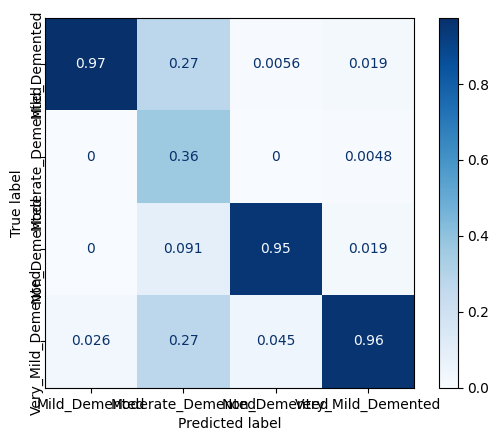

<Figure size 500x500 with 0 Axes>

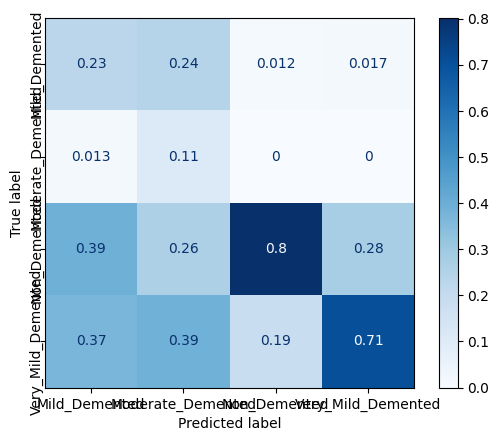

<Figure size 500x500 with 0 Axes>

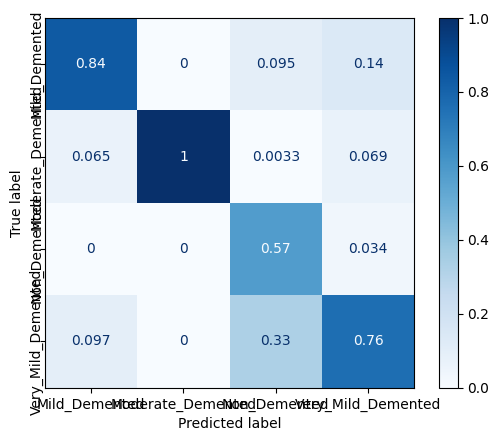

<Figure size 500x500 with 0 Axes>

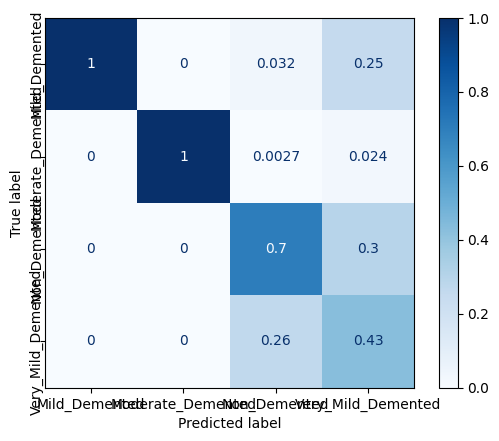

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r MobileNet.zip ./*